In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

import scipy.io

In [2]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [3]:
device = 'cuda:0'

In [4]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([-1,1], [0,1], 101, 101) #获取训练数据，第一个参数是x的取值范围，第二个参数是t的取值范围，第三个和第四个参数分别是x和t的采样点数
#这样，res是一个形状为(51*51,2)的数组，其中每一行代表一个(x,t)点的坐标，代表配位点/训练数据。b_left、b_right、b_upper和b_lower分别是边界条件的训练点，这些点用于训练PINNsformer模型。
res_test, _, _, _, _ = get_data([-1,1], [0,1], 512, 201) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

#将数据转换为时间序列，输入的数据形状为(N, 2)，第一列x第二列t。最后返回的是一个伪时间序列数据，形状为(N, num_step, 2)，step则代表Δt，是伪时间序列的递增量。相当于把N个[x,t]转换为{[x,t],[x,t+Δt],[x,t+2Δt],...,[x,t+(num_step-1)Δt]}，即每个空间位置都有一个时间序列。
res = make_time_sequence(res, num_step=5, step=1e-4) #配位点的时间序列数据，res形状变为(51*51, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #左边界条件的时间序列数据，b_left形状变为(51, 5, 2)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #右边界条件的时间序列数据，b_right形状变为(51, 5, 2)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #上边界条件的时间序列数据，b_upper形状变为(51, 5, 2)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #下边界条件的时间序列数据，b_lower形状变为(51, 5, 2)

#将数据转移到显卡上
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

#将数据分离为x和t的部分
x_res, t_res = res[:,:,0:1], res[:,:,1:2] #将res的第一列作为x，第二列作为t,这样x_res和t_res的形状都是(51*51, 5, 1)，即51*51个时间序列，每个(x,t)点都有5个时间步的序列数据
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2] #将b_left的第一列作为x，第二列作为t,这样x_left和t_left的形状都是(51, 5, 1)，即每个左边界点都有5个时间步的序列数据
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2] #将b_right的第一列作为x，第二列作为t,这样x_right和t_right的形状都是(51, 5, 1)，即每个右边界点都有5个时间步的序列数据
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2] #将b_upper的第一列作为x，第二列作为t,这样x_upper和t_upper的形状都是(51, 5, 1)，即每个上边界点都有5个时间步的序列数据
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2] #将b_lower的第一列作为x，第二列作为t,这样x_lower和t_lower的形状都是(51, 5, 1)，即每个下边界点都有5个时间步的序列数据

#初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
def init_weights(m):
    if isinstance(m, nn.Linear): #判断是否是线性层
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

In [5]:
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子

L1error = []
L2error = []

for seed in seeds:
    set_seed(seed) #设置随机数种子

    model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) #创建PINNsformer模型，模型输出维度为1，outputlayer模块的隐藏层维度为512，数据的特征嵌入维度为32，编码器和解码器的层数为1，注意力机制的头数为2

    model.apply(init_weights) #初始化模型中线性层的权重和偏置
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

    loss_track = [] #记录loss

    for i in tqdm(range(1500)): #训练500次
        def closure():
            pred_res = model(x_res, t_res) #得到配位点的预测结果
            pred_left = model(x_left, t_left) #得到左边界点的预测结果
            pred_right = model(x_right, t_right) #得到右边界点的预测结果
            pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
            pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

            #计算配位点的时间导数u_t和空间导数u_x
            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

            pred_x_upper = torch.autograd.grad(pred_upper, x_upper, grad_outputs=torch.ones_like(pred_upper), retain_graph=True, create_graph=True)[0]
            pred_x_lower = torch.autograd.grad(pred_lower, x_lower, grad_outputs=torch.ones_like(pred_lower), retain_graph=True, create_graph=True)[0]

            #计算损失，共三项损失
            loss_res = torch.mean((u_t - 0.0001 * u_xx + 5 * pred_res ** 3- 5 * pred_res) ** 2)
            # loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
            # loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower)**2)+torch.mean((pred_x_upper - pred_x_lower)**2)
            # loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - x_left[:,0]**2*torch.cos(torch.pi*x_left[:,0])) ** 2)

            loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

            loss = loss_res + loss_bc + loss_ic
            optim.zero_grad()
            loss.backward()
            return loss

        optim.step(closure)

    

    with torch.no_grad():
        pred = model(x_test, t_test)[:,0:1]
        pred = pred.cpu().detach().numpy()

    pred = pred.reshape(512,201)

    mat = scipy.io.loadmat('./AC.mat')
    u = mat['uu'].reshape(512,201)

    rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

    print('relative L1 error: {:4f}'.format(rl1))
    print('relative L2 error: {:4f}'.format(rl2))

    L1error.append(rl1)
    L2error.append(rl2)

/home/extra_disk/lcylcy/PINNSFORMER/demo/Allen-Cahn/ipykernel_1353731/1446276464.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<2:04:21,  4.98s/it]

  0%|          | 2/1500 [00:09<1:57:05,  4.69s/it]

  0%|          | 3/1500 [00:13<1:54:54,  4.61s/it]

  0%|          | 4/1500 [00:18<1:56:06,  4.66s/it]

  0%|          | 5/1500 [00:23<1:56:54,  4.69s/it]

  0%|          | 6/1500 [00:28<2:01:06,  4.86s/it]

  0%|          | 7/1500 [00:33<2:02:00,  4.90s/it]

  1%|          | 8/1500 [00:39<2:05:53,  5.06s/it]

  1%|          | 9/1500 [00:44<2:08:22,  5.17s/it]

  1%|          | 10/1500 [00:50<2:11:42,  5.30s/it]

  1%|          | 11/1500 [00:55<2:12:25,  5.34s/it]

  1%|          | 12/1500 [01:00<2:09:40,  5.23s/it]

  1%|          | 13/1500 [01:05<2:04:34,  5.03s/it]

  1%|          | 14/1500 [01:10<2:05:37,  5.07s/it]

  1%|          | 15/1500 [01:15<2:04:55,  5.05s/it]

  1%|          | 16/1500 [01:19<2:02:44,  4.96s/it]

  1%|          | 17/1500 [01:25<2:05:53,  5.09s/it]

  1%|          | 18/1500 [01:30<2:03:24,  5.00s/it]

  1%|▏         | 19/1500 [01:35<2:03:10,  4.99s/it]

  1%|▏         | 20/1500 [01:40<2:02:57,  4.98s/it]

  1%|▏         | 21/1500 [01:45<2:05:54,  5.11s/it]

  1%|▏         | 22/1500 [01:50<2:03:18,  5.01s/it]

  2%|▏         | 23/1500 [01:55<2:06:07,  5.12s/it]

  2%|▏         | 24/1500 [02:00<2:03:24,  5.02s/it]

  2%|▏         | 25/1500 [02:05<2:07:44,  5.20s/it]

  2%|▏         | 26/1500 [02:11<2:09:13,  5.26s/it]

  2%|▏         | 27/1500 [02:17<2:11:45,  5.37s/it]

  2%|▏         | 28/1500 [02:22<2:11:56,  5.38s/it]

  2%|▏         | 29/1500 [02:27<2:12:02,  5.39s/it]

  2%|▏         | 30/1500 [02:33<2:10:38,  5.33s/it]

  2%|▏         | 31/1500 [02:37<2:04:47,  5.10s/it]

  2%|▏         | 32/1500 [02:42<2:03:47,  5.06s/it]

  2%|▏         | 33/1500 [02:45<1:50:23,  4.51s/it]

  2%|▏         | 34/1500 [02:48<1:37:43,  4.00s/it]

  2%|▏         | 35/1500 [02:49<1:17:43,  3.18s/it]

  2%|▏         | 36/1500 [02:51<1:03:43,  2.61s/it]

  2%|▏         | 37/1500 [02:52<53:59,  2.21s/it]  

  3%|▎         | 38/1500 [02:53<47:06,  1.93s/it]

  3%|▎         | 39/1500 [02:55<42:17,  1.74s/it]

  3%|▎         | 40/1500 [02:56<38:54,  1.60s/it]

  3%|▎         | 41/1500 [02:57<36:41,  1.51s/it]

  3%|▎         | 42/1500 [02:58<34:59,  1.44s/it]

  3%|▎         | 43/1500 [03:00<33:48,  1.39s/it]

  3%|▎         | 44/1500 [03:01<33:00,  1.36s/it]

  3%|▎         | 45/1500 [03:02<32:22,  1.34s/it]

  3%|▎         | 46/1500 [03:03<31:56,  1.32s/it]

  3%|▎         | 47/1500 [03:05<31:37,  1.31s/it]

  3%|▎         | 48/1500 [03:06<31:23,  1.30s/it]

  3%|▎         | 49/1500 [03:07<31:13,  1.29s/it]

  3%|▎         | 50/1500 [03:09<31:06,  1.29s/it]

  3%|▎         | 51/1500 [03:10<31:00,  1.28s/it]

  3%|▎         | 52/1500 [03:11<31:01,  1.29s/it]

  4%|▎         | 53/1500 [03:12<30:56,  1.28s/it]

  4%|▎         | 54/1500 [03:14<30:59,  1.29s/it]

  4%|▎         | 55/1500 [03:15<30:56,  1.28s/it]

  4%|▎         | 56/1500 [03:16<30:51,  1.28s/it]

  4%|▍         | 57/1500 [03:18<30:48,  1.28s/it]

  4%|▍         | 58/1500 [03:19<30:45,  1.28s/it]

  4%|▍         | 59/1500 [03:20<30:47,  1.28s/it]

  4%|▍         | 60/1500 [03:21<30:43,  1.28s/it]

  4%|▍         | 61/1500 [03:23<30:40,  1.28s/it]

  4%|▍         | 62/1500 [03:24<30:42,  1.28s/it]

  4%|▍         | 63/1500 [03:25<30:42,  1.28s/it]

  4%|▍         | 64/1500 [03:27<30:39,  1.28s/it]

  4%|▍         | 65/1500 [03:28<30:39,  1.28s/it]

  4%|▍         | 66/1500 [03:29<30:39,  1.28s/it]

  4%|▍         | 67/1500 [03:30<30:35,  1.28s/it]

  5%|▍         | 68/1500 [03:32<30:36,  1.28s/it]

  5%|▍         | 69/1500 [03:33<30:33,  1.28s/it]

  5%|▍         | 70/1500 [03:34<30:33,  1.28s/it]

  5%|▍         | 71/1500 [03:35<30:29,  1.28s/it]

  5%|▍         | 72/1500 [03:37<30:28,  1.28s/it]

  5%|▍         | 73/1500 [03:38<30:25,  1.28s/it]

  5%|▍         | 74/1500 [03:39<30:23,  1.28s/it]

  5%|▌         | 75/1500 [03:41<30:21,  1.28s/it]

  5%|▌         | 76/1500 [03:42<30:19,  1.28s/it]

  5%|▌         | 77/1500 [03:43<30:17,  1.28s/it]

  5%|▌         | 78/1500 [03:44<30:15,  1.28s/it]

  5%|▌         | 79/1500 [03:46<30:19,  1.28s/it]

  5%|▌         | 80/1500 [03:47<30:16,  1.28s/it]

  5%|▌         | 81/1500 [03:48<30:18,  1.28s/it]

  5%|▌         | 82/1500 [03:50<30:18,  1.28s/it]

  6%|▌         | 83/1500 [03:51<30:14,  1.28s/it]

  6%|▌         | 84/1500 [03:52<30:12,  1.28s/it]

  6%|▌         | 85/1500 [03:53<30:09,  1.28s/it]

  6%|▌         | 86/1500 [03:55<30:10,  1.28s/it]

  6%|▌         | 87/1500 [03:56<30:08,  1.28s/it]

  6%|▌         | 88/1500 [03:57<30:06,  1.28s/it]

  6%|▌         | 89/1500 [03:59<30:04,  1.28s/it]

  6%|▌         | 90/1500 [04:00<30:02,  1.28s/it]

  6%|▌         | 91/1500 [04:01<30:00,  1.28s/it]

  6%|▌         | 92/1500 [04:02<30:01,  1.28s/it]

  6%|▌         | 93/1500 [04:04<30:01,  1.28s/it]

  6%|▋         | 94/1500 [04:05<29:58,  1.28s/it]

  6%|▋         | 95/1500 [04:06<29:55,  1.28s/it]

  6%|▋         | 96/1500 [04:07<29:53,  1.28s/it]

  6%|▋         | 97/1500 [04:09<29:52,  1.28s/it]

  7%|▋         | 98/1500 [04:10<29:55,  1.28s/it]

  7%|▋         | 99/1500 [04:11<29:52,  1.28s/it]

  7%|▋         | 100/1500 [04:13<29:53,  1.28s/it]

  7%|▋         | 101/1500 [04:14<29:52,  1.28s/it]

  7%|▋         | 102/1500 [04:15<29:49,  1.28s/it]

  7%|▋         | 103/1500 [04:16<29:51,  1.28s/it]

  7%|▋         | 104/1500 [04:18<29:48,  1.28s/it]

  7%|▋         | 105/1500 [04:19<29:51,  1.28s/it]

  7%|▋         | 106/1500 [04:20<29:47,  1.28s/it]

  7%|▋         | 107/1500 [04:22<29:44,  1.28s/it]

  7%|▋         | 108/1500 [04:23<29:46,  1.28s/it]

  7%|▋         | 109/1500 [04:24<29:43,  1.28s/it]

  7%|▋         | 110/1500 [04:25<29:44,  1.28s/it]

  7%|▋         | 111/1500 [04:27<29:40,  1.28s/it]

  7%|▋         | 112/1500 [04:28<29:40,  1.28s/it]

  8%|▊         | 113/1500 [04:29<29:37,  1.28s/it]

  8%|▊         | 114/1500 [04:31<29:38,  1.28s/it]

  8%|▊         | 115/1500 [04:32<29:40,  1.29s/it]

  8%|▊         | 116/1500 [04:33<29:37,  1.28s/it]

  8%|▊         | 117/1500 [04:34<29:36,  1.28s/it]

  8%|▊         | 118/1500 [04:36<29:35,  1.28s/it]

  8%|▊         | 119/1500 [04:37<29:31,  1.28s/it]

  8%|▊         | 120/1500 [04:38<29:29,  1.28s/it]

  8%|▊         | 121/1500 [04:40<29:25,  1.28s/it]

  8%|▊         | 122/1500 [04:41<29:28,  1.28s/it]

  8%|▊         | 123/1500 [04:42<29:24,  1.28s/it]

  8%|▊         | 124/1500 [04:43<29:21,  1.28s/it]

  8%|▊         | 125/1500 [04:45<29:23,  1.28s/it]

  8%|▊         | 126/1500 [04:46<29:24,  1.28s/it]

  8%|▊         | 127/1500 [04:47<29:23,  1.28s/it]

  9%|▊         | 128/1500 [04:49<29:18,  1.28s/it]

  9%|▊         | 129/1500 [04:50<29:17,  1.28s/it]

  9%|▊         | 130/1500 [04:51<29:14,  1.28s/it]

  9%|▊         | 131/1500 [04:52<29:12,  1.28s/it]

  9%|▉         | 132/1500 [04:54<29:10,  1.28s/it]

  9%|▉         | 133/1500 [04:55<29:11,  1.28s/it]

  9%|▉         | 134/1500 [04:56<29:09,  1.28s/it]

  9%|▉         | 135/1500 [04:57<29:08,  1.28s/it]

  9%|▉         | 136/1500 [04:59<29:05,  1.28s/it]

  9%|▉         | 137/1500 [05:00<29:04,  1.28s/it]

  9%|▉         | 138/1500 [05:01<29:04,  1.28s/it]

  9%|▉         | 139/1500 [05:03<29:07,  1.28s/it]

  9%|▉         | 140/1500 [05:04<29:04,  1.28s/it]

  9%|▉         | 141/1500 [05:05<29:00,  1.28s/it]

  9%|▉         | 142/1500 [05:06<28:59,  1.28s/it]

 10%|▉         | 143/1500 [05:08<28:58,  1.28s/it]

 10%|▉         | 144/1500 [05:09<28:58,  1.28s/it]

 10%|▉         | 145/1500 [05:10<29:01,  1.29s/it]

 10%|▉         | 146/1500 [05:12<28:57,  1.28s/it]

 10%|▉         | 147/1500 [05:13<28:53,  1.28s/it]

 10%|▉         | 148/1500 [05:14<28:51,  1.28s/it]

 10%|▉         | 149/1500 [05:15<28:48,  1.28s/it]

 10%|█         | 150/1500 [05:17<28:49,  1.28s/it]

 10%|█         | 151/1500 [05:18<28:47,  1.28s/it]

 10%|█         | 152/1500 [05:19<28:49,  1.28s/it]

 10%|█         | 153/1500 [05:21<28:45,  1.28s/it]

 10%|█         | 154/1500 [05:22<28:42,  1.28s/it]

 10%|█         | 155/1500 [05:23<28:40,  1.28s/it]

 10%|█         | 156/1500 [05:24<28:38,  1.28s/it]

 10%|█         | 157/1500 [05:26<28:35,  1.28s/it]

 11%|█         | 158/1500 [05:27<28:38,  1.28s/it]

 11%|█         | 159/1500 [05:28<28:36,  1.28s/it]

 11%|█         | 160/1500 [05:29<28:33,  1.28s/it]

 11%|█         | 161/1500 [05:31<28:31,  1.28s/it]

 11%|█         | 162/1500 [05:32<28:31,  1.28s/it]

 11%|█         | 163/1500 [05:33<28:30,  1.28s/it]

 11%|█         | 164/1500 [05:35<28:29,  1.28s/it]

 11%|█         | 165/1500 [05:36<28:29,  1.28s/it]

 11%|█         | 166/1500 [05:37<28:28,  1.28s/it]

 11%|█         | 167/1500 [05:38<28:26,  1.28s/it]

 11%|█         | 168/1500 [05:40<28:25,  1.28s/it]

 11%|█▏        | 169/1500 [05:41<28:24,  1.28s/it]

 11%|█▏        | 170/1500 [05:42<28:22,  1.28s/it]

 11%|█▏        | 171/1500 [05:44<28:21,  1.28s/it]

 11%|█▏        | 172/1500 [05:45<28:23,  1.28s/it]

 12%|█▏        | 173/1500 [05:46<28:24,  1.28s/it]

 12%|█▏        | 174/1500 [05:47<28:22,  1.28s/it]

 12%|█▏        | 175/1500 [05:49<28:21,  1.28s/it]

 12%|█▏        | 176/1500 [05:50<28:20,  1.28s/it]

 12%|█▏        | 177/1500 [05:51<28:20,  1.29s/it]

 12%|█▏        | 178/1500 [05:53<28:15,  1.28s/it]

 12%|█▏        | 179/1500 [05:54<28:12,  1.28s/it]

 12%|█▏        | 180/1500 [05:55<28:09,  1.28s/it]

 12%|█▏        | 181/1500 [05:56<28:11,  1.28s/it]

 12%|█▏        | 182/1500 [05:58<28:09,  1.28s/it]

 12%|█▏        | 183/1500 [05:59<28:06,  1.28s/it]

 12%|█▏        | 184/1500 [06:00<28:07,  1.28s/it]

 12%|█▏        | 185/1500 [06:02<28:04,  1.28s/it]

 12%|█▏        | 186/1500 [06:03<28:00,  1.28s/it]

 12%|█▏        | 187/1500 [06:04<28:03,  1.28s/it]

 13%|█▎        | 188/1500 [06:05<28:00,  1.28s/it]

 13%|█▎        | 189/1500 [06:07<28:01,  1.28s/it]

 13%|█▎        | 190/1500 [06:08<27:58,  1.28s/it]

 13%|█▎        | 191/1500 [06:09<27:55,  1.28s/it]

 13%|█▎        | 192/1500 [06:10<27:53,  1.28s/it]

 13%|█▎        | 193/1500 [06:12<27:53,  1.28s/it]

 13%|█▎        | 194/1500 [06:13<27:51,  1.28s/it]

 13%|█▎        | 195/1500 [06:14<27:49,  1.28s/it]

 13%|█▎        | 196/1500 [06:16<27:52,  1.28s/it]

 13%|█▎        | 197/1500 [06:17<27:48,  1.28s/it]

 13%|█▎        | 198/1500 [06:18<27:46,  1.28s/it]

 13%|█▎        | 199/1500 [06:19<27:44,  1.28s/it]

 13%|█▎        | 200/1500 [06:21<27:46,  1.28s/it]

 13%|█▎        | 201/1500 [06:22<27:48,  1.28s/it]

 13%|█▎        | 202/1500 [06:23<27:44,  1.28s/it]

 14%|█▎        | 203/1500 [06:25<27:45,  1.28s/it]

 14%|█▎        | 204/1500 [06:26<27:41,  1.28s/it]

 14%|█▎        | 205/1500 [06:27<27:39,  1.28s/it]

 14%|█▎        | 206/1500 [06:28<27:35,  1.28s/it]

 14%|█▍        | 207/1500 [06:30<27:33,  1.28s/it]

 14%|█▍        | 208/1500 [06:31<27:32,  1.28s/it]

 14%|█▍        | 209/1500 [06:32<27:32,  1.28s/it]

 14%|█▍        | 210/1500 [06:34<27:32,  1.28s/it]

 14%|█▍        | 211/1500 [06:35<27:29,  1.28s/it]

 14%|█▍        | 212/1500 [06:36<27:28,  1.28s/it]

 14%|█▍        | 213/1500 [06:37<27:25,  1.28s/it]

 14%|█▍        | 214/1500 [06:39<27:23,  1.28s/it]

 14%|█▍        | 215/1500 [06:40<27:23,  1.28s/it]

 14%|█▍        | 216/1500 [06:41<27:22,  1.28s/it]

 14%|█▍        | 217/1500 [06:43<27:21,  1.28s/it]

 15%|█▍        | 218/1500 [06:44<27:22,  1.28s/it]

 15%|█▍        | 219/1500 [06:45<27:19,  1.28s/it]

 15%|█▍        | 220/1500 [06:46<27:16,  1.28s/it]

 15%|█▍        | 221/1500 [06:48<27:18,  1.28s/it]

 15%|█▍        | 222/1500 [06:49<27:16,  1.28s/it]

 15%|█▍        | 223/1500 [06:50<27:17,  1.28s/it]

 15%|█▍        | 224/1500 [06:51<27:20,  1.29s/it]

 15%|█▌        | 225/1500 [06:53<27:15,  1.28s/it]

 15%|█▌        | 226/1500 [06:54<27:16,  1.28s/it]

 15%|█▌        | 227/1500 [06:55<27:12,  1.28s/it]

 15%|█▌        | 228/1500 [06:57<27:08,  1.28s/it]

 15%|█▌        | 229/1500 [06:58<27:10,  1.28s/it]

 15%|█▌        | 230/1500 [06:59<27:06,  1.28s/it]

 15%|█▌        | 231/1500 [07:00<27:06,  1.28s/it]

 15%|█▌        | 232/1500 [07:02<27:06,  1.28s/it]

 16%|█▌        | 233/1500 [07:03<27:03,  1.28s/it]

 16%|█▌        | 234/1500 [07:04<27:05,  1.28s/it]

 16%|█▌        | 235/1500 [07:06<27:01,  1.28s/it]

 16%|█▌        | 236/1500 [07:07<26:57,  1.28s/it]

 16%|█▌        | 237/1500 [07:08<26:56,  1.28s/it]

 16%|█▌        | 238/1500 [07:09<26:54,  1.28s/it]

 16%|█▌        | 239/1500 [07:11<26:53,  1.28s/it]

 16%|█▌        | 240/1500 [07:12<26:56,  1.28s/it]

 16%|█▌        | 241/1500 [07:13<26:54,  1.28s/it]

 16%|█▌        | 242/1500 [07:15<26:51,  1.28s/it]

 16%|█▌        | 243/1500 [07:16<26:54,  1.28s/it]

 16%|█▋        | 244/1500 [07:17<26:53,  1.28s/it]

 16%|█▋        | 245/1500 [07:18<26:49,  1.28s/it]

 16%|█▋        | 246/1500 [07:20<26:46,  1.28s/it]

 16%|█▋        | 247/1500 [07:21<26:44,  1.28s/it]

 17%|█▋        | 248/1500 [07:22<26:46,  1.28s/it]

 17%|█▋        | 249/1500 [07:24<26:46,  1.28s/it]

 17%|█▋        | 250/1500 [07:25<26:42,  1.28s/it]

 17%|█▋        | 251/1500 [07:26<26:45,  1.29s/it]

 17%|█▋        | 252/1500 [07:27<26:41,  1.28s/it]

 17%|█▋        | 253/1500 [07:29<26:38,  1.28s/it]

 17%|█▋        | 254/1500 [07:30<26:36,  1.28s/it]

 17%|█▋        | 255/1500 [07:31<26:36,  1.28s/it]

 17%|█▋        | 256/1500 [07:33<26:36,  1.28s/it]

 17%|█▋        | 257/1500 [07:34<26:32,  1.28s/it]

 17%|█▋        | 258/1500 [07:35<26:30,  1.28s/it]

 17%|█▋        | 259/1500 [07:36<26:27,  1.28s/it]

 17%|█▋        | 260/1500 [07:38<26:26,  1.28s/it]

 17%|█▋        | 261/1500 [07:39<26:25,  1.28s/it]

 17%|█▋        | 262/1500 [07:40<26:24,  1.28s/it]

 18%|█▊        | 263/1500 [07:41<26:22,  1.28s/it]

 18%|█▊        | 264/1500 [07:43<26:21,  1.28s/it]

 18%|█▊        | 265/1500 [07:44<26:23,  1.28s/it]

 18%|█▊        | 266/1500 [07:45<26:20,  1.28s/it]

 18%|█▊        | 267/1500 [07:47<26:18,  1.28s/it]

 18%|█▊        | 268/1500 [07:48<26:20,  1.28s/it]

 18%|█▊        | 269/1500 [07:49<26:21,  1.28s/it]

 18%|█▊        | 270/1500 [07:50<26:17,  1.28s/it]

 18%|█▊        | 271/1500 [07:52<26:15,  1.28s/it]

 18%|█▊        | 272/1500 [07:53<26:12,  1.28s/it]

 18%|█▊        | 273/1500 [07:54<26:10,  1.28s/it]

 18%|█▊        | 274/1500 [07:56<26:14,  1.28s/it]

 18%|█▊        | 275/1500 [07:57<26:11,  1.28s/it]

 18%|█▊        | 276/1500 [07:58<26:07,  1.28s/it]

 18%|█▊        | 277/1500 [07:59<26:06,  1.28s/it]

 19%|█▊        | 278/1500 [08:01<26:03,  1.28s/it]

 19%|█▊        | 279/1500 [08:02<26:06,  1.28s/it]

 19%|█▊        | 280/1500 [08:03<26:03,  1.28s/it]

 19%|█▊        | 281/1500 [08:05<26:01,  1.28s/it]

 19%|█▉        | 282/1500 [08:06<26:01,  1.28s/it]

 19%|█▉        | 283/1500 [08:07<25:59,  1.28s/it]

 19%|█▉        | 284/1500 [08:08<25:57,  1.28s/it]

 19%|█▉        | 285/1500 [08:10<25:54,  1.28s/it]

 19%|█▉        | 286/1500 [08:11<25:52,  1.28s/it]

 19%|█▉        | 287/1500 [08:12<25:50,  1.28s/it]

 19%|█▉        | 288/1500 [08:13<25:51,  1.28s/it]

 19%|█▉        | 289/1500 [08:15<25:53,  1.28s/it]

 19%|█▉        | 290/1500 [08:16<25:50,  1.28s/it]

 19%|█▉        | 291/1500 [08:17<25:50,  1.28s/it]

 19%|█▉        | 292/1500 [08:19<25:48,  1.28s/it]

 20%|█▉        | 293/1500 [08:20<25:45,  1.28s/it]

 20%|█▉        | 294/1500 [08:21<25:43,  1.28s/it]

 20%|█▉        | 295/1500 [08:22<25:42,  1.28s/it]

 20%|█▉        | 296/1500 [08:24<25:43,  1.28s/it]

 20%|█▉        | 297/1500 [08:25<25:40,  1.28s/it]

 20%|█▉        | 298/1500 [08:26<25:40,  1.28s/it]

 20%|█▉        | 299/1500 [08:28<25:37,  1.28s/it]

 20%|██        | 300/1500 [08:29<25:40,  1.28s/it]

 20%|██        | 301/1500 [08:30<25:37,  1.28s/it]

 20%|██        | 302/1500 [08:31<25:35,  1.28s/it]

 20%|██        | 303/1500 [08:33<25:35,  1.28s/it]

 20%|██        | 304/1500 [08:34<25:34,  1.28s/it]

 20%|██        | 305/1500 [08:35<25:31,  1.28s/it]

 20%|██        | 306/1500 [08:37<25:28,  1.28s/it]

 20%|██        | 307/1500 [08:38<25:31,  1.28s/it]

 21%|██        | 308/1500 [08:39<25:27,  1.28s/it]

 21%|██        | 309/1500 [08:40<25:25,  1.28s/it]

 21%|██        | 310/1500 [08:42<25:22,  1.28s/it]

 21%|██        | 311/1500 [08:43<25:23,  1.28s/it]

 21%|██        | 312/1500 [08:44<25:21,  1.28s/it]

 21%|██        | 313/1500 [08:46<25:22,  1.28s/it]

 21%|██        | 314/1500 [08:47<25:19,  1.28s/it]

 21%|██        | 315/1500 [08:48<25:17,  1.28s/it]

 21%|██        | 316/1500 [08:49<25:15,  1.28s/it]

 21%|██        | 317/1500 [08:51<25:13,  1.28s/it]

 21%|██        | 318/1500 [08:52<25:15,  1.28s/it]

 21%|██▏       | 319/1500 [08:53<25:13,  1.28s/it]

 21%|██▏       | 320/1500 [08:54<25:10,  1.28s/it]

 21%|██▏       | 321/1500 [08:56<25:10,  1.28s/it]

 21%|██▏       | 322/1500 [08:57<25:08,  1.28s/it]

 22%|██▏       | 323/1500 [08:58<25:09,  1.28s/it]

 22%|██▏       | 324/1500 [09:00<25:06,  1.28s/it]

 22%|██▏       | 325/1500 [09:01<25:06,  1.28s/it]

 22%|██▏       | 326/1500 [09:02<25:04,  1.28s/it]

 22%|██▏       | 327/1500 [09:03<25:03,  1.28s/it]

 22%|██▏       | 328/1500 [09:05<25:01,  1.28s/it]

 22%|██▏       | 329/1500 [09:06<24:58,  1.28s/it]

 22%|██▏       | 330/1500 [09:07<24:56,  1.28s/it]

 22%|██▏       | 331/1500 [09:09<24:56,  1.28s/it]

 22%|██▏       | 332/1500 [09:10<24:55,  1.28s/it]

 22%|██▏       | 333/1500 [09:11<24:54,  1.28s/it]

 22%|██▏       | 334/1500 [09:12<24:52,  1.28s/it]

 22%|██▏       | 335/1500 [09:14<24:51,  1.28s/it]

 22%|██▏       | 336/1500 [09:15<24:49,  1.28s/it]

 22%|██▏       | 337/1500 [09:16<24:47,  1.28s/it]

 23%|██▎       | 338/1500 [09:18<24:50,  1.28s/it]

 23%|██▎       | 339/1500 [09:19<24:47,  1.28s/it]

 23%|██▎       | 340/1500 [09:20<24:48,  1.28s/it]

 23%|██▎       | 341/1500 [09:21<24:44,  1.28s/it]

 23%|██▎       | 342/1500 [09:23<24:42,  1.28s/it]

 23%|██▎       | 343/1500 [09:24<24:40,  1.28s/it]

 23%|██▎       | 344/1500 [09:25<24:44,  1.28s/it]

 23%|██▎       | 345/1500 [09:27<24:43,  1.28s/it]

 23%|██▎       | 346/1500 [09:28<24:39,  1.28s/it]

 23%|██▎       | 347/1500 [09:29<24:36,  1.28s/it]

 23%|██▎       | 348/1500 [09:30<24:37,  1.28s/it]

 23%|██▎       | 349/1500 [09:32<24:34,  1.28s/it]

 23%|██▎       | 350/1500 [09:33<24:34,  1.28s/it]

 23%|██▎       | 351/1500 [09:34<24:34,  1.28s/it]

 23%|██▎       | 352/1500 [09:36<24:31,  1.28s/it]

 24%|██▎       | 353/1500 [09:37<24:32,  1.28s/it]

 24%|██▎       | 354/1500 [09:38<24:28,  1.28s/it]

 24%|██▎       | 355/1500 [09:39<24:27,  1.28s/it]

 24%|██▎       | 356/1500 [09:41<24:25,  1.28s/it]

 24%|██▍       | 357/1500 [09:42<24:25,  1.28s/it]

 24%|██▍       | 358/1500 [09:43<24:22,  1.28s/it]

 24%|██▍       | 359/1500 [09:44<24:21,  1.28s/it]

 24%|██▍       | 360/1500 [09:46<24:19,  1.28s/it]

 24%|██▍       | 361/1500 [09:47<24:19,  1.28s/it]

 24%|██▍       | 362/1500 [09:48<24:18,  1.28s/it]

 24%|██▍       | 363/1500 [09:50<24:16,  1.28s/it]

 24%|██▍       | 364/1500 [09:51<24:16,  1.28s/it]

 24%|██▍       | 365/1500 [09:52<24:16,  1.28s/it]

 24%|██▍       | 366/1500 [09:53<24:13,  1.28s/it]

 24%|██▍       | 367/1500 [09:55<24:14,  1.28s/it]

 25%|██▍       | 368/1500 [09:56<24:11,  1.28s/it]

 25%|██▍       | 369/1500 [09:57<24:10,  1.28s/it]

 25%|██▍       | 370/1500 [09:59<24:07,  1.28s/it]

 25%|██▍       | 371/1500 [10:00<24:05,  1.28s/it]

 25%|██▍       | 372/1500 [10:01<24:03,  1.28s/it]

 25%|██▍       | 373/1500 [10:02<24:01,  1.28s/it]

 25%|██▍       | 374/1500 [10:04<23:59,  1.28s/it]

 25%|██▌       | 375/1500 [10:05<23:59,  1.28s/it]

 25%|██▌       | 376/1500 [10:06<23:57,  1.28s/it]

 25%|██▌       | 377/1500 [10:08<23:57,  1.28s/it]

 25%|██▌       | 378/1500 [10:09<23:55,  1.28s/it]

 25%|██▌       | 379/1500 [10:10<23:53,  1.28s/it]

 25%|██▌       | 380/1500 [10:11<23:52,  1.28s/it]

 25%|██▌       | 381/1500 [10:13<23:51,  1.28s/it]

 25%|██▌       | 382/1500 [10:14<23:54,  1.28s/it]

 26%|██▌       | 383/1500 [10:15<23:51,  1.28s/it]

 26%|██▌       | 384/1500 [10:16<23:51,  1.28s/it]

 26%|██▌       | 385/1500 [10:18<23:48,  1.28s/it]

 26%|██▌       | 386/1500 [10:19<23:51,  1.28s/it]

 26%|██▌       | 387/1500 [10:20<23:50,  1.28s/it]

 26%|██▌       | 388/1500 [10:22<23:46,  1.28s/it]

 26%|██▌       | 389/1500 [10:23<23:44,  1.28s/it]

 26%|██▌       | 390/1500 [10:24<23:41,  1.28s/it]

 26%|██▌       | 391/1500 [10:25<23:39,  1.28s/it]

 26%|██▌       | 392/1500 [10:27<23:37,  1.28s/it]

 26%|██▌       | 393/1500 [10:28<23:37,  1.28s/it]

 26%|██▋       | 394/1500 [10:29<23:39,  1.28s/it]

 26%|██▋       | 395/1500 [10:31<23:37,  1.28s/it]

 26%|██▋       | 396/1500 [10:32<23:35,  1.28s/it]

 26%|██▋       | 397/1500 [10:33<23:33,  1.28s/it]

 27%|██▋       | 398/1500 [10:34<23:36,  1.29s/it]

 27%|██▋       | 399/1500 [10:36<23:32,  1.28s/it]

 27%|██▋       | 400/1500 [10:37<23:30,  1.28s/it]

 27%|██▋       | 401/1500 [10:38<23:28,  1.28s/it]

 27%|██▋       | 402/1500 [10:40<23:25,  1.28s/it]

 27%|██▋       | 403/1500 [10:41<23:27,  1.28s/it]

 27%|██▋       | 404/1500 [10:42<23:26,  1.28s/it]

 27%|██▋       | 405/1500 [10:43<23:24,  1.28s/it]

 27%|██▋       | 406/1500 [10:45<23:21,  1.28s/it]

 27%|██▋       | 407/1500 [10:46<23:19,  1.28s/it]

 27%|██▋       | 408/1500 [10:47<23:18,  1.28s/it]

 27%|██▋       | 409/1500 [10:49<23:16,  1.28s/it]

 27%|██▋       | 410/1500 [10:50<23:14,  1.28s/it]

 27%|██▋       | 411/1500 [10:51<23:14,  1.28s/it]

 27%|██▋       | 412/1500 [10:52<23:12,  1.28s/it]

 28%|██▊       | 413/1500 [10:54<23:10,  1.28s/it]

 28%|██▊       | 414/1500 [10:55<23:10,  1.28s/it]

 28%|██▊       | 415/1500 [10:56<23:08,  1.28s/it]

 28%|██▊       | 416/1500 [10:57<23:07,  1.28s/it]

 28%|██▊       | 417/1500 [10:59<23:07,  1.28s/it]

 28%|██▊       | 418/1500 [11:00<23:04,  1.28s/it]

 28%|██▊       | 419/1500 [11:01<23:05,  1.28s/it]

 28%|██▊       | 420/1500 [11:03<23:04,  1.28s/it]

 28%|██▊       | 421/1500 [11:04<23:03,  1.28s/it]

 28%|██▊       | 422/1500 [11:05<23:01,  1.28s/it]

 28%|██▊       | 423/1500 [11:06<23:00,  1.28s/it]

 28%|██▊       | 424/1500 [11:08<23:01,  1.28s/it]

 28%|██▊       | 425/1500 [11:09<22:58,  1.28s/it]

 28%|██▊       | 426/1500 [11:10<23:00,  1.29s/it]

 28%|██▊       | 427/1500 [11:12<22:56,  1.28s/it]

 29%|██▊       | 428/1500 [11:13<22:56,  1.28s/it]

 29%|██▊       | 429/1500 [11:14<22:54,  1.28s/it]

 29%|██▊       | 430/1500 [11:15<22:51,  1.28s/it]

 29%|██▊       | 431/1500 [11:17<22:49,  1.28s/it]

 29%|██▉       | 432/1500 [11:18<22:48,  1.28s/it]

 29%|██▉       | 433/1500 [11:19<22:46,  1.28s/it]

 29%|██▉       | 434/1500 [11:21<22:45,  1.28s/it]

 29%|██▉       | 435/1500 [11:22<22:43,  1.28s/it]

 29%|██▉       | 436/1500 [11:23<22:44,  1.28s/it]

 29%|██▉       | 437/1500 [11:24<22:42,  1.28s/it]

 29%|██▉       | 438/1500 [11:26<22:41,  1.28s/it]

 29%|██▉       | 439/1500 [11:27<22:39,  1.28s/it]

 29%|██▉       | 440/1500 [11:28<22:37,  1.28s/it]

 29%|██▉       | 441/1500 [11:30<22:37,  1.28s/it]

 29%|██▉       | 442/1500 [11:31<22:37,  1.28s/it]

 30%|██▉       | 443/1500 [11:32<22:35,  1.28s/it]

 30%|██▉       | 444/1500 [11:33<22:32,  1.28s/it]

 30%|██▉       | 445/1500 [11:35<22:34,  1.28s/it]

 30%|██▉       | 446/1500 [11:36<22:31,  1.28s/it]

 30%|██▉       | 447/1500 [11:37<22:29,  1.28s/it]

 30%|██▉       | 448/1500 [11:39<22:27,  1.28s/it]

 30%|██▉       | 449/1500 [11:40<22:25,  1.28s/it]

 30%|███       | 450/1500 [11:41<22:24,  1.28s/it]

 30%|███       | 451/1500 [11:42<22:22,  1.28s/it]

 30%|███       | 452/1500 [11:44<22:20,  1.28s/it]

 30%|███       | 453/1500 [11:45<22:22,  1.28s/it]

 30%|███       | 454/1500 [11:46<22:21,  1.28s/it]

 30%|███       | 455/1500 [11:47<22:20,  1.28s/it]

 30%|███       | 456/1500 [11:49<22:17,  1.28s/it]

 30%|███       | 457/1500 [11:50<22:15,  1.28s/it]

 31%|███       | 458/1500 [11:51<22:13,  1.28s/it]

 31%|███       | 459/1500 [11:53<22:13,  1.28s/it]

 31%|███       | 460/1500 [11:54<22:11,  1.28s/it]

 31%|███       | 461/1500 [11:55<22:09,  1.28s/it]

 31%|███       | 462/1500 [11:56<22:10,  1.28s/it]

 31%|███       | 463/1500 [11:58<22:09,  1.28s/it]

 31%|███       | 464/1500 [11:59<22:09,  1.28s/it]

 31%|███       | 465/1500 [12:00<22:07,  1.28s/it]

 31%|███       | 466/1500 [12:02<22:05,  1.28s/it]

 31%|███       | 467/1500 [12:03<22:05,  1.28s/it]

 31%|███       | 468/1500 [12:04<22:03,  1.28s/it]

 31%|███▏      | 469/1500 [12:05<22:00,  1.28s/it]

 31%|███▏      | 470/1500 [12:07<22:01,  1.28s/it]

 31%|███▏      | 471/1500 [12:08<22:00,  1.28s/it]

 31%|███▏      | 472/1500 [12:09<21:57,  1.28s/it]

 32%|███▏      | 473/1500 [12:11<21:58,  1.28s/it]

 32%|███▏      | 474/1500 [12:12<21:55,  1.28s/it]

 32%|███▏      | 475/1500 [12:13<21:55,  1.28s/it]

 32%|███▏      | 476/1500 [12:14<21:52,  1.28s/it]

 32%|███▏      | 477/1500 [12:16<21:49,  1.28s/it]

 32%|███▏      | 478/1500 [12:17<21:47,  1.28s/it]

 32%|███▏      | 479/1500 [12:18<21:46,  1.28s/it]

 32%|███▏      | 480/1500 [12:20<21:44,  1.28s/it]

 32%|███▏      | 481/1500 [12:21<21:45,  1.28s/it]

 32%|███▏      | 482/1500 [12:22<21:46,  1.28s/it]

 32%|███▏      | 483/1500 [12:23<21:43,  1.28s/it]

 32%|███▏      | 484/1500 [12:25<21:40,  1.28s/it]

 32%|███▏      | 485/1500 [12:26<21:39,  1.28s/it]

 32%|███▏      | 486/1500 [12:27<21:37,  1.28s/it]

 32%|███▏      | 487/1500 [12:28<21:36,  1.28s/it]

 33%|███▎      | 488/1500 [12:30<21:34,  1.28s/it]

 33%|███▎      | 489/1500 [12:31<21:33,  1.28s/it]

 33%|███▎      | 490/1500 [12:32<21:34,  1.28s/it]

 33%|███▎      | 491/1500 [12:34<21:32,  1.28s/it]

 33%|███▎      | 492/1500 [12:35<21:30,  1.28s/it]

 33%|███▎      | 493/1500 [12:36<21:30,  1.28s/it]

 33%|███▎      | 494/1500 [12:37<21:27,  1.28s/it]

 33%|███▎      | 495/1500 [12:39<21:27,  1.28s/it]

 33%|███▎      | 496/1500 [12:40<21:26,  1.28s/it]

 33%|███▎      | 497/1500 [12:41<21:24,  1.28s/it]

 33%|███▎      | 498/1500 [12:43<21:22,  1.28s/it]

 33%|███▎      | 499/1500 [12:44<21:21,  1.28s/it]

 33%|███▎      | 500/1500 [12:45<21:19,  1.28s/it]

 33%|███▎      | 501/1500 [12:46<21:17,  1.28s/it]

 33%|███▎      | 502/1500 [12:48<21:16,  1.28s/it]

 34%|███▎      | 503/1500 [12:49<21:17,  1.28s/it]

 34%|███▎      | 504/1500 [12:50<21:15,  1.28s/it]

 34%|███▎      | 505/1500 [12:52<21:13,  1.28s/it]

 34%|███▎      | 506/1500 [12:53<21:13,  1.28s/it]

 34%|███▍      | 507/1500 [12:54<21:12,  1.28s/it]

 34%|███▍      | 508/1500 [12:55<21:10,  1.28s/it]

 34%|███▍      | 509/1500 [12:57<21:10,  1.28s/it]

 34%|███▍      | 510/1500 [12:58<21:09,  1.28s/it]

 34%|███▍      | 511/1500 [12:59<21:07,  1.28s/it]

 34%|███▍      | 512/1500 [13:01<21:05,  1.28s/it]

 34%|███▍      | 513/1500 [13:02<21:03,  1.28s/it]

 34%|███▍      | 514/1500 [13:03<21:02,  1.28s/it]

 34%|███▍      | 515/1500 [13:04<21:00,  1.28s/it]

 34%|███▍      | 516/1500 [13:06<21:01,  1.28s/it]

 34%|███▍      | 517/1500 [13:07<20:59,  1.28s/it]

 35%|███▍      | 518/1500 [13:08<20:57,  1.28s/it]

 35%|███▍      | 519/1500 [13:09<20:55,  1.28s/it]

 35%|███▍      | 520/1500 [13:11<20:55,  1.28s/it]

 35%|███▍      | 521/1500 [13:12<20:53,  1.28s/it]

 35%|███▍      | 522/1500 [13:13<20:52,  1.28s/it]

 35%|███▍      | 523/1500 [13:15<20:54,  1.28s/it]

 35%|███▍      | 524/1500 [13:16<20:52,  1.28s/it]

 35%|███▌      | 525/1500 [13:17<20:49,  1.28s/it]

 35%|███▌      | 526/1500 [13:18<20:51,  1.29s/it]

 35%|███▌      | 527/1500 [13:20<20:51,  1.29s/it]

 35%|███▌      | 528/1500 [13:21<20:47,  1.28s/it]

 35%|███▌      | 529/1500 [13:22<20:45,  1.28s/it]

 35%|███▌      | 530/1500 [13:24<20:43,  1.28s/it]

 35%|███▌      | 531/1500 [13:25<20:41,  1.28s/it]

 35%|███▌      | 532/1500 [13:26<20:40,  1.28s/it]

 36%|███▌      | 533/1500 [13:27<20:40,  1.28s/it]

 36%|███▌      | 534/1500 [13:29<20:38,  1.28s/it]

 36%|███▌      | 535/1500 [13:30<20:36,  1.28s/it]

 36%|███▌      | 536/1500 [13:31<20:35,  1.28s/it]

 36%|███▌      | 537/1500 [13:33<20:33,  1.28s/it]

 36%|███▌      | 538/1500 [13:34<20:34,  1.28s/it]

 36%|███▌      | 539/1500 [13:35<20:32,  1.28s/it]

 36%|███▌      | 540/1500 [13:36<20:29,  1.28s/it]

 36%|███▌      | 541/1500 [13:38<20:28,  1.28s/it]

 36%|███▌      | 542/1500 [13:39<20:26,  1.28s/it]

 36%|███▌      | 543/1500 [13:40<20:27,  1.28s/it]

 36%|███▋      | 544/1500 [13:42<20:27,  1.28s/it]

 36%|███▋      | 545/1500 [13:43<20:24,  1.28s/it]

 36%|███▋      | 546/1500 [13:44<20:22,  1.28s/it]

 36%|███▋      | 547/1500 [13:45<20:20,  1.28s/it]

 37%|███▋      | 548/1500 [13:47<20:20,  1.28s/it]

 37%|███▋      | 549/1500 [13:48<20:20,  1.28s/it]

 37%|███▋      | 550/1500 [13:49<20:18,  1.28s/it]

 37%|███▋      | 551/1500 [13:51<20:18,  1.28s/it]

 37%|███▋      | 552/1500 [13:52<20:16,  1.28s/it]

 37%|███▋      | 553/1500 [13:53<20:15,  1.28s/it]

 37%|███▋      | 554/1500 [13:54<20:15,  1.28s/it]

 37%|███▋      | 555/1500 [13:56<20:12,  1.28s/it]

 37%|███▋      | 556/1500 [13:57<20:10,  1.28s/it]

 37%|███▋      | 557/1500 [13:58<20:08,  1.28s/it]

 37%|███▋      | 558/1500 [13:59<20:06,  1.28s/it]

 37%|███▋      | 559/1500 [14:01<20:06,  1.28s/it]

 37%|███▋      | 560/1500 [14:02<20:03,  1.28s/it]

 37%|███▋      | 561/1500 [14:03<20:04,  1.28s/it]

 37%|███▋      | 562/1500 [14:05<20:01,  1.28s/it]

 38%|███▊      | 563/1500 [14:06<20:04,  1.29s/it]

 38%|███▊      | 564/1500 [14:07<20:04,  1.29s/it]

 38%|███▊      | 565/1500 [14:08<20:00,  1.28s/it]

 38%|███▊      | 566/1500 [14:10<19:59,  1.28s/it]

 38%|███▊      | 567/1500 [14:11<19:59,  1.29s/it]

 38%|███▊      | 568/1500 [14:12<19:56,  1.28s/it]

 38%|███▊      | 569/1500 [14:14<19:54,  1.28s/it]

 38%|███▊      | 570/1500 [14:15<19:53,  1.28s/it]

 38%|███▊      | 571/1500 [14:16<19:50,  1.28s/it]

 38%|███▊      | 572/1500 [14:17<19:48,  1.28s/it]

 38%|███▊      | 573/1500 [14:19<19:46,  1.28s/it]

 38%|███▊      | 574/1500 [14:20<19:46,  1.28s/it]

 38%|███▊      | 575/1500 [14:21<19:46,  1.28s/it]

 38%|███▊      | 576/1500 [14:23<19:45,  1.28s/it]

 38%|███▊      | 577/1500 [14:24<19:42,  1.28s/it]

 39%|███▊      | 578/1500 [14:25<19:40,  1.28s/it]

 39%|███▊      | 579/1500 [14:26<19:39,  1.28s/it]

 39%|███▊      | 580/1500 [14:28<19:37,  1.28s/it]

 39%|███▊      | 581/1500 [14:29<19:35,  1.28s/it]

 39%|███▉      | 582/1500 [14:30<19:34,  1.28s/it]

 39%|███▉      | 583/1500 [14:32<19:35,  1.28s/it]

 39%|███▉      | 584/1500 [14:33<19:36,  1.28s/it]

 39%|███▉      | 585/1500 [14:34<19:33,  1.28s/it]

 39%|███▉      | 586/1500 [14:35<19:31,  1.28s/it]

 39%|███▉      | 587/1500 [14:37<19:28,  1.28s/it]

 39%|███▉      | 588/1500 [14:38<19:27,  1.28s/it]

 39%|███▉      | 589/1500 [14:39<19:26,  1.28s/it]

 39%|███▉      | 590/1500 [14:41<19:27,  1.28s/it]

 39%|███▉      | 591/1500 [14:42<19:27,  1.28s/it]

 39%|███▉      | 592/1500 [14:43<19:25,  1.28s/it]

 40%|███▉      | 593/1500 [14:44<19:27,  1.29s/it]

 40%|███▉      | 594/1500 [14:46<19:23,  1.28s/it]

 40%|███▉      | 595/1500 [14:47<19:20,  1.28s/it]

 40%|███▉      | 596/1500 [14:48<19:17,  1.28s/it]

 40%|███▉      | 597/1500 [14:49<19:15,  1.28s/it]

 40%|███▉      | 598/1500 [14:51<19:13,  1.28s/it]

 40%|███▉      | 599/1500 [14:52<19:12,  1.28s/it]

 40%|████      | 600/1500 [14:53<19:10,  1.28s/it]

 40%|████      | 601/1500 [14:55<19:12,  1.28s/it]

 40%|████      | 602/1500 [14:56<19:11,  1.28s/it]

 40%|████      | 603/1500 [14:57<19:09,  1.28s/it]

 40%|████      | 604/1500 [14:58<19:08,  1.28s/it]

 40%|████      | 605/1500 [15:00<19:10,  1.29s/it]

 40%|████      | 606/1500 [15:01<19:09,  1.29s/it]

 40%|████      | 607/1500 [15:02<19:06,  1.28s/it]

 41%|████      | 608/1500 [15:04<19:03,  1.28s/it]

 41%|████      | 609/1500 [15:05<19:04,  1.28s/it]

 41%|████      | 610/1500 [15:06<19:02,  1.28s/it]

 41%|████      | 611/1500 [15:07<19:01,  1.28s/it]

 41%|████      | 612/1500 [15:09<19:00,  1.28s/it]

 41%|████      | 613/1500 [15:10<18:57,  1.28s/it]

 41%|████      | 614/1500 [15:11<18:55,  1.28s/it]

 41%|████      | 615/1500 [15:13<18:53,  1.28s/it]

 41%|████      | 616/1500 [15:14<18:51,  1.28s/it]

 41%|████      | 617/1500 [15:15<18:50,  1.28s/it]

 41%|████      | 618/1500 [15:16<18:48,  1.28s/it]

 41%|████▏     | 619/1500 [15:18<18:48,  1.28s/it]

 41%|████▏     | 620/1500 [15:19<18:47,  1.28s/it]

 41%|████▏     | 621/1500 [15:20<18:47,  1.28s/it]

 41%|████▏     | 622/1500 [15:22<18:44,  1.28s/it]

 42%|████▏     | 623/1500 [15:23<18:45,  1.28s/it]

 42%|████▏     | 624/1500 [15:24<18:42,  1.28s/it]

 42%|████▏     | 625/1500 [15:25<18:42,  1.28s/it]

 42%|████▏     | 626/1500 [15:27<18:41,  1.28s/it]

 42%|████▏     | 627/1500 [15:28<18:39,  1.28s/it]

 42%|████▏     | 628/1500 [15:29<18:37,  1.28s/it]

 42%|████▏     | 629/1500 [15:31<18:35,  1.28s/it]

 42%|████▏     | 630/1500 [15:32<18:36,  1.28s/it]

 42%|████▏     | 631/1500 [15:33<18:34,  1.28s/it]

 42%|████▏     | 632/1500 [15:34<18:32,  1.28s/it]

 42%|████▏     | 633/1500 [15:36<18:29,  1.28s/it]

 42%|████▏     | 634/1500 [15:37<18:28,  1.28s/it]

 42%|████▏     | 635/1500 [15:38<18:26,  1.28s/it]

 42%|████▏     | 636/1500 [15:39<18:25,  1.28s/it]

 42%|████▏     | 637/1500 [15:41<18:26,  1.28s/it]

 43%|████▎     | 638/1500 [15:42<18:24,  1.28s/it]

 43%|████▎     | 639/1500 [15:43<18:23,  1.28s/it]

 43%|████▎     | 640/1500 [15:45<18:21,  1.28s/it]

 43%|████▎     | 641/1500 [15:46<18:20,  1.28s/it]

 43%|████▎     | 642/1500 [15:47<18:19,  1.28s/it]

 43%|████▎     | 643/1500 [15:48<18:17,  1.28s/it]

 43%|████▎     | 644/1500 [15:50<18:15,  1.28s/it]

 43%|████▎     | 645/1500 [15:51<18:16,  1.28s/it]

 43%|████▎     | 646/1500 [15:52<18:14,  1.28s/it]

 43%|████▎     | 647/1500 [15:54<18:14,  1.28s/it]

 43%|████▎     | 648/1500 [15:55<18:13,  1.28s/it]

 43%|████▎     | 649/1500 [15:56<18:10,  1.28s/it]

 43%|████▎     | 650/1500 [15:57<18:09,  1.28s/it]

 43%|████▎     | 651/1500 [15:59<18:06,  1.28s/it]

 43%|████▎     | 652/1500 [16:00<18:08,  1.28s/it]

 44%|████▎     | 653/1500 [16:01<18:06,  1.28s/it]

 44%|████▎     | 654/1500 [16:03<18:04,  1.28s/it]

 44%|████▎     | 655/1500 [16:04<18:01,  1.28s/it]

 44%|████▎     | 656/1500 [16:05<17:59,  1.28s/it]

 44%|████▍     | 657/1500 [16:06<17:58,  1.28s/it]

 44%|████▍     | 658/1500 [16:08<17:57,  1.28s/it]

 44%|████▍     | 659/1500 [16:09<17:56,  1.28s/it]

 44%|████▍     | 660/1500 [16:10<17:54,  1.28s/it]

 44%|████▍     | 661/1500 [16:12<17:55,  1.28s/it]

 44%|████▍     | 662/1500 [16:13<17:53,  1.28s/it]

 44%|████▍     | 663/1500 [16:14<17:53,  1.28s/it]

 44%|████▍     | 664/1500 [16:15<17:52,  1.28s/it]

 44%|████▍     | 665/1500 [16:17<17:50,  1.28s/it]

 44%|████▍     | 666/1500 [16:18<17:48,  1.28s/it]

 44%|████▍     | 667/1500 [16:19<17:47,  1.28s/it]

 45%|████▍     | 668/1500 [16:20<17:45,  1.28s/it]

 45%|████▍     | 669/1500 [16:22<17:43,  1.28s/it]

 45%|████▍     | 670/1500 [16:23<17:41,  1.28s/it]

 45%|████▍     | 671/1500 [16:24<17:41,  1.28s/it]

 45%|████▍     | 672/1500 [16:26<17:39,  1.28s/it]

 45%|████▍     | 673/1500 [16:27<17:37,  1.28s/it]

 45%|████▍     | 674/1500 [16:28<17:37,  1.28s/it]

 45%|████▌     | 675/1500 [16:29<17:37,  1.28s/it]

 45%|████▌     | 676/1500 [16:31<17:36,  1.28s/it]

 45%|████▌     | 677/1500 [16:32<17:36,  1.28s/it]

 45%|████▌     | 678/1500 [16:33<17:33,  1.28s/it]

 45%|████▌     | 679/1500 [16:35<17:32,  1.28s/it]

 45%|████▌     | 680/1500 [16:36<17:30,  1.28s/it]

 45%|████▌     | 681/1500 [16:37<17:29,  1.28s/it]

 45%|████▌     | 682/1500 [16:38<17:27,  1.28s/it]

 46%|████▌     | 683/1500 [16:40<17:27,  1.28s/it]

 46%|████▌     | 684/1500 [16:41<17:26,  1.28s/it]

 46%|████▌     | 685/1500 [16:42<17:24,  1.28s/it]

 46%|████▌     | 686/1500 [16:44<17:24,  1.28s/it]

 46%|████▌     | 687/1500 [16:45<17:22,  1.28s/it]

 46%|████▌     | 688/1500 [16:46<17:20,  1.28s/it]

 46%|████▌     | 689/1500 [16:47<17:18,  1.28s/it]

 46%|████▌     | 690/1500 [16:49<17:16,  1.28s/it]

 46%|████▌     | 691/1500 [16:50<17:17,  1.28s/it]

 46%|████▌     | 692/1500 [16:51<17:17,  1.28s/it]

 46%|████▌     | 693/1500 [16:53<17:14,  1.28s/it]

 46%|████▋     | 694/1500 [16:54<17:13,  1.28s/it]

 46%|████▋     | 695/1500 [16:55<17:12,  1.28s/it]

 46%|████▋     | 696/1500 [16:56<17:12,  1.28s/it]

 46%|████▋     | 697/1500 [16:58<17:09,  1.28s/it]

 47%|████▋     | 698/1500 [16:59<17:07,  1.28s/it]

 47%|████▋     | 699/1500 [17:00<17:05,  1.28s/it]

 47%|████▋     | 700/1500 [17:01<17:05,  1.28s/it]

 47%|████▋     | 701/1500 [17:03<17:03,  1.28s/it]

 47%|████▋     | 702/1500 [17:04<17:02,  1.28s/it]

 47%|████▋     | 703/1500 [17:05<17:01,  1.28s/it]

 47%|████▋     | 704/1500 [17:07<16:59,  1.28s/it]

 47%|████▋     | 705/1500 [17:08<17:01,  1.28s/it]

 47%|████▋     | 706/1500 [17:09<17:01,  1.29s/it]

 47%|████▋     | 707/1500 [17:10<16:57,  1.28s/it]

 47%|████▋     | 708/1500 [17:12<16:56,  1.28s/it]

 47%|████▋     | 709/1500 [17:13<16:53,  1.28s/it]

 47%|████▋     | 710/1500 [17:14<16:53,  1.28s/it]

 47%|████▋     | 711/1500 [17:16<16:53,  1.28s/it]

 47%|████▋     | 712/1500 [17:17<16:51,  1.28s/it]

 48%|████▊     | 713/1500 [17:18<16:51,  1.29s/it]

 48%|████▊     | 714/1500 [17:19<16:48,  1.28s/it]

 48%|████▊     | 715/1500 [17:21<16:48,  1.28s/it]

 48%|████▊     | 716/1500 [17:22<16:45,  1.28s/it]

 48%|████▊     | 717/1500 [17:23<16:43,  1.28s/it]

 48%|████▊     | 718/1500 [17:25<16:42,  1.28s/it]

 48%|████▊     | 719/1500 [17:26<16:40,  1.28s/it]

 48%|████▊     | 720/1500 [17:27<16:42,  1.28s/it]

 48%|████▊     | 721/1500 [17:28<16:39,  1.28s/it]

 48%|████▊     | 722/1500 [17:30<16:37,  1.28s/it]

 48%|████▊     | 723/1500 [17:31<16:39,  1.29s/it]

 48%|████▊     | 724/1500 [17:32<16:36,  1.28s/it]

 48%|████▊     | 725/1500 [17:34<16:33,  1.28s/it]

 48%|████▊     | 726/1500 [17:35<16:31,  1.28s/it]

 48%|████▊     | 727/1500 [17:36<16:30,  1.28s/it]

 49%|████▊     | 728/1500 [17:37<16:30,  1.28s/it]

 49%|████▊     | 729/1500 [17:39<16:27,  1.28s/it]

 49%|████▊     | 730/1500 [17:40<16:27,  1.28s/it]

 49%|████▊     | 731/1500 [17:41<16:27,  1.28s/it]

 49%|████▉     | 732/1500 [17:43<16:25,  1.28s/it]

 49%|████▉     | 733/1500 [17:44<16:26,  1.29s/it]

 49%|████▉     | 734/1500 [17:45<16:23,  1.28s/it]

 49%|████▉     | 735/1500 [17:46<16:21,  1.28s/it]

 49%|████▉     | 736/1500 [17:48<16:19,  1.28s/it]

 49%|████▉     | 737/1500 [17:49<16:19,  1.28s/it]

 49%|████▉     | 738/1500 [17:50<16:19,  1.29s/it]

 49%|████▉     | 739/1500 [17:52<16:16,  1.28s/it]

 49%|████▉     | 740/1500 [17:53<16:14,  1.28s/it]

 49%|████▉     | 741/1500 [17:54<16:13,  1.28s/it]

 49%|████▉     | 742/1500 [17:55<16:12,  1.28s/it]

 50%|████▉     | 743/1500 [17:57<16:10,  1.28s/it]

 50%|████▉     | 744/1500 [17:58<16:08,  1.28s/it]

 50%|████▉     | 745/1500 [17:59<16:06,  1.28s/it]

 50%|████▉     | 746/1500 [18:01<16:05,  1.28s/it]

 50%|████▉     | 747/1500 [18:02<16:04,  1.28s/it]

 50%|████▉     | 748/1500 [18:03<16:05,  1.28s/it]

 50%|████▉     | 749/1500 [18:04<16:03,  1.28s/it]

 50%|█████     | 750/1500 [18:06<16:01,  1.28s/it]

 50%|█████     | 751/1500 [18:07<16:01,  1.28s/it]

 50%|█████     | 752/1500 [18:08<16:00,  1.28s/it]

 50%|█████     | 753/1500 [18:09<15:59,  1.28s/it]

 50%|█████     | 754/1500 [18:11<15:56,  1.28s/it]

 50%|█████     | 755/1500 [18:12<15:55,  1.28s/it]

 50%|█████     | 756/1500 [18:13<15:54,  1.28s/it]

 50%|█████     | 757/1500 [18:15<15:54,  1.28s/it]

 51%|█████     | 758/1500 [18:16<15:54,  1.29s/it]

 51%|█████     | 759/1500 [18:17<15:51,  1.28s/it]

 51%|█████     | 760/1500 [18:18<15:48,  1.28s/it]

 51%|█████     | 761/1500 [18:20<15:46,  1.28s/it]

 51%|█████     | 762/1500 [18:21<15:45,  1.28s/it]

 51%|█████     | 763/1500 [18:22<15:45,  1.28s/it]

 51%|█████     | 764/1500 [18:24<15:43,  1.28s/it]

 51%|█████     | 765/1500 [18:25<15:41,  1.28s/it]

 51%|█████     | 766/1500 [18:26<15:39,  1.28s/it]

 51%|█████     | 767/1500 [18:27<15:39,  1.28s/it]

 51%|█████     | 768/1500 [18:29<15:37,  1.28s/it]

 51%|█████▏    | 769/1500 [18:30<15:35,  1.28s/it]

 51%|█████▏    | 770/1500 [18:31<15:34,  1.28s/it]

 51%|█████▏    | 771/1500 [18:33<15:32,  1.28s/it]

 51%|█████▏    | 772/1500 [18:34<15:33,  1.28s/it]

 52%|█████▏    | 773/1500 [18:35<15:31,  1.28s/it]

 52%|█████▏    | 774/1500 [18:36<15:29,  1.28s/it]

 52%|█████▏    | 775/1500 [18:38<15:28,  1.28s/it]

 52%|█████▏    | 776/1500 [18:39<15:29,  1.28s/it]

 52%|█████▏    | 777/1500 [18:40<15:27,  1.28s/it]

 52%|█████▏    | 778/1500 [18:42<15:25,  1.28s/it]

 52%|█████▏    | 779/1500 [18:43<15:22,  1.28s/it]

 52%|█████▏    | 780/1500 [18:44<15:21,  1.28s/it]

 52%|█████▏    | 781/1500 [18:45<15:19,  1.28s/it]

 52%|█████▏    | 782/1500 [18:47<15:18,  1.28s/it]

 52%|█████▏    | 783/1500 [18:48<15:16,  1.28s/it]

 52%|█████▏    | 784/1500 [18:49<15:15,  1.28s/it]

 52%|█████▏    | 785/1500 [18:50<15:15,  1.28s/it]

 52%|█████▏    | 786/1500 [18:52<15:14,  1.28s/it]

 52%|█████▏    | 787/1500 [18:53<15:12,  1.28s/it]

 53%|█████▎    | 788/1500 [18:54<15:10,  1.28s/it]

 53%|█████▎    | 789/1500 [18:56<15:09,  1.28s/it]

 53%|█████▎    | 790/1500 [18:57<15:07,  1.28s/it]

 53%|█████▎    | 791/1500 [18:58<15:06,  1.28s/it]

 53%|█████▎    | 792/1500 [18:59<15:05,  1.28s/it]

 53%|█████▎    | 793/1500 [19:01<15:03,  1.28s/it]

 53%|█████▎    | 794/1500 [19:02<15:02,  1.28s/it]

 53%|█████▎    | 795/1500 [19:03<15:01,  1.28s/it]

 53%|█████▎    | 796/1500 [19:05<15:01,  1.28s/it]

 53%|█████▎    | 797/1500 [19:06<14:59,  1.28s/it]

 53%|█████▎    | 798/1500 [19:07<14:58,  1.28s/it]

 53%|█████▎    | 799/1500 [19:08<14:57,  1.28s/it]

 53%|█████▎    | 800/1500 [19:10<14:56,  1.28s/it]

 53%|█████▎    | 801/1500 [19:11<14:54,  1.28s/it]

 53%|█████▎    | 802/1500 [19:12<14:54,  1.28s/it]

 54%|█████▎    | 803/1500 [19:14<14:52,  1.28s/it]

 54%|█████▎    | 804/1500 [19:15<14:50,  1.28s/it]

 54%|█████▎    | 805/1500 [19:16<14:49,  1.28s/it]

 54%|█████▎    | 806/1500 [19:17<14:47,  1.28s/it]

 54%|█████▍    | 807/1500 [19:19<14:46,  1.28s/it]

 54%|█████▍    | 808/1500 [19:20<14:45,  1.28s/it]

 54%|█████▍    | 809/1500 [19:21<14:44,  1.28s/it]

 54%|█████▍    | 810/1500 [19:22<14:44,  1.28s/it]

 54%|█████▍    | 811/1500 [19:24<14:43,  1.28s/it]

 54%|█████▍    | 812/1500 [19:25<14:41,  1.28s/it]

 54%|█████▍    | 813/1500 [19:26<14:40,  1.28s/it]

 54%|█████▍    | 814/1500 [19:28<14:38,  1.28s/it]

 54%|█████▍    | 815/1500 [19:29<14:36,  1.28s/it]

 54%|█████▍    | 816/1500 [19:30<14:36,  1.28s/it]

 54%|█████▍    | 817/1500 [19:31<14:35,  1.28s/it]

 55%|█████▍    | 818/1500 [19:33<14:33,  1.28s/it]

 55%|█████▍    | 819/1500 [19:34<14:34,  1.28s/it]

 55%|█████▍    | 820/1500 [19:35<14:31,  1.28s/it]

 55%|█████▍    | 821/1500 [19:37<14:29,  1.28s/it]

 55%|█████▍    | 822/1500 [19:38<14:27,  1.28s/it]

 55%|█████▍    | 823/1500 [19:39<14:26,  1.28s/it]

 55%|█████▍    | 824/1500 [19:40<14:25,  1.28s/it]

 55%|█████▌    | 825/1500 [19:42<14:23,  1.28s/it]

 55%|█████▌    | 826/1500 [19:43<14:24,  1.28s/it]

 55%|█████▌    | 827/1500 [19:44<14:21,  1.28s/it]

 55%|█████▌    | 828/1500 [19:46<14:22,  1.28s/it]

 55%|█████▌    | 829/1500 [19:47<14:21,  1.28s/it]

 55%|█████▌    | 830/1500 [19:48<14:22,  1.29s/it]

 55%|█████▌    | 831/1500 [19:49<14:19,  1.29s/it]

 55%|█████▌    | 832/1500 [19:51<14:17,  1.28s/it]

 56%|█████▌    | 833/1500 [19:52<14:15,  1.28s/it]

 56%|█████▌    | 834/1500 [19:53<14:13,  1.28s/it]

 56%|█████▌    | 835/1500 [19:55<14:11,  1.28s/it]

 56%|█████▌    | 836/1500 [19:56<14:10,  1.28s/it]

 56%|█████▌    | 837/1500 [19:57<14:10,  1.28s/it]

 56%|█████▌    | 838/1500 [19:58<14:08,  1.28s/it]

 56%|█████▌    | 839/1500 [20:00<14:06,  1.28s/it]

 56%|█████▌    | 840/1500 [20:01<14:04,  1.28s/it]

 56%|█████▌    | 841/1500 [20:02<14:03,  1.28s/it]

 56%|█████▌    | 842/1500 [20:03<14:01,  1.28s/it]

 56%|█████▌    | 843/1500 [20:05<14:02,  1.28s/it]

 56%|█████▋    | 844/1500 [20:06<14:03,  1.29s/it]

 56%|█████▋    | 845/1500 [20:07<14:00,  1.28s/it]

 56%|█████▋    | 846/1500 [20:09<13:59,  1.28s/it]

 56%|█████▋    | 847/1500 [20:10<13:57,  1.28s/it]

 57%|█████▋    | 848/1500 [20:11<13:54,  1.28s/it]

 57%|█████▋    | 849/1500 [20:12<13:55,  1.28s/it]

 57%|█████▋    | 850/1500 [20:14<13:54,  1.28s/it]

 57%|█████▋    | 851/1500 [20:15<13:52,  1.28s/it]

 57%|█████▋    | 852/1500 [20:16<13:50,  1.28s/it]

 57%|█████▋    | 853/1500 [20:18<13:48,  1.28s/it]

 57%|█████▋    | 854/1500 [20:19<13:46,  1.28s/it]

 57%|█████▋    | 855/1500 [20:20<13:47,  1.28s/it]

 57%|█████▋    | 856/1500 [20:21<13:46,  1.28s/it]

 57%|█████▋    | 857/1500 [20:23<13:43,  1.28s/it]

 57%|█████▋    | 858/1500 [20:24<13:41,  1.28s/it]

 57%|█████▋    | 859/1500 [20:25<13:40,  1.28s/it]

 57%|█████▋    | 860/1500 [20:27<13:39,  1.28s/it]

 57%|█████▋    | 861/1500 [20:28<13:39,  1.28s/it]

 57%|█████▋    | 862/1500 [20:29<13:37,  1.28s/it]

 58%|█████▊    | 863/1500 [20:30<13:36,  1.28s/it]

 58%|█████▊    | 864/1500 [20:32<13:34,  1.28s/it]

 58%|█████▊    | 865/1500 [20:33<13:34,  1.28s/it]

 58%|█████▊    | 866/1500 [20:34<13:32,  1.28s/it]

 58%|█████▊    | 867/1500 [20:36<13:30,  1.28s/it]

 58%|█████▊    | 868/1500 [20:37<13:29,  1.28s/it]

 58%|█████▊    | 869/1500 [20:38<13:27,  1.28s/it]

 58%|█████▊    | 870/1500 [20:39<13:27,  1.28s/it]

 58%|█████▊    | 871/1500 [20:41<13:25,  1.28s/it]

 58%|█████▊    | 872/1500 [20:42<13:23,  1.28s/it]

 58%|█████▊    | 873/1500 [20:43<13:22,  1.28s/it]

 58%|█████▊    | 874/1500 [20:45<13:23,  1.28s/it]

 58%|█████▊    | 875/1500 [20:46<13:22,  1.28s/it]

 58%|█████▊    | 876/1500 [20:47<13:20,  1.28s/it]

 58%|█████▊    | 877/1500 [20:48<13:18,  1.28s/it]

 59%|█████▊    | 878/1500 [20:50<13:16,  1.28s/it]

 59%|█████▊    | 879/1500 [20:51<13:16,  1.28s/it]

 59%|█████▊    | 880/1500 [20:52<13:14,  1.28s/it]

 59%|█████▊    | 881/1500 [20:53<13:14,  1.28s/it]

 59%|█████▉    | 882/1500 [20:55<13:11,  1.28s/it]

 59%|█████▉    | 883/1500 [20:56<13:10,  1.28s/it]

 59%|█████▉    | 884/1500 [20:57<13:08,  1.28s/it]

 59%|█████▉    | 885/1500 [20:59<13:06,  1.28s/it]

 59%|█████▉    | 886/1500 [21:00<13:08,  1.28s/it]

 59%|█████▉    | 887/1500 [21:01<13:06,  1.28s/it]

 59%|█████▉    | 888/1500 [21:02<13:04,  1.28s/it]

 59%|█████▉    | 889/1500 [21:04<13:04,  1.28s/it]

 59%|█████▉    | 890/1500 [21:05<13:01,  1.28s/it]

 59%|█████▉    | 891/1500 [21:06<13:00,  1.28s/it]

 59%|█████▉    | 892/1500 [21:08<12:58,  1.28s/it]

 60%|█████▉    | 893/1500 [21:09<12:57,  1.28s/it]

 60%|█████▉    | 894/1500 [21:10<12:55,  1.28s/it]

 60%|█████▉    | 895/1500 [21:11<12:54,  1.28s/it]

 60%|█████▉    | 896/1500 [21:13<12:55,  1.28s/it]

 60%|█████▉    | 897/1500 [21:14<12:54,  1.28s/it]

 60%|█████▉    | 898/1500 [21:15<12:53,  1.28s/it]

 60%|█████▉    | 899/1500 [21:17<12:51,  1.28s/it]

 60%|██████    | 900/1500 [21:18<12:49,  1.28s/it]

 60%|██████    | 901/1500 [21:19<12:49,  1.28s/it]

 60%|██████    | 902/1500 [21:20<12:46,  1.28s/it]

 60%|██████    | 903/1500 [21:22<12:46,  1.28s/it]

 60%|██████    | 904/1500 [21:23<12:44,  1.28s/it]

 60%|██████    | 905/1500 [21:24<12:42,  1.28s/it]

 60%|██████    | 906/1500 [21:26<12:41,  1.28s/it]

 60%|██████    | 907/1500 [21:27<12:41,  1.28s/it]

 61%|██████    | 908/1500 [21:28<12:39,  1.28s/it]

 61%|██████    | 909/1500 [21:29<12:37,  1.28s/it]

 61%|██████    | 910/1500 [21:31<12:37,  1.28s/it]

 61%|██████    | 911/1500 [21:32<12:36,  1.28s/it]

 61%|██████    | 912/1500 [21:33<12:34,  1.28s/it]

 61%|██████    | 913/1500 [21:35<12:32,  1.28s/it]

 61%|██████    | 914/1500 [21:36<12:30,  1.28s/it]

 61%|██████    | 915/1500 [21:37<12:29,  1.28s/it]

 61%|██████    | 916/1500 [21:38<12:30,  1.29s/it]

 61%|██████    | 917/1500 [21:40<12:28,  1.28s/it]

 61%|██████    | 918/1500 [21:41<12:28,  1.29s/it]

 61%|██████▏   | 919/1500 [21:42<12:25,  1.28s/it]

 61%|██████▏   | 920/1500 [21:43<12:23,  1.28s/it]

 61%|██████▏   | 921/1500 [21:45<12:23,  1.28s/it]

 61%|██████▏   | 922/1500 [21:46<12:21,  1.28s/it]

 62%|██████▏   | 923/1500 [21:47<12:19,  1.28s/it]

 62%|██████▏   | 924/1500 [21:49<12:17,  1.28s/it]

 62%|██████▏   | 925/1500 [21:50<12:16,  1.28s/it]

 62%|██████▏   | 926/1500 [21:51<12:15,  1.28s/it]

 62%|██████▏   | 927/1500 [21:52<12:14,  1.28s/it]

 62%|██████▏   | 928/1500 [21:54<12:12,  1.28s/it]

 62%|██████▏   | 929/1500 [21:55<12:10,  1.28s/it]

 62%|██████▏   | 930/1500 [21:56<12:10,  1.28s/it]

 62%|██████▏   | 931/1500 [21:58<12:08,  1.28s/it]

 62%|██████▏   | 932/1500 [21:59<12:08,  1.28s/it]

 62%|██████▏   | 933/1500 [22:00<12:06,  1.28s/it]

 62%|██████▏   | 934/1500 [22:01<12:06,  1.28s/it]

 62%|██████▏   | 935/1500 [22:03<12:05,  1.28s/it]

 62%|██████▏   | 936/1500 [22:04<12:03,  1.28s/it]

 62%|██████▏   | 937/1500 [22:05<12:03,  1.28s/it]

 63%|██████▎   | 938/1500 [22:07<12:01,  1.28s/it]

 63%|██████▎   | 939/1500 [22:08<12:00,  1.28s/it]

 63%|██████▎   | 940/1500 [22:09<11:58,  1.28s/it]

 63%|██████▎   | 941/1500 [22:10<11:57,  1.28s/it]

 63%|██████▎   | 942/1500 [22:12<11:56,  1.28s/it]

 63%|██████▎   | 943/1500 [22:13<11:56,  1.29s/it]

 63%|██████▎   | 944/1500 [22:14<11:55,  1.29s/it]

 63%|██████▎   | 945/1500 [22:16<11:52,  1.28s/it]

 63%|██████▎   | 946/1500 [22:17<11:50,  1.28s/it]

 63%|██████▎   | 947/1500 [22:18<11:50,  1.28s/it]

 63%|██████▎   | 948/1500 [22:19<11:48,  1.28s/it]

 63%|██████▎   | 949/1500 [22:21<11:46,  1.28s/it]

 63%|██████▎   | 950/1500 [22:22<11:45,  1.28s/it]

 63%|██████▎   | 951/1500 [22:23<11:43,  1.28s/it]

 63%|██████▎   | 952/1500 [22:25<11:43,  1.28s/it]

 64%|██████▎   | 953/1500 [22:26<11:41,  1.28s/it]

 64%|██████▎   | 954/1500 [22:27<11:39,  1.28s/it]

 64%|██████▎   | 955/1500 [22:28<11:37,  1.28s/it]

 64%|██████▎   | 956/1500 [22:30<11:38,  1.28s/it]

 64%|██████▍   | 957/1500 [22:31<11:36,  1.28s/it]

 64%|██████▍   | 958/1500 [22:32<11:36,  1.28s/it]

 64%|██████▍   | 959/1500 [22:34<11:33,  1.28s/it]

 64%|██████▍   | 960/1500 [22:35<11:32,  1.28s/it]

 64%|██████▍   | 961/1500 [22:36<11:30,  1.28s/it]

 64%|██████▍   | 962/1500 [22:37<11:32,  1.29s/it]

 64%|██████▍   | 963/1500 [22:39<11:30,  1.29s/it]

 64%|██████▍   | 964/1500 [22:40<11:27,  1.28s/it]

 64%|██████▍   | 965/1500 [22:41<11:26,  1.28s/it]

 64%|██████▍   | 966/1500 [22:43<11:24,  1.28s/it]

 64%|██████▍   | 967/1500 [22:44<11:23,  1.28s/it]

 65%|██████▍   | 968/1500 [22:45<11:21,  1.28s/it]

 65%|██████▍   | 969/1500 [22:46<11:20,  1.28s/it]

 65%|██████▍   | 970/1500 [22:48<11:18,  1.28s/it]

 65%|██████▍   | 971/1500 [22:49<11:17,  1.28s/it]

 65%|██████▍   | 972/1500 [22:50<11:18,  1.28s/it]

 65%|██████▍   | 973/1500 [22:51<11:15,  1.28s/it]

 65%|██████▍   | 974/1500 [22:53<11:14,  1.28s/it]

 65%|██████▌   | 975/1500 [22:54<11:13,  1.28s/it]

 65%|██████▌   | 976/1500 [22:55<11:11,  1.28s/it]

 65%|██████▌   | 977/1500 [22:57<11:09,  1.28s/it]

 65%|██████▌   | 978/1500 [22:58<11:09,  1.28s/it]

 65%|██████▌   | 979/1500 [22:59<11:07,  1.28s/it]

 65%|██████▌   | 980/1500 [23:00<11:06,  1.28s/it]

 65%|██████▌   | 981/1500 [23:02<11:06,  1.28s/it]

 65%|██████▌   | 982/1500 [23:03<11:04,  1.28s/it]

 66%|██████▌   | 983/1500 [23:04<11:02,  1.28s/it]

 66%|██████▌   | 984/1500 [23:06<11:01,  1.28s/it]

 66%|██████▌   | 985/1500 [23:07<10:59,  1.28s/it]

 66%|██████▌   | 986/1500 [23:08<10:57,  1.28s/it]

 66%|██████▌   | 987/1500 [23:09<10:56,  1.28s/it]

 66%|██████▌   | 988/1500 [23:11<10:57,  1.28s/it]

 66%|██████▌   | 989/1500 [23:12<10:56,  1.28s/it]

 66%|██████▌   | 990/1500 [23:13<10:54,  1.28s/it]

 66%|██████▌   | 991/1500 [23:15<10:52,  1.28s/it]

 66%|██████▌   | 992/1500 [23:16<10:50,  1.28s/it]

 66%|██████▌   | 993/1500 [23:17<10:48,  1.28s/it]

 66%|██████▋   | 994/1500 [23:18<10:48,  1.28s/it]

 66%|██████▋   | 995/1500 [23:20<10:47,  1.28s/it]

 66%|██████▋   | 996/1500 [23:21<10:46,  1.28s/it]

 66%|██████▋   | 997/1500 [23:22<10:44,  1.28s/it]

 67%|██████▋   | 998/1500 [23:24<10:42,  1.28s/it]

 67%|██████▋   | 999/1500 [23:25<10:41,  1.28s/it]

 67%|██████▋   | 1000/1500 [23:26<10:40,  1.28s/it]

 67%|██████▋   | 1001/1500 [23:27<10:38,  1.28s/it]

 67%|██████▋   | 1002/1500 [23:29<10:37,  1.28s/it]

 67%|██████▋   | 1003/1500 [23:30<10:35,  1.28s/it]

 67%|██████▋   | 1004/1500 [23:31<10:36,  1.28s/it]

 67%|██████▋   | 1005/1500 [23:32<10:34,  1.28s/it]

 67%|██████▋   | 1006/1500 [23:34<10:34,  1.28s/it]

 67%|██████▋   | 1007/1500 [23:35<10:32,  1.28s/it]

 67%|██████▋   | 1008/1500 [23:36<10:30,  1.28s/it]

 67%|██████▋   | 1009/1500 [23:38<10:29,  1.28s/it]

 67%|██████▋   | 1010/1500 [23:39<10:28,  1.28s/it]

 67%|██████▋   | 1011/1500 [23:40<10:26,  1.28s/it]

 67%|██████▋   | 1012/1500 [23:41<10:25,  1.28s/it]

 68%|██████▊   | 1013/1500 [23:43<10:23,  1.28s/it]

 68%|██████▊   | 1014/1500 [23:44<10:22,  1.28s/it]

 68%|██████▊   | 1015/1500 [23:45<10:20,  1.28s/it]

 68%|██████▊   | 1016/1500 [23:47<10:20,  1.28s/it]

 68%|██████▊   | 1017/1500 [23:48<10:19,  1.28s/it]

 68%|██████▊   | 1018/1500 [23:49<10:17,  1.28s/it]

 68%|██████▊   | 1019/1500 [23:50<10:15,  1.28s/it]

 68%|██████▊   | 1020/1500 [23:52<10:14,  1.28s/it]

 68%|██████▊   | 1021/1500 [23:53<10:13,  1.28s/it]

 68%|██████▊   | 1022/1500 [23:54<10:13,  1.28s/it]

 68%|██████▊   | 1023/1500 [23:56<10:11,  1.28s/it]

 68%|██████▊   | 1024/1500 [23:57<10:10,  1.28s/it]

 68%|██████▊   | 1025/1500 [23:58<10:10,  1.28s/it]

 68%|██████▊   | 1026/1500 [23:59<10:07,  1.28s/it]

 68%|██████▊   | 1027/1500 [24:01<10:08,  1.29s/it]

 69%|██████▊   | 1028/1500 [24:02<10:05,  1.28s/it]

 69%|██████▊   | 1029/1500 [24:03<10:05,  1.28s/it]

 69%|██████▊   | 1030/1500 [24:05<10:03,  1.28s/it]

 69%|██████▊   | 1031/1500 [24:06<10:01,  1.28s/it]

 69%|██████▉   | 1032/1500 [24:07<09:59,  1.28s/it]

 69%|██████▉   | 1033/1500 [24:08<09:59,  1.28s/it]

 69%|██████▉   | 1034/1500 [24:10<09:57,  1.28s/it]

 69%|██████▉   | 1035/1500 [24:11<09:55,  1.28s/it]

 69%|██████▉   | 1036/1500 [24:12<09:55,  1.28s/it]

 69%|██████▉   | 1037/1500 [24:14<09:53,  1.28s/it]

 69%|██████▉   | 1038/1500 [24:15<09:52,  1.28s/it]

 69%|██████▉   | 1039/1500 [24:16<09:52,  1.28s/it]

 69%|██████▉   | 1040/1500 [24:17<09:50,  1.28s/it]

 69%|██████▉   | 1041/1500 [24:19<09:48,  1.28s/it]

 69%|██████▉   | 1042/1500 [24:20<09:47,  1.28s/it]

 70%|██████▉   | 1043/1500 [24:21<09:45,  1.28s/it]

 70%|██████▉   | 1044/1500 [24:22<09:45,  1.28s/it]

 70%|██████▉   | 1045/1500 [24:24<09:43,  1.28s/it]

 70%|██████▉   | 1046/1500 [24:25<09:42,  1.28s/it]

 70%|██████▉   | 1047/1500 [24:26<09:41,  1.28s/it]

 70%|██████▉   | 1048/1500 [24:28<09:39,  1.28s/it]

 70%|██████▉   | 1049/1500 [24:29<09:37,  1.28s/it]

 70%|███████   | 1050/1500 [24:30<09:36,  1.28s/it]

 70%|███████   | 1051/1500 [24:31<09:34,  1.28s/it]

 70%|███████   | 1052/1500 [24:33<09:34,  1.28s/it]

 70%|███████   | 1053/1500 [24:34<09:32,  1.28s/it]

 70%|███████   | 1054/1500 [24:35<09:32,  1.28s/it]

 70%|███████   | 1055/1500 [24:37<09:30,  1.28s/it]

 70%|███████   | 1056/1500 [24:38<09:29,  1.28s/it]

 70%|███████   | 1057/1500 [24:39<09:27,  1.28s/it]

 71%|███████   | 1058/1500 [24:40<09:25,  1.28s/it]

 71%|███████   | 1059/1500 [24:42<09:24,  1.28s/it]

 71%|███████   | 1060/1500 [24:43<09:23,  1.28s/it]

 71%|███████   | 1061/1500 [24:44<09:22,  1.28s/it]

 71%|███████   | 1062/1500 [24:46<09:20,  1.28s/it]

 71%|███████   | 1063/1500 [24:47<09:20,  1.28s/it]

 71%|███████   | 1064/1500 [24:48<09:18,  1.28s/it]

 71%|███████   | 1065/1500 [24:49<09:16,  1.28s/it]

 71%|███████   | 1066/1500 [24:51<09:16,  1.28s/it]

 71%|███████   | 1067/1500 [24:52<09:14,  1.28s/it]

 71%|███████   | 1068/1500 [24:53<09:13,  1.28s/it]

 71%|███████▏  | 1069/1500 [24:55<09:12,  1.28s/it]

 71%|███████▏  | 1070/1500 [24:56<09:10,  1.28s/it]

 71%|███████▏  | 1071/1500 [24:57<09:09,  1.28s/it]

 71%|███████▏  | 1072/1500 [24:58<09:08,  1.28s/it]

 72%|███████▏  | 1073/1500 [25:00<09:07,  1.28s/it]

 72%|███████▏  | 1074/1500 [25:01<09:05,  1.28s/it]

 72%|███████▏  | 1075/1500 [25:02<09:04,  1.28s/it]

 72%|███████▏  | 1076/1500 [25:03<09:02,  1.28s/it]

 72%|███████▏  | 1077/1500 [25:05<09:02,  1.28s/it]

 72%|███████▏  | 1078/1500 [25:06<09:00,  1.28s/it]

 72%|███████▏  | 1079/1500 [25:07<08:59,  1.28s/it]

 72%|███████▏  | 1080/1500 [25:09<08:58,  1.28s/it]

 72%|███████▏  | 1081/1500 [25:10<08:56,  1.28s/it]

 72%|███████▏  | 1082/1500 [25:11<08:56,  1.28s/it]

 72%|███████▏  | 1083/1500 [25:12<08:54,  1.28s/it]

 72%|███████▏  | 1084/1500 [25:14<08:53,  1.28s/it]

 72%|███████▏  | 1085/1500 [25:15<08:52,  1.28s/it]

 72%|███████▏  | 1086/1500 [25:16<08:51,  1.28s/it]

 72%|███████▏  | 1087/1500 [25:18<08:51,  1.29s/it]

 73%|███████▎  | 1088/1500 [25:19<08:49,  1.28s/it]

 73%|███████▎  | 1089/1500 [25:20<08:47,  1.28s/it]

 73%|███████▎  | 1090/1500 [25:21<08:45,  1.28s/it]

 73%|███████▎  | 1091/1500 [25:23<08:44,  1.28s/it]

 73%|███████▎  | 1092/1500 [25:24<08:42,  1.28s/it]

 73%|███████▎  | 1093/1500 [25:25<08:41,  1.28s/it]

 73%|███████▎  | 1094/1500 [25:27<08:39,  1.28s/it]

 73%|███████▎  | 1095/1500 [25:28<08:39,  1.28s/it]

 73%|███████▎  | 1096/1500 [25:29<08:37,  1.28s/it]

 73%|███████▎  | 1097/1500 [25:30<08:37,  1.28s/it]

 73%|███████▎  | 1098/1500 [25:32<08:35,  1.28s/it]

 73%|███████▎  | 1099/1500 [25:33<08:34,  1.28s/it]

 73%|███████▎  | 1100/1500 [25:34<08:33,  1.28s/it]

 73%|███████▎  | 1101/1500 [25:36<08:31,  1.28s/it]

 73%|███████▎  | 1102/1500 [25:37<08:30,  1.28s/it]

 74%|███████▎  | 1103/1500 [25:38<08:28,  1.28s/it]

 74%|███████▎  | 1104/1500 [25:39<08:28,  1.28s/it]

 74%|███████▎  | 1105/1500 [25:41<08:26,  1.28s/it]

 74%|███████▎  | 1106/1500 [25:42<08:26,  1.29s/it]

 74%|███████▍  | 1107/1500 [25:43<08:24,  1.28s/it]

 74%|███████▍  | 1108/1500 [25:45<08:23,  1.28s/it]

 74%|███████▍  | 1109/1500 [25:46<08:21,  1.28s/it]

 74%|███████▍  | 1110/1500 [25:47<08:20,  1.28s/it]

 74%|███████▍  | 1111/1500 [25:48<08:19,  1.28s/it]

 74%|███████▍  | 1112/1500 [25:50<08:17,  1.28s/it]

 74%|███████▍  | 1113/1500 [25:51<08:16,  1.28s/it]

 74%|███████▍  | 1114/1500 [25:52<08:14,  1.28s/it]

 74%|███████▍  | 1115/1500 [25:54<08:13,  1.28s/it]

 74%|███████▍  | 1116/1500 [25:55<08:13,  1.28s/it]

 74%|███████▍  | 1117/1500 [25:56<08:11,  1.28s/it]

 75%|███████▍  | 1118/1500 [25:57<08:09,  1.28s/it]

 75%|███████▍  | 1119/1500 [25:59<08:08,  1.28s/it]

 75%|███████▍  | 1120/1500 [26:00<08:06,  1.28s/it]

 75%|███████▍  | 1121/1500 [26:01<08:05,  1.28s/it]

 75%|███████▍  | 1122/1500 [26:02<08:04,  1.28s/it]

 75%|███████▍  | 1123/1500 [26:04<08:04,  1.29s/it]

 75%|███████▍  | 1124/1500 [26:05<08:02,  1.28s/it]

 75%|███████▌  | 1125/1500 [26:06<08:01,  1.29s/it]

 75%|███████▌  | 1126/1500 [26:08<07:59,  1.28s/it]

 75%|███████▌  | 1127/1500 [26:09<07:58,  1.28s/it]

 75%|███████▌  | 1128/1500 [26:10<07:57,  1.28s/it]

 75%|███████▌  | 1129/1500 [26:11<07:55,  1.28s/it]

 75%|███████▌  | 1130/1500 [26:13<07:54,  1.28s/it]

 75%|███████▌  | 1131/1500 [26:14<07:53,  1.28s/it]

 75%|███████▌  | 1132/1500 [26:15<07:51,  1.28s/it]

 76%|███████▌  | 1133/1500 [26:17<07:49,  1.28s/it]

 76%|███████▌  | 1134/1500 [26:18<07:48,  1.28s/it]

 76%|███████▌  | 1135/1500 [26:19<07:48,  1.28s/it]

 76%|███████▌  | 1136/1500 [26:20<07:46,  1.28s/it]

 76%|███████▌  | 1137/1500 [26:22<07:45,  1.28s/it]

 76%|███████▌  | 1138/1500 [26:23<07:43,  1.28s/it]

 76%|███████▌  | 1139/1500 [26:24<07:42,  1.28s/it]

 76%|███████▌  | 1140/1500 [26:26<07:41,  1.28s/it]

 76%|███████▌  | 1141/1500 [26:27<07:41,  1.29s/it]

 76%|███████▌  | 1142/1500 [26:28<07:39,  1.28s/it]

 76%|███████▌  | 1143/1500 [26:29<07:38,  1.28s/it]

 76%|███████▋  | 1144/1500 [26:31<07:38,  1.29s/it]

 76%|███████▋  | 1145/1500 [26:32<07:35,  1.28s/it]

 76%|███████▋  | 1146/1500 [26:33<07:34,  1.28s/it]

 76%|███████▋  | 1147/1500 [26:35<07:32,  1.28s/it]

 77%|███████▋  | 1148/1500 [26:36<07:31,  1.28s/it]

 77%|███████▋  | 1149/1500 [26:37<07:30,  1.28s/it]

 77%|███████▋  | 1150/1500 [26:38<07:28,  1.28s/it]

 77%|███████▋  | 1151/1500 [26:40<07:27,  1.28s/it]

 77%|███████▋  | 1152/1500 [26:41<07:25,  1.28s/it]

 77%|███████▋  | 1153/1500 [26:42<07:24,  1.28s/it]

 77%|███████▋  | 1154/1500 [26:44<07:23,  1.28s/it]

 77%|███████▋  | 1155/1500 [26:45<07:22,  1.28s/it]

 77%|███████▋  | 1156/1500 [26:46<07:20,  1.28s/it]

 77%|███████▋  | 1157/1500 [26:47<07:20,  1.28s/it]

 77%|███████▋  | 1158/1500 [26:49<07:18,  1.28s/it]

 77%|███████▋  | 1159/1500 [26:50<07:17,  1.28s/it]

 77%|███████▋  | 1160/1500 [26:51<07:16,  1.28s/it]

 77%|███████▋  | 1161/1500 [26:53<07:15,  1.29s/it]

 77%|███████▋  | 1162/1500 [26:54<07:13,  1.28s/it]

 78%|███████▊  | 1163/1500 [26:55<07:12,  1.28s/it]

 78%|███████▊  | 1164/1500 [26:56<07:10,  1.28s/it]

 78%|███████▊  | 1165/1500 [26:58<07:09,  1.28s/it]

 78%|███████▊  | 1166/1500 [26:59<07:08,  1.28s/it]

 78%|███████▊  | 1167/1500 [27:00<07:06,  1.28s/it]

 78%|███████▊  | 1168/1500 [27:02<07:06,  1.28s/it]

 78%|███████▊  | 1169/1500 [27:03<07:05,  1.28s/it]

 78%|███████▊  | 1170/1500 [27:04<07:04,  1.29s/it]

 78%|███████▊  | 1171/1500 [27:05<07:02,  1.28s/it]

 78%|███████▊  | 1172/1500 [27:07<07:00,  1.28s/it]

 78%|███████▊  | 1173/1500 [27:08<06:59,  1.28s/it]

 78%|███████▊  | 1174/1500 [27:09<06:57,  1.28s/it]

 78%|███████▊  | 1175/1500 [27:10<06:56,  1.28s/it]

 78%|███████▊  | 1176/1500 [27:12<06:54,  1.28s/it]

 78%|███████▊  | 1177/1500 [27:13<06:54,  1.28s/it]

 79%|███████▊  | 1178/1500 [27:14<06:52,  1.28s/it]

 79%|███████▊  | 1179/1500 [27:16<06:52,  1.29s/it]

 79%|███████▊  | 1180/1500 [27:17<06:50,  1.28s/it]

 79%|███████▊  | 1181/1500 [27:18<06:49,  1.28s/it]

 79%|███████▉  | 1182/1500 [27:19<06:47,  1.28s/it]

 79%|███████▉  | 1183/1500 [27:21<06:46,  1.28s/it]

 79%|███████▉  | 1184/1500 [27:22<06:45,  1.28s/it]

 79%|███████▉  | 1185/1500 [27:23<06:44,  1.28s/it]

 79%|███████▉  | 1186/1500 [27:25<06:42,  1.28s/it]

 79%|███████▉  | 1187/1500 [27:26<06:41,  1.28s/it]

 79%|███████▉  | 1188/1500 [27:27<06:40,  1.28s/it]

 79%|███████▉  | 1189/1500 [27:28<06:38,  1.28s/it]

 79%|███████▉  | 1190/1500 [27:30<06:37,  1.28s/it]

 79%|███████▉  | 1191/1500 [27:31<06:36,  1.28s/it]

 79%|███████▉  | 1192/1500 [27:32<06:35,  1.28s/it]

 80%|███████▉  | 1193/1500 [27:34<06:33,  1.28s/it]

 80%|███████▉  | 1194/1500 [27:35<06:32,  1.28s/it]

 80%|███████▉  | 1195/1500 [27:36<06:31,  1.28s/it]

 80%|███████▉  | 1196/1500 [27:37<06:29,  1.28s/it]

 80%|███████▉  | 1197/1500 [27:39<06:28,  1.28s/it]

 80%|███████▉  | 1198/1500 [27:40<06:27,  1.28s/it]

 80%|███████▉  | 1199/1500 [27:41<06:25,  1.28s/it]

 80%|████████  | 1200/1500 [27:43<06:24,  1.28s/it]

 80%|████████  | 1201/1500 [27:44<06:22,  1.28s/it]

 80%|████████  | 1202/1500 [27:45<06:21,  1.28s/it]

 80%|████████  | 1203/1500 [27:46<06:20,  1.28s/it]

 80%|████████  | 1204/1500 [27:48<06:19,  1.28s/it]

 80%|████████  | 1205/1500 [27:49<06:17,  1.28s/it]

 80%|████████  | 1206/1500 [27:50<06:16,  1.28s/it]

 80%|████████  | 1207/1500 [27:52<06:16,  1.28s/it]

 81%|████████  | 1208/1500 [27:53<06:14,  1.28s/it]

 81%|████████  | 1209/1500 [27:54<06:13,  1.28s/it]

 81%|████████  | 1210/1500 [27:55<06:12,  1.28s/it]

 81%|████████  | 1211/1500 [27:57<06:10,  1.28s/it]

 81%|████████  | 1212/1500 [27:58<06:09,  1.28s/it]

 81%|████████  | 1213/1500 [27:59<06:08,  1.28s/it]

 81%|████████  | 1214/1500 [28:01<06:07,  1.28s/it]

 81%|████████  | 1215/1500 [28:02<06:05,  1.28s/it]

 81%|████████  | 1216/1500 [28:03<06:05,  1.29s/it]

 81%|████████  | 1217/1500 [28:04<06:03,  1.28s/it]

 81%|████████  | 1218/1500 [28:06<06:01,  1.28s/it]

 81%|████████▏ | 1219/1500 [28:07<06:00,  1.28s/it]

 81%|████████▏ | 1220/1500 [28:08<05:59,  1.29s/it]

 81%|████████▏ | 1221/1500 [28:09<05:58,  1.28s/it]

 81%|████████▏ | 1222/1500 [28:11<05:57,  1.28s/it]

 82%|████████▏ | 1223/1500 [28:12<05:55,  1.28s/it]

 82%|████████▏ | 1224/1500 [28:13<05:53,  1.28s/it]

 82%|████████▏ | 1225/1500 [28:15<05:52,  1.28s/it]

 82%|████████▏ | 1226/1500 [28:16<05:50,  1.28s/it]

 82%|████████▏ | 1227/1500 [28:17<05:49,  1.28s/it]

 82%|████████▏ | 1228/1500 [28:18<05:47,  1.28s/it]

 82%|████████▏ | 1229/1500 [28:20<05:46,  1.28s/it]

 82%|████████▏ | 1230/1500 [28:21<05:45,  1.28s/it]

 82%|████████▏ | 1231/1500 [28:22<05:44,  1.28s/it]

 82%|████████▏ | 1232/1500 [28:24<05:43,  1.28s/it]

 82%|████████▏ | 1233/1500 [28:25<05:42,  1.28s/it]

 82%|████████▏ | 1234/1500 [28:26<05:41,  1.28s/it]

 82%|████████▏ | 1235/1500 [28:27<05:40,  1.28s/it]

 82%|████████▏ | 1236/1500 [28:29<05:39,  1.28s/it]

 82%|████████▏ | 1237/1500 [28:30<05:37,  1.28s/it]

 83%|████████▎ | 1238/1500 [28:31<05:35,  1.28s/it]

 83%|████████▎ | 1239/1500 [28:33<05:35,  1.28s/it]

 83%|████████▎ | 1240/1500 [28:34<05:33,  1.28s/it]

 83%|████████▎ | 1241/1500 [28:35<05:31,  1.28s/it]

 83%|████████▎ | 1242/1500 [28:36<05:30,  1.28s/it]

 83%|████████▎ | 1243/1500 [28:38<05:29,  1.28s/it]

 83%|████████▎ | 1244/1500 [28:39<05:27,  1.28s/it]

 83%|████████▎ | 1245/1500 [28:40<05:26,  1.28s/it]

 83%|████████▎ | 1246/1500 [28:42<05:24,  1.28s/it]

 83%|████████▎ | 1247/1500 [28:43<05:24,  1.28s/it]

 83%|████████▎ | 1248/1500 [28:44<05:23,  1.28s/it]

 83%|████████▎ | 1249/1500 [28:45<05:21,  1.28s/it]

 83%|████████▎ | 1250/1500 [28:47<05:20,  1.28s/it]

 83%|████████▎ | 1251/1500 [28:48<05:19,  1.28s/it]

 83%|████████▎ | 1252/1500 [28:49<05:18,  1.28s/it]

 84%|████████▎ | 1253/1500 [28:51<05:17,  1.28s/it]

 84%|████████▎ | 1254/1500 [28:52<05:15,  1.28s/it]

 84%|████████▎ | 1255/1500 [28:53<05:13,  1.28s/it]

 84%|████████▎ | 1256/1500 [28:54<05:12,  1.28s/it]

 84%|████████▍ | 1257/1500 [28:56<05:11,  1.28s/it]

 84%|████████▍ | 1258/1500 [28:57<05:10,  1.28s/it]

 84%|████████▍ | 1259/1500 [28:58<05:08,  1.28s/it]

 84%|████████▍ | 1260/1500 [28:59<05:07,  1.28s/it]

 84%|████████▍ | 1261/1500 [29:01<05:06,  1.28s/it]

 84%|████████▍ | 1262/1500 [29:02<05:04,  1.28s/it]

 84%|████████▍ | 1263/1500 [29:03<05:03,  1.28s/it]

 84%|████████▍ | 1264/1500 [29:05<05:02,  1.28s/it]

 84%|████████▍ | 1265/1500 [29:06<05:01,  1.28s/it]

 84%|████████▍ | 1266/1500 [29:07<04:59,  1.28s/it]

 84%|████████▍ | 1267/1500 [29:08<04:58,  1.28s/it]

 85%|████████▍ | 1268/1500 [29:10<04:57,  1.28s/it]

 85%|████████▍ | 1269/1500 [29:11<04:56,  1.28s/it]

 85%|████████▍ | 1270/1500 [29:12<04:54,  1.28s/it]

 85%|████████▍ | 1271/1500 [29:14<04:53,  1.28s/it]

 85%|████████▍ | 1272/1500 [29:15<04:52,  1.28s/it]

 85%|████████▍ | 1273/1500 [29:16<04:51,  1.28s/it]

 85%|████████▍ | 1274/1500 [29:17<04:49,  1.28s/it]

 85%|████████▌ | 1275/1500 [29:19<04:48,  1.28s/it]

 85%|████████▌ | 1276/1500 [29:20<04:47,  1.28s/it]

 85%|████████▌ | 1277/1500 [29:21<04:45,  1.28s/it]

 85%|████████▌ | 1278/1500 [29:23<04:44,  1.28s/it]

 85%|████████▌ | 1279/1500 [29:24<04:44,  1.29s/it]

 85%|████████▌ | 1280/1500 [29:25<04:42,  1.28s/it]

 85%|████████▌ | 1281/1500 [29:26<04:40,  1.28s/it]

 85%|████████▌ | 1282/1500 [29:28<04:39,  1.28s/it]

 86%|████████▌ | 1283/1500 [29:29<04:38,  1.28s/it]

 86%|████████▌ | 1284/1500 [29:30<04:36,  1.28s/it]

 86%|████████▌ | 1285/1500 [29:32<04:35,  1.28s/it]

 86%|████████▌ | 1286/1500 [29:33<04:34,  1.28s/it]

 86%|████████▌ | 1287/1500 [29:34<04:32,  1.28s/it]

 86%|████████▌ | 1288/1500 [29:35<04:32,  1.28s/it]

 86%|████████▌ | 1289/1500 [29:37<04:30,  1.28s/it]

 86%|████████▌ | 1290/1500 [29:38<04:29,  1.28s/it]

 86%|████████▌ | 1291/1500 [29:39<04:28,  1.29s/it]

 86%|████████▌ | 1292/1500 [29:41<04:26,  1.28s/it]

 86%|████████▌ | 1293/1500 [29:42<04:25,  1.28s/it]

 86%|████████▋ | 1294/1500 [29:43<04:24,  1.28s/it]

 86%|████████▋ | 1295/1500 [29:44<04:22,  1.28s/it]

 86%|████████▋ | 1296/1500 [29:46<04:21,  1.28s/it]

 86%|████████▋ | 1297/1500 [29:47<04:20,  1.28s/it]

 87%|████████▋ | 1298/1500 [29:48<04:19,  1.28s/it]

 87%|████████▋ | 1299/1500 [29:49<04:17,  1.28s/it]

 87%|████████▋ | 1300/1500 [29:51<04:16,  1.28s/it]

 87%|████████▋ | 1301/1500 [29:52<04:15,  1.28s/it]

 87%|████████▋ | 1302/1500 [29:53<04:13,  1.28s/it]

 87%|████████▋ | 1303/1500 [29:55<04:13,  1.29s/it]

 87%|████████▋ | 1304/1500 [29:56<04:11,  1.28s/it]

 87%|████████▋ | 1305/1500 [29:57<04:10,  1.28s/it]

 87%|████████▋ | 1306/1500 [29:58<04:09,  1.28s/it]

 87%|████████▋ | 1307/1500 [30:00<04:07,  1.28s/it]

 87%|████████▋ | 1308/1500 [30:01<04:05,  1.28s/it]

 87%|████████▋ | 1309/1500 [30:02<04:05,  1.28s/it]

 87%|████████▋ | 1310/1500 [30:04<04:03,  1.28s/it]

 87%|████████▋ | 1311/1500 [30:05<04:02,  1.28s/it]

 87%|████████▋ | 1312/1500 [30:06<04:01,  1.28s/it]

 88%|████████▊ | 1313/1500 [30:07<03:59,  1.28s/it]

 88%|████████▊ | 1314/1500 [30:09<03:58,  1.28s/it]

 88%|████████▊ | 1315/1500 [30:10<03:57,  1.28s/it]

 88%|████████▊ | 1316/1500 [30:11<03:55,  1.28s/it]

 88%|████████▊ | 1317/1500 [30:13<03:54,  1.28s/it]

 88%|████████▊ | 1318/1500 [30:14<03:53,  1.28s/it]

 88%|████████▊ | 1319/1500 [30:15<03:52,  1.28s/it]

 88%|████████▊ | 1320/1500 [30:16<03:50,  1.28s/it]

 88%|████████▊ | 1321/1500 [30:18<03:49,  1.28s/it]

 88%|████████▊ | 1322/1500 [30:19<03:47,  1.28s/it]

 88%|████████▊ | 1323/1500 [30:20<03:46,  1.28s/it]

 88%|████████▊ | 1324/1500 [30:22<03:45,  1.28s/it]

 88%|████████▊ | 1325/1500 [30:23<03:44,  1.28s/it]

 88%|████████▊ | 1326/1500 [30:24<03:43,  1.28s/it]

 88%|████████▊ | 1327/1500 [30:25<03:41,  1.28s/it]

 89%|████████▊ | 1328/1500 [30:27<03:40,  1.28s/it]

 89%|████████▊ | 1329/1500 [30:28<03:39,  1.28s/it]

 89%|████████▊ | 1330/1500 [30:29<03:38,  1.28s/it]

 89%|████████▊ | 1331/1500 [30:31<03:36,  1.28s/it]

 89%|████████▉ | 1332/1500 [30:32<03:35,  1.28s/it]

 89%|████████▉ | 1333/1500 [30:33<03:34,  1.28s/it]

 89%|████████▉ | 1334/1500 [30:34<03:32,  1.28s/it]

 89%|████████▉ | 1335/1500 [30:36<03:31,  1.28s/it]

 89%|████████▉ | 1336/1500 [30:37<03:30,  1.28s/it]

 89%|████████▉ | 1337/1500 [30:38<03:28,  1.28s/it]

 89%|████████▉ | 1338/1500 [30:40<03:27,  1.28s/it]

 89%|████████▉ | 1339/1500 [30:41<03:26,  1.28s/it]

 89%|████████▉ | 1340/1500 [30:42<03:24,  1.28s/it]

 89%|████████▉ | 1341/1500 [30:43<03:23,  1.28s/it]

 89%|████████▉ | 1342/1500 [30:45<03:22,  1.28s/it]

 90%|████████▉ | 1343/1500 [30:46<03:21,  1.28s/it]

 90%|████████▉ | 1344/1500 [30:47<03:19,  1.28s/it]

 90%|████████▉ | 1345/1500 [30:48<03:18,  1.28s/it]

 90%|████████▉ | 1346/1500 [30:50<03:17,  1.28s/it]

 90%|████████▉ | 1347/1500 [30:51<03:16,  1.28s/it]

 90%|████████▉ | 1348/1500 [30:52<03:15,  1.28s/it]

 90%|████████▉ | 1349/1500 [30:54<03:13,  1.28s/it]

 90%|█████████ | 1350/1500 [30:55<03:12,  1.28s/it]

 90%|█████████ | 1351/1500 [30:56<03:10,  1.28s/it]

 90%|█████████ | 1352/1500 [30:57<03:09,  1.28s/it]

 90%|█████████ | 1353/1500 [30:59<03:08,  1.28s/it]

 90%|█████████ | 1354/1500 [31:00<03:07,  1.28s/it]

 90%|█████████ | 1355/1500 [31:01<03:05,  1.28s/it]

 90%|█████████ | 1356/1500 [31:03<03:04,  1.28s/it]

 90%|█████████ | 1357/1500 [31:04<03:03,  1.28s/it]

 91%|█████████ | 1358/1500 [31:05<03:01,  1.28s/it]

 91%|█████████ | 1359/1500 [31:06<03:00,  1.28s/it]

 91%|█████████ | 1360/1500 [31:08<02:59,  1.28s/it]

 91%|█████████ | 1361/1500 [31:09<02:58,  1.28s/it]

 91%|█████████ | 1362/1500 [31:10<02:56,  1.28s/it]

 91%|█████████ | 1363/1500 [31:12<02:55,  1.28s/it]

 91%|█████████ | 1364/1500 [31:13<02:54,  1.28s/it]

 91%|█████████ | 1365/1500 [31:14<02:53,  1.28s/it]

 91%|█████████ | 1366/1500 [31:15<02:51,  1.28s/it]

 91%|█████████ | 1367/1500 [31:17<02:50,  1.28s/it]

 91%|█████████ | 1368/1500 [31:18<02:49,  1.28s/it]

 91%|█████████▏| 1369/1500 [31:19<02:48,  1.29s/it]

 91%|█████████▏| 1370/1500 [31:21<02:46,  1.28s/it]

 91%|█████████▏| 1371/1500 [31:22<02:45,  1.28s/it]

 91%|█████████▏| 1372/1500 [31:23<02:44,  1.28s/it]

 92%|█████████▏| 1373/1500 [31:24<02:42,  1.28s/it]

 92%|█████████▏| 1374/1500 [31:26<02:41,  1.28s/it]

 92%|█████████▏| 1375/1500 [31:27<02:40,  1.28s/it]

 92%|█████████▏| 1376/1500 [31:28<02:38,  1.28s/it]

 92%|█████████▏| 1377/1500 [31:29<02:37,  1.28s/it]

 92%|█████████▏| 1378/1500 [31:31<02:36,  1.28s/it]

 92%|█████████▏| 1379/1500 [31:32<02:35,  1.28s/it]

 92%|█████████▏| 1380/1500 [31:33<02:33,  1.28s/it]

 92%|█████████▏| 1381/1500 [31:35<02:32,  1.28s/it]

 92%|█████████▏| 1382/1500 [31:36<02:31,  1.28s/it]

 92%|█████████▏| 1383/1500 [31:37<02:29,  1.28s/it]

 92%|█████████▏| 1384/1500 [31:38<02:28,  1.28s/it]

 92%|█████████▏| 1385/1500 [31:40<02:27,  1.28s/it]

 92%|█████████▏| 1386/1500 [31:41<02:25,  1.28s/it]

 92%|█████████▏| 1387/1500 [31:42<02:24,  1.28s/it]

 93%|█████████▎| 1388/1500 [31:44<02:23,  1.28s/it]

 93%|█████████▎| 1389/1500 [31:45<02:22,  1.28s/it]

 93%|█████████▎| 1390/1500 [31:46<02:21,  1.28s/it]

 93%|█████████▎| 1391/1500 [31:47<02:19,  1.28s/it]

 93%|█████████▎| 1392/1500 [31:49<02:18,  1.28s/it]

 93%|█████████▎| 1393/1500 [31:50<02:17,  1.28s/it]

 93%|█████████▎| 1394/1500 [31:51<02:15,  1.28s/it]

 93%|█████████▎| 1395/1500 [31:53<02:14,  1.28s/it]

 93%|█████████▎| 1396/1500 [31:54<02:13,  1.28s/it]

 93%|█████████▎| 1397/1500 [31:55<02:12,  1.28s/it]

 93%|█████████▎| 1398/1500 [31:56<02:10,  1.28s/it]

 93%|█████████▎| 1399/1500 [31:58<02:09,  1.28s/it]

 93%|█████████▎| 1400/1500 [31:59<02:08,  1.28s/it]

 93%|█████████▎| 1401/1500 [32:00<02:06,  1.28s/it]

 93%|█████████▎| 1402/1500 [32:02<02:05,  1.28s/it]

 94%|█████████▎| 1403/1500 [32:03<02:04,  1.28s/it]

 94%|█████████▎| 1404/1500 [32:04<02:03,  1.28s/it]

 94%|█████████▎| 1405/1500 [32:05<02:01,  1.28s/it]

 94%|█████████▎| 1406/1500 [32:07<02:00,  1.28s/it]

 94%|█████████▍| 1407/1500 [32:08<01:59,  1.28s/it]

 94%|█████████▍| 1408/1500 [32:09<01:57,  1.28s/it]

 94%|█████████▍| 1409/1500 [32:11<01:56,  1.28s/it]

 94%|█████████▍| 1410/1500 [32:12<01:55,  1.28s/it]

 94%|█████████▍| 1411/1500 [32:13<01:54,  1.28s/it]

 94%|█████████▍| 1412/1500 [32:14<01:52,  1.28s/it]

 94%|█████████▍| 1413/1500 [32:16<01:51,  1.28s/it]

 94%|█████████▍| 1414/1500 [32:17<01:50,  1.28s/it]

 94%|█████████▍| 1415/1500 [32:18<01:48,  1.28s/it]

 94%|█████████▍| 1416/1500 [32:20<01:47,  1.28s/it]

 94%|█████████▍| 1417/1500 [32:21<01:46,  1.28s/it]

 95%|█████████▍| 1418/1500 [32:22<01:45,  1.28s/it]

 95%|█████████▍| 1419/1500 [32:23<01:43,  1.28s/it]

 95%|█████████▍| 1420/1500 [32:25<01:42,  1.29s/it]

 95%|█████████▍| 1421/1500 [32:26<01:41,  1.28s/it]

 95%|█████████▍| 1422/1500 [32:27<01:40,  1.29s/it]

 95%|█████████▍| 1423/1500 [32:28<01:38,  1.28s/it]

 95%|█████████▍| 1424/1500 [32:30<01:37,  1.28s/it]

 95%|█████████▌| 1425/1500 [32:31<01:36,  1.29s/it]

 95%|█████████▌| 1426/1500 [32:32<01:34,  1.28s/it]

 95%|█████████▌| 1427/1500 [32:34<01:33,  1.29s/it]

 95%|█████████▌| 1428/1500 [32:35<01:32,  1.28s/it]

 95%|█████████▌| 1429/1500 [32:36<01:31,  1.29s/it]

 95%|█████████▌| 1430/1500 [32:37<01:29,  1.29s/it]

 95%|█████████▌| 1431/1500 [32:39<01:28,  1.28s/it]

 95%|█████████▌| 1432/1500 [32:40<01:27,  1.28s/it]

 96%|█████████▌| 1433/1500 [32:41<01:25,  1.28s/it]

 96%|█████████▌| 1434/1500 [32:43<01:24,  1.28s/it]

 96%|█████████▌| 1435/1500 [32:44<01:23,  1.28s/it]

 96%|█████████▌| 1436/1500 [32:45<01:22,  1.28s/it]

 96%|█████████▌| 1437/1500 [32:46<01:20,  1.28s/it]

 96%|█████████▌| 1438/1500 [32:48<01:19,  1.28s/it]

 96%|█████████▌| 1439/1500 [32:49<01:18,  1.28s/it]

 96%|█████████▌| 1440/1500 [32:50<01:16,  1.28s/it]

 96%|█████████▌| 1441/1500 [32:52<01:15,  1.28s/it]

 96%|█████████▌| 1442/1500 [32:53<01:14,  1.28s/it]

 96%|█████████▌| 1443/1500 [32:54<01:12,  1.28s/it]

 96%|█████████▋| 1444/1500 [32:55<01:11,  1.28s/it]

 96%|█████████▋| 1445/1500 [32:57<01:10,  1.28s/it]

 96%|█████████▋| 1446/1500 [32:58<01:09,  1.28s/it]

 96%|█████████▋| 1447/1500 [32:59<01:07,  1.28s/it]

 97%|█████████▋| 1448/1500 [33:01<01:06,  1.28s/it]

 97%|█████████▋| 1449/1500 [33:02<01:05,  1.28s/it]

 97%|█████████▋| 1450/1500 [33:03<01:04,  1.28s/it]

 97%|█████████▋| 1451/1500 [33:04<01:02,  1.28s/it]

 97%|█████████▋| 1452/1500 [33:06<01:01,  1.28s/it]

 97%|█████████▋| 1453/1500 [33:07<01:00,  1.28s/it]

 97%|█████████▋| 1454/1500 [33:08<00:58,  1.28s/it]

 97%|█████████▋| 1455/1500 [33:10<00:57,  1.28s/it]

 97%|█████████▋| 1456/1500 [33:11<00:56,  1.28s/it]

 97%|█████████▋| 1457/1500 [33:12<00:55,  1.28s/it]

 97%|█████████▋| 1458/1500 [33:13<00:53,  1.28s/it]

 97%|█████████▋| 1459/1500 [33:15<00:52,  1.28s/it]

 97%|█████████▋| 1460/1500 [33:16<00:51,  1.28s/it]

 97%|█████████▋| 1461/1500 [33:17<00:49,  1.28s/it]

 97%|█████████▋| 1462/1500 [33:19<00:48,  1.28s/it]

 98%|█████████▊| 1463/1500 [33:20<00:47,  1.28s/it]

 98%|█████████▊| 1464/1500 [33:21<00:46,  1.28s/it]

 98%|█████████▊| 1465/1500 [33:22<00:44,  1.28s/it]

 98%|█████████▊| 1466/1500 [33:24<00:43,  1.28s/it]

 98%|█████████▊| 1467/1500 [33:25<00:42,  1.28s/it]

 98%|█████████▊| 1468/1500 [33:26<00:40,  1.28s/it]

 98%|█████████▊| 1469/1500 [33:27<00:39,  1.28s/it]

 98%|█████████▊| 1470/1500 [33:29<00:38,  1.28s/it]

 98%|█████████▊| 1471/1500 [33:30<00:37,  1.28s/it]

 98%|█████████▊| 1472/1500 [33:31<00:35,  1.28s/it]

 98%|█████████▊| 1473/1500 [33:33<00:34,  1.28s/it]

 98%|█████████▊| 1474/1500 [33:34<00:33,  1.28s/it]

 98%|█████████▊| 1475/1500 [33:35<00:32,  1.28s/it]

 98%|█████████▊| 1476/1500 [33:36<00:30,  1.28s/it]

 98%|█████████▊| 1477/1500 [33:38<00:29,  1.28s/it]

 99%|█████████▊| 1478/1500 [33:39<00:28,  1.28s/it]

 99%|█████████▊| 1479/1500 [33:40<00:26,  1.29s/it]

 99%|█████████▊| 1480/1500 [33:42<00:25,  1.28s/it]

 99%|█████████▊| 1481/1500 [33:43<00:24,  1.28s/it]

 99%|█████████▉| 1482/1500 [33:44<00:23,  1.28s/it]

 99%|█████████▉| 1483/1500 [33:45<00:21,  1.28s/it]

 99%|█████████▉| 1484/1500 [33:47<00:20,  1.28s/it]

 99%|█████████▉| 1485/1500 [33:48<00:19,  1.28s/it]

 99%|█████████▉| 1486/1500 [33:49<00:17,  1.28s/it]

 99%|█████████▉| 1487/1500 [33:51<00:16,  1.28s/it]

 99%|█████████▉| 1488/1500 [33:52<00:15,  1.28s/it]

 99%|█████████▉| 1489/1500 [33:53<00:14,  1.28s/it]

 99%|█████████▉| 1490/1500 [33:54<00:12,  1.28s/it]

 99%|█████████▉| 1491/1500 [33:56<00:11,  1.28s/it]

 99%|█████████▉| 1492/1500 [33:57<00:10,  1.28s/it]

100%|█████████▉| 1493/1500 [33:58<00:08,  1.28s/it]

100%|█████████▉| 1494/1500 [34:00<00:07,  1.28s/it]

100%|█████████▉| 1495/1500 [34:01<00:06,  1.28s/it]

100%|█████████▉| 1496/1500 [34:02<00:05,  1.28s/it]

100%|█████████▉| 1497/1500 [34:03<00:03,  1.28s/it]

100%|█████████▉| 1498/1500 [34:05<00:02,  1.28s/it]

100%|█████████▉| 1499/1500 [34:06<00:01,  1.28s/it]

100%|██████████| 1500/1500 [34:07<00:00,  1.28s/it]

100%|██████████| 1500/1500 [34:07<00:00,  1.37s/it]


/home/extra_disk/lcylcy/PINNSFORMER/demo/Allen-Cahn/ipykernel_1353731/1446276464.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


relative L1 error: 0.992672
relative L2 error: 0.990608


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<2:02:30,  4.90s/it]

  0%|          | 2/1500 [00:10<2:06:02,  5.05s/it]

  0%|          | 3/1500 [00:15<2:09:50,  5.20s/it]

  0%|          | 4/1500 [00:20<2:07:21,  5.11s/it]

  0%|          | 5/1500 [00:24<2:02:23,  4.91s/it]

  0%|          | 6/1500 [00:30<2:06:27,  5.08s/it]

  0%|          | 7/1500 [00:35<2:07:18,  5.12s/it]

  1%|          | 8/1500 [00:40<2:06:18,  5.08s/it]

  1%|          | 9/1500 [00:45<2:08:54,  5.19s/it]

  1%|          | 10/1500 [00:50<2:07:18,  5.13s/it]

  1%|          | 11/1500 [00:56<2:09:13,  5.21s/it]

  1%|          | 12/1500 [01:01<2:07:24,  5.14s/it]

  1%|          | 13/1500 [01:06<2:09:18,  5.22s/it]

  1%|          | 14/1500 [01:12<2:10:47,  5.28s/it]

  1%|          | 15/1500 [01:16<2:06:50,  5.12s/it]

  1%|          | 16/1500 [01:21<2:05:50,  5.09s/it]

  1%|          | 17/1500 [01:27<2:08:09,  5.19s/it]

  1%|          | 18/1500 [01:32<2:09:55,  5.26s/it]

  1%|▏         | 19/1500 [01:38<2:09:34,  5.25s/it]

  1%|▏         | 20/1500 [01:43<2:10:35,  5.29s/it]

  1%|▏         | 21/1500 [01:48<2:11:16,  5.33s/it]

  1%|▏         | 22/1500 [01:54<2:10:17,  5.29s/it]

  2%|▏         | 23/1500 [01:59<2:08:02,  5.20s/it]

  2%|▏         | 24/1500 [02:04<2:09:28,  5.26s/it]

  2%|▏         | 25/1500 [02:09<2:08:59,  5.25s/it]

  2%|▏         | 26/1500 [02:14<2:06:55,  5.17s/it]

  2%|▏         | 27/1500 [02:19<2:07:05,  5.18s/it]

  2%|▏         | 28/1500 [02:25<2:08:45,  5.25s/it]

  2%|▏         | 29/1500 [02:30<2:06:48,  5.17s/it]

  2%|▏         | 30/1500 [02:34<2:02:11,  4.99s/it]

  2%|▏         | 31/1500 [02:39<2:00:41,  4.93s/it]

  2%|▏         | 32/1500 [02:44<2:01:16,  4.96s/it]

  2%|▏         | 33/1500 [02:49<1:58:21,  4.84s/it]

  2%|▏         | 34/1500 [02:53<1:57:58,  4.83s/it]

  2%|▏         | 35/1500 [02:58<1:55:57,  4.75s/it]

  2%|▏         | 36/1500 [03:03<1:54:28,  4.69s/it]

  2%|▏         | 37/1500 [03:08<1:56:32,  4.78s/it]

  3%|▎         | 38/1500 [03:13<2:00:56,  4.96s/it]

  3%|▎         | 39/1500 [03:18<2:00:59,  4.97s/it]

  3%|▎         | 40/1500 [03:23<2:01:07,  4.98s/it]

  3%|▎         | 41/1500 [03:27<1:57:55,  4.85s/it]

  3%|▎         | 42/1500 [03:32<1:55:52,  4.77s/it]

  3%|▎         | 43/1500 [03:37<1:54:14,  4.70s/it]

  3%|▎         | 44/1500 [03:42<1:56:13,  4.79s/it]

  3%|▎         | 45/1500 [03:47<2:00:41,  4.98s/it]

  3%|▎         | 46/1500 [03:52<2:00:42,  4.98s/it]

  3%|▎         | 47/1500 [03:57<1:57:32,  4.85s/it]

  3%|▎         | 48/1500 [04:01<1:55:19,  4.77s/it]

  3%|▎         | 49/1500 [04:06<1:58:38,  4.91s/it]

  3%|▎         | 50/1500 [04:11<1:59:24,  4.94s/it]

  3%|▎         | 51/1500 [04:16<1:56:39,  4.83s/it]

  3%|▎         | 52/1500 [04:21<1:57:40,  4.88s/it]

  4%|▎         | 53/1500 [04:26<1:56:52,  4.85s/it]

  4%|▎         | 54/1500 [04:30<1:54:45,  4.76s/it]

  4%|▎         | 55/1500 [04:35<1:54:56,  4.77s/it]

  4%|▎         | 56/1500 [04:40<1:53:27,  4.71s/it]

  4%|▍         | 57/1500 [04:44<1:52:17,  4.67s/it]

  4%|▍         | 58/1500 [04:50<1:57:30,  4.89s/it]

  4%|▍         | 59/1500 [04:55<1:59:48,  4.99s/it]

  4%|▍         | 60/1500 [05:00<1:58:15,  4.93s/it]

  4%|▍         | 61/1500 [05:04<1:55:31,  4.82s/it]

  4%|▍         | 62/1500 [05:09<1:56:38,  4.87s/it]

  4%|▍         | 63/1500 [05:14<1:55:51,  4.84s/it]

  4%|▍         | 64/1500 [05:19<1:58:26,  4.95s/it]

  4%|▍         | 65/1500 [05:24<1:57:13,  4.90s/it]

  4%|▍         | 66/1500 [05:29<2:00:50,  5.06s/it]

  4%|▍         | 67/1500 [05:34<1:57:10,  4.91s/it]

  5%|▍         | 68/1500 [05:39<1:56:14,  4.87s/it]

  5%|▍         | 69/1500 [05:43<1:53:53,  4.78s/it]

  5%|▍         | 70/1500 [05:48<1:53:58,  4.78s/it]

  5%|▍         | 71/1500 [05:53<1:55:24,  4.85s/it]

  5%|▍         | 72/1500 [05:58<1:59:22,  5.02s/it]

  5%|▍         | 73/1500 [06:03<1:59:11,  5.01s/it]

  5%|▍         | 74/1500 [06:08<1:57:22,  4.94s/it]

  5%|▌         | 75/1500 [06:13<1:54:45,  4.83s/it]

  5%|▌         | 76/1500 [06:17<1:52:56,  4.76s/it]

  5%|▌         | 77/1500 [06:22<1:52:55,  4.76s/it]

  5%|▌         | 78/1500 [06:27<1:52:53,  4.76s/it]

  5%|▌         | 79/1500 [06:32<1:51:29,  4.71s/it]

  5%|▌         | 80/1500 [06:36<1:50:29,  4.67s/it]

  5%|▌         | 81/1500 [06:41<1:51:15,  4.70s/it]

  5%|▌         | 82/1500 [06:45<1:50:12,  4.66s/it]

  6%|▌         | 83/1500 [06:50<1:52:30,  4.76s/it]

  6%|▌         | 84/1500 [06:55<1:50:54,  4.70s/it]

  6%|▌         | 85/1500 [07:00<1:49:51,  4.66s/it]

  6%|▌         | 86/1500 [07:04<1:49:10,  4.63s/it]

  6%|▌         | 87/1500 [07:09<1:50:09,  4.68s/it]

  6%|▌         | 88/1500 [07:14<1:55:14,  4.90s/it]

  6%|▌         | 89/1500 [07:19<1:54:27,  4.87s/it]

  6%|▌         | 90/1500 [07:24<1:55:24,  4.91s/it]

  6%|▌         | 91/1500 [07:29<1:54:28,  4.87s/it]

  6%|▌         | 92/1500 [07:34<1:55:08,  4.91s/it]

  6%|▌         | 93/1500 [07:39<1:58:42,  5.06s/it]

  6%|▋         | 94/1500 [07:45<2:01:08,  5.17s/it]

  6%|▋         | 95/1500 [07:50<1:58:15,  5.05s/it]

  6%|▋         | 96/1500 [07:55<1:57:53,  5.04s/it]

  6%|▋         | 97/1500 [07:59<1:56:03,  4.96s/it]

  7%|▋         | 98/1500 [08:04<1:54:42,  4.91s/it]

  7%|▋         | 99/1500 [08:09<1:52:14,  4.81s/it]

  7%|▋         | 100/1500 [08:13<1:51:52,  4.79s/it]

  7%|▋         | 101/1500 [08:18<1:53:14,  4.86s/it]

  7%|▋         | 102/1500 [08:23<1:51:12,  4.77s/it]

  7%|▋         | 103/1500 [08:28<1:55:37,  4.97s/it]

  7%|▋         | 104/1500 [08:33<1:52:41,  4.84s/it]

  7%|▋         | 105/1500 [08:38<1:52:04,  4.82s/it]

  7%|▋         | 106/1500 [08:42<1:50:08,  4.74s/it]

  7%|▋         | 107/1500 [08:47<1:48:52,  4.69s/it]

  7%|▋         | 108/1500 [08:52<1:49:24,  4.72s/it]

  7%|▋         | 109/1500 [08:56<1:49:40,  4.73s/it]

  7%|▋         | 110/1500 [09:01<1:50:02,  4.75s/it]

  7%|▋         | 111/1500 [09:06<1:48:39,  4.69s/it]

  7%|▋         | 112/1500 [09:11<1:49:05,  4.72s/it]

  8%|▊         | 113/1500 [09:15<1:49:25,  4.73s/it]

  8%|▊         | 114/1500 [09:20<1:48:15,  4.69s/it]

  8%|▊         | 115/1500 [09:25<1:48:44,  4.71s/it]

  8%|▊         | 116/1500 [09:30<1:53:42,  4.93s/it]

  8%|▊         | 117/1500 [09:35<1:51:06,  4.82s/it]

  8%|▊         | 118/1500 [09:39<1:50:49,  4.81s/it]

  8%|▊         | 119/1500 [09:44<1:50:30,  4.80s/it]

  8%|▊         | 120/1500 [09:49<1:48:43,  4.73s/it]

  8%|▊         | 121/1500 [09:54<1:49:01,  4.74s/it]

  8%|▊         | 122/1500 [09:59<1:52:06,  4.88s/it]

  8%|▊         | 123/1500 [10:04<1:52:44,  4.91s/it]

  8%|▊         | 124/1500 [10:08<1:50:22,  4.81s/it]

  8%|▊         | 125/1500 [10:13<1:50:06,  4.81s/it]

  8%|▊         | 126/1500 [10:18<1:48:29,  4.74s/it]

  8%|▊         | 127/1500 [10:23<1:51:33,  4.88s/it]

  9%|▊         | 128/1500 [10:28<1:53:46,  4.98s/it]

  9%|▊         | 129/1500 [10:33<1:52:13,  4.91s/it]

  9%|▊         | 130/1500 [10:38<1:51:15,  4.87s/it]

  9%|▊         | 131/1500 [10:42<1:48:58,  4.78s/it]

  9%|▉         | 132/1500 [10:47<1:51:51,  4.91s/it]

  9%|▉         | 133/1500 [10:52<1:50:52,  4.87s/it]

  9%|▉         | 134/1500 [10:57<1:50:11,  4.84s/it]

  9%|▉         | 135/1500 [11:02<1:48:10,  4.76s/it]

  9%|▉         | 136/1500 [11:06<1:48:17,  4.76s/it]

  9%|▉         | 137/1500 [11:12<1:51:14,  4.90s/it]

  9%|▉         | 138/1500 [11:16<1:50:15,  4.86s/it]

  9%|▉         | 139/1500 [11:21<1:49:39,  4.83s/it]

  9%|▉         | 140/1500 [11:26<1:47:48,  4.76s/it]

  9%|▉         | 141/1500 [11:31<1:49:22,  4.83s/it]

  9%|▉         | 142/1500 [11:35<1:47:25,  4.75s/it]

 10%|▉         | 143/1500 [11:40<1:49:07,  4.82s/it]

 10%|▉         | 144/1500 [11:45<1:48:51,  4.82s/it]

 10%|▉         | 145/1500 [11:50<1:48:35,  4.81s/it]

 10%|▉         | 146/1500 [11:54<1:46:57,  4.74s/it]

 10%|▉         | 147/1500 [11:59<1:45:41,  4.69s/it]

 10%|▉         | 148/1500 [12:04<1:46:10,  4.71s/it]

 10%|▉         | 149/1500 [12:08<1:46:37,  4.74s/it]

 10%|█         | 150/1500 [12:13<1:46:53,  4.75s/it]

 10%|█         | 151/1500 [12:18<1:45:30,  4.69s/it]

 10%|█         | 152/1500 [12:22<1:44:33,  4.65s/it]

 10%|█         | 153/1500 [12:27<1:45:24,  4.70s/it]

 10%|█         | 154/1500 [12:32<1:44:31,  4.66s/it]

 10%|█         | 155/1500 [12:36<1:43:52,  4.63s/it]

 10%|█         | 156/1500 [12:41<1:44:52,  4.68s/it]

 10%|█         | 157/1500 [12:46<1:46:59,  4.78s/it]

 11%|█         | 158/1500 [12:51<1:48:17,  4.84s/it]

 11%|█         | 159/1500 [12:56<1:49:11,  4.89s/it]

 11%|█         | 160/1500 [13:01<1:46:57,  4.79s/it]

 11%|█         | 161/1500 [13:06<1:48:07,  4.85s/it]

 11%|█         | 162/1500 [13:10<1:46:05,  4.76s/it]

 11%|█         | 163/1500 [13:15<1:44:41,  4.70s/it]

 11%|█         | 164/1500 [13:20<1:46:37,  4.79s/it]

 11%|█         | 165/1500 [13:24<1:44:57,  4.72s/it]

 11%|█         | 166/1500 [13:29<1:43:48,  4.67s/it]

 11%|█         | 167/1500 [13:34<1:44:29,  4.70s/it]

 11%|█         | 168/1500 [13:38<1:45:01,  4.73s/it]

 11%|█▏        | 169/1500 [13:43<1:45:24,  4.75s/it]

 11%|█▏        | 170/1500 [13:48<1:44:09,  4.70s/it]

 11%|█▏        | 171/1500 [13:53<1:44:35,  4.72s/it]

 11%|█▏        | 172/1500 [13:57<1:44:48,  4.74s/it]

 12%|█▏        | 173/1500 [14:02<1:43:35,  4.68s/it]

 12%|█▏        | 174/1500 [14:07<1:42:51,  4.65s/it]

 12%|█▏        | 175/1500 [14:12<1:47:57,  4.89s/it]

 12%|█▏        | 176/1500 [14:17<1:48:28,  4.92s/it]

 12%|█▏        | 177/1500 [14:22<1:46:06,  4.81s/it]

 12%|█▏        | 178/1500 [14:26<1:44:33,  4.75s/it]

 12%|█▏        | 179/1500 [14:31<1:43:22,  4.70s/it]

 12%|█▏        | 180/1500 [14:36<1:45:20,  4.79s/it]

 12%|█▏        | 181/1500 [14:40<1:43:47,  4.72s/it]

 12%|█▏        | 182/1500 [14:45<1:42:37,  4.67s/it]

 12%|█▏        | 183/1500 [14:49<1:41:49,  4.64s/it]

 12%|█▏        | 184/1500 [14:54<1:44:08,  4.75s/it]

 12%|█▏        | 185/1500 [14:59<1:44:17,  4.76s/it]

 12%|█▏        | 186/1500 [15:05<1:48:26,  4.95s/it]

 12%|█▏        | 187/1500 [15:10<1:48:38,  4.96s/it]

 13%|█▎        | 188/1500 [15:14<1:47:16,  4.91s/it]

 13%|█▎        | 189/1500 [15:19<1:44:56,  4.80s/it]

 13%|█▎        | 190/1500 [15:24<1:44:36,  4.79s/it]

 13%|█▎        | 191/1500 [15:28<1:43:12,  4.73s/it]

 13%|█▎        | 192/1500 [15:33<1:43:27,  4.75s/it]

 13%|█▎        | 193/1500 [15:38<1:43:32,  4.75s/it]

 13%|█▎        | 194/1500 [15:43<1:43:39,  4.76s/it]

 13%|█▎        | 195/1500 [15:47<1:43:42,  4.77s/it]

 13%|█▎        | 196/1500 [15:52<1:43:43,  4.77s/it]

 13%|█▎        | 197/1500 [15:57<1:43:40,  4.77s/it]

 13%|█▎        | 198/1500 [16:01<1:42:19,  4.72s/it]

 13%|█▎        | 199/1500 [16:06<1:41:20,  4.67s/it]

 13%|█▎        | 200/1500 [16:11<1:40:34,  4.64s/it]

 13%|█▎        | 201/1500 [16:15<1:40:10,  4.63s/it]

 13%|█▎        | 202/1500 [16:20<1:41:03,  4.67s/it]

 14%|█▎        | 203/1500 [16:25<1:40:11,  4.63s/it]

 14%|█▎        | 204/1500 [16:29<1:41:03,  4.68s/it]

 14%|█▎        | 205/1500 [16:34<1:40:15,  4.64s/it]

 14%|█▎        | 206/1500 [16:39<1:42:20,  4.75s/it]

 14%|█▍        | 207/1500 [16:43<1:41:12,  4.70s/it]

 14%|█▍        | 208/1500 [16:48<1:43:05,  4.79s/it]

 14%|█▍        | 209/1500 [16:53<1:44:16,  4.85s/it]

 14%|█▍        | 210/1500 [16:58<1:45:12,  4.89s/it]

 14%|█▍        | 211/1500 [17:03<1:43:03,  4.80s/it]

 14%|█▍        | 212/1500 [17:08<1:42:53,  4.79s/it]

 14%|█▍        | 213/1500 [17:12<1:41:24,  4.73s/it]

 14%|█▍        | 214/1500 [17:17<1:41:48,  4.75s/it]

 14%|█▍        | 215/1500 [17:22<1:40:31,  4.69s/it]

 14%|█▍        | 216/1500 [17:27<1:40:53,  4.71s/it]

 14%|█▍        | 217/1500 [17:31<1:41:17,  4.74s/it]

 15%|█▍        | 218/1500 [17:36<1:41:22,  4.74s/it]

 15%|█▍        | 219/1500 [17:41<1:40:12,  4.69s/it]

 15%|█▍        | 220/1500 [17:45<1:39:23,  4.66s/it]

 15%|█▍        | 221/1500 [17:50<1:38:50,  4.64s/it]

 15%|█▍        | 222/1500 [17:55<1:40:57,  4.74s/it]

 15%|█▍        | 223/1500 [17:59<1:39:48,  4.69s/it]

 15%|█▍        | 224/1500 [18:04<1:40:21,  4.72s/it]

 15%|█▌        | 225/1500 [18:09<1:39:21,  4.68s/it]

 15%|█▌        | 226/1500 [18:13<1:38:39,  4.65s/it]

 15%|█▌        | 227/1500 [18:18<1:38:07,  4.62s/it]

 15%|█▌        | 228/1500 [18:23<1:39:10,  4.68s/it]

 15%|█▌        | 229/1500 [18:27<1:38:24,  4.65s/it]

 15%|█▌        | 230/1500 [18:32<1:37:48,  4.62s/it]

 15%|█▌        | 231/1500 [18:37<1:38:40,  4.67s/it]

 15%|█▌        | 232/1500 [18:41<1:39:14,  4.70s/it]

 16%|█▌        | 233/1500 [18:46<1:41:07,  4.79s/it]

 16%|█▌        | 234/1500 [18:51<1:40:58,  4.79s/it]

 16%|█▌        | 235/1500 [18:56<1:40:45,  4.78s/it]

 16%|█▌        | 236/1500 [19:01<1:40:44,  4.78s/it]

 16%|█▌        | 237/1500 [19:05<1:39:25,  4.72s/it]

 16%|█▌        | 238/1500 [19:10<1:39:42,  4.74s/it]

 16%|█▌        | 239/1500 [19:15<1:40:00,  4.76s/it]

 16%|█▌        | 240/1500 [19:19<1:38:41,  4.70s/it]

 16%|█▌        | 241/1500 [19:24<1:39:11,  4.73s/it]

 16%|█▌        | 242/1500 [19:29<1:37:59,  4.67s/it]

 16%|█▌        | 243/1500 [19:33<1:37:13,  4.64s/it]

 16%|█▋        | 244/1500 [19:38<1:38:02,  4.68s/it]

 16%|█▋        | 245/1500 [19:43<1:38:28,  4.71s/it]

 16%|█▋        | 246/1500 [19:48<1:40:15,  4.80s/it]

 16%|█▋        | 247/1500 [19:52<1:38:45,  4.73s/it]

 17%|█▋        | 248/1500 [19:57<1:37:39,  4.68s/it]

 17%|█▋        | 249/1500 [20:02<1:38:06,  4.71s/it]

 17%|█▋        | 250/1500 [20:06<1:37:07,  4.66s/it]

 17%|█▋        | 251/1500 [20:11<1:36:30,  4.64s/it]

 17%|█▋        | 252/1500 [20:15<1:36:01,  4.62s/it]

 17%|█▋        | 253/1500 [20:20<1:35:37,  4.60s/it]

 17%|█▋        | 254/1500 [20:25<1:35:14,  4.59s/it]

 17%|█▋        | 255/1500 [20:29<1:35:02,  4.58s/it]

 17%|█▋        | 256/1500 [20:34<1:36:16,  4.64s/it]

 17%|█▋        | 257/1500 [20:39<1:35:46,  4.62s/it]

 17%|█▋        | 258/1500 [20:44<1:37:57,  4.73s/it]

 17%|█▋        | 259/1500 [20:48<1:36:45,  4.68s/it]

 17%|█▋        | 260/1500 [20:53<1:36:02,  4.65s/it]

 17%|█▋        | 261/1500 [20:57<1:35:29,  4.62s/it]

 17%|█▋        | 262/1500 [21:02<1:35:06,  4.61s/it]

 18%|█▊        | 263/1500 [21:07<1:35:59,  4.66s/it]

 18%|█▊        | 264/1500 [21:11<1:35:20,  4.63s/it]

 18%|█▊        | 265/1500 [21:16<1:34:48,  4.61s/it]

 18%|█▊        | 266/1500 [21:21<1:37:09,  4.72s/it]

 18%|█▊        | 267/1500 [21:25<1:36:02,  4.67s/it]

 18%|█▊        | 268/1500 [21:30<1:35:18,  4.64s/it]

 18%|█▊        | 269/1500 [21:35<1:36:11,  4.69s/it]

 18%|█▊        | 270/1500 [21:39<1:35:22,  4.65s/it]

 18%|█▊        | 271/1500 [21:44<1:34:48,  4.63s/it]

 18%|█▊        | 272/1500 [21:49<1:37:00,  4.74s/it]

 18%|█▊        | 273/1500 [21:53<1:35:46,  4.68s/it]

 18%|█▊        | 274/1500 [21:58<1:37:35,  4.78s/it]

 18%|█▊        | 275/1500 [22:03<1:37:37,  4.78s/it]

 18%|█▊        | 276/1500 [22:08<1:36:12,  4.72s/it]

 18%|█▊        | 277/1500 [22:12<1:35:09,  4.67s/it]

 19%|█▊        | 278/1500 [22:17<1:34:23,  4.63s/it]

 19%|█▊        | 279/1500 [22:22<1:35:17,  4.68s/it]

 19%|█▊        | 280/1500 [22:26<1:35:52,  4.71s/it]

 19%|█▊        | 281/1500 [22:31<1:36:14,  4.74s/it]

 19%|█▉        | 282/1500 [22:36<1:35:05,  4.68s/it]

 19%|█▉        | 283/1500 [22:40<1:34:12,  4.64s/it]

 19%|█▉        | 284/1500 [22:45<1:36:19,  4.75s/it]

 19%|█▉        | 285/1500 [22:50<1:37:36,  4.82s/it]

 19%|█▉        | 286/1500 [22:55<1:36:01,  4.75s/it]

 19%|█▉        | 287/1500 [22:59<1:34:52,  4.69s/it]

 19%|█▉        | 288/1500 [23:04<1:36:42,  4.79s/it]

 19%|█▉        | 289/1500 [23:09<1:36:36,  4.79s/it]

 19%|█▉        | 290/1500 [23:14<1:35:07,  4.72s/it]

 19%|█▉        | 291/1500 [23:18<1:34:10,  4.67s/it]

 19%|█▉        | 292/1500 [23:23<1:34:46,  4.71s/it]

 20%|█▉        | 293/1500 [23:28<1:33:44,  4.66s/it]

 20%|█▉        | 294/1500 [23:32<1:33:04,  4.63s/it]

 20%|█▉        | 295/1500 [23:37<1:32:35,  4.61s/it]

 20%|█▉        | 296/1500 [23:41<1:32:10,  4.59s/it]

 20%|█▉        | 297/1500 [23:46<1:32:01,  4.59s/it]

 20%|█▉        | 298/1500 [23:50<1:31:49,  4.58s/it]

 20%|█▉        | 299/1500 [23:55<1:32:55,  4.64s/it]

 20%|██        | 300/1500 [24:00<1:32:21,  4.62s/it]

 20%|██        | 301/1500 [24:04<1:31:56,  4.60s/it]

 20%|██        | 302/1500 [24:09<1:31:44,  4.59s/it]

 20%|██        | 303/1500 [24:14<1:32:48,  4.65s/it]

 20%|██        | 304/1500 [24:18<1:32:16,  4.63s/it]

 20%|██        | 305/1500 [24:23<1:33:08,  4.68s/it]

 20%|██        | 306/1500 [24:28<1:34:57,  4.77s/it]

 20%|██        | 307/1500 [24:33<1:37:27,  4.90s/it]

 21%|██        | 308/1500 [24:38<1:36:41,  4.87s/it]

 21%|██        | 309/1500 [24:43<1:36:08,  4.84s/it]

 21%|██        | 310/1500 [24:48<1:35:46,  4.83s/it]

 21%|██        | 311/1500 [24:52<1:34:13,  4.76s/it]

 21%|██        | 312/1500 [24:57<1:34:23,  4.77s/it]

 21%|██        | 313/1500 [25:02<1:35:38,  4.83s/it]

 21%|██        | 314/1500 [25:07<1:33:53,  4.75s/it]

 21%|██        | 315/1500 [25:11<1:32:46,  4.70s/it]

 21%|██        | 316/1500 [25:16<1:31:58,  4.66s/it]

 21%|██        | 317/1500 [25:21<1:32:43,  4.70s/it]

 21%|██        | 318/1500 [25:25<1:31:52,  4.66s/it]

 21%|██▏       | 319/1500 [25:30<1:32:35,  4.70s/it]

 21%|██▏       | 320/1500 [25:35<1:32:58,  4.73s/it]

 21%|██▏       | 321/1500 [25:39<1:31:59,  4.68s/it]

 21%|██▏       | 322/1500 [25:44<1:32:23,  4.71s/it]

 22%|██▏       | 323/1500 [25:49<1:31:31,  4.67s/it]

 22%|██▏       | 324/1500 [25:53<1:30:53,  4.64s/it]

 22%|██▏       | 325/1500 [25:58<1:31:45,  4.69s/it]

 22%|██▏       | 326/1500 [26:03<1:32:18,  4.72s/it]

 22%|██▏       | 327/1500 [26:08<1:33:49,  4.80s/it]

 22%|██▏       | 328/1500 [26:12<1:32:18,  4.73s/it]

 22%|██▏       | 329/1500 [26:17<1:32:33,  4.74s/it]

 22%|██▏       | 330/1500 [26:22<1:32:38,  4.75s/it]

 22%|██▏       | 331/1500 [26:26<1:31:26,  4.69s/it]

 22%|██▏       | 332/1500 [26:31<1:30:38,  4.66s/it]

 22%|██▏       | 333/1500 [26:36<1:30:07,  4.63s/it]

 22%|██▏       | 334/1500 [26:41<1:32:11,  4.74s/it]

 22%|██▏       | 335/1500 [26:45<1:31:01,  4.69s/it]

 22%|██▏       | 336/1500 [26:50<1:30:09,  4.65s/it]

 22%|██▏       | 337/1500 [26:54<1:29:32,  4.62s/it]

 23%|██▎       | 338/1500 [26:59<1:29:06,  4.60s/it]

 23%|██▎       | 339/1500 [27:04<1:30:01,  4.65s/it]

 23%|██▎       | 340/1500 [27:08<1:29:29,  4.63s/it]

 23%|██▎       | 341/1500 [27:13<1:29:07,  4.61s/it]

 23%|██▎       | 342/1500 [27:17<1:28:49,  4.60s/it]

 23%|██▎       | 343/1500 [27:22<1:29:50,  4.66s/it]

 23%|██▎       | 344/1500 [27:27<1:29:15,  4.63s/it]

 23%|██▎       | 345/1500 [27:31<1:28:50,  4.61s/it]

 23%|██▎       | 346/1500 [27:36<1:30:58,  4.73s/it]

 23%|██▎       | 347/1500 [27:41<1:29:59,  4.68s/it]

 23%|██▎       | 348/1500 [27:46<1:30:32,  4.72s/it]

 23%|██▎       | 349/1500 [27:51<1:32:08,  4.80s/it]

 23%|██▎       | 350/1500 [27:55<1:31:55,  4.80s/it]

 23%|██▎       | 351/1500 [28:00<1:30:28,  4.72s/it]

 23%|██▎       | 352/1500 [28:04<1:29:28,  4.68s/it]

 24%|██▎       | 353/1500 [28:09<1:30:02,  4.71s/it]

 24%|██▎       | 354/1500 [28:14<1:29:17,  4.67s/it]

 24%|██▎       | 355/1500 [28:18<1:28:30,  4.64s/it]

 24%|██▎       | 356/1500 [28:23<1:27:58,  4.61s/it]

 24%|██▍       | 357/1500 [28:28<1:28:48,  4.66s/it]

 24%|██▍       | 358/1500 [28:32<1:28:16,  4.64s/it]

 24%|██▍       | 359/1500 [28:37<1:28:54,  4.68s/it]

 24%|██▍       | 360/1500 [28:42<1:28:20,  4.65s/it]

 24%|██▍       | 361/1500 [28:46<1:27:46,  4.62s/it]

 24%|██▍       | 362/1500 [28:51<1:27:22,  4.61s/it]

 24%|██▍       | 363/1500 [28:56<1:28:20,  4.66s/it]

 24%|██▍       | 364/1500 [29:00<1:28:56,  4.70s/it]

 24%|██▍       | 365/1500 [29:05<1:30:35,  4.79s/it]

 24%|██▍       | 366/1500 [29:10<1:29:17,  4.72s/it]

 24%|██▍       | 367/1500 [29:15<1:28:16,  4.67s/it]

 25%|██▍       | 368/1500 [29:19<1:27:36,  4.64s/it]

 25%|██▍       | 369/1500 [29:24<1:27:12,  4.63s/it]

 25%|██▍       | 370/1500 [29:28<1:26:52,  4.61s/it]

 25%|██▍       | 371/1500 [29:33<1:26:39,  4.61s/it]

 25%|██▍       | 372/1500 [29:37<1:26:22,  4.59s/it]

 25%|██▍       | 373/1500 [29:42<1:26:06,  4.58s/it]

 25%|██▍       | 374/1500 [29:47<1:25:52,  4.58s/it]

 25%|██▌       | 375/1500 [29:51<1:26:55,  4.64s/it]

 25%|██▌       | 376/1500 [29:56<1:26:30,  4.62s/it]

 25%|██▌       | 377/1500 [30:01<1:27:28,  4.67s/it]

 25%|██▌       | 378/1500 [30:06<1:31:36,  4.90s/it]

 25%|██▌       | 379/1500 [30:11<1:30:50,  4.86s/it]

 25%|██▌       | 380/1500 [30:16<1:30:16,  4.84s/it]

 25%|██▌       | 381/1500 [30:20<1:28:38,  4.75s/it]

 25%|██▌       | 382/1500 [30:25<1:28:42,  4.76s/it]

 26%|██▌       | 383/1500 [30:30<1:27:32,  4.70s/it]

 26%|██▌       | 384/1500 [30:34<1:26:45,  4.66s/it]

 26%|██▌       | 385/1500 [30:39<1:27:17,  4.70s/it]

 26%|██▌       | 386/1500 [30:40<1:07:05,  3.61s/it]

 26%|██▌       | 387/1500 [30:45<1:14:40,  4.03s/it]

 26%|██▌       | 388/1500 [30:50<1:17:39,  4.19s/it]

 26%|██▌       | 389/1500 [30:55<1:22:04,  4.43s/it]

 26%|██▌       | 390/1500 [31:00<1:25:08,  4.60s/it]

 26%|██▌       | 391/1500 [31:04<1:24:51,  4.59s/it]

 26%|██▌       | 392/1500 [31:09<1:24:40,  4.58s/it]

 26%|██▌       | 393/1500 [31:13<1:25:37,  4.64s/it]

 26%|██▋       | 394/1500 [31:18<1:22:42,  4.49s/it]

 26%|██▋       | 395/1500 [31:22<1:23:07,  4.51s/it]

 26%|██▋       | 396/1500 [31:27<1:24:31,  4.59s/it]

 26%|██▋       | 397/1500 [31:32<1:27:51,  4.78s/it]

 27%|██▋       | 398/1500 [31:37<1:29:03,  4.85s/it]

 27%|██▋       | 399/1500 [31:42<1:27:29,  4.77s/it]

 27%|██▋       | 400/1500 [31:47<1:27:27,  4.77s/it]

 27%|██▋       | 401/1500 [31:51<1:27:25,  4.77s/it]

 27%|██▋       | 402/1500 [31:56<1:27:26,  4.78s/it]

 27%|██▋       | 403/1500 [32:01<1:27:20,  4.78s/it]

 27%|██▋       | 404/1500 [32:04<1:17:25,  4.24s/it]

 27%|██▋       | 405/1500 [32:08<1:19:08,  4.34s/it]

 27%|██▋       | 406/1500 [32:13<1:20:17,  4.40s/it]

 27%|██▋       | 407/1500 [32:18<1:21:08,  4.45s/it]

 27%|██▋       | 408/1500 [32:22<1:21:38,  4.49s/it]

 27%|██▋       | 409/1500 [32:27<1:23:10,  4.57s/it]

 27%|██▋       | 410/1500 [32:32<1:24:10,  4.63s/it]

 27%|██▋       | 411/1500 [32:36<1:24:52,  4.68s/it]

 27%|██▋       | 412/1500 [32:41<1:24:09,  4.64s/it]

 28%|██▊       | 413/1500 [32:46<1:24:47,  4.68s/it]

 28%|██▊       | 414/1500 [32:51<1:25:26,  4.72s/it]

 28%|██▊       | 415/1500 [32:55<1:24:33,  4.68s/it]

 28%|██▊       | 416/1500 [33:00<1:23:54,  4.64s/it]

 28%|██▊       | 417/1500 [33:04<1:24:32,  4.68s/it]

 28%|██▊       | 418/1500 [33:09<1:24:55,  4.71s/it]

 28%|██▊       | 419/1500 [33:14<1:24:02,  4.66s/it]

 28%|██▊       | 420/1500 [33:18<1:23:28,  4.64s/it]

 28%|██▊       | 421/1500 [33:23<1:24:07,  4.68s/it]

 28%|██▊       | 422/1500 [33:28<1:24:36,  4.71s/it]

 28%|██▊       | 423/1500 [33:33<1:23:45,  4.67s/it]

 28%|██▊       | 424/1500 [33:38<1:25:26,  4.76s/it]

 28%|██▊       | 425/1500 [33:42<1:24:16,  4.70s/it]

 28%|██▊       | 426/1500 [33:47<1:23:24,  4.66s/it]

 28%|██▊       | 427/1500 [33:51<1:22:55,  4.64s/it]

 29%|██▊       | 428/1500 [33:56<1:22:18,  4.61s/it]

 29%|██▊       | 429/1500 [33:57<1:05:33,  3.67s/it]

 29%|██▊       | 430/1500 [33:59<53:50,  3.02s/it]  

 29%|██▊       | 431/1500 [34:00<45:37,  2.56s/it]

 29%|██▉       | 432/1500 [34:02<39:53,  2.24s/it]

 29%|██▉       | 433/1500 [34:03<35:55,  2.02s/it]

 29%|██▉       | 434/1500 [34:05<33:06,  1.86s/it]

 29%|██▉       | 435/1500 [34:06<31:05,  1.75s/it]

 29%|██▉       | 436/1500 [34:08<29:41,  1.67s/it]

 29%|██▉       | 437/1500 [34:09<28:43,  1.62s/it]

 29%|██▉       | 438/1500 [34:11<28:01,  1.58s/it]

 29%|██▉       | 439/1500 [34:12<27:31,  1.56s/it]

 29%|██▉       | 440/1500 [34:14<27:11,  1.54s/it]

 29%|██▉       | 441/1500 [34:15<26:57,  1.53s/it]

 29%|██▉       | 442/1500 [34:17<26:44,  1.52s/it]

 30%|██▉       | 443/1500 [34:18<26:36,  1.51s/it]

 30%|██▉       | 444/1500 [34:20<26:30,  1.51s/it]

 30%|██▉       | 445/1500 [34:21<26:25,  1.50s/it]

 30%|██▉       | 446/1500 [34:23<26:21,  1.50s/it]

 30%|██▉       | 447/1500 [34:24<26:16,  1.50s/it]

 30%|██▉       | 448/1500 [34:26<26:13,  1.50s/it]

 30%|██▉       | 449/1500 [34:27<26:11,  1.50s/it]

 30%|███       | 450/1500 [34:29<26:11,  1.50s/it]

 30%|███       | 451/1500 [34:30<26:08,  1.50s/it]

 30%|███       | 452/1500 [34:32<26:07,  1.50s/it]

 30%|███       | 453/1500 [34:33<26:04,  1.49s/it]

 30%|███       | 454/1500 [34:35<26:04,  1.50s/it]

 30%|███       | 455/1500 [34:36<26:02,  1.50s/it]

 30%|███       | 456/1500 [34:38<26:01,  1.50s/it]

 30%|███       | 457/1500 [34:39<26:04,  1.50s/it]

 31%|███       | 458/1500 [34:41<26:01,  1.50s/it]

 31%|███       | 459/1500 [34:42<25:57,  1.50s/it]

 31%|███       | 460/1500 [34:44<25:59,  1.50s/it]

 31%|███       | 461/1500 [34:45<25:55,  1.50s/it]

 31%|███       | 462/1500 [34:47<25:52,  1.50s/it]

 31%|███       | 463/1500 [34:48<25:50,  1.49s/it]

 31%|███       | 464/1500 [34:50<25:47,  1.49s/it]

 31%|███       | 465/1500 [34:51<25:50,  1.50s/it]

 31%|███       | 466/1500 [34:53<25:51,  1.50s/it]

 31%|███       | 467/1500 [34:54<25:50,  1.50s/it]

 31%|███       | 468/1500 [34:56<25:45,  1.50s/it]

 31%|███▏      | 469/1500 [34:57<25:44,  1.50s/it]

 31%|███▏      | 470/1500 [34:59<25:43,  1.50s/it]

 31%|███▏      | 471/1500 [35:00<25:40,  1.50s/it]

 31%|███▏      | 472/1500 [35:02<25:36,  1.49s/it]

 32%|███▏      | 473/1500 [35:03<25:35,  1.50s/it]

 32%|███▏      | 474/1500 [35:05<25:33,  1.49s/it]

 32%|███▏      | 475/1500 [35:06<25:34,  1.50s/it]

 32%|███▏      | 476/1500 [35:08<25:32,  1.50s/it]

 32%|███▏      | 477/1500 [35:09<25:30,  1.50s/it]

 32%|███▏      | 478/1500 [35:11<25:29,  1.50s/it]

 32%|███▏      | 479/1500 [35:12<25:26,  1.50s/it]

 32%|███▏      | 480/1500 [35:14<25:24,  1.49s/it]

 32%|███▏      | 481/1500 [35:15<25:24,  1.50s/it]

 32%|███▏      | 482/1500 [35:17<25:21,  1.49s/it]

 32%|███▏      | 483/1500 [35:18<25:21,  1.50s/it]

 32%|███▏      | 484/1500 [35:20<25:19,  1.50s/it]

 32%|███▏      | 485/1500 [35:21<25:16,  1.49s/it]

 32%|███▏      | 486/1500 [35:23<25:18,  1.50s/it]

 32%|███▏      | 487/1500 [35:24<25:19,  1.50s/it]

 33%|███▎      | 488/1500 [35:26<25:15,  1.50s/it]

 33%|███▎      | 489/1500 [35:27<25:13,  1.50s/it]

 33%|███▎      | 490/1500 [35:29<25:09,  1.49s/it]

 33%|███▎      | 491/1500 [35:30<25:11,  1.50s/it]

 33%|███▎      | 492/1500 [35:32<25:08,  1.50s/it]

 33%|███▎      | 493/1500 [35:33<25:10,  1.50s/it]

 33%|███▎      | 494/1500 [35:35<25:07,  1.50s/it]

 33%|███▎      | 495/1500 [35:36<25:03,  1.50s/it]

 33%|███▎      | 496/1500 [35:37<25:02,  1.50s/it]

 33%|███▎      | 497/1500 [35:39<24:59,  1.50s/it]

 33%|███▎      | 498/1500 [35:40<24:58,  1.50s/it]

 33%|███▎      | 499/1500 [35:42<24:57,  1.50s/it]

 33%|███▎      | 500/1500 [35:43<24:58,  1.50s/it]

 33%|███▎      | 501/1500 [35:45<25:00,  1.50s/it]

 33%|███▎      | 502/1500 [35:46<24:55,  1.50s/it]

 34%|███▎      | 503/1500 [35:48<24:52,  1.50s/it]

 34%|███▎      | 504/1500 [35:49<24:50,  1.50s/it]

 34%|███▎      | 505/1500 [35:51<24:47,  1.50s/it]

 34%|███▎      | 506/1500 [35:52<24:48,  1.50s/it]

 34%|███▍      | 507/1500 [35:54<24:44,  1.50s/it]

 34%|███▍      | 508/1500 [35:55<24:41,  1.49s/it]

 34%|███▍      | 509/1500 [35:57<24:44,  1.50s/it]

 34%|███▍      | 510/1500 [35:58<24:43,  1.50s/it]

 34%|███▍      | 511/1500 [36:00<24:39,  1.50s/it]

 34%|███▍      | 512/1500 [36:01<24:38,  1.50s/it]

 34%|███▍      | 513/1500 [36:03<24:36,  1.50s/it]

 34%|███▍      | 514/1500 [36:04<24:36,  1.50s/it]

 34%|███▍      | 515/1500 [36:06<24:34,  1.50s/it]

 34%|███▍      | 516/1500 [36:07<24:33,  1.50s/it]

 34%|███▍      | 517/1500 [36:09<24:31,  1.50s/it]

 35%|███▍      | 518/1500 [36:10<24:29,  1.50s/it]

 35%|███▍      | 519/1500 [36:12<24:27,  1.50s/it]

 35%|███▍      | 520/1500 [36:13<24:24,  1.49s/it]

 35%|███▍      | 521/1500 [36:15<24:25,  1.50s/it]

 35%|███▍      | 522/1500 [36:16<24:25,  1.50s/it]

 35%|███▍      | 523/1500 [36:18<24:22,  1.50s/it]

 35%|███▍      | 524/1500 [36:19<24:22,  1.50s/it]

 35%|███▌      | 525/1500 [36:21<24:19,  1.50s/it]

 35%|███▌      | 526/1500 [36:22<24:19,  1.50s/it]

 35%|███▌      | 527/1500 [36:24<24:16,  1.50s/it]

 35%|███▌      | 528/1500 [36:25<24:14,  1.50s/it]

 35%|███▌      | 529/1500 [36:27<24:13,  1.50s/it]

 35%|███▌      | 530/1500 [36:28<24:10,  1.49s/it]

 35%|███▌      | 531/1500 [36:30<24:09,  1.50s/it]

 35%|███▌      | 532/1500 [36:31<24:07,  1.50s/it]

 36%|███▌      | 533/1500 [36:33<24:04,  1.49s/it]

 36%|███▌      | 534/1500 [36:34<24:04,  1.50s/it]

 36%|███▌      | 535/1500 [36:36<24:08,  1.50s/it]

 36%|███▌      | 536/1500 [36:37<24:03,  1.50s/it]

 36%|███▌      | 537/1500 [36:39<24:03,  1.50s/it]

 36%|███▌      | 538/1500 [36:40<24:00,  1.50s/it]

 36%|███▌      | 539/1500 [36:42<23:58,  1.50s/it]

 36%|███▌      | 540/1500 [36:43<23:59,  1.50s/it]

 36%|███▌      | 541/1500 [36:45<23:59,  1.50s/it]

 36%|███▌      | 542/1500 [36:46<23:56,  1.50s/it]

 36%|███▌      | 543/1500 [36:48<23:53,  1.50s/it]

 36%|███▋      | 544/1500 [36:49<23:50,  1.50s/it]

 36%|███▋      | 545/1500 [36:51<23:47,  1.50s/it]

 36%|███▋      | 546/1500 [36:52<23:47,  1.50s/it]

 36%|███▋      | 547/1500 [36:54<23:46,  1.50s/it]

 37%|███▋      | 548/1500 [36:55<23:43,  1.50s/it]

 37%|███▋      | 549/1500 [36:57<23:40,  1.49s/it]

 37%|███▋      | 550/1500 [36:58<23:40,  1.50s/it]

 37%|███▋      | 551/1500 [37:00<23:38,  1.50s/it]

 37%|███▋      | 552/1500 [37:01<23:39,  1.50s/it]

 37%|███▋      | 553/1500 [37:03<23:37,  1.50s/it]

 37%|███▋      | 554/1500 [37:04<23:34,  1.50s/it]

 37%|███▋      | 555/1500 [37:06<23:35,  1.50s/it]

 37%|███▋      | 556/1500 [37:07<23:32,  1.50s/it]

 37%|███▋      | 557/1500 [37:09<23:32,  1.50s/it]

 37%|███▋      | 558/1500 [37:10<23:29,  1.50s/it]

 37%|███▋      | 559/1500 [37:12<23:28,  1.50s/it]

 37%|███▋      | 560/1500 [37:13<23:30,  1.50s/it]

 37%|███▋      | 561/1500 [37:15<23:27,  1.50s/it]

 37%|███▋      | 562/1500 [37:16<23:24,  1.50s/it]

 38%|███▊      | 563/1500 [37:18<23:24,  1.50s/it]

 38%|███▊      | 564/1500 [37:19<23:20,  1.50s/it]

 38%|███▊      | 565/1500 [37:21<23:17,  1.49s/it]

 38%|███▊      | 566/1500 [37:22<23:15,  1.49s/it]

 38%|███▊      | 567/1500 [37:24<23:14,  1.50s/it]

 38%|███▊      | 568/1500 [37:25<23:15,  1.50s/it]

 38%|███▊      | 569/1500 [37:27<23:12,  1.50s/it]

 38%|███▊      | 570/1500 [37:28<23:09,  1.49s/it]

 38%|███▊      | 571/1500 [37:30<23:08,  1.49s/it]

 38%|███▊      | 572/1500 [37:31<23:06,  1.49s/it]

 38%|███▊      | 573/1500 [37:33<23:08,  1.50s/it]

 38%|███▊      | 574/1500 [37:34<23:05,  1.50s/it]

 38%|███▊      | 575/1500 [37:36<23:02,  1.50s/it]

 38%|███▊      | 576/1500 [37:37<23:00,  1.49s/it]

 38%|███▊      | 577/1500 [37:39<22:58,  1.49s/it]

 39%|███▊      | 578/1500 [37:40<22:57,  1.49s/it]

 39%|███▊      | 579/1500 [37:42<22:58,  1.50s/it]

 39%|███▊      | 580/1500 [37:43<22:55,  1.49s/it]

 39%|███▊      | 581/1500 [37:45<22:57,  1.50s/it]

 39%|███▉      | 582/1500 [37:46<22:56,  1.50s/it]

 39%|███▉      | 583/1500 [37:48<22:52,  1.50s/it]

 39%|███▉      | 584/1500 [37:49<22:50,  1.50s/it]

 39%|███▉      | 585/1500 [37:51<22:48,  1.50s/it]

 39%|███▉      | 586/1500 [37:52<22:48,  1.50s/it]

 39%|███▉      | 587/1500 [37:54<22:47,  1.50s/it]

 39%|███▉      | 588/1500 [37:55<22:45,  1.50s/it]

 39%|███▉      | 589/1500 [37:57<22:42,  1.50s/it]

 39%|███▉      | 590/1500 [37:58<22:40,  1.49s/it]

 39%|███▉      | 591/1500 [38:00<22:38,  1.49s/it]

 39%|███▉      | 592/1500 [38:01<22:39,  1.50s/it]

 40%|███▉      | 593/1500 [38:03<22:36,  1.50s/it]

 40%|███▉      | 594/1500 [38:04<22:40,  1.50s/it]

 40%|███▉      | 595/1500 [38:06<22:41,  1.50s/it]

 40%|███▉      | 596/1500 [38:07<22:37,  1.50s/it]

 40%|███▉      | 597/1500 [38:09<22:34,  1.50s/it]

 40%|███▉      | 598/1500 [38:10<22:35,  1.50s/it]

 40%|███▉      | 599/1500 [38:12<22:33,  1.50s/it]

 40%|████      | 600/1500 [38:13<22:30,  1.50s/it]

 40%|████      | 601/1500 [38:15<22:29,  1.50s/it]

 40%|████      | 602/1500 [38:16<22:28,  1.50s/it]

 40%|████      | 603/1500 [38:18<22:24,  1.50s/it]

 40%|████      | 604/1500 [38:19<22:20,  1.50s/it]

 40%|████      | 605/1500 [38:21<22:18,  1.50s/it]

 40%|████      | 606/1500 [38:22<22:17,  1.50s/it]

 40%|████      | 607/1500 [38:24<22:14,  1.49s/it]

 41%|████      | 608/1500 [38:25<22:12,  1.49s/it]

 41%|████      | 609/1500 [38:27<22:11,  1.49s/it]

 41%|████      | 610/1500 [38:28<22:09,  1.49s/it]

 41%|████      | 611/1500 [38:30<22:07,  1.49s/it]

 41%|████      | 612/1500 [38:31<22:06,  1.49s/it]

 41%|████      | 613/1500 [38:33<22:04,  1.49s/it]

 41%|████      | 614/1500 [38:34<22:03,  1.49s/it]

 41%|████      | 615/1500 [38:36<22:02,  1.49s/it]

 41%|████      | 616/1500 [38:37<22:00,  1.49s/it]

 41%|████      | 617/1500 [38:39<22:02,  1.50s/it]

 41%|████      | 618/1500 [38:40<22:02,  1.50s/it]

 41%|████▏     | 619/1500 [38:42<22:01,  1.50s/it]

 41%|████▏     | 620/1500 [38:43<22:01,  1.50s/it]

 41%|████▏     | 621/1500 [38:45<21:58,  1.50s/it]

 41%|████▏     | 622/1500 [38:46<21:55,  1.50s/it]

 42%|████▏     | 623/1500 [38:48<21:52,  1.50s/it]

 42%|████▏     | 624/1500 [38:49<21:51,  1.50s/it]

 42%|████▏     | 625/1500 [38:51<21:51,  1.50s/it]

 42%|████▏     | 626/1500 [38:52<21:48,  1.50s/it]

 42%|████▏     | 627/1500 [38:54<21:46,  1.50s/it]

 42%|████▏     | 628/1500 [38:55<21:43,  1.50s/it]

 42%|████▏     | 629/1500 [38:57<21:40,  1.49s/it]

 42%|████▏     | 630/1500 [38:58<21:41,  1.50s/it]

 42%|████▏     | 631/1500 [39:00<21:40,  1.50s/it]

 42%|████▏     | 632/1500 [39:01<21:38,  1.50s/it]

 42%|████▏     | 633/1500 [39:03<21:35,  1.49s/it]

 42%|████▏     | 634/1500 [39:04<21:33,  1.49s/it]

 42%|████▏     | 635/1500 [39:06<21:31,  1.49s/it]

 42%|████▏     | 636/1500 [39:07<21:31,  1.49s/it]

 42%|████▏     | 637/1500 [39:09<21:29,  1.49s/it]

 43%|████▎     | 638/1500 [39:10<21:27,  1.49s/it]

 43%|████▎     | 639/1500 [39:12<21:28,  1.50s/it]

 43%|████▎     | 640/1500 [39:13<21:25,  1.50s/it]

 43%|████▎     | 641/1500 [39:15<21:24,  1.50s/it]

 43%|████▎     | 642/1500 [39:16<21:21,  1.49s/it]

 43%|████▎     | 643/1500 [39:17<21:21,  1.50s/it]

 43%|████▎     | 644/1500 [39:19<21:22,  1.50s/it]

 43%|████▎     | 645/1500 [39:21<21:20,  1.50s/it]

 43%|████▎     | 646/1500 [39:22<21:21,  1.50s/it]

 43%|████▎     | 647/1500 [39:24<21:21,  1.50s/it]

 43%|████▎     | 648/1500 [39:25<21:17,  1.50s/it]

 43%|████▎     | 649/1500 [39:26<21:13,  1.50s/it]

 43%|████▎     | 650/1500 [39:28<21:14,  1.50s/it]

 43%|████▎     | 651/1500 [39:29<21:11,  1.50s/it]

 43%|████▎     | 652/1500 [39:31<21:09,  1.50s/it]

 44%|████▎     | 653/1500 [39:32<21:07,  1.50s/it]

 44%|████▎     | 654/1500 [39:34<21:04,  1.49s/it]

 44%|████▎     | 655/1500 [39:35<21:02,  1.49s/it]

 44%|████▎     | 656/1500 [39:37<21:02,  1.50s/it]

 44%|████▍     | 657/1500 [39:38<21:00,  1.50s/it]

 44%|████▍     | 658/1500 [39:40<20:58,  1.49s/it]

 44%|████▍     | 659/1500 [39:41<20:57,  1.50s/it]

 44%|████▍     | 660/1500 [39:43<20:57,  1.50s/it]

 44%|████▍     | 661/1500 [39:44<20:55,  1.50s/it]

 44%|████▍     | 662/1500 [39:46<20:54,  1.50s/it]

 44%|████▍     | 663/1500 [39:47<20:53,  1.50s/it]

 44%|████▍     | 664/1500 [39:49<20:51,  1.50s/it]

 44%|████▍     | 665/1500 [39:50<20:49,  1.50s/it]

 44%|████▍     | 666/1500 [39:52<20:47,  1.50s/it]

 44%|████▍     | 667/1500 [39:53<20:45,  1.49s/it]

 45%|████▍     | 668/1500 [39:55<20:46,  1.50s/it]

 45%|████▍     | 669/1500 [39:56<20:44,  1.50s/it]

 45%|████▍     | 670/1500 [39:58<20:44,  1.50s/it]

 45%|████▍     | 671/1500 [39:59<20:43,  1.50s/it]

 45%|████▍     | 672/1500 [40:01<20:43,  1.50s/it]

 45%|████▍     | 673/1500 [40:02<20:42,  1.50s/it]

 45%|████▍     | 674/1500 [40:04<20:40,  1.50s/it]

 45%|████▌     | 675/1500 [40:05<20:37,  1.50s/it]

 45%|████▌     | 676/1500 [40:07<20:36,  1.50s/it]

 45%|████▌     | 677/1500 [40:08<20:35,  1.50s/it]

 45%|████▌     | 678/1500 [40:10<20:31,  1.50s/it]

 45%|████▌     | 679/1500 [40:11<20:28,  1.50s/it]

 45%|████▌     | 680/1500 [40:13<20:26,  1.50s/it]

 45%|████▌     | 681/1500 [40:14<20:24,  1.49s/it]

 45%|████▌     | 682/1500 [40:16<20:24,  1.50s/it]

 46%|████▌     | 683/1500 [40:17<20:23,  1.50s/it]

 46%|████▌     | 684/1500 [40:19<20:20,  1.50s/it]

 46%|████▌     | 685/1500 [40:20<20:18,  1.49s/it]

 46%|████▌     | 686/1500 [40:22<20:18,  1.50s/it]

 46%|████▌     | 687/1500 [40:23<20:15,  1.50s/it]

 46%|████▌     | 688/1500 [40:25<20:16,  1.50s/it]

 46%|████▌     | 689/1500 [40:26<20:13,  1.50s/it]

 46%|████▌     | 690/1500 [40:28<20:12,  1.50s/it]

 46%|████▌     | 691/1500 [40:29<20:09,  1.50s/it]

 46%|████▌     | 692/1500 [40:31<20:07,  1.49s/it]

 46%|████▌     | 693/1500 [40:32<20:07,  1.50s/it]

 46%|████▋     | 694/1500 [40:34<20:05,  1.50s/it]

 46%|████▋     | 695/1500 [40:35<20:03,  1.49s/it]

 46%|████▋     | 696/1500 [40:37<20:03,  1.50s/it]

 46%|████▋     | 697/1500 [40:38<20:01,  1.50s/it]

 47%|████▋     | 698/1500 [40:40<19:58,  1.49s/it]

 47%|████▋     | 699/1500 [40:41<19:56,  1.49s/it]

 47%|████▋     | 700/1500 [40:43<19:55,  1.49s/it]

 47%|████▋     | 701/1500 [40:44<19:52,  1.49s/it]

 47%|████▋     | 702/1500 [40:46<19:52,  1.49s/it]

 47%|████▋     | 703/1500 [40:47<19:50,  1.49s/it]

 47%|████▋     | 704/1500 [40:49<19:49,  1.49s/it]

 47%|████▋     | 705/1500 [40:50<19:49,  1.50s/it]

 47%|████▋     | 706/1500 [40:52<19:48,  1.50s/it]

 47%|████▋     | 707/1500 [40:53<19:45,  1.50s/it]

 47%|████▋     | 708/1500 [40:55<19:46,  1.50s/it]

 47%|████▋     | 709/1500 [40:56<19:45,  1.50s/it]

 47%|████▋     | 710/1500 [40:58<19:42,  1.50s/it]

 47%|████▋     | 711/1500 [40:59<19:41,  1.50s/it]

 47%|████▋     | 712/1500 [41:01<19:39,  1.50s/it]

 48%|████▊     | 713/1500 [41:02<19:36,  1.49s/it]

 48%|████▊     | 714/1500 [41:04<19:35,  1.50s/it]

 48%|████▊     | 715/1500 [41:05<19:33,  1.50s/it]

 48%|████▊     | 716/1500 [41:07<19:32,  1.50s/it]

 48%|████▊     | 717/1500 [41:08<19:30,  1.49s/it]

 48%|████▊     | 718/1500 [41:10<19:28,  1.49s/it]

 48%|████▊     | 719/1500 [41:11<19:28,  1.50s/it]

 48%|████▊     | 720/1500 [41:13<19:27,  1.50s/it]

 48%|████▊     | 721/1500 [41:14<19:25,  1.50s/it]

 48%|████▊     | 722/1500 [41:16<19:23,  1.50s/it]

 48%|████▊     | 723/1500 [41:17<19:21,  1.49s/it]

 48%|████▊     | 724/1500 [41:19<19:19,  1.49s/it]

 48%|████▊     | 725/1500 [41:20<19:20,  1.50s/it]

 48%|████▊     | 726/1500 [41:22<19:20,  1.50s/it]

 48%|████▊     | 727/1500 [41:23<19:17,  1.50s/it]

 49%|████▊     | 728/1500 [41:25<19:16,  1.50s/it]

 49%|████▊     | 729/1500 [41:26<19:13,  1.50s/it]

 49%|████▊     | 730/1500 [41:28<19:10,  1.49s/it]

 49%|████▊     | 731/1500 [41:29<19:10,  1.50s/it]

 49%|████▉     | 732/1500 [41:31<19:08,  1.50s/it]

 49%|████▉     | 733/1500 [41:32<19:06,  1.49s/it]

 49%|████▉     | 734/1500 [41:34<19:05,  1.50s/it]

 49%|████▉     | 735/1500 [41:35<19:04,  1.50s/it]

 49%|████▉     | 736/1500 [41:37<19:02,  1.49s/it]

 49%|████▉     | 737/1500 [41:38<19:01,  1.50s/it]

 49%|████▉     | 738/1500 [41:40<18:59,  1.50s/it]

 49%|████▉     | 739/1500 [41:41<18:57,  1.49s/it]

 49%|████▉     | 740/1500 [41:43<18:57,  1.50s/it]

 49%|████▉     | 741/1500 [41:44<18:55,  1.50s/it]

 49%|████▉     | 742/1500 [41:46<18:53,  1.50s/it]

 50%|████▉     | 743/1500 [41:47<18:53,  1.50s/it]

 50%|████▉     | 744/1500 [41:49<18:52,  1.50s/it]

 50%|████▉     | 745/1500 [41:50<18:52,  1.50s/it]

 50%|████▉     | 746/1500 [41:52<18:48,  1.50s/it]

 50%|████▉     | 747/1500 [41:53<18:46,  1.50s/it]

 50%|████▉     | 748/1500 [41:55<18:43,  1.49s/it]

 50%|████▉     | 749/1500 [41:56<18:44,  1.50s/it]

 50%|█████     | 750/1500 [41:58<18:42,  1.50s/it]

 50%|█████     | 751/1500 [41:59<18:40,  1.50s/it]

 50%|█████     | 752/1500 [42:01<18:38,  1.49s/it]

 50%|█████     | 753/1500 [42:02<18:36,  1.49s/it]

 50%|█████     | 754/1500 [42:04<18:33,  1.49s/it]

 50%|█████     | 755/1500 [42:05<18:32,  1.49s/it]

 50%|█████     | 756/1500 [42:07<18:30,  1.49s/it]

 50%|█████     | 757/1500 [42:08<18:29,  1.49s/it]

 51%|█████     | 758/1500 [42:10<18:27,  1.49s/it]

 51%|█████     | 759/1500 [42:11<18:26,  1.49s/it]

 51%|█████     | 760/1500 [42:13<18:24,  1.49s/it]

 51%|█████     | 761/1500 [42:14<18:26,  1.50s/it]

 51%|█████     | 762/1500 [42:16<18:24,  1.50s/it]

 51%|█████     | 763/1500 [42:17<18:22,  1.50s/it]

 51%|█████     | 764/1500 [42:19<18:21,  1.50s/it]

 51%|█████     | 765/1500 [42:20<18:19,  1.50s/it]

 51%|█████     | 766/1500 [42:22<18:17,  1.49s/it]

 51%|█████     | 767/1500 [42:23<18:15,  1.49s/it]

 51%|█████     | 768/1500 [42:25<18:14,  1.50s/it]

 51%|█████▏    | 769/1500 [42:26<18:12,  1.49s/it]

 51%|█████▏    | 770/1500 [42:28<18:12,  1.50s/it]

 51%|█████▏    | 771/1500 [42:29<18:10,  1.50s/it]

 51%|█████▏    | 772/1500 [42:31<18:09,  1.50s/it]

 52%|█████▏    | 773/1500 [42:32<18:06,  1.50s/it]

 52%|█████▏    | 774/1500 [42:34<18:05,  1.50s/it]

 52%|█████▏    | 775/1500 [42:35<18:04,  1.50s/it]

 52%|█████▏    | 776/1500 [42:37<18:01,  1.49s/it]

 52%|█████▏    | 777/1500 [42:38<18:01,  1.50s/it]

 52%|█████▏    | 778/1500 [42:40<17:59,  1.49s/it]

 52%|█████▏    | 779/1500 [42:41<17:58,  1.50s/it]

 52%|█████▏    | 780/1500 [42:42<17:57,  1.50s/it]

 52%|█████▏    | 781/1500 [42:44<17:55,  1.50s/it]

 52%|█████▏    | 782/1500 [42:45<17:54,  1.50s/it]

 52%|█████▏    | 783/1500 [42:47<17:53,  1.50s/it]

 52%|█████▏    | 784/1500 [42:48<17:51,  1.50s/it]

 52%|█████▏    | 785/1500 [42:50<17:50,  1.50s/it]

 52%|█████▏    | 786/1500 [42:51<17:49,  1.50s/it]

 52%|█████▏    | 787/1500 [42:53<17:48,  1.50s/it]

 53%|█████▎    | 788/1500 [42:54<17:47,  1.50s/it]

 53%|█████▎    | 789/1500 [42:56<17:47,  1.50s/it]

 53%|█████▎    | 790/1500 [42:57<17:45,  1.50s/it]

 53%|█████▎    | 791/1500 [42:59<17:42,  1.50s/it]

 53%|█████▎    | 792/1500 [43:00<17:40,  1.50s/it]

 53%|█████▎    | 793/1500 [43:02<17:38,  1.50s/it]

 53%|█████▎    | 794/1500 [43:03<17:36,  1.50s/it]

 53%|█████▎    | 795/1500 [43:05<17:37,  1.50s/it]

 53%|█████▎    | 796/1500 [43:06<17:37,  1.50s/it]

 53%|█████▎    | 797/1500 [43:08<17:35,  1.50s/it]

 53%|█████▎    | 798/1500 [43:09<17:31,  1.50s/it]

 53%|█████▎    | 799/1500 [43:11<17:29,  1.50s/it]

 53%|█████▎    | 800/1500 [43:12<17:26,  1.50s/it]

 53%|█████▎    | 801/1500 [43:14<17:24,  1.49s/it]

 53%|█████▎    | 802/1500 [43:15<17:22,  1.49s/it]

 54%|█████▎    | 803/1500 [43:17<17:20,  1.49s/it]

 54%|█████▎    | 804/1500 [43:18<17:19,  1.49s/it]

 54%|█████▎    | 805/1500 [43:20<17:17,  1.49s/it]

 54%|█████▎    | 806/1500 [43:21<17:17,  1.50s/it]

 54%|█████▍    | 807/1500 [43:23<17:16,  1.50s/it]

 54%|█████▍    | 808/1500 [43:24<17:13,  1.49s/it]

 54%|█████▍    | 809/1500 [43:26<17:12,  1.49s/it]

 54%|█████▍    | 810/1500 [43:27<17:10,  1.49s/it]

 54%|█████▍    | 811/1500 [43:29<17:09,  1.49s/it]

 54%|█████▍    | 812/1500 [43:30<17:08,  1.49s/it]

 54%|█████▍    | 813/1500 [43:32<17:06,  1.49s/it]

 54%|█████▍    | 814/1500 [43:33<17:06,  1.50s/it]

 54%|█████▍    | 815/1500 [43:35<17:04,  1.50s/it]

 54%|█████▍    | 816/1500 [43:36<17:03,  1.50s/it]

 54%|█████▍    | 817/1500 [43:38<17:02,  1.50s/it]

 55%|█████▍    | 818/1500 [43:39<17:01,  1.50s/it]

 55%|█████▍    | 819/1500 [43:41<16:58,  1.50s/it]

 55%|█████▍    | 820/1500 [43:42<16:56,  1.49s/it]

 55%|█████▍    | 821/1500 [43:44<16:56,  1.50s/it]

 55%|█████▍    | 822/1500 [43:45<16:53,  1.50s/it]

 55%|█████▍    | 823/1500 [43:47<16:54,  1.50s/it]

 55%|█████▍    | 824/1500 [43:48<16:53,  1.50s/it]

 55%|█████▌    | 825/1500 [43:50<16:51,  1.50s/it]

 55%|█████▌    | 826/1500 [43:51<16:49,  1.50s/it]

 55%|█████▌    | 827/1500 [43:53<16:46,  1.50s/it]

 55%|█████▌    | 828/1500 [43:54<16:46,  1.50s/it]

 55%|█████▌    | 829/1500 [43:56<16:44,  1.50s/it]

 55%|█████▌    | 830/1500 [43:57<16:43,  1.50s/it]

 55%|█████▌    | 831/1500 [43:59<16:44,  1.50s/it]

 55%|█████▌    | 832/1500 [44:00<16:41,  1.50s/it]

 56%|█████▌    | 833/1500 [44:02<16:39,  1.50s/it]

 56%|█████▌    | 834/1500 [44:03<16:37,  1.50s/it]

 56%|█████▌    | 835/1500 [44:05<16:36,  1.50s/it]

 56%|█████▌    | 836/1500 [44:06<16:33,  1.50s/it]

 56%|█████▌    | 837/1500 [44:08<16:31,  1.50s/it]

 56%|█████▌    | 838/1500 [44:09<16:29,  1.50s/it]

 56%|█████▌    | 839/1500 [44:11<16:27,  1.49s/it]

 56%|█████▌    | 840/1500 [44:12<16:27,  1.50s/it]

 56%|█████▌    | 841/1500 [44:14<16:24,  1.49s/it]

 56%|█████▌    | 842/1500 [44:15<16:22,  1.49s/it]

 56%|█████▌    | 843/1500 [44:17<16:22,  1.50s/it]

 56%|█████▋    | 844/1500 [44:18<16:20,  1.49s/it]

 56%|█████▋    | 845/1500 [44:20<16:20,  1.50s/it]

 56%|█████▋    | 846/1500 [44:21<16:19,  1.50s/it]

 56%|█████▋    | 847/1500 [44:23<16:16,  1.50s/it]

 57%|█████▋    | 848/1500 [44:24<16:15,  1.50s/it]

 57%|█████▋    | 849/1500 [44:26<16:13,  1.49s/it]

 57%|█████▋    | 850/1500 [44:27<16:14,  1.50s/it]

 57%|█████▋    | 851/1500 [44:29<16:11,  1.50s/it]

 57%|█████▋    | 852/1500 [44:30<16:09,  1.50s/it]

 57%|█████▋    | 853/1500 [44:32<16:10,  1.50s/it]

 57%|█████▋    | 854/1500 [44:33<16:07,  1.50s/it]

 57%|█████▋    | 855/1500 [44:35<16:05,  1.50s/it]

 57%|█████▋    | 856/1500 [44:36<16:05,  1.50s/it]

 57%|█████▋    | 857/1500 [44:38<16:03,  1.50s/it]

 57%|█████▋    | 858/1500 [44:39<16:02,  1.50s/it]

 57%|█████▋    | 859/1500 [44:41<15:59,  1.50s/it]

 57%|█████▋    | 860/1500 [44:42<16:00,  1.50s/it]

 57%|█████▋    | 861/1500 [44:44<15:57,  1.50s/it]

 57%|█████▋    | 862/1500 [44:45<15:54,  1.50s/it]

 58%|█████▊    | 863/1500 [44:47<15:53,  1.50s/it]

 58%|█████▊    | 864/1500 [44:48<15:51,  1.50s/it]

 58%|█████▊    | 865/1500 [44:50<15:49,  1.49s/it]

 58%|█████▊    | 866/1500 [44:51<15:49,  1.50s/it]

 58%|█████▊    | 867/1500 [44:53<15:48,  1.50s/it]

 58%|█████▊    | 868/1500 [44:54<15:46,  1.50s/it]

 58%|█████▊    | 869/1500 [44:56<15:46,  1.50s/it]

 58%|█████▊    | 870/1500 [44:57<15:43,  1.50s/it]

 58%|█████▊    | 871/1500 [44:59<15:41,  1.50s/it]

 58%|█████▊    | 872/1500 [45:00<15:40,  1.50s/it]

 58%|█████▊    | 873/1500 [45:02<15:39,  1.50s/it]

 58%|█████▊    | 874/1500 [45:03<15:37,  1.50s/it]

 58%|█████▊    | 875/1500 [45:05<15:34,  1.50s/it]

 58%|█████▊    | 876/1500 [45:06<15:33,  1.50s/it]

 58%|█████▊    | 877/1500 [45:08<15:32,  1.50s/it]

 59%|█████▊    | 878/1500 [45:09<15:30,  1.50s/it]

 59%|█████▊    | 879/1500 [45:11<15:30,  1.50s/it]

 59%|█████▊    | 880/1500 [45:12<15:27,  1.50s/it]

 59%|█████▊    | 881/1500 [45:14<15:26,  1.50s/it]

 59%|█████▉    | 882/1500 [45:15<15:26,  1.50s/it]

 59%|█████▉    | 883/1500 [45:17<15:23,  1.50s/it]

 59%|█████▉    | 884/1500 [45:18<15:23,  1.50s/it]

 59%|█████▉    | 885/1500 [45:20<15:23,  1.50s/it]

 59%|█████▉    | 886/1500 [45:21<15:19,  1.50s/it]

 59%|█████▉    | 887/1500 [45:23<15:17,  1.50s/it]

 59%|█████▉    | 888/1500 [45:24<15:15,  1.50s/it]

 59%|█████▉    | 889/1500 [45:26<15:15,  1.50s/it]

 59%|█████▉    | 890/1500 [45:27<15:12,  1.50s/it]

 59%|█████▉    | 891/1500 [45:29<15:10,  1.49s/it]

 59%|█████▉    | 892/1500 [45:30<15:09,  1.50s/it]

 60%|█████▉    | 893/1500 [45:32<15:08,  1.50s/it]

 60%|█████▉    | 894/1500 [45:33<15:05,  1.49s/it]

 60%|█████▉    | 895/1500 [45:35<15:04,  1.50s/it]

 60%|█████▉    | 896/1500 [45:36<15:02,  1.49s/it]

 60%|█████▉    | 897/1500 [45:38<15:01,  1.49s/it]

 60%|█████▉    | 898/1500 [45:39<15:01,  1.50s/it]

 60%|█████▉    | 899/1500 [45:41<14:58,  1.50s/it]

 60%|██████    | 900/1500 [45:42<14:57,  1.50s/it]

 60%|██████    | 901/1500 [45:44<14:55,  1.49s/it]

 60%|██████    | 902/1500 [45:45<14:53,  1.49s/it]

 60%|██████    | 903/1500 [45:47<14:52,  1.49s/it]

 60%|██████    | 904/1500 [45:48<14:52,  1.50s/it]

 60%|██████    | 905/1500 [45:50<14:50,  1.50s/it]

 60%|██████    | 906/1500 [45:51<14:49,  1.50s/it]

 60%|██████    | 907/1500 [45:53<14:46,  1.50s/it]

 61%|██████    | 908/1500 [45:54<14:44,  1.49s/it]

 61%|██████    | 909/1500 [45:56<14:44,  1.50s/it]

 61%|██████    | 910/1500 [45:57<14:41,  1.49s/it]

 61%|██████    | 911/1500 [45:59<14:39,  1.49s/it]

 61%|██████    | 912/1500 [46:00<14:38,  1.49s/it]

 61%|██████    | 913/1500 [46:02<14:36,  1.49s/it]

 61%|██████    | 914/1500 [46:03<14:35,  1.49s/it]

 61%|██████    | 915/1500 [46:05<14:34,  1.49s/it]

 61%|██████    | 916/1500 [46:06<14:32,  1.49s/it]

 61%|██████    | 917/1500 [46:08<14:30,  1.49s/it]

 61%|██████    | 918/1500 [46:09<14:29,  1.49s/it]

 61%|██████▏   | 919/1500 [46:11<14:27,  1.49s/it]

 61%|██████▏   | 920/1500 [46:12<14:26,  1.49s/it]

 61%|██████▏   | 921/1500 [46:14<14:25,  1.49s/it]

 61%|██████▏   | 922/1500 [46:15<14:25,  1.50s/it]

 62%|██████▏   | 923/1500 [46:17<14:23,  1.50s/it]

 62%|██████▏   | 924/1500 [46:18<14:22,  1.50s/it]

 62%|██████▏   | 925/1500 [46:20<14:22,  1.50s/it]

 62%|██████▏   | 926/1500 [46:21<14:19,  1.50s/it]

 62%|██████▏   | 927/1500 [46:22<14:18,  1.50s/it]

 62%|██████▏   | 928/1500 [46:24<14:15,  1.50s/it]

 62%|██████▏   | 929/1500 [46:25<14:13,  1.50s/it]

 62%|██████▏   | 930/1500 [46:27<14:14,  1.50s/it]

 62%|██████▏   | 931/1500 [46:28<14:12,  1.50s/it]

 62%|██████▏   | 932/1500 [46:30<14:11,  1.50s/it]

 62%|██████▏   | 933/1500 [46:31<14:08,  1.50s/it]

 62%|██████▏   | 934/1500 [46:33<14:08,  1.50s/it]

 62%|██████▏   | 935/1500 [46:34<14:06,  1.50s/it]

 62%|██████▏   | 936/1500 [46:36<14:03,  1.50s/it]

 62%|██████▏   | 937/1500 [46:37<14:02,  1.50s/it]

 63%|██████▎   | 938/1500 [46:39<13:59,  1.49s/it]

 63%|██████▎   | 939/1500 [46:40<13:58,  1.50s/it]

 63%|██████▎   | 940/1500 [46:42<13:59,  1.50s/it]

 63%|██████▎   | 941/1500 [46:43<13:57,  1.50s/it]

 63%|██████▎   | 942/1500 [46:45<13:56,  1.50s/it]

 63%|██████▎   | 943/1500 [46:46<13:54,  1.50s/it]

 63%|██████▎   | 944/1500 [46:48<13:52,  1.50s/it]

 63%|██████▎   | 945/1500 [46:49<13:50,  1.50s/it]

 63%|██████▎   | 946/1500 [46:51<13:48,  1.50s/it]

 63%|██████▎   | 947/1500 [46:52<13:46,  1.50s/it]

 63%|██████▎   | 948/1500 [46:54<13:44,  1.49s/it]

 63%|██████▎   | 949/1500 [46:55<13:43,  1.49s/it]

 63%|██████▎   | 950/1500 [46:57<13:42,  1.50s/it]

 63%|██████▎   | 951/1500 [46:58<13:41,  1.50s/it]

 63%|██████▎   | 952/1500 [47:00<13:40,  1.50s/it]

 64%|██████▎   | 953/1500 [47:01<13:38,  1.50s/it]

 64%|██████▎   | 954/1500 [47:03<13:37,  1.50s/it]

 64%|██████▎   | 955/1500 [47:04<13:35,  1.50s/it]

 64%|██████▎   | 956/1500 [47:06<13:32,  1.49s/it]

 64%|██████▍   | 957/1500 [47:07<13:31,  1.49s/it]

 64%|██████▍   | 958/1500 [47:09<13:29,  1.49s/it]

 64%|██████▍   | 959/1500 [47:10<13:28,  1.49s/it]

 64%|██████▍   | 960/1500 [47:12<13:26,  1.49s/it]

 64%|██████▍   | 961/1500 [47:13<13:25,  1.50s/it]

 64%|██████▍   | 962/1500 [47:15<13:24,  1.50s/it]

 64%|██████▍   | 963/1500 [47:16<13:22,  1.49s/it]

 64%|██████▍   | 964/1500 [47:18<13:21,  1.49s/it]

 64%|██████▍   | 965/1500 [47:19<13:20,  1.50s/it]

 64%|██████▍   | 966/1500 [47:21<13:18,  1.50s/it]

 64%|██████▍   | 967/1500 [47:22<13:18,  1.50s/it]

 65%|██████▍   | 968/1500 [47:24<13:17,  1.50s/it]

 65%|██████▍   | 969/1500 [47:25<13:14,  1.50s/it]

 65%|██████▍   | 970/1500 [47:27<13:12,  1.50s/it]

 65%|██████▍   | 971/1500 [47:28<13:11,  1.50s/it]

 65%|██████▍   | 972/1500 [47:30<13:10,  1.50s/it]

 65%|██████▍   | 973/1500 [47:31<13:09,  1.50s/it]

 65%|██████▍   | 974/1500 [47:33<13:09,  1.50s/it]

 65%|██████▌   | 975/1500 [47:34<13:08,  1.50s/it]

 65%|██████▌   | 976/1500 [47:36<13:05,  1.50s/it]

 65%|██████▌   | 977/1500 [47:37<13:03,  1.50s/it]

 65%|██████▌   | 978/1500 [47:39<13:01,  1.50s/it]

 65%|██████▌   | 979/1500 [47:40<12:59,  1.50s/it]

 65%|██████▌   | 980/1500 [47:42<12:57,  1.50s/it]

 65%|██████▌   | 981/1500 [47:43<12:55,  1.49s/it]

 65%|██████▌   | 982/1500 [47:45<12:56,  1.50s/it]

 66%|██████▌   | 983/1500 [47:46<12:53,  1.50s/it]

 66%|██████▌   | 984/1500 [47:48<12:52,  1.50s/it]

 66%|██████▌   | 985/1500 [47:49<12:52,  1.50s/it]

 66%|██████▌   | 986/1500 [47:51<12:49,  1.50s/it]

 66%|██████▌   | 987/1500 [47:52<12:47,  1.50s/it]

 66%|██████▌   | 988/1500 [47:54<12:47,  1.50s/it]

 66%|██████▌   | 989/1500 [47:55<12:46,  1.50s/it]

 66%|██████▌   | 990/1500 [47:57<12:43,  1.50s/it]

 66%|██████▌   | 991/1500 [47:58<12:42,  1.50s/it]

 66%|██████▌   | 992/1500 [48:00<12:40,  1.50s/it]

 66%|██████▌   | 993/1500 [48:01<12:38,  1.50s/it]

 66%|██████▋   | 994/1500 [48:03<12:38,  1.50s/it]

 66%|██████▋   | 995/1500 [48:04<12:36,  1.50s/it]

 66%|██████▋   | 996/1500 [48:06<12:33,  1.50s/it]

 66%|██████▋   | 997/1500 [48:07<12:32,  1.50s/it]

 67%|██████▋   | 998/1500 [48:09<12:32,  1.50s/it]

 67%|██████▋   | 999/1500 [48:10<12:30,  1.50s/it]

 67%|██████▋   | 1000/1500 [48:12<12:28,  1.50s/it]

 67%|██████▋   | 1001/1500 [48:13<12:28,  1.50s/it]

 67%|██████▋   | 1002/1500 [48:15<12:27,  1.50s/it]

 67%|██████▋   | 1003/1500 [48:16<12:24,  1.50s/it]

 67%|██████▋   | 1004/1500 [48:18<12:22,  1.50s/it]

 67%|██████▋   | 1005/1500 [48:19<12:21,  1.50s/it]

 67%|██████▋   | 1006/1500 [48:21<12:19,  1.50s/it]

 67%|██████▋   | 1007/1500 [48:22<12:18,  1.50s/it]

 67%|██████▋   | 1008/1500 [48:24<12:16,  1.50s/it]

 67%|██████▋   | 1009/1500 [48:25<12:14,  1.50s/it]

 67%|██████▋   | 1010/1500 [48:27<12:12,  1.50s/it]

 67%|██████▋   | 1011/1500 [48:28<12:13,  1.50s/it]

 67%|██████▋   | 1012/1500 [48:30<12:11,  1.50s/it]

 68%|██████▊   | 1013/1500 [48:31<12:09,  1.50s/it]

 68%|██████▊   | 1014/1500 [48:33<12:08,  1.50s/it]

 68%|██████▊   | 1015/1500 [48:34<12:06,  1.50s/it]

 68%|██████▊   | 1016/1500 [48:36<12:04,  1.50s/it]

 68%|██████▊   | 1017/1500 [48:37<12:02,  1.50s/it]

 68%|██████▊   | 1018/1500 [48:39<12:02,  1.50s/it]

 68%|██████▊   | 1019/1500 [48:40<12:02,  1.50s/it]

 68%|██████▊   | 1020/1500 [48:42<11:59,  1.50s/it]

 68%|██████▊   | 1021/1500 [48:43<11:57,  1.50s/it]

 68%|██████▊   | 1022/1500 [48:45<11:56,  1.50s/it]

 68%|██████▊   | 1023/1500 [48:46<11:54,  1.50s/it]

 68%|██████▊   | 1024/1500 [48:48<11:53,  1.50s/it]

 68%|██████▊   | 1025/1500 [48:49<11:52,  1.50s/it]

 68%|██████▊   | 1026/1500 [48:51<11:49,  1.50s/it]

 68%|██████▊   | 1027/1500 [48:52<11:48,  1.50s/it]

 69%|██████▊   | 1028/1500 [48:54<11:46,  1.50s/it]

 69%|██████▊   | 1029/1500 [48:55<11:45,  1.50s/it]

 69%|██████▊   | 1030/1500 [48:57<11:43,  1.50s/it]

 69%|██████▊   | 1031/1500 [48:58<11:42,  1.50s/it]

 69%|██████▉   | 1032/1500 [49:00<11:41,  1.50s/it]

 69%|██████▉   | 1033/1500 [49:01<11:41,  1.50s/it]

 69%|██████▉   | 1034/1500 [49:03<11:38,  1.50s/it]

 69%|██████▉   | 1035/1500 [49:04<11:35,  1.50s/it]

 69%|██████▉   | 1036/1500 [49:06<11:35,  1.50s/it]

 69%|██████▉   | 1037/1500 [49:07<11:34,  1.50s/it]

 69%|██████▉   | 1038/1500 [49:09<11:32,  1.50s/it]

 69%|██████▉   | 1039/1500 [49:10<11:31,  1.50s/it]

 69%|██████▉   | 1040/1500 [49:12<11:30,  1.50s/it]

 69%|██████▉   | 1041/1500 [49:13<11:28,  1.50s/it]

 69%|██████▉   | 1042/1500 [49:15<11:26,  1.50s/it]

 70%|██████▉   | 1043/1500 [49:16<11:24,  1.50s/it]

 70%|██████▉   | 1044/1500 [49:18<11:24,  1.50s/it]

 70%|██████▉   | 1045/1500 [49:19<11:21,  1.50s/it]

 70%|██████▉   | 1046/1500 [49:21<11:19,  1.50s/it]

 70%|██████▉   | 1047/1500 [49:22<11:17,  1.50s/it]

 70%|██████▉   | 1048/1500 [49:24<11:16,  1.50s/it]

 70%|██████▉   | 1049/1500 [49:25<11:14,  1.50s/it]

 70%|███████   | 1050/1500 [49:27<11:13,  1.50s/it]

 70%|███████   | 1051/1500 [49:28<11:12,  1.50s/it]

 70%|███████   | 1052/1500 [49:30<11:10,  1.50s/it]

 70%|███████   | 1053/1500 [49:31<11:10,  1.50s/it]

 70%|███████   | 1054/1500 [49:33<11:09,  1.50s/it]

 70%|███████   | 1055/1500 [49:34<11:08,  1.50s/it]

 70%|███████   | 1056/1500 [49:36<11:07,  1.50s/it]

 70%|███████   | 1057/1500 [49:37<11:05,  1.50s/it]

 71%|███████   | 1058/1500 [49:39<11:03,  1.50s/it]

 71%|███████   | 1059/1500 [49:40<11:02,  1.50s/it]

 71%|███████   | 1060/1500 [49:42<11:00,  1.50s/it]

 71%|███████   | 1061/1500 [49:43<10:57,  1.50s/it]

 71%|███████   | 1062/1500 [49:45<10:55,  1.50s/it]

 71%|███████   | 1063/1500 [49:46<10:54,  1.50s/it]

 71%|███████   | 1064/1500 [49:48<10:52,  1.50s/it]

 71%|███████   | 1065/1500 [49:49<10:51,  1.50s/it]

 71%|███████   | 1066/1500 [49:51<10:48,  1.50s/it]

 71%|███████   | 1067/1500 [49:52<10:49,  1.50s/it]

 71%|███████   | 1068/1500 [49:54<10:47,  1.50s/it]

 71%|███████▏  | 1069/1500 [49:55<10:46,  1.50s/it]

 71%|███████▏  | 1070/1500 [49:57<10:43,  1.50s/it]

 71%|███████▏  | 1071/1500 [49:58<10:41,  1.50s/it]

 71%|███████▏  | 1072/1500 [50:00<10:41,  1.50s/it]

 72%|███████▏  | 1073/1500 [50:01<10:39,  1.50s/it]

 72%|███████▏  | 1074/1500 [50:03<10:38,  1.50s/it]

 72%|███████▏  | 1075/1500 [50:04<10:37,  1.50s/it]

 72%|███████▏  | 1076/1500 [50:06<10:34,  1.50s/it]

 72%|███████▏  | 1077/1500 [50:07<10:32,  1.50s/it]

 72%|███████▏  | 1078/1500 [50:09<10:32,  1.50s/it]

 72%|███████▏  | 1079/1500 [50:10<10:30,  1.50s/it]

 72%|███████▏  | 1080/1500 [50:12<10:28,  1.50s/it]

 72%|███████▏  | 1081/1500 [50:13<10:28,  1.50s/it]

 72%|███████▏  | 1082/1500 [50:15<10:26,  1.50s/it]

 72%|███████▏  | 1083/1500 [50:16<10:23,  1.50s/it]

 72%|███████▏  | 1084/1500 [50:18<10:21,  1.50s/it]

 72%|███████▏  | 1085/1500 [50:19<10:20,  1.49s/it]

 72%|███████▏  | 1086/1500 [50:21<10:20,  1.50s/it]

 72%|███████▏  | 1087/1500 [50:22<10:18,  1.50s/it]

 73%|███████▎  | 1088/1500 [50:24<10:17,  1.50s/it]

 73%|███████▎  | 1089/1500 [50:25<10:15,  1.50s/it]

 73%|███████▎  | 1090/1500 [50:27<10:13,  1.50s/it]

 73%|███████▎  | 1091/1500 [50:28<10:11,  1.49s/it]

 73%|███████▎  | 1092/1500 [50:30<10:09,  1.49s/it]

 73%|███████▎  | 1093/1500 [50:31<10:08,  1.49s/it]

 73%|███████▎  | 1094/1500 [50:33<10:06,  1.49s/it]

 73%|███████▎  | 1095/1500 [50:34<10:05,  1.50s/it]

 73%|███████▎  | 1096/1500 [50:36<10:03,  1.49s/it]

 73%|███████▎  | 1097/1500 [50:37<10:02,  1.49s/it]

 73%|███████▎  | 1098/1500 [50:39<10:01,  1.50s/it]

 73%|███████▎  | 1099/1500 [50:40<09:59,  1.49s/it]

 73%|███████▎  | 1100/1500 [50:42<09:57,  1.49s/it]

 73%|███████▎  | 1101/1500 [50:43<09:56,  1.50s/it]

 73%|███████▎  | 1102/1500 [50:45<09:55,  1.50s/it]

 74%|███████▎  | 1103/1500 [50:46<09:53,  1.49s/it]

 74%|███████▎  | 1104/1500 [50:48<09:51,  1.49s/it]

 74%|███████▎  | 1105/1500 [50:49<09:51,  1.50s/it]

 74%|███████▎  | 1106/1500 [50:51<09:50,  1.50s/it]

 74%|███████▍  | 1107/1500 [50:52<09:48,  1.50s/it]

 74%|███████▍  | 1108/1500 [50:54<09:47,  1.50s/it]

 74%|███████▍  | 1109/1500 [50:55<09:44,  1.50s/it]

 74%|███████▍  | 1110/1500 [50:57<09:44,  1.50s/it]

 74%|███████▍  | 1111/1500 [50:58<09:42,  1.50s/it]

 74%|███████▍  | 1112/1500 [51:00<09:42,  1.50s/it]

 74%|███████▍  | 1113/1500 [51:01<09:40,  1.50s/it]

 74%|███████▍  | 1114/1500 [51:03<09:37,  1.50s/it]

 74%|███████▍  | 1115/1500 [51:04<09:38,  1.50s/it]

 74%|███████▍  | 1116/1500 [51:06<09:35,  1.50s/it]

 74%|███████▍  | 1117/1500 [51:07<09:33,  1.50s/it]

 75%|███████▍  | 1118/1500 [51:09<09:33,  1.50s/it]

 75%|███████▍  | 1119/1500 [51:10<09:31,  1.50s/it]

 75%|███████▍  | 1120/1500 [51:12<09:29,  1.50s/it]

 75%|███████▍  | 1121/1500 [51:13<09:27,  1.50s/it]

 75%|███████▍  | 1122/1500 [51:15<09:26,  1.50s/it]

 75%|███████▍  | 1123/1500 [51:16<09:24,  1.50s/it]

 75%|███████▍  | 1124/1500 [51:18<09:22,  1.50s/it]

 75%|███████▌  | 1125/1500 [51:19<09:20,  1.50s/it]

 75%|███████▌  | 1126/1500 [51:20<09:19,  1.50s/it]

 75%|███████▌  | 1127/1500 [51:22<09:19,  1.50s/it]

 75%|███████▌  | 1128/1500 [51:23<09:17,  1.50s/it]

 75%|███████▌  | 1129/1500 [51:25<09:15,  1.50s/it]

 75%|███████▌  | 1130/1500 [51:26<09:13,  1.50s/it]

 75%|███████▌  | 1131/1500 [51:28<09:11,  1.50s/it]

 75%|███████▌  | 1132/1500 [51:29<09:10,  1.50s/it]

 76%|███████▌  | 1133/1500 [51:31<09:09,  1.50s/it]

 76%|███████▌  | 1134/1500 [51:32<09:08,  1.50s/it]

 76%|███████▌  | 1135/1500 [51:34<09:06,  1.50s/it]

 76%|███████▌  | 1136/1500 [51:35<09:04,  1.50s/it]

 76%|███████▌  | 1137/1500 [51:37<09:03,  1.50s/it]

 76%|███████▌  | 1138/1500 [51:38<09:01,  1.50s/it]

 76%|███████▌  | 1139/1500 [51:40<08:59,  1.50s/it]

 76%|███████▌  | 1140/1500 [51:41<08:57,  1.49s/it]

 76%|███████▌  | 1141/1500 [51:43<08:56,  1.50s/it]

 76%|███████▌  | 1142/1500 [51:44<08:55,  1.50s/it]

 76%|███████▌  | 1143/1500 [51:46<08:55,  1.50s/it]

 76%|███████▋  | 1144/1500 [51:47<08:53,  1.50s/it]

 76%|███████▋  | 1145/1500 [51:49<08:51,  1.50s/it]

 76%|███████▋  | 1146/1500 [51:50<08:49,  1.50s/it]

 76%|███████▋  | 1147/1500 [51:52<08:47,  1.49s/it]

 77%|███████▋  | 1148/1500 [51:53<08:45,  1.49s/it]

 77%|███████▋  | 1149/1500 [51:55<08:44,  1.49s/it]

 77%|███████▋  | 1150/1500 [51:56<08:43,  1.49s/it]

 77%|███████▋  | 1151/1500 [51:58<08:41,  1.50s/it]

 77%|███████▋  | 1152/1500 [51:59<08:39,  1.49s/it]

 77%|███████▋  | 1153/1500 [52:01<08:39,  1.50s/it]

 77%|███████▋  | 1154/1500 [52:02<08:37,  1.50s/it]

 77%|███████▋  | 1155/1500 [52:04<08:35,  1.49s/it]

 77%|███████▋  | 1156/1500 [52:05<08:35,  1.50s/it]

 77%|███████▋  | 1157/1500 [52:07<08:33,  1.50s/it]

 77%|███████▋  | 1158/1500 [52:08<08:32,  1.50s/it]

 77%|███████▋  | 1159/1500 [52:10<08:30,  1.50s/it]

 77%|███████▋  | 1160/1500 [52:11<08:28,  1.50s/it]

 77%|███████▋  | 1161/1500 [52:13<08:26,  1.49s/it]

 77%|███████▋  | 1162/1500 [52:14<08:25,  1.49s/it]

 78%|███████▊  | 1163/1500 [52:16<08:23,  1.49s/it]

 78%|███████▊  | 1164/1500 [52:17<08:22,  1.50s/it]

 78%|███████▊  | 1165/1500 [52:19<08:21,  1.50s/it]

 78%|███████▊  | 1166/1500 [52:20<08:19,  1.50s/it]

 78%|███████▊  | 1167/1500 [52:22<08:17,  1.49s/it]

 78%|███████▊  | 1168/1500 [52:23<08:16,  1.49s/it]

 78%|███████▊  | 1169/1500 [52:25<08:14,  1.50s/it]

 78%|███████▊  | 1170/1500 [52:26<08:13,  1.49s/it]

 78%|███████▊  | 1171/1500 [52:28<08:11,  1.49s/it]

 78%|███████▊  | 1172/1500 [52:29<08:10,  1.50s/it]

 78%|███████▊  | 1173/1500 [52:31<08:08,  1.49s/it]

 78%|███████▊  | 1174/1500 [52:32<08:07,  1.49s/it]

 78%|███████▊  | 1175/1500 [52:34<08:05,  1.49s/it]

 78%|███████▊  | 1176/1500 [52:35<08:04,  1.49s/it]

 78%|███████▊  | 1177/1500 [52:37<08:02,  1.50s/it]

 79%|███████▊  | 1178/1500 [52:38<08:02,  1.50s/it]

 79%|███████▊  | 1179/1500 [52:40<08:00,  1.50s/it]

 79%|███████▊  | 1180/1500 [52:41<07:58,  1.50s/it]

 79%|███████▊  | 1181/1500 [52:43<07:57,  1.50s/it]

 79%|███████▉  | 1182/1500 [52:44<07:55,  1.50s/it]

 79%|███████▉  | 1183/1500 [52:46<07:55,  1.50s/it]

 79%|███████▉  | 1184/1500 [52:47<07:53,  1.50s/it]

 79%|███████▉  | 1185/1500 [52:49<07:51,  1.50s/it]

 79%|███████▉  | 1186/1500 [52:50<07:49,  1.49s/it]

 79%|███████▉  | 1187/1500 [52:52<07:48,  1.50s/it]

 79%|███████▉  | 1188/1500 [52:53<07:47,  1.50s/it]

 79%|███████▉  | 1189/1500 [52:55<07:46,  1.50s/it]

 79%|███████▉  | 1190/1500 [52:56<07:44,  1.50s/it]

 79%|███████▉  | 1191/1500 [52:58<07:42,  1.50s/it]

 79%|███████▉  | 1192/1500 [52:59<07:40,  1.50s/it]

 80%|███████▉  | 1193/1500 [53:01<07:39,  1.50s/it]

 80%|███████▉  | 1194/1500 [53:02<07:38,  1.50s/it]

 80%|███████▉  | 1195/1500 [53:04<07:36,  1.50s/it]

 80%|███████▉  | 1196/1500 [53:05<07:35,  1.50s/it]

 80%|███████▉  | 1197/1500 [53:07<07:33,  1.50s/it]

 80%|███████▉  | 1198/1500 [53:08<07:31,  1.50s/it]

 80%|███████▉  | 1199/1500 [53:10<07:30,  1.50s/it]

 80%|████████  | 1200/1500 [53:11<07:28,  1.50s/it]

 80%|████████  | 1201/1500 [53:13<07:26,  1.49s/it]

 80%|████████  | 1202/1500 [53:14<07:26,  1.50s/it]

 80%|████████  | 1203/1500 [53:16<07:24,  1.50s/it]

 80%|████████  | 1204/1500 [53:17<07:22,  1.50s/it]

 80%|████████  | 1205/1500 [53:19<07:21,  1.50s/it]

 80%|████████  | 1206/1500 [53:20<07:21,  1.50s/it]

 80%|████████  | 1207/1500 [53:22<07:19,  1.50s/it]

 81%|████████  | 1208/1500 [53:23<07:17,  1.50s/it]

 81%|████████  | 1209/1500 [53:25<07:15,  1.50s/it]

 81%|████████  | 1210/1500 [53:26<07:13,  1.49s/it]

 81%|████████  | 1211/1500 [53:28<07:13,  1.50s/it]

 81%|████████  | 1212/1500 [53:29<07:11,  1.50s/it]

 81%|████████  | 1213/1500 [53:31<07:10,  1.50s/it]

 81%|████████  | 1214/1500 [53:32<07:09,  1.50s/it]

 81%|████████  | 1215/1500 [53:34<07:07,  1.50s/it]

 81%|████████  | 1216/1500 [53:35<07:05,  1.50s/it]

 81%|████████  | 1217/1500 [53:37<07:03,  1.50s/it]

 81%|████████  | 1218/1500 [53:38<07:01,  1.49s/it]

 81%|████████▏ | 1219/1500 [53:40<07:00,  1.50s/it]

 81%|████████▏ | 1220/1500 [53:41<06:59,  1.50s/it]

 81%|████████▏ | 1221/1500 [53:43<06:57,  1.50s/it]

 81%|████████▏ | 1222/1500 [53:44<06:56,  1.50s/it]

 82%|████████▏ | 1223/1500 [53:46<06:54,  1.50s/it]

 82%|████████▏ | 1224/1500 [53:47<06:53,  1.50s/it]

 82%|████████▏ | 1225/1500 [53:49<06:51,  1.49s/it]

 82%|████████▏ | 1226/1500 [53:50<06:49,  1.49s/it]

 82%|████████▏ | 1227/1500 [53:52<06:48,  1.50s/it]

 82%|████████▏ | 1228/1500 [53:53<06:47,  1.50s/it]

 82%|████████▏ | 1229/1500 [53:55<06:45,  1.50s/it]

 82%|████████▏ | 1230/1500 [53:56<06:45,  1.50s/it]

 82%|████████▏ | 1231/1500 [53:58<06:43,  1.50s/it]

 82%|████████▏ | 1232/1500 [53:59<06:41,  1.50s/it]

 82%|████████▏ | 1233/1500 [54:01<06:39,  1.50s/it]

 82%|████████▏ | 1234/1500 [54:02<06:38,  1.50s/it]

 82%|████████▏ | 1235/1500 [54:04<06:36,  1.50s/it]

 82%|████████▏ | 1236/1500 [54:05<06:34,  1.50s/it]

 82%|████████▏ | 1237/1500 [54:07<06:33,  1.50s/it]

 83%|████████▎ | 1238/1500 [54:08<06:32,  1.50s/it]

 83%|████████▎ | 1239/1500 [54:10<06:30,  1.50s/it]

 83%|████████▎ | 1240/1500 [54:11<06:28,  1.50s/it]

 83%|████████▎ | 1241/1500 [54:13<06:27,  1.50s/it]

 83%|████████▎ | 1242/1500 [54:14<06:25,  1.49s/it]

 83%|████████▎ | 1243/1500 [54:16<06:24,  1.50s/it]

 83%|████████▎ | 1244/1500 [54:17<06:23,  1.50s/it]

 83%|████████▎ | 1245/1500 [54:19<06:21,  1.50s/it]

 83%|████████▎ | 1246/1500 [54:20<06:21,  1.50s/it]

 83%|████████▎ | 1247/1500 [54:22<06:19,  1.50s/it]

 83%|████████▎ | 1248/1500 [54:23<06:17,  1.50s/it]

 83%|████████▎ | 1249/1500 [54:25<06:16,  1.50s/it]

 83%|████████▎ | 1250/1500 [54:26<06:14,  1.50s/it]

 83%|████████▎ | 1251/1500 [54:28<06:13,  1.50s/it]

 83%|████████▎ | 1252/1500 [54:29<06:11,  1.50s/it]

 84%|████████▎ | 1253/1500 [54:31<06:09,  1.50s/it]

 84%|████████▎ | 1254/1500 [54:32<06:08,  1.50s/it]

 84%|████████▎ | 1255/1500 [54:34<06:06,  1.50s/it]

 84%|████████▎ | 1256/1500 [54:35<06:04,  1.49s/it]

 84%|████████▍ | 1257/1500 [54:37<06:03,  1.50s/it]

 84%|████████▍ | 1258/1500 [54:38<06:02,  1.50s/it]

 84%|████████▍ | 1259/1500 [54:40<06:00,  1.50s/it]

 84%|████████▍ | 1260/1500 [54:41<05:59,  1.50s/it]

 84%|████████▍ | 1261/1500 [54:43<05:57,  1.50s/it]

 84%|████████▍ | 1262/1500 [54:44<05:55,  1.50s/it]

 84%|████████▍ | 1263/1500 [54:46<05:54,  1.49s/it]

 84%|████████▍ | 1264/1500 [54:47<05:53,  1.50s/it]

 84%|████████▍ | 1265/1500 [54:49<05:51,  1.50s/it]

 84%|████████▍ | 1266/1500 [54:50<05:50,  1.50s/it]

 84%|████████▍ | 1267/1500 [54:52<05:48,  1.50s/it]

 85%|████████▍ | 1268/1500 [54:53<05:47,  1.50s/it]

 85%|████████▍ | 1269/1500 [54:55<05:45,  1.50s/it]

 85%|████████▍ | 1270/1500 [54:56<05:43,  1.50s/it]

 85%|████████▍ | 1271/1500 [54:58<05:43,  1.50s/it]

 85%|████████▍ | 1272/1500 [54:59<05:41,  1.50s/it]

 85%|████████▍ | 1273/1500 [55:01<05:39,  1.50s/it]

 85%|████████▍ | 1274/1500 [55:02<05:38,  1.50s/it]

 85%|████████▌ | 1275/1500 [55:04<05:36,  1.50s/it]

 85%|████████▌ | 1276/1500 [55:05<05:35,  1.50s/it]

 85%|████████▌ | 1277/1500 [55:06<05:33,  1.50s/it]

 85%|████████▌ | 1278/1500 [55:08<05:31,  1.49s/it]

 85%|████████▌ | 1279/1500 [55:09<05:31,  1.50s/it]

 85%|████████▌ | 1280/1500 [55:11<05:30,  1.50s/it]

 85%|████████▌ | 1281/1500 [55:12<05:28,  1.50s/it]

 85%|████████▌ | 1282/1500 [55:14<05:26,  1.50s/it]

 86%|████████▌ | 1283/1500 [55:15<05:25,  1.50s/it]

 86%|████████▌ | 1284/1500 [55:17<05:23,  1.50s/it]

 86%|████████▌ | 1285/1500 [55:18<05:21,  1.50s/it]

 86%|████████▌ | 1286/1500 [55:20<05:20,  1.50s/it]

 86%|████████▌ | 1287/1500 [55:21<05:18,  1.50s/it]

 86%|████████▌ | 1288/1500 [55:23<05:17,  1.50s/it]

 86%|████████▌ | 1289/1500 [55:24<05:15,  1.50s/it]

 86%|████████▌ | 1290/1500 [55:26<05:14,  1.50s/it]

 86%|████████▌ | 1291/1500 [55:27<05:12,  1.49s/it]

 86%|████████▌ | 1292/1500 [55:29<05:11,  1.50s/it]

 86%|████████▌ | 1293/1500 [55:30<05:09,  1.50s/it]

 86%|████████▋ | 1294/1500 [55:32<05:08,  1.50s/it]

 86%|████████▋ | 1295/1500 [55:33<05:06,  1.50s/it]

 86%|████████▋ | 1296/1500 [55:35<05:04,  1.49s/it]

 86%|████████▋ | 1297/1500 [55:36<05:03,  1.50s/it]

 87%|████████▋ | 1298/1500 [55:38<05:01,  1.49s/it]

 87%|████████▋ | 1299/1500 [55:39<05:00,  1.50s/it]

 87%|████████▋ | 1300/1500 [55:41<04:59,  1.50s/it]

 87%|████████▋ | 1301/1500 [55:42<04:57,  1.49s/it]

 87%|████████▋ | 1302/1500 [55:44<04:55,  1.49s/it]

 87%|████████▋ | 1303/1500 [55:45<04:54,  1.50s/it]

 87%|████████▋ | 1304/1500 [55:47<04:52,  1.49s/it]

 87%|████████▋ | 1305/1500 [55:48<04:51,  1.49s/it]

 87%|████████▋ | 1306/1500 [55:50<04:49,  1.49s/it]

 87%|████████▋ | 1307/1500 [55:51<04:48,  1.50s/it]

 87%|████████▋ | 1308/1500 [55:53<04:47,  1.50s/it]

 87%|████████▋ | 1309/1500 [55:54<04:45,  1.50s/it]

 87%|████████▋ | 1310/1500 [55:56<04:44,  1.50s/it]

 87%|████████▋ | 1311/1500 [55:57<04:42,  1.50s/it]

 87%|████████▋ | 1312/1500 [55:59<04:41,  1.50s/it]

 88%|████████▊ | 1313/1500 [56:00<04:39,  1.50s/it]

 88%|████████▊ | 1314/1500 [56:02<04:38,  1.50s/it]

 88%|████████▊ | 1315/1500 [56:03<04:36,  1.50s/it]

 88%|████████▊ | 1316/1500 [56:05<04:35,  1.50s/it]

 88%|████████▊ | 1317/1500 [56:06<04:34,  1.50s/it]

 88%|████████▊ | 1318/1500 [56:08<04:32,  1.50s/it]

 88%|████████▊ | 1319/1500 [56:09<04:30,  1.50s/it]

 88%|████████▊ | 1320/1500 [56:11<04:29,  1.50s/it]

 88%|████████▊ | 1321/1500 [56:12<04:27,  1.50s/it]

 88%|████████▊ | 1322/1500 [56:14<04:26,  1.50s/it]

 88%|████████▊ | 1323/1500 [56:15<04:25,  1.50s/it]

 88%|████████▊ | 1324/1500 [56:17<04:23,  1.50s/it]

 88%|████████▊ | 1325/1500 [56:18<04:22,  1.50s/it]

 88%|████████▊ | 1326/1500 [56:20<04:21,  1.50s/it]

 88%|████████▊ | 1327/1500 [56:21<04:19,  1.50s/it]

 89%|████████▊ | 1328/1500 [56:23<04:17,  1.50s/it]

 89%|████████▊ | 1329/1500 [56:24<04:15,  1.50s/it]

 89%|████████▊ | 1330/1500 [56:26<04:14,  1.50s/it]

 89%|████████▊ | 1331/1500 [56:27<04:13,  1.50s/it]

 89%|████████▉ | 1332/1500 [56:29<04:11,  1.50s/it]

 89%|████████▉ | 1333/1500 [56:30<04:09,  1.50s/it]

 89%|████████▉ | 1334/1500 [56:32<04:08,  1.50s/it]

 89%|████████▉ | 1335/1500 [56:33<04:07,  1.50s/it]

 89%|████████▉ | 1336/1500 [56:35<04:05,  1.50s/it]

 89%|████████▉ | 1337/1500 [56:36<04:04,  1.50s/it]

 89%|████████▉ | 1338/1500 [56:38<04:02,  1.50s/it]

 89%|████████▉ | 1339/1500 [56:39<04:01,  1.50s/it]

 89%|████████▉ | 1340/1500 [56:41<04:00,  1.50s/it]

 89%|████████▉ | 1341/1500 [56:42<03:58,  1.50s/it]

 89%|████████▉ | 1342/1500 [56:44<03:56,  1.50s/it]

 90%|████████▉ | 1343/1500 [56:45<03:55,  1.50s/it]

 90%|████████▉ | 1344/1500 [56:47<03:53,  1.50s/it]

 90%|████████▉ | 1345/1500 [56:48<03:52,  1.50s/it]

 90%|████████▉ | 1346/1500 [56:50<03:50,  1.50s/it]

 90%|████████▉ | 1347/1500 [56:51<03:49,  1.50s/it]

 90%|████████▉ | 1348/1500 [56:53<03:47,  1.50s/it]

 90%|████████▉ | 1349/1500 [56:54<03:45,  1.50s/it]

 90%|█████████ | 1350/1500 [56:56<03:44,  1.49s/it]

 90%|█████████ | 1351/1500 [56:57<03:42,  1.49s/it]

 90%|█████████ | 1352/1500 [56:59<03:41,  1.50s/it]

 90%|█████████ | 1353/1500 [57:00<03:39,  1.50s/it]

 90%|█████████ | 1354/1500 [57:02<03:38,  1.49s/it]

 90%|█████████ | 1355/1500 [57:03<03:37,  1.50s/it]

 90%|█████████ | 1356/1500 [57:05<03:35,  1.50s/it]

 90%|█████████ | 1357/1500 [57:06<03:33,  1.50s/it]

 91%|█████████ | 1358/1500 [57:08<03:32,  1.49s/it]

 91%|█████████ | 1359/1500 [57:09<03:30,  1.49s/it]

 91%|█████████ | 1360/1500 [57:11<03:29,  1.49s/it]

 91%|█████████ | 1361/1500 [57:12<03:27,  1.49s/it]

 91%|█████████ | 1362/1500 [57:14<03:26,  1.49s/it]

 91%|█████████ | 1363/1500 [57:15<03:24,  1.49s/it]

 91%|█████████ | 1364/1500 [57:17<03:23,  1.50s/it]

 91%|█████████ | 1365/1500 [57:18<03:22,  1.50s/it]

 91%|█████████ | 1366/1500 [57:20<03:20,  1.50s/it]

 91%|█████████ | 1367/1500 [57:21<03:19,  1.50s/it]

 91%|█████████ | 1368/1500 [57:23<03:17,  1.50s/it]

 91%|█████████▏| 1369/1500 [57:24<03:15,  1.50s/it]

 91%|█████████▏| 1370/1500 [57:26<03:14,  1.49s/it]

 91%|█████████▏| 1371/1500 [57:27<03:12,  1.49s/it]

 91%|█████████▏| 1372/1500 [57:29<03:11,  1.50s/it]

 92%|█████████▏| 1373/1500 [57:30<03:10,  1.50s/it]

 92%|█████████▏| 1374/1500 [57:32<03:09,  1.50s/it]

 92%|█████████▏| 1375/1500 [57:33<03:07,  1.50s/it]

 92%|█████████▏| 1376/1500 [57:35<03:05,  1.50s/it]

 92%|█████████▏| 1377/1500 [57:36<03:04,  1.50s/it]

 92%|█████████▏| 1378/1500 [57:38<03:02,  1.50s/it]

 92%|█████████▏| 1379/1500 [57:39<03:00,  1.50s/it]

 92%|█████████▏| 1380/1500 [57:41<02:59,  1.49s/it]

 92%|█████████▏| 1381/1500 [57:42<02:57,  1.49s/it]

 92%|█████████▏| 1382/1500 [57:44<02:56,  1.49s/it]

 92%|█████████▏| 1383/1500 [57:45<02:54,  1.49s/it]

 92%|█████████▏| 1384/1500 [57:47<02:53,  1.50s/it]

 92%|█████████▏| 1385/1500 [57:48<02:51,  1.50s/it]

 92%|█████████▏| 1386/1500 [57:50<02:50,  1.50s/it]

 92%|█████████▏| 1387/1500 [57:51<02:49,  1.50s/it]

 93%|█████████▎| 1388/1500 [57:53<02:47,  1.50s/it]

 93%|█████████▎| 1389/1500 [57:54<02:46,  1.50s/it]

 93%|█████████▎| 1390/1500 [57:56<02:44,  1.50s/it]

 93%|█████████▎| 1391/1500 [57:57<02:43,  1.50s/it]

 93%|█████████▎| 1392/1500 [57:59<02:41,  1.50s/it]

 93%|█████████▎| 1393/1500 [58:00<02:40,  1.50s/it]

 93%|█████████▎| 1394/1500 [58:02<02:38,  1.50s/it]

 93%|█████████▎| 1395/1500 [58:03<02:37,  1.50s/it]

 93%|█████████▎| 1396/1500 [58:05<02:35,  1.50s/it]

 93%|█████████▎| 1397/1500 [58:06<02:34,  1.50s/it]

 93%|█████████▎| 1398/1500 [58:08<02:32,  1.50s/it]

 93%|█████████▎| 1399/1500 [58:09<02:31,  1.50s/it]

 93%|█████████▎| 1400/1500 [58:11<02:29,  1.49s/it]

 93%|█████████▎| 1401/1500 [58:12<02:28,  1.50s/it]

 93%|█████████▎| 1402/1500 [58:14<02:26,  1.50s/it]

 94%|█████████▎| 1403/1500 [58:15<02:25,  1.50s/it]

 94%|█████████▎| 1404/1500 [58:17<02:23,  1.50s/it]

 94%|█████████▎| 1405/1500 [58:18<02:22,  1.50s/it]

 94%|█████████▎| 1406/1500 [58:20<02:20,  1.50s/it]

 94%|█████████▍| 1407/1500 [58:21<02:19,  1.50s/it]

 94%|█████████▍| 1408/1500 [58:23<02:17,  1.50s/it]

 94%|█████████▍| 1409/1500 [58:24<02:16,  1.50s/it]

 94%|█████████▍| 1410/1500 [58:26<02:14,  1.50s/it]

 94%|█████████▍| 1411/1500 [58:27<02:13,  1.50s/it]

 94%|█████████▍| 1412/1500 [58:29<02:11,  1.50s/it]

 94%|█████████▍| 1413/1500 [58:30<02:10,  1.49s/it]

 94%|█████████▍| 1414/1500 [58:32<02:08,  1.49s/it]

 94%|█████████▍| 1415/1500 [58:33<02:07,  1.50s/it]

 94%|█████████▍| 1416/1500 [58:35<02:05,  1.49s/it]

 94%|█████████▍| 1417/1500 [58:36<02:03,  1.49s/it]

 95%|█████████▍| 1418/1500 [58:38<02:02,  1.49s/it]

 95%|█████████▍| 1419/1500 [58:39<02:01,  1.50s/it]

 95%|█████████▍| 1420/1500 [58:41<01:59,  1.50s/it]

 95%|█████████▍| 1421/1500 [58:42<01:58,  1.49s/it]

 95%|█████████▍| 1422/1500 [58:43<01:56,  1.50s/it]

 95%|█████████▍| 1423/1500 [58:45<01:55,  1.50s/it]

 95%|█████████▍| 1424/1500 [58:46<01:53,  1.50s/it]

 95%|█████████▌| 1425/1500 [58:48<01:52,  1.50s/it]

 95%|█████████▌| 1426/1500 [58:49<01:50,  1.50s/it]

 95%|█████████▌| 1427/1500 [58:51<01:49,  1.50s/it]

 95%|█████████▌| 1428/1500 [58:52<01:47,  1.50s/it]

 95%|█████████▌| 1429/1500 [58:54<01:46,  1.50s/it]

 95%|█████████▌| 1430/1500 [58:55<01:44,  1.50s/it]

 95%|█████████▌| 1431/1500 [58:57<01:43,  1.50s/it]

 95%|█████████▌| 1432/1500 [58:58<01:41,  1.50s/it]

 96%|█████████▌| 1433/1500 [59:00<01:40,  1.50s/it]

 96%|█████████▌| 1434/1500 [59:01<01:38,  1.50s/it]

 96%|█████████▌| 1435/1500 [59:03<01:37,  1.50s/it]

 96%|█████████▌| 1436/1500 [59:04<01:35,  1.50s/it]

 96%|█████████▌| 1437/1500 [59:06<01:34,  1.50s/it]

 96%|█████████▌| 1438/1500 [59:07<01:32,  1.50s/it]

 96%|█████████▌| 1439/1500 [59:09<01:31,  1.50s/it]

 96%|█████████▌| 1440/1500 [59:10<01:29,  1.50s/it]

 96%|█████████▌| 1441/1500 [59:12<01:28,  1.50s/it]

 96%|█████████▌| 1442/1500 [59:13<01:26,  1.50s/it]

 96%|█████████▌| 1443/1500 [59:15<01:25,  1.50s/it]

 96%|█████████▋| 1444/1500 [59:16<01:23,  1.50s/it]

 96%|█████████▋| 1445/1500 [59:18<01:22,  1.50s/it]

 96%|█████████▋| 1446/1500 [59:19<01:20,  1.50s/it]

 96%|█████████▋| 1447/1500 [59:21<01:19,  1.50s/it]

 97%|█████████▋| 1448/1500 [59:22<01:17,  1.50s/it]

 97%|█████████▋| 1449/1500 [59:24<01:16,  1.50s/it]

 97%|█████████▋| 1450/1500 [59:25<01:14,  1.50s/it]

 97%|█████████▋| 1451/1500 [59:27<01:13,  1.50s/it]

 97%|█████████▋| 1452/1500 [59:28<01:11,  1.50s/it]

 97%|█████████▋| 1453/1500 [59:30<01:10,  1.50s/it]

 97%|█████████▋| 1454/1500 [59:31<01:08,  1.50s/it]

 97%|█████████▋| 1455/1500 [59:33<01:07,  1.50s/it]

 97%|█████████▋| 1456/1500 [59:34<01:05,  1.50s/it]

 97%|█████████▋| 1457/1500 [59:36<01:04,  1.49s/it]

 97%|█████████▋| 1458/1500 [59:37<01:02,  1.50s/it]

 97%|█████████▋| 1459/1500 [59:39<01:01,  1.50s/it]

 97%|█████████▋| 1460/1500 [59:40<00:59,  1.49s/it]

 97%|█████████▋| 1461/1500 [59:42<00:58,  1.50s/it]

 97%|█████████▋| 1462/1500 [59:43<00:56,  1.50s/it]

 98%|█████████▊| 1463/1500 [59:45<00:55,  1.50s/it]

 98%|█████████▊| 1464/1500 [59:46<00:53,  1.50s/it]

 98%|█████████▊| 1465/1500 [59:48<00:52,  1.50s/it]

 98%|█████████▊| 1466/1500 [59:49<00:50,  1.50s/it]

 98%|█████████▊| 1467/1500 [59:51<00:49,  1.50s/it]

 98%|█████████▊| 1468/1500 [59:52<00:47,  1.50s/it]

 98%|█████████▊| 1469/1500 [59:54<00:46,  1.50s/it]

 98%|█████████▊| 1470/1500 [59:55<00:44,  1.50s/it]

 98%|█████████▊| 1471/1500 [59:57<00:43,  1.50s/it]

 98%|█████████▊| 1472/1500 [59:58<00:41,  1.50s/it]

 98%|█████████▊| 1473/1500 [1:00:00<00:40,  1.50s/it]

 98%|█████████▊| 1474/1500 [1:00:01<00:38,  1.50s/it]

 98%|█████████▊| 1475/1500 [1:00:03<00:37,  1.50s/it]

 98%|█████████▊| 1476/1500 [1:00:04<00:35,  1.50s/it]

 98%|█████████▊| 1477/1500 [1:00:06<00:34,  1.50s/it]

 99%|█████████▊| 1478/1500 [1:00:07<00:32,  1.50s/it]

 99%|█████████▊| 1479/1500 [1:00:09<00:31,  1.50s/it]

 99%|█████████▊| 1480/1500 [1:00:10<00:29,  1.50s/it]

 99%|█████████▊| 1481/1500 [1:00:12<00:28,  1.50s/it]

 99%|█████████▉| 1482/1500 [1:00:13<00:26,  1.50s/it]

 99%|█████████▉| 1483/1500 [1:00:15<00:25,  1.50s/it]

 99%|█████████▉| 1484/1500 [1:00:16<00:23,  1.50s/it]

 99%|█████████▉| 1485/1500 [1:00:18<00:22,  1.49s/it]

 99%|█████████▉| 1486/1500 [1:00:19<00:20,  1.50s/it]

 99%|█████████▉| 1487/1500 [1:00:21<00:19,  1.50s/it]

 99%|█████████▉| 1488/1500 [1:00:22<00:17,  1.49s/it]

 99%|█████████▉| 1489/1500 [1:00:24<00:16,  1.50s/it]

 99%|█████████▉| 1490/1500 [1:00:25<00:14,  1.49s/it]

 99%|█████████▉| 1491/1500 [1:00:27<00:13,  1.50s/it]

 99%|█████████▉| 1492/1500 [1:00:28<00:11,  1.50s/it]

100%|█████████▉| 1493/1500 [1:00:30<00:10,  1.50s/it]

100%|█████████▉| 1494/1500 [1:00:31<00:08,  1.49s/it]

100%|█████████▉| 1495/1500 [1:00:33<00:07,  1.50s/it]

100%|█████████▉| 1496/1500 [1:00:34<00:05,  1.50s/it]

100%|█████████▉| 1497/1500 [1:00:36<00:04,  1.50s/it]

100%|█████████▉| 1498/1500 [1:00:37<00:02,  1.50s/it]

100%|█████████▉| 1499/1500 [1:00:39<00:01,  1.50s/it]

100%|██████████| 1500/1500 [1:00:40<00:00,  1.50s/it]

100%|██████████| 1500/1500 [1:00:40<00:00,  2.43s/it]

relative L1 error: 1.143318
relative L2 error: 1.196984


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<2:02:25,  4.90s/it]

  0%|          | 2/1500 [00:09<1:56:30,  4.67s/it]

  0%|          | 3/1500 [00:13<1:54:53,  4.60s/it]

  0%|          | 4/1500 [00:18<1:54:03,  4.57s/it]

  0%|          | 5/1500 [00:24<2:03:29,  4.96s/it]

  0%|          | 6/1500 [00:29<2:03:42,  4.97s/it]

  0%|          | 7/1500 [00:34<2:07:17,  5.12s/it]

  1%|          | 8/1500 [00:39<2:09:39,  5.21s/it]

  1%|          | 9/1500 [00:45<2:11:10,  5.28s/it]

  1%|          | 10/1500 [00:50<2:07:14,  5.12s/it]

  1%|          | 11/1500 [00:55<2:09:30,  5.22s/it]

  1%|          | 12/1500 [01:00<2:10:53,  5.28s/it]

  1%|          | 13/1500 [01:06<2:10:10,  5.25s/it]

  1%|          | 14/1500 [01:11<2:11:23,  5.30s/it]

  1%|          | 15/1500 [01:16<2:10:30,  5.27s/it]

  1%|          | 16/1500 [01:21<2:06:42,  5.12s/it]

  1%|          | 17/1500 [01:26<2:05:38,  5.08s/it]

  1%|          | 18/1500 [01:31<2:04:49,  5.05s/it]

  1%|▏         | 19/1500 [01:36<2:07:25,  5.16s/it]

  1%|▏         | 20/1500 [01:42<2:10:47,  5.30s/it]

  1%|▏         | 21/1500 [01:47<2:11:26,  5.33s/it]

  1%|▏         | 22/1500 [01:53<2:11:51,  5.35s/it]

  2%|▏         | 23/1500 [01:58<2:07:32,  5.18s/it]

  2%|▏         | 24/1500 [02:02<2:04:22,  5.06s/it]

  2%|▏         | 25/1500 [02:08<2:06:52,  5.16s/it]

  2%|▏         | 26/1500 [02:13<2:05:34,  5.11s/it]

  2%|▏         | 27/1500 [02:18<2:07:53,  5.21s/it]

  2%|▏         | 28/1500 [02:23<2:04:38,  5.08s/it]

  2%|▏         | 29/1500 [02:28<2:05:25,  5.12s/it]

  2%|▏         | 30/1500 [02:30<1:37:08,  3.96s/it]

  2%|▏         | 31/1500 [02:31<1:17:23,  3.16s/it]

  2%|▏         | 32/1500 [02:32<1:03:30,  2.60s/it]

  2%|▏         | 33/1500 [02:33<53:49,  2.20s/it]  

  2%|▏         | 34/1500 [02:35<47:01,  1.92s/it]

  2%|▏         | 35/1500 [02:36<42:16,  1.73s/it]

  2%|▏         | 36/1500 [02:37<39:00,  1.60s/it]

  2%|▏         | 37/1500 [02:39<36:40,  1.50s/it]

  3%|▎         | 38/1500 [02:40<35:01,  1.44s/it]

  3%|▎         | 39/1500 [02:41<33:50,  1.39s/it]

  3%|▎         | 40/1500 [02:42<33:02,  1.36s/it]

  3%|▎         | 41/1500 [02:44<32:26,  1.33s/it]

  3%|▎         | 42/1500 [02:45<32:04,  1.32s/it]

  3%|▎         | 43/1500 [02:46<31:47,  1.31s/it]

  3%|▎         | 44/1500 [02:47<31:33,  1.30s/it]

  3%|▎         | 45/1500 [02:49<31:26,  1.30s/it]

  3%|▎         | 46/1500 [02:50<31:17,  1.29s/it]

  3%|▎         | 47/1500 [02:51<31:15,  1.29s/it]

  3%|▎         | 48/1500 [02:53<31:08,  1.29s/it]

  3%|▎         | 49/1500 [02:54<31:04,  1.28s/it]

  3%|▎         | 50/1500 [02:55<31:06,  1.29s/it]

  3%|▎         | 51/1500 [02:56<31:05,  1.29s/it]

  3%|▎         | 52/1500 [02:58<31:00,  1.29s/it]

  4%|▎         | 53/1500 [02:59<30:59,  1.28s/it]

  4%|▎         | 54/1500 [03:00<30:55,  1.28s/it]

  4%|▎         | 55/1500 [03:02<30:52,  1.28s/it]

  4%|▎         | 56/1500 [03:03<30:50,  1.28s/it]

  4%|▍         | 57/1500 [03:04<30:47,  1.28s/it]

  4%|▍         | 58/1500 [03:05<30:50,  1.28s/it]

  4%|▍         | 59/1500 [03:07<30:47,  1.28s/it]

  4%|▍         | 60/1500 [03:08<30:46,  1.28s/it]

  4%|▍         | 61/1500 [03:09<30:43,  1.28s/it]

  4%|▍         | 62/1500 [03:11<30:43,  1.28s/it]

  4%|▍         | 63/1500 [03:12<30:42,  1.28s/it]

  4%|▍         | 64/1500 [03:13<30:40,  1.28s/it]

  4%|▍         | 65/1500 [03:14<30:39,  1.28s/it]

  4%|▍         | 66/1500 [03:16<30:37,  1.28s/it]

  4%|▍         | 67/1500 [03:17<30:37,  1.28s/it]

  5%|▍         | 68/1500 [03:18<30:34,  1.28s/it]

  5%|▍         | 69/1500 [03:20<30:33,  1.28s/it]

  5%|▍         | 70/1500 [03:21<30:30,  1.28s/it]

  5%|▍         | 71/1500 [03:22<30:28,  1.28s/it]

  5%|▍         | 72/1500 [03:23<30:27,  1.28s/it]

  5%|▍         | 73/1500 [03:25<30:26,  1.28s/it]

  5%|▍         | 74/1500 [03:26<30:24,  1.28s/it]

  5%|▌         | 75/1500 [03:27<30:24,  1.28s/it]

  5%|▌         | 76/1500 [03:29<30:23,  1.28s/it]

  5%|▌         | 77/1500 [03:30<30:22,  1.28s/it]

  5%|▌         | 78/1500 [03:31<30:21,  1.28s/it]

  5%|▌         | 79/1500 [03:32<30:23,  1.28s/it]

  5%|▌         | 80/1500 [03:34<30:20,  1.28s/it]

  5%|▌         | 81/1500 [03:35<30:18,  1.28s/it]

  5%|▌         | 82/1500 [03:36<30:18,  1.28s/it]

  6%|▌         | 83/1500 [03:37<30:16,  1.28s/it]

  6%|▌         | 84/1500 [03:39<30:16,  1.28s/it]

  6%|▌         | 85/1500 [03:40<30:18,  1.29s/it]

  6%|▌         | 86/1500 [03:41<30:15,  1.28s/it]

  6%|▌         | 87/1500 [03:43<30:12,  1.28s/it]

  6%|▌         | 88/1500 [03:44<30:09,  1.28s/it]

  6%|▌         | 89/1500 [03:45<30:11,  1.28s/it]

  6%|▌         | 90/1500 [03:46<30:09,  1.28s/it]

  6%|▌         | 91/1500 [03:48<30:08,  1.28s/it]

  6%|▌         | 92/1500 [03:49<30:09,  1.29s/it]

  6%|▌         | 93/1500 [03:50<30:07,  1.28s/it]

  6%|▋         | 94/1500 [03:52<30:04,  1.28s/it]

  6%|▋         | 95/1500 [03:53<30:05,  1.29s/it]

  6%|▋         | 96/1500 [03:54<30:01,  1.28s/it]

  6%|▋         | 97/1500 [03:55<29:58,  1.28s/it]

  7%|▋         | 98/1500 [03:57<29:57,  1.28s/it]

  7%|▋         | 99/1500 [03:58<29:54,  1.28s/it]

  7%|▋         | 100/1500 [03:59<29:52,  1.28s/it]

  7%|▋         | 101/1500 [04:01<29:56,  1.28s/it]

  7%|▋         | 102/1500 [04:02<29:55,  1.28s/it]

  7%|▋         | 103/1500 [04:03<29:52,  1.28s/it]

  7%|▋         | 104/1500 [04:04<29:51,  1.28s/it]

  7%|▋         | 105/1500 [04:06<29:48,  1.28s/it]

  7%|▋         | 106/1500 [04:07<29:48,  1.28s/it]

  7%|▋         | 107/1500 [04:08<29:46,  1.28s/it]

  7%|▋         | 108/1500 [04:10<29:48,  1.28s/it]

  7%|▋         | 109/1500 [04:11<29:50,  1.29s/it]

  7%|▋         | 110/1500 [04:12<29:45,  1.28s/it]

  7%|▋         | 111/1500 [04:13<29:43,  1.28s/it]

  7%|▋         | 112/1500 [04:15<29:40,  1.28s/it]

  8%|▊         | 113/1500 [04:16<29:37,  1.28s/it]

  8%|▊         | 114/1500 [04:17<29:35,  1.28s/it]

  8%|▊         | 115/1500 [04:19<29:35,  1.28s/it]

  8%|▊         | 116/1500 [04:20<29:35,  1.28s/it]

  8%|▊         | 117/1500 [04:21<29:32,  1.28s/it]

  8%|▊         | 118/1500 [04:22<29:33,  1.28s/it]

  8%|▊         | 119/1500 [04:24<29:32,  1.28s/it]

  8%|▊         | 120/1500 [04:25<29:29,  1.28s/it]

  8%|▊         | 121/1500 [04:26<29:30,  1.28s/it]

  8%|▊         | 122/1500 [04:28<29:27,  1.28s/it]

  8%|▊         | 123/1500 [04:29<29:26,  1.28s/it]

  8%|▊         | 124/1500 [04:30<29:25,  1.28s/it]

  8%|▊         | 125/1500 [04:31<29:24,  1.28s/it]

  8%|▊         | 126/1500 [04:33<29:21,  1.28s/it]

  8%|▊         | 127/1500 [04:34<29:19,  1.28s/it]

  9%|▊         | 128/1500 [04:35<29:16,  1.28s/it]

  9%|▊         | 129/1500 [04:36<29:16,  1.28s/it]

  9%|▊         | 130/1500 [04:38<29:13,  1.28s/it]

  9%|▊         | 131/1500 [04:39<29:18,  1.28s/it]

  9%|▉         | 132/1500 [04:40<29:19,  1.29s/it]

  9%|▉         | 133/1500 [04:42<29:14,  1.28s/it]

  9%|▉         | 134/1500 [04:43<29:12,  1.28s/it]

  9%|▉         | 135/1500 [04:44<29:09,  1.28s/it]

  9%|▉         | 136/1500 [04:45<29:07,  1.28s/it]

  9%|▉         | 137/1500 [04:47<29:04,  1.28s/it]

  9%|▉         | 138/1500 [04:48<29:05,  1.28s/it]

  9%|▉         | 139/1500 [04:49<29:03,  1.28s/it]

  9%|▉         | 140/1500 [04:51<29:08,  1.29s/it]

  9%|▉         | 141/1500 [04:52<29:05,  1.28s/it]

  9%|▉         | 142/1500 [04:53<29:01,  1.28s/it]

 10%|▉         | 143/1500 [04:54<28:58,  1.28s/it]

 10%|▉         | 144/1500 [04:56<28:56,  1.28s/it]

 10%|▉         | 145/1500 [04:57<28:59,  1.28s/it]

 10%|▉         | 146/1500 [04:58<28:56,  1.28s/it]

 10%|▉         | 147/1500 [05:00<28:55,  1.28s/it]

 10%|▉         | 148/1500 [05:01<28:53,  1.28s/it]

 10%|▉         | 149/1500 [05:02<28:54,  1.28s/it]

 10%|█         | 150/1500 [05:03<28:51,  1.28s/it]

 10%|█         | 151/1500 [05:05<28:49,  1.28s/it]

 10%|█         | 152/1500 [05:06<28:46,  1.28s/it]

 10%|█         | 153/1500 [05:07<28:46,  1.28s/it]

 10%|█         | 154/1500 [05:09<28:44,  1.28s/it]

 10%|█         | 155/1500 [05:10<28:42,  1.28s/it]

 10%|█         | 156/1500 [05:11<28:40,  1.28s/it]

 10%|█         | 157/1500 [05:12<28:44,  1.28s/it]

 11%|█         | 158/1500 [05:14<28:41,  1.28s/it]

 11%|█         | 159/1500 [05:15<28:38,  1.28s/it]

 11%|█         | 160/1500 [05:16<28:38,  1.28s/it]

 11%|█         | 161/1500 [05:18<28:35,  1.28s/it]

 11%|█         | 162/1500 [05:19<28:36,  1.28s/it]

 11%|█         | 163/1500 [05:20<28:35,  1.28s/it]

 11%|█         | 164/1500 [05:21<28:32,  1.28s/it]

 11%|█         | 165/1500 [05:23<28:35,  1.29s/it]

 11%|█         | 166/1500 [05:24<28:33,  1.28s/it]

 11%|█         | 167/1500 [05:25<28:38,  1.29s/it]

 11%|█         | 168/1500 [05:27<28:34,  1.29s/it]

 11%|█▏        | 169/1500 [05:28<28:30,  1.29s/it]

 11%|█▏        | 170/1500 [05:29<28:27,  1.28s/it]

 11%|█▏        | 171/1500 [05:30<28:25,  1.28s/it]

 11%|█▏        | 172/1500 [05:32<28:22,  1.28s/it]

 12%|█▏        | 173/1500 [05:33<28:20,  1.28s/it]

 12%|█▏        | 174/1500 [05:34<28:19,  1.28s/it]

 12%|█▏        | 175/1500 [05:36<28:17,  1.28s/it]

 12%|█▏        | 176/1500 [05:37<28:15,  1.28s/it]

 12%|█▏        | 177/1500 [05:38<28:15,  1.28s/it]

 12%|█▏        | 178/1500 [05:39<28:13,  1.28s/it]

 12%|█▏        | 179/1500 [05:41<28:15,  1.28s/it]

 12%|█▏        | 180/1500 [05:42<28:12,  1.28s/it]

 12%|█▏        | 181/1500 [05:43<28:16,  1.29s/it]

 12%|█▏        | 182/1500 [05:44<28:12,  1.28s/it]

 12%|█▏        | 183/1500 [05:46<28:09,  1.28s/it]

 12%|█▏        | 184/1500 [05:47<28:08,  1.28s/it]

 12%|█▏        | 185/1500 [05:48<28:05,  1.28s/it]

 12%|█▏        | 186/1500 [05:50<28:07,  1.28s/it]

 12%|█▏        | 187/1500 [05:51<28:04,  1.28s/it]

 13%|█▎        | 188/1500 [05:52<28:05,  1.28s/it]

 13%|█▎        | 189/1500 [05:53<28:01,  1.28s/it]

 13%|█▎        | 190/1500 [05:55<28:01,  1.28s/it]

 13%|█▎        | 191/1500 [05:56<28:00,  1.28s/it]

 13%|█▎        | 192/1500 [05:57<28:01,  1.29s/it]

 13%|█▎        | 193/1500 [05:59<27:57,  1.28s/it]

 13%|█▎        | 194/1500 [06:00<27:55,  1.28s/it]

 13%|█▎        | 195/1500 [06:01<27:54,  1.28s/it]

 13%|█▎        | 196/1500 [06:02<27:55,  1.28s/it]

 13%|█▎        | 197/1500 [06:04<27:55,  1.29s/it]

 13%|█▎        | 198/1500 [06:05<27:51,  1.28s/it]

 13%|█▎        | 199/1500 [06:06<27:50,  1.28s/it]

 13%|█▎        | 200/1500 [06:08<27:49,  1.28s/it]

 13%|█▎        | 201/1500 [06:09<27:51,  1.29s/it]

 13%|█▎        | 202/1500 [06:10<27:50,  1.29s/it]

 14%|█▎        | 203/1500 [06:11<27:46,  1.29s/it]

 14%|█▎        | 204/1500 [06:13<27:43,  1.28s/it]

 14%|█▎        | 205/1500 [06:14<27:40,  1.28s/it]

 14%|█▎        | 206/1500 [06:15<27:39,  1.28s/it]

 14%|█▍        | 207/1500 [06:17<27:36,  1.28s/it]

 14%|█▍        | 208/1500 [06:18<27:37,  1.28s/it]

 14%|█▍        | 209/1500 [06:19<27:34,  1.28s/it]

 14%|█▍        | 210/1500 [06:20<27:33,  1.28s/it]

 14%|█▍        | 211/1500 [06:22<27:31,  1.28s/it]

 14%|█▍        | 212/1500 [06:23<27:29,  1.28s/it]

 14%|█▍        | 213/1500 [06:24<27:28,  1.28s/it]

 14%|█▍        | 214/1500 [06:26<27:28,  1.28s/it]

 14%|█▍        | 215/1500 [06:27<27:25,  1.28s/it]

 14%|█▍        | 216/1500 [06:28<27:25,  1.28s/it]

 14%|█▍        | 217/1500 [06:29<27:22,  1.28s/it]

 15%|█▍        | 218/1500 [06:31<27:20,  1.28s/it]

 15%|█▍        | 219/1500 [06:32<27:19,  1.28s/it]

 15%|█▍        | 220/1500 [06:33<27:20,  1.28s/it]

 15%|█▍        | 221/1500 [06:35<27:18,  1.28s/it]

 15%|█▍        | 222/1500 [06:36<27:16,  1.28s/it]

 15%|█▍        | 223/1500 [06:37<27:18,  1.28s/it]

 15%|█▍        | 224/1500 [06:38<27:15,  1.28s/it]

 15%|█▌        | 225/1500 [06:40<27:17,  1.28s/it]

 15%|█▌        | 226/1500 [06:41<27:18,  1.29s/it]

 15%|█▌        | 227/1500 [06:42<27:15,  1.28s/it]

 15%|█▌        | 228/1500 [06:44<27:11,  1.28s/it]

 15%|█▌        | 229/1500 [06:45<27:09,  1.28s/it]

 15%|█▌        | 230/1500 [06:46<27:07,  1.28s/it]

 15%|█▌        | 231/1500 [06:47<27:05,  1.28s/it]

 15%|█▌        | 232/1500 [06:49<27:05,  1.28s/it]

 16%|█▌        | 233/1500 [06:50<27:04,  1.28s/it]

 16%|█▌        | 234/1500 [06:51<27:04,  1.28s/it]

 16%|█▌        | 235/1500 [06:52<27:02,  1.28s/it]

 16%|█▌        | 236/1500 [06:54<26:59,  1.28s/it]

 16%|█▌        | 237/1500 [06:55<26:56,  1.28s/it]

 16%|█▌        | 238/1500 [06:56<26:56,  1.28s/it]

 16%|█▌        | 239/1500 [06:58<26:54,  1.28s/it]

 16%|█▌        | 240/1500 [06:59<26:56,  1.28s/it]

 16%|█▌        | 241/1500 [07:00<26:58,  1.29s/it]

 16%|█▌        | 242/1500 [07:01<26:55,  1.28s/it]

 16%|█▌        | 243/1500 [07:03<26:56,  1.29s/it]

 16%|█▋        | 244/1500 [07:04<26:53,  1.28s/it]

 16%|█▋        | 245/1500 [07:05<26:49,  1.28s/it]

 16%|█▋        | 246/1500 [07:07<26:47,  1.28s/it]

 16%|█▋        | 247/1500 [07:08<26:45,  1.28s/it]

 17%|█▋        | 248/1500 [07:09<26:42,  1.28s/it]

 17%|█▋        | 249/1500 [07:10<26:41,  1.28s/it]

 17%|█▋        | 250/1500 [07:12<26:39,  1.28s/it]

 17%|█▋        | 251/1500 [07:13<26:40,  1.28s/it]

 17%|█▋        | 252/1500 [07:14<26:39,  1.28s/it]

 17%|█▋        | 253/1500 [07:16<26:41,  1.28s/it]

 17%|█▋        | 254/1500 [07:17<26:39,  1.28s/it]

 17%|█▋        | 255/1500 [07:18<26:36,  1.28s/it]

 17%|█▋        | 256/1500 [07:19<26:34,  1.28s/it]

 17%|█▋        | 257/1500 [07:21<26:37,  1.29s/it]

 17%|█▋        | 258/1500 [07:22<26:34,  1.28s/it]

 17%|█▋        | 259/1500 [07:23<26:31,  1.28s/it]

 17%|█▋        | 260/1500 [07:25<26:32,  1.28s/it]

 17%|█▋        | 261/1500 [07:26<26:29,  1.28s/it]

 17%|█▋        | 262/1500 [07:27<26:29,  1.28s/it]

 18%|█▊        | 263/1500 [07:28<26:26,  1.28s/it]

 18%|█▊        | 264/1500 [07:30<26:25,  1.28s/it]

 18%|█▊        | 265/1500 [07:31<26:26,  1.28s/it]

 18%|█▊        | 266/1500 [07:32<26:22,  1.28s/it]

 18%|█▊        | 267/1500 [07:34<26:21,  1.28s/it]

 18%|█▊        | 268/1500 [07:35<26:18,  1.28s/it]

 18%|█▊        | 269/1500 [07:36<26:17,  1.28s/it]

 18%|█▊        | 270/1500 [07:37<26:17,  1.28s/it]

 18%|█▊        | 271/1500 [07:39<26:14,  1.28s/it]

 18%|█▊        | 272/1500 [07:40<26:17,  1.28s/it]

 18%|█▊        | 273/1500 [07:41<26:14,  1.28s/it]

 18%|█▊        | 274/1500 [07:43<26:14,  1.28s/it]

 18%|█▊        | 275/1500 [07:44<26:11,  1.28s/it]

 18%|█▊        | 276/1500 [07:45<26:08,  1.28s/it]

 18%|█▊        | 277/1500 [07:46<26:10,  1.28s/it]

 19%|█▊        | 278/1500 [07:48<26:08,  1.28s/it]

 19%|█▊        | 279/1500 [07:49<26:05,  1.28s/it]

 19%|█▊        | 280/1500 [07:50<26:03,  1.28s/it]

 19%|█▊        | 281/1500 [07:51<26:03,  1.28s/it]

 19%|█▉        | 282/1500 [07:53<26:01,  1.28s/it]

 19%|█▉        | 283/1500 [07:54<26:01,  1.28s/it]

 19%|█▉        | 284/1500 [07:55<25:58,  1.28s/it]

 19%|█▉        | 285/1500 [07:57<25:55,  1.28s/it]

 19%|█▉        | 286/1500 [07:58<25:57,  1.28s/it]

 19%|█▉        | 287/1500 [07:59<25:54,  1.28s/it]

 19%|█▉        | 288/1500 [08:00<25:56,  1.28s/it]

 19%|█▉        | 289/1500 [08:02<25:53,  1.28s/it]

 19%|█▉        | 290/1500 [08:03<25:53,  1.28s/it]

 19%|█▉        | 291/1500 [08:04<25:51,  1.28s/it]

 19%|█▉        | 292/1500 [08:06<25:48,  1.28s/it]

 20%|█▉        | 293/1500 [08:07<25:46,  1.28s/it]

 20%|█▉        | 294/1500 [08:08<25:44,  1.28s/it]

 20%|█▉        | 295/1500 [08:09<25:48,  1.28s/it]

 20%|█▉        | 296/1500 [08:11<25:44,  1.28s/it]

 20%|█▉        | 297/1500 [08:12<25:42,  1.28s/it]

 20%|█▉        | 298/1500 [08:13<25:43,  1.28s/it]

 20%|█▉        | 299/1500 [08:15<25:41,  1.28s/it]

 20%|██        | 300/1500 [08:16<25:42,  1.29s/it]

 20%|██        | 301/1500 [08:17<25:38,  1.28s/it]

 20%|██        | 302/1500 [08:18<25:37,  1.28s/it]

 20%|██        | 303/1500 [08:20<25:34,  1.28s/it]

 20%|██        | 304/1500 [08:21<25:36,  1.29s/it]

 20%|██        | 305/1500 [08:22<25:35,  1.28s/it]

 20%|██        | 306/1500 [08:24<25:31,  1.28s/it]

 20%|██        | 307/1500 [08:25<25:32,  1.28s/it]

 21%|██        | 308/1500 [08:26<25:28,  1.28s/it]

 21%|██        | 309/1500 [08:27<25:25,  1.28s/it]

 21%|██        | 310/1500 [08:29<25:23,  1.28s/it]

 21%|██        | 311/1500 [08:30<25:22,  1.28s/it]

 21%|██        | 312/1500 [08:31<25:20,  1.28s/it]

 21%|██        | 313/1500 [08:33<25:19,  1.28s/it]

 21%|██        | 314/1500 [08:34<25:22,  1.28s/it]

 21%|██        | 315/1500 [08:35<25:22,  1.29s/it]

 21%|██        | 316/1500 [08:36<25:21,  1.29s/it]

 21%|██        | 317/1500 [08:38<25:22,  1.29s/it]

 21%|██        | 318/1500 [08:39<25:18,  1.28s/it]

 21%|██▏       | 319/1500 [08:40<25:18,  1.29s/it]

 21%|██▏       | 320/1500 [08:42<25:14,  1.28s/it]

 21%|██▏       | 321/1500 [08:43<25:11,  1.28s/it]

 21%|██▏       | 322/1500 [08:44<25:12,  1.28s/it]

 22%|██▏       | 323/1500 [08:45<25:11,  1.28s/it]

 22%|██▏       | 324/1500 [08:47<25:12,  1.29s/it]

 22%|██▏       | 325/1500 [08:48<25:08,  1.28s/it]

 22%|██▏       | 326/1500 [08:49<25:07,  1.28s/it]

 22%|██▏       | 327/1500 [08:51<25:07,  1.29s/it]

 22%|██▏       | 328/1500 [08:52<25:04,  1.28s/it]

 22%|██▏       | 329/1500 [08:53<25:02,  1.28s/it]

 22%|██▏       | 330/1500 [08:54<24:59,  1.28s/it]

 22%|██▏       | 331/1500 [08:56<25:02,  1.28s/it]

 22%|██▏       | 332/1500 [08:57<24:59,  1.28s/it]

 22%|██▏       | 333/1500 [08:58<24:56,  1.28s/it]

 22%|██▏       | 334/1500 [08:59<24:55,  1.28s/it]

 22%|██▏       | 335/1500 [09:01<24:56,  1.28s/it]

 22%|██▏       | 336/1500 [09:02<24:53,  1.28s/it]

 22%|██▏       | 337/1500 [09:03<24:51,  1.28s/it]

 23%|██▎       | 338/1500 [09:05<24:52,  1.28s/it]

 23%|██▎       | 339/1500 [09:06<24:49,  1.28s/it]

 23%|██▎       | 340/1500 [09:07<24:47,  1.28s/it]

 23%|██▎       | 341/1500 [09:08<24:45,  1.28s/it]

 23%|██▎       | 342/1500 [09:10<24:43,  1.28s/it]

 23%|██▎       | 343/1500 [09:11<24:43,  1.28s/it]

 23%|██▎       | 344/1500 [09:12<24:41,  1.28s/it]

 23%|██▎       | 345/1500 [09:14<24:40,  1.28s/it]

 23%|██▎       | 346/1500 [09:15<24:38,  1.28s/it]

 23%|██▎       | 347/1500 [09:16<24:38,  1.28s/it]

 23%|██▎       | 348/1500 [09:17<24:36,  1.28s/it]

 23%|██▎       | 349/1500 [09:19<24:36,  1.28s/it]

 23%|██▎       | 350/1500 [09:20<24:34,  1.28s/it]

 23%|██▎       | 351/1500 [09:21<24:32,  1.28s/it]

 23%|██▎       | 352/1500 [09:23<24:32,  1.28s/it]

 24%|██▎       | 353/1500 [09:24<24:29,  1.28s/it]

 24%|██▎       | 354/1500 [09:25<24:31,  1.28s/it]

 24%|██▎       | 355/1500 [09:26<24:32,  1.29s/it]

 24%|██▎       | 356/1500 [09:28<24:28,  1.28s/it]

 24%|██▍       | 357/1500 [09:29<24:29,  1.29s/it]

 24%|██▍       | 358/1500 [09:30<24:26,  1.28s/it]

 24%|██▍       | 359/1500 [09:32<24:24,  1.28s/it]

 24%|██▍       | 360/1500 [09:33<24:23,  1.28s/it]

 24%|██▍       | 361/1500 [09:34<24:21,  1.28s/it]

 24%|██▍       | 362/1500 [09:35<24:22,  1.29s/it]

 24%|██▍       | 363/1500 [09:37<24:21,  1.29s/it]

 24%|██▍       | 364/1500 [09:38<24:19,  1.28s/it]

 24%|██▍       | 365/1500 [09:39<24:19,  1.29s/it]

 24%|██▍       | 366/1500 [09:41<24:15,  1.28s/it]

 24%|██▍       | 367/1500 [09:42<24:13,  1.28s/it]

 25%|██▍       | 368/1500 [09:43<24:11,  1.28s/it]

 25%|██▍       | 369/1500 [09:44<24:09,  1.28s/it]

 25%|██▍       | 370/1500 [09:46<24:11,  1.28s/it]

 25%|██▍       | 371/1500 [09:47<24:08,  1.28s/it]

 25%|██▍       | 372/1500 [09:48<24:06,  1.28s/it]

 25%|██▍       | 373/1500 [09:50<24:04,  1.28s/it]

 25%|██▍       | 374/1500 [09:51<24:02,  1.28s/it]

 25%|██▌       | 375/1500 [09:52<24:00,  1.28s/it]

 25%|██▌       | 376/1500 [09:53<23:58,  1.28s/it]

 25%|██▌       | 377/1500 [09:55<23:57,  1.28s/it]

 25%|██▌       | 378/1500 [09:56<23:57,  1.28s/it]

 25%|██▌       | 379/1500 [09:57<23:55,  1.28s/it]

 25%|██▌       | 380/1500 [09:58<23:56,  1.28s/it]

 25%|██▌       | 381/1500 [10:00<23:54,  1.28s/it]

 25%|██▌       | 382/1500 [10:01<23:56,  1.28s/it]

 26%|██▌       | 383/1500 [10:02<23:55,  1.28s/it]

 26%|██▌       | 384/1500 [10:04<23:53,  1.28s/it]

 26%|██▌       | 385/1500 [10:05<23:54,  1.29s/it]

 26%|██▌       | 386/1500 [10:06<23:53,  1.29s/it]

 26%|██▌       | 387/1500 [10:07<23:49,  1.28s/it]

 26%|██▌       | 388/1500 [10:09<23:51,  1.29s/it]

 26%|██▌       | 389/1500 [10:10<23:47,  1.28s/it]

 26%|██▌       | 390/1500 [10:11<23:44,  1.28s/it]

 26%|██▌       | 391/1500 [10:13<23:44,  1.28s/it]

 26%|██▌       | 392/1500 [10:14<23:41,  1.28s/it]

 26%|██▌       | 393/1500 [10:15<23:40,  1.28s/it]

 26%|██▋       | 394/1500 [10:16<23:37,  1.28s/it]

 26%|██▋       | 395/1500 [10:18<23:39,  1.28s/it]

 26%|██▋       | 396/1500 [10:19<23:37,  1.28s/it]

 26%|██▋       | 397/1500 [10:20<23:34,  1.28s/it]

 27%|██▋       | 398/1500 [10:22<23:33,  1.28s/it]

 27%|██▋       | 399/1500 [10:23<23:31,  1.28s/it]

 27%|██▋       | 400/1500 [10:24<23:36,  1.29s/it]

 27%|██▋       | 401/1500 [10:25<23:35,  1.29s/it]

 27%|██▋       | 402/1500 [10:27<23:31,  1.29s/it]

 27%|██▋       | 403/1500 [10:28<23:27,  1.28s/it]

 27%|██▋       | 404/1500 [10:29<23:24,  1.28s/it]

 27%|██▋       | 405/1500 [10:31<23:27,  1.28s/it]

 27%|██▋       | 406/1500 [10:32<23:24,  1.28s/it]

 27%|██▋       | 407/1500 [10:33<23:21,  1.28s/it]

 27%|██▋       | 408/1500 [10:34<23:24,  1.29s/it]

 27%|██▋       | 409/1500 [10:36<23:20,  1.28s/it]

 27%|██▋       | 410/1500 [10:37<23:18,  1.28s/it]

 27%|██▋       | 411/1500 [10:38<23:16,  1.28s/it]

 27%|██▋       | 412/1500 [10:40<23:17,  1.28s/it]

 28%|██▊       | 413/1500 [10:41<23:14,  1.28s/it]

 28%|██▊       | 414/1500 [10:42<23:18,  1.29s/it]

 28%|██▊       | 415/1500 [10:43<23:16,  1.29s/it]

 28%|██▊       | 416/1500 [10:45<23:13,  1.29s/it]

 28%|██▊       | 417/1500 [10:46<23:13,  1.29s/it]

 28%|██▊       | 418/1500 [10:47<23:13,  1.29s/it]

 28%|██▊       | 419/1500 [10:49<23:09,  1.29s/it]

 28%|██▊       | 420/1500 [10:50<23:07,  1.28s/it]

 28%|██▊       | 421/1500 [10:51<23:04,  1.28s/it]

 28%|██▊       | 422/1500 [10:52<23:01,  1.28s/it]

 28%|██▊       | 423/1500 [10:54<23:02,  1.28s/it]

 28%|██▊       | 424/1500 [10:55<22:59,  1.28s/it]

 28%|██▊       | 425/1500 [10:56<23:02,  1.29s/it]

 28%|██▊       | 426/1500 [10:58<22:58,  1.28s/it]

 28%|██▊       | 427/1500 [10:59<22:57,  1.28s/it]

 29%|██▊       | 428/1500 [11:00<22:55,  1.28s/it]

 29%|██▊       | 429/1500 [11:01<22:54,  1.28s/it]

 29%|██▊       | 430/1500 [11:03<22:53,  1.28s/it]

 29%|██▊       | 431/1500 [11:04<22:55,  1.29s/it]

 29%|██▉       | 432/1500 [11:05<22:53,  1.29s/it]

 29%|██▉       | 433/1500 [11:07<22:50,  1.28s/it]

 29%|██▉       | 434/1500 [11:08<22:50,  1.29s/it]

 29%|██▉       | 435/1500 [11:09<22:47,  1.28s/it]

 29%|██▉       | 436/1500 [11:10<22:45,  1.28s/it]

 29%|██▉       | 437/1500 [11:12<22:43,  1.28s/it]

 29%|██▉       | 438/1500 [11:13<22:42,  1.28s/it]

 29%|██▉       | 439/1500 [11:14<22:39,  1.28s/it]

 29%|██▉       | 440/1500 [11:16<22:42,  1.29s/it]

 29%|██▉       | 441/1500 [11:17<22:39,  1.28s/it]

 29%|██▉       | 442/1500 [11:18<22:37,  1.28s/it]

 30%|██▉       | 443/1500 [11:19<22:34,  1.28s/it]

 30%|██▉       | 444/1500 [11:21<22:32,  1.28s/it]

 30%|██▉       | 445/1500 [11:22<22:34,  1.28s/it]

 30%|██▉       | 446/1500 [11:23<22:32,  1.28s/it]

 30%|██▉       | 447/1500 [11:25<22:29,  1.28s/it]

 30%|██▉       | 448/1500 [11:26<22:29,  1.28s/it]

 30%|██▉       | 449/1500 [11:27<22:27,  1.28s/it]

 30%|███       | 450/1500 [11:28<22:26,  1.28s/it]

 30%|███       | 451/1500 [11:30<22:25,  1.28s/it]

 30%|███       | 452/1500 [11:31<22:25,  1.28s/it]

 30%|███       | 453/1500 [11:32<22:24,  1.28s/it]

 30%|███       | 454/1500 [11:33<22:21,  1.28s/it]

 30%|███       | 455/1500 [11:35<22:19,  1.28s/it]

 30%|███       | 456/1500 [11:36<22:24,  1.29s/it]

 30%|███       | 457/1500 [11:37<22:20,  1.28s/it]

 31%|███       | 458/1500 [11:39<22:17,  1.28s/it]

 31%|███       | 459/1500 [11:40<22:19,  1.29s/it]

 31%|███       | 460/1500 [11:41<22:16,  1.29s/it]

 31%|███       | 461/1500 [11:42<22:13,  1.28s/it]

 31%|███       | 462/1500 [11:44<22:14,  1.29s/it]

 31%|███       | 463/1500 [11:45<22:11,  1.28s/it]

 31%|███       | 464/1500 [11:46<22:11,  1.29s/it]

 31%|███       | 465/1500 [11:48<22:10,  1.29s/it]

 31%|███       | 466/1500 [11:49<22:09,  1.29s/it]

 31%|███       | 467/1500 [11:50<22:07,  1.28s/it]

 31%|███       | 468/1500 [11:51<22:04,  1.28s/it]

 31%|███▏      | 469/1500 [11:53<22:01,  1.28s/it]

 31%|███▏      | 470/1500 [11:54<22:00,  1.28s/it]

 31%|███▏      | 471/1500 [11:55<21:58,  1.28s/it]

 31%|███▏      | 472/1500 [11:57<22:00,  1.28s/it]

 32%|███▏      | 473/1500 [11:58<21:57,  1.28s/it]

 32%|███▏      | 474/1500 [11:59<21:55,  1.28s/it]

 32%|███▏      | 475/1500 [12:00<21:53,  1.28s/it]

 32%|███▏      | 476/1500 [12:02<21:53,  1.28s/it]

 32%|███▏      | 477/1500 [12:03<21:50,  1.28s/it]

 32%|███▏      | 478/1500 [12:04<21:49,  1.28s/it]

 32%|███▏      | 479/1500 [12:06<21:47,  1.28s/it]

 32%|███▏      | 480/1500 [12:07<21:47,  1.28s/it]

 32%|███▏      | 481/1500 [12:08<21:46,  1.28s/it]

 32%|███▏      | 482/1500 [12:09<21:45,  1.28s/it]

 32%|███▏      | 483/1500 [12:11<21:44,  1.28s/it]

 32%|███▏      | 484/1500 [12:12<21:42,  1.28s/it]

 32%|███▏      | 485/1500 [12:13<21:40,  1.28s/it]

 32%|███▏      | 486/1500 [12:15<21:39,  1.28s/it]

 32%|███▏      | 487/1500 [12:16<21:37,  1.28s/it]

 33%|███▎      | 488/1500 [12:17<21:38,  1.28s/it]

 33%|███▎      | 489/1500 [12:18<21:35,  1.28s/it]

 33%|███▎      | 490/1500 [12:20<21:38,  1.29s/it]

 33%|███▎      | 491/1500 [12:21<21:35,  1.28s/it]

 33%|███▎      | 492/1500 [12:22<21:34,  1.28s/it]

 33%|███▎      | 493/1500 [12:24<21:32,  1.28s/it]

 33%|███▎      | 494/1500 [12:25<21:32,  1.28s/it]

 33%|███▎      | 495/1500 [12:26<21:29,  1.28s/it]

 33%|███▎      | 496/1500 [12:27<21:27,  1.28s/it]

 33%|███▎      | 497/1500 [12:29<21:25,  1.28s/it]

 33%|███▎      | 498/1500 [12:30<21:27,  1.28s/it]

 33%|███▎      | 499/1500 [12:31<21:24,  1.28s/it]

 33%|███▎      | 500/1500 [12:33<21:22,  1.28s/it]

 33%|███▎      | 501/1500 [12:34<21:20,  1.28s/it]

 33%|███▎      | 502/1500 [12:35<21:18,  1.28s/it]

 34%|███▎      | 503/1500 [12:36<21:22,  1.29s/it]

 34%|███▎      | 504/1500 [12:38<21:18,  1.28s/it]

 34%|███▎      | 505/1500 [12:39<21:16,  1.28s/it]

 34%|███▎      | 506/1500 [12:40<21:15,  1.28s/it]

 34%|███▍      | 507/1500 [12:42<21:13,  1.28s/it]

 34%|███▍      | 508/1500 [12:43<21:14,  1.28s/it]

 34%|███▍      | 509/1500 [12:44<21:11,  1.28s/it]

 34%|███▍      | 510/1500 [12:45<21:09,  1.28s/it]

 34%|███▍      | 511/1500 [12:47<21:09,  1.28s/it]

 34%|███▍      | 512/1500 [12:48<21:08,  1.28s/it]

 34%|███▍      | 513/1500 [12:49<21:05,  1.28s/it]

 34%|███▍      | 514/1500 [12:50<21:06,  1.28s/it]

 34%|███▍      | 515/1500 [12:52<21:06,  1.29s/it]

 34%|███▍      | 516/1500 [12:53<21:05,  1.29s/it]

 34%|███▍      | 517/1500 [12:54<21:04,  1.29s/it]

 35%|███▍      | 518/1500 [12:56<21:01,  1.28s/it]

 35%|███▍      | 519/1500 [12:57<20:58,  1.28s/it]

 35%|███▍      | 520/1500 [12:58<20:56,  1.28s/it]

 35%|███▍      | 521/1500 [12:59<20:54,  1.28s/it]

 35%|███▍      | 522/1500 [13:01<20:56,  1.28s/it]

 35%|███▍      | 523/1500 [13:02<20:54,  1.28s/it]

 35%|███▍      | 524/1500 [13:03<20:52,  1.28s/it]

 35%|███▌      | 525/1500 [13:05<20:53,  1.29s/it]

 35%|███▌      | 526/1500 [13:06<20:50,  1.28s/it]

 35%|███▌      | 527/1500 [13:07<20:47,  1.28s/it]

 35%|███▌      | 528/1500 [13:08<20:45,  1.28s/it]

 35%|███▌      | 529/1500 [13:10<20:44,  1.28s/it]

 35%|███▌      | 530/1500 [13:11<20:41,  1.28s/it]

 35%|███▌      | 531/1500 [13:12<20:41,  1.28s/it]

 35%|███▌      | 532/1500 [13:14<20:39,  1.28s/it]

 36%|███▌      | 533/1500 [13:15<20:38,  1.28s/it]

 36%|███▌      | 534/1500 [13:16<20:37,  1.28s/it]

 36%|███▌      | 535/1500 [13:17<20:38,  1.28s/it]

 36%|███▌      | 536/1500 [13:19<20:36,  1.28s/it]

 36%|███▌      | 537/1500 [13:20<20:34,  1.28s/it]

 36%|███▌      | 538/1500 [13:21<20:32,  1.28s/it]

 36%|███▌      | 539/1500 [13:23<20:30,  1.28s/it]

 36%|███▌      | 540/1500 [13:24<20:28,  1.28s/it]

 36%|███▌      | 541/1500 [13:25<20:29,  1.28s/it]

 36%|███▌      | 542/1500 [13:26<20:28,  1.28s/it]

 36%|███▌      | 543/1500 [13:28<20:26,  1.28s/it]

 36%|███▋      | 544/1500 [13:29<20:25,  1.28s/it]

 36%|███▋      | 545/1500 [13:30<20:23,  1.28s/it]

 36%|███▋      | 546/1500 [13:32<20:24,  1.28s/it]

 36%|███▋      | 547/1500 [13:33<20:21,  1.28s/it]

 37%|███▋      | 548/1500 [13:34<20:19,  1.28s/it]

 37%|███▋      | 549/1500 [13:35<20:18,  1.28s/it]

 37%|███▋      | 550/1500 [13:37<20:18,  1.28s/it]

 37%|███▋      | 551/1500 [13:38<20:21,  1.29s/it]

 37%|███▋      | 552/1500 [13:39<20:17,  1.28s/it]

 37%|███▋      | 553/1500 [13:41<20:15,  1.28s/it]

 37%|███▋      | 554/1500 [13:42<20:12,  1.28s/it]

 37%|███▋      | 555/1500 [13:43<20:10,  1.28s/it]

 37%|███▋      | 556/1500 [13:44<20:09,  1.28s/it]

 37%|███▋      | 557/1500 [13:46<20:09,  1.28s/it]

 37%|███▋      | 558/1500 [13:47<20:10,  1.29s/it]

 37%|███▋      | 559/1500 [13:48<20:08,  1.28s/it]

 37%|███▋      | 560/1500 [13:50<20:11,  1.29s/it]

 37%|███▋      | 561/1500 [13:51<20:08,  1.29s/it]

 37%|███▋      | 562/1500 [13:52<20:05,  1.28s/it]

 38%|███▊      | 563/1500 [13:53<20:03,  1.28s/it]

 38%|███▊      | 564/1500 [13:55<20:00,  1.28s/it]

 38%|███▊      | 565/1500 [13:56<20:01,  1.29s/it]

 38%|███▊      | 566/1500 [13:57<19:58,  1.28s/it]

 38%|███▊      | 567/1500 [13:58<19:55,  1.28s/it]

 38%|███▊      | 568/1500 [14:00<19:54,  1.28s/it]

 38%|███▊      | 569/1500 [14:01<19:54,  1.28s/it]

 38%|███▊      | 570/1500 [14:02<19:55,  1.29s/it]

 38%|███▊      | 571/1500 [14:04<19:52,  1.28s/it]

 38%|███▊      | 572/1500 [14:05<19:52,  1.28s/it]

 38%|███▊      | 573/1500 [14:06<19:49,  1.28s/it]

 38%|███▊      | 574/1500 [14:07<19:50,  1.29s/it]

 38%|███▊      | 575/1500 [14:09<19:46,  1.28s/it]

 38%|███▊      | 576/1500 [14:10<19:44,  1.28s/it]

 38%|███▊      | 577/1500 [14:11<19:42,  1.28s/it]

 39%|███▊      | 578/1500 [14:13<19:42,  1.28s/it]

 39%|███▊      | 579/1500 [14:14<19:42,  1.28s/it]

 39%|███▊      | 580/1500 [14:15<19:40,  1.28s/it]

 39%|███▊      | 581/1500 [14:16<19:37,  1.28s/it]

 39%|███▉      | 582/1500 [14:18<19:36,  1.28s/it]

 39%|███▉      | 583/1500 [14:19<19:33,  1.28s/it]

 39%|███▉      | 584/1500 [14:20<19:32,  1.28s/it]

 39%|███▉      | 585/1500 [14:22<19:30,  1.28s/it]

 39%|███▉      | 586/1500 [14:23<19:29,  1.28s/it]

 39%|███▉      | 587/1500 [14:24<19:31,  1.28s/it]

 39%|███▉      | 588/1500 [14:25<19:29,  1.28s/it]

 39%|███▉      | 589/1500 [14:27<19:27,  1.28s/it]

 39%|███▉      | 590/1500 [14:28<19:26,  1.28s/it]

 39%|███▉      | 591/1500 [14:29<19:24,  1.28s/it]

 39%|███▉      | 592/1500 [14:31<19:24,  1.28s/it]

 40%|███▉      | 593/1500 [14:32<19:22,  1.28s/it]

 40%|███▉      | 594/1500 [14:33<19:21,  1.28s/it]

 40%|███▉      | 595/1500 [14:34<19:20,  1.28s/it]

 40%|███▉      | 596/1500 [14:36<19:18,  1.28s/it]

 40%|███▉      | 597/1500 [14:37<19:16,  1.28s/it]

 40%|███▉      | 598/1500 [14:38<19:14,  1.28s/it]

 40%|███▉      | 599/1500 [14:40<19:13,  1.28s/it]

 40%|████      | 600/1500 [14:41<19:15,  1.28s/it]

 40%|████      | 601/1500 [14:42<19:13,  1.28s/it]

 40%|████      | 602/1500 [14:43<19:11,  1.28s/it]

 40%|████      | 603/1500 [14:45<19:10,  1.28s/it]

 40%|████      | 604/1500 [14:46<19:08,  1.28s/it]

 40%|████      | 605/1500 [14:47<19:08,  1.28s/it]

 40%|████      | 606/1500 [14:48<19:05,  1.28s/it]

 40%|████      | 607/1500 [14:50<19:05,  1.28s/it]

 41%|████      | 608/1500 [14:51<19:02,  1.28s/it]

 41%|████      | 609/1500 [14:52<19:03,  1.28s/it]

 41%|████      | 610/1500 [14:54<19:01,  1.28s/it]

 41%|████      | 611/1500 [14:55<19:03,  1.29s/it]

 41%|████      | 612/1500 [14:56<19:00,  1.28s/it]

 41%|████      | 613/1500 [14:57<18:57,  1.28s/it]

 41%|████      | 614/1500 [14:59<18:59,  1.29s/it]

 41%|████      | 615/1500 [15:00<18:56,  1.28s/it]

 41%|████      | 616/1500 [15:01<18:53,  1.28s/it]

 41%|████      | 617/1500 [15:03<18:51,  1.28s/it]

 41%|████      | 618/1500 [15:04<18:50,  1.28s/it]

 41%|████▏     | 619/1500 [15:05<18:50,  1.28s/it]

 41%|████▏     | 620/1500 [15:06<18:50,  1.28s/it]

 41%|████▏     | 621/1500 [15:08<18:47,  1.28s/it]

 41%|████▏     | 622/1500 [15:09<18:46,  1.28s/it]

 42%|████▏     | 623/1500 [15:10<18:44,  1.28s/it]

 42%|████▏     | 624/1500 [15:12<18:43,  1.28s/it]

 42%|████▏     | 625/1500 [15:13<18:40,  1.28s/it]

 42%|████▏     | 626/1500 [15:14<18:42,  1.28s/it]

 42%|████▏     | 627/1500 [15:15<18:39,  1.28s/it]

 42%|████▏     | 628/1500 [15:17<18:39,  1.28s/it]

 42%|████▏     | 629/1500 [15:18<18:37,  1.28s/it]

 42%|████▏     | 630/1500 [15:19<18:35,  1.28s/it]

 42%|████▏     | 631/1500 [15:21<18:35,  1.28s/it]

 42%|████▏     | 632/1500 [15:22<18:34,  1.28s/it]

 42%|████▏     | 633/1500 [15:23<18:34,  1.29s/it]

 42%|████▏     | 634/1500 [15:24<18:35,  1.29s/it]

 42%|████▏     | 635/1500 [15:26<18:33,  1.29s/it]

 42%|████▏     | 636/1500 [15:27<18:31,  1.29s/it]

 42%|████▏     | 637/1500 [15:28<18:29,  1.29s/it]

 43%|████▎     | 638/1500 [15:30<18:26,  1.28s/it]

 43%|████▎     | 639/1500 [15:31<18:25,  1.28s/it]

 43%|████▎     | 640/1500 [15:32<18:22,  1.28s/it]

 43%|████▎     | 641/1500 [15:33<18:21,  1.28s/it]

 43%|████▎     | 642/1500 [15:35<18:22,  1.28s/it]

 43%|████▎     | 643/1500 [15:36<18:19,  1.28s/it]

 43%|████▎     | 644/1500 [15:37<18:17,  1.28s/it]

 43%|████▎     | 645/1500 [15:39<18:16,  1.28s/it]

 43%|████▎     | 646/1500 [15:40<18:16,  1.28s/it]

 43%|████▎     | 647/1500 [15:41<18:14,  1.28s/it]

 43%|████▎     | 648/1500 [15:42<18:15,  1.29s/it]

 43%|████▎     | 649/1500 [15:44<18:12,  1.28s/it]

 43%|████▎     | 650/1500 [15:45<18:10,  1.28s/it]

 43%|████▎     | 651/1500 [15:46<18:12,  1.29s/it]

 43%|████▎     | 652/1500 [15:48<18:10,  1.29s/it]

 44%|████▎     | 653/1500 [15:49<18:09,  1.29s/it]

 44%|████▎     | 654/1500 [15:50<18:10,  1.29s/it]

 44%|████▎     | 655/1500 [15:51<18:10,  1.29s/it]

 44%|████▎     | 656/1500 [15:53<18:06,  1.29s/it]

 44%|████▍     | 657/1500 [15:54<18:03,  1.29s/it]

 44%|████▍     | 658/1500 [15:55<18:00,  1.28s/it]

 44%|████▍     | 659/1500 [15:57<18:02,  1.29s/it]

 44%|████▍     | 660/1500 [15:58<17:58,  1.28s/it]

 44%|████▍     | 661/1500 [15:59<17:56,  1.28s/it]

 44%|████▍     | 662/1500 [16:00<17:56,  1.28s/it]

 44%|████▍     | 663/1500 [16:02<17:54,  1.28s/it]

 44%|████▍     | 664/1500 [16:03<17:52,  1.28s/it]

 44%|████▍     | 665/1500 [16:04<17:50,  1.28s/it]

 44%|████▍     | 666/1500 [16:06<17:50,  1.28s/it]

 44%|████▍     | 667/1500 [16:07<17:47,  1.28s/it]

 45%|████▍     | 668/1500 [16:08<17:47,  1.28s/it]

 45%|████▍     | 669/1500 [16:09<17:45,  1.28s/it]

 45%|████▍     | 670/1500 [16:11<17:46,  1.28s/it]

 45%|████▍     | 671/1500 [16:12<17:43,  1.28s/it]

 45%|████▍     | 672/1500 [16:13<17:41,  1.28s/it]

 45%|████▍     | 673/1500 [16:15<17:41,  1.28s/it]

 45%|████▍     | 674/1500 [16:16<17:39,  1.28s/it]

 45%|████▌     | 675/1500 [16:17<17:39,  1.28s/it]

 45%|████▌     | 676/1500 [16:18<17:39,  1.29s/it]

 45%|████▌     | 677/1500 [16:20<17:36,  1.28s/it]

 45%|████▌     | 678/1500 [16:21<17:35,  1.28s/it]

 45%|████▌     | 679/1500 [16:22<17:34,  1.28s/it]

 45%|████▌     | 680/1500 [16:24<17:33,  1.29s/it]

 45%|████▌     | 681/1500 [16:25<17:30,  1.28s/it]

 45%|████▌     | 682/1500 [16:26<17:28,  1.28s/it]

 46%|████▌     | 683/1500 [16:27<17:26,  1.28s/it]

 46%|████▌     | 684/1500 [16:29<17:24,  1.28s/it]

 46%|████▌     | 685/1500 [16:30<17:26,  1.28s/it]

 46%|████▌     | 686/1500 [16:31<17:24,  1.28s/it]

 46%|████▌     | 687/1500 [16:32<17:25,  1.29s/it]

 46%|████▌     | 688/1500 [16:34<17:24,  1.29s/it]

 46%|████▌     | 689/1500 [16:35<17:22,  1.29s/it]

 46%|████▌     | 690/1500 [16:36<17:21,  1.29s/it]

 46%|████▌     | 691/1500 [16:38<17:18,  1.28s/it]

 46%|████▌     | 692/1500 [16:39<17:16,  1.28s/it]

 46%|████▌     | 693/1500 [16:40<17:13,  1.28s/it]

 46%|████▋     | 694/1500 [16:41<17:14,  1.28s/it]

 46%|████▋     | 695/1500 [16:43<17:13,  1.28s/it]

 46%|████▋     | 696/1500 [16:44<17:11,  1.28s/it]

 46%|████▋     | 697/1500 [16:45<17:09,  1.28s/it]

 47%|████▋     | 698/1500 [16:47<17:07,  1.28s/it]

 47%|████▋     | 699/1500 [16:48<17:08,  1.28s/it]

 47%|████▋     | 700/1500 [16:49<17:05,  1.28s/it]

 47%|████▋     | 701/1500 [16:50<17:05,  1.28s/it]

 47%|████▋     | 702/1500 [16:52<17:05,  1.28s/it]

 47%|████▋     | 703/1500 [16:53<17:02,  1.28s/it]

 47%|████▋     | 704/1500 [16:54<17:03,  1.29s/it]

 47%|████▋     | 705/1500 [16:56<17:00,  1.28s/it]

 47%|████▋     | 706/1500 [16:57<16:58,  1.28s/it]

 47%|████▋     | 707/1500 [16:58<16:57,  1.28s/it]

 47%|████▋     | 708/1500 [16:59<16:54,  1.28s/it]

 47%|████▋     | 709/1500 [17:01<16:53,  1.28s/it]

 47%|████▋     | 710/1500 [17:02<16:51,  1.28s/it]

 47%|████▋     | 711/1500 [17:03<16:50,  1.28s/it]

 47%|████▋     | 712/1500 [17:05<16:48,  1.28s/it]

 48%|████▊     | 713/1500 [17:06<16:47,  1.28s/it]

 48%|████▊     | 714/1500 [17:07<16:46,  1.28s/it]

 48%|████▊     | 715/1500 [17:08<16:45,  1.28s/it]

 48%|████▊     | 716/1500 [17:10<16:43,  1.28s/it]

 48%|████▊     | 717/1500 [17:11<16:44,  1.28s/it]

 48%|████▊     | 718/1500 [17:12<16:43,  1.28s/it]

 48%|████▊     | 719/1500 [17:14<16:43,  1.28s/it]

 48%|████▊     | 720/1500 [17:15<16:40,  1.28s/it]

 48%|████▊     | 721/1500 [17:16<16:41,  1.29s/it]

 48%|████▊     | 722/1500 [17:17<16:40,  1.29s/it]

 48%|████▊     | 723/1500 [17:19<16:38,  1.28s/it]

 48%|████▊     | 724/1500 [17:20<16:38,  1.29s/it]

 48%|████▊     | 725/1500 [17:21<16:35,  1.28s/it]

 48%|████▊     | 726/1500 [17:23<16:34,  1.28s/it]

 48%|████▊     | 727/1500 [17:24<16:31,  1.28s/it]

 49%|████▊     | 728/1500 [17:25<16:29,  1.28s/it]

 49%|████▊     | 729/1500 [17:26<16:28,  1.28s/it]

 49%|████▊     | 730/1500 [17:28<16:27,  1.28s/it]

 49%|████▊     | 731/1500 [17:29<16:26,  1.28s/it]

 49%|████▉     | 732/1500 [17:30<16:24,  1.28s/it]

 49%|████▉     | 733/1500 [17:32<16:24,  1.28s/it]

 49%|████▉     | 734/1500 [17:33<16:22,  1.28s/it]

 49%|████▉     | 735/1500 [17:34<16:21,  1.28s/it]

 49%|████▉     | 736/1500 [17:35<16:21,  1.28s/it]

 49%|████▉     | 737/1500 [17:37<16:19,  1.28s/it]

 49%|████▉     | 738/1500 [17:38<16:17,  1.28s/it]

 49%|████▉     | 739/1500 [17:39<16:15,  1.28s/it]

 49%|████▉     | 740/1500 [17:40<16:16,  1.28s/it]

 49%|████▉     | 741/1500 [17:42<16:13,  1.28s/it]

 49%|████▉     | 742/1500 [17:43<16:12,  1.28s/it]

 50%|████▉     | 743/1500 [17:44<16:10,  1.28s/it]

 50%|████▉     | 744/1500 [17:46<16:08,  1.28s/it]

 50%|████▉     | 745/1500 [17:47<16:09,  1.28s/it]

 50%|████▉     | 746/1500 [17:48<16:07,  1.28s/it]

 50%|████▉     | 747/1500 [17:49<16:06,  1.28s/it]

 50%|████▉     | 748/1500 [17:51<16:03,  1.28s/it]

 50%|████▉     | 749/1500 [17:52<16:05,  1.29s/it]

 50%|█████     | 750/1500 [17:53<16:03,  1.28s/it]

 50%|█████     | 751/1500 [17:55<16:01,  1.28s/it]

 50%|█████     | 752/1500 [17:56<16:03,  1.29s/it]

 50%|█████     | 753/1500 [17:57<16:00,  1.29s/it]

 50%|█████     | 754/1500 [17:58<15:58,  1.28s/it]

 50%|█████     | 755/1500 [18:00<15:55,  1.28s/it]

 50%|█████     | 756/1500 [18:01<15:53,  1.28s/it]

 50%|█████     | 757/1500 [18:02<15:52,  1.28s/it]

 51%|█████     | 758/1500 [18:04<15:50,  1.28s/it]

 51%|█████     | 759/1500 [18:05<15:48,  1.28s/it]

 51%|█████     | 760/1500 [18:06<15:49,  1.28s/it]

 51%|█████     | 761/1500 [18:07<15:47,  1.28s/it]

 51%|█████     | 762/1500 [18:09<15:48,  1.29s/it]

 51%|█████     | 763/1500 [18:10<15:46,  1.28s/it]

 51%|█████     | 764/1500 [18:11<15:46,  1.29s/it]

 51%|█████     | 765/1500 [18:13<15:44,  1.29s/it]

 51%|█████     | 766/1500 [18:14<15:42,  1.28s/it]

 51%|█████     | 767/1500 [18:15<15:39,  1.28s/it]

 51%|█████     | 768/1500 [18:16<15:37,  1.28s/it]

 51%|█████▏    | 769/1500 [18:18<15:36,  1.28s/it]

 51%|█████▏    | 770/1500 [18:19<15:35,  1.28s/it]

 51%|█████▏    | 771/1500 [18:20<15:34,  1.28s/it]

 51%|█████▏    | 772/1500 [18:22<15:34,  1.28s/it]

 52%|█████▏    | 773/1500 [18:23<15:31,  1.28s/it]

 52%|█████▏    | 774/1500 [18:24<15:30,  1.28s/it]

 52%|█████▏    | 775/1500 [18:25<15:30,  1.28s/it]

 52%|█████▏    | 776/1500 [18:27<15:28,  1.28s/it]

 52%|█████▏    | 777/1500 [18:28<15:28,  1.28s/it]

 52%|█████▏    | 778/1500 [18:29<15:25,  1.28s/it]

 52%|█████▏    | 779/1500 [18:31<15:25,  1.28s/it]

 52%|█████▏    | 780/1500 [18:32<15:23,  1.28s/it]

 52%|█████▏    | 781/1500 [18:33<15:22,  1.28s/it]

 52%|█████▏    | 782/1500 [18:34<15:21,  1.28s/it]

 52%|█████▏    | 783/1500 [18:36<15:20,  1.28s/it]

 52%|█████▏    | 784/1500 [18:37<15:18,  1.28s/it]

 52%|█████▏    | 785/1500 [18:38<15:16,  1.28s/it]

 52%|█████▏    | 786/1500 [18:40<15:15,  1.28s/it]

 52%|█████▏    | 787/1500 [18:41<15:13,  1.28s/it]

 53%|█████▎    | 788/1500 [18:42<15:12,  1.28s/it]

 53%|█████▎    | 789/1500 [18:43<15:11,  1.28s/it]

 53%|█████▎    | 790/1500 [18:45<15:09,  1.28s/it]

 53%|█████▎    | 791/1500 [18:46<15:08,  1.28s/it]

 53%|█████▎    | 792/1500 [18:47<15:08,  1.28s/it]

 53%|█████▎    | 793/1500 [18:48<15:09,  1.29s/it]

 53%|█████▎    | 794/1500 [18:50<15:06,  1.28s/it]

 53%|█████▎    | 795/1500 [18:51<15:05,  1.28s/it]

 53%|█████▎    | 796/1500 [18:52<15:03,  1.28s/it]

 53%|█████▎    | 797/1500 [18:54<15:00,  1.28s/it]

 53%|█████▎    | 798/1500 [18:55<14:59,  1.28s/it]

 53%|█████▎    | 799/1500 [18:56<14:58,  1.28s/it]

 53%|█████▎    | 800/1500 [18:57<14:56,  1.28s/it]

 53%|█████▎    | 801/1500 [18:59<14:54,  1.28s/it]

 53%|█████▎    | 802/1500 [19:00<14:53,  1.28s/it]

 54%|█████▎    | 803/1500 [19:01<14:52,  1.28s/it]

 54%|█████▎    | 804/1500 [19:03<14:54,  1.29s/it]

 54%|█████▎    | 805/1500 [19:04<14:51,  1.28s/it]

 54%|█████▎    | 806/1500 [19:05<14:49,  1.28s/it]

 54%|█████▍    | 807/1500 [19:06<14:47,  1.28s/it]

 54%|█████▍    | 808/1500 [19:08<14:47,  1.28s/it]

 54%|█████▍    | 809/1500 [19:09<14:46,  1.28s/it]

 54%|█████▍    | 810/1500 [19:10<14:44,  1.28s/it]

 54%|█████▍    | 811/1500 [19:12<14:42,  1.28s/it]

 54%|█████▍    | 812/1500 [19:13<14:41,  1.28s/it]

 54%|█████▍    | 813/1500 [19:14<14:40,  1.28s/it]

 54%|█████▍    | 814/1500 [19:15<14:38,  1.28s/it]

 54%|█████▍    | 815/1500 [19:17<14:37,  1.28s/it]

 54%|█████▍    | 816/1500 [19:18<14:37,  1.28s/it]

 54%|█████▍    | 817/1500 [19:19<14:35,  1.28s/it]

 55%|█████▍    | 818/1500 [19:21<14:33,  1.28s/it]

 55%|█████▍    | 819/1500 [19:22<14:31,  1.28s/it]

 55%|█████▍    | 820/1500 [19:23<14:30,  1.28s/it]

 55%|█████▍    | 821/1500 [19:24<14:30,  1.28s/it]

 55%|█████▍    | 822/1500 [19:26<14:29,  1.28s/it]

 55%|█████▍    | 823/1500 [19:27<14:28,  1.28s/it]

 55%|█████▍    | 824/1500 [19:28<14:26,  1.28s/it]

 55%|█████▌    | 825/1500 [19:30<14:24,  1.28s/it]

 55%|█████▌    | 826/1500 [19:31<14:23,  1.28s/it]

 55%|█████▌    | 827/1500 [19:32<14:21,  1.28s/it]

 55%|█████▌    | 828/1500 [19:33<14:20,  1.28s/it]

 55%|█████▌    | 829/1500 [19:35<14:19,  1.28s/it]

 55%|█████▌    | 830/1500 [19:36<14:17,  1.28s/it]

 55%|█████▌    | 831/1500 [19:37<14:17,  1.28s/it]

 55%|█████▌    | 832/1500 [19:38<14:16,  1.28s/it]

 56%|█████▌    | 833/1500 [19:40<14:14,  1.28s/it]

 56%|█████▌    | 834/1500 [19:41<14:13,  1.28s/it]

 56%|█████▌    | 835/1500 [19:42<14:12,  1.28s/it]

 56%|█████▌    | 836/1500 [19:44<14:10,  1.28s/it]

 56%|█████▌    | 837/1500 [19:45<14:08,  1.28s/it]

 56%|█████▌    | 838/1500 [19:46<14:07,  1.28s/it]

 56%|█████▌    | 839/1500 [19:47<14:05,  1.28s/it]

 56%|█████▌    | 840/1500 [19:49<14:07,  1.28s/it]

 56%|█████▌    | 841/1500 [19:50<14:04,  1.28s/it]

 56%|█████▌    | 842/1500 [19:51<14:04,  1.28s/it]

 56%|█████▌    | 843/1500 [19:53<14:02,  1.28s/it]

 56%|█████▋    | 844/1500 [19:54<14:00,  1.28s/it]

 56%|█████▋    | 845/1500 [19:55<13:59,  1.28s/it]

 56%|█████▋    | 846/1500 [19:56<13:58,  1.28s/it]

 56%|█████▋    | 847/1500 [19:58<13:58,  1.28s/it]

 57%|█████▋    | 848/1500 [19:59<13:57,  1.28s/it]

 57%|█████▋    | 849/1500 [20:00<13:56,  1.28s/it]

 57%|█████▋    | 850/1500 [20:02<13:54,  1.28s/it]

 57%|█████▋    | 851/1500 [20:03<13:52,  1.28s/it]

 57%|█████▋    | 852/1500 [20:04<13:50,  1.28s/it]

 57%|█████▋    | 853/1500 [20:05<13:50,  1.28s/it]

 57%|█████▋    | 854/1500 [20:07<13:48,  1.28s/it]

 57%|█████▋    | 855/1500 [20:08<13:48,  1.28s/it]

 57%|█████▋    | 856/1500 [20:09<13:47,  1.29s/it]

 57%|█████▋    | 857/1500 [20:11<13:45,  1.28s/it]

 57%|█████▋    | 858/1500 [20:12<13:43,  1.28s/it]

 57%|█████▋    | 859/1500 [20:13<13:41,  1.28s/it]

 57%|█████▋    | 860/1500 [20:14<13:40,  1.28s/it]

 57%|█████▋    | 861/1500 [20:16<13:40,  1.28s/it]

 57%|█████▋    | 862/1500 [20:17<13:38,  1.28s/it]

 58%|█████▊    | 863/1500 [20:18<13:36,  1.28s/it]

 58%|█████▊    | 864/1500 [20:20<13:35,  1.28s/it]

 58%|█████▊    | 865/1500 [20:21<13:33,  1.28s/it]

 58%|█████▊    | 866/1500 [20:22<13:31,  1.28s/it]

 58%|█████▊    | 867/1500 [20:23<13:30,  1.28s/it]

 58%|█████▊    | 868/1500 [20:25<13:29,  1.28s/it]

 58%|█████▊    | 869/1500 [20:26<13:27,  1.28s/it]

 58%|█████▊    | 870/1500 [20:27<13:27,  1.28s/it]

 58%|█████▊    | 871/1500 [20:28<13:26,  1.28s/it]

 58%|█████▊    | 872/1500 [20:30<13:24,  1.28s/it]

 58%|█████▊    | 873/1500 [20:31<13:23,  1.28s/it]

 58%|█████▊    | 874/1500 [20:32<13:22,  1.28s/it]

 58%|█████▊    | 875/1500 [20:34<13:23,  1.29s/it]

 58%|█████▊    | 876/1500 [20:35<13:22,  1.29s/it]

 58%|█████▊    | 877/1500 [20:36<13:20,  1.28s/it]

 59%|█████▊    | 878/1500 [20:37<13:20,  1.29s/it]

 59%|█████▊    | 879/1500 [20:39<13:19,  1.29s/it]

 59%|█████▊    | 880/1500 [20:40<13:17,  1.29s/it]

 59%|█████▊    | 881/1500 [20:41<13:15,  1.28s/it]

 59%|█████▉    | 882/1500 [20:43<13:13,  1.28s/it]

 59%|█████▉    | 883/1500 [20:44<13:11,  1.28s/it]

 59%|█████▉    | 884/1500 [20:45<13:11,  1.29s/it]

 59%|█████▉    | 885/1500 [20:46<13:09,  1.28s/it]

 59%|█████▉    | 886/1500 [20:48<13:09,  1.29s/it]

 59%|█████▉    | 887/1500 [20:49<13:07,  1.28s/it]

 59%|█████▉    | 888/1500 [20:50<13:05,  1.28s/it]

 59%|█████▉    | 889/1500 [20:52<13:03,  1.28s/it]

 59%|█████▉    | 890/1500 [20:53<13:01,  1.28s/it]

 59%|█████▉    | 891/1500 [20:54<12:59,  1.28s/it]

 59%|█████▉    | 892/1500 [20:55<13:01,  1.29s/it]

 60%|█████▉    | 893/1500 [20:57<12:59,  1.28s/it]

 60%|█████▉    | 894/1500 [20:58<12:59,  1.29s/it]

 60%|█████▉    | 895/1500 [20:59<12:56,  1.28s/it]

 60%|█████▉    | 896/1500 [21:01<12:54,  1.28s/it]

 60%|█████▉    | 897/1500 [21:02<12:52,  1.28s/it]

 60%|█████▉    | 898/1500 [21:03<12:51,  1.28s/it]

 60%|█████▉    | 899/1500 [21:04<12:49,  1.28s/it]

 60%|██████    | 900/1500 [21:06<12:49,  1.28s/it]

 60%|██████    | 901/1500 [21:07<12:47,  1.28s/it]

 60%|██████    | 902/1500 [21:08<12:46,  1.28s/it]

 60%|██████    | 903/1500 [21:10<12:44,  1.28s/it]

 60%|██████    | 904/1500 [21:11<12:43,  1.28s/it]

 60%|██████    | 905/1500 [21:12<12:42,  1.28s/it]

 60%|██████    | 906/1500 [21:13<12:41,  1.28s/it]

 60%|██████    | 907/1500 [21:15<12:39,  1.28s/it]

 61%|██████    | 908/1500 [21:16<12:39,  1.28s/it]

 61%|██████    | 909/1500 [21:17<12:38,  1.28s/it]

 61%|██████    | 910/1500 [21:19<12:36,  1.28s/it]

 61%|██████    | 911/1500 [21:20<12:34,  1.28s/it]

 61%|██████    | 912/1500 [21:21<12:33,  1.28s/it]

 61%|██████    | 913/1500 [21:22<12:32,  1.28s/it]

 61%|██████    | 914/1500 [21:24<12:30,  1.28s/it]

 61%|██████    | 915/1500 [21:25<12:28,  1.28s/it]

 61%|██████    | 916/1500 [21:26<12:27,  1.28s/it]

 61%|██████    | 917/1500 [21:27<12:26,  1.28s/it]

 61%|██████    | 918/1500 [21:29<12:24,  1.28s/it]

 61%|██████▏   | 919/1500 [21:30<12:24,  1.28s/it]

 61%|██████▏   | 920/1500 [21:31<12:23,  1.28s/it]

 61%|██████▏   | 921/1500 [21:33<12:23,  1.28s/it]

 61%|██████▏   | 922/1500 [21:34<12:21,  1.28s/it]

 62%|██████▏   | 923/1500 [21:35<12:19,  1.28s/it]

 62%|██████▏   | 924/1500 [21:36<12:20,  1.28s/it]

 62%|██████▏   | 925/1500 [21:38<12:17,  1.28s/it]

 62%|██████▏   | 926/1500 [21:39<12:17,  1.28s/it]

 62%|██████▏   | 927/1500 [21:40<12:15,  1.28s/it]

 62%|██████▏   | 928/1500 [21:42<12:13,  1.28s/it]

 62%|██████▏   | 929/1500 [21:43<12:14,  1.29s/it]

 62%|██████▏   | 930/1500 [21:44<12:11,  1.28s/it]

 62%|██████▏   | 931/1500 [21:45<12:10,  1.28s/it]

 62%|██████▏   | 932/1500 [21:47<12:09,  1.29s/it]

 62%|██████▏   | 933/1500 [21:48<12:07,  1.28s/it]

 62%|██████▏   | 934/1500 [21:49<12:05,  1.28s/it]

 62%|██████▏   | 935/1500 [21:51<12:05,  1.28s/it]

 62%|██████▏   | 936/1500 [21:52<12:03,  1.28s/it]

 62%|██████▏   | 937/1500 [21:53<12:01,  1.28s/it]

 63%|██████▎   | 938/1500 [21:54<12:02,  1.28s/it]

 63%|██████▎   | 939/1500 [21:56<11:59,  1.28s/it]

 63%|██████▎   | 940/1500 [21:57<11:58,  1.28s/it]

 63%|██████▎   | 941/1500 [21:58<11:57,  1.28s/it]

 63%|██████▎   | 942/1500 [22:00<11:55,  1.28s/it]

 63%|██████▎   | 943/1500 [22:01<11:53,  1.28s/it]

 63%|██████▎   | 944/1500 [22:02<11:51,  1.28s/it]

 63%|██████▎   | 945/1500 [22:03<11:53,  1.28s/it]

 63%|██████▎   | 946/1500 [22:05<11:51,  1.29s/it]

 63%|██████▎   | 947/1500 [22:06<11:49,  1.28s/it]

 63%|██████▎   | 948/1500 [22:07<11:48,  1.28s/it]

 63%|██████▎   | 949/1500 [22:09<11:47,  1.28s/it]

 63%|██████▎   | 950/1500 [22:10<11:46,  1.28s/it]

 63%|██████▎   | 951/1500 [22:11<11:44,  1.28s/it]

 63%|██████▎   | 952/1500 [22:12<11:42,  1.28s/it]

 64%|██████▎   | 953/1500 [22:14<11:42,  1.28s/it]

 64%|██████▎   | 954/1500 [22:15<11:40,  1.28s/it]

 64%|██████▎   | 955/1500 [22:16<11:40,  1.29s/it]

 64%|██████▎   | 956/1500 [22:18<11:39,  1.29s/it]

 64%|██████▍   | 957/1500 [22:19<11:38,  1.29s/it]

 64%|██████▍   | 958/1500 [22:20<11:36,  1.28s/it]

 64%|██████▍   | 959/1500 [22:21<11:34,  1.28s/it]

 64%|██████▍   | 960/1500 [22:23<11:33,  1.28s/it]

 64%|██████▍   | 961/1500 [22:24<11:31,  1.28s/it]

 64%|██████▍   | 962/1500 [22:25<11:29,  1.28s/it]

 64%|██████▍   | 963/1500 [22:27<11:27,  1.28s/it]

 64%|██████▍   | 964/1500 [22:28<11:27,  1.28s/it]

 64%|██████▍   | 965/1500 [22:29<11:27,  1.28s/it]

 64%|██████▍   | 966/1500 [22:30<11:25,  1.28s/it]

 64%|██████▍   | 967/1500 [22:32<11:24,  1.28s/it]

 65%|██████▍   | 968/1500 [22:33<11:22,  1.28s/it]

 65%|██████▍   | 969/1500 [22:34<11:23,  1.29s/it]

 65%|██████▍   | 970/1500 [22:36<11:22,  1.29s/it]

 65%|██████▍   | 971/1500 [22:37<11:20,  1.29s/it]

 65%|██████▍   | 972/1500 [22:38<11:17,  1.28s/it]

 65%|██████▍   | 973/1500 [22:39<11:16,  1.28s/it]

 65%|██████▍   | 974/1500 [22:41<11:14,  1.28s/it]

 65%|██████▌   | 975/1500 [22:42<11:13,  1.28s/it]

 65%|██████▌   | 976/1500 [22:43<11:12,  1.28s/it]

 65%|██████▌   | 977/1500 [22:44<11:10,  1.28s/it]

 65%|██████▌   | 978/1500 [22:46<11:08,  1.28s/it]

 65%|██████▌   | 979/1500 [22:47<11:07,  1.28s/it]

 65%|██████▌   | 980/1500 [22:48<11:05,  1.28s/it]

 65%|██████▌   | 981/1500 [22:50<11:04,  1.28s/it]

 65%|██████▌   | 982/1500 [22:51<11:05,  1.29s/it]

 66%|██████▌   | 983/1500 [22:52<11:03,  1.28s/it]

 66%|██████▌   | 984/1500 [22:53<11:02,  1.28s/it]

 66%|██████▌   | 985/1500 [22:55<11:00,  1.28s/it]

 66%|██████▌   | 986/1500 [22:56<10:59,  1.28s/it]

 66%|██████▌   | 987/1500 [22:57<10:58,  1.28s/it]

 66%|██████▌   | 988/1500 [22:59<10:56,  1.28s/it]

 66%|██████▌   | 989/1500 [23:00<10:56,  1.28s/it]

 66%|██████▌   | 990/1500 [23:01<10:54,  1.28s/it]

 66%|██████▌   | 991/1500 [23:02<10:52,  1.28s/it]

 66%|██████▌   | 992/1500 [23:04<10:50,  1.28s/it]

 66%|██████▌   | 993/1500 [23:05<10:51,  1.29s/it]

 66%|██████▋   | 994/1500 [23:06<10:49,  1.28s/it]

 66%|██████▋   | 995/1500 [23:08<10:47,  1.28s/it]

 66%|██████▋   | 996/1500 [23:09<10:46,  1.28s/it]

 66%|██████▋   | 997/1500 [23:10<10:45,  1.28s/it]

 67%|██████▋   | 998/1500 [23:11<10:45,  1.29s/it]

 67%|██████▋   | 999/1500 [23:13<10:42,  1.28s/it]

 67%|██████▋   | 1000/1500 [23:14<10:41,  1.28s/it]

 67%|██████▋   | 1001/1500 [23:15<10:39,  1.28s/it]

 67%|██████▋   | 1002/1500 [23:17<10:37,  1.28s/it]

 67%|██████▋   | 1003/1500 [23:18<10:36,  1.28s/it]

 67%|██████▋   | 1004/1500 [23:19<10:35,  1.28s/it]

 67%|██████▋   | 1005/1500 [23:20<10:33,  1.28s/it]

 67%|██████▋   | 1006/1500 [23:22<10:34,  1.28s/it]

 67%|██████▋   | 1007/1500 [23:23<10:32,  1.28s/it]

 67%|██████▋   | 1008/1500 [23:24<10:31,  1.28s/it]

 67%|██████▋   | 1009/1500 [23:26<10:30,  1.28s/it]

 67%|██████▋   | 1010/1500 [23:27<10:29,  1.29s/it]

 67%|██████▋   | 1011/1500 [23:28<10:27,  1.28s/it]

 67%|██████▋   | 1012/1500 [23:29<10:27,  1.29s/it]

 68%|██████▊   | 1013/1500 [23:31<10:25,  1.29s/it]

 68%|██████▊   | 1014/1500 [23:32<10:24,  1.28s/it]

 68%|██████▊   | 1015/1500 [23:33<10:22,  1.28s/it]

 68%|██████▊   | 1016/1500 [23:35<10:20,  1.28s/it]

 68%|██████▊   | 1017/1500 [23:36<10:18,  1.28s/it]

 68%|██████▊   | 1018/1500 [23:37<10:18,  1.28s/it]

 68%|██████▊   | 1019/1500 [23:38<10:17,  1.28s/it]

 68%|██████▊   | 1020/1500 [23:40<10:16,  1.29s/it]

 68%|██████▊   | 1021/1500 [23:41<10:14,  1.28s/it]

 68%|██████▊   | 1022/1500 [23:42<10:12,  1.28s/it]

 68%|██████▊   | 1023/1500 [23:44<10:11,  1.28s/it]

 68%|██████▊   | 1024/1500 [23:45<10:11,  1.28s/it]

 68%|██████▊   | 1025/1500 [23:46<10:09,  1.28s/it]

 68%|██████▊   | 1026/1500 [23:47<10:09,  1.29s/it]

 68%|██████▊   | 1027/1500 [23:49<10:07,  1.28s/it]

 69%|██████▊   | 1028/1500 [23:50<10:05,  1.28s/it]

 69%|██████▊   | 1029/1500 [23:51<10:03,  1.28s/it]

 69%|██████▊   | 1030/1500 [23:52<10:03,  1.28s/it]

 69%|██████▊   | 1031/1500 [23:54<10:01,  1.28s/it]

 69%|██████▉   | 1032/1500 [23:55<09:59,  1.28s/it]

 69%|██████▉   | 1033/1500 [23:56<09:59,  1.28s/it]

 69%|██████▉   | 1034/1500 [23:58<09:59,  1.29s/it]

 69%|██████▉   | 1035/1500 [23:59<09:57,  1.29s/it]

 69%|██████▉   | 1036/1500 [24:00<09:57,  1.29s/it]

 69%|██████▉   | 1037/1500 [24:01<09:54,  1.28s/it]

 69%|██████▉   | 1038/1500 [24:03<09:53,  1.28s/it]

 69%|██████▉   | 1039/1500 [24:04<09:53,  1.29s/it]

 69%|██████▉   | 1040/1500 [24:05<09:51,  1.28s/it]

 69%|██████▉   | 1041/1500 [24:07<09:49,  1.29s/it]

 69%|██████▉   | 1042/1500 [24:08<09:47,  1.28s/it]

 70%|██████▉   | 1043/1500 [24:09<09:45,  1.28s/it]

 70%|██████▉   | 1044/1500 [24:10<09:44,  1.28s/it]

 70%|██████▉   | 1045/1500 [24:12<09:43,  1.28s/it]

 70%|██████▉   | 1046/1500 [24:13<09:42,  1.28s/it]

 70%|██████▉   | 1047/1500 [24:14<09:42,  1.29s/it]

 70%|██████▉   | 1048/1500 [24:16<09:40,  1.28s/it]

 70%|██████▉   | 1049/1500 [24:17<09:39,  1.29s/it]

 70%|███████   | 1050/1500 [24:18<09:37,  1.28s/it]

 70%|███████   | 1051/1500 [24:19<09:35,  1.28s/it]

 70%|███████   | 1052/1500 [24:21<09:35,  1.28s/it]

 70%|███████   | 1053/1500 [24:22<09:33,  1.28s/it]

 70%|███████   | 1054/1500 [24:23<09:32,  1.28s/it]

 70%|███████   | 1055/1500 [24:25<09:30,  1.28s/it]

 70%|███████   | 1056/1500 [24:26<09:28,  1.28s/it]

 70%|███████   | 1057/1500 [24:27<09:27,  1.28s/it]

 71%|███████   | 1058/1500 [24:28<09:26,  1.28s/it]

 71%|███████   | 1059/1500 [24:30<09:27,  1.29s/it]

 71%|███████   | 1060/1500 [24:31<09:25,  1.28s/it]

 71%|███████   | 1061/1500 [24:32<09:23,  1.28s/it]

 71%|███████   | 1062/1500 [24:34<09:22,  1.28s/it]

 71%|███████   | 1063/1500 [24:35<09:20,  1.28s/it]

 71%|███████   | 1064/1500 [24:36<09:20,  1.29s/it]

 71%|███████   | 1065/1500 [24:37<09:18,  1.28s/it]

 71%|███████   | 1066/1500 [24:39<09:18,  1.29s/it]

 71%|███████   | 1067/1500 [24:40<09:15,  1.28s/it]

 71%|███████   | 1068/1500 [24:41<09:14,  1.28s/it]

 71%|███████▏  | 1069/1500 [24:43<09:12,  1.28s/it]

 71%|███████▏  | 1070/1500 [24:44<09:10,  1.28s/it]

 71%|███████▏  | 1071/1500 [24:45<09:09,  1.28s/it]

 71%|███████▏  | 1072/1500 [24:46<09:08,  1.28s/it]

 72%|███████▏  | 1073/1500 [24:48<09:06,  1.28s/it]

 72%|███████▏  | 1074/1500 [24:49<09:05,  1.28s/it]

 72%|███████▏  | 1075/1500 [24:50<09:05,  1.28s/it]

 72%|███████▏  | 1076/1500 [24:52<09:03,  1.28s/it]

 72%|███████▏  | 1077/1500 [24:53<09:03,  1.28s/it]

 72%|███████▏  | 1078/1500 [24:54<09:01,  1.28s/it]

 72%|███████▏  | 1079/1500 [24:55<08:59,  1.28s/it]

 72%|███████▏  | 1080/1500 [24:57<08:58,  1.28s/it]

 72%|███████▏  | 1081/1500 [24:58<08:57,  1.28s/it]

 72%|███████▏  | 1082/1500 [24:59<08:55,  1.28s/it]

 72%|███████▏  | 1083/1500 [25:01<08:53,  1.28s/it]

 72%|███████▏  | 1084/1500 [25:02<08:52,  1.28s/it]

 72%|███████▏  | 1085/1500 [25:03<08:51,  1.28s/it]

 72%|███████▏  | 1086/1500 [25:04<08:51,  1.28s/it]

 72%|███████▏  | 1087/1500 [25:06<08:49,  1.28s/it]

 73%|███████▎  | 1088/1500 [25:07<08:48,  1.28s/it]

 73%|███████▎  | 1089/1500 [25:08<08:47,  1.28s/it]

 73%|███████▎  | 1090/1500 [25:09<08:46,  1.28s/it]

 73%|███████▎  | 1091/1500 [25:11<08:45,  1.28s/it]

 73%|███████▎  | 1092/1500 [25:12<08:43,  1.28s/it]

 73%|███████▎  | 1093/1500 [25:13<08:43,  1.29s/it]

 73%|███████▎  | 1094/1500 [25:15<08:42,  1.29s/it]

 73%|███████▎  | 1095/1500 [25:16<08:40,  1.29s/it]

 73%|███████▎  | 1096/1500 [25:17<08:40,  1.29s/it]

 73%|███████▎  | 1097/1500 [25:18<08:38,  1.29s/it]

 73%|███████▎  | 1098/1500 [25:20<08:36,  1.28s/it]

 73%|███████▎  | 1099/1500 [25:21<08:34,  1.28s/it]

 73%|███████▎  | 1100/1500 [25:22<08:35,  1.29s/it]

 73%|███████▎  | 1101/1500 [25:24<08:33,  1.29s/it]

 73%|███████▎  | 1102/1500 [25:25<08:31,  1.28s/it]

 74%|███████▎  | 1103/1500 [25:26<08:29,  1.28s/it]

 74%|███████▎  | 1104/1500 [25:27<08:28,  1.28s/it]

 74%|███████▎  | 1105/1500 [25:29<08:27,  1.29s/it]

 74%|███████▎  | 1106/1500 [25:30<08:25,  1.28s/it]

 74%|███████▍  | 1107/1500 [25:31<08:23,  1.28s/it]

 74%|███████▍  | 1108/1500 [25:33<08:22,  1.28s/it]

 74%|███████▍  | 1109/1500 [25:34<08:20,  1.28s/it]

 74%|███████▍  | 1110/1500 [25:35<08:19,  1.28s/it]

 74%|███████▍  | 1111/1500 [25:36<08:18,  1.28s/it]

 74%|███████▍  | 1112/1500 [25:38<08:17,  1.28s/it]

 74%|███████▍  | 1113/1500 [25:39<08:15,  1.28s/it]

 74%|███████▍  | 1114/1500 [25:40<08:13,  1.28s/it]

 74%|███████▍  | 1115/1500 [25:42<08:13,  1.28s/it]

 74%|███████▍  | 1116/1500 [25:43<08:11,  1.28s/it]

 74%|███████▍  | 1117/1500 [25:44<08:11,  1.28s/it]

 75%|███████▍  | 1118/1500 [25:45<08:10,  1.28s/it]

 75%|███████▍  | 1119/1500 [25:47<08:09,  1.28s/it]

 75%|███████▍  | 1120/1500 [25:48<08:07,  1.28s/it]

 75%|███████▍  | 1121/1500 [25:49<08:07,  1.29s/it]

 75%|███████▍  | 1122/1500 [25:51<08:05,  1.28s/it]

 75%|███████▍  | 1123/1500 [25:52<08:04,  1.29s/it]

 75%|███████▍  | 1124/1500 [25:53<08:02,  1.28s/it]

 75%|███████▌  | 1125/1500 [25:54<08:01,  1.28s/it]

 75%|███████▌  | 1126/1500 [25:56<07:59,  1.28s/it]

 75%|███████▌  | 1127/1500 [25:57<07:58,  1.28s/it]

 75%|███████▌  | 1128/1500 [25:58<07:57,  1.28s/it]

 75%|███████▌  | 1129/1500 [26:00<07:55,  1.28s/it]

 75%|███████▌  | 1130/1500 [26:01<07:54,  1.28s/it]

 75%|███████▌  | 1131/1500 [26:02<07:53,  1.28s/it]

 75%|███████▌  | 1132/1500 [26:03<07:52,  1.29s/it]

 76%|███████▌  | 1133/1500 [26:05<07:51,  1.28s/it]

 76%|███████▌  | 1134/1500 [26:06<07:49,  1.28s/it]

 76%|███████▌  | 1135/1500 [26:07<07:48,  1.28s/it]

 76%|███████▌  | 1136/1500 [26:09<07:46,  1.28s/it]

 76%|███████▌  | 1137/1500 [26:10<07:46,  1.28s/it]

 76%|███████▌  | 1138/1500 [26:11<07:44,  1.28s/it]

 76%|███████▌  | 1139/1500 [26:12<07:43,  1.28s/it]

 76%|███████▌  | 1140/1500 [26:14<07:43,  1.29s/it]

 76%|███████▌  | 1141/1500 [26:15<07:41,  1.28s/it]

 76%|███████▌  | 1142/1500 [26:16<07:39,  1.28s/it]

 76%|███████▌  | 1143/1500 [26:18<07:38,  1.28s/it]

 76%|███████▋  | 1144/1500 [26:19<07:36,  1.28s/it]

 76%|███████▋  | 1145/1500 [26:20<07:36,  1.29s/it]

 76%|███████▋  | 1146/1500 [26:21<07:34,  1.28s/it]

 76%|███████▋  | 1147/1500 [26:23<07:32,  1.28s/it]

 77%|███████▋  | 1148/1500 [26:24<07:31,  1.28s/it]

 77%|███████▋  | 1149/1500 [26:25<07:29,  1.28s/it]

 77%|███████▋  | 1150/1500 [26:26<07:28,  1.28s/it]

 77%|███████▋  | 1151/1500 [26:28<07:26,  1.28s/it]

 77%|███████▋  | 1152/1500 [26:29<07:25,  1.28s/it]

 77%|███████▋  | 1153/1500 [26:30<07:24,  1.28s/it]

 77%|███████▋  | 1154/1500 [26:32<07:23,  1.28s/it]

 77%|███████▋  | 1155/1500 [26:33<07:21,  1.28s/it]

 77%|███████▋  | 1156/1500 [26:34<07:20,  1.28s/it]

 77%|███████▋  | 1157/1500 [26:35<07:18,  1.28s/it]

 77%|███████▋  | 1158/1500 [26:37<07:18,  1.28s/it]

 77%|███████▋  | 1159/1500 [26:38<07:17,  1.28s/it]

 77%|███████▋  | 1160/1500 [26:39<07:15,  1.28s/it]

 77%|███████▋  | 1161/1500 [26:41<07:15,  1.28s/it]

 77%|███████▋  | 1162/1500 [26:42<07:13,  1.28s/it]

 78%|███████▊  | 1163/1500 [26:43<07:11,  1.28s/it]

 78%|███████▊  | 1164/1500 [26:44<07:11,  1.28s/it]

 78%|███████▊  | 1165/1500 [26:46<07:09,  1.28s/it]

 78%|███████▊  | 1166/1500 [26:47<07:08,  1.28s/it]

 78%|███████▊  | 1167/1500 [26:48<07:07,  1.28s/it]

 78%|███████▊  | 1168/1500 [26:50<07:05,  1.28s/it]

 78%|███████▊  | 1169/1500 [26:51<07:05,  1.29s/it]

 78%|███████▊  | 1170/1500 [26:52<07:03,  1.28s/it]

 78%|███████▊  | 1171/1500 [26:53<07:03,  1.29s/it]

 78%|███████▊  | 1172/1500 [26:55<07:01,  1.28s/it]

 78%|███████▊  | 1173/1500 [26:56<06:59,  1.28s/it]

 78%|███████▊  | 1174/1500 [26:57<06:59,  1.29s/it]

 78%|███████▊  | 1175/1500 [26:59<06:57,  1.28s/it]

 78%|███████▊  | 1176/1500 [27:00<06:56,  1.29s/it]

 78%|███████▊  | 1177/1500 [27:01<06:54,  1.28s/it]

 79%|███████▊  | 1178/1500 [27:02<06:53,  1.28s/it]

 79%|███████▊  | 1179/1500 [27:04<06:51,  1.28s/it]

 79%|███████▊  | 1180/1500 [27:05<06:51,  1.28s/it]

 79%|███████▊  | 1181/1500 [27:06<06:49,  1.28s/it]

 79%|███████▉  | 1182/1500 [27:08<06:48,  1.28s/it]

 79%|███████▉  | 1183/1500 [27:09<06:46,  1.28s/it]

 79%|███████▉  | 1184/1500 [27:10<06:44,  1.28s/it]

 79%|███████▉  | 1185/1500 [27:11<06:44,  1.28s/it]

 79%|███████▉  | 1186/1500 [27:13<06:42,  1.28s/it]

 79%|███████▉  | 1187/1500 [27:14<06:41,  1.28s/it]

 79%|███████▉  | 1188/1500 [27:15<06:40,  1.28s/it]

 79%|███████▉  | 1189/1500 [27:17<06:39,  1.28s/it]

 79%|███████▉  | 1190/1500 [27:18<06:37,  1.28s/it]

 79%|███████▉  | 1191/1500 [27:19<06:36,  1.28s/it]

 79%|███████▉  | 1192/1500 [27:20<06:35,  1.28s/it]

 80%|███████▉  | 1193/1500 [27:22<06:34,  1.28s/it]

 80%|███████▉  | 1194/1500 [27:23<06:32,  1.28s/it]

 80%|███████▉  | 1195/1500 [27:24<06:30,  1.28s/it]

 80%|███████▉  | 1196/1500 [27:26<06:30,  1.28s/it]

 80%|███████▉  | 1197/1500 [27:27<06:28,  1.28s/it]

 80%|███████▉  | 1198/1500 [27:28<06:26,  1.28s/it]

 80%|███████▉  | 1199/1500 [27:29<06:26,  1.28s/it]

 80%|████████  | 1200/1500 [27:31<06:24,  1.28s/it]

 80%|████████  | 1201/1500 [27:32<06:23,  1.28s/it]

 80%|████████  | 1202/1500 [27:33<06:21,  1.28s/it]

 80%|████████  | 1203/1500 [27:34<06:20,  1.28s/it]

 80%|████████  | 1204/1500 [27:36<06:19,  1.28s/it]

 80%|████████  | 1205/1500 [27:37<06:18,  1.28s/it]

 80%|████████  | 1206/1500 [27:38<06:16,  1.28s/it]

 80%|████████  | 1207/1500 [27:40<06:15,  1.28s/it]

 81%|████████  | 1208/1500 [27:41<06:14,  1.28s/it]

 81%|████████  | 1209/1500 [27:42<06:13,  1.28s/it]

 81%|████████  | 1210/1500 [27:43<06:12,  1.28s/it]

 81%|████████  | 1211/1500 [27:45<06:11,  1.28s/it]

 81%|████████  | 1212/1500 [27:46<06:09,  1.28s/it]

 81%|████████  | 1213/1500 [27:47<06:08,  1.28s/it]

 81%|████████  | 1214/1500 [27:49<06:06,  1.28s/it]

 81%|████████  | 1215/1500 [27:50<06:05,  1.28s/it]

 81%|████████  | 1216/1500 [27:51<06:03,  1.28s/it]

 81%|████████  | 1217/1500 [27:52<06:02,  1.28s/it]

 81%|████████  | 1218/1500 [27:54<06:00,  1.28s/it]

 81%|████████▏ | 1219/1500 [27:55<06:00,  1.28s/it]

 81%|████████▏ | 1220/1500 [27:56<05:58,  1.28s/it]

 81%|████████▏ | 1221/1500 [27:58<05:57,  1.28s/it]

 81%|████████▏ | 1222/1500 [27:59<05:56,  1.28s/it]

 82%|████████▏ | 1223/1500 [28:00<05:55,  1.28s/it]

 82%|████████▏ | 1224/1500 [28:01<05:53,  1.28s/it]

 82%|████████▏ | 1225/1500 [28:03<05:53,  1.28s/it]

 82%|████████▏ | 1226/1500 [28:04<05:51,  1.28s/it]

 82%|████████▏ | 1227/1500 [28:05<05:50,  1.28s/it]

 82%|████████▏ | 1228/1500 [28:07<05:48,  1.28s/it]

 82%|████████▏ | 1229/1500 [28:08<05:47,  1.28s/it]

 82%|████████▏ | 1230/1500 [28:09<05:46,  1.28s/it]

 82%|████████▏ | 1231/1500 [28:10<05:45,  1.28s/it]

 82%|████████▏ | 1232/1500 [28:12<05:44,  1.28s/it]

 82%|████████▏ | 1233/1500 [28:13<05:42,  1.28s/it]

 82%|████████▏ | 1234/1500 [28:14<05:41,  1.29s/it]

 82%|████████▏ | 1235/1500 [28:16<05:40,  1.29s/it]

 82%|████████▏ | 1236/1500 [28:17<05:39,  1.29s/it]

 82%|████████▏ | 1237/1500 [28:18<05:37,  1.28s/it]

 83%|████████▎ | 1238/1500 [28:19<05:36,  1.28s/it]

 83%|████████▎ | 1239/1500 [28:21<05:34,  1.28s/it]

 83%|████████▎ | 1240/1500 [28:22<05:33,  1.28s/it]

 83%|████████▎ | 1241/1500 [28:23<05:31,  1.28s/it]

 83%|████████▎ | 1242/1500 [28:25<05:30,  1.28s/it]

 83%|████████▎ | 1243/1500 [28:26<05:29,  1.28s/it]

 83%|████████▎ | 1244/1500 [28:27<05:28,  1.28s/it]

 83%|████████▎ | 1245/1500 [28:28<05:26,  1.28s/it]

 83%|████████▎ | 1246/1500 [28:30<05:25,  1.28s/it]

 83%|████████▎ | 1247/1500 [28:31<05:23,  1.28s/it]

 83%|████████▎ | 1248/1500 [28:32<05:22,  1.28s/it]

 83%|████████▎ | 1249/1500 [28:33<05:21,  1.28s/it]

 83%|████████▎ | 1250/1500 [28:35<05:20,  1.28s/it]

 83%|████████▎ | 1251/1500 [28:36<05:18,  1.28s/it]

 83%|████████▎ | 1252/1500 [28:37<05:18,  1.28s/it]

 84%|████████▎ | 1253/1500 [28:39<05:16,  1.28s/it]

 84%|████████▎ | 1254/1500 [28:40<05:15,  1.28s/it]

 84%|████████▎ | 1255/1500 [28:41<05:13,  1.28s/it]

 84%|████████▎ | 1256/1500 [28:42<05:12,  1.28s/it]

 84%|████████▍ | 1257/1500 [28:44<05:11,  1.28s/it]

 84%|████████▍ | 1258/1500 [28:45<05:10,  1.28s/it]

 84%|████████▍ | 1259/1500 [28:46<05:08,  1.28s/it]

 84%|████████▍ | 1260/1500 [28:48<05:07,  1.28s/it]

 84%|████████▍ | 1261/1500 [28:49<05:07,  1.29s/it]

 84%|████████▍ | 1262/1500 [28:50<05:05,  1.28s/it]

 84%|████████▍ | 1263/1500 [28:51<05:05,  1.29s/it]

 84%|████████▍ | 1264/1500 [28:53<05:03,  1.29s/it]

 84%|████████▍ | 1265/1500 [28:54<05:02,  1.29s/it]

 84%|████████▍ | 1266/1500 [28:55<05:00,  1.28s/it]

 84%|████████▍ | 1267/1500 [28:57<04:59,  1.28s/it]

 85%|████████▍ | 1268/1500 [28:58<04:57,  1.28s/it]

 85%|████████▍ | 1269/1500 [28:59<04:56,  1.28s/it]

 85%|████████▍ | 1270/1500 [29:00<04:55,  1.28s/it]

 85%|████████▍ | 1271/1500 [29:02<04:54,  1.28s/it]

 85%|████████▍ | 1272/1500 [29:03<04:52,  1.28s/it]

 85%|████████▍ | 1273/1500 [29:04<04:51,  1.29s/it]

 85%|████████▍ | 1274/1500 [29:06<04:50,  1.28s/it]

 85%|████████▌ | 1275/1500 [29:07<04:49,  1.29s/it]

 85%|████████▌ | 1276/1500 [29:08<04:47,  1.29s/it]

 85%|████████▌ | 1277/1500 [29:09<04:46,  1.28s/it]

 85%|████████▌ | 1278/1500 [29:11<04:45,  1.29s/it]

 85%|████████▌ | 1279/1500 [29:12<04:43,  1.28s/it]

 85%|████████▌ | 1280/1500 [29:13<04:42,  1.28s/it]

 85%|████████▌ | 1281/1500 [29:15<04:41,  1.28s/it]

 85%|████████▌ | 1282/1500 [29:16<04:39,  1.28s/it]

 86%|████████▌ | 1283/1500 [29:17<04:38,  1.28s/it]

 86%|████████▌ | 1284/1500 [29:18<04:37,  1.28s/it]

 86%|████████▌ | 1285/1500 [29:20<04:35,  1.28s/it]

 86%|████████▌ | 1286/1500 [29:21<04:34,  1.28s/it]

 86%|████████▌ | 1287/1500 [29:22<04:32,  1.28s/it]

 86%|████████▌ | 1288/1500 [29:24<04:31,  1.28s/it]

 86%|████████▌ | 1289/1500 [29:25<04:30,  1.28s/it]

 86%|████████▌ | 1290/1500 [29:26<04:29,  1.28s/it]

 86%|████████▌ | 1291/1500 [29:27<04:27,  1.28s/it]

 86%|████████▌ | 1292/1500 [29:29<04:26,  1.28s/it]

 86%|████████▌ | 1293/1500 [29:30<04:26,  1.29s/it]

 86%|████████▋ | 1294/1500 [29:31<04:24,  1.28s/it]

 86%|████████▋ | 1295/1500 [29:33<04:23,  1.28s/it]

 86%|████████▋ | 1296/1500 [29:34<04:22,  1.29s/it]

 86%|████████▋ | 1297/1500 [29:35<04:20,  1.28s/it]

 87%|████████▋ | 1298/1500 [29:36<04:19,  1.28s/it]

 87%|████████▋ | 1299/1500 [29:38<04:17,  1.28s/it]

 87%|████████▋ | 1300/1500 [29:39<04:16,  1.28s/it]

 87%|████████▋ | 1301/1500 [29:40<04:15,  1.28s/it]

 87%|████████▋ | 1302/1500 [29:41<04:14,  1.28s/it]

 87%|████████▋ | 1303/1500 [29:43<04:12,  1.28s/it]

 87%|████████▋ | 1304/1500 [29:44<04:11,  1.28s/it]

 87%|████████▋ | 1305/1500 [29:45<04:10,  1.28s/it]

 87%|████████▋ | 1306/1500 [29:47<04:08,  1.28s/it]

 87%|████████▋ | 1307/1500 [29:48<04:07,  1.28s/it]

 87%|████████▋ | 1308/1500 [29:49<04:06,  1.28s/it]

 87%|████████▋ | 1309/1500 [29:50<04:05,  1.28s/it]

 87%|████████▋ | 1310/1500 [29:52<04:04,  1.28s/it]

 87%|████████▋ | 1311/1500 [29:53<04:02,  1.28s/it]

 87%|████████▋ | 1312/1500 [29:54<04:01,  1.28s/it]

 88%|████████▊ | 1313/1500 [29:56<03:59,  1.28s/it]

 88%|████████▊ | 1314/1500 [29:57<03:58,  1.28s/it]

 88%|████████▊ | 1315/1500 [29:58<03:57,  1.28s/it]

 88%|████████▊ | 1316/1500 [29:59<03:56,  1.29s/it]

 88%|████████▊ | 1317/1500 [30:01<03:55,  1.28s/it]

 88%|████████▊ | 1318/1500 [30:02<03:53,  1.28s/it]

 88%|████████▊ | 1319/1500 [30:03<03:51,  1.28s/it]

 88%|████████▊ | 1320/1500 [30:05<03:51,  1.28s/it]

 88%|████████▊ | 1321/1500 [30:06<03:49,  1.28s/it]

 88%|████████▊ | 1322/1500 [30:07<03:48,  1.28s/it]

 88%|████████▊ | 1323/1500 [30:08<03:46,  1.28s/it]

 88%|████████▊ | 1324/1500 [30:10<03:45,  1.28s/it]

 88%|████████▊ | 1325/1500 [30:11<03:44,  1.28s/it]

 88%|████████▊ | 1326/1500 [30:12<03:42,  1.28s/it]

 88%|████████▊ | 1327/1500 [30:14<03:41,  1.28s/it]

 89%|████████▊ | 1328/1500 [30:15<03:40,  1.28s/it]

 89%|████████▊ | 1329/1500 [30:16<03:39,  1.28s/it]

 89%|████████▊ | 1330/1500 [30:17<03:37,  1.28s/it]

 89%|████████▊ | 1331/1500 [30:19<03:36,  1.28s/it]

 89%|████████▉ | 1332/1500 [30:20<03:35,  1.28s/it]

 89%|████████▉ | 1333/1500 [30:21<03:33,  1.28s/it]

 89%|████████▉ | 1334/1500 [30:23<03:33,  1.28s/it]

 89%|████████▉ | 1335/1500 [30:24<03:31,  1.28s/it]

 89%|████████▉ | 1336/1500 [30:25<03:30,  1.28s/it]

 89%|████████▉ | 1337/1500 [30:26<03:28,  1.28s/it]

 89%|████████▉ | 1338/1500 [30:28<03:28,  1.28s/it]

 89%|████████▉ | 1339/1500 [30:29<03:26,  1.28s/it]

 89%|████████▉ | 1340/1500 [30:30<03:25,  1.28s/it]

 89%|████████▉ | 1341/1500 [30:32<03:23,  1.28s/it]

 89%|████████▉ | 1342/1500 [30:33<03:22,  1.28s/it]

 90%|████████▉ | 1343/1500 [30:34<03:21,  1.29s/it]

 90%|████████▉ | 1344/1500 [30:35<03:20,  1.28s/it]

 90%|████████▉ | 1345/1500 [30:37<03:18,  1.28s/it]

 90%|████████▉ | 1346/1500 [30:38<03:17,  1.28s/it]

 90%|████████▉ | 1347/1500 [30:39<03:16,  1.28s/it]

 90%|████████▉ | 1348/1500 [30:41<03:14,  1.28s/it]

 90%|████████▉ | 1349/1500 [30:42<03:13,  1.28s/it]

 90%|█████████ | 1350/1500 [30:43<03:12,  1.28s/it]

 90%|█████████ | 1351/1500 [30:44<03:11,  1.28s/it]

 90%|█████████ | 1352/1500 [30:46<03:10,  1.29s/it]

 90%|█████████ | 1353/1500 [30:47<03:08,  1.28s/it]

 90%|█████████ | 1354/1500 [30:48<03:07,  1.28s/it]

 90%|█████████ | 1355/1500 [30:49<03:06,  1.28s/it]

 90%|█████████ | 1356/1500 [30:51<03:04,  1.28s/it]

 90%|█████████ | 1357/1500 [30:52<03:03,  1.28s/it]

 91%|█████████ | 1358/1500 [30:53<03:02,  1.29s/it]

 91%|█████████ | 1359/1500 [30:55<03:01,  1.28s/it]

 91%|█████████ | 1360/1500 [30:56<02:59,  1.28s/it]

 91%|█████████ | 1361/1500 [30:57<02:58,  1.28s/it]

 91%|█████████ | 1362/1500 [30:58<02:57,  1.28s/it]

 91%|█████████ | 1363/1500 [31:00<02:56,  1.29s/it]

 91%|█████████ | 1364/1500 [31:01<02:54,  1.28s/it]

 91%|█████████ | 1365/1500 [31:02<02:53,  1.29s/it]

 91%|█████████ | 1366/1500 [31:04<02:52,  1.28s/it]

 91%|█████████ | 1367/1500 [31:05<02:50,  1.28s/it]

 91%|█████████ | 1368/1500 [31:06<02:49,  1.28s/it]

 91%|█████████▏| 1369/1500 [31:07<02:47,  1.28s/it]

 91%|█████████▏| 1370/1500 [31:09<02:46,  1.28s/it]

 91%|█████████▏| 1371/1500 [31:10<02:45,  1.28s/it]

 91%|█████████▏| 1372/1500 [31:11<02:43,  1.28s/it]

 92%|█████████▏| 1373/1500 [31:13<02:42,  1.28s/it]

 92%|█████████▏| 1374/1500 [31:14<02:41,  1.28s/it]

 92%|█████████▏| 1375/1500 [31:15<02:40,  1.28s/it]

 92%|█████████▏| 1376/1500 [31:16<02:39,  1.28s/it]

 92%|█████████▏| 1377/1500 [31:18<02:37,  1.28s/it]

 92%|█████████▏| 1378/1500 [31:19<02:36,  1.28s/it]

 92%|█████████▏| 1379/1500 [31:20<02:34,  1.28s/it]

 92%|█████████▏| 1380/1500 [31:22<02:34,  1.28s/it]

 92%|█████████▏| 1381/1500 [31:23<02:32,  1.28s/it]

 92%|█████████▏| 1382/1500 [31:24<02:31,  1.28s/it]

 92%|█████████▏| 1383/1500 [31:25<02:29,  1.28s/it]

 92%|█████████▏| 1384/1500 [31:27<02:28,  1.28s/it]

 92%|█████████▏| 1385/1500 [31:28<02:27,  1.28s/it]

 92%|█████████▏| 1386/1500 [31:29<02:26,  1.29s/it]

 92%|█████████▏| 1387/1500 [31:31<02:25,  1.28s/it]

 93%|█████████▎| 1388/1500 [31:32<02:23,  1.28s/it]

 93%|█████████▎| 1389/1500 [31:33<02:22,  1.28s/it]

 93%|█████████▎| 1390/1500 [31:34<02:21,  1.28s/it]

 93%|█████████▎| 1391/1500 [31:36<02:19,  1.28s/it]

 93%|█████████▎| 1392/1500 [31:37<02:18,  1.28s/it]

 93%|█████████▎| 1393/1500 [31:38<02:17,  1.28s/it]

 93%|█████████▎| 1394/1500 [31:40<02:16,  1.29s/it]

 93%|█████████▎| 1395/1500 [31:41<02:14,  1.28s/it]

 93%|█████████▎| 1396/1500 [31:42<02:13,  1.28s/it]

 93%|█████████▎| 1397/1500 [31:43<02:12,  1.28s/it]

 93%|█████████▎| 1398/1500 [31:45<02:10,  1.28s/it]

 93%|█████████▎| 1399/1500 [31:46<02:09,  1.28s/it]

 93%|█████████▎| 1400/1500 [31:47<02:08,  1.28s/it]

 93%|█████████▎| 1401/1500 [31:49<02:06,  1.28s/it]

 93%|█████████▎| 1402/1500 [31:50<02:05,  1.28s/it]

 94%|█████████▎| 1403/1500 [31:51<02:04,  1.28s/it]

 94%|█████████▎| 1404/1500 [31:52<02:03,  1.28s/it]

 94%|█████████▎| 1405/1500 [31:54<02:01,  1.28s/it]

 94%|█████████▎| 1406/1500 [31:55<02:00,  1.28s/it]

 94%|█████████▍| 1407/1500 [31:56<01:59,  1.28s/it]

 94%|█████████▍| 1408/1500 [31:57<01:58,  1.28s/it]

 94%|█████████▍| 1409/1500 [31:59<01:56,  1.28s/it]

 94%|█████████▍| 1410/1500 [32:00<01:55,  1.28s/it]

 94%|█████████▍| 1411/1500 [32:01<01:54,  1.28s/it]

 94%|█████████▍| 1412/1500 [32:03<01:53,  1.28s/it]

 94%|█████████▍| 1413/1500 [32:04<01:51,  1.28s/it]

 94%|█████████▍| 1414/1500 [32:05<01:50,  1.28s/it]

 94%|█████████▍| 1415/1500 [32:06<01:49,  1.28s/it]

 94%|█████████▍| 1416/1500 [32:08<01:47,  1.28s/it]

 94%|█████████▍| 1417/1500 [32:09<01:46,  1.29s/it]

 95%|█████████▍| 1418/1500 [32:10<01:45,  1.28s/it]

 95%|█████████▍| 1419/1500 [32:12<01:44,  1.29s/it]

 95%|█████████▍| 1420/1500 [32:13<01:42,  1.28s/it]

 95%|█████████▍| 1421/1500 [32:14<01:41,  1.28s/it]

 95%|█████████▍| 1422/1500 [32:15<01:40,  1.29s/it]

 95%|█████████▍| 1423/1500 [32:17<01:38,  1.28s/it]

 95%|█████████▍| 1424/1500 [32:18<01:37,  1.28s/it]

 95%|█████████▌| 1425/1500 [32:19<01:36,  1.28s/it]

 95%|█████████▌| 1426/1500 [32:21<01:35,  1.29s/it]

 95%|█████████▌| 1427/1500 [32:22<01:33,  1.29s/it]

 95%|█████████▌| 1428/1500 [32:23<01:32,  1.28s/it]

 95%|█████████▌| 1429/1500 [32:24<01:31,  1.29s/it]

 95%|█████████▌| 1430/1500 [32:26<01:30,  1.29s/it]

 95%|█████████▌| 1431/1500 [32:27<01:28,  1.28s/it]

 95%|█████████▌| 1432/1500 [32:28<01:27,  1.28s/it]

 96%|█████████▌| 1433/1500 [32:30<01:25,  1.28s/it]

 96%|█████████▌| 1434/1500 [32:31<01:24,  1.28s/it]

 96%|█████████▌| 1435/1500 [32:32<01:23,  1.28s/it]

 96%|█████████▌| 1436/1500 [32:33<01:22,  1.28s/it]

 96%|█████████▌| 1437/1500 [32:35<01:20,  1.29s/it]

 96%|█████████▌| 1438/1500 [32:36<01:19,  1.28s/it]

 96%|█████████▌| 1439/1500 [32:37<01:18,  1.28s/it]

 96%|█████████▌| 1440/1500 [32:39<01:17,  1.28s/it]

 96%|█████████▌| 1441/1500 [32:40<01:15,  1.28s/it]

 96%|█████████▌| 1442/1500 [32:41<01:14,  1.28s/it]

 96%|█████████▌| 1443/1500 [32:42<01:13,  1.28s/it]

 96%|█████████▋| 1444/1500 [32:44<01:11,  1.28s/it]

 96%|█████████▋| 1445/1500 [32:45<01:10,  1.28s/it]

 96%|█████████▋| 1446/1500 [32:46<01:09,  1.28s/it]

 96%|█████████▋| 1447/1500 [32:48<01:08,  1.28s/it]

 97%|█████████▋| 1448/1500 [32:49<01:06,  1.28s/it]

 97%|█████████▋| 1449/1500 [32:50<01:05,  1.28s/it]

 97%|█████████▋| 1450/1500 [32:51<01:04,  1.29s/it]

 97%|█████████▋| 1451/1500 [32:53<01:02,  1.28s/it]

 97%|█████████▋| 1452/1500 [32:54<01:01,  1.29s/it]

 97%|█████████▋| 1453/1500 [32:55<01:00,  1.28s/it]

 97%|█████████▋| 1454/1500 [32:57<00:59,  1.29s/it]

 97%|█████████▋| 1455/1500 [32:58<00:57,  1.29s/it]

 97%|█████████▋| 1456/1500 [32:59<00:56,  1.29s/it]

 97%|█████████▋| 1457/1500 [33:00<00:55,  1.28s/it]

 97%|█████████▋| 1458/1500 [33:02<00:53,  1.28s/it]

 97%|█████████▋| 1459/1500 [33:03<00:52,  1.28s/it]

 97%|█████████▋| 1460/1500 [33:04<00:51,  1.28s/it]

 97%|█████████▋| 1461/1500 [33:06<00:50,  1.28s/it]

 97%|█████████▋| 1462/1500 [33:07<00:48,  1.28s/it]

 98%|█████████▊| 1463/1500 [33:08<00:47,  1.29s/it]

 98%|█████████▊| 1464/1500 [33:09<00:46,  1.29s/it]

 98%|█████████▊| 1465/1500 [33:11<00:44,  1.29s/it]

 98%|█████████▊| 1466/1500 [33:12<00:43,  1.28s/it]

 98%|█████████▊| 1467/1500 [33:13<00:42,  1.28s/it]

 98%|█████████▊| 1468/1500 [33:15<00:41,  1.28s/it]

 98%|█████████▊| 1469/1500 [33:16<00:39,  1.28s/it]

 98%|█████████▊| 1470/1500 [33:17<00:38,  1.28s/it]

 98%|█████████▊| 1471/1500 [33:18<00:37,  1.28s/it]

 98%|█████████▊| 1472/1500 [33:20<00:35,  1.28s/it]

 98%|█████████▊| 1473/1500 [33:21<00:34,  1.28s/it]

 98%|█████████▊| 1474/1500 [33:22<00:33,  1.28s/it]

 98%|█████████▊| 1475/1500 [33:24<00:32,  1.28s/it]

 98%|█████████▊| 1476/1500 [33:25<00:30,  1.28s/it]

 98%|█████████▊| 1477/1500 [33:26<00:29,  1.28s/it]

 99%|█████████▊| 1478/1500 [33:27<00:28,  1.28s/it]

 99%|█████████▊| 1479/1500 [33:29<00:26,  1.28s/it]

 99%|█████████▊| 1480/1500 [33:30<00:25,  1.28s/it]

 99%|█████████▊| 1481/1500 [33:31<00:24,  1.28s/it]

 99%|█████████▉| 1482/1500 [33:32<00:23,  1.28s/it]

 99%|█████████▉| 1483/1500 [33:34<00:21,  1.28s/it]

 99%|█████████▉| 1484/1500 [33:35<00:20,  1.28s/it]

 99%|█████████▉| 1485/1500 [33:36<00:19,  1.28s/it]

 99%|█████████▉| 1486/1500 [33:38<00:17,  1.28s/it]

 99%|█████████▉| 1487/1500 [33:39<00:16,  1.28s/it]

 99%|█████████▉| 1488/1500 [33:40<00:15,  1.28s/it]

 99%|█████████▉| 1489/1500 [33:41<00:14,  1.28s/it]

 99%|█████████▉| 1490/1500 [33:43<00:12,  1.28s/it]

 99%|█████████▉| 1491/1500 [33:44<00:11,  1.28s/it]

 99%|█████████▉| 1492/1500 [33:45<00:10,  1.28s/it]

100%|█████████▉| 1493/1500 [33:47<00:08,  1.28s/it]

100%|█████████▉| 1494/1500 [33:48<00:07,  1.28s/it]

100%|█████████▉| 1495/1500 [33:49<00:06,  1.28s/it]

100%|█████████▉| 1496/1500 [33:50<00:05,  1.28s/it]

100%|█████████▉| 1497/1500 [33:52<00:03,  1.28s/it]

100%|█████████▉| 1498/1500 [33:53<00:02,  1.28s/it]

100%|█████████▉| 1499/1500 [33:54<00:01,  1.28s/it]

100%|██████████| 1500/1500 [33:56<00:00,  1.28s/it]

100%|██████████| 1500/1500 [33:56<00:00,  1.36s/it]

relative L1 error: 0.992947
relative L2 error: 0.990871


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<1:51:53,  4.48s/it]

  0%|          | 2/1500 [00:09<2:04:31,  4.99s/it]

  0%|          | 3/1500 [00:15<2:08:38,  5.16s/it]

  0%|          | 4/1500 [00:19<2:02:27,  4.91s/it]

  0%|          | 5/1500 [00:24<2:01:17,  4.87s/it]

  0%|          | 6/1500 [00:29<2:04:01,  4.98s/it]

  0%|          | 7/1500 [00:35<2:07:17,  5.12s/it]

  1%|          | 8/1500 [00:40<2:06:07,  5.07s/it]

  1%|          | 9/1500 [00:44<2:03:56,  4.99s/it]

  1%|          | 10/1500 [00:50<2:07:00,  5.11s/it]

  1%|          | 11/1500 [00:55<2:04:14,  5.01s/it]

  1%|          | 12/1500 [00:59<2:00:51,  4.87s/it]

  1%|          | 13/1500 [01:05<2:04:54,  5.04s/it]

  1%|          | 14/1500 [01:10<2:06:03,  5.09s/it]

  1%|          | 15/1500 [01:15<2:08:25,  5.19s/it]

  1%|          | 16/1500 [01:20<2:06:47,  5.13s/it]

  1%|          | 17/1500 [01:26<2:09:04,  5.22s/it]

  1%|          | 18/1500 [01:31<2:10:31,  5.28s/it]

  1%|▏         | 19/1500 [01:36<2:11:21,  5.32s/it]

  1%|▏         | 20/1500 [01:42<2:12:08,  5.36s/it]

  1%|▏         | 21/1500 [01:47<2:10:54,  5.31s/it]

  1%|▏         | 22/1500 [01:52<2:11:44,  5.35s/it]

  2%|▏         | 23/1500 [01:58<2:12:08,  5.37s/it]

  2%|▏         | 24/1500 [02:03<2:09:16,  5.25s/it]

  2%|▏         | 25/1500 [02:08<2:10:23,  5.30s/it]

  2%|▏         | 26/1500 [02:14<2:09:28,  5.27s/it]

  2%|▏         | 27/1500 [02:18<2:04:04,  5.05s/it]

  2%|▏         | 28/1500 [02:24<2:08:01,  5.22s/it]

  2%|▏         | 29/1500 [02:29<2:06:08,  5.14s/it]

  2%|▏         | 30/1500 [02:34<2:08:05,  5.23s/it]

  2%|▏         | 31/1500 [02:39<2:04:35,  5.09s/it]

  2%|▏         | 32/1500 [02:44<2:05:16,  5.12s/it]

  2%|▏         | 33/1500 [02:49<2:01:13,  4.96s/it]

  2%|▏         | 34/1500 [02:53<1:59:55,  4.91s/it]

  2%|▏         | 35/1500 [02:59<2:03:45,  5.07s/it]

  2%|▏         | 36/1500 [03:04<2:06:14,  5.17s/it]

  2%|▏         | 37/1500 [03:09<2:06:35,  5.19s/it]

  3%|▎         | 38/1500 [03:14<2:02:02,  5.01s/it]

  3%|▎         | 39/1500 [03:19<2:01:59,  5.01s/it]

  3%|▎         | 40/1500 [03:24<2:00:07,  4.94s/it]

  3%|▎         | 41/1500 [03:28<1:57:27,  4.83s/it]

  3%|▎         | 42/1500 [03:33<1:58:31,  4.88s/it]

  3%|▎         | 43/1500 [03:38<1:57:49,  4.85s/it]

  3%|▎         | 44/1500 [03:43<1:57:15,  4.83s/it]

  3%|▎         | 45/1500 [03:48<1:55:16,  4.75s/it]

  3%|▎         | 46/1500 [03:53<1:56:51,  4.82s/it]

  3%|▎         | 47/1500 [03:57<1:54:58,  4.75s/it]

  3%|▎         | 48/1500 [04:03<1:59:43,  4.95s/it]

  3%|▎         | 49/1500 [04:08<2:02:59,  5.09s/it]

  3%|▎         | 50/1500 [04:13<2:00:39,  4.99s/it]

  3%|▎         | 51/1500 [04:18<1:59:10,  4.93s/it]

  3%|▎         | 52/1500 [04:22<1:56:31,  4.83s/it]

  4%|▎         | 53/1500 [04:27<1:54:39,  4.75s/it]

  4%|▎         | 54/1500 [04:32<1:59:24,  4.95s/it]

  4%|▎         | 55/1500 [04:37<1:56:26,  4.83s/it]

  4%|▎         | 56/1500 [04:42<1:57:25,  4.88s/it]

  4%|▍         | 57/1500 [04:47<1:58:05,  4.91s/it]

  4%|▍         | 58/1500 [04:51<1:55:30,  4.81s/it]

  4%|▍         | 59/1500 [04:56<1:53:48,  4.74s/it]

  4%|▍         | 60/1500 [05:00<1:52:31,  4.69s/it]

  4%|▍         | 61/1500 [05:05<1:51:37,  4.65s/it]

  4%|▍         | 62/1500 [05:10<1:52:20,  4.69s/it]

  4%|▍         | 63/1500 [05:14<1:51:20,  4.65s/it]

  4%|▍         | 64/1500 [05:19<1:52:08,  4.69s/it]

  4%|▍         | 65/1500 [05:24<1:57:10,  4.90s/it]

  4%|▍         | 66/1500 [05:29<1:56:19,  4.87s/it]

  4%|▍         | 67/1500 [05:34<1:55:42,  4.84s/it]

  5%|▍         | 68/1500 [05:39<1:53:42,  4.76s/it]

  5%|▍         | 69/1500 [05:43<1:52:09,  4.70s/it]

  5%|▍         | 70/1500 [05:48<1:51:00,  4.66s/it]

  5%|▍         | 71/1500 [05:52<1:51:56,  4.70s/it]

  5%|▍         | 72/1500 [05:57<1:52:34,  4.73s/it]

  5%|▍         | 73/1500 [06:02<1:52:56,  4.75s/it]

  5%|▍         | 74/1500 [06:07<1:53:17,  4.77s/it]

  5%|▌         | 75/1500 [06:11<1:51:44,  4.70s/it]

  5%|▌         | 76/1500 [06:16<1:50:38,  4.66s/it]

  5%|▌         | 77/1500 [06:21<1:52:49,  4.76s/it]

  5%|▌         | 78/1500 [06:26<1:52:50,  4.76s/it]

  5%|▌         | 79/1500 [06:30<1:51:16,  4.70s/it]

  5%|▌         | 80/1500 [06:36<1:56:27,  4.92s/it]

  5%|▌         | 81/1500 [06:40<1:53:45,  4.81s/it]

  5%|▌         | 82/1500 [06:45<1:51:55,  4.74s/it]

  6%|▌         | 83/1500 [06:50<1:52:13,  4.75s/it]

  6%|▌         | 84/1500 [06:54<1:52:35,  4.77s/it]

  6%|▌         | 85/1500 [06:59<1:51:07,  4.71s/it]

  6%|▌         | 86/1500 [07:04<1:55:55,  4.92s/it]

  6%|▌         | 87/1500 [07:09<1:53:23,  4.82s/it]

  6%|▌         | 88/1500 [07:14<1:53:10,  4.81s/it]

  6%|▌         | 89/1500 [07:19<1:55:59,  4.93s/it]

  6%|▌         | 90/1500 [07:24<1:53:13,  4.82s/it]

  6%|▌         | 91/1500 [07:29<1:55:54,  4.94s/it]

  6%|▌         | 92/1500 [07:33<1:53:08,  4.82s/it]

  6%|▌         | 93/1500 [07:38<1:54:21,  4.88s/it]

  6%|▋         | 94/1500 [07:43<1:52:03,  4.78s/it]

  6%|▋         | 95/1500 [07:47<1:50:21,  4.71s/it]

  6%|▋         | 96/1500 [07:52<1:50:53,  4.74s/it]

  6%|▋         | 97/1500 [07:57<1:51:15,  4.76s/it]

  7%|▋         | 98/1500 [08:02<1:52:54,  4.83s/it]

  7%|▋         | 99/1500 [08:07<1:50:53,  4.75s/it]

  7%|▋         | 100/1500 [08:11<1:50:57,  4.76s/it]

  7%|▋         | 101/1500 [08:16<1:52:34,  4.83s/it]

  7%|▋         | 102/1500 [08:21<1:52:04,  4.81s/it]

  7%|▋         | 103/1500 [08:26<1:50:15,  4.74s/it]

  7%|▋         | 104/1500 [08:31<1:50:34,  4.75s/it]

  7%|▋         | 105/1500 [08:35<1:50:42,  4.76s/it]

  7%|▋         | 106/1500 [08:40<1:49:11,  4.70s/it]

  7%|▋         | 107/1500 [08:45<1:51:12,  4.79s/it]

  7%|▋         | 108/1500 [08:50<1:56:56,  5.04s/it]

  7%|▋         | 109/1500 [08:55<1:54:58,  4.96s/it]

  7%|▋         | 110/1500 [09:00<1:53:37,  4.90s/it]

  7%|▋         | 111/1500 [09:05<1:51:10,  4.80s/it]

  7%|▋         | 112/1500 [09:09<1:50:49,  4.79s/it]

  8%|▊         | 113/1500 [09:14<1:49:21,  4.73s/it]

  8%|▊         | 114/1500 [09:19<1:48:11,  4.68s/it]

  8%|▊         | 115/1500 [09:24<1:53:11,  4.90s/it]

  8%|▊         | 116/1500 [09:28<1:50:44,  4.80s/it]

  8%|▊         | 117/1500 [09:33<1:48:58,  4.73s/it]

  8%|▊         | 118/1500 [09:38<1:47:50,  4.68s/it]

  8%|▊         | 119/1500 [09:43<1:49:49,  4.77s/it]

  8%|▊         | 120/1500 [09:47<1:48:17,  4.71s/it]

  8%|▊         | 121/1500 [09:52<1:51:40,  4.86s/it]

  8%|▊         | 122/1500 [09:57<1:52:28,  4.90s/it]

  8%|▊         | 123/1500 [10:02<1:50:18,  4.81s/it]

  8%|▊         | 124/1500 [10:07<1:51:30,  4.86s/it]

  8%|▊         | 125/1500 [10:12<1:49:20,  4.77s/it]

  8%|▊         | 126/1500 [10:16<1:47:51,  4.71s/it]

  8%|▊         | 127/1500 [10:21<1:48:12,  4.73s/it]

  9%|▊         | 128/1500 [10:26<1:49:52,  4.80s/it]

  9%|▊         | 129/1500 [10:30<1:48:08,  4.73s/it]

  9%|▊         | 130/1500 [10:35<1:47:02,  4.69s/it]

  9%|▊         | 131/1500 [10:40<1:46:13,  4.66s/it]

  9%|▉         | 132/1500 [10:45<1:49:55,  4.82s/it]

  9%|▉         | 133/1500 [10:50<1:52:28,  4.94s/it]

  9%|▉         | 134/1500 [10:55<1:49:52,  4.83s/it]

  9%|▉         | 135/1500 [10:59<1:47:56,  4.74s/it]

  9%|▉         | 136/1500 [11:04<1:46:37,  4.69s/it]

  9%|▉         | 137/1500 [11:08<1:47:06,  4.72s/it]

  9%|▉         | 138/1500 [11:13<1:48:55,  4.80s/it]

  9%|▉         | 139/1500 [11:18<1:47:18,  4.73s/it]

  9%|▉         | 140/1500 [11:23<1:50:42,  4.88s/it]

  9%|▉         | 141/1500 [11:28<1:48:26,  4.79s/it]

  9%|▉         | 142/1500 [11:32<1:46:46,  4.72s/it]

 10%|▉         | 143/1500 [11:37<1:48:36,  4.80s/it]

 10%|▉         | 144/1500 [11:43<1:51:17,  4.92s/it]

 10%|▉         | 145/1500 [11:47<1:50:06,  4.88s/it]

 10%|▉         | 146/1500 [11:52<1:49:18,  4.84s/it]

 10%|▉         | 147/1500 [11:57<1:47:15,  4.76s/it]

 10%|▉         | 148/1500 [12:01<1:45:50,  4.70s/it]

 10%|▉         | 149/1500 [12:06<1:44:48,  4.65s/it]

 10%|█         | 150/1500 [12:10<1:44:06,  4.63s/it]

 10%|█         | 151/1500 [12:15<1:45:04,  4.67s/it]

 10%|█         | 152/1500 [12:20<1:44:10,  4.64s/it]

 10%|█         | 153/1500 [12:24<1:43:44,  4.62s/it]

 10%|█         | 154/1500 [12:29<1:44:51,  4.67s/it]

 10%|█         | 155/1500 [12:34<1:44:05,  4.64s/it]

 10%|█         | 156/1500 [12:38<1:43:30,  4.62s/it]

 10%|█         | 157/1500 [12:43<1:44:29,  4.67s/it]

 11%|█         | 158/1500 [12:48<1:43:41,  4.64s/it]

 11%|█         | 159/1500 [12:53<1:46:04,  4.75s/it]

 11%|█         | 160/1500 [12:58<1:49:03,  4.88s/it]

 11%|█         | 161/1500 [13:03<1:48:26,  4.86s/it]

 11%|█         | 162/1500 [13:07<1:47:48,  4.83s/it]

 11%|█         | 163/1500 [13:12<1:47:15,  4.81s/it]

 11%|█         | 164/1500 [13:17<1:45:36,  4.74s/it]

 11%|█         | 165/1500 [13:21<1:45:52,  4.76s/it]

 11%|█         | 166/1500 [13:26<1:44:34,  4.70s/it]

 11%|█         | 167/1500 [13:31<1:43:30,  4.66s/it]

 11%|█         | 168/1500 [13:35<1:44:11,  4.69s/it]

 11%|█▏        | 169/1500 [13:40<1:44:37,  4.72s/it]

 11%|█▏        | 170/1500 [13:45<1:45:06,  4.74s/it]

 11%|█▏        | 171/1500 [13:49<1:43:56,  4.69s/it]

 11%|█▏        | 172/1500 [13:54<1:45:47,  4.78s/it]

 12%|█▏        | 173/1500 [13:59<1:44:17,  4.72s/it]

 12%|█▏        | 174/1500 [14:04<1:43:19,  4.68s/it]

 12%|█▏        | 175/1500 [14:08<1:42:31,  4.64s/it]

 12%|█▏        | 176/1500 [14:13<1:41:52,  4.62s/it]

 12%|█▏        | 177/1500 [14:17<1:41:23,  4.60s/it]

 12%|█▏        | 178/1500 [14:22<1:42:28,  4.65s/it]

 12%|█▏        | 179/1500 [14:27<1:41:47,  4.62s/it]

 12%|█▏        | 180/1500 [14:31<1:41:25,  4.61s/it]

 12%|█▏        | 181/1500 [14:36<1:41:12,  4.60s/it]

 12%|█▏        | 182/1500 [14:40<1:40:55,  4.59s/it]

 12%|█▏        | 183/1500 [14:45<1:40:43,  4.59s/it]

 12%|█▏        | 184/1500 [14:50<1:40:32,  4.58s/it]

 12%|█▏        | 185/1500 [14:55<1:43:09,  4.71s/it]

 12%|█▏        | 186/1500 [14:59<1:42:04,  4.66s/it]

 12%|█▏        | 187/1500 [15:04<1:42:45,  4.70s/it]

 13%|█▎        | 188/1500 [15:09<1:44:33,  4.78s/it]

 13%|█▎        | 189/1500 [15:13<1:43:01,  4.72s/it]

 13%|█▎        | 190/1500 [15:18<1:43:16,  4.73s/it]

 13%|█▎        | 191/1500 [15:23<1:42:03,  4.68s/it]

 13%|█▎        | 192/1500 [15:27<1:42:36,  4.71s/it]

 13%|█▎        | 193/1500 [15:32<1:43:10,  4.74s/it]

 13%|█▎        | 194/1500 [15:37<1:43:22,  4.75s/it]

 13%|█▎        | 195/1500 [15:42<1:43:25,  4.76s/it]

 13%|█▎        | 196/1500 [15:46<1:42:11,  4.70s/it]

 13%|█▎        | 197/1500 [15:51<1:41:07,  4.66s/it]

 13%|█▎        | 198/1500 [15:56<1:40:27,  4.63s/it]

 13%|█▎        | 199/1500 [16:00<1:41:15,  4.67s/it]

 13%|█▎        | 200/1500 [16:05<1:40:29,  4.64s/it]

 13%|█▎        | 201/1500 [16:10<1:41:13,  4.68s/it]

 13%|█▎        | 202/1500 [16:14<1:40:32,  4.65s/it]

 14%|█▎        | 203/1500 [16:19<1:41:17,  4.69s/it]

 14%|█▎        | 204/1500 [16:24<1:40:21,  4.65s/it]

 14%|█▎        | 205/1500 [16:28<1:39:42,  4.62s/it]

 14%|█▎        | 206/1500 [16:33<1:43:22,  4.79s/it]

 14%|█▍        | 207/1500 [16:38<1:43:06,  4.78s/it]

 14%|█▍        | 208/1500 [16:43<1:44:24,  4.85s/it]

 14%|█▍        | 209/1500 [16:48<1:42:32,  4.77s/it]

 14%|█▍        | 210/1500 [16:52<1:42:36,  4.77s/it]

 14%|█▍        | 211/1500 [16:57<1:41:16,  4.71s/it]

 14%|█▍        | 212/1500 [17:02<1:41:31,  4.73s/it]

 14%|█▍        | 213/1500 [17:06<1:40:19,  4.68s/it]

 14%|█▍        | 214/1500 [17:11<1:40:55,  4.71s/it]

 14%|█▍        | 215/1500 [17:16<1:40:03,  4.67s/it]

 14%|█▍        | 216/1500 [17:20<1:39:23,  4.64s/it]

 14%|█▍        | 217/1500 [17:25<1:38:42,  4.62s/it]

 15%|█▍        | 218/1500 [17:29<1:38:21,  4.60s/it]

 15%|█▍        | 219/1500 [17:34<1:39:27,  4.66s/it]

 15%|█▍        | 220/1500 [17:39<1:38:47,  4.63s/it]

 15%|█▍        | 221/1500 [17:43<1:38:13,  4.61s/it]

 15%|█▍        | 222/1500 [17:48<1:40:32,  4.72s/it]

 15%|█▍        | 223/1500 [17:53<1:42:15,  4.80s/it]

 15%|█▍        | 224/1500 [17:58<1:40:34,  4.73s/it]

 15%|█▌        | 225/1500 [18:03<1:40:48,  4.74s/it]

 15%|█▌        | 226/1500 [18:07<1:41:01,  4.76s/it]

 15%|█▌        | 227/1500 [18:12<1:41:10,  4.77s/it]

 15%|█▌        | 228/1500 [18:17<1:39:43,  4.70s/it]

 15%|█▌        | 229/1500 [18:21<1:38:56,  4.67s/it]

 15%|█▌        | 230/1500 [18:26<1:38:15,  4.64s/it]

 15%|█▌        | 231/1500 [18:31<1:39:04,  4.68s/it]

 15%|█▌        | 232/1500 [18:35<1:38:17,  4.65s/it]

 16%|█▌        | 233/1500 [18:40<1:37:39,  4.62s/it]

 16%|█▌        | 234/1500 [18:45<1:38:31,  4.67s/it]

 16%|█▌        | 235/1500 [18:50<1:40:24,  4.76s/it]

 16%|█▌        | 236/1500 [18:54<1:39:04,  4.70s/it]

 16%|█▌        | 237/1500 [18:59<1:38:14,  4.67s/it]

 16%|█▌        | 238/1500 [19:03<1:37:36,  4.64s/it]

 16%|█▌        | 239/1500 [19:08<1:37:06,  4.62s/it]

 16%|█▌        | 240/1500 [19:13<1:37:59,  4.67s/it]

 16%|█▌        | 241/1500 [19:18<1:39:55,  4.76s/it]

 16%|█▌        | 242/1500 [19:22<1:38:33,  4.70s/it]

 16%|█▌        | 243/1500 [19:27<1:37:34,  4.66s/it]

 16%|█▋        | 244/1500 [19:32<1:38:14,  4.69s/it]

 16%|█▋        | 245/1500 [19:36<1:38:40,  4.72s/it]

 16%|█▋        | 246/1500 [19:41<1:38:58,  4.74s/it]

 16%|█▋        | 247/1500 [19:46<1:39:16,  4.75s/it]

 17%|█▋        | 248/1500 [19:50<1:37:56,  4.69s/it]

 17%|█▋        | 249/1500 [19:55<1:37:06,  4.66s/it]

 17%|█▋        | 250/1500 [20:00<1:37:48,  4.69s/it]

 17%|█▋        | 251/1500 [20:05<1:38:19,  4.72s/it]

 17%|█▋        | 252/1500 [20:09<1:37:17,  4.68s/it]

 17%|█▋        | 253/1500 [20:14<1:37:49,  4.71s/it]

 17%|█▋        | 254/1500 [20:19<1:36:54,  4.67s/it]

 17%|█▋        | 255/1500 [20:23<1:36:08,  4.63s/it]

 17%|█▋        | 256/1500 [20:28<1:35:35,  4.61s/it]

 17%|█▋        | 257/1500 [20:32<1:35:14,  4.60s/it]

 17%|█▋        | 258/1500 [20:37<1:34:58,  4.59s/it]

 17%|█▋        | 259/1500 [20:41<1:34:41,  4.58s/it]

 17%|█▋        | 260/1500 [20:46<1:37:16,  4.71s/it]

 17%|█▋        | 261/1500 [20:51<1:37:37,  4.73s/it]

 17%|█▋        | 262/1500 [20:56<1:36:27,  4.67s/it]

 18%|█▊        | 263/1500 [21:00<1:35:39,  4.64s/it]

 18%|█▊        | 264/1500 [21:05<1:35:04,  4.61s/it]

 18%|█▊        | 265/1500 [21:10<1:36:01,  4.67s/it]

 18%|█▊        | 266/1500 [21:14<1:35:21,  4.64s/it]

 18%|█▊        | 267/1500 [21:19<1:34:59,  4.62s/it]

 18%|█▊        | 268/1500 [21:24<1:39:46,  4.86s/it]

 18%|█▊        | 269/1500 [21:29<1:37:51,  4.77s/it]

 18%|█▊        | 270/1500 [21:33<1:36:30,  4.71s/it]

 18%|█▊        | 271/1500 [21:38<1:35:33,  4.67s/it]

 18%|█▊        | 272/1500 [21:42<1:34:50,  4.63s/it]

 18%|█▊        | 273/1500 [21:47<1:34:22,  4.61s/it]

 18%|█▊        | 274/1500 [21:52<1:35:14,  4.66s/it]

 18%|█▊        | 275/1500 [21:56<1:35:56,  4.70s/it]

 18%|█▊        | 276/1500 [22:01<1:35:03,  4.66s/it]

 18%|█▊        | 277/1500 [22:06<1:35:44,  4.70s/it]

 19%|█▊        | 278/1500 [22:11<1:36:07,  4.72s/it]

 19%|█▊        | 279/1500 [22:15<1:36:35,  4.75s/it]

 19%|█▊        | 280/1500 [22:20<1:37:56,  4.82s/it]

 19%|█▊        | 281/1500 [22:25<1:37:45,  4.81s/it]

 19%|█▉        | 282/1500 [22:30<1:38:49,  4.87s/it]

 19%|█▉        | 283/1500 [22:35<1:36:52,  4.78s/it]

 19%|█▉        | 284/1500 [22:39<1:35:32,  4.71s/it]

 19%|█▉        | 285/1500 [22:44<1:34:38,  4.67s/it]

 19%|█▉        | 286/1500 [22:48<1:33:52,  4.64s/it]

 19%|█▉        | 287/1500 [22:53<1:35:55,  4.74s/it]

 19%|█▉        | 288/1500 [22:58<1:34:46,  4.69s/it]

 19%|█▉        | 289/1500 [23:03<1:35:14,  4.72s/it]

 19%|█▉        | 290/1500 [23:08<1:35:34,  4.74s/it]

 19%|█▉        | 291/1500 [23:12<1:35:45,  4.75s/it]

 19%|█▉        | 292/1500 [23:17<1:37:04,  4.82s/it]

 20%|█▉        | 293/1500 [23:22<1:35:26,  4.74s/it]

 20%|█▉        | 294/1500 [23:27<1:35:31,  4.75s/it]

 20%|█▉        | 295/1500 [23:31<1:34:22,  4.70s/it]

 20%|█▉        | 296/1500 [23:36<1:34:49,  4.73s/it]

 20%|█▉        | 297/1500 [23:41<1:35:02,  4.74s/it]

 20%|█▉        | 298/1500 [23:46<1:35:16,  4.76s/it]

 20%|█▉        | 299/1500 [23:50<1:34:07,  4.70s/it]

 20%|██        | 300/1500 [23:55<1:33:17,  4.66s/it]

 20%|██        | 301/1500 [24:00<1:33:49,  4.69s/it]

 20%|██        | 302/1500 [24:04<1:34:15,  4.72s/it]

 20%|██        | 303/1500 [24:09<1:33:19,  4.68s/it]

 20%|██        | 304/1500 [24:13<1:32:31,  4.64s/it]

 20%|██        | 305/1500 [24:18<1:33:13,  4.68s/it]

 20%|██        | 306/1500 [24:23<1:35:01,  4.78s/it]

 20%|██        | 307/1500 [24:28<1:33:38,  4.71s/it]

 21%|██        | 308/1500 [24:33<1:33:52,  4.73s/it]

 21%|██        | 309/1500 [24:37<1:32:48,  4.68s/it]

 21%|██        | 310/1500 [24:42<1:33:23,  4.71s/it]

 21%|██        | 311/1500 [24:46<1:32:31,  4.67s/it]

 21%|██        | 312/1500 [24:51<1:33:00,  4.70s/it]

 21%|██        | 313/1500 [24:56<1:35:58,  4.85s/it]

 21%|██        | 314/1500 [25:01<1:35:30,  4.83s/it]

 21%|██        | 315/1500 [25:06<1:33:49,  4.75s/it]

 21%|██        | 316/1500 [25:11<1:33:58,  4.76s/it]

 21%|██        | 317/1500 [25:15<1:32:45,  4.70s/it]

 21%|██        | 318/1500 [25:20<1:31:47,  4.66s/it]

 21%|██▏       | 319/1500 [25:24<1:31:10,  4.63s/it]

 21%|██▏       | 320/1500 [25:29<1:30:43,  4.61s/it]

 21%|██▏       | 321/1500 [25:34<1:31:34,  4.66s/it]

 21%|██▏       | 322/1500 [25:38<1:31:03,  4.64s/it]

 22%|██▏       | 323/1500 [25:43<1:31:44,  4.68s/it]

 22%|██▏       | 324/1500 [25:44<1:13:04,  3.73s/it]

 22%|██▏       | 325/1500 [25:49<1:19:22,  4.05s/it]

 22%|██▏       | 326/1500 [25:54<1:22:23,  4.21s/it]

 22%|██▏       | 327/1500 [25:59<1:25:48,  4.39s/it]

 22%|██▏       | 328/1500 [26:04<1:29:18,  4.57s/it]

 22%|██▏       | 329/1500 [26:08<1:29:12,  4.57s/it]

 22%|██▏       | 330/1500 [26:13<1:30:27,  4.64s/it]

 22%|██▏       | 331/1500 [26:18<1:32:26,  4.74s/it]

 22%|██▏       | 332/1500 [26:23<1:32:32,  4.75s/it]

 22%|██▏       | 333/1500 [26:28<1:32:34,  4.76s/it]

 22%|██▏       | 334/1500 [26:32<1:31:24,  4.70s/it]

 22%|██▏       | 335/1500 [26:37<1:30:31,  4.66s/it]

 22%|██▏       | 336/1500 [26:41<1:29:56,  4.64s/it]

 22%|██▏       | 337/1500 [26:46<1:30:36,  4.67s/it]

 23%|██▎       | 338/1500 [26:51<1:29:51,  4.64s/it]

 23%|██▎       | 339/1500 [26:55<1:29:17,  4.61s/it]

 23%|██▎       | 340/1500 [26:57<1:11:14,  3.69s/it]

 23%|██▎       | 341/1500 [27:01<1:17:38,  4.02s/it]

 23%|██▎       | 342/1500 [27:06<1:21:55,  4.24s/it]

 23%|██▎       | 343/1500 [27:11<1:24:56,  4.40s/it]

 23%|██▎       | 344/1500 [27:16<1:28:19,  4.58s/it]

 23%|██▎       | 345/1500 [27:21<1:28:10,  4.58s/it]

 23%|██▎       | 346/1500 [27:25<1:29:15,  4.64s/it]

 23%|██▎       | 347/1500 [27:30<1:30:08,  4.69s/it]

 23%|██▎       | 348/1500 [27:35<1:29:20,  4.65s/it]

 23%|██▎       | 349/1500 [27:40<1:29:59,  4.69s/it]

 23%|██▎       | 350/1500 [27:45<1:31:43,  4.79s/it]

 23%|██▎       | 351/1500 [27:49<1:30:23,  4.72s/it]

 23%|██▎       | 352/1500 [27:54<1:31:53,  4.80s/it]

 24%|██▎       | 353/1500 [27:59<1:30:25,  4.73s/it]

 24%|██▎       | 354/1500 [28:03<1:29:24,  4.68s/it]

 24%|██▎       | 355/1500 [28:09<1:33:38,  4.91s/it]

 24%|██▎       | 356/1500 [28:13<1:32:50,  4.87s/it]

 24%|██▍       | 357/1500 [28:18<1:29:33,  4.70s/it]

 24%|██▍       | 358/1500 [28:18<1:06:17,  3.48s/it]

 24%|██▍       | 359/1500 [28:23<1:13:40,  3.87s/it]

 24%|██▍       | 360/1500 [28:28<1:17:38,  4.09s/it]

 24%|██▍       | 361/1500 [28:33<1:22:40,  4.35s/it]

 24%|██▍       | 362/1500 [28:38<1:26:12,  4.55s/it]

 24%|██▍       | 363/1500 [28:43<1:29:50,  4.74s/it]

 24%|██▍       | 364/1500 [28:48<1:32:22,  4.88s/it]

 24%|██▍       | 365/1500 [28:53<1:31:42,  4.85s/it]

 24%|██▍       | 366/1500 [28:58<1:31:12,  4.83s/it]

 24%|██▍       | 367/1500 [29:02<1:29:37,  4.75s/it]

 25%|██▍       | 368/1500 [29:07<1:29:41,  4.75s/it]

 25%|██▍       | 369/1500 [29:12<1:29:40,  4.76s/it]

 25%|██▍       | 370/1500 [29:16<1:28:35,  4.70s/it]

 25%|██▍       | 371/1500 [29:18<1:09:11,  3.68s/it]

 25%|██▍       | 372/1500 [29:19<55:36,  2.96s/it]  

 25%|██▍       | 373/1500 [29:20<46:06,  2.45s/it]

 25%|██▍       | 374/1500 [29:21<39:26,  2.10s/it]

 25%|██▌       | 375/1500 [29:23<34:47,  1.86s/it]

 25%|██▌       | 376/1500 [29:24<31:30,  1.68s/it]

 25%|██▌       | 377/1500 [29:25<29:16,  1.56s/it]

 25%|██▌       | 378/1500 [29:27<27:38,  1.48s/it]

 25%|██▌       | 379/1500 [29:28<26:30,  1.42s/it]

 25%|██▌       | 380/1500 [29:29<25:41,  1.38s/it]

 25%|██▌       | 381/1500 [29:30<25:16,  1.36s/it]

 25%|██▌       | 382/1500 [29:32<24:50,  1.33s/it]

 26%|██▌       | 383/1500 [29:33<24:31,  1.32s/it]

 26%|██▌       | 384/1500 [29:34<24:17,  1.31s/it]

 26%|██▌       | 385/1500 [29:36<24:06,  1.30s/it]

 26%|██▌       | 386/1500 [29:37<23:59,  1.29s/it]

 26%|██▌       | 387/1500 [29:38<23:53,  1.29s/it]

 26%|██▌       | 388/1500 [29:39<23:48,  1.28s/it]

 26%|██▌       | 389/1500 [29:41<23:45,  1.28s/it]

 26%|██▌       | 390/1500 [29:42<23:48,  1.29s/it]

 26%|██▌       | 391/1500 [29:43<23:45,  1.29s/it]

 26%|██▌       | 392/1500 [29:45<23:41,  1.28s/it]

 26%|██▌       | 393/1500 [29:46<23:44,  1.29s/it]

 26%|██▋       | 394/1500 [29:47<23:40,  1.28s/it]

 26%|██▋       | 395/1500 [29:48<23:38,  1.28s/it]

 26%|██▋       | 396/1500 [29:50<23:36,  1.28s/it]

 26%|██▋       | 397/1500 [29:51<23:34,  1.28s/it]

 27%|██▋       | 398/1500 [29:52<23:32,  1.28s/it]

 27%|██▋       | 399/1500 [29:54<23:30,  1.28s/it]

 27%|██▋       | 400/1500 [29:55<23:31,  1.28s/it]

 27%|██▋       | 401/1500 [29:56<23:29,  1.28s/it]

 27%|██▋       | 402/1500 [29:57<23:26,  1.28s/it]

 27%|██▋       | 403/1500 [29:59<23:24,  1.28s/it]

 27%|██▋       | 404/1500 [30:00<23:22,  1.28s/it]

 27%|██▋       | 405/1500 [30:01<23:21,  1.28s/it]

 27%|██▋       | 406/1500 [30:03<23:19,  1.28s/it]

 27%|██▋       | 407/1500 [30:04<23:19,  1.28s/it]

 27%|██▋       | 408/1500 [30:05<23:18,  1.28s/it]

 27%|██▋       | 409/1500 [30:06<23:20,  1.28s/it]

 27%|██▋       | 410/1500 [30:08<23:18,  1.28s/it]

 27%|██▋       | 411/1500 [30:09<23:15,  1.28s/it]

 27%|██▋       | 412/1500 [30:10<23:15,  1.28s/it]

 28%|██▊       | 413/1500 [30:11<23:13,  1.28s/it]

 28%|██▊       | 414/1500 [30:13<23:10,  1.28s/it]

 28%|██▊       | 415/1500 [30:14<23:08,  1.28s/it]

 28%|██▊       | 416/1500 [30:15<23:07,  1.28s/it]

 28%|██▊       | 417/1500 [30:17<23:07,  1.28s/it]

 28%|██▊       | 418/1500 [30:18<23:06,  1.28s/it]

 28%|██▊       | 419/1500 [30:19<23:04,  1.28s/it]

 28%|██▊       | 420/1500 [30:20<23:07,  1.28s/it]

 28%|██▊       | 421/1500 [30:22<23:05,  1.28s/it]

 28%|██▊       | 422/1500 [30:23<23:02,  1.28s/it]

 28%|██▊       | 423/1500 [30:24<23:00,  1.28s/it]

 28%|██▊       | 424/1500 [30:26<22:58,  1.28s/it]

 28%|██▊       | 425/1500 [30:27<22:57,  1.28s/it]

 28%|██▊       | 426/1500 [30:28<22:58,  1.28s/it]

 28%|██▊       | 427/1500 [30:29<22:55,  1.28s/it]

 29%|██▊       | 428/1500 [30:31<22:54,  1.28s/it]

 29%|██▊       | 429/1500 [30:32<22:52,  1.28s/it]

 29%|██▊       | 430/1500 [30:33<22:49,  1.28s/it]

 29%|██▊       | 431/1500 [30:35<22:49,  1.28s/it]

 29%|██▉       | 432/1500 [30:36<22:49,  1.28s/it]

 29%|██▉       | 433/1500 [30:37<22:48,  1.28s/it]

 29%|██▉       | 434/1500 [30:38<22:45,  1.28s/it]

 29%|██▉       | 435/1500 [30:40<22:46,  1.28s/it]

 29%|██▉       | 436/1500 [30:41<22:43,  1.28s/it]

 29%|██▉       | 437/1500 [30:42<22:45,  1.28s/it]

 29%|██▉       | 438/1500 [30:44<22:42,  1.28s/it]

 29%|██▉       | 439/1500 [30:45<22:40,  1.28s/it]

 29%|██▉       | 440/1500 [30:46<22:40,  1.28s/it]

 29%|██▉       | 441/1500 [30:47<22:37,  1.28s/it]

 29%|██▉       | 442/1500 [30:49<22:36,  1.28s/it]

 30%|██▉       | 443/1500 [30:50<22:35,  1.28s/it]

 30%|██▉       | 444/1500 [30:51<22:35,  1.28s/it]

 30%|██▉       | 445/1500 [30:53<22:36,  1.29s/it]

 30%|██▉       | 446/1500 [30:54<22:35,  1.29s/it]

 30%|██▉       | 447/1500 [30:55<22:35,  1.29s/it]

 30%|██▉       | 448/1500 [30:56<22:35,  1.29s/it]

 30%|██▉       | 449/1500 [30:58<22:32,  1.29s/it]

 30%|███       | 450/1500 [30:59<22:30,  1.29s/it]

 30%|███       | 451/1500 [31:00<22:28,  1.29s/it]

 30%|███       | 452/1500 [31:02<22:26,  1.28s/it]

 30%|███       | 453/1500 [31:03<22:23,  1.28s/it]

 30%|███       | 454/1500 [31:04<22:20,  1.28s/it]

 30%|███       | 455/1500 [31:05<22:18,  1.28s/it]

 30%|███       | 456/1500 [31:07<22:20,  1.28s/it]

 30%|███       | 457/1500 [31:08<22:18,  1.28s/it]

 31%|███       | 458/1500 [31:09<22:16,  1.28s/it]

 31%|███       | 459/1500 [31:11<22:18,  1.29s/it]

 31%|███       | 460/1500 [31:12<22:15,  1.28s/it]

 31%|███       | 461/1500 [31:13<22:15,  1.28s/it]

 31%|███       | 462/1500 [31:14<22:14,  1.29s/it]

 31%|███       | 463/1500 [31:16<22:11,  1.28s/it]

 31%|███       | 464/1500 [31:17<22:10,  1.28s/it]

 31%|███       | 465/1500 [31:18<22:08,  1.28s/it]

 31%|███       | 466/1500 [31:20<22:07,  1.28s/it]

 31%|███       | 467/1500 [31:21<22:04,  1.28s/it]

 31%|███       | 468/1500 [31:22<22:02,  1.28s/it]

 31%|███▏      | 469/1500 [31:23<22:03,  1.28s/it]

 31%|███▏      | 470/1500 [31:25<22:00,  1.28s/it]

 31%|███▏      | 471/1500 [31:26<21:58,  1.28s/it]

 31%|███▏      | 472/1500 [31:27<21:58,  1.28s/it]

 32%|███▏      | 473/1500 [31:28<21:57,  1.28s/it]

 32%|███▏      | 474/1500 [31:30<21:55,  1.28s/it]

 32%|███▏      | 475/1500 [31:31<21:52,  1.28s/it]

 32%|███▏      | 476/1500 [31:32<21:54,  1.28s/it]

 32%|███▏      | 477/1500 [31:34<21:51,  1.28s/it]

 32%|███▏      | 478/1500 [31:35<21:49,  1.28s/it]

 32%|███▏      | 479/1500 [31:36<21:51,  1.28s/it]

 32%|███▏      | 480/1500 [31:37<21:49,  1.28s/it]

 32%|███▏      | 481/1500 [31:39<21:47,  1.28s/it]

 32%|███▏      | 482/1500 [31:40<21:47,  1.28s/it]

 32%|███▏      | 483/1500 [31:41<21:45,  1.28s/it]

 32%|███▏      | 484/1500 [31:43<21:42,  1.28s/it]

 32%|███▏      | 485/1500 [31:44<21:41,  1.28s/it]

 32%|███▏      | 486/1500 [31:45<21:39,  1.28s/it]

 32%|███▏      | 487/1500 [31:46<21:38,  1.28s/it]

 33%|███▎      | 488/1500 [31:48<21:39,  1.28s/it]

 33%|███▎      | 489/1500 [31:49<21:36,  1.28s/it]

 33%|███▎      | 490/1500 [31:50<21:35,  1.28s/it]

 33%|███▎      | 491/1500 [31:52<21:32,  1.28s/it]

 33%|███▎      | 492/1500 [31:53<21:30,  1.28s/it]

 33%|███▎      | 493/1500 [31:54<21:30,  1.28s/it]

 33%|███▎      | 494/1500 [31:55<21:28,  1.28s/it]

 33%|███▎      | 495/1500 [31:57<21:26,  1.28s/it]

 33%|███▎      | 496/1500 [31:58<21:27,  1.28s/it]

 33%|███▎      | 497/1500 [31:59<21:25,  1.28s/it]

 33%|███▎      | 498/1500 [32:01<21:24,  1.28s/it]

 33%|███▎      | 499/1500 [32:02<21:25,  1.28s/it]

 33%|███▎      | 500/1500 [32:03<21:22,  1.28s/it]

 33%|███▎      | 501/1500 [32:04<21:23,  1.28s/it]

 33%|███▎      | 502/1500 [32:06<21:20,  1.28s/it]

 34%|███▎      | 503/1500 [32:07<21:17,  1.28s/it]

 34%|███▎      | 504/1500 [32:08<21:15,  1.28s/it]

 34%|███▎      | 505/1500 [32:10<21:15,  1.28s/it]

 34%|███▎      | 506/1500 [32:11<21:14,  1.28s/it]

 34%|███▍      | 507/1500 [32:12<21:11,  1.28s/it]

 34%|███▍      | 508/1500 [32:13<21:12,  1.28s/it]

 34%|███▍      | 509/1500 [32:15<21:10,  1.28s/it]

 34%|███▍      | 510/1500 [32:16<21:08,  1.28s/it]

 34%|███▍      | 511/1500 [32:17<21:09,  1.28s/it]

 34%|███▍      | 512/1500 [32:18<21:06,  1.28s/it]

 34%|███▍      | 513/1500 [32:20<21:04,  1.28s/it]

 34%|███▍      | 514/1500 [32:21<21:02,  1.28s/it]

 34%|███▍      | 515/1500 [32:22<21:01,  1.28s/it]

 34%|███▍      | 516/1500 [32:24<21:00,  1.28s/it]

 34%|███▍      | 517/1500 [32:25<20:59,  1.28s/it]

 35%|███▍      | 518/1500 [32:26<21:00,  1.28s/it]

 35%|███▍      | 519/1500 [32:27<20:59,  1.28s/it]

 35%|███▍      | 520/1500 [32:29<20:58,  1.28s/it]

 35%|███▍      | 521/1500 [32:30<20:55,  1.28s/it]

 35%|███▍      | 522/1500 [32:31<20:53,  1.28s/it]

 35%|███▍      | 523/1500 [32:33<20:51,  1.28s/it]

 35%|███▍      | 524/1500 [32:34<20:49,  1.28s/it]

 35%|███▌      | 525/1500 [32:35<20:51,  1.28s/it]

 35%|███▌      | 526/1500 [32:36<20:48,  1.28s/it]

 35%|███▌      | 527/1500 [32:38<20:48,  1.28s/it]

 35%|███▌      | 528/1500 [32:39<20:46,  1.28s/it]

 35%|███▌      | 529/1500 [32:40<20:45,  1.28s/it]

 35%|███▌      | 530/1500 [32:42<20:46,  1.28s/it]

 35%|███▌      | 531/1500 [32:43<20:43,  1.28s/it]

 35%|███▌      | 532/1500 [32:44<20:41,  1.28s/it]

 36%|███▌      | 533/1500 [32:45<20:39,  1.28s/it]

 36%|███▌      | 534/1500 [32:47<20:41,  1.28s/it]

 36%|███▌      | 535/1500 [32:48<20:38,  1.28s/it]

 36%|███▌      | 536/1500 [32:49<20:35,  1.28s/it]

 36%|███▌      | 537/1500 [32:51<20:34,  1.28s/it]

 36%|███▌      | 538/1500 [32:52<20:32,  1.28s/it]

 36%|███▌      | 539/1500 [32:53<20:34,  1.29s/it]

 36%|███▌      | 540/1500 [32:54<20:31,  1.28s/it]

 36%|███▌      | 541/1500 [32:56<20:32,  1.28s/it]

 36%|███▌      | 542/1500 [32:57<20:29,  1.28s/it]

 36%|███▌      | 543/1500 [32:58<20:27,  1.28s/it]

 36%|███▋      | 544/1500 [33:00<20:25,  1.28s/it]

 36%|███▋      | 545/1500 [33:01<20:24,  1.28s/it]

 36%|███▋      | 546/1500 [33:02<20:23,  1.28s/it]

 36%|███▋      | 547/1500 [33:03<20:23,  1.28s/it]

 37%|███▋      | 548/1500 [33:05<20:24,  1.29s/it]

 37%|███▋      | 549/1500 [33:06<20:21,  1.28s/it]

 37%|███▋      | 550/1500 [33:07<20:18,  1.28s/it]

 37%|███▋      | 551/1500 [33:09<20:15,  1.28s/it]

 37%|███▋      | 552/1500 [33:10<20:16,  1.28s/it]

 37%|███▋      | 553/1500 [33:11<20:17,  1.29s/it]

 37%|███▋      | 554/1500 [33:12<20:13,  1.28s/it]

 37%|███▋      | 555/1500 [33:14<20:11,  1.28s/it]

 37%|███▋      | 556/1500 [33:15<20:09,  1.28s/it]

 37%|███▋      | 557/1500 [33:16<20:08,  1.28s/it]

 37%|███▋      | 558/1500 [33:17<20:06,  1.28s/it]

 37%|███▋      | 559/1500 [33:19<20:05,  1.28s/it]

 37%|███▋      | 560/1500 [33:20<20:06,  1.28s/it]

 37%|███▋      | 561/1500 [33:21<20:03,  1.28s/it]

 37%|███▋      | 562/1500 [33:23<20:01,  1.28s/it]

 38%|███▊      | 563/1500 [33:24<19:59,  1.28s/it]

 38%|███▊      | 564/1500 [33:25<20:00,  1.28s/it]

 38%|███▊      | 565/1500 [33:26<19:59,  1.28s/it]

 38%|███▊      | 566/1500 [33:28<19:56,  1.28s/it]

 38%|███▊      | 567/1500 [33:29<19:55,  1.28s/it]

 38%|███▊      | 568/1500 [33:30<19:55,  1.28s/it]

 38%|███▊      | 569/1500 [33:32<19:55,  1.28s/it]

 38%|███▊      | 570/1500 [33:33<19:52,  1.28s/it]

 38%|███▊      | 571/1500 [33:34<19:55,  1.29s/it]

 38%|███▊      | 572/1500 [33:35<19:52,  1.28s/it]

 38%|███▊      | 573/1500 [33:37<19:49,  1.28s/it]

 38%|███▊      | 574/1500 [33:38<19:47,  1.28s/it]

 38%|███▊      | 575/1500 [33:39<19:44,  1.28s/it]

 38%|███▊      | 576/1500 [33:41<19:42,  1.28s/it]

 38%|███▊      | 577/1500 [33:42<19:42,  1.28s/it]

 39%|███▊      | 578/1500 [33:43<19:42,  1.28s/it]

 39%|███▊      | 579/1500 [33:44<19:40,  1.28s/it]

 39%|███▊      | 580/1500 [33:46<19:39,  1.28s/it]

 39%|███▊      | 581/1500 [33:47<19:38,  1.28s/it]

 39%|███▉      | 582/1500 [33:48<19:37,  1.28s/it]

 39%|███▉      | 583/1500 [33:50<19:35,  1.28s/it]

 39%|███▉      | 584/1500 [33:51<19:35,  1.28s/it]

 39%|███▉      | 585/1500 [33:52<19:34,  1.28s/it]

 39%|███▉      | 586/1500 [33:53<19:34,  1.29s/it]

 39%|███▉      | 587/1500 [33:55<19:32,  1.28s/it]

 39%|███▉      | 588/1500 [33:56<19:29,  1.28s/it]

 39%|███▉      | 589/1500 [33:57<19:29,  1.28s/it]

 39%|███▉      | 590/1500 [33:59<19:27,  1.28s/it]

 39%|███▉      | 591/1500 [34:00<19:25,  1.28s/it]

 39%|███▉      | 592/1500 [34:01<19:23,  1.28s/it]

 40%|███▉      | 593/1500 [34:02<19:21,  1.28s/it]

 40%|███▉      | 594/1500 [34:04<19:19,  1.28s/it]

 40%|███▉      | 595/1500 [34:05<19:18,  1.28s/it]

 40%|███▉      | 596/1500 [34:06<19:20,  1.28s/it]

 40%|███▉      | 597/1500 [34:08<19:20,  1.28s/it]

 40%|███▉      | 598/1500 [34:09<19:18,  1.28s/it]

 40%|███▉      | 599/1500 [34:10<19:15,  1.28s/it]

 40%|████      | 600/1500 [34:11<19:15,  1.28s/it]

 40%|████      | 601/1500 [34:13<19:14,  1.28s/it]

 40%|████      | 602/1500 [34:14<19:13,  1.28s/it]

 40%|████      | 603/1500 [34:15<19:14,  1.29s/it]

 40%|████      | 604/1500 [34:16<19:10,  1.28s/it]

 40%|████      | 605/1500 [34:18<19:09,  1.28s/it]

 40%|████      | 606/1500 [34:19<19:06,  1.28s/it]

 40%|████      | 607/1500 [34:20<19:04,  1.28s/it]

 41%|████      | 608/1500 [34:22<19:02,  1.28s/it]

 41%|████      | 609/1500 [34:23<19:00,  1.28s/it]

 41%|████      | 610/1500 [34:24<19:01,  1.28s/it]

 41%|████      | 611/1500 [34:25<19:01,  1.28s/it]

 41%|████      | 612/1500 [34:27<19:01,  1.29s/it]

 41%|████      | 613/1500 [34:28<18:58,  1.28s/it]

 41%|████      | 614/1500 [34:29<18:56,  1.28s/it]

 41%|████      | 615/1500 [34:31<18:54,  1.28s/it]

 41%|████      | 616/1500 [34:32<18:56,  1.29s/it]

 41%|████      | 617/1500 [34:33<18:54,  1.28s/it]

 41%|████      | 618/1500 [34:34<18:51,  1.28s/it]

 41%|████▏     | 619/1500 [34:36<18:52,  1.29s/it]

 41%|████▏     | 620/1500 [34:37<18:51,  1.29s/it]

 41%|████▏     | 621/1500 [34:38<18:48,  1.28s/it]

 41%|████▏     | 622/1500 [34:40<18:46,  1.28s/it]

 42%|████▏     | 623/1500 [34:41<18:44,  1.28s/it]

 42%|████▏     | 624/1500 [34:42<18:41,  1.28s/it]

 42%|████▏     | 625/1500 [34:43<18:40,  1.28s/it]

 42%|████▏     | 626/1500 [34:45<18:39,  1.28s/it]

 42%|████▏     | 627/1500 [34:46<18:41,  1.28s/it]

 42%|████▏     | 628/1500 [34:47<18:38,  1.28s/it]

 42%|████▏     | 629/1500 [34:49<18:38,  1.28s/it]

 42%|████▏     | 630/1500 [34:50<18:37,  1.28s/it]

 42%|████▏     | 631/1500 [34:51<18:39,  1.29s/it]

 42%|████▏     | 632/1500 [34:52<18:37,  1.29s/it]

 42%|████▏     | 633/1500 [34:54<18:33,  1.28s/it]

 42%|████▏     | 634/1500 [34:55<18:31,  1.28s/it]

 42%|████▏     | 635/1500 [34:56<18:29,  1.28s/it]

 42%|████▏     | 636/1500 [34:58<18:28,  1.28s/it]

 42%|████▏     | 637/1500 [34:59<18:25,  1.28s/it]

 43%|████▎     | 638/1500 [35:00<18:24,  1.28s/it]

 43%|████▎     | 639/1500 [35:01<18:23,  1.28s/it]

 43%|████▎     | 640/1500 [35:03<18:21,  1.28s/it]

 43%|████▎     | 641/1500 [35:04<18:19,  1.28s/it]

 43%|████▎     | 642/1500 [35:05<18:18,  1.28s/it]

 43%|████▎     | 643/1500 [35:07<18:17,  1.28s/it]

 43%|████▎     | 644/1500 [35:08<18:15,  1.28s/it]

 43%|████▎     | 645/1500 [35:09<18:13,  1.28s/it]

 43%|████▎     | 646/1500 [35:10<18:12,  1.28s/it]

 43%|████▎     | 647/1500 [35:12<18:10,  1.28s/it]

 43%|████▎     | 648/1500 [35:13<18:10,  1.28s/it]

 43%|████▎     | 649/1500 [35:14<18:11,  1.28s/it]

 43%|████▎     | 650/1500 [35:15<18:09,  1.28s/it]

 43%|████▎     | 651/1500 [35:17<18:09,  1.28s/it]

 43%|████▎     | 652/1500 [35:18<18:06,  1.28s/it]

 44%|████▎     | 653/1500 [35:19<18:05,  1.28s/it]

 44%|████▎     | 654/1500 [35:21<18:03,  1.28s/it]

 44%|████▎     | 655/1500 [35:22<18:02,  1.28s/it]

 44%|████▎     | 656/1500 [35:23<18:02,  1.28s/it]

 44%|████▍     | 657/1500 [35:24<18:00,  1.28s/it]

 44%|████▍     | 658/1500 [35:26<18:00,  1.28s/it]

 44%|████▍     | 659/1500 [35:27<17:58,  1.28s/it]

 44%|████▍     | 660/1500 [35:28<17:56,  1.28s/it]

 44%|████▍     | 661/1500 [35:30<17:57,  1.28s/it]

 44%|████▍     | 662/1500 [35:31<17:58,  1.29s/it]

 44%|████▍     | 663/1500 [35:32<17:54,  1.28s/it]

 44%|████▍     | 664/1500 [35:33<17:52,  1.28s/it]

 44%|████▍     | 665/1500 [35:35<17:50,  1.28s/it]

 44%|████▍     | 666/1500 [35:36<17:50,  1.28s/it]

 44%|████▍     | 667/1500 [35:37<17:49,  1.28s/it]

 45%|████▍     | 668/1500 [35:39<17:47,  1.28s/it]

 45%|████▍     | 669/1500 [35:40<17:48,  1.29s/it]

 45%|████▍     | 670/1500 [35:41<17:47,  1.29s/it]

 45%|████▍     | 671/1500 [35:42<17:44,  1.28s/it]

 45%|████▍     | 672/1500 [35:44<17:41,  1.28s/it]

 45%|████▍     | 673/1500 [35:45<17:39,  1.28s/it]

 45%|████▍     | 674/1500 [35:46<17:37,  1.28s/it]

 45%|████▌     | 675/1500 [35:48<17:38,  1.28s/it]

 45%|████▌     | 676/1500 [35:49<17:36,  1.28s/it]

 45%|████▌     | 677/1500 [35:50<17:34,  1.28s/it]

 45%|████▌     | 678/1500 [35:51<17:33,  1.28s/it]

 45%|████▌     | 679/1500 [35:53<17:32,  1.28s/it]

 45%|████▌     | 680/1500 [35:54<17:30,  1.28s/it]

 45%|████▌     | 681/1500 [35:55<17:28,  1.28s/it]

 45%|████▌     | 682/1500 [35:57<17:31,  1.29s/it]

 46%|████▌     | 683/1500 [35:58<17:30,  1.29s/it]

 46%|████▌     | 684/1500 [35:59<17:27,  1.28s/it]

 46%|████▌     | 685/1500 [36:00<17:26,  1.28s/it]

 46%|████▌     | 686/1500 [36:02<17:24,  1.28s/it]

 46%|████▌     | 687/1500 [36:03<17:32,  1.29s/it]

 46%|████▌     | 688/1500 [36:04<17:27,  1.29s/it]

 46%|████▌     | 689/1500 [36:06<17:25,  1.29s/it]

 46%|████▌     | 690/1500 [36:07<17:21,  1.29s/it]

 46%|████▌     | 691/1500 [36:08<17:20,  1.29s/it]

 46%|████▌     | 692/1500 [36:09<17:17,  1.28s/it]

 46%|████▌     | 693/1500 [36:11<17:17,  1.29s/it]

 46%|████▋     | 694/1500 [36:12<17:14,  1.28s/it]

 46%|████▋     | 695/1500 [36:13<17:12,  1.28s/it]

 46%|████▋     | 696/1500 [36:15<17:10,  1.28s/it]

 46%|████▋     | 697/1500 [36:16<17:09,  1.28s/it]

 47%|████▋     | 698/1500 [36:17<17:09,  1.28s/it]

 47%|████▋     | 699/1500 [36:18<17:07,  1.28s/it]

 47%|████▋     | 700/1500 [36:20<17:05,  1.28s/it]

 47%|████▋     | 701/1500 [36:21<17:04,  1.28s/it]

 47%|████▋     | 702/1500 [36:22<17:03,  1.28s/it]

 47%|████▋     | 703/1500 [36:24<17:01,  1.28s/it]

 47%|████▋     | 704/1500 [36:25<17:01,  1.28s/it]

 47%|████▋     | 705/1500 [36:26<16:59,  1.28s/it]

 47%|████▋     | 706/1500 [36:27<16:57,  1.28s/it]

 47%|████▋     | 707/1500 [36:29<16:55,  1.28s/it]

 47%|████▋     | 708/1500 [36:30<16:53,  1.28s/it]

 47%|████▋     | 709/1500 [36:31<16:55,  1.28s/it]

 47%|████▋     | 710/1500 [36:32<16:53,  1.28s/it]

 47%|████▋     | 711/1500 [36:34<16:52,  1.28s/it]

 47%|████▋     | 712/1500 [36:35<16:50,  1.28s/it]

 48%|████▊     | 713/1500 [36:36<16:49,  1.28s/it]

 48%|████▊     | 714/1500 [36:38<16:47,  1.28s/it]

 48%|████▊     | 715/1500 [36:39<16:45,  1.28s/it]

 48%|████▊     | 716/1500 [36:40<16:46,  1.28s/it]

 48%|████▊     | 717/1500 [36:41<16:44,  1.28s/it]

 48%|████▊     | 718/1500 [36:43<16:42,  1.28s/it]

 48%|████▊     | 719/1500 [36:44<16:40,  1.28s/it]

 48%|████▊     | 720/1500 [36:45<16:39,  1.28s/it]

 48%|████▊     | 721/1500 [36:47<16:37,  1.28s/it]

 48%|████▊     | 722/1500 [36:48<16:35,  1.28s/it]

 48%|████▊     | 723/1500 [36:49<16:34,  1.28s/it]

 48%|████▊     | 724/1500 [36:50<16:33,  1.28s/it]

 48%|████▊     | 725/1500 [36:52<16:31,  1.28s/it]

 48%|████▊     | 726/1500 [36:53<16:30,  1.28s/it]

 48%|████▊     | 727/1500 [36:54<16:28,  1.28s/it]

 49%|████▊     | 728/1500 [36:56<16:28,  1.28s/it]

 49%|████▊     | 729/1500 [36:57<16:29,  1.28s/it]

 49%|████▊     | 730/1500 [36:58<16:27,  1.28s/it]

 49%|████▊     | 731/1500 [36:59<16:25,  1.28s/it]

 49%|████▉     | 732/1500 [37:01<16:23,  1.28s/it]

 49%|████▉     | 733/1500 [37:02<16:23,  1.28s/it]

 49%|████▉     | 734/1500 [37:03<16:25,  1.29s/it]

 49%|████▉     | 735/1500 [37:05<16:22,  1.28s/it]

 49%|████▉     | 736/1500 [37:06<16:20,  1.28s/it]

 49%|████▉     | 737/1500 [37:07<16:18,  1.28s/it]

 49%|████▉     | 738/1500 [37:08<16:16,  1.28s/it]

 49%|████▉     | 739/1500 [37:10<16:14,  1.28s/it]

 49%|████▉     | 740/1500 [37:11<16:12,  1.28s/it]

 49%|████▉     | 741/1500 [37:12<16:13,  1.28s/it]

 49%|████▉     | 742/1500 [37:13<16:11,  1.28s/it]

 50%|████▉     | 743/1500 [37:15<16:09,  1.28s/it]

 50%|████▉     | 744/1500 [37:16<16:10,  1.28s/it]

 50%|████▉     | 745/1500 [37:17<16:07,  1.28s/it]

 50%|████▉     | 746/1500 [37:19<16:05,  1.28s/it]

 50%|████▉     | 747/1500 [37:20<16:04,  1.28s/it]

 50%|████▉     | 748/1500 [37:21<16:03,  1.28s/it]

 50%|████▉     | 749/1500 [37:22<16:01,  1.28s/it]

 50%|█████     | 750/1500 [37:24<16:00,  1.28s/it]

 50%|█████     | 751/1500 [37:25<15:59,  1.28s/it]

 50%|█████     | 752/1500 [37:26<15:57,  1.28s/it]

 50%|█████     | 753/1500 [37:28<15:56,  1.28s/it]

 50%|█████     | 754/1500 [37:29<15:55,  1.28s/it]

 50%|█████     | 755/1500 [37:30<15:54,  1.28s/it]

 50%|█████     | 756/1500 [37:31<15:52,  1.28s/it]

 50%|█████     | 757/1500 [37:33<15:50,  1.28s/it]

 51%|█████     | 758/1500 [37:34<15:49,  1.28s/it]

 51%|█████     | 759/1500 [37:35<15:48,  1.28s/it]

 51%|█████     | 760/1500 [37:37<15:47,  1.28s/it]

 51%|█████     | 761/1500 [37:38<15:47,  1.28s/it]

 51%|█████     | 762/1500 [37:39<15:45,  1.28s/it]

 51%|█████     | 763/1500 [37:40<15:45,  1.28s/it]

 51%|█████     | 764/1500 [37:42<15:43,  1.28s/it]

 51%|█████     | 765/1500 [37:43<15:41,  1.28s/it]

 51%|█████     | 766/1500 [37:44<15:39,  1.28s/it]

 51%|█████     | 767/1500 [37:46<15:38,  1.28s/it]

 51%|█████     | 768/1500 [37:47<15:37,  1.28s/it]

 51%|█████▏    | 769/1500 [37:48<15:36,  1.28s/it]

 51%|█████▏    | 770/1500 [37:49<15:35,  1.28s/it]

 51%|█████▏    | 771/1500 [37:51<15:33,  1.28s/it]

 51%|█████▏    | 772/1500 [37:52<15:31,  1.28s/it]

 52%|█████▏    | 773/1500 [37:53<15:30,  1.28s/it]

 52%|█████▏    | 774/1500 [37:54<15:30,  1.28s/it]

 52%|█████▏    | 775/1500 [37:56<15:28,  1.28s/it]

 52%|█████▏    | 776/1500 [37:57<15:26,  1.28s/it]

 52%|█████▏    | 777/1500 [37:58<15:25,  1.28s/it]

 52%|█████▏    | 778/1500 [38:00<15:24,  1.28s/it]

 52%|█████▏    | 779/1500 [38:01<15:23,  1.28s/it]

 52%|█████▏    | 780/1500 [38:02<15:22,  1.28s/it]

 52%|█████▏    | 781/1500 [38:03<15:20,  1.28s/it]

 52%|█████▏    | 782/1500 [38:05<15:20,  1.28s/it]

 52%|█████▏    | 783/1500 [38:06<15:18,  1.28s/it]

 52%|█████▏    | 784/1500 [38:07<15:19,  1.28s/it]

 52%|█████▏    | 785/1500 [38:09<15:16,  1.28s/it]

 52%|█████▏    | 786/1500 [38:10<15:15,  1.28s/it]

 52%|█████▏    | 787/1500 [38:11<15:13,  1.28s/it]

 53%|█████▎    | 788/1500 [38:12<15:11,  1.28s/it]

 53%|█████▎    | 789/1500 [38:14<15:11,  1.28s/it]

 53%|█████▎    | 790/1500 [38:15<15:09,  1.28s/it]

 53%|█████▎    | 791/1500 [38:16<15:10,  1.28s/it]

 53%|█████▎    | 792/1500 [38:18<15:08,  1.28s/it]

 53%|█████▎    | 793/1500 [38:19<15:07,  1.28s/it]

 53%|█████▎    | 794/1500 [38:20<15:05,  1.28s/it]

 53%|█████▎    | 795/1500 [38:21<15:03,  1.28s/it]

 53%|█████▎    | 796/1500 [38:23<15:01,  1.28s/it]

 53%|█████▎    | 797/1500 [38:24<15:00,  1.28s/it]

 53%|█████▎    | 798/1500 [38:25<15:00,  1.28s/it]

 53%|█████▎    | 799/1500 [38:27<14:58,  1.28s/it]

 53%|█████▎    | 800/1500 [38:28<14:57,  1.28s/it]

 53%|█████▎    | 801/1500 [38:29<14:55,  1.28s/it]

 53%|█████▎    | 802/1500 [38:30<14:54,  1.28s/it]

 54%|█████▎    | 803/1500 [38:32<14:52,  1.28s/it]

 54%|█████▎    | 804/1500 [38:33<14:52,  1.28s/it]

 54%|█████▎    | 805/1500 [38:34<14:50,  1.28s/it]

 54%|█████▎    | 806/1500 [38:35<14:51,  1.28s/it]

 54%|█████▍    | 807/1500 [38:37<14:49,  1.28s/it]

 54%|█████▍    | 808/1500 [38:38<14:48,  1.28s/it]

 54%|█████▍    | 809/1500 [38:39<14:46,  1.28s/it]

 54%|█████▍    | 810/1500 [38:41<14:44,  1.28s/it]

 54%|█████▍    | 811/1500 [38:42<14:44,  1.28s/it]

 54%|█████▍    | 812/1500 [38:43<14:43,  1.28s/it]

 54%|█████▍    | 813/1500 [38:44<14:41,  1.28s/it]

 54%|█████▍    | 814/1500 [38:46<14:38,  1.28s/it]

 54%|█████▍    | 815/1500 [38:47<14:37,  1.28s/it]

 54%|█████▍    | 816/1500 [38:48<14:37,  1.28s/it]

 54%|█████▍    | 817/1500 [38:50<14:36,  1.28s/it]

 55%|█████▍    | 818/1500 [38:51<14:34,  1.28s/it]

 55%|█████▍    | 819/1500 [38:52<14:32,  1.28s/it]

 55%|█████▍    | 820/1500 [38:53<14:31,  1.28s/it]

 55%|█████▍    | 821/1500 [38:55<14:29,  1.28s/it]

 55%|█████▍    | 822/1500 [38:56<14:28,  1.28s/it]

 55%|█████▍    | 823/1500 [38:57<14:26,  1.28s/it]

 55%|█████▍    | 824/1500 [38:59<14:25,  1.28s/it]

 55%|█████▌    | 825/1500 [39:00<14:25,  1.28s/it]

 55%|█████▌    | 826/1500 [39:01<14:23,  1.28s/it]

 55%|█████▌    | 827/1500 [39:02<14:24,  1.28s/it]

 55%|█████▌    | 828/1500 [39:04<14:22,  1.28s/it]

 55%|█████▌    | 829/1500 [39:05<14:20,  1.28s/it]

 55%|█████▌    | 830/1500 [39:06<14:18,  1.28s/it]

 55%|█████▌    | 831/1500 [39:08<14:16,  1.28s/it]

 55%|█████▌    | 832/1500 [39:09<14:14,  1.28s/it]

 56%|█████▌    | 833/1500 [39:10<14:14,  1.28s/it]

 56%|█████▌    | 834/1500 [39:11<14:13,  1.28s/it]

 56%|█████▌    | 835/1500 [39:13<14:12,  1.28s/it]

 56%|█████▌    | 836/1500 [39:14<14:10,  1.28s/it]

 56%|█████▌    | 837/1500 [39:15<14:09,  1.28s/it]

 56%|█████▌    | 838/1500 [39:17<14:08,  1.28s/it]

 56%|█████▌    | 839/1500 [39:18<14:08,  1.28s/it]

 56%|█████▌    | 840/1500 [39:19<14:06,  1.28s/it]

 56%|█████▌    | 841/1500 [39:20<14:06,  1.28s/it]

 56%|█████▌    | 842/1500 [39:22<14:05,  1.29s/it]

 56%|█████▌    | 843/1500 [39:23<14:05,  1.29s/it]

 56%|█████▋    | 844/1500 [39:24<14:05,  1.29s/it]

 56%|█████▋    | 845/1500 [39:26<14:04,  1.29s/it]

 56%|█████▋    | 846/1500 [39:27<14:01,  1.29s/it]

 56%|█████▋    | 847/1500 [39:28<13:59,  1.29s/it]

 57%|█████▋    | 848/1500 [39:29<13:56,  1.28s/it]

 57%|█████▋    | 849/1500 [39:31<13:55,  1.28s/it]

 57%|█████▋    | 850/1500 [39:32<13:53,  1.28s/it]

 57%|█████▋    | 851/1500 [39:33<13:52,  1.28s/it]

 57%|█████▋    | 852/1500 [39:34<13:50,  1.28s/it]

 57%|█████▋    | 853/1500 [39:36<13:48,  1.28s/it]

 57%|█████▋    | 854/1500 [39:37<13:47,  1.28s/it]

 57%|█████▋    | 855/1500 [39:38<13:46,  1.28s/it]

 57%|█████▋    | 856/1500 [39:40<13:46,  1.28s/it]

 57%|█████▋    | 857/1500 [39:41<13:44,  1.28s/it]

 57%|█████▋    | 858/1500 [39:42<13:42,  1.28s/it]

 57%|█████▋    | 859/1500 [39:43<13:41,  1.28s/it]

 57%|█████▋    | 860/1500 [39:45<13:40,  1.28s/it]

 57%|█████▋    | 861/1500 [39:46<13:42,  1.29s/it]

 57%|█████▋    | 862/1500 [39:47<13:40,  1.29s/it]

 58%|█████▊    | 863/1500 [39:49<13:37,  1.28s/it]

 58%|█████▊    | 864/1500 [39:50<13:36,  1.28s/it]

 58%|█████▊    | 865/1500 [39:51<13:34,  1.28s/it]

 58%|█████▊    | 866/1500 [39:52<13:32,  1.28s/it]

 58%|█████▊    | 867/1500 [39:54<13:30,  1.28s/it]

 58%|█████▊    | 868/1500 [39:55<13:29,  1.28s/it]

 58%|█████▊    | 869/1500 [39:56<13:28,  1.28s/it]

 58%|█████▊    | 870/1500 [39:58<13:26,  1.28s/it]

 58%|█████▊    | 871/1500 [39:59<13:26,  1.28s/it]

 58%|█████▊    | 872/1500 [40:00<13:25,  1.28s/it]

 58%|█████▊    | 873/1500 [40:01<13:23,  1.28s/it]

 58%|█████▊    | 874/1500 [40:03<13:23,  1.28s/it]

 58%|█████▊    | 875/1500 [40:04<13:21,  1.28s/it]

 58%|█████▊    | 876/1500 [40:05<13:20,  1.28s/it]

 58%|█████▊    | 877/1500 [40:07<13:18,  1.28s/it]

 59%|█████▊    | 878/1500 [40:08<13:18,  1.28s/it]

 59%|█████▊    | 879/1500 [40:09<13:18,  1.29s/it]

 59%|█████▊    | 880/1500 [40:10<13:16,  1.28s/it]

 59%|█████▊    | 881/1500 [40:12<13:14,  1.28s/it]

 59%|█████▉    | 882/1500 [40:13<13:12,  1.28s/it]

 59%|█████▉    | 883/1500 [40:14<13:10,  1.28s/it]

 59%|█████▉    | 884/1500 [40:16<13:09,  1.28s/it]

 59%|█████▉    | 885/1500 [40:17<13:08,  1.28s/it]

 59%|█████▉    | 886/1500 [40:18<13:06,  1.28s/it]

 59%|█████▉    | 887/1500 [40:19<13:05,  1.28s/it]

 59%|█████▉    | 888/1500 [40:21<13:04,  1.28s/it]

 59%|█████▉    | 889/1500 [40:22<13:03,  1.28s/it]

 59%|█████▉    | 890/1500 [40:23<13:01,  1.28s/it]

 59%|█████▉    | 891/1500 [40:25<13:01,  1.28s/it]

 59%|█████▉    | 892/1500 [40:26<12:59,  1.28s/it]

 60%|█████▉    | 893/1500 [40:27<12:58,  1.28s/it]

 60%|█████▉    | 894/1500 [40:28<12:56,  1.28s/it]

 60%|█████▉    | 895/1500 [40:30<12:55,  1.28s/it]

 60%|█████▉    | 896/1500 [40:31<12:55,  1.28s/it]

 60%|█████▉    | 897/1500 [40:32<12:53,  1.28s/it]

 60%|█████▉    | 898/1500 [40:33<12:51,  1.28s/it]

 60%|█████▉    | 899/1500 [40:35<12:49,  1.28s/it]

 60%|██████    | 900/1500 [40:36<12:50,  1.28s/it]

 60%|██████    | 901/1500 [40:37<12:50,  1.29s/it]

 60%|██████    | 902/1500 [40:39<12:48,  1.28s/it]

 60%|██████    | 903/1500 [40:40<12:46,  1.28s/it]

 60%|██████    | 904/1500 [40:41<12:46,  1.29s/it]

 60%|██████    | 905/1500 [40:42<12:43,  1.28s/it]

 60%|██████    | 906/1500 [40:44<12:42,  1.28s/it]

 60%|██████    | 907/1500 [40:45<12:40,  1.28s/it]

 61%|██████    | 908/1500 [40:46<12:40,  1.28s/it]

 61%|██████    | 909/1500 [40:48<12:38,  1.28s/it]

 61%|██████    | 910/1500 [40:49<12:36,  1.28s/it]

 61%|██████    | 911/1500 [40:50<12:34,  1.28s/it]

 61%|██████    | 912/1500 [40:51<12:33,  1.28s/it]

 61%|██████    | 913/1500 [40:53<12:33,  1.28s/it]

 61%|██████    | 914/1500 [40:54<12:31,  1.28s/it]

 61%|██████    | 915/1500 [40:55<12:29,  1.28s/it]

 61%|██████    | 916/1500 [40:57<12:28,  1.28s/it]

 61%|██████    | 917/1500 [40:58<12:27,  1.28s/it]

 61%|██████    | 918/1500 [40:59<12:25,  1.28s/it]

 61%|██████▏   | 919/1500 [41:00<12:24,  1.28s/it]

 61%|██████▏   | 920/1500 [41:02<12:22,  1.28s/it]

 61%|██████▏   | 921/1500 [41:03<12:23,  1.28s/it]

 61%|██████▏   | 922/1500 [41:04<12:22,  1.28s/it]

 62%|██████▏   | 923/1500 [41:06<12:20,  1.28s/it]

 62%|██████▏   | 924/1500 [41:07<12:18,  1.28s/it]

 62%|██████▏   | 925/1500 [41:08<12:16,  1.28s/it]

 62%|██████▏   | 926/1500 [41:09<12:14,  1.28s/it]

 62%|██████▏   | 927/1500 [41:11<12:13,  1.28s/it]

 62%|██████▏   | 928/1500 [41:12<12:14,  1.28s/it]

 62%|██████▏   | 929/1500 [41:13<12:12,  1.28s/it]

 62%|██████▏   | 930/1500 [41:15<12:10,  1.28s/it]

 62%|██████▏   | 931/1500 [41:16<12:09,  1.28s/it]

 62%|██████▏   | 932/1500 [41:17<12:07,  1.28s/it]

 62%|██████▏   | 933/1500 [41:18<12:06,  1.28s/it]

 62%|██████▏   | 934/1500 [41:20<12:04,  1.28s/it]

 62%|██████▏   | 935/1500 [41:21<12:02,  1.28s/it]

 62%|██████▏   | 936/1500 [41:22<12:01,  1.28s/it]

 62%|██████▏   | 937/1500 [41:23<11:59,  1.28s/it]

 63%|██████▎   | 938/1500 [41:25<11:59,  1.28s/it]

 63%|██████▎   | 939/1500 [41:26<11:57,  1.28s/it]

 63%|██████▎   | 940/1500 [41:27<11:56,  1.28s/it]

 63%|██████▎   | 941/1500 [41:29<11:55,  1.28s/it]

 63%|██████▎   | 942/1500 [41:30<11:56,  1.28s/it]

 63%|██████▎   | 943/1500 [41:31<11:56,  1.29s/it]

 63%|██████▎   | 944/1500 [41:32<11:53,  1.28s/it]

 63%|██████▎   | 945/1500 [41:34<11:54,  1.29s/it]

 63%|██████▎   | 946/1500 [41:35<11:53,  1.29s/it]

 63%|██████▎   | 947/1500 [41:36<11:50,  1.29s/it]

 63%|██████▎   | 948/1500 [41:38<11:50,  1.29s/it]

 63%|██████▎   | 949/1500 [41:39<11:48,  1.29s/it]

 63%|██████▎   | 950/1500 [41:40<11:46,  1.28s/it]

 63%|██████▎   | 951/1500 [41:41<11:44,  1.28s/it]

 63%|██████▎   | 952/1500 [41:43<11:42,  1.28s/it]

 64%|██████▎   | 953/1500 [41:44<11:40,  1.28s/it]

 64%|██████▎   | 954/1500 [41:45<11:40,  1.28s/it]

 64%|██████▎   | 955/1500 [41:47<11:38,  1.28s/it]

 64%|██████▎   | 956/1500 [41:48<11:38,  1.28s/it]

 64%|██████▍   | 957/1500 [41:49<11:37,  1.28s/it]

 64%|██████▍   | 958/1500 [41:50<11:35,  1.28s/it]

 64%|██████▍   | 959/1500 [41:52<11:35,  1.29s/it]

 64%|██████▍   | 960/1500 [41:53<11:33,  1.28s/it]

 64%|██████▍   | 961/1500 [41:54<11:32,  1.28s/it]

 64%|██████▍   | 962/1500 [41:56<11:31,  1.29s/it]

 64%|██████▍   | 963/1500 [41:57<11:30,  1.29s/it]

 64%|██████▍   | 964/1500 [41:58<11:28,  1.28s/it]

 64%|██████▍   | 965/1500 [41:59<11:27,  1.29s/it]

 64%|██████▍   | 966/1500 [42:01<11:25,  1.28s/it]

 64%|██████▍   | 967/1500 [42:02<11:23,  1.28s/it]

 65%|██████▍   | 968/1500 [42:03<11:21,  1.28s/it]

 65%|██████▍   | 969/1500 [42:05<11:19,  1.28s/it]

 65%|██████▍   | 970/1500 [42:06<11:19,  1.28s/it]

 65%|██████▍   | 971/1500 [42:07<11:18,  1.28s/it]

 65%|██████▍   | 972/1500 [42:08<11:17,  1.28s/it]

 65%|██████▍   | 973/1500 [42:10<11:16,  1.28s/it]

 65%|██████▍   | 974/1500 [42:11<11:17,  1.29s/it]

 65%|██████▌   | 975/1500 [42:12<11:14,  1.29s/it]

 65%|██████▌   | 976/1500 [42:14<11:12,  1.28s/it]

 65%|██████▌   | 977/1500 [42:15<11:12,  1.29s/it]

 65%|██████▌   | 978/1500 [42:16<11:11,  1.29s/it]

 65%|██████▌   | 979/1500 [42:17<11:10,  1.29s/it]

 65%|██████▌   | 980/1500 [42:19<11:07,  1.28s/it]

 65%|██████▌   | 981/1500 [42:20<11:06,  1.28s/it]

 65%|██████▌   | 982/1500 [42:21<11:04,  1.28s/it]

 66%|██████▌   | 983/1500 [42:23<11:02,  1.28s/it]

 66%|██████▌   | 984/1500 [42:24<11:02,  1.28s/it]

 66%|██████▌   | 985/1500 [42:25<11:00,  1.28s/it]

 66%|██████▌   | 986/1500 [42:26<10:59,  1.28s/it]

 66%|██████▌   | 987/1500 [42:28<10:57,  1.28s/it]

 66%|██████▌   | 988/1500 [42:29<10:57,  1.28s/it]

 66%|██████▌   | 989/1500 [42:30<10:55,  1.28s/it]

 66%|██████▌   | 990/1500 [42:32<10:53,  1.28s/it]

 66%|██████▌   | 991/1500 [42:33<10:51,  1.28s/it]

 66%|██████▌   | 992/1500 [42:34<10:52,  1.29s/it]

 66%|██████▌   | 993/1500 [42:35<10:50,  1.28s/it]

 66%|██████▋   | 994/1500 [42:37<10:50,  1.28s/it]

 66%|██████▋   | 995/1500 [42:38<10:50,  1.29s/it]

 66%|██████▋   | 996/1500 [42:39<10:48,  1.29s/it]

 66%|██████▋   | 997/1500 [42:41<10:46,  1.29s/it]

 67%|██████▋   | 998/1500 [42:42<10:44,  1.28s/it]

 67%|██████▋   | 999/1500 [42:43<10:43,  1.28s/it]

 67%|██████▋   | 1000/1500 [42:44<10:41,  1.28s/it]

 67%|██████▋   | 1001/1500 [42:46<10:39,  1.28s/it]

 67%|██████▋   | 1002/1500 [42:47<10:37,  1.28s/it]

 67%|██████▋   | 1003/1500 [42:48<10:37,  1.28s/it]

 67%|██████▋   | 1004/1500 [42:50<10:38,  1.29s/it]

 67%|██████▋   | 1005/1500 [42:51<10:35,  1.28s/it]

 67%|██████▋   | 1006/1500 [42:52<10:34,  1.28s/it]

 67%|██████▋   | 1007/1500 [42:53<10:32,  1.28s/it]

 67%|██████▋   | 1008/1500 [42:55<10:30,  1.28s/it]

 67%|██████▋   | 1009/1500 [42:56<10:29,  1.28s/it]

 67%|██████▋   | 1010/1500 [42:57<10:28,  1.28s/it]

 67%|██████▋   | 1011/1500 [42:58<10:27,  1.28s/it]

 67%|██████▋   | 1012/1500 [43:00<10:25,  1.28s/it]

 68%|██████▊   | 1013/1500 [43:01<10:26,  1.29s/it]

 68%|██████▊   | 1014/1500 [43:02<10:24,  1.28s/it]

 68%|██████▊   | 1015/1500 [43:04<10:21,  1.28s/it]

 68%|██████▊   | 1016/1500 [43:05<10:20,  1.28s/it]

 68%|██████▊   | 1017/1500 [43:06<10:20,  1.28s/it]

 68%|██████▊   | 1018/1500 [43:07<10:18,  1.28s/it]

 68%|██████▊   | 1019/1500 [43:09<10:16,  1.28s/it]

 68%|██████▊   | 1020/1500 [43:10<10:15,  1.28s/it]

 68%|██████▊   | 1021/1500 [43:11<10:13,  1.28s/it]

 68%|██████▊   | 1022/1500 [43:13<10:13,  1.28s/it]

 68%|██████▊   | 1023/1500 [43:14<10:11,  1.28s/it]

 68%|██████▊   | 1024/1500 [43:15<10:10,  1.28s/it]

 68%|██████▊   | 1025/1500 [43:16<10:09,  1.28s/it]

 68%|██████▊   | 1026/1500 [43:18<10:07,  1.28s/it]

 68%|██████▊   | 1027/1500 [43:19<10:07,  1.28s/it]

 69%|██████▊   | 1028/1500 [43:20<10:05,  1.28s/it]

 69%|██████▊   | 1029/1500 [43:22<10:03,  1.28s/it]

 69%|██████▊   | 1030/1500 [43:23<10:01,  1.28s/it]

 69%|██████▊   | 1031/1500 [43:24<10:01,  1.28s/it]

 69%|██████▉   | 1032/1500 [43:25<09:59,  1.28s/it]

 69%|██████▉   | 1033/1500 [43:27<09:57,  1.28s/it]

 69%|██████▉   | 1034/1500 [43:28<09:56,  1.28s/it]

 69%|██████▉   | 1035/1500 [43:29<09:54,  1.28s/it]

 69%|██████▉   | 1036/1500 [43:31<09:53,  1.28s/it]

 69%|██████▉   | 1037/1500 [43:32<09:53,  1.28s/it]

 69%|██████▉   | 1038/1500 [43:33<09:51,  1.28s/it]

 69%|██████▉   | 1039/1500 [43:34<09:50,  1.28s/it]

 69%|██████▉   | 1040/1500 [43:36<09:49,  1.28s/it]

 69%|██████▉   | 1041/1500 [43:37<09:48,  1.28s/it]

 69%|██████▉   | 1042/1500 [43:38<09:47,  1.28s/it]

 70%|██████▉   | 1043/1500 [43:39<09:45,  1.28s/it]

 70%|██████▉   | 1044/1500 [43:41<09:44,  1.28s/it]

 70%|██████▉   | 1045/1500 [43:42<09:43,  1.28s/it]

 70%|██████▉   | 1046/1500 [43:43<09:41,  1.28s/it]

 70%|██████▉   | 1047/1500 [43:45<09:40,  1.28s/it]

 70%|██████▉   | 1048/1500 [43:46<09:38,  1.28s/it]

 70%|██████▉   | 1049/1500 [43:47<09:37,  1.28s/it]

 70%|███████   | 1050/1500 [43:48<09:36,  1.28s/it]

 70%|███████   | 1051/1500 [43:50<09:35,  1.28s/it]

 70%|███████   | 1052/1500 [43:51<09:33,  1.28s/it]

 70%|███████   | 1053/1500 [43:52<09:33,  1.28s/it]

 70%|███████   | 1054/1500 [43:54<09:31,  1.28s/it]

 70%|███████   | 1055/1500 [43:55<09:29,  1.28s/it]

 70%|███████   | 1056/1500 [43:56<09:28,  1.28s/it]

 70%|███████   | 1057/1500 [43:57<09:27,  1.28s/it]

 71%|███████   | 1058/1500 [43:59<09:26,  1.28s/it]

 71%|███████   | 1059/1500 [44:00<09:24,  1.28s/it]

 71%|███████   | 1060/1500 [44:01<09:24,  1.28s/it]

 71%|███████   | 1061/1500 [44:03<09:23,  1.28s/it]

 71%|███████   | 1062/1500 [44:04<09:22,  1.28s/it]

 71%|███████   | 1063/1500 [44:05<09:20,  1.28s/it]

 71%|███████   | 1064/1500 [44:06<09:19,  1.28s/it]

 71%|███████   | 1065/1500 [44:08<09:17,  1.28s/it]

 71%|███████   | 1066/1500 [44:09<09:15,  1.28s/it]

 71%|███████   | 1067/1500 [44:10<09:15,  1.28s/it]

 71%|███████   | 1068/1500 [44:12<09:13,  1.28s/it]

 71%|███████▏  | 1069/1500 [44:13<09:13,  1.28s/it]

 71%|███████▏  | 1070/1500 [44:14<09:11,  1.28s/it]

 71%|███████▏  | 1071/1500 [44:15<09:09,  1.28s/it]

 71%|███████▏  | 1072/1500 [44:17<09:08,  1.28s/it]

 72%|███████▏  | 1073/1500 [44:18<09:07,  1.28s/it]

 72%|███████▏  | 1074/1500 [44:19<09:06,  1.28s/it]

 72%|███████▏  | 1075/1500 [44:21<09:05,  1.28s/it]

 72%|███████▏  | 1076/1500 [44:22<09:04,  1.29s/it]

 72%|███████▏  | 1077/1500 [44:23<09:03,  1.28s/it]

 72%|███████▏  | 1078/1500 [44:24<09:01,  1.28s/it]

 72%|███████▏  | 1079/1500 [44:26<09:01,  1.29s/it]

 72%|███████▏  | 1080/1500 [44:27<08:59,  1.28s/it]

 72%|███████▏  | 1081/1500 [44:28<08:57,  1.28s/it]

 72%|███████▏  | 1082/1500 [44:29<08:55,  1.28s/it]

 72%|███████▏  | 1083/1500 [44:31<08:54,  1.28s/it]

 72%|███████▏  | 1084/1500 [44:32<08:53,  1.28s/it]

 72%|███████▏  | 1085/1500 [44:33<08:51,  1.28s/it]

 72%|███████▏  | 1086/1500 [44:35<08:50,  1.28s/it]

 72%|███████▏  | 1087/1500 [44:36<08:49,  1.28s/it]

 73%|███████▎  | 1088/1500 [44:37<08:47,  1.28s/it]

 73%|███████▎  | 1089/1500 [44:38<08:46,  1.28s/it]

 73%|███████▎  | 1090/1500 [44:40<08:44,  1.28s/it]

 73%|███████▎  | 1091/1500 [44:41<08:44,  1.28s/it]

 73%|███████▎  | 1092/1500 [44:42<08:42,  1.28s/it]

 73%|███████▎  | 1093/1500 [44:44<08:41,  1.28s/it]

 73%|███████▎  | 1094/1500 [44:45<08:40,  1.28s/it]

 73%|███████▎  | 1095/1500 [44:46<08:38,  1.28s/it]

 73%|███████▎  | 1096/1500 [44:47<08:38,  1.28s/it]

 73%|███████▎  | 1097/1500 [44:49<08:36,  1.28s/it]

 73%|███████▎  | 1098/1500 [44:50<08:35,  1.28s/it]

 73%|███████▎  | 1099/1500 [44:51<08:33,  1.28s/it]

 73%|███████▎  | 1100/1500 [44:53<08:33,  1.28s/it]

 73%|███████▎  | 1101/1500 [44:54<08:31,  1.28s/it]

 73%|███████▎  | 1102/1500 [44:55<08:30,  1.28s/it]

 74%|███████▎  | 1103/1500 [44:56<08:28,  1.28s/it]

 74%|███████▎  | 1104/1500 [44:58<08:27,  1.28s/it]

 74%|███████▎  | 1105/1500 [44:59<08:25,  1.28s/it]

 74%|███████▎  | 1106/1500 [45:00<08:24,  1.28s/it]

 74%|███████▍  | 1107/1500 [45:02<08:22,  1.28s/it]

 74%|███████▍  | 1108/1500 [45:03<08:21,  1.28s/it]

 74%|███████▍  | 1109/1500 [45:04<08:21,  1.28s/it]

 74%|███████▍  | 1110/1500 [45:05<08:19,  1.28s/it]

 74%|███████▍  | 1111/1500 [45:07<08:19,  1.28s/it]

 74%|███████▍  | 1112/1500 [45:08<08:17,  1.28s/it]

 74%|███████▍  | 1113/1500 [45:09<08:16,  1.28s/it]

 74%|███████▍  | 1114/1500 [45:11<08:15,  1.28s/it]

 74%|███████▍  | 1115/1500 [45:12<08:14,  1.29s/it]

 74%|███████▍  | 1116/1500 [45:13<08:12,  1.28s/it]

 74%|███████▍  | 1117/1500 [45:14<08:10,  1.28s/it]

 75%|███████▍  | 1118/1500 [45:16<08:09,  1.28s/it]

 75%|███████▍  | 1119/1500 [45:17<08:08,  1.28s/it]

 75%|███████▍  | 1120/1500 [45:18<08:06,  1.28s/it]

 75%|███████▍  | 1121/1500 [45:19<08:05,  1.28s/it]

 75%|███████▍  | 1122/1500 [45:21<08:04,  1.28s/it]

 75%|███████▍  | 1123/1500 [45:22<08:04,  1.28s/it]

 75%|███████▍  | 1124/1500 [45:23<08:02,  1.28s/it]

 75%|███████▌  | 1125/1500 [45:25<08:01,  1.28s/it]

 75%|███████▌  | 1126/1500 [45:26<07:59,  1.28s/it]

 75%|███████▌  | 1127/1500 [45:27<07:58,  1.28s/it]

 75%|███████▌  | 1128/1500 [45:28<07:56,  1.28s/it]

 75%|███████▌  | 1129/1500 [45:30<07:56,  1.28s/it]

 75%|███████▌  | 1130/1500 [45:31<07:54,  1.28s/it]

 75%|███████▌  | 1131/1500 [45:32<07:53,  1.28s/it]

 75%|███████▌  | 1132/1500 [45:34<07:52,  1.28s/it]

 76%|███████▌  | 1133/1500 [45:35<07:50,  1.28s/it]

 76%|███████▌  | 1134/1500 [45:36<07:48,  1.28s/it]

 76%|███████▌  | 1135/1500 [45:37<07:47,  1.28s/it]

 76%|███████▌  | 1136/1500 [45:39<07:46,  1.28s/it]

 76%|███████▌  | 1137/1500 [45:40<07:44,  1.28s/it]

 76%|███████▌  | 1138/1500 [45:41<07:44,  1.28s/it]

 76%|███████▌  | 1139/1500 [45:43<07:42,  1.28s/it]

 76%|███████▌  | 1140/1500 [45:44<07:42,  1.28s/it]

 76%|███████▌  | 1141/1500 [45:45<07:40,  1.28s/it]

 76%|███████▌  | 1142/1500 [45:46<07:38,  1.28s/it]

 76%|███████▌  | 1143/1500 [45:48<07:37,  1.28s/it]

 76%|███████▋  | 1144/1500 [45:49<07:36,  1.28s/it]

 76%|███████▋  | 1145/1500 [45:50<07:36,  1.29s/it]

 76%|███████▋  | 1146/1500 [45:52<07:34,  1.29s/it]

 76%|███████▋  | 1147/1500 [45:53<07:32,  1.28s/it]

 77%|███████▋  | 1148/1500 [45:54<07:31,  1.28s/it]

 77%|███████▋  | 1149/1500 [45:55<07:30,  1.28s/it]

 77%|███████▋  | 1150/1500 [45:57<07:29,  1.28s/it]

 77%|███████▋  | 1151/1500 [45:58<07:27,  1.28s/it]

 77%|███████▋  | 1152/1500 [45:59<07:26,  1.28s/it]

 77%|███████▋  | 1153/1500 [46:01<07:24,  1.28s/it]

 77%|███████▋  | 1154/1500 [46:02<07:23,  1.28s/it]

 77%|███████▋  | 1155/1500 [46:03<07:22,  1.28s/it]

 77%|███████▋  | 1156/1500 [46:04<07:20,  1.28s/it]

 77%|███████▋  | 1157/1500 [46:06<07:19,  1.28s/it]

 77%|███████▋  | 1158/1500 [46:07<07:17,  1.28s/it]

 77%|███████▋  | 1159/1500 [46:08<07:16,  1.28s/it]

 77%|███████▋  | 1160/1500 [46:09<07:15,  1.28s/it]

 77%|███████▋  | 1161/1500 [46:11<07:13,  1.28s/it]

 77%|███████▋  | 1162/1500 [46:12<07:12,  1.28s/it]

 78%|███████▊  | 1163/1500 [46:13<07:11,  1.28s/it]

 78%|███████▊  | 1164/1500 [46:15<07:10,  1.28s/it]

 78%|███████▊  | 1165/1500 [46:16<07:10,  1.28s/it]

 78%|███████▊  | 1166/1500 [46:17<07:08,  1.28s/it]

 78%|███████▊  | 1167/1500 [46:18<07:07,  1.28s/it]

 78%|███████▊  | 1168/1500 [46:20<07:06,  1.29s/it]

 78%|███████▊  | 1169/1500 [46:21<07:04,  1.28s/it]

 78%|███████▊  | 1170/1500 [46:22<07:04,  1.29s/it]

 78%|███████▊  | 1171/1500 [46:24<07:02,  1.28s/it]

 78%|███████▊  | 1172/1500 [46:25<07:00,  1.28s/it]

 78%|███████▊  | 1173/1500 [46:26<07:00,  1.29s/it]

 78%|███████▊  | 1174/1500 [46:27<06:58,  1.28s/it]

 78%|███████▊  | 1175/1500 [46:29<06:56,  1.28s/it]

 78%|███████▊  | 1176/1500 [46:30<06:55,  1.28s/it]

 78%|███████▊  | 1177/1500 [46:31<06:54,  1.28s/it]

 79%|███████▊  | 1178/1500 [46:33<06:52,  1.28s/it]

 79%|███████▊  | 1179/1500 [46:34<06:52,  1.29s/it]

 79%|███████▊  | 1180/1500 [46:35<06:51,  1.28s/it]

 79%|███████▊  | 1181/1500 [46:36<06:49,  1.28s/it]

 79%|███████▉  | 1182/1500 [46:38<06:48,  1.29s/it]

 79%|███████▉  | 1183/1500 [46:39<06:46,  1.28s/it]

 79%|███████▉  | 1184/1500 [46:40<06:45,  1.28s/it]

 79%|███████▉  | 1185/1500 [46:42<06:44,  1.28s/it]

 79%|███████▉  | 1186/1500 [46:43<06:42,  1.28s/it]

 79%|███████▉  | 1187/1500 [46:44<06:41,  1.28s/it]

 79%|███████▉  | 1188/1500 [46:45<06:40,  1.28s/it]

 79%|███████▉  | 1189/1500 [46:47<06:38,  1.28s/it]

 79%|███████▉  | 1190/1500 [46:48<06:37,  1.28s/it]

 79%|███████▉  | 1191/1500 [46:49<06:36,  1.28s/it]

 79%|███████▉  | 1192/1500 [46:51<06:34,  1.28s/it]

 80%|███████▉  | 1193/1500 [46:52<06:34,  1.28s/it]

 80%|███████▉  | 1194/1500 [46:53<06:32,  1.28s/it]

 80%|███████▉  | 1195/1500 [46:54<06:30,  1.28s/it]

 80%|███████▉  | 1196/1500 [46:56<06:29,  1.28s/it]

 80%|███████▉  | 1197/1500 [46:57<06:28,  1.28s/it]

 80%|███████▉  | 1198/1500 [46:58<06:27,  1.28s/it]

 80%|███████▉  | 1199/1500 [47:00<06:25,  1.28s/it]

 80%|████████  | 1200/1500 [47:01<06:24,  1.28s/it]

 80%|████████  | 1201/1500 [47:02<06:23,  1.28s/it]

 80%|████████  | 1202/1500 [47:03<06:22,  1.28s/it]

 80%|████████  | 1203/1500 [47:05<06:20,  1.28s/it]

 80%|████████  | 1204/1500 [47:06<06:19,  1.28s/it]

 80%|████████  | 1205/1500 [47:07<06:17,  1.28s/it]

 80%|████████  | 1206/1500 [47:09<06:17,  1.28s/it]

 80%|████████  | 1207/1500 [47:10<06:15,  1.28s/it]

 81%|████████  | 1208/1500 [47:11<06:15,  1.28s/it]

 81%|████████  | 1209/1500 [47:12<06:13,  1.28s/it]

 81%|████████  | 1210/1500 [47:14<06:12,  1.29s/it]

 81%|████████  | 1211/1500 [47:15<06:11,  1.28s/it]

 81%|████████  | 1212/1500 [47:16<06:10,  1.29s/it]

 81%|████████  | 1213/1500 [47:18<06:08,  1.28s/it]

 81%|████████  | 1214/1500 [47:19<06:06,  1.28s/it]

 81%|████████  | 1215/1500 [47:20<06:06,  1.28s/it]

 81%|████████  | 1216/1500 [47:21<06:05,  1.29s/it]

 81%|████████  | 1217/1500 [47:23<06:03,  1.28s/it]

 81%|████████  | 1218/1500 [47:24<06:02,  1.28s/it]

 81%|████████▏ | 1219/1500 [47:25<06:00,  1.28s/it]

 81%|████████▏ | 1220/1500 [47:26<05:58,  1.28s/it]

 81%|████████▏ | 1221/1500 [47:28<05:57,  1.28s/it]

 81%|████████▏ | 1222/1500 [47:29<05:55,  1.28s/it]

 82%|████████▏ | 1223/1500 [47:30<05:55,  1.28s/it]

 82%|████████▏ | 1224/1500 [47:32<05:53,  1.28s/it]

 82%|████████▏ | 1225/1500 [47:33<05:52,  1.28s/it]

 82%|████████▏ | 1226/1500 [47:34<05:51,  1.28s/it]

 82%|████████▏ | 1227/1500 [47:35<05:49,  1.28s/it]

 82%|████████▏ | 1228/1500 [47:37<05:48,  1.28s/it]

 82%|████████▏ | 1229/1500 [47:38<05:47,  1.28s/it]

 82%|████████▏ | 1230/1500 [47:39<05:46,  1.28s/it]

 82%|████████▏ | 1231/1500 [47:41<05:44,  1.28s/it]

 82%|████████▏ | 1232/1500 [47:42<05:43,  1.28s/it]

 82%|████████▏ | 1233/1500 [47:43<05:42,  1.28s/it]

 82%|████████▏ | 1234/1500 [47:44<05:40,  1.28s/it]

 82%|████████▏ | 1235/1500 [47:46<05:40,  1.28s/it]

 82%|████████▏ | 1236/1500 [47:47<05:38,  1.28s/it]

 82%|████████▏ | 1237/1500 [47:48<05:38,  1.29s/it]

 83%|████████▎ | 1238/1500 [47:50<05:36,  1.28s/it]

 83%|████████▎ | 1239/1500 [47:51<05:35,  1.28s/it]

 83%|████████▎ | 1240/1500 [47:52<05:34,  1.29s/it]

 83%|████████▎ | 1241/1500 [47:53<05:32,  1.28s/it]

 83%|████████▎ | 1242/1500 [47:55<05:31,  1.28s/it]

 83%|████████▎ | 1243/1500 [47:56<05:29,  1.28s/it]

 83%|████████▎ | 1244/1500 [47:57<05:29,  1.29s/it]

 83%|████████▎ | 1245/1500 [47:59<05:27,  1.29s/it]

 83%|████████▎ | 1246/1500 [48:00<05:26,  1.28s/it]

 83%|████████▎ | 1247/1500 [48:01<05:24,  1.28s/it]

 83%|████████▎ | 1248/1500 [48:02<05:23,  1.29s/it]

 83%|████████▎ | 1249/1500 [48:04<05:22,  1.28s/it]

 83%|████████▎ | 1250/1500 [48:05<05:20,  1.28s/it]

 83%|████████▎ | 1251/1500 [48:06<05:19,  1.28s/it]

 83%|████████▎ | 1252/1500 [48:08<05:17,  1.28s/it]

 84%|████████▎ | 1253/1500 [48:09<05:17,  1.28s/it]

 84%|████████▎ | 1254/1500 [48:10<05:15,  1.28s/it]

 84%|████████▎ | 1255/1500 [48:11<05:14,  1.28s/it]

 84%|████████▎ | 1256/1500 [48:13<05:13,  1.28s/it]

 84%|████████▍ | 1257/1500 [48:14<05:11,  1.28s/it]

 84%|████████▍ | 1258/1500 [48:15<05:10,  1.28s/it]

 84%|████████▍ | 1259/1500 [48:17<05:09,  1.28s/it]

 84%|████████▍ | 1260/1500 [48:18<05:07,  1.28s/it]

 84%|████████▍ | 1261/1500 [48:19<05:06,  1.28s/it]

 84%|████████▍ | 1262/1500 [48:20<05:05,  1.28s/it]

 84%|████████▍ | 1263/1500 [48:22<05:04,  1.29s/it]

 84%|████████▍ | 1264/1500 [48:23<05:03,  1.29s/it]

 84%|████████▍ | 1265/1500 [48:24<05:01,  1.28s/it]

 84%|████████▍ | 1266/1500 [48:25<04:59,  1.28s/it]

 84%|████████▍ | 1267/1500 [48:27<04:58,  1.28s/it]

 85%|████████▍ | 1268/1500 [48:28<04:57,  1.28s/it]

 85%|████████▍ | 1269/1500 [48:29<04:56,  1.28s/it]

 85%|████████▍ | 1270/1500 [48:31<04:55,  1.28s/it]

 85%|████████▍ | 1271/1500 [48:32<04:54,  1.28s/it]

 85%|████████▍ | 1272/1500 [48:33<04:52,  1.28s/it]

 85%|████████▍ | 1273/1500 [48:34<04:51,  1.28s/it]

 85%|████████▍ | 1274/1500 [48:36<04:50,  1.28s/it]

 85%|████████▌ | 1275/1500 [48:37<04:48,  1.28s/it]

 85%|████████▌ | 1276/1500 [48:38<04:47,  1.28s/it]

 85%|████████▌ | 1277/1500 [48:40<04:45,  1.28s/it]

 85%|████████▌ | 1278/1500 [48:41<04:45,  1.28s/it]

 85%|████████▌ | 1279/1500 [48:42<04:43,  1.28s/it]

 85%|████████▌ | 1280/1500 [48:43<04:42,  1.28s/it]

 85%|████████▌ | 1281/1500 [48:45<04:41,  1.28s/it]

 85%|████████▌ | 1282/1500 [48:46<04:39,  1.28s/it]

 86%|████████▌ | 1283/1500 [48:47<04:38,  1.28s/it]

 86%|████████▌ | 1284/1500 [48:49<04:36,  1.28s/it]

 86%|████████▌ | 1285/1500 [48:50<04:35,  1.28s/it]

 86%|████████▌ | 1286/1500 [48:51<04:34,  1.28s/it]

 86%|████████▌ | 1287/1500 [48:52<04:33,  1.29s/it]

 86%|████████▌ | 1288/1500 [48:54<04:32,  1.29s/it]

 86%|████████▌ | 1289/1500 [48:55<04:31,  1.29s/it]

 86%|████████▌ | 1290/1500 [48:56<04:30,  1.29s/it]

 86%|████████▌ | 1291/1500 [48:58<04:28,  1.29s/it]

 86%|████████▌ | 1292/1500 [48:59<04:27,  1.28s/it]

 86%|████████▌ | 1293/1500 [49:00<04:25,  1.28s/it]

 86%|████████▋ | 1294/1500 [49:01<04:23,  1.28s/it]

 86%|████████▋ | 1295/1500 [49:03<04:22,  1.28s/it]

 86%|████████▋ | 1296/1500 [49:04<04:21,  1.28s/it]

 86%|████████▋ | 1297/1500 [49:05<04:20,  1.28s/it]

 87%|████████▋ | 1298/1500 [49:07<04:18,  1.28s/it]

 87%|████████▋ | 1299/1500 [49:08<04:17,  1.28s/it]

 87%|████████▋ | 1300/1500 [49:09<04:16,  1.28s/it]

 87%|████████▋ | 1301/1500 [49:10<04:15,  1.28s/it]

 87%|████████▋ | 1302/1500 [49:12<04:13,  1.28s/it]

 87%|████████▋ | 1303/1500 [49:13<04:12,  1.28s/it]

 87%|████████▋ | 1304/1500 [49:14<04:11,  1.28s/it]

 87%|████████▋ | 1305/1500 [49:16<04:10,  1.29s/it]

 87%|████████▋ | 1306/1500 [49:17<04:09,  1.29s/it]

 87%|████████▋ | 1307/1500 [49:18<04:08,  1.29s/it]

 87%|████████▋ | 1308/1500 [49:19<04:07,  1.29s/it]

 87%|████████▋ | 1309/1500 [49:21<04:05,  1.29s/it]

 87%|████████▋ | 1310/1500 [49:22<04:03,  1.28s/it]

 87%|████████▋ | 1311/1500 [49:23<04:02,  1.28s/it]

 87%|████████▋ | 1312/1500 [49:25<04:01,  1.28s/it]

 88%|████████▊ | 1313/1500 [49:26<03:59,  1.28s/it]

 88%|████████▊ | 1314/1500 [49:27<03:58,  1.28s/it]

 88%|████████▊ | 1315/1500 [49:28<03:57,  1.28s/it]

 88%|████████▊ | 1316/1500 [49:30<03:55,  1.28s/it]

 88%|████████▊ | 1317/1500 [49:31<03:54,  1.28s/it]

 88%|████████▊ | 1318/1500 [49:32<03:53,  1.28s/it]

 88%|████████▊ | 1319/1500 [49:34<03:52,  1.28s/it]

 88%|████████▊ | 1320/1500 [49:35<03:50,  1.28s/it]

 88%|████████▊ | 1321/1500 [49:36<03:49,  1.28s/it]

 88%|████████▊ | 1322/1500 [49:37<03:47,  1.28s/it]

 88%|████████▊ | 1323/1500 [49:39<03:46,  1.28s/it]

 88%|████████▊ | 1324/1500 [49:40<03:46,  1.29s/it]

 88%|████████▊ | 1325/1500 [49:41<03:44,  1.28s/it]

 88%|████████▊ | 1326/1500 [49:42<03:43,  1.28s/it]

 88%|████████▊ | 1327/1500 [49:44<03:41,  1.28s/it]

 89%|████████▊ | 1328/1500 [49:45<03:40,  1.28s/it]

 89%|████████▊ | 1329/1500 [49:46<03:39,  1.28s/it]

 89%|████████▊ | 1330/1500 [49:48<03:37,  1.28s/it]

 89%|████████▊ | 1331/1500 [49:49<03:36,  1.28s/it]

 89%|████████▉ | 1332/1500 [49:50<03:35,  1.28s/it]

 89%|████████▉ | 1333/1500 [49:51<03:34,  1.28s/it]

 89%|████████▉ | 1334/1500 [49:53<03:32,  1.28s/it]

 89%|████████▉ | 1335/1500 [49:54<03:32,  1.29s/it]

 89%|████████▉ | 1336/1500 [49:55<03:30,  1.29s/it]

 89%|████████▉ | 1337/1500 [49:57<03:29,  1.28s/it]

 89%|████████▉ | 1338/1500 [49:58<03:27,  1.28s/it]

 89%|████████▉ | 1339/1500 [49:59<03:26,  1.28s/it]

 89%|████████▉ | 1340/1500 [50:00<03:25,  1.28s/it]

 89%|████████▉ | 1341/1500 [50:02<03:23,  1.28s/it]

 89%|████████▉ | 1342/1500 [50:03<03:22,  1.28s/it]

 90%|████████▉ | 1343/1500 [50:04<03:21,  1.28s/it]

 90%|████████▉ | 1344/1500 [50:06<03:19,  1.28s/it]

 90%|████████▉ | 1345/1500 [50:07<03:18,  1.28s/it]

 90%|████████▉ | 1346/1500 [50:08<03:18,  1.29s/it]

 90%|████████▉ | 1347/1500 [50:09<03:16,  1.29s/it]

 90%|████████▉ | 1348/1500 [50:11<03:15,  1.29s/it]

 90%|████████▉ | 1349/1500 [50:12<03:14,  1.28s/it]

 90%|█████████ | 1350/1500 [50:13<03:12,  1.28s/it]

 90%|█████████ | 1351/1500 [50:15<03:11,  1.28s/it]

 90%|█████████ | 1352/1500 [50:16<03:09,  1.28s/it]

 90%|█████████ | 1353/1500 [50:17<03:08,  1.28s/it]

 90%|█████████ | 1354/1500 [50:18<03:07,  1.28s/it]

 90%|█████████ | 1355/1500 [50:20<03:06,  1.28s/it]

 90%|█████████ | 1356/1500 [50:21<03:04,  1.28s/it]

 90%|█████████ | 1357/1500 [50:22<03:03,  1.29s/it]

 91%|█████████ | 1358/1500 [50:24<03:02,  1.28s/it]

 91%|█████████ | 1359/1500 [50:25<03:01,  1.28s/it]

 91%|█████████ | 1360/1500 [50:26<02:59,  1.28s/it]

 91%|█████████ | 1361/1500 [50:27<02:58,  1.29s/it]

 91%|█████████ | 1362/1500 [50:29<02:57,  1.29s/it]

 91%|█████████ | 1363/1500 [50:30<02:55,  1.28s/it]

 91%|█████████ | 1364/1500 [50:31<02:54,  1.28s/it]

 91%|█████████ | 1365/1500 [50:33<02:52,  1.28s/it]

 91%|█████████ | 1366/1500 [50:34<02:51,  1.28s/it]

 91%|█████████ | 1367/1500 [50:35<02:50,  1.28s/it]

 91%|█████████ | 1368/1500 [50:36<02:49,  1.28s/it]

 91%|█████████▏| 1369/1500 [50:38<02:48,  1.28s/it]

 91%|█████████▏| 1370/1500 [50:39<02:47,  1.29s/it]

 91%|█████████▏| 1371/1500 [50:40<02:45,  1.28s/it]

 91%|█████████▏| 1372/1500 [50:42<02:44,  1.29s/it]

 92%|█████████▏| 1373/1500 [50:43<02:43,  1.28s/it]

 92%|█████████▏| 1374/1500 [50:44<02:41,  1.28s/it]

 92%|█████████▏| 1375/1500 [50:45<02:40,  1.28s/it]

 92%|█████████▏| 1376/1500 [50:47<02:39,  1.28s/it]

 92%|█████████▏| 1377/1500 [50:48<02:38,  1.29s/it]

 92%|█████████▏| 1378/1500 [50:49<02:37,  1.29s/it]

 92%|█████████▏| 1379/1500 [50:51<02:35,  1.28s/it]

 92%|█████████▏| 1380/1500 [50:52<02:34,  1.28s/it]

 92%|█████████▏| 1381/1500 [50:53<02:32,  1.28s/it]

 92%|█████████▏| 1382/1500 [50:54<02:31,  1.28s/it]

 92%|█████████▏| 1383/1500 [50:56<02:29,  1.28s/it]

 92%|█████████▏| 1384/1500 [50:57<02:28,  1.28s/it]

 92%|█████████▏| 1385/1500 [50:58<02:27,  1.28s/it]

 92%|█████████▏| 1386/1500 [50:59<02:26,  1.28s/it]

 92%|█████████▏| 1387/1500 [51:01<02:24,  1.28s/it]

 93%|█████████▎| 1388/1500 [51:02<02:23,  1.28s/it]

 93%|█████████▎| 1389/1500 [51:03<02:22,  1.28s/it]

 93%|█████████▎| 1390/1500 [51:05<02:20,  1.28s/it]

 93%|█████████▎| 1391/1500 [51:06<02:19,  1.28s/it]

 93%|█████████▎| 1392/1500 [51:07<02:18,  1.28s/it]

 93%|█████████▎| 1393/1500 [51:08<02:16,  1.28s/it]

 93%|█████████▎| 1394/1500 [51:10<02:15,  1.28s/it]

 93%|█████████▎| 1395/1500 [51:11<02:14,  1.28s/it]

 93%|█████████▎| 1396/1500 [51:12<02:13,  1.28s/it]

 93%|█████████▎| 1397/1500 [51:14<02:12,  1.28s/it]

 93%|█████████▎| 1398/1500 [51:15<02:10,  1.28s/it]

 93%|█████████▎| 1399/1500 [51:16<02:09,  1.28s/it]

 93%|█████████▎| 1400/1500 [51:17<02:08,  1.28s/it]

 93%|█████████▎| 1401/1500 [51:19<02:07,  1.28s/it]

 93%|█████████▎| 1402/1500 [51:20<02:05,  1.28s/it]

 94%|█████████▎| 1403/1500 [51:21<02:04,  1.28s/it]

 94%|█████████▎| 1404/1500 [51:23<02:03,  1.28s/it]

 94%|█████████▎| 1405/1500 [51:24<02:01,  1.28s/it]

 94%|█████████▎| 1406/1500 [51:25<02:00,  1.28s/it]

 94%|█████████▍| 1407/1500 [51:26<01:59,  1.28s/it]

 94%|█████████▍| 1408/1500 [51:28<01:58,  1.29s/it]

 94%|█████████▍| 1409/1500 [51:29<01:56,  1.29s/it]

 94%|█████████▍| 1410/1500 [51:30<01:55,  1.28s/it]

 94%|█████████▍| 1411/1500 [51:32<01:54,  1.28s/it]

 94%|█████████▍| 1412/1500 [51:33<01:52,  1.28s/it]

 94%|█████████▍| 1413/1500 [51:34<01:51,  1.28s/it]

 94%|█████████▍| 1414/1500 [51:35<01:50,  1.28s/it]

 94%|█████████▍| 1415/1500 [51:37<01:49,  1.28s/it]

 94%|█████████▍| 1416/1500 [51:38<01:47,  1.28s/it]

 94%|█████████▍| 1417/1500 [51:39<01:46,  1.28s/it]

 95%|█████████▍| 1418/1500 [51:41<01:44,  1.28s/it]

 95%|█████████▍| 1419/1500 [51:42<01:43,  1.28s/it]

 95%|█████████▍| 1420/1500 [51:43<01:42,  1.28s/it]

 95%|█████████▍| 1421/1500 [51:44<01:41,  1.28s/it]

 95%|█████████▍| 1422/1500 [51:46<01:40,  1.28s/it]

 95%|█████████▍| 1423/1500 [51:47<01:38,  1.28s/it]

 95%|█████████▍| 1424/1500 [51:48<01:37,  1.28s/it]

 95%|█████████▌| 1425/1500 [51:50<01:36,  1.28s/it]

 95%|█████████▌| 1426/1500 [51:51<01:34,  1.28s/it]

 95%|█████████▌| 1427/1500 [51:52<01:33,  1.28s/it]

 95%|█████████▌| 1428/1500 [51:53<01:32,  1.29s/it]

 95%|█████████▌| 1429/1500 [51:55<01:31,  1.28s/it]

 95%|█████████▌| 1430/1500 [51:56<01:29,  1.28s/it]

 95%|█████████▌| 1431/1500 [51:57<01:28,  1.28s/it]

 95%|█████████▌| 1432/1500 [51:58<01:27,  1.28s/it]

 96%|█████████▌| 1433/1500 [52:00<01:26,  1.29s/it]

 96%|█████████▌| 1434/1500 [52:01<01:24,  1.29s/it]

 96%|█████████▌| 1435/1500 [52:02<01:23,  1.29s/it]

 96%|█████████▌| 1436/1500 [52:04<01:22,  1.29s/it]

 96%|█████████▌| 1437/1500 [52:05<01:20,  1.28s/it]

 96%|█████████▌| 1438/1500 [52:06<01:19,  1.28s/it]

 96%|█████████▌| 1439/1500 [52:07<01:18,  1.29s/it]

 96%|█████████▌| 1440/1500 [52:09<01:17,  1.29s/it]

 96%|█████████▌| 1441/1500 [52:10<01:15,  1.28s/it]

 96%|█████████▌| 1442/1500 [52:11<01:14,  1.29s/it]

 96%|█████████▌| 1443/1500 [52:13<01:13,  1.28s/it]

 96%|█████████▋| 1444/1500 [52:14<01:11,  1.28s/it]

 96%|█████████▋| 1445/1500 [52:15<01:10,  1.28s/it]

 96%|█████████▋| 1446/1500 [52:16<01:09,  1.28s/it]

 96%|█████████▋| 1447/1500 [52:18<01:07,  1.28s/it]

 97%|█████████▋| 1448/1500 [52:19<01:06,  1.28s/it]

 97%|█████████▋| 1449/1500 [52:20<01:05,  1.28s/it]

 97%|█████████▋| 1450/1500 [52:22<01:04,  1.28s/it]

 97%|█████████▋| 1451/1500 [52:23<01:02,  1.28s/it]

 97%|█████████▋| 1452/1500 [52:24<01:01,  1.28s/it]

 97%|█████████▋| 1453/1500 [52:25<01:00,  1.28s/it]

 97%|█████████▋| 1454/1500 [52:27<00:58,  1.28s/it]

 97%|█████████▋| 1455/1500 [52:28<00:57,  1.28s/it]

 97%|█████████▋| 1456/1500 [52:29<00:56,  1.28s/it]

 97%|█████████▋| 1457/1500 [52:31<00:55,  1.28s/it]

 97%|█████████▋| 1458/1500 [52:32<00:53,  1.28s/it]

 97%|█████████▋| 1459/1500 [52:33<00:52,  1.28s/it]

 97%|█████████▋| 1460/1500 [52:34<00:51,  1.28s/it]

 97%|█████████▋| 1461/1500 [52:36<00:49,  1.28s/it]

 97%|█████████▋| 1462/1500 [52:37<00:48,  1.28s/it]

 98%|█████████▊| 1463/1500 [52:38<00:47,  1.28s/it]

 98%|█████████▊| 1464/1500 [52:40<00:46,  1.29s/it]

 98%|█████████▊| 1465/1500 [52:41<00:45,  1.29s/it]

 98%|█████████▊| 1466/1500 [52:42<00:43,  1.28s/it]

 98%|█████████▊| 1467/1500 [52:43<00:42,  1.28s/it]

 98%|█████████▊| 1468/1500 [52:45<00:41,  1.28s/it]

 98%|█████████▊| 1469/1500 [52:46<00:39,  1.28s/it]

 98%|█████████▊| 1470/1500 [52:47<00:38,  1.28s/it]

 98%|█████████▊| 1471/1500 [52:49<00:37,  1.28s/it]

 98%|█████████▊| 1472/1500 [52:50<00:35,  1.28s/it]

 98%|█████████▊| 1473/1500 [52:51<00:34,  1.28s/it]

 98%|█████████▊| 1474/1500 [52:52<00:33,  1.29s/it]

 98%|█████████▊| 1475/1500 [52:54<00:32,  1.29s/it]

 98%|█████████▊| 1476/1500 [52:55<00:30,  1.29s/it]

 98%|█████████▊| 1477/1500 [52:56<00:29,  1.29s/it]

 99%|█████████▊| 1478/1500 [52:58<00:28,  1.29s/it]

 99%|█████████▊| 1479/1500 [52:59<00:27,  1.29s/it]

 99%|█████████▊| 1480/1500 [53:00<00:25,  1.28s/it]

 99%|█████████▊| 1481/1500 [53:01<00:24,  1.29s/it]

 99%|█████████▉| 1482/1500 [53:03<00:23,  1.29s/it]

 99%|█████████▉| 1483/1500 [53:04<00:21,  1.28s/it]

 99%|█████████▉| 1484/1500 [53:05<00:20,  1.29s/it]

 99%|█████████▉| 1485/1500 [53:07<00:19,  1.29s/it]

 99%|█████████▉| 1486/1500 [53:08<00:18,  1.29s/it]

 99%|█████████▉| 1487/1500 [53:09<00:16,  1.29s/it]

 99%|█████████▉| 1488/1500 [53:10<00:15,  1.29s/it]

 99%|█████████▉| 1489/1500 [53:12<00:14,  1.28s/it]

 99%|█████████▉| 1490/1500 [53:13<00:12,  1.29s/it]

 99%|█████████▉| 1491/1500 [53:14<00:11,  1.28s/it]

 99%|█████████▉| 1492/1500 [53:16<00:10,  1.28s/it]

100%|█████████▉| 1493/1500 [53:17<00:08,  1.28s/it]

100%|█████████▉| 1494/1500 [53:18<00:07,  1.28s/it]

100%|█████████▉| 1495/1500 [53:19<00:06,  1.28s/it]

100%|█████████▉| 1496/1500 [53:21<00:05,  1.28s/it]

100%|█████████▉| 1497/1500 [53:22<00:03,  1.28s/it]

100%|█████████▉| 1498/1500 [53:23<00:02,  1.28s/it]

100%|█████████▉| 1499/1500 [53:25<00:01,  1.28s/it]

100%|██████████| 1500/1500 [53:26<00:00,  1.28s/it]

100%|██████████| 1500/1500 [53:26<00:00,  2.14s/it]

relative L1 error: 1.144465
relative L2 error: 1.198423


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<1:57:09,  4.69s/it]

  0%|          | 2/1500 [00:09<1:57:20,  4.70s/it]

  0%|          | 3/1500 [00:14<2:04:57,  5.01s/it]

  0%|          | 4/1500 [00:19<2:02:14,  4.90s/it]

  0%|          | 5/1500 [00:24<2:02:55,  4.93s/it]

  0%|          | 6/1500 [00:29<2:05:08,  5.03s/it]

  0%|          | 7/1500 [00:35<2:08:12,  5.15s/it]

  1%|          | 8/1500 [00:39<2:05:17,  5.04s/it]

  1%|          | 9/1500 [00:44<2:04:49,  5.02s/it]

  1%|          | 10/1500 [00:50<2:06:10,  5.08s/it]

  1%|          | 11/1500 [00:55<2:07:05,  5.12s/it]

  1%|          | 12/1500 [01:00<2:10:47,  5.27s/it]

  1%|          | 13/1500 [01:06<2:10:09,  5.25s/it]

  1%|          | 14/1500 [01:11<2:11:13,  5.30s/it]

  1%|          | 15/1500 [01:16<2:11:57,  5.33s/it]

  1%|          | 16/1500 [01:22<2:12:43,  5.37s/it]

  1%|          | 17/1500 [01:27<2:13:05,  5.38s/it]

  1%|          | 18/1500 [01:33<2:13:03,  5.39s/it]

  1%|▏         | 19/1500 [01:38<2:08:33,  5.21s/it]

  1%|▏         | 20/1500 [01:42<2:05:20,  5.08s/it]

  1%|▏         | 21/1500 [01:48<2:09:16,  5.24s/it]

  1%|▏         | 22/1500 [01:54<2:11:57,  5.36s/it]

  2%|▏         | 23/1500 [01:59<2:12:19,  5.38s/it]

  2%|▏         | 24/1500 [02:04<2:09:30,  5.26s/it]

  2%|▏         | 25/1500 [02:09<2:10:36,  5.31s/it]

  2%|▏         | 26/1500 [02:15<2:12:42,  5.40s/it]

  2%|▏         | 27/1500 [02:20<2:11:15,  5.35s/it]

  2%|▏         | 28/1500 [02:25<2:08:30,  5.24s/it]

  2%|▏         | 29/1500 [02:31<2:09:42,  5.29s/it]

  2%|▏         | 30/1500 [02:36<2:10:36,  5.33s/it]

  2%|▏         | 31/1500 [02:41<2:08:06,  5.23s/it]

  2%|▏         | 32/1500 [02:46<2:06:16,  5.16s/it]

  2%|▏         | 33/1500 [02:51<2:06:28,  5.17s/it]

  2%|▏         | 34/1500 [02:56<2:06:40,  5.18s/it]

  2%|▏         | 35/1500 [03:02<2:08:06,  5.25s/it]

  2%|▏         | 36/1500 [03:03<1:40:32,  4.12s/it]

  2%|▏         | 37/1500 [03:05<1:21:16,  3.33s/it]

  3%|▎         | 38/1500 [03:06<1:07:45,  2.78s/it]

  3%|▎         | 39/1500 [03:08<58:20,  2.40s/it]  

  3%|▎         | 40/1500 [03:09<51:42,  2.12s/it]

  3%|▎         | 41/1500 [03:11<47:03,  1.94s/it]

  3%|▎         | 42/1500 [03:12<43:48,  1.80s/it]

  3%|▎         | 43/1500 [03:14<41:30,  1.71s/it]

  3%|▎         | 44/1500 [03:15<39:53,  1.64s/it]

  3%|▎         | 45/1500 [03:17<38:50,  1.60s/it]

  3%|▎         | 46/1500 [03:18<38:05,  1.57s/it]

  3%|▎         | 47/1500 [03:20<37:28,  1.55s/it]

  3%|▎         | 48/1500 [03:21<37:04,  1.53s/it]

  3%|▎         | 49/1500 [03:23<36:46,  1.52s/it]

  3%|▎         | 50/1500 [03:24<36:32,  1.51s/it]

  3%|▎         | 51/1500 [03:26<36:25,  1.51s/it]

  3%|▎         | 52/1500 [03:27<36:17,  1.50s/it]

  4%|▎         | 53/1500 [03:29<36:16,  1.50s/it]

  4%|▎         | 54/1500 [03:30<36:13,  1.50s/it]

  4%|▎         | 55/1500 [03:32<36:12,  1.50s/it]

  4%|▎         | 56/1500 [03:33<36:05,  1.50s/it]

  4%|▍         | 57/1500 [03:35<36:03,  1.50s/it]

  4%|▍         | 58/1500 [03:36<36:04,  1.50s/it]

  4%|▍         | 59/1500 [03:38<36:00,  1.50s/it]

  4%|▍         | 60/1500 [03:39<36:01,  1.50s/it]

  4%|▍         | 61/1500 [03:41<35:55,  1.50s/it]

  4%|▍         | 62/1500 [03:42<35:51,  1.50s/it]

  4%|▍         | 63/1500 [03:44<35:52,  1.50s/it]

  4%|▍         | 64/1500 [03:45<35:51,  1.50s/it]

  4%|▍         | 65/1500 [03:47<35:47,  1.50s/it]

  4%|▍         | 66/1500 [03:48<35:44,  1.50s/it]

  4%|▍         | 67/1500 [03:50<35:43,  1.50s/it]

  5%|▍         | 68/1500 [03:51<35:39,  1.49s/it]

  5%|▍         | 69/1500 [03:53<35:41,  1.50s/it]

  5%|▍         | 70/1500 [03:54<35:40,  1.50s/it]

  5%|▍         | 71/1500 [03:56<35:43,  1.50s/it]

  5%|▍         | 72/1500 [03:57<35:44,  1.50s/it]

  5%|▍         | 73/1500 [03:59<35:41,  1.50s/it]

  5%|▍         | 74/1500 [04:00<35:35,  1.50s/it]

  5%|▌         | 75/1500 [04:02<35:31,  1.50s/it]

  5%|▌         | 76/1500 [04:03<35:30,  1.50s/it]

  5%|▌         | 77/1500 [04:05<35:27,  1.50s/it]

  5%|▌         | 78/1500 [04:06<35:26,  1.50s/it]

  5%|▌         | 79/1500 [04:08<35:23,  1.49s/it]

  5%|▌         | 80/1500 [04:09<35:23,  1.50s/it]

  5%|▌         | 81/1500 [04:11<35:21,  1.49s/it]

  5%|▌         | 82/1500 [04:12<35:18,  1.49s/it]

  6%|▌         | 83/1500 [04:14<35:20,  1.50s/it]

  6%|▌         | 84/1500 [04:15<35:20,  1.50s/it]

  6%|▌         | 85/1500 [04:17<35:17,  1.50s/it]

  6%|▌         | 86/1500 [04:18<35:17,  1.50s/it]

  6%|▌         | 87/1500 [04:20<35:14,  1.50s/it]

  6%|▌         | 88/1500 [04:21<35:11,  1.50s/it]

  6%|▌         | 89/1500 [04:23<35:10,  1.50s/it]

  6%|▌         | 90/1500 [04:24<35:15,  1.50s/it]

  6%|▌         | 91/1500 [04:26<35:10,  1.50s/it]

  6%|▌         | 92/1500 [04:27<35:13,  1.50s/it]

  6%|▌         | 93/1500 [04:29<35:08,  1.50s/it]

  6%|▋         | 94/1500 [04:30<35:04,  1.50s/it]

  6%|▋         | 95/1500 [04:32<35:00,  1.50s/it]

  6%|▋         | 96/1500 [04:33<35:03,  1.50s/it]

  6%|▋         | 97/1500 [04:35<34:59,  1.50s/it]

  7%|▋         | 98/1500 [04:36<34:56,  1.50s/it]

  7%|▋         | 99/1500 [04:38<34:54,  1.49s/it]

  7%|▋         | 100/1500 [04:39<34:53,  1.50s/it]

  7%|▋         | 101/1500 [04:41<34:54,  1.50s/it]

  7%|▋         | 102/1500 [04:42<34:50,  1.50s/it]

  7%|▋         | 103/1500 [04:44<34:48,  1.49s/it]

  7%|▋         | 104/1500 [04:45<34:47,  1.50s/it]

  7%|▋         | 105/1500 [04:47<34:45,  1.49s/it]

  7%|▋         | 106/1500 [04:48<34:48,  1.50s/it]

  7%|▋         | 107/1500 [04:50<34:45,  1.50s/it]

  7%|▋         | 108/1500 [04:51<34:47,  1.50s/it]

  7%|▋         | 109/1500 [04:53<34:42,  1.50s/it]

  7%|▋         | 110/1500 [04:54<34:44,  1.50s/it]

  7%|▋         | 111/1500 [04:56<34:41,  1.50s/it]

  7%|▋         | 112/1500 [04:57<34:42,  1.50s/it]

  8%|▊         | 113/1500 [04:59<34:37,  1.50s/it]

  8%|▊         | 114/1500 [05:00<34:33,  1.50s/it]

  8%|▊         | 115/1500 [05:02<34:30,  1.49s/it]

  8%|▊         | 116/1500 [05:03<34:27,  1.49s/it]

  8%|▊         | 117/1500 [05:05<34:26,  1.49s/it]

  8%|▊         | 118/1500 [05:06<34:27,  1.50s/it]

  8%|▊         | 119/1500 [05:08<34:28,  1.50s/it]

  8%|▊         | 120/1500 [05:09<34:28,  1.50s/it]

  8%|▊         | 121/1500 [05:11<34:23,  1.50s/it]

  8%|▊         | 122/1500 [05:12<34:20,  1.50s/it]

  8%|▊         | 123/1500 [05:14<34:18,  1.50s/it]

  8%|▊         | 124/1500 [05:15<34:16,  1.49s/it]

  8%|▊         | 125/1500 [05:17<34:13,  1.49s/it]

  8%|▊         | 126/1500 [05:18<34:14,  1.50s/it]

  8%|▊         | 127/1500 [05:20<34:14,  1.50s/it]

  9%|▊         | 128/1500 [05:21<34:11,  1.50s/it]

  9%|▊         | 129/1500 [05:23<34:08,  1.49s/it]

  9%|▊         | 130/1500 [05:24<34:08,  1.50s/it]

  9%|▊         | 131/1500 [05:26<34:06,  1.50s/it]

  9%|▉         | 132/1500 [05:27<34:03,  1.49s/it]

  9%|▉         | 133/1500 [05:29<34:04,  1.50s/it]

  9%|▉         | 134/1500 [05:30<34:04,  1.50s/it]

  9%|▉         | 135/1500 [05:31<34:02,  1.50s/it]

  9%|▉         | 136/1500 [05:33<34:03,  1.50s/it]

  9%|▉         | 137/1500 [05:34<33:59,  1.50s/it]

  9%|▉         | 138/1500 [05:36<33:55,  1.49s/it]

  9%|▉         | 139/1500 [05:37<33:53,  1.49s/it]

  9%|▉         | 140/1500 [05:39<33:58,  1.50s/it]

  9%|▉         | 141/1500 [05:40<33:56,  1.50s/it]

  9%|▉         | 142/1500 [05:42<33:57,  1.50s/it]

 10%|▉         | 143/1500 [05:43<33:58,  1.50s/it]

 10%|▉         | 144/1500 [05:45<33:55,  1.50s/it]

 10%|▉         | 145/1500 [05:46<33:51,  1.50s/it]

 10%|▉         | 146/1500 [05:48<33:49,  1.50s/it]

 10%|▉         | 147/1500 [05:49<33:44,  1.50s/it]

 10%|▉         | 148/1500 [05:51<33:41,  1.49s/it]

 10%|▉         | 149/1500 [05:52<33:38,  1.49s/it]

 10%|█         | 150/1500 [05:54<33:41,  1.50s/it]

 10%|█         | 151/1500 [05:55<33:37,  1.50s/it]

 10%|█         | 152/1500 [05:57<33:36,  1.50s/it]

 10%|█         | 153/1500 [05:58<33:36,  1.50s/it]

 10%|█         | 154/1500 [06:00<33:33,  1.50s/it]

 10%|█         | 155/1500 [06:01<33:30,  1.49s/it]

 10%|█         | 156/1500 [06:03<33:32,  1.50s/it]

 10%|█         | 157/1500 [06:04<33:28,  1.50s/it]

 11%|█         | 158/1500 [06:06<33:31,  1.50s/it]

 11%|█         | 159/1500 [06:07<33:26,  1.50s/it]

 11%|█         | 160/1500 [06:09<33:22,  1.49s/it]

 11%|█         | 161/1500 [06:10<33:20,  1.49s/it]

 11%|█         | 162/1500 [06:12<33:22,  1.50s/it]

 11%|█         | 163/1500 [06:13<33:21,  1.50s/it]

 11%|█         | 164/1500 [06:15<33:18,  1.50s/it]

 11%|█         | 165/1500 [06:16<33:15,  1.49s/it]

 11%|█         | 166/1500 [06:18<33:15,  1.50s/it]

 11%|█         | 167/1500 [06:19<33:12,  1.49s/it]

 11%|█         | 168/1500 [06:21<33:14,  1.50s/it]

 11%|█▏        | 169/1500 [06:22<33:11,  1.50s/it]

 11%|█▏        | 170/1500 [06:24<33:09,  1.50s/it]

 11%|█▏        | 171/1500 [06:25<33:11,  1.50s/it]

 11%|█▏        | 172/1500 [06:27<33:12,  1.50s/it]

 12%|█▏        | 173/1500 [06:28<33:07,  1.50s/it]

 12%|█▏        | 174/1500 [06:30<33:08,  1.50s/it]

 12%|█▏        | 175/1500 [06:31<33:05,  1.50s/it]

 12%|█▏        | 176/1500 [06:33<33:04,  1.50s/it]

 12%|█▏        | 177/1500 [06:34<33:02,  1.50s/it]

 12%|█▏        | 178/1500 [06:36<33:01,  1.50s/it]

 12%|█▏        | 179/1500 [06:37<32:58,  1.50s/it]

 12%|█▏        | 180/1500 [06:39<32:55,  1.50s/it]

 12%|█▏        | 181/1500 [06:40<32:55,  1.50s/it]

 12%|█▏        | 182/1500 [06:42<32:52,  1.50s/it]

 12%|█▏        | 183/1500 [06:43<32:51,  1.50s/it]

 12%|█▏        | 184/1500 [06:45<32:50,  1.50s/it]

 12%|█▏        | 185/1500 [06:46<32:46,  1.50s/it]

 12%|█▏        | 186/1500 [06:48<32:44,  1.50s/it]

 12%|█▏        | 187/1500 [06:49<32:42,  1.49s/it]

 13%|█▎        | 188/1500 [06:51<32:40,  1.49s/it]

 13%|█▎        | 189/1500 [06:52<32:37,  1.49s/it]

 13%|█▎        | 190/1500 [06:54<32:42,  1.50s/it]

 13%|█▎        | 191/1500 [06:55<32:38,  1.50s/it]

 13%|█▎        | 192/1500 [06:57<32:40,  1.50s/it]

 13%|█▎        | 193/1500 [06:58<32:39,  1.50s/it]

 13%|█▎        | 194/1500 [07:00<32:35,  1.50s/it]

 13%|█▎        | 195/1500 [07:01<32:31,  1.50s/it]

 13%|█▎        | 196/1500 [07:03<32:33,  1.50s/it]

 13%|█▎        | 197/1500 [07:04<32:29,  1.50s/it]

 13%|█▎        | 198/1500 [07:06<32:27,  1.50s/it]

 13%|█▎        | 199/1500 [07:07<32:24,  1.49s/it]

 13%|█▎        | 200/1500 [07:09<32:25,  1.50s/it]

 13%|█▎        | 201/1500 [07:10<32:22,  1.50s/it]

 13%|█▎        | 202/1500 [07:12<32:19,  1.49s/it]

 14%|█▎        | 203/1500 [07:13<32:16,  1.49s/it]

 14%|█▎        | 204/1500 [07:15<32:17,  1.50s/it]

 14%|█▎        | 205/1500 [07:16<32:14,  1.49s/it]

 14%|█▎        | 206/1500 [07:18<32:16,  1.50s/it]

 14%|█▍        | 207/1500 [07:19<32:13,  1.49s/it]

 14%|█▍        | 208/1500 [07:21<32:10,  1.49s/it]

 14%|█▍        | 209/1500 [07:22<32:12,  1.50s/it]

 14%|█▍        | 210/1500 [07:24<32:10,  1.50s/it]

 14%|█▍        | 211/1500 [07:25<32:10,  1.50s/it]

 14%|█▍        | 212/1500 [07:27<32:07,  1.50s/it]

 14%|█▍        | 213/1500 [07:28<32:05,  1.50s/it]

 14%|█▍        | 214/1500 [07:30<32:07,  1.50s/it]

 14%|█▍        | 215/1500 [07:31<32:04,  1.50s/it]

 14%|█▍        | 216/1500 [07:33<32:07,  1.50s/it]

 14%|█▍        | 217/1500 [07:34<32:04,  1.50s/it]

 15%|█▍        | 218/1500 [07:36<32:02,  1.50s/it]

 15%|█▍        | 219/1500 [07:37<31:58,  1.50s/it]

 15%|█▍        | 220/1500 [07:39<31:56,  1.50s/it]

 15%|█▍        | 221/1500 [07:40<31:53,  1.50s/it]

 15%|█▍        | 222/1500 [07:42<31:56,  1.50s/it]

 15%|█▍        | 223/1500 [07:43<31:52,  1.50s/it]

 15%|█▍        | 224/1500 [07:45<31:52,  1.50s/it]

 15%|█▌        | 225/1500 [07:46<31:51,  1.50s/it]

 15%|█▌        | 226/1500 [07:48<31:47,  1.50s/it]

 15%|█▌        | 227/1500 [07:49<31:45,  1.50s/it]

 15%|█▌        | 228/1500 [07:51<31:43,  1.50s/it]

 15%|█▌        | 229/1500 [07:52<31:42,  1.50s/it]

 15%|█▌        | 230/1500 [07:54<31:39,  1.50s/it]

 15%|█▌        | 231/1500 [07:55<31:37,  1.50s/it]

 15%|█▌        | 232/1500 [07:57<31:41,  1.50s/it]

 16%|█▌        | 233/1500 [07:58<31:36,  1.50s/it]

 16%|█▌        | 234/1500 [08:00<31:34,  1.50s/it]

 16%|█▌        | 235/1500 [08:01<31:31,  1.49s/it]

 16%|█▌        | 236/1500 [08:03<31:28,  1.49s/it]

 16%|█▌        | 237/1500 [08:04<31:27,  1.49s/it]

 16%|█▌        | 238/1500 [08:06<31:25,  1.49s/it]

 16%|█▌        | 239/1500 [08:07<31:23,  1.49s/it]

 16%|█▌        | 240/1500 [08:09<31:25,  1.50s/it]

 16%|█▌        | 241/1500 [08:10<31:23,  1.50s/it]

 16%|█▌        | 242/1500 [08:12<31:24,  1.50s/it]

 16%|█▌        | 243/1500 [08:13<31:20,  1.50s/it]

 16%|█▋        | 244/1500 [08:15<31:17,  1.49s/it]

 16%|█▋        | 245/1500 [08:16<31:16,  1.50s/it]

 16%|█▋        | 246/1500 [08:18<31:13,  1.49s/it]

 16%|█▋        | 247/1500 [08:19<31:11,  1.49s/it]

 17%|█▋        | 248/1500 [08:21<31:09,  1.49s/it]

 17%|█▋        | 249/1500 [08:22<31:10,  1.50s/it]

 17%|█▋        | 250/1500 [08:24<31:07,  1.49s/it]

 17%|█▋        | 251/1500 [08:25<31:07,  1.49s/it]

 17%|█▋        | 252/1500 [08:27<31:04,  1.49s/it]

 17%|█▋        | 253/1500 [08:28<31:01,  1.49s/it]

 17%|█▋        | 254/1500 [08:30<31:01,  1.49s/it]

 17%|█▋        | 255/1500 [08:31<31:04,  1.50s/it]

 17%|█▋        | 256/1500 [08:33<31:01,  1.50s/it]

 17%|█▋        | 257/1500 [08:34<31:04,  1.50s/it]

 17%|█▋        | 258/1500 [08:36<31:00,  1.50s/it]

 17%|█▋        | 259/1500 [08:37<30:58,  1.50s/it]

 17%|█▋        | 260/1500 [08:39<30:56,  1.50s/it]

 17%|█▋        | 261/1500 [08:40<30:59,  1.50s/it]

 17%|█▋        | 262/1500 [08:42<30:56,  1.50s/it]

 18%|█▊        | 263/1500 [08:43<30:56,  1.50s/it]

 18%|█▊        | 264/1500 [08:45<30:51,  1.50s/it]

 18%|█▊        | 265/1500 [08:46<30:54,  1.50s/it]

 18%|█▊        | 266/1500 [08:48<30:48,  1.50s/it]

 18%|█▊        | 267/1500 [08:49<30:46,  1.50s/it]

 18%|█▊        | 268/1500 [08:51<30:47,  1.50s/it]

 18%|█▊        | 269/1500 [08:52<30:45,  1.50s/it]

 18%|█▊        | 270/1500 [08:54<30:45,  1.50s/it]

 18%|█▊        | 271/1500 [08:55<30:41,  1.50s/it]

 18%|█▊        | 272/1500 [08:57<30:37,  1.50s/it]

 18%|█▊        | 273/1500 [08:58<30:35,  1.50s/it]

 18%|█▊        | 274/1500 [09:00<30:33,  1.50s/it]

 18%|█▊        | 275/1500 [09:01<30:32,  1.50s/it]

 18%|█▊        | 276/1500 [09:03<30:35,  1.50s/it]

 18%|█▊        | 277/1500 [09:04<30:31,  1.50s/it]

 19%|█▊        | 278/1500 [09:06<30:28,  1.50s/it]

 19%|█▊        | 279/1500 [09:07<30:29,  1.50s/it]

 19%|█▊        | 280/1500 [09:09<30:27,  1.50s/it]

 19%|█▊        | 281/1500 [09:10<30:24,  1.50s/it]

 19%|█▉        | 282/1500 [09:12<30:25,  1.50s/it]

 19%|█▉        | 283/1500 [09:13<30:23,  1.50s/it]

 19%|█▉        | 284/1500 [09:15<30:19,  1.50s/it]

 19%|█▉        | 285/1500 [09:16<30:18,  1.50s/it]

 19%|█▉        | 286/1500 [09:18<30:14,  1.49s/it]

 19%|█▉        | 287/1500 [09:19<30:12,  1.49s/it]

 19%|█▉        | 288/1500 [09:21<30:09,  1.49s/it]

 19%|█▉        | 289/1500 [09:22<30:11,  1.50s/it]

 19%|█▉        | 290/1500 [09:23<30:08,  1.49s/it]

 19%|█▉        | 291/1500 [09:25<30:09,  1.50s/it]

 19%|█▉        | 292/1500 [09:26<30:06,  1.50s/it]

 20%|█▉        | 293/1500 [09:28<30:08,  1.50s/it]

 20%|█▉        | 294/1500 [09:29<30:04,  1.50s/it]

 20%|█▉        | 295/1500 [09:31<30:00,  1.49s/it]

 20%|█▉        | 296/1500 [09:32<30:02,  1.50s/it]

 20%|█▉        | 297/1500 [09:34<29:58,  1.50s/it]

 20%|█▉        | 298/1500 [09:35<29:55,  1.49s/it]

 20%|█▉        | 299/1500 [09:37<29:57,  1.50s/it]

 20%|██        | 300/1500 [09:38<29:54,  1.50s/it]

 20%|██        | 301/1500 [09:40<29:52,  1.50s/it]

 20%|██        | 302/1500 [09:41<29:53,  1.50s/it]

 20%|██        | 303/1500 [09:43<29:50,  1.50s/it]

 20%|██        | 304/1500 [09:44<29:49,  1.50s/it]

 20%|██        | 305/1500 [09:46<29:49,  1.50s/it]

 20%|██        | 306/1500 [09:47<29:46,  1.50s/it]

 20%|██        | 307/1500 [09:49<29:45,  1.50s/it]

 21%|██        | 308/1500 [09:50<29:42,  1.50s/it]

 21%|██        | 309/1500 [09:52<29:40,  1.50s/it]

 21%|██        | 310/1500 [09:53<29:38,  1.49s/it]

 21%|██        | 311/1500 [09:55<29:40,  1.50s/it]

 21%|██        | 312/1500 [09:56<29:38,  1.50s/it]

 21%|██        | 313/1500 [09:58<29:37,  1.50s/it]

 21%|██        | 314/1500 [09:59<29:33,  1.50s/it]

 21%|██        | 315/1500 [10:01<29:32,  1.50s/it]

 21%|██        | 316/1500 [10:02<29:33,  1.50s/it]

 21%|██        | 317/1500 [10:04<29:31,  1.50s/it]

 21%|██        | 318/1500 [10:05<29:30,  1.50s/it]

 21%|██▏       | 319/1500 [10:07<29:26,  1.50s/it]

 21%|██▏       | 320/1500 [10:08<29:25,  1.50s/it]

 21%|██▏       | 321/1500 [10:10<29:25,  1.50s/it]

 21%|██▏       | 322/1500 [10:11<29:21,  1.50s/it]

 22%|██▏       | 323/1500 [10:13<29:25,  1.50s/it]

 22%|██▏       | 324/1500 [10:14<29:21,  1.50s/it]

 22%|██▏       | 325/1500 [10:16<29:17,  1.50s/it]

 22%|██▏       | 326/1500 [10:17<29:15,  1.50s/it]

 22%|██▏       | 327/1500 [10:19<29:12,  1.49s/it]

 22%|██▏       | 328/1500 [10:20<29:14,  1.50s/it]

 22%|██▏       | 329/1500 [10:22<29:10,  1.50s/it]

 22%|██▏       | 330/1500 [10:23<29:08,  1.49s/it]

 22%|██▏       | 331/1500 [10:25<29:05,  1.49s/it]

 22%|██▏       | 332/1500 [10:26<29:07,  1.50s/it]

 22%|██▏       | 333/1500 [10:28<29:04,  1.50s/it]

 22%|██▏       | 334/1500 [10:29<29:02,  1.49s/it]

 22%|██▏       | 335/1500 [10:31<29:00,  1.49s/it]

 22%|██▏       | 336/1500 [10:32<28:58,  1.49s/it]

 22%|██▏       | 337/1500 [10:34<28:57,  1.49s/it]

 23%|██▎       | 338/1500 [10:35<28:55,  1.49s/it]

 23%|██▎       | 339/1500 [10:37<28:57,  1.50s/it]

 23%|██▎       | 340/1500 [10:38<28:54,  1.50s/it]

 23%|██▎       | 341/1500 [10:40<28:56,  1.50s/it]

 23%|██▎       | 342/1500 [10:41<28:52,  1.50s/it]

 23%|██▎       | 343/1500 [10:43<28:53,  1.50s/it]

 23%|██▎       | 344/1500 [10:44<28:49,  1.50s/it]

 23%|██▎       | 345/1500 [10:46<28:48,  1.50s/it]

 23%|██▎       | 346/1500 [10:47<28:45,  1.50s/it]

 23%|██▎       | 347/1500 [10:49<28:42,  1.49s/it]

 23%|██▎       | 348/1500 [10:50<28:41,  1.49s/it]

 23%|██▎       | 349/1500 [10:52<28:40,  1.50s/it]

 23%|██▎       | 350/1500 [10:53<28:40,  1.50s/it]

 23%|██▎       | 351/1500 [10:55<28:41,  1.50s/it]

 23%|██▎       | 352/1500 [10:56<28:41,  1.50s/it]

 24%|██▎       | 353/1500 [10:58<28:37,  1.50s/it]

 24%|██▎       | 354/1500 [10:59<28:34,  1.50s/it]

 24%|██▎       | 355/1500 [11:01<28:34,  1.50s/it]

 24%|██▎       | 356/1500 [11:02<28:31,  1.50s/it]

 24%|██▍       | 357/1500 [11:04<28:28,  1.49s/it]

 24%|██▍       | 358/1500 [11:05<28:28,  1.50s/it]

 24%|██▍       | 359/1500 [11:07<28:26,  1.50s/it]

 24%|██▍       | 360/1500 [11:08<28:24,  1.50s/it]

 24%|██▍       | 361/1500 [11:10<28:22,  1.49s/it]

 24%|██▍       | 362/1500 [11:11<28:20,  1.49s/it]

 24%|██▍       | 363/1500 [11:13<28:17,  1.49s/it]

 24%|██▍       | 364/1500 [11:14<28:18,  1.50s/it]

 24%|██▍       | 365/1500 [11:16<28:16,  1.49s/it]

 24%|██▍       | 366/1500 [11:17<28:17,  1.50s/it]

 24%|██▍       | 367/1500 [11:19<28:14,  1.50s/it]

 25%|██▍       | 368/1500 [11:20<28:14,  1.50s/it]

 25%|██▍       | 369/1500 [11:22<28:11,  1.50s/it]

 25%|██▍       | 370/1500 [11:23<28:08,  1.49s/it]

 25%|██▍       | 371/1500 [11:25<28:09,  1.50s/it]

 25%|██▍       | 372/1500 [11:26<28:06,  1.49s/it]

 25%|██▍       | 373/1500 [11:28<28:06,  1.50s/it]

 25%|██▍       | 374/1500 [11:29<28:03,  1.50s/it]

 25%|██▌       | 375/1500 [11:31<28:04,  1.50s/it]

 25%|██▌       | 376/1500 [11:32<28:02,  1.50s/it]

 25%|██▌       | 377/1500 [11:34<27:59,  1.50s/it]

 25%|██▌       | 378/1500 [11:35<28:01,  1.50s/it]

 25%|██▌       | 379/1500 [11:37<27:57,  1.50s/it]

 25%|██▌       | 380/1500 [11:38<27:55,  1.50s/it]

 25%|██▌       | 381/1500 [11:40<27:58,  1.50s/it]

 25%|██▌       | 382/1500 [11:41<27:54,  1.50s/it]

 26%|██▌       | 383/1500 [11:43<27:56,  1.50s/it]

 26%|██▌       | 384/1500 [11:44<27:55,  1.50s/it]

 26%|██▌       | 385/1500 [11:46<27:50,  1.50s/it]

 26%|██▌       | 386/1500 [11:47<27:47,  1.50s/it]

 26%|██▌       | 387/1500 [11:49<27:46,  1.50s/it]

 26%|██▌       | 388/1500 [11:50<27:43,  1.50s/it]

 26%|██▌       | 389/1500 [11:52<27:41,  1.50s/it]

 26%|██▌       | 390/1500 [11:53<27:38,  1.49s/it]

 26%|██▌       | 391/1500 [11:55<27:37,  1.49s/it]

 26%|██▌       | 392/1500 [11:56<27:35,  1.49s/it]

 26%|██▌       | 393/1500 [11:58<27:34,  1.49s/it]

 26%|██▋       | 394/1500 [11:59<27:32,  1.49s/it]

 26%|██▋       | 395/1500 [12:01<27:31,  1.49s/it]

 26%|██▋       | 396/1500 [12:02<27:29,  1.49s/it]

 26%|██▋       | 397/1500 [12:04<27:27,  1.49s/it]

 27%|██▋       | 398/1500 [12:05<27:29,  1.50s/it]

 27%|██▋       | 399/1500 [12:07<27:26,  1.50s/it]

 27%|██▋       | 400/1500 [12:08<27:24,  1.50s/it]

 27%|██▋       | 401/1500 [12:10<27:25,  1.50s/it]

 27%|██▋       | 402/1500 [12:11<27:23,  1.50s/it]

 27%|██▋       | 403/1500 [12:13<27:20,  1.50s/it]

 27%|██▋       | 404/1500 [12:14<27:18,  1.50s/it]

 27%|██▋       | 405/1500 [12:16<27:21,  1.50s/it]

 27%|██▋       | 406/1500 [12:17<27:20,  1.50s/it]

 27%|██▋       | 407/1500 [12:19<27:18,  1.50s/it]

 27%|██▋       | 408/1500 [12:20<27:14,  1.50s/it]

 27%|██▋       | 409/1500 [12:22<27:16,  1.50s/it]

 27%|██▋       | 410/1500 [12:23<27:12,  1.50s/it]

 27%|██▋       | 411/1500 [12:25<27:13,  1.50s/it]

 27%|██▋       | 412/1500 [12:26<27:09,  1.50s/it]

 28%|██▊       | 413/1500 [12:28<27:06,  1.50s/it]

 28%|██▊       | 414/1500 [12:29<27:04,  1.50s/it]

 28%|██▊       | 415/1500 [12:31<27:03,  1.50s/it]

 28%|██▊       | 416/1500 [12:32<26:59,  1.49s/it]

 28%|██▊       | 417/1500 [12:34<26:58,  1.49s/it]

 28%|██▊       | 418/1500 [12:35<27:00,  1.50s/it]

 28%|██▊       | 419/1500 [12:37<26:56,  1.50s/it]

 28%|██▊       | 420/1500 [12:38<26:55,  1.50s/it]

 28%|██▊       | 421/1500 [12:40<26:55,  1.50s/it]

 28%|██▊       | 422/1500 [12:41<26:53,  1.50s/it]

 28%|██▊       | 423/1500 [12:42<26:52,  1.50s/it]

 28%|██▊       | 424/1500 [12:44<26:52,  1.50s/it]

 28%|██▊       | 425/1500 [12:45<26:49,  1.50s/it]

 28%|██▊       | 426/1500 [12:47<26:47,  1.50s/it]

 28%|██▊       | 427/1500 [12:48<26:46,  1.50s/it]

 29%|██▊       | 428/1500 [12:50<26:50,  1.50s/it]

 29%|██▊       | 429/1500 [12:52<26:50,  1.50s/it]

 29%|██▊       | 430/1500 [12:53<26:46,  1.50s/it]

 29%|██▊       | 431/1500 [12:55<26:44,  1.50s/it]

 29%|██▉       | 432/1500 [12:56<26:44,  1.50s/it]

 29%|██▉       | 433/1500 [12:58<26:39,  1.50s/it]

 29%|██▉       | 434/1500 [12:59<26:37,  1.50s/it]

 29%|██▉       | 435/1500 [13:00<26:33,  1.50s/it]

 29%|██▉       | 436/1500 [13:02<26:31,  1.50s/it]

 29%|██▉       | 437/1500 [13:03<26:30,  1.50s/it]

 29%|██▉       | 438/1500 [13:05<26:30,  1.50s/it]

 29%|██▉       | 439/1500 [13:06<26:27,  1.50s/it]

 29%|██▉       | 440/1500 [13:08<26:24,  1.49s/it]

 29%|██▉       | 441/1500 [13:09<26:22,  1.49s/it]

 29%|██▉       | 442/1500 [13:11<26:22,  1.50s/it]

 30%|██▉       | 443/1500 [13:12<26:21,  1.50s/it]

 30%|██▉       | 444/1500 [13:14<26:21,  1.50s/it]

 30%|██▉       | 445/1500 [13:15<26:18,  1.50s/it]

 30%|██▉       | 446/1500 [13:17<26:16,  1.50s/it]

 30%|██▉       | 447/1500 [13:18<26:13,  1.49s/it]

 30%|██▉       | 448/1500 [13:20<26:13,  1.50s/it]

 30%|██▉       | 449/1500 [13:21<26:11,  1.49s/it]

 30%|███       | 450/1500 [13:23<26:08,  1.49s/it]

 30%|███       | 451/1500 [13:24<26:09,  1.50s/it]

 30%|███       | 452/1500 [13:26<26:07,  1.50s/it]

 30%|███       | 453/1500 [13:27<26:08,  1.50s/it]

 30%|███       | 454/1500 [13:29<26:05,  1.50s/it]

 30%|███       | 455/1500 [13:30<26:03,  1.50s/it]

 30%|███       | 456/1500 [13:32<26:04,  1.50s/it]

 30%|███       | 457/1500 [13:33<26:02,  1.50s/it]

 31%|███       | 458/1500 [13:35<26:02,  1.50s/it]

 31%|███       | 459/1500 [13:36<25:59,  1.50s/it]

 31%|███       | 460/1500 [13:38<26:00,  1.50s/it]

 31%|███       | 461/1500 [13:39<25:56,  1.50s/it]

 31%|███       | 462/1500 [13:41<25:53,  1.50s/it]

 31%|███       | 463/1500 [13:42<25:53,  1.50s/it]

 31%|███       | 464/1500 [13:44<25:50,  1.50s/it]

 31%|███       | 465/1500 [13:45<25:47,  1.49s/it]

 31%|███       | 466/1500 [13:47<25:45,  1.49s/it]

 31%|███       | 467/1500 [13:48<25:45,  1.50s/it]

 31%|███       | 468/1500 [13:50<25:42,  1.49s/it]

 31%|███▏      | 469/1500 [13:51<25:44,  1.50s/it]

 31%|███▏      | 470/1500 [13:53<25:41,  1.50s/it]

 31%|███▏      | 471/1500 [13:54<25:41,  1.50s/it]

 31%|███▏      | 472/1500 [13:56<25:38,  1.50s/it]

 32%|███▏      | 473/1500 [13:57<25:38,  1.50s/it]

 32%|███▏      | 474/1500 [13:59<25:37,  1.50s/it]

 32%|███▏      | 475/1500 [14:00<25:33,  1.50s/it]

 32%|███▏      | 476/1500 [14:02<25:30,  1.49s/it]

 32%|███▏      | 477/1500 [14:03<25:31,  1.50s/it]

 32%|███▏      | 478/1500 [14:05<25:29,  1.50s/it]

 32%|███▏      | 479/1500 [14:06<25:31,  1.50s/it]

 32%|███▏      | 480/1500 [14:08<25:29,  1.50s/it]

 32%|███▏      | 481/1500 [14:09<25:27,  1.50s/it]

 32%|███▏      | 482/1500 [14:11<25:27,  1.50s/it]

 32%|███▏      | 483/1500 [14:12<25:25,  1.50s/it]

 32%|███▏      | 484/1500 [14:14<25:23,  1.50s/it]

 32%|███▏      | 485/1500 [14:15<25:19,  1.50s/it]

 32%|███▏      | 486/1500 [14:17<25:16,  1.50s/it]

 32%|███▏      | 487/1500 [14:18<25:15,  1.50s/it]

 33%|███▎      | 488/1500 [14:20<25:13,  1.50s/it]

 33%|███▎      | 489/1500 [14:21<25:12,  1.50s/it]

 33%|███▎      | 490/1500 [14:23<25:13,  1.50s/it]

 33%|███▎      | 491/1500 [14:24<25:13,  1.50s/it]

 33%|███▎      | 492/1500 [14:26<25:13,  1.50s/it]

 33%|███▎      | 493/1500 [14:27<25:11,  1.50s/it]

 33%|███▎      | 494/1500 [14:29<25:07,  1.50s/it]

 33%|███▎      | 495/1500 [14:30<25:05,  1.50s/it]

 33%|███▎      | 496/1500 [14:32<25:01,  1.50s/it]

 33%|███▎      | 497/1500 [14:33<24:58,  1.49s/it]

 33%|███▎      | 498/1500 [14:35<24:57,  1.49s/it]

 33%|███▎      | 499/1500 [14:36<24:58,  1.50s/it]

 33%|███▎      | 500/1500 [14:38<24:54,  1.49s/it]

 33%|███▎      | 501/1500 [14:39<24:52,  1.49s/it]

 33%|███▎      | 502/1500 [14:41<24:52,  1.50s/it]

 34%|███▎      | 503/1500 [14:42<24:51,  1.50s/it]

 34%|███▎      | 504/1500 [14:44<24:50,  1.50s/it]

 34%|███▎      | 505/1500 [14:45<24:47,  1.49s/it]

 34%|███▎      | 506/1500 [14:47<24:45,  1.49s/it]

 34%|███▍      | 507/1500 [14:48<24:44,  1.50s/it]

 34%|███▍      | 508/1500 [14:50<24:42,  1.49s/it]

 34%|███▍      | 509/1500 [14:51<24:40,  1.49s/it]

 34%|███▍      | 510/1500 [14:53<24:41,  1.50s/it]

 34%|███▍      | 511/1500 [14:54<24:38,  1.49s/it]

 34%|███▍      | 512/1500 [14:56<24:35,  1.49s/it]

 34%|███▍      | 513/1500 [14:57<24:37,  1.50s/it]

 34%|███▍      | 514/1500 [14:59<24:34,  1.50s/it]

 34%|███▍      | 515/1500 [15:00<24:35,  1.50s/it]

 34%|███▍      | 516/1500 [15:02<24:32,  1.50s/it]

 34%|███▍      | 517/1500 [15:03<24:30,  1.50s/it]

 35%|███▍      | 518/1500 [15:05<24:30,  1.50s/it]

 35%|███▍      | 519/1500 [15:06<24:30,  1.50s/it]

 35%|███▍      | 520/1500 [15:08<24:29,  1.50s/it]

 35%|███▍      | 521/1500 [15:09<24:27,  1.50s/it]

 35%|███▍      | 522/1500 [15:11<24:24,  1.50s/it]

 35%|███▍      | 523/1500 [15:12<24:22,  1.50s/it]

 35%|███▍      | 524/1500 [15:14<24:28,  1.50s/it]

 35%|███▌      | 525/1500 [15:15<24:24,  1.50s/it]

 35%|███▌      | 526/1500 [15:17<24:21,  1.50s/it]

 35%|███▌      | 527/1500 [15:18<24:17,  1.50s/it]

 35%|███▌      | 528/1500 [15:20<24:15,  1.50s/it]

 35%|███▌      | 529/1500 [15:21<24:14,  1.50s/it]

 35%|███▌      | 530/1500 [15:23<24:11,  1.50s/it]

 35%|███▌      | 531/1500 [15:24<24:08,  1.49s/it]

 35%|███▌      | 532/1500 [15:26<24:07,  1.49s/it]

 36%|███▌      | 533/1500 [15:27<24:06,  1.50s/it]

 36%|███▌      | 534/1500 [15:29<24:06,  1.50s/it]

 36%|███▌      | 535/1500 [15:30<24:03,  1.50s/it]

 36%|███▌      | 536/1500 [15:32<24:04,  1.50s/it]

 36%|███▌      | 537/1500 [15:33<24:01,  1.50s/it]

 36%|███▌      | 538/1500 [15:35<23:58,  1.50s/it]

 36%|███▌      | 539/1500 [15:36<23:55,  1.49s/it]

 36%|███▌      | 540/1500 [15:38<23:55,  1.50s/it]

 36%|███▌      | 541/1500 [15:39<23:52,  1.49s/it]

 36%|███▌      | 542/1500 [15:41<23:51,  1.49s/it]

 36%|███▌      | 543/1500 [15:42<23:52,  1.50s/it]

 36%|███▋      | 544/1500 [15:44<23:52,  1.50s/it]

 36%|███▋      | 545/1500 [15:45<23:49,  1.50s/it]

 36%|███▋      | 546/1500 [15:47<23:47,  1.50s/it]

 36%|███▋      | 547/1500 [15:48<23:46,  1.50s/it]

 37%|███▋      | 548/1500 [15:50<23:43,  1.50s/it]

 37%|███▋      | 549/1500 [15:51<23:42,  1.50s/it]

 37%|███▋      | 550/1500 [15:53<23:40,  1.50s/it]

 37%|███▋      | 551/1500 [15:54<23:42,  1.50s/it]

 37%|███▋      | 552/1500 [15:56<23:38,  1.50s/it]

 37%|███▋      | 553/1500 [15:57<23:35,  1.50s/it]

 37%|███▋      | 554/1500 [15:59<23:34,  1.50s/it]

 37%|███▋      | 555/1500 [16:00<23:32,  1.49s/it]

 37%|███▋      | 556/1500 [16:02<23:31,  1.50s/it]

 37%|███▋      | 557/1500 [16:03<23:29,  1.49s/it]

 37%|███▋      | 558/1500 [16:05<23:29,  1.50s/it]

 37%|███▋      | 559/1500 [16:06<23:27,  1.50s/it]

 37%|███▋      | 560/1500 [16:08<23:24,  1.49s/it]

 37%|███▋      | 561/1500 [16:09<23:25,  1.50s/it]

 37%|███▋      | 562/1500 [16:11<23:22,  1.50s/it]

 38%|███▊      | 563/1500 [16:12<23:20,  1.50s/it]

 38%|███▊      | 564/1500 [16:14<23:19,  1.50s/it]

 38%|███▊      | 565/1500 [16:15<23:17,  1.49s/it]

 38%|███▊      | 566/1500 [16:17<23:17,  1.50s/it]

 38%|███▊      | 567/1500 [16:18<23:14,  1.49s/it]

 38%|███▊      | 568/1500 [16:20<23:13,  1.50s/it]

 38%|███▊      | 569/1500 [16:21<23:11,  1.49s/it]

 38%|███▊      | 570/1500 [16:23<23:09,  1.49s/it]

 38%|███▊      | 571/1500 [16:24<23:07,  1.49s/it]

 38%|███▊      | 572/1500 [16:26<23:09,  1.50s/it]

 38%|███▊      | 573/1500 [16:27<23:07,  1.50s/it]

 38%|███▊      | 574/1500 [16:29<23:05,  1.50s/it]

 38%|███▊      | 575/1500 [16:30<23:04,  1.50s/it]

 38%|███▊      | 576/1500 [16:32<23:02,  1.50s/it]

 38%|███▊      | 577/1500 [16:33<23:00,  1.50s/it]

 39%|███▊      | 578/1500 [16:34<22:57,  1.49s/it]

 39%|███▊      | 579/1500 [16:36<22:55,  1.49s/it]

 39%|███▊      | 580/1500 [16:37<22:53,  1.49s/it]

 39%|███▊      | 581/1500 [16:39<22:53,  1.49s/it]

 39%|███▉      | 582/1500 [16:40<22:53,  1.50s/it]

 39%|███▉      | 583/1500 [16:42<22:50,  1.50s/it]

 39%|███▉      | 584/1500 [16:43<22:48,  1.49s/it]

 39%|███▉      | 585/1500 [16:45<22:46,  1.49s/it]

 39%|███▉      | 586/1500 [16:46<22:46,  1.50s/it]

 39%|███▉      | 587/1500 [16:48<22:44,  1.49s/it]

 39%|███▉      | 588/1500 [16:49<22:42,  1.49s/it]

 39%|███▉      | 589/1500 [16:51<22:40,  1.49s/it]

 39%|███▉      | 590/1500 [16:52<22:39,  1.49s/it]

 39%|███▉      | 591/1500 [16:54<22:38,  1.49s/it]

 39%|███▉      | 592/1500 [16:55<22:36,  1.49s/it]

 40%|███▉      | 593/1500 [16:57<22:37,  1.50s/it]

 40%|███▉      | 594/1500 [16:58<22:34,  1.50s/it]

 40%|███▉      | 595/1500 [17:00<22:34,  1.50s/it]

 40%|███▉      | 596/1500 [17:01<22:31,  1.50s/it]

 40%|███▉      | 597/1500 [17:03<22:30,  1.50s/it]

 40%|███▉      | 598/1500 [17:04<22:30,  1.50s/it]

 40%|███▉      | 599/1500 [17:06<22:28,  1.50s/it]

 40%|████      | 600/1500 [17:07<22:25,  1.50s/it]

 40%|████      | 601/1500 [17:09<22:25,  1.50s/it]

 40%|████      | 602/1500 [17:10<22:25,  1.50s/it]

 40%|████      | 603/1500 [17:12<22:22,  1.50s/it]

 40%|████      | 604/1500 [17:13<22:19,  1.49s/it]

 40%|████      | 605/1500 [17:15<22:20,  1.50s/it]

 40%|████      | 606/1500 [17:16<22:19,  1.50s/it]

 40%|████      | 607/1500 [17:18<22:17,  1.50s/it]

 41%|████      | 608/1500 [17:19<22:17,  1.50s/it]

 41%|████      | 609/1500 [17:21<22:13,  1.50s/it]

 41%|████      | 610/1500 [17:22<22:10,  1.50s/it]

 41%|████      | 611/1500 [17:24<22:09,  1.50s/it]

 41%|████      | 612/1500 [17:25<22:10,  1.50s/it]

 41%|████      | 613/1500 [17:27<22:07,  1.50s/it]

 41%|████      | 614/1500 [17:28<22:09,  1.50s/it]

 41%|████      | 615/1500 [17:30<22:06,  1.50s/it]

 41%|████      | 616/1500 [17:31<22:04,  1.50s/it]

 41%|████      | 617/1500 [17:33<22:03,  1.50s/it]

 41%|████      | 618/1500 [17:34<21:59,  1.50s/it]

 41%|████▏     | 619/1500 [17:36<22:00,  1.50s/it]

 41%|████▏     | 620/1500 [17:37<21:57,  1.50s/it]

 41%|████▏     | 621/1500 [17:39<21:54,  1.50s/it]

 41%|████▏     | 622/1500 [17:40<21:51,  1.49s/it]

 42%|████▏     | 623/1500 [17:42<21:49,  1.49s/it]

 42%|████▏     | 624/1500 [17:43<21:50,  1.50s/it]

 42%|████▏     | 625/1500 [17:45<21:48,  1.50s/it]

 42%|████▏     | 626/1500 [17:46<21:45,  1.49s/it]

 42%|████▏     | 627/1500 [17:48<21:47,  1.50s/it]

 42%|████▏     | 628/1500 [17:49<21:44,  1.50s/it]

 42%|████▏     | 629/1500 [17:51<21:44,  1.50s/it]

 42%|████▏     | 630/1500 [17:52<21:41,  1.50s/it]

 42%|████▏     | 631/1500 [17:54<21:41,  1.50s/it]

 42%|████▏     | 632/1500 [17:55<21:38,  1.50s/it]

 42%|████▏     | 633/1500 [17:57<21:38,  1.50s/it]

 42%|████▏     | 634/1500 [17:58<21:35,  1.50s/it]

 42%|████▏     | 635/1500 [18:00<21:33,  1.50s/it]

 42%|████▏     | 636/1500 [18:01<21:33,  1.50s/it]

 42%|████▏     | 637/1500 [18:03<21:31,  1.50s/it]

 43%|████▎     | 638/1500 [18:04<21:29,  1.50s/it]

 43%|████▎     | 639/1500 [18:06<21:31,  1.50s/it]

 43%|████▎     | 640/1500 [18:07<21:27,  1.50s/it]

 43%|████▎     | 641/1500 [18:09<21:24,  1.50s/it]

 43%|████▎     | 642/1500 [18:10<21:22,  1.49s/it]

 43%|████▎     | 643/1500 [18:12<21:24,  1.50s/it]

 43%|████▎     | 644/1500 [18:13<21:21,  1.50s/it]

 43%|████▎     | 645/1500 [18:15<21:19,  1.50s/it]

 43%|████▎     | 646/1500 [18:16<21:19,  1.50s/it]

 43%|████▎     | 647/1500 [18:18<21:20,  1.50s/it]

 43%|████▎     | 648/1500 [18:19<21:16,  1.50s/it]

 43%|████▎     | 649/1500 [18:21<21:15,  1.50s/it]

 43%|████▎     | 650/1500 [18:22<21:12,  1.50s/it]

 43%|████▎     | 651/1500 [18:24<21:10,  1.50s/it]

 43%|████▎     | 652/1500 [18:25<21:07,  1.49s/it]

 44%|████▎     | 653/1500 [18:27<21:05,  1.49s/it]

 44%|████▎     | 654/1500 [18:28<21:04,  1.49s/it]

 44%|████▎     | 655/1500 [18:30<21:02,  1.49s/it]

 44%|████▎     | 656/1500 [18:31<21:00,  1.49s/it]

 44%|████▍     | 657/1500 [18:33<21:01,  1.50s/it]

 44%|████▍     | 658/1500 [18:34<20:58,  1.49s/it]

 44%|████▍     | 659/1500 [18:36<20:56,  1.49s/it]

 44%|████▍     | 660/1500 [18:37<20:57,  1.50s/it]

 44%|████▍     | 661/1500 [18:39<20:54,  1.50s/it]

 44%|████▍     | 662/1500 [18:40<20:52,  1.49s/it]

 44%|████▍     | 663/1500 [18:42<20:51,  1.50s/it]

 44%|████▍     | 664/1500 [18:43<20:50,  1.50s/it]

 44%|████▍     | 665/1500 [18:45<20:47,  1.49s/it]

 44%|████▍     | 666/1500 [18:46<20:47,  1.50s/it]

 44%|████▍     | 667/1500 [18:48<20:45,  1.50s/it]

 45%|████▍     | 668/1500 [18:49<20:44,  1.50s/it]

 45%|████▍     | 669/1500 [18:51<20:41,  1.49s/it]

 45%|████▍     | 670/1500 [18:52<20:39,  1.49s/it]

 45%|████▍     | 671/1500 [18:54<20:39,  1.49s/it]

 45%|████▍     | 672/1500 [18:55<20:38,  1.50s/it]

 45%|████▍     | 673/1500 [18:57<20:36,  1.49s/it]

 45%|████▍     | 674/1500 [18:58<20:37,  1.50s/it]

 45%|████▌     | 675/1500 [19:00<20:35,  1.50s/it]

 45%|████▌     | 676/1500 [19:01<20:34,  1.50s/it]

 45%|████▌     | 677/1500 [19:03<20:34,  1.50s/it]

 45%|████▌     | 678/1500 [19:04<20:31,  1.50s/it]

 45%|████▌     | 679/1500 [19:06<20:30,  1.50s/it]

 45%|████▌     | 680/1500 [19:07<20:28,  1.50s/it]

 45%|████▌     | 681/1500 [19:09<20:27,  1.50s/it]

 45%|████▌     | 682/1500 [19:10<20:24,  1.50s/it]

 46%|████▌     | 683/1500 [19:12<20:23,  1.50s/it]

 46%|████▌     | 684/1500 [19:13<20:20,  1.50s/it]

 46%|████▌     | 685/1500 [19:15<20:20,  1.50s/it]

 46%|████▌     | 686/1500 [19:16<20:17,  1.50s/it]

 46%|████▌     | 687/1500 [19:18<20:15,  1.50s/it]

 46%|████▌     | 688/1500 [19:19<20:13,  1.49s/it]

 46%|████▌     | 689/1500 [19:21<20:12,  1.50s/it]

 46%|████▌     | 690/1500 [19:22<20:11,  1.50s/it]

 46%|████▌     | 691/1500 [19:24<20:09,  1.49s/it]

 46%|████▌     | 692/1500 [19:25<20:09,  1.50s/it]

 46%|████▌     | 693/1500 [19:27<20:08,  1.50s/it]

 46%|████▋     | 694/1500 [19:28<20:05,  1.50s/it]

 46%|████▋     | 695/1500 [19:30<20:04,  1.50s/it]

 46%|████▋     | 696/1500 [19:31<20:06,  1.50s/it]

 46%|████▋     | 697/1500 [19:33<20:02,  1.50s/it]

 47%|████▋     | 698/1500 [19:34<20:00,  1.50s/it]

 47%|████▋     | 699/1500 [19:36<20:02,  1.50s/it]

 47%|████▋     | 700/1500 [19:37<20:01,  1.50s/it]

 47%|████▋     | 701/1500 [19:39<19:59,  1.50s/it]

 47%|████▋     | 702/1500 [19:40<19:56,  1.50s/it]

 47%|████▋     | 703/1500 [19:42<19:54,  1.50s/it]

 47%|████▋     | 704/1500 [19:43<19:52,  1.50s/it]

 47%|████▋     | 705/1500 [19:45<19:50,  1.50s/it]

 47%|████▋     | 706/1500 [19:46<19:47,  1.50s/it]

 47%|████▋     | 707/1500 [19:48<19:44,  1.49s/it]

 47%|████▋     | 708/1500 [19:49<19:43,  1.49s/it]

 47%|████▋     | 709/1500 [19:51<19:41,  1.49s/it]

 47%|████▋     | 710/1500 [19:52<19:43,  1.50s/it]

 47%|████▋     | 711/1500 [19:54<19:40,  1.50s/it]

 47%|████▋     | 712/1500 [19:55<19:40,  1.50s/it]

 48%|████▊     | 713/1500 [19:57<19:39,  1.50s/it]

 48%|████▊     | 714/1500 [19:58<19:36,  1.50s/it]

 48%|████▊     | 715/1500 [20:00<19:33,  1.50s/it]

 48%|████▊     | 716/1500 [20:01<19:34,  1.50s/it]

 48%|████▊     | 717/1500 [20:03<19:33,  1.50s/it]

 48%|████▊     | 718/1500 [20:04<19:30,  1.50s/it]

 48%|████▊     | 719/1500 [20:06<19:30,  1.50s/it]

 48%|████▊     | 720/1500 [20:07<19:27,  1.50s/it]

 48%|████▊     | 721/1500 [20:09<19:27,  1.50s/it]

 48%|████▊     | 722/1500 [20:10<19:24,  1.50s/it]

 48%|████▊     | 723/1500 [20:11<19:24,  1.50s/it]

 48%|████▊     | 724/1500 [20:13<19:22,  1.50s/it]

 48%|████▊     | 725/1500 [20:14<19:20,  1.50s/it]

 48%|████▊     | 726/1500 [20:16<19:22,  1.50s/it]

 48%|████▊     | 727/1500 [20:17<19:18,  1.50s/it]

 49%|████▊     | 728/1500 [20:19<19:15,  1.50s/it]

 49%|████▊     | 729/1500 [20:20<19:16,  1.50s/it]

 49%|████▊     | 730/1500 [20:22<19:16,  1.50s/it]

 49%|████▊     | 731/1500 [20:23<19:12,  1.50s/it]

 49%|████▉     | 732/1500 [20:25<19:10,  1.50s/it]

 49%|████▉     | 733/1500 [20:26<19:09,  1.50s/it]

 49%|████▉     | 734/1500 [20:28<19:06,  1.50s/it]

 49%|████▉     | 735/1500 [20:29<19:03,  1.50s/it]

 49%|████▉     | 736/1500 [20:31<19:01,  1.49s/it]

 49%|████▉     | 737/1500 [20:32<18:59,  1.49s/it]

 49%|████▉     | 738/1500 [20:34<18:59,  1.50s/it]

 49%|████▉     | 739/1500 [20:35<19:00,  1.50s/it]

 49%|████▉     | 740/1500 [20:37<18:57,  1.50s/it]

 49%|████▉     | 741/1500 [20:38<18:58,  1.50s/it]

 49%|████▉     | 742/1500 [20:40<18:56,  1.50s/it]

 50%|████▉     | 743/1500 [20:41<18:56,  1.50s/it]

 50%|████▉     | 744/1500 [20:43<18:53,  1.50s/it]

 50%|████▉     | 745/1500 [20:44<18:50,  1.50s/it]

 50%|████▉     | 746/1500 [20:46<18:49,  1.50s/it]

 50%|████▉     | 747/1500 [20:47<18:48,  1.50s/it]

 50%|████▉     | 748/1500 [20:49<18:48,  1.50s/it]

 50%|████▉     | 749/1500 [20:50<18:45,  1.50s/it]

 50%|█████     | 750/1500 [20:52<18:42,  1.50s/it]

 50%|█████     | 751/1500 [20:53<18:39,  1.49s/it]

 50%|█████     | 752/1500 [20:55<18:39,  1.50s/it]

 50%|█████     | 753/1500 [20:56<18:37,  1.50s/it]

 50%|█████     | 754/1500 [20:58<18:35,  1.50s/it]

 50%|█████     | 755/1500 [20:59<18:36,  1.50s/it]

 50%|█████     | 756/1500 [21:01<18:35,  1.50s/it]

 50%|█████     | 757/1500 [21:02<18:33,  1.50s/it]

 51%|█████     | 758/1500 [21:04<18:30,  1.50s/it]

 51%|█████     | 759/1500 [21:05<18:27,  1.50s/it]

 51%|█████     | 760/1500 [21:07<18:28,  1.50s/it]

 51%|█████     | 761/1500 [21:08<18:26,  1.50s/it]

 51%|█████     | 762/1500 [21:10<18:23,  1.50s/it]

 51%|█████     | 763/1500 [21:11<18:22,  1.50s/it]

 51%|█████     | 764/1500 [21:13<18:21,  1.50s/it]

 51%|█████     | 765/1500 [21:14<18:18,  1.49s/it]

 51%|█████     | 766/1500 [21:16<18:17,  1.49s/it]

 51%|█████     | 767/1500 [21:17<18:16,  1.50s/it]

 51%|█████     | 768/1500 [21:19<18:14,  1.50s/it]

 51%|█████▏    | 769/1500 [21:20<18:13,  1.50s/it]

 51%|█████▏    | 770/1500 [21:22<18:11,  1.50s/it]

 51%|█████▏    | 771/1500 [21:23<18:09,  1.49s/it]

 51%|█████▏    | 772/1500 [21:25<18:08,  1.49s/it]

 52%|█████▏    | 773/1500 [21:26<18:08,  1.50s/it]

 52%|█████▏    | 774/1500 [21:28<18:06,  1.50s/it]

 52%|█████▏    | 775/1500 [21:29<18:04,  1.50s/it]

 52%|█████▏    | 776/1500 [21:31<18:03,  1.50s/it]

 52%|█████▏    | 777/1500 [21:32<18:03,  1.50s/it]

 52%|█████▏    | 778/1500 [21:34<18:03,  1.50s/it]

 52%|█████▏    | 779/1500 [21:35<18:00,  1.50s/it]

 52%|█████▏    | 780/1500 [21:37<17:59,  1.50s/it]

 52%|█████▏    | 781/1500 [21:38<17:56,  1.50s/it]

 52%|█████▏    | 782/1500 [21:40<17:53,  1.50s/it]

 52%|█████▏    | 783/1500 [21:41<17:52,  1.50s/it]

 52%|█████▏    | 784/1500 [21:43<17:53,  1.50s/it]

 52%|█████▏    | 785/1500 [21:44<17:50,  1.50s/it]

 52%|█████▏    | 786/1500 [21:46<17:50,  1.50s/it]

 52%|█████▏    | 787/1500 [21:47<17:47,  1.50s/it]

 53%|█████▎    | 788/1500 [21:49<17:45,  1.50s/it]

 53%|█████▎    | 789/1500 [21:50<17:43,  1.50s/it]

 53%|█████▎    | 790/1500 [21:52<17:41,  1.50s/it]

 53%|█████▎    | 791/1500 [21:53<17:40,  1.50s/it]

 53%|█████▎    | 792/1500 [21:55<17:39,  1.50s/it]

 53%|█████▎    | 793/1500 [21:56<17:38,  1.50s/it]

 53%|█████▎    | 794/1500 [21:58<17:35,  1.50s/it]

 53%|█████▎    | 795/1500 [21:59<17:33,  1.49s/it]

 53%|█████▎    | 796/1500 [22:01<17:33,  1.50s/it]

 53%|█████▎    | 797/1500 [22:02<17:31,  1.50s/it]

 53%|█████▎    | 798/1500 [22:04<17:29,  1.49s/it]

 53%|█████▎    | 799/1500 [22:05<17:29,  1.50s/it]

 53%|█████▎    | 800/1500 [22:07<17:26,  1.50s/it]

 53%|█████▎    | 801/1500 [22:08<17:24,  1.49s/it]

 53%|█████▎    | 802/1500 [22:10<17:24,  1.50s/it]

 54%|█████▎    | 803/1500 [22:11<17:22,  1.50s/it]

 54%|█████▎    | 804/1500 [22:13<17:21,  1.50s/it]

 54%|█████▎    | 805/1500 [22:14<17:21,  1.50s/it]

 54%|█████▎    | 806/1500 [22:16<17:18,  1.50s/it]

 54%|█████▍    | 807/1500 [22:17<17:16,  1.50s/it]

 54%|█████▍    | 808/1500 [22:19<17:14,  1.50s/it]

 54%|█████▍    | 809/1500 [22:20<17:12,  1.49s/it]

 54%|█████▍    | 810/1500 [22:22<17:12,  1.50s/it]

 54%|█████▍    | 811/1500 [22:23<17:12,  1.50s/it]

 54%|█████▍    | 812/1500 [22:25<17:09,  1.50s/it]

 54%|█████▍    | 813/1500 [22:26<17:09,  1.50s/it]

 54%|█████▍    | 814/1500 [22:28<17:06,  1.50s/it]

 54%|█████▍    | 815/1500 [22:29<17:04,  1.50s/it]

 54%|█████▍    | 816/1500 [22:31<17:04,  1.50s/it]

 54%|█████▍    | 817/1500 [22:32<17:02,  1.50s/it]

 55%|█████▍    | 818/1500 [22:34<17:01,  1.50s/it]

 55%|█████▍    | 819/1500 [22:35<16:59,  1.50s/it]

 55%|█████▍    | 820/1500 [22:37<16:56,  1.49s/it]

 55%|█████▍    | 821/1500 [22:38<16:54,  1.49s/it]

 55%|█████▍    | 822/1500 [22:40<16:54,  1.50s/it]

 55%|█████▍    | 823/1500 [22:41<16:52,  1.50s/it]

 55%|█████▍    | 824/1500 [22:43<16:50,  1.50s/it]

 55%|█████▌    | 825/1500 [22:44<16:49,  1.49s/it]

 55%|█████▌    | 826/1500 [22:46<16:48,  1.50s/it]

 55%|█████▌    | 827/1500 [22:47<16:46,  1.50s/it]

 55%|█████▌    | 828/1500 [22:49<16:46,  1.50s/it]

 55%|█████▌    | 829/1500 [22:50<16:44,  1.50s/it]

 55%|█████▌    | 830/1500 [22:52<16:41,  1.49s/it]

 55%|█████▌    | 831/1500 [22:53<16:41,  1.50s/it]

 55%|█████▌    | 832/1500 [22:55<16:39,  1.50s/it]

 56%|█████▌    | 833/1500 [22:56<16:38,  1.50s/it]

 56%|█████▌    | 834/1500 [22:58<16:37,  1.50s/it]

 56%|█████▌    | 835/1500 [22:59<16:34,  1.50s/it]

 56%|█████▌    | 836/1500 [23:01<16:32,  1.49s/it]

 56%|█████▌    | 837/1500 [23:02<16:31,  1.49s/it]

 56%|█████▌    | 838/1500 [23:04<16:30,  1.50s/it]

 56%|█████▌    | 839/1500 [23:05<16:27,  1.49s/it]

 56%|█████▌    | 840/1500 [23:07<16:26,  1.49s/it]

 56%|█████▌    | 841/1500 [23:08<16:26,  1.50s/it]

 56%|█████▌    | 842/1500 [23:10<16:23,  1.50s/it]

 56%|█████▌    | 843/1500 [23:11<16:22,  1.50s/it]

 56%|█████▋    | 844/1500 [23:13<16:20,  1.49s/it]

 56%|█████▋    | 845/1500 [23:14<16:18,  1.49s/it]

 56%|█████▋    | 846/1500 [23:16<16:16,  1.49s/it]

 56%|█████▋    | 847/1500 [23:17<16:16,  1.50s/it]

 57%|█████▋    | 848/1500 [23:19<16:17,  1.50s/it]

 57%|█████▋    | 849/1500 [23:20<16:14,  1.50s/it]

 57%|█████▋    | 850/1500 [23:22<16:11,  1.49s/it]

 57%|█████▋    | 851/1500 [23:23<16:10,  1.50s/it]

 57%|█████▋    | 852/1500 [23:25<16:09,  1.50s/it]

 57%|█████▋    | 853/1500 [23:26<16:07,  1.50s/it]

 57%|█████▋    | 854/1500 [23:28<16:05,  1.49s/it]

 57%|█████▋    | 855/1500 [23:29<16:04,  1.49s/it]

 57%|█████▋    | 856/1500 [23:31<16:02,  1.49s/it]

 57%|█████▋    | 857/1500 [23:32<16:01,  1.49s/it]

 57%|█████▋    | 858/1500 [23:34<15:59,  1.49s/it]

 57%|█████▋    | 859/1500 [23:35<15:57,  1.49s/it]

 57%|█████▋    | 860/1500 [23:37<15:55,  1.49s/it]

 57%|█████▋    | 861/1500 [23:38<15:55,  1.50s/it]

 57%|█████▋    | 862/1500 [23:40<15:54,  1.50s/it]

 58%|█████▊    | 863/1500 [23:41<15:54,  1.50s/it]

 58%|█████▊    | 864/1500 [23:43<15:53,  1.50s/it]

 58%|█████▊    | 865/1500 [23:44<15:51,  1.50s/it]

 58%|█████▊    | 866/1500 [23:45<15:48,  1.50s/it]

 58%|█████▊    | 867/1500 [23:47<15:46,  1.49s/it]

 58%|█████▊    | 868/1500 [23:48<15:44,  1.49s/it]

 58%|█████▊    | 869/1500 [23:50<15:42,  1.49s/it]

 58%|█████▊    | 870/1500 [23:51<15:43,  1.50s/it]

 58%|█████▊    | 871/1500 [23:53<15:41,  1.50s/it]

 58%|█████▊    | 872/1500 [23:54<15:40,  1.50s/it]

 58%|█████▊    | 873/1500 [23:56<15:38,  1.50s/it]

 58%|█████▊    | 874/1500 [23:57<15:36,  1.50s/it]

 58%|█████▊    | 875/1500 [23:59<15:35,  1.50s/it]

 58%|█████▊    | 876/1500 [24:00<15:33,  1.50s/it]

 58%|█████▊    | 877/1500 [24:02<15:33,  1.50s/it]

 59%|█████▊    | 878/1500 [24:03<15:33,  1.50s/it]

 59%|█████▊    | 879/1500 [24:05<15:30,  1.50s/it]

 59%|█████▊    | 880/1500 [24:06<15:27,  1.50s/it]

 59%|█████▊    | 881/1500 [24:08<15:25,  1.50s/it]

 59%|█████▉    | 882/1500 [24:09<15:24,  1.50s/it]

 59%|█████▉    | 883/1500 [24:11<15:23,  1.50s/it]

 59%|█████▉    | 884/1500 [24:12<15:20,  1.49s/it]

 59%|█████▉    | 885/1500 [24:14<15:19,  1.49s/it]

 59%|█████▉    | 886/1500 [24:15<15:16,  1.49s/it]

 59%|█████▉    | 887/1500 [24:17<15:15,  1.49s/it]

 59%|█████▉    | 888/1500 [24:18<15:13,  1.49s/it]

 59%|█████▉    | 889/1500 [24:20<15:11,  1.49s/it]

 59%|█████▉    | 890/1500 [24:21<15:10,  1.49s/it]

 59%|█████▉    | 891/1500 [24:23<15:12,  1.50s/it]

 59%|█████▉    | 892/1500 [24:24<15:10,  1.50s/it]

 60%|█████▉    | 893/1500 [24:26<15:08,  1.50s/it]

 60%|█████▉    | 894/1500 [24:27<15:06,  1.50s/it]

 60%|█████▉    | 895/1500 [24:29<15:05,  1.50s/it]

 60%|█████▉    | 896/1500 [24:30<15:03,  1.50s/it]

 60%|█████▉    | 897/1500 [24:32<15:02,  1.50s/it]

 60%|█████▉    | 898/1500 [24:33<15:01,  1.50s/it]

 60%|█████▉    | 899/1500 [24:35<14:59,  1.50s/it]

 60%|██████    | 900/1500 [24:36<14:57,  1.50s/it]

 60%|██████    | 901/1500 [24:38<14:55,  1.49s/it]

 60%|██████    | 902/1500 [24:39<14:53,  1.49s/it]

 60%|██████    | 903/1500 [24:41<14:52,  1.49s/it]

 60%|██████    | 904/1500 [24:42<14:52,  1.50s/it]

 60%|██████    | 905/1500 [24:44<14:49,  1.50s/it]

 60%|██████    | 906/1500 [24:45<14:48,  1.50s/it]

 60%|██████    | 907/1500 [24:47<14:47,  1.50s/it]

 61%|██████    | 908/1500 [24:48<14:45,  1.50s/it]

 61%|██████    | 909/1500 [24:50<14:43,  1.49s/it]

 61%|██████    | 910/1500 [24:51<14:43,  1.50s/it]

 61%|██████    | 911/1500 [24:53<14:42,  1.50s/it]

 61%|██████    | 912/1500 [24:54<14:39,  1.50s/it]

 61%|██████    | 913/1500 [24:56<14:37,  1.50s/it]

 61%|██████    | 914/1500 [24:57<14:36,  1.50s/it]

 61%|██████    | 915/1500 [24:59<14:34,  1.49s/it]

 61%|██████    | 916/1500 [25:00<14:32,  1.49s/it]

 61%|██████    | 917/1500 [25:02<14:31,  1.49s/it]

 61%|██████    | 918/1500 [25:03<14:29,  1.49s/it]

 61%|██████▏   | 919/1500 [25:05<14:28,  1.49s/it]

 61%|██████▏   | 920/1500 [25:06<14:27,  1.50s/it]

 61%|██████▏   | 921/1500 [25:08<14:25,  1.50s/it]

 61%|██████▏   | 922/1500 [25:09<14:24,  1.49s/it]

 62%|██████▏   | 923/1500 [25:11<14:23,  1.50s/it]

 62%|██████▏   | 924/1500 [25:12<14:21,  1.50s/it]

 62%|██████▏   | 925/1500 [25:14<14:21,  1.50s/it]

 62%|██████▏   | 926/1500 [25:15<14:19,  1.50s/it]

 62%|██████▏   | 927/1500 [25:17<14:17,  1.50s/it]

 62%|██████▏   | 928/1500 [25:18<14:16,  1.50s/it]

 62%|██████▏   | 929/1500 [25:20<14:16,  1.50s/it]

 62%|██████▏   | 930/1500 [25:21<14:13,  1.50s/it]

 62%|██████▏   | 931/1500 [25:23<14:13,  1.50s/it]

 62%|██████▏   | 932/1500 [25:24<14:10,  1.50s/it]

 62%|██████▏   | 933/1500 [25:26<14:08,  1.50s/it]

 62%|██████▏   | 934/1500 [25:27<14:07,  1.50s/it]

 62%|██████▏   | 935/1500 [25:29<14:05,  1.50s/it]

 62%|██████▏   | 936/1500 [25:30<14:03,  1.50s/it]

 62%|██████▏   | 937/1500 [25:32<14:02,  1.50s/it]

 63%|██████▎   | 938/1500 [25:33<13:59,  1.49s/it]

 63%|██████▎   | 939/1500 [25:35<13:58,  1.49s/it]

 63%|██████▎   | 940/1500 [25:36<13:56,  1.49s/it]

 63%|██████▎   | 941/1500 [25:38<13:58,  1.50s/it]

 63%|██████▎   | 942/1500 [25:39<13:55,  1.50s/it]

 63%|██████▎   | 943/1500 [25:41<13:55,  1.50s/it]

 63%|██████▎   | 944/1500 [25:42<13:53,  1.50s/it]

 63%|██████▎   | 945/1500 [25:44<13:52,  1.50s/it]

 63%|██████▎   | 946/1500 [25:45<13:49,  1.50s/it]

 63%|██████▎   | 947/1500 [25:47<13:49,  1.50s/it]

 63%|██████▎   | 948/1500 [25:48<13:46,  1.50s/it]

 63%|██████▎   | 949/1500 [25:50<13:46,  1.50s/it]

 63%|██████▎   | 950/1500 [25:51<13:44,  1.50s/it]

 63%|██████▎   | 951/1500 [25:53<13:43,  1.50s/it]

 63%|██████▎   | 952/1500 [25:54<13:40,  1.50s/it]

 64%|██████▎   | 953/1500 [25:56<13:38,  1.50s/it]

 64%|██████▎   | 954/1500 [25:57<13:37,  1.50s/it]

 64%|██████▎   | 955/1500 [25:59<13:35,  1.50s/it]

 64%|██████▎   | 956/1500 [26:00<13:34,  1.50s/it]

 64%|██████▍   | 957/1500 [26:02<13:32,  1.50s/it]

 64%|██████▍   | 958/1500 [26:03<13:30,  1.50s/it]

 64%|██████▍   | 959/1500 [26:05<13:28,  1.49s/it]

 64%|██████▍   | 960/1500 [26:06<13:26,  1.49s/it]

 64%|██████▍   | 961/1500 [26:08<13:24,  1.49s/it]

 64%|██████▍   | 962/1500 [26:09<13:25,  1.50s/it]

 64%|██████▍   | 963/1500 [26:11<13:22,  1.50s/it]

 64%|██████▍   | 964/1500 [26:12<13:20,  1.49s/it]

 64%|██████▍   | 965/1500 [26:14<13:20,  1.50s/it]

 64%|██████▍   | 966/1500 [26:15<13:18,  1.50s/it]

 64%|██████▍   | 967/1500 [26:17<13:16,  1.50s/it]

 65%|██████▍   | 968/1500 [26:18<13:16,  1.50s/it]

 65%|██████▍   | 969/1500 [26:20<13:15,  1.50s/it]

 65%|██████▍   | 970/1500 [26:21<13:14,  1.50s/it]

 65%|██████▍   | 971/1500 [26:23<13:12,  1.50s/it]

 65%|██████▍   | 972/1500 [26:24<13:10,  1.50s/it]

 65%|██████▍   | 973/1500 [26:26<13:08,  1.50s/it]

 65%|██████▍   | 974/1500 [26:27<13:06,  1.50s/it]

 65%|██████▌   | 975/1500 [26:29<13:04,  1.50s/it]

 65%|██████▌   | 976/1500 [26:30<13:05,  1.50s/it]

 65%|██████▌   | 977/1500 [26:32<13:02,  1.50s/it]

 65%|██████▌   | 978/1500 [26:33<13:00,  1.50s/it]

 65%|██████▌   | 979/1500 [26:35<12:59,  1.50s/it]

 65%|██████▌   | 980/1500 [26:36<12:57,  1.50s/it]

 65%|██████▌   | 981/1500 [26:38<12:56,  1.50s/it]

 65%|██████▌   | 982/1500 [26:39<12:54,  1.49s/it]

 66%|██████▌   | 983/1500 [26:41<12:53,  1.50s/it]

 66%|██████▌   | 984/1500 [26:42<12:52,  1.50s/it]

 66%|██████▌   | 985/1500 [26:44<12:52,  1.50s/it]

 66%|██████▌   | 986/1500 [26:45<12:51,  1.50s/it]

 66%|██████▌   | 987/1500 [26:47<12:49,  1.50s/it]

 66%|██████▌   | 988/1500 [26:48<12:50,  1.50s/it]

 66%|██████▌   | 989/1500 [26:50<12:46,  1.50s/it]

 66%|██████▌   | 990/1500 [26:51<12:44,  1.50s/it]

 66%|██████▌   | 991/1500 [26:53<12:43,  1.50s/it]

 66%|██████▌   | 992/1500 [26:54<12:40,  1.50s/it]

 66%|██████▌   | 993/1500 [26:56<12:38,  1.50s/it]

 66%|██████▋   | 994/1500 [26:57<12:37,  1.50s/it]

 66%|██████▋   | 995/1500 [26:59<12:35,  1.50s/it]

 66%|██████▋   | 996/1500 [27:00<12:34,  1.50s/it]

 66%|██████▋   | 997/1500 [27:02<12:34,  1.50s/it]

 67%|██████▋   | 998/1500 [27:03<12:33,  1.50s/it]

 67%|██████▋   | 999/1500 [27:05<12:33,  1.50s/it]

 67%|██████▋   | 1000/1500 [27:06<12:31,  1.50s/it]

 67%|██████▋   | 1001/1500 [27:08<12:28,  1.50s/it]

 67%|██████▋   | 1002/1500 [27:09<12:26,  1.50s/it]

 67%|██████▋   | 1003/1500 [27:11<12:25,  1.50s/it]

 67%|██████▋   | 1004/1500 [27:12<12:22,  1.50s/it]

 67%|██████▋   | 1005/1500 [27:14<12:22,  1.50s/it]

 67%|██████▋   | 1006/1500 [27:15<12:19,  1.50s/it]

 67%|██████▋   | 1007/1500 [27:17<12:17,  1.50s/it]

 67%|██████▋   | 1008/1500 [27:18<12:15,  1.50s/it]

 67%|██████▋   | 1009/1500 [27:20<12:13,  1.49s/it]

 67%|██████▋   | 1010/1500 [27:21<12:12,  1.49s/it]

 67%|██████▋   | 1011/1500 [27:23<12:12,  1.50s/it]

 67%|██████▋   | 1012/1500 [27:24<12:10,  1.50s/it]

 68%|██████▊   | 1013/1500 [27:26<12:09,  1.50s/it]

 68%|██████▊   | 1014/1500 [27:27<12:06,  1.50s/it]

 68%|██████▊   | 1015/1500 [27:29<12:05,  1.50s/it]

 68%|██████▊   | 1016/1500 [27:30<12:03,  1.49s/it]

 68%|██████▊   | 1017/1500 [27:31<12:01,  1.49s/it]

 68%|██████▊   | 1018/1500 [27:33<12:01,  1.50s/it]

 68%|██████▊   | 1019/1500 [27:34<11:59,  1.50s/it]

 68%|██████▊   | 1020/1500 [27:36<11:59,  1.50s/it]

 68%|██████▊   | 1021/1500 [27:37<11:57,  1.50s/it]

 68%|██████▊   | 1022/1500 [27:39<11:56,  1.50s/it]

 68%|██████▊   | 1023/1500 [27:40<11:53,  1.50s/it]

 68%|██████▊   | 1024/1500 [27:42<11:53,  1.50s/it]

 68%|██████▊   | 1025/1500 [27:43<11:51,  1.50s/it]

 68%|██████▊   | 1026/1500 [27:45<11:50,  1.50s/it]

 68%|██████▊   | 1027/1500 [27:46<11:48,  1.50s/it]

 69%|██████▊   | 1028/1500 [27:48<11:47,  1.50s/it]

 69%|██████▊   | 1029/1500 [27:49<11:44,  1.50s/it]

 69%|██████▊   | 1030/1500 [27:51<11:43,  1.50s/it]

 69%|██████▊   | 1031/1500 [27:52<11:43,  1.50s/it]

 69%|██████▉   | 1032/1500 [27:54<11:40,  1.50s/it]

 69%|██████▉   | 1033/1500 [27:55<11:38,  1.50s/it]

 69%|██████▉   | 1034/1500 [27:57<11:37,  1.50s/it]

 69%|██████▉   | 1035/1500 [27:58<11:35,  1.50s/it]

 69%|██████▉   | 1036/1500 [28:00<11:33,  1.50s/it]

 69%|██████▉   | 1037/1500 [28:01<11:31,  1.49s/it]

 69%|██████▉   | 1038/1500 [28:03<11:31,  1.50s/it]

 69%|██████▉   | 1039/1500 [28:04<11:29,  1.50s/it]

 69%|██████▉   | 1040/1500 [28:06<11:29,  1.50s/it]

 69%|██████▉   | 1041/1500 [28:07<11:27,  1.50s/it]

 69%|██████▉   | 1042/1500 [28:09<11:26,  1.50s/it]

 70%|██████▉   | 1043/1500 [28:10<11:24,  1.50s/it]

 70%|██████▉   | 1044/1500 [28:12<11:22,  1.50s/it]

 70%|██████▉   | 1045/1500 [28:13<11:20,  1.50s/it]

 70%|██████▉   | 1046/1500 [28:15<11:18,  1.50s/it]

 70%|██████▉   | 1047/1500 [28:16<11:17,  1.50s/it]

 70%|██████▉   | 1048/1500 [28:18<11:17,  1.50s/it]

 70%|██████▉   | 1049/1500 [28:19<11:14,  1.50s/it]

 70%|███████   | 1050/1500 [28:21<11:14,  1.50s/it]

 70%|███████   | 1051/1500 [28:22<11:12,  1.50s/it]

 70%|███████   | 1052/1500 [28:24<11:10,  1.50s/it]

 70%|███████   | 1053/1500 [28:25<11:08,  1.50s/it]

 70%|███████   | 1054/1500 [28:27<11:07,  1.50s/it]

 70%|███████   | 1055/1500 [28:28<11:05,  1.49s/it]

 70%|███████   | 1056/1500 [28:30<11:03,  1.49s/it]

 70%|███████   | 1057/1500 [28:31<11:03,  1.50s/it]

 71%|███████   | 1058/1500 [28:33<11:01,  1.50s/it]

 71%|███████   | 1059/1500 [28:34<11:01,  1.50s/it]

 71%|███████   | 1060/1500 [28:36<10:59,  1.50s/it]

 71%|███████   | 1061/1500 [28:37<10:57,  1.50s/it]

 71%|███████   | 1062/1500 [28:39<10:55,  1.50s/it]

 71%|███████   | 1063/1500 [28:40<10:54,  1.50s/it]

 71%|███████   | 1064/1500 [28:42<10:53,  1.50s/it]

 71%|███████   | 1065/1500 [28:43<10:50,  1.50s/it]

 71%|███████   | 1066/1500 [28:45<10:49,  1.50s/it]

 71%|███████   | 1067/1500 [28:46<10:47,  1.50s/it]

 71%|███████   | 1068/1500 [28:48<10:47,  1.50s/it]

 71%|███████▏  | 1069/1500 [28:49<10:45,  1.50s/it]

 71%|███████▏  | 1070/1500 [28:51<10:43,  1.50s/it]

 71%|███████▏  | 1071/1500 [28:52<10:42,  1.50s/it]

 71%|███████▏  | 1072/1500 [28:54<10:40,  1.50s/it]

 72%|███████▏  | 1073/1500 [28:55<10:40,  1.50s/it]

 72%|███████▏  | 1074/1500 [28:57<10:38,  1.50s/it]

 72%|███████▏  | 1075/1500 [28:58<10:37,  1.50s/it]

 72%|███████▏  | 1076/1500 [29:00<10:34,  1.50s/it]

 72%|███████▏  | 1077/1500 [29:01<10:32,  1.49s/it]

 72%|███████▏  | 1078/1500 [29:03<10:30,  1.49s/it]

 72%|███████▏  | 1079/1500 [29:04<10:29,  1.50s/it]

 72%|███████▏  | 1080/1500 [29:06<10:27,  1.49s/it]

 72%|███████▏  | 1081/1500 [29:07<10:27,  1.50s/it]

 72%|███████▏  | 1082/1500 [29:09<10:26,  1.50s/it]

 72%|███████▏  | 1083/1500 [29:10<10:24,  1.50s/it]

 72%|███████▏  | 1084/1500 [29:12<10:22,  1.50s/it]

 72%|███████▏  | 1085/1500 [29:13<10:21,  1.50s/it]

 72%|███████▏  | 1086/1500 [29:15<10:19,  1.50s/it]

 72%|███████▏  | 1087/1500 [29:16<10:17,  1.50s/it]

 73%|███████▎  | 1088/1500 [29:18<10:16,  1.50s/it]

 73%|███████▎  | 1089/1500 [29:19<10:14,  1.50s/it]

 73%|███████▎  | 1090/1500 [29:21<10:13,  1.50s/it]

 73%|███████▎  | 1091/1500 [29:22<10:12,  1.50s/it]

 73%|███████▎  | 1092/1500 [29:24<10:10,  1.50s/it]

 73%|███████▎  | 1093/1500 [29:25<10:09,  1.50s/it]

 73%|███████▎  | 1094/1500 [29:27<10:08,  1.50s/it]

 73%|███████▎  | 1095/1500 [29:28<10:06,  1.50s/it]

 73%|███████▎  | 1096/1500 [29:30<10:05,  1.50s/it]

 73%|███████▎  | 1097/1500 [29:31<10:03,  1.50s/it]

 73%|███████▎  | 1098/1500 [29:33<10:02,  1.50s/it]

 73%|███████▎  | 1099/1500 [29:34<10:01,  1.50s/it]

 73%|███████▎  | 1100/1500 [29:36<09:58,  1.50s/it]

 73%|███████▎  | 1101/1500 [29:37<09:56,  1.50s/it]

 73%|███████▎  | 1102/1500 [29:39<09:55,  1.50s/it]

 74%|███████▎  | 1103/1500 [29:40<09:53,  1.50s/it]

 74%|███████▎  | 1104/1500 [29:42<09:51,  1.49s/it]

 74%|███████▎  | 1105/1500 [29:43<09:51,  1.50s/it]

 74%|███████▎  | 1106/1500 [29:45<09:49,  1.50s/it]

 74%|███████▍  | 1107/1500 [29:46<09:48,  1.50s/it]

 74%|███████▍  | 1108/1500 [29:48<09:46,  1.50s/it]

 74%|███████▍  | 1109/1500 [29:49<09:45,  1.50s/it]

 74%|███████▍  | 1110/1500 [29:51<09:43,  1.50s/it]

 74%|███████▍  | 1111/1500 [29:52<09:43,  1.50s/it]

 74%|███████▍  | 1112/1500 [29:54<09:41,  1.50s/it]

 74%|███████▍  | 1113/1500 [29:55<09:39,  1.50s/it]

 74%|███████▍  | 1114/1500 [29:57<09:37,  1.50s/it]

 74%|███████▍  | 1115/1500 [29:58<09:35,  1.49s/it]

 74%|███████▍  | 1116/1500 [30:00<09:33,  1.49s/it]

 74%|███████▍  | 1117/1500 [30:01<09:32,  1.50s/it]

 75%|███████▍  | 1118/1500 [30:03<09:31,  1.49s/it]

 75%|███████▍  | 1119/1500 [30:04<09:29,  1.49s/it]

 75%|███████▍  | 1120/1500 [30:06<09:28,  1.50s/it]

 75%|███████▍  | 1121/1500 [30:07<09:26,  1.50s/it]

 75%|███████▍  | 1122/1500 [30:09<09:25,  1.50s/it]

 75%|███████▍  | 1123/1500 [30:10<09:23,  1.50s/it]

 75%|███████▍  | 1124/1500 [30:12<09:21,  1.49s/it]

 75%|███████▌  | 1125/1500 [30:13<09:21,  1.50s/it]

 75%|███████▌  | 1126/1500 [30:15<09:19,  1.50s/it]

 75%|███████▌  | 1127/1500 [30:16<09:17,  1.49s/it]

 75%|███████▌  | 1128/1500 [30:18<09:16,  1.50s/it]

 75%|███████▌  | 1129/1500 [30:19<09:14,  1.50s/it]

 75%|███████▌  | 1130/1500 [30:21<09:12,  1.49s/it]

 75%|███████▌  | 1131/1500 [30:22<09:11,  1.49s/it]

 75%|███████▌  | 1132/1500 [30:24<09:09,  1.49s/it]

 76%|███████▌  | 1133/1500 [30:25<09:09,  1.50s/it]

 76%|███████▌  | 1134/1500 [30:27<09:08,  1.50s/it]

 76%|███████▌  | 1135/1500 [30:28<09:07,  1.50s/it]

 76%|███████▌  | 1136/1500 [30:30<09:04,  1.50s/it]

 76%|███████▌  | 1137/1500 [30:31<09:03,  1.50s/it]

 76%|███████▌  | 1138/1500 [30:33<09:01,  1.50s/it]

 76%|███████▌  | 1139/1500 [30:34<08:59,  1.50s/it]

 76%|███████▌  | 1140/1500 [30:36<08:58,  1.50s/it]

 76%|███████▌  | 1141/1500 [30:37<08:57,  1.50s/it]

 76%|███████▌  | 1142/1500 [30:39<08:55,  1.50s/it]

 76%|███████▌  | 1143/1500 [30:40<08:53,  1.50s/it]

 76%|███████▋  | 1144/1500 [30:42<08:52,  1.50s/it]

 76%|███████▋  | 1145/1500 [30:43<08:50,  1.50s/it]

 76%|███████▋  | 1146/1500 [30:45<08:49,  1.50s/it]

 76%|███████▋  | 1147/1500 [30:46<08:47,  1.49s/it]

 77%|███████▋  | 1148/1500 [30:48<08:45,  1.49s/it]

 77%|███████▋  | 1149/1500 [30:49<08:44,  1.49s/it]

 77%|███████▋  | 1150/1500 [30:51<08:44,  1.50s/it]

 77%|███████▋  | 1151/1500 [30:52<08:42,  1.50s/it]

 77%|███████▋  | 1152/1500 [30:54<08:41,  1.50s/it]

 77%|███████▋  | 1153/1500 [30:55<08:39,  1.50s/it]

 77%|███████▋  | 1154/1500 [30:57<08:37,  1.50s/it]

 77%|███████▋  | 1155/1500 [30:58<08:36,  1.50s/it]

 77%|███████▋  | 1156/1500 [31:00<08:34,  1.50s/it]

 77%|███████▋  | 1157/1500 [31:01<08:32,  1.50s/it]

 77%|███████▋  | 1158/1500 [31:03<08:32,  1.50s/it]

 77%|███████▋  | 1159/1500 [31:04<08:30,  1.50s/it]

 77%|███████▋  | 1160/1500 [31:06<08:29,  1.50s/it]

 77%|███████▋  | 1161/1500 [31:07<08:27,  1.50s/it]

 77%|███████▋  | 1162/1500 [31:09<08:26,  1.50s/it]

 78%|███████▊  | 1163/1500 [31:10<08:24,  1.50s/it]

 78%|███████▊  | 1164/1500 [31:12<08:22,  1.50s/it]

 78%|███████▊  | 1165/1500 [31:13<08:20,  1.50s/it]

 78%|███████▊  | 1166/1500 [31:15<08:19,  1.50s/it]

 78%|███████▊  | 1167/1500 [31:16<08:17,  1.49s/it]

 78%|███████▊  | 1168/1500 [31:17<08:16,  1.49s/it]

 78%|███████▊  | 1169/1500 [31:19<08:14,  1.49s/it]

 78%|███████▊  | 1170/1500 [31:20<08:15,  1.50s/it]

 78%|███████▊  | 1171/1500 [31:22<08:13,  1.50s/it]

 78%|███████▊  | 1172/1500 [31:23<08:11,  1.50s/it]

 78%|███████▊  | 1173/1500 [31:25<08:09,  1.50s/it]

 78%|███████▊  | 1174/1500 [31:26<08:08,  1.50s/it]

 78%|███████▊  | 1175/1500 [31:28<08:06,  1.50s/it]

 78%|███████▊  | 1176/1500 [31:29<08:05,  1.50s/it]

 78%|███████▊  | 1177/1500 [31:31<08:03,  1.50s/it]

 79%|███████▊  | 1178/1500 [31:32<08:01,  1.50s/it]

 79%|███████▊  | 1179/1500 [31:34<07:59,  1.49s/it]

 79%|███████▊  | 1180/1500 [31:35<07:58,  1.50s/it]

 79%|███████▊  | 1181/1500 [31:37<07:57,  1.50s/it]

 79%|███████▉  | 1182/1500 [31:38<07:55,  1.50s/it]

 79%|███████▉  | 1183/1500 [31:40<07:53,  1.49s/it]

 79%|███████▉  | 1184/1500 [31:41<07:53,  1.50s/it]

 79%|███████▉  | 1185/1500 [31:43<07:51,  1.50s/it]

 79%|███████▉  | 1186/1500 [31:44<07:49,  1.49s/it]

 79%|███████▉  | 1187/1500 [31:46<07:48,  1.50s/it]

 79%|███████▉  | 1188/1500 [31:47<07:47,  1.50s/it]

 79%|███████▉  | 1189/1500 [31:49<07:46,  1.50s/it]

 79%|███████▉  | 1190/1500 [31:50<07:44,  1.50s/it]

 79%|███████▉  | 1191/1500 [31:52<07:42,  1.50s/it]

 79%|███████▉  | 1192/1500 [31:53<07:40,  1.50s/it]

 80%|███████▉  | 1193/1500 [31:55<07:39,  1.50s/it]

 80%|███████▉  | 1194/1500 [31:56<07:37,  1.50s/it]

 80%|███████▉  | 1195/1500 [31:58<07:35,  1.49s/it]

 80%|███████▉  | 1196/1500 [31:59<07:34,  1.49s/it]

 80%|███████▉  | 1197/1500 [32:01<07:32,  1.49s/it]

 80%|███████▉  | 1198/1500 [32:02<07:31,  1.49s/it]

 80%|███████▉  | 1199/1500 [32:04<07:30,  1.50s/it]

 80%|████████  | 1200/1500 [32:05<07:28,  1.50s/it]

 80%|████████  | 1201/1500 [32:07<07:26,  1.49s/it]

 80%|████████  | 1202/1500 [32:08<07:25,  1.49s/it]

 80%|████████  | 1203/1500 [32:10<07:23,  1.49s/it]

 80%|████████  | 1204/1500 [32:11<07:22,  1.49s/it]

 80%|████████  | 1205/1500 [32:13<07:20,  1.49s/it]

 80%|████████  | 1206/1500 [32:14<07:19,  1.50s/it]

 80%|████████  | 1207/1500 [32:16<07:18,  1.50s/it]

 81%|████████  | 1208/1500 [32:17<07:16,  1.49s/it]

 81%|████████  | 1209/1500 [32:19<07:15,  1.50s/it]

 81%|████████  | 1210/1500 [32:20<07:14,  1.50s/it]

 81%|████████  | 1211/1500 [32:22<07:12,  1.50s/it]

 81%|████████  | 1212/1500 [32:23<07:11,  1.50s/it]

 81%|████████  | 1213/1500 [32:25<07:09,  1.50s/it]

 81%|████████  | 1214/1500 [32:26<07:07,  1.50s/it]

 81%|████████  | 1215/1500 [32:28<07:06,  1.50s/it]

 81%|████████  | 1216/1500 [32:29<07:04,  1.50s/it]

 81%|████████  | 1217/1500 [32:31<07:03,  1.50s/it]

 81%|████████  | 1218/1500 [32:32<07:01,  1.49s/it]

 81%|████████▏ | 1219/1500 [32:34<07:00,  1.50s/it]

 81%|████████▏ | 1220/1500 [32:35<06:58,  1.50s/it]

 81%|████████▏ | 1221/1500 [32:37<06:56,  1.49s/it]

 81%|████████▏ | 1222/1500 [32:38<06:55,  1.49s/it]

 82%|████████▏ | 1223/1500 [32:40<06:54,  1.50s/it]

 82%|████████▏ | 1224/1500 [32:41<06:53,  1.50s/it]

 82%|████████▏ | 1225/1500 [32:43<06:51,  1.49s/it]

 82%|████████▏ | 1226/1500 [32:44<06:50,  1.50s/it]

 82%|████████▏ | 1227/1500 [32:46<06:48,  1.50s/it]

 82%|████████▏ | 1228/1500 [32:47<06:46,  1.50s/it]

 82%|████████▏ | 1229/1500 [32:49<06:45,  1.50s/it]

 82%|████████▏ | 1230/1500 [32:50<06:44,  1.50s/it]

 82%|████████▏ | 1231/1500 [32:52<06:42,  1.50s/it]

 82%|████████▏ | 1232/1500 [32:53<06:40,  1.50s/it]

 82%|████████▏ | 1233/1500 [32:55<06:40,  1.50s/it]

 82%|████████▏ | 1234/1500 [32:56<06:38,  1.50s/it]

 82%|████████▏ | 1235/1500 [32:58<06:37,  1.50s/it]

 82%|████████▏ | 1236/1500 [32:59<06:35,  1.50s/it]

 82%|████████▏ | 1237/1500 [33:01<06:33,  1.50s/it]

 83%|████████▎ | 1238/1500 [33:02<06:32,  1.50s/it]

 83%|████████▎ | 1239/1500 [33:04<06:31,  1.50s/it]

 83%|████████▎ | 1240/1500 [33:05<06:29,  1.50s/it]

 83%|████████▎ | 1241/1500 [33:07<06:28,  1.50s/it]

 83%|████████▎ | 1242/1500 [33:08<06:26,  1.50s/it]

 83%|████████▎ | 1243/1500 [33:10<06:24,  1.50s/it]

 83%|████████▎ | 1244/1500 [33:11<06:23,  1.50s/it]

 83%|████████▎ | 1245/1500 [33:13<06:21,  1.50s/it]

 83%|████████▎ | 1246/1500 [33:14<06:19,  1.50s/it]

 83%|████████▎ | 1247/1500 [33:16<06:19,  1.50s/it]

 83%|████████▎ | 1248/1500 [33:17<06:17,  1.50s/it]

 83%|████████▎ | 1249/1500 [33:19<06:16,  1.50s/it]

 83%|████████▎ | 1250/1500 [33:20<06:14,  1.50s/it]

 83%|████████▎ | 1251/1500 [33:22<06:13,  1.50s/it]

 83%|████████▎ | 1252/1500 [33:23<06:11,  1.50s/it]

 84%|████████▎ | 1253/1500 [33:25<06:09,  1.50s/it]

 84%|████████▎ | 1254/1500 [33:26<06:07,  1.49s/it]

 84%|████████▎ | 1255/1500 [33:28<06:07,  1.50s/it]

 84%|████████▎ | 1256/1500 [33:29<06:05,  1.50s/it]

 84%|████████▍ | 1257/1500 [33:31<06:05,  1.50s/it]

 84%|████████▍ | 1258/1500 [33:32<06:03,  1.50s/it]

 84%|████████▍ | 1259/1500 [33:34<06:01,  1.50s/it]

 84%|████████▍ | 1260/1500 [33:35<05:59,  1.50s/it]

 84%|████████▍ | 1261/1500 [33:37<05:57,  1.50s/it]

 84%|████████▍ | 1262/1500 [33:38<05:56,  1.50s/it]

 84%|████████▍ | 1263/1500 [33:40<05:54,  1.50s/it]

 84%|████████▍ | 1264/1500 [33:41<05:52,  1.49s/it]

 84%|████████▍ | 1265/1500 [33:43<05:51,  1.50s/it]

 84%|████████▍ | 1266/1500 [33:44<05:49,  1.50s/it]

 84%|████████▍ | 1267/1500 [33:46<05:48,  1.49s/it]

 85%|████████▍ | 1268/1500 [33:47<05:46,  1.49s/it]

 85%|████████▍ | 1269/1500 [33:49<05:45,  1.50s/it]

 85%|████████▍ | 1270/1500 [33:50<05:44,  1.50s/it]

 85%|████████▍ | 1271/1500 [33:52<05:42,  1.50s/it]

 85%|████████▍ | 1272/1500 [33:53<05:40,  1.49s/it]

 85%|████████▍ | 1273/1500 [33:55<05:39,  1.50s/it]

 85%|████████▍ | 1274/1500 [33:56<05:37,  1.50s/it]

 85%|████████▌ | 1275/1500 [33:58<05:37,  1.50s/it]

 85%|████████▌ | 1276/1500 [33:59<05:35,  1.50s/it]

 85%|████████▌ | 1277/1500 [34:01<05:33,  1.50s/it]

 85%|████████▌ | 1278/1500 [34:02<05:32,  1.50s/it]

 85%|████████▌ | 1279/1500 [34:04<05:30,  1.50s/it]

 85%|████████▌ | 1280/1500 [34:05<05:29,  1.50s/it]

 85%|████████▌ | 1281/1500 [34:07<05:27,  1.50s/it]

 85%|████████▌ | 1282/1500 [34:08<05:26,  1.50s/it]

 86%|████████▌ | 1283/1500 [34:10<05:24,  1.49s/it]

 86%|████████▌ | 1284/1500 [34:11<05:23,  1.50s/it]

 86%|████████▌ | 1285/1500 [34:13<05:21,  1.50s/it]

 86%|████████▌ | 1286/1500 [34:14<05:19,  1.50s/it]

 86%|████████▌ | 1287/1500 [34:16<05:18,  1.50s/it]

 86%|████████▌ | 1288/1500 [34:17<05:17,  1.50s/it]

 86%|████████▌ | 1289/1500 [34:19<05:16,  1.50s/it]

 86%|████████▌ | 1290/1500 [34:20<05:14,  1.50s/it]

 86%|████████▌ | 1291/1500 [34:22<05:12,  1.49s/it]

 86%|████████▌ | 1292/1500 [34:23<05:11,  1.50s/it]

 86%|████████▌ | 1293/1500 [34:25<05:10,  1.50s/it]

 86%|████████▋ | 1294/1500 [34:26<05:08,  1.50s/it]

 86%|████████▋ | 1295/1500 [34:28<05:07,  1.50s/it]

 86%|████████▋ | 1296/1500 [34:29<05:05,  1.50s/it]

 86%|████████▋ | 1297/1500 [34:31<05:04,  1.50s/it]

 87%|████████▋ | 1298/1500 [34:32<05:02,  1.50s/it]

 87%|████████▋ | 1299/1500 [34:34<05:01,  1.50s/it]

 87%|████████▋ | 1300/1500 [34:35<04:59,  1.50s/it]

 87%|████████▋ | 1301/1500 [34:37<04:57,  1.50s/it]

 87%|████████▋ | 1302/1500 [34:38<04:56,  1.50s/it]

 87%|████████▋ | 1303/1500 [34:40<04:54,  1.50s/it]

 87%|████████▋ | 1304/1500 [34:41<04:53,  1.50s/it]

 87%|████████▋ | 1305/1500 [34:43<04:52,  1.50s/it]

 87%|████████▋ | 1306/1500 [34:44<04:50,  1.50s/it]

 87%|████████▋ | 1307/1500 [34:46<04:49,  1.50s/it]

 87%|████████▋ | 1308/1500 [34:47<04:47,  1.50s/it]

 87%|████████▋ | 1309/1500 [34:49<04:46,  1.50s/it]

 87%|████████▋ | 1310/1500 [34:50<04:45,  1.50s/it]

 87%|████████▋ | 1311/1500 [34:52<04:43,  1.50s/it]

 87%|████████▋ | 1312/1500 [34:53<04:41,  1.50s/it]

 88%|████████▊ | 1313/1500 [34:55<04:39,  1.50s/it]

 88%|████████▊ | 1314/1500 [34:56<04:38,  1.50s/it]

 88%|████████▊ | 1315/1500 [34:58<04:36,  1.50s/it]

 88%|████████▊ | 1316/1500 [34:59<04:35,  1.50s/it]

 88%|████████▊ | 1317/1500 [35:01<04:34,  1.50s/it]

 88%|████████▊ | 1318/1500 [35:02<04:32,  1.50s/it]

 88%|████████▊ | 1319/1500 [35:04<04:30,  1.50s/it]

 88%|████████▊ | 1320/1500 [35:05<04:29,  1.49s/it]

 88%|████████▊ | 1321/1500 [35:06<04:27,  1.49s/it]

 88%|████████▊ | 1322/1500 [35:08<04:26,  1.50s/it]

 88%|████████▊ | 1323/1500 [35:10<04:25,  1.50s/it]

 88%|████████▊ | 1324/1500 [35:11<04:24,  1.50s/it]

 88%|████████▊ | 1325/1500 [35:13<04:22,  1.50s/it]

 88%|████████▊ | 1326/1500 [35:14<04:20,  1.50s/it]

 88%|████████▊ | 1327/1500 [35:16<04:19,  1.50s/it]

 89%|████████▊ | 1328/1500 [35:17<04:17,  1.50s/it]

 89%|████████▊ | 1329/1500 [35:18<04:16,  1.50s/it]

 89%|████████▊ | 1330/1500 [35:20<04:14,  1.50s/it]

 89%|████████▊ | 1331/1500 [35:21<04:13,  1.50s/it]

 89%|████████▉ | 1332/1500 [35:23<04:11,  1.50s/it]

 89%|████████▉ | 1333/1500 [35:24<04:09,  1.50s/it]

 89%|████████▉ | 1334/1500 [35:26<04:08,  1.50s/it]

 89%|████████▉ | 1335/1500 [35:27<04:06,  1.50s/it]

 89%|████████▉ | 1336/1500 [35:29<04:05,  1.49s/it]

 89%|████████▉ | 1337/1500 [35:30<04:03,  1.49s/it]

 89%|████████▉ | 1338/1500 [35:32<04:01,  1.49s/it]

 89%|████████▉ | 1339/1500 [35:33<04:00,  1.49s/it]

 89%|████████▉ | 1340/1500 [35:35<03:58,  1.49s/it]

 89%|████████▉ | 1341/1500 [35:36<03:57,  1.49s/it]

 89%|████████▉ | 1342/1500 [35:38<03:56,  1.50s/it]

 90%|████████▉ | 1343/1500 [35:39<03:54,  1.50s/it]

 90%|████████▉ | 1344/1500 [35:41<03:53,  1.50s/it]

 90%|████████▉ | 1345/1500 [35:42<03:51,  1.49s/it]

 90%|████████▉ | 1346/1500 [35:44<03:50,  1.49s/it]

 90%|████████▉ | 1347/1500 [35:45<03:48,  1.49s/it]

 90%|████████▉ | 1348/1500 [35:47<03:47,  1.50s/it]

 90%|████████▉ | 1349/1500 [35:48<03:46,  1.50s/it]

 90%|█████████ | 1350/1500 [35:50<03:45,  1.50s/it]

 90%|█████████ | 1351/1500 [35:51<03:43,  1.50s/it]

 90%|█████████ | 1352/1500 [35:53<03:41,  1.50s/it]

 90%|█████████ | 1353/1500 [35:54<03:40,  1.50s/it]

 90%|█████████ | 1354/1500 [35:56<03:38,  1.50s/it]

 90%|█████████ | 1355/1500 [35:57<03:36,  1.49s/it]

 90%|█████████ | 1356/1500 [35:59<03:35,  1.50s/it]

 90%|█████████ | 1357/1500 [36:00<03:33,  1.50s/it]

 91%|█████████ | 1358/1500 [36:02<03:32,  1.50s/it]

 91%|█████████ | 1359/1500 [36:03<03:30,  1.49s/it]

 91%|█████████ | 1360/1500 [36:05<03:29,  1.49s/it]

 91%|█████████ | 1361/1500 [36:06<03:27,  1.49s/it]

 91%|█████████ | 1362/1500 [36:08<03:26,  1.50s/it]

 91%|█████████ | 1363/1500 [36:09<03:24,  1.49s/it]

 91%|█████████ | 1364/1500 [36:11<03:23,  1.50s/it]

 91%|█████████ | 1365/1500 [36:12<03:22,  1.50s/it]

 91%|█████████ | 1366/1500 [36:14<03:20,  1.50s/it]

 91%|█████████ | 1367/1500 [36:15<03:19,  1.50s/it]

 91%|█████████ | 1368/1500 [36:17<03:17,  1.50s/it]

 91%|█████████▏| 1369/1500 [36:18<03:16,  1.50s/it]

 91%|█████████▏| 1370/1500 [36:20<03:14,  1.50s/it]

 91%|█████████▏| 1371/1500 [36:21<03:13,  1.50s/it]

 91%|█████████▏| 1372/1500 [36:23<03:11,  1.50s/it]

 92%|█████████▏| 1373/1500 [36:24<03:10,  1.50s/it]

 92%|█████████▏| 1374/1500 [36:26<03:08,  1.50s/it]

 92%|█████████▏| 1375/1500 [36:27<03:07,  1.50s/it]

 92%|█████████▏| 1376/1500 [36:29<03:05,  1.50s/it]

 92%|█████████▏| 1377/1500 [36:30<03:03,  1.50s/it]

 92%|█████████▏| 1378/1500 [36:32<03:02,  1.49s/it]

 92%|█████████▏| 1379/1500 [36:33<03:01,  1.50s/it]

 92%|█████████▏| 1380/1500 [36:35<02:59,  1.50s/it]

 92%|█████████▏| 1381/1500 [36:36<02:58,  1.50s/it]

 92%|█████████▏| 1382/1500 [36:38<02:57,  1.50s/it]

 92%|█████████▏| 1383/1500 [36:39<02:55,  1.50s/it]

 92%|█████████▏| 1384/1500 [36:41<02:53,  1.50s/it]

 92%|█████████▏| 1385/1500 [36:42<02:52,  1.50s/it]

 92%|█████████▏| 1386/1500 [36:44<02:50,  1.49s/it]

 92%|█████████▏| 1387/1500 [36:45<02:48,  1.49s/it]

 93%|█████████▎| 1388/1500 [36:47<02:47,  1.50s/it]

 93%|█████████▎| 1389/1500 [36:48<02:45,  1.50s/it]

 93%|█████████▎| 1390/1500 [36:50<02:44,  1.50s/it]

 93%|█████████▎| 1391/1500 [36:51<02:43,  1.50s/it]

 93%|█████████▎| 1392/1500 [36:53<02:41,  1.49s/it]

 93%|█████████▎| 1393/1500 [36:54<02:39,  1.49s/it]

 93%|█████████▎| 1394/1500 [36:56<02:38,  1.50s/it]

 93%|█████████▎| 1395/1500 [36:57<02:37,  1.50s/it]

 93%|█████████▎| 1396/1500 [36:59<02:35,  1.49s/it]

 93%|█████████▎| 1397/1500 [37:00<02:33,  1.49s/it]

 93%|█████████▎| 1398/1500 [37:02<02:32,  1.50s/it]

 93%|█████████▎| 1399/1500 [37:03<02:30,  1.49s/it]

 93%|█████████▎| 1400/1500 [37:05<02:29,  1.50s/it]

 93%|█████████▎| 1401/1500 [37:06<02:28,  1.50s/it]

 93%|█████████▎| 1402/1500 [37:08<02:26,  1.50s/it]

 94%|█████████▎| 1403/1500 [37:09<02:25,  1.50s/it]

 94%|█████████▎| 1404/1500 [37:11<02:23,  1.50s/it]

 94%|█████████▎| 1405/1500 [37:12<02:22,  1.50s/it]

 94%|█████████▎| 1406/1500 [37:14<02:20,  1.50s/it]

 94%|█████████▍| 1407/1500 [37:15<02:19,  1.50s/it]

 94%|█████████▍| 1408/1500 [37:17<02:17,  1.50s/it]

 94%|█████████▍| 1409/1500 [37:18<02:16,  1.50s/it]

 94%|█████████▍| 1410/1500 [37:20<02:14,  1.50s/it]

 94%|█████████▍| 1411/1500 [37:21<02:13,  1.50s/it]

 94%|█████████▍| 1412/1500 [37:23<02:11,  1.50s/it]

 94%|█████████▍| 1413/1500 [37:24<02:10,  1.50s/it]

 94%|█████████▍| 1414/1500 [37:26<02:08,  1.50s/it]

 94%|█████████▍| 1415/1500 [37:27<02:07,  1.50s/it]

 94%|█████████▍| 1416/1500 [37:29<02:05,  1.50s/it]

 94%|█████████▍| 1417/1500 [37:30<02:04,  1.50s/it]

 95%|█████████▍| 1418/1500 [37:32<02:02,  1.50s/it]

 95%|█████████▍| 1419/1500 [37:33<02:01,  1.50s/it]

 95%|█████████▍| 1420/1500 [37:35<01:59,  1.50s/it]

 95%|█████████▍| 1421/1500 [37:36<01:58,  1.50s/it]

 95%|█████████▍| 1422/1500 [37:38<01:56,  1.49s/it]

 95%|█████████▍| 1423/1500 [37:39<01:55,  1.49s/it]

 95%|█████████▍| 1424/1500 [37:41<01:53,  1.49s/it]

 95%|█████████▌| 1425/1500 [37:42<01:52,  1.49s/it]

 95%|█████████▌| 1426/1500 [37:44<01:50,  1.49s/it]

 95%|█████████▌| 1427/1500 [37:45<01:48,  1.49s/it]

 95%|█████████▌| 1428/1500 [37:47<01:47,  1.49s/it]

 95%|█████████▌| 1429/1500 [37:48<01:46,  1.49s/it]

 95%|█████████▌| 1430/1500 [37:50<01:44,  1.49s/it]

 95%|█████████▌| 1431/1500 [37:51<01:43,  1.49s/it]

 95%|█████████▌| 1432/1500 [37:53<01:41,  1.49s/it]

 96%|█████████▌| 1433/1500 [37:54<01:40,  1.49s/it]

 96%|█████████▌| 1434/1500 [37:56<01:38,  1.49s/it]

 96%|█████████▌| 1435/1500 [37:57<01:37,  1.49s/it]

 96%|█████████▌| 1436/1500 [37:59<01:35,  1.50s/it]

 96%|█████████▌| 1437/1500 [38:00<01:34,  1.50s/it]

 96%|█████████▌| 1438/1500 [38:02<01:32,  1.50s/it]

 96%|█████████▌| 1439/1500 [38:03<01:31,  1.50s/it]

 96%|█████████▌| 1440/1500 [38:05<01:29,  1.50s/it]

 96%|█████████▌| 1441/1500 [38:06<01:28,  1.50s/it]

 96%|█████████▌| 1442/1500 [38:08<01:26,  1.50s/it]

 96%|█████████▌| 1443/1500 [38:09<01:25,  1.50s/it]

 96%|█████████▋| 1444/1500 [38:11<01:23,  1.50s/it]

 96%|█████████▋| 1445/1500 [38:12<01:22,  1.50s/it]

 96%|█████████▋| 1446/1500 [38:14<01:20,  1.49s/it]

 96%|█████████▋| 1447/1500 [38:15<01:19,  1.49s/it]

 97%|█████████▋| 1448/1500 [38:17<01:17,  1.49s/it]

 97%|█████████▋| 1449/1500 [38:18<01:16,  1.49s/it]

 97%|█████████▋| 1450/1500 [38:20<01:14,  1.50s/it]

 97%|█████████▋| 1451/1500 [38:21<01:13,  1.50s/it]

 97%|█████████▋| 1452/1500 [38:23<01:11,  1.49s/it]

 97%|█████████▋| 1453/1500 [38:24<01:10,  1.49s/it]

 97%|█████████▋| 1454/1500 [38:26<01:08,  1.49s/it]

 97%|█████████▋| 1455/1500 [38:27<01:07,  1.49s/it]

 97%|█████████▋| 1456/1500 [38:29<01:05,  1.49s/it]

 97%|█████████▋| 1457/1500 [38:30<01:04,  1.50s/it]

 97%|█████████▋| 1458/1500 [38:32<01:02,  1.50s/it]

 97%|█████████▋| 1459/1500 [38:33<01:01,  1.50s/it]

 97%|█████████▋| 1460/1500 [38:34<00:59,  1.50s/it]

 97%|█████████▋| 1461/1500 [38:36<00:58,  1.50s/it]

 97%|█████████▋| 1462/1500 [38:37<00:56,  1.50s/it]

 98%|█████████▊| 1463/1500 [38:39<00:55,  1.50s/it]

 98%|█████████▊| 1464/1500 [38:40<00:53,  1.50s/it]

 98%|█████████▊| 1465/1500 [38:42<00:52,  1.50s/it]

 98%|█████████▊| 1466/1500 [38:43<00:50,  1.50s/it]

 98%|█████████▊| 1467/1500 [38:45<00:49,  1.50s/it]

 98%|█████████▊| 1468/1500 [38:46<00:47,  1.50s/it]

 98%|█████████▊| 1469/1500 [38:48<00:46,  1.49s/it]

 98%|█████████▊| 1470/1500 [38:49<00:44,  1.50s/it]

 98%|█████████▊| 1471/1500 [38:51<00:43,  1.50s/it]

 98%|█████████▊| 1472/1500 [38:52<00:42,  1.50s/it]

 98%|█████████▊| 1473/1500 [38:54<00:40,  1.50s/it]

 98%|█████████▊| 1474/1500 [38:55<00:38,  1.50s/it]

 98%|█████████▊| 1475/1500 [38:57<00:37,  1.50s/it]

 98%|█████████▊| 1476/1500 [38:58<00:35,  1.50s/it]

 98%|█████████▊| 1477/1500 [39:00<00:34,  1.50s/it]

 99%|█████████▊| 1478/1500 [39:01<00:32,  1.50s/it]

 99%|█████████▊| 1479/1500 [39:03<00:31,  1.50s/it]

 99%|█████████▊| 1480/1500 [39:04<00:29,  1.50s/it]

 99%|█████████▊| 1481/1500 [39:06<00:28,  1.50s/it]

 99%|█████████▉| 1482/1500 [39:07<00:26,  1.50s/it]

 99%|█████████▉| 1483/1500 [39:09<00:25,  1.50s/it]

 99%|█████████▉| 1484/1500 [39:10<00:23,  1.50s/it]

 99%|█████████▉| 1485/1500 [39:12<00:22,  1.50s/it]

 99%|█████████▉| 1486/1500 [39:13<00:20,  1.50s/it]

 99%|█████████▉| 1487/1500 [39:15<00:19,  1.50s/it]

 99%|█████████▉| 1488/1500 [39:16<00:17,  1.50s/it]

 99%|█████████▉| 1489/1500 [39:18<00:16,  1.50s/it]

 99%|█████████▉| 1490/1500 [39:19<00:14,  1.50s/it]

 99%|█████████▉| 1491/1500 [39:21<00:13,  1.50s/it]

 99%|█████████▉| 1492/1500 [39:22<00:11,  1.50s/it]

100%|█████████▉| 1493/1500 [39:24<00:10,  1.50s/it]

100%|█████████▉| 1494/1500 [39:25<00:08,  1.50s/it]

100%|█████████▉| 1495/1500 [39:27<00:07,  1.50s/it]

100%|█████████▉| 1496/1500 [39:28<00:05,  1.50s/it]

100%|█████████▉| 1497/1500 [39:30<00:04,  1.50s/it]

100%|█████████▉| 1498/1500 [39:31<00:02,  1.50s/it]

100%|█████████▉| 1499/1500 [39:33<00:01,  1.49s/it]

100%|██████████| 1500/1500 [39:34<00:00,  1.49s/it]

100%|██████████| 1500/1500 [39:34<00:00,  1.58s/it]

relative L1 error: 0.991827
relative L2 error: 0.989463


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:05<2:08:04,  5.13s/it]

  0%|          | 2/1500 [00:10<2:14:25,  5.38s/it]

  0%|          | 3/1500 [00:16<2:16:37,  5.48s/it]

  0%|          | 4/1500 [00:21<2:11:27,  5.27s/it]

  0%|          | 5/1500 [00:26<2:14:23,  5.39s/it]

  0%|          | 6/1500 [00:32<2:14:32,  5.40s/it]

  0%|          | 7/1500 [00:37<2:12:46,  5.34s/it]

  1%|          | 8/1500 [00:42<2:08:19,  5.16s/it]

  1%|          | 9/1500 [00:47<2:10:19,  5.24s/it]

  1%|          | 10/1500 [00:52<2:08:16,  5.17s/it]

  1%|          | 11/1500 [00:57<2:08:27,  5.18s/it]

  1%|          | 12/1500 [01:02<2:05:20,  5.05s/it]

  1%|          | 13/1500 [01:08<2:07:47,  5.16s/it]

  1%|          | 14/1500 [01:13<2:08:03,  5.17s/it]

  1%|          | 15/1500 [01:18<2:06:38,  5.12s/it]

  1%|          | 16/1500 [01:23<2:07:03,  5.14s/it]

  1%|          | 17/1500 [01:28<2:09:07,  5.22s/it]

  1%|          | 18/1500 [01:34<2:10:34,  5.29s/it]

  1%|▏         | 19/1500 [01:39<2:13:01,  5.39s/it]

  1%|▏         | 20/1500 [01:44<2:08:19,  5.20s/it]

  1%|▏         | 21/1500 [01:49<2:03:30,  5.01s/it]

  1%|▏         | 22/1500 [01:54<2:03:13,  5.00s/it]

  2%|▏         | 23/1500 [01:58<2:01:29,  4.94s/it]

  2%|▏         | 24/1500 [02:03<2:01:45,  4.95s/it]

  2%|▏         | 25/1500 [02:09<2:03:27,  5.02s/it]

  2%|▏         | 26/1500 [02:14<2:06:02,  5.13s/it]

  2%|▏         | 27/1500 [02:19<2:07:57,  5.21s/it]

  2%|▏         | 28/1500 [02:24<2:04:40,  5.08s/it]

  2%|▏         | 29/1500 [02:29<2:04:04,  5.06s/it]

  2%|▏         | 30/1500 [02:34<2:03:26,  5.04s/it]

  2%|▏         | 31/1500 [02:40<2:06:11,  5.15s/it]

  2%|▏         | 32/1500 [02:45<2:07:54,  5.23s/it]

  2%|▏         | 33/1500 [02:51<2:10:49,  5.35s/it]

  2%|▏         | 34/1500 [02:56<2:11:22,  5.38s/it]

  2%|▏         | 35/1500 [03:02<2:11:28,  5.38s/it]

  2%|▏         | 36/1500 [03:07<2:11:33,  5.39s/it]

  2%|▏         | 37/1500 [03:12<2:07:04,  5.21s/it]

  3%|▎         | 38/1500 [03:17<2:08:28,  5.27s/it]

  3%|▎         | 39/1500 [03:22<2:06:13,  5.18s/it]

  3%|▎         | 40/1500 [03:27<2:03:06,  5.06s/it]

  3%|▎         | 41/1500 [03:32<2:05:36,  5.17s/it]

  3%|▎         | 42/1500 [03:37<2:04:12,  5.11s/it]

  3%|▎         | 43/1500 [03:42<2:03:09,  5.07s/it]

  3%|▎         | 44/1500 [03:48<2:07:00,  5.23s/it]

  3%|▎         | 45/1500 [03:53<2:08:08,  5.28s/it]

  3%|▎         | 46/1500 [03:59<2:09:02,  5.32s/it]

  3%|▎         | 47/1500 [04:04<2:08:00,  5.29s/it]

  3%|▎         | 48/1500 [04:09<2:08:47,  5.32s/it]

  3%|▎         | 49/1500 [04:14<2:06:11,  5.22s/it]

  3%|▎         | 50/1500 [04:20<2:07:27,  5.27s/it]

  3%|▎         | 51/1500 [04:25<2:08:25,  5.32s/it]

  3%|▎         | 52/1500 [04:30<2:07:28,  5.28s/it]

  4%|▎         | 53/1500 [04:36<2:06:46,  5.26s/it]

  4%|▎         | 54/1500 [04:40<2:04:42,  5.17s/it]

  4%|▎         | 55/1500 [04:46<2:04:54,  5.19s/it]

  4%|▎         | 56/1500 [04:51<2:04:53,  5.19s/it]

  4%|▍         | 57/1500 [04:56<2:04:54,  5.19s/it]

  4%|▍         | 58/1500 [05:01<2:06:14,  5.25s/it]

  4%|▍         | 59/1500 [05:07<2:05:49,  5.24s/it]

  4%|▍         | 60/1500 [05:12<2:06:46,  5.28s/it]

  4%|▍         | 61/1500 [05:18<2:09:10,  5.39s/it]

  4%|▍         | 62/1500 [05:23<2:06:13,  5.27s/it]

  4%|▍         | 63/1500 [05:28<2:07:04,  5.31s/it]

  4%|▍         | 64/1500 [05:33<2:07:34,  5.33s/it]

  4%|▍         | 65/1500 [05:38<2:05:04,  5.23s/it]

  4%|▍         | 66/1500 [05:43<2:03:22,  5.16s/it]

  4%|▍         | 67/1500 [05:49<2:03:31,  5.17s/it]

  5%|▍         | 68/1500 [05:53<2:00:41,  5.06s/it]

  5%|▍         | 69/1500 [05:59<2:03:07,  5.16s/it]

  5%|▍         | 70/1500 [06:04<2:04:40,  5.23s/it]

  5%|▍         | 71/1500 [06:10<2:05:43,  5.28s/it]

  5%|▍         | 72/1500 [06:15<2:06:31,  5.32s/it]

  5%|▍         | 73/1500 [06:21<2:08:32,  5.40s/it]

  5%|▍         | 74/1500 [06:26<2:08:25,  5.40s/it]

  5%|▌         | 75/1500 [06:31<2:08:16,  5.40s/it]

  5%|▌         | 76/1500 [06:37<2:08:13,  5.40s/it]

  5%|▌         | 77/1500 [06:42<2:08:10,  5.40s/it]

  5%|▌         | 78/1500 [06:48<2:08:08,  5.41s/it]

  5%|▌         | 79/1500 [06:52<2:01:59,  5.15s/it]

  5%|▌         | 80/1500 [06:57<2:00:41,  5.10s/it]

  5%|▌         | 81/1500 [07:03<2:02:38,  5.19s/it]

  5%|▌         | 82/1500 [07:08<2:04:17,  5.26s/it]

  6%|▌         | 83/1500 [07:13<2:05:17,  5.30s/it]

  6%|▌         | 84/1500 [07:18<2:02:58,  5.21s/it]

  6%|▌         | 85/1500 [07:23<2:01:20,  5.15s/it]

  6%|▌         | 86/1500 [07:28<1:57:08,  4.97s/it]

  6%|▌         | 87/1500 [07:33<1:55:39,  4.91s/it]

  6%|▌         | 88/1500 [07:38<1:54:30,  4.87s/it]

  6%|▌         | 89/1500 [07:43<1:55:19,  4.90s/it]

  6%|▌         | 90/1500 [07:48<1:58:43,  5.05s/it]

  6%|▌         | 91/1500 [07:53<1:56:38,  4.97s/it]

  6%|▌         | 92/1500 [07:57<1:55:09,  4.91s/it]

  6%|▌         | 93/1500 [08:03<1:58:31,  5.05s/it]

  6%|▋         | 94/1500 [08:08<1:57:58,  5.03s/it]

  6%|▋         | 95/1500 [08:13<2:00:36,  5.15s/it]

  6%|▋         | 96/1500 [08:19<2:02:23,  5.23s/it]

  6%|▋         | 97/1500 [08:23<1:59:05,  5.09s/it]

  7%|▋         | 98/1500 [08:28<1:58:22,  5.07s/it]

  7%|▋         | 99/1500 [08:33<1:57:44,  5.04s/it]

  7%|▋         | 100/1500 [08:38<1:55:43,  4.96s/it]

  7%|▋         | 101/1500 [08:43<1:53:01,  4.85s/it]

  7%|▋         | 102/1500 [08:48<1:52:33,  4.83s/it]

  7%|▋         | 103/1500 [08:52<1:50:35,  4.75s/it]

  7%|▋         | 104/1500 [08:57<1:49:19,  4.70s/it]

  7%|▋         | 105/1500 [09:01<1:48:26,  4.66s/it]

  7%|▋         | 106/1500 [09:06<1:49:10,  4.70s/it]

  7%|▋         | 107/1500 [09:11<1:51:13,  4.79s/it]

  7%|▋         | 108/1500 [09:16<1:51:09,  4.79s/it]

  7%|▋         | 109/1500 [09:20<1:49:26,  4.72s/it]

  7%|▋         | 110/1500 [09:25<1:51:07,  4.80s/it]

  7%|▋         | 111/1500 [09:30<1:52:21,  4.85s/it]

  7%|▋         | 112/1500 [09:35<1:53:18,  4.90s/it]

  8%|▊         | 113/1500 [09:40<1:52:37,  4.87s/it]

  8%|▊         | 114/1500 [09:45<1:51:49,  4.84s/it]

  8%|▊         | 115/1500 [09:50<1:52:47,  4.89s/it]

  8%|▊         | 116/1500 [09:55<1:53:33,  4.92s/it]

  8%|▊         | 117/1500 [10:00<1:51:04,  4.82s/it]

  8%|▊         | 118/1500 [10:04<1:50:42,  4.81s/it]

  8%|▊         | 119/1500 [10:09<1:48:51,  4.73s/it]

  8%|▊         | 120/1500 [10:14<1:50:40,  4.81s/it]

  8%|▊         | 121/1500 [10:19<1:54:42,  4.99s/it]

  8%|▊         | 122/1500 [10:25<1:56:03,  5.05s/it]

  8%|▊         | 123/1500 [10:30<1:57:03,  5.10s/it]

  8%|▊         | 124/1500 [10:34<1:54:43,  5.00s/it]

  8%|▊         | 125/1500 [10:39<1:51:37,  4.87s/it]

  8%|▊         | 126/1500 [10:44<1:50:50,  4.84s/it]

  8%|▊         | 127/1500 [10:48<1:48:52,  4.76s/it]

  9%|▊         | 128/1500 [10:53<1:48:55,  4.76s/it]

  9%|▊         | 129/1500 [10:58<1:47:32,  4.71s/it]

  9%|▊         | 130/1500 [11:03<1:50:51,  4.85s/it]

  9%|▊         | 131/1500 [11:08<1:51:39,  4.89s/it]

  9%|▉         | 132/1500 [11:13<1:52:12,  4.92s/it]

  9%|▉         | 133/1500 [11:18<1:55:33,  5.07s/it]

  9%|▉         | 134/1500 [11:24<1:57:44,  5.17s/it]

  9%|▉         | 135/1500 [11:29<1:54:56,  5.05s/it]

  9%|▉         | 136/1500 [11:33<1:52:57,  4.97s/it]

  9%|▉         | 137/1500 [11:38<1:50:08,  4.85s/it]

  9%|▉         | 138/1500 [11:43<1:49:34,  4.83s/it]

  9%|▉         | 139/1500 [11:47<1:49:03,  4.81s/it]

  9%|▉         | 140/1500 [11:52<1:48:46,  4.80s/it]

  9%|▉         | 141/1500 [11:57<1:50:02,  4.86s/it]

  9%|▉         | 142/1500 [12:02<1:50:49,  4.90s/it]

 10%|▉         | 143/1500 [12:07<1:51:18,  4.92s/it]

 10%|▉         | 144/1500 [12:12<1:50:14,  4.88s/it]

 10%|▉         | 145/1500 [12:16<1:48:02,  4.78s/it]

 10%|▉         | 146/1500 [12:21<1:47:51,  4.78s/it]

 10%|▉         | 147/1500 [12:26<1:47:43,  4.78s/it]

 10%|▉         | 148/1500 [12:31<1:51:59,  4.97s/it]

 10%|▉         | 149/1500 [12:36<1:49:06,  4.85s/it]

 10%|█         | 150/1500 [12:41<1:48:34,  4.83s/it]

 10%|█         | 151/1500 [12:45<1:46:58,  4.76s/it]

 10%|█         | 152/1500 [12:50<1:48:26,  4.83s/it]

 10%|█         | 153/1500 [12:55<1:49:32,  4.88s/it]

 10%|█         | 154/1500 [13:00<1:50:13,  4.91s/it]

 10%|█         | 155/1500 [13:05<1:49:15,  4.87s/it]

 10%|█         | 156/1500 [13:10<1:49:51,  4.90s/it]

 10%|█         | 157/1500 [13:15<1:47:27,  4.80s/it]

 11%|█         | 158/1500 [13:20<1:48:39,  4.86s/it]

 11%|█         | 159/1500 [13:24<1:46:37,  4.77s/it]

 11%|█         | 160/1500 [13:29<1:45:07,  4.71s/it]

 11%|█         | 161/1500 [13:34<1:45:25,  4.72s/it]

 11%|█         | 162/1500 [13:38<1:44:22,  4.68s/it]

 11%|█         | 163/1500 [13:43<1:47:52,  4.84s/it]

 11%|█         | 164/1500 [13:48<1:45:50,  4.75s/it]

 11%|█         | 165/1500 [13:53<1:47:32,  4.83s/it]

 11%|█         | 166/1500 [13:58<1:46:59,  4.81s/it]

 11%|█         | 167/1500 [14:02<1:45:12,  4.74s/it]

 11%|█         | 168/1500 [14:07<1:44:05,  4.69s/it]

 11%|█▏        | 169/1500 [14:12<1:46:02,  4.78s/it]

 11%|█▏        | 170/1500 [14:16<1:44:42,  4.72s/it]

 11%|█▏        | 171/1500 [14:21<1:44:59,  4.74s/it]

 11%|█▏        | 172/1500 [14:26<1:43:42,  4.69s/it]

 12%|█▏        | 173/1500 [14:31<1:45:34,  4.77s/it]

 12%|█▏        | 174/1500 [14:35<1:45:35,  4.78s/it]

 12%|█▏        | 175/1500 [14:40<1:44:01,  4.71s/it]

 12%|█▏        | 176/1500 [14:45<1:44:22,  4.73s/it]

 12%|█▏        | 177/1500 [14:50<1:47:33,  4.88s/it]

 12%|█▏        | 178/1500 [14:55<1:45:25,  4.78s/it]

 12%|█▏        | 179/1500 [14:59<1:43:53,  4.72s/it]

 12%|█▏        | 180/1500 [15:04<1:44:11,  4.74s/it]

 12%|█▏        | 181/1500 [15:09<1:43:00,  4.69s/it]

 12%|█▏        | 182/1500 [15:13<1:42:12,  4.65s/it]

 12%|█▏        | 183/1500 [15:18<1:42:56,  4.69s/it]

 12%|█▏        | 184/1500 [15:22<1:42:06,  4.66s/it]

 12%|█▏        | 185/1500 [15:27<1:42:45,  4.69s/it]

 12%|█▏        | 186/1500 [15:33<1:48:51,  4.97s/it]

 12%|█▏        | 187/1500 [15:38<1:48:54,  4.98s/it]

 13%|█▎        | 188/1500 [15:43<1:48:51,  4.98s/it]

 13%|█▎        | 189/1500 [15:47<1:46:02,  4.85s/it]

 13%|█▎        | 190/1500 [15:52<1:44:05,  4.77s/it]

 13%|█▎        | 191/1500 [15:57<1:44:12,  4.78s/it]

 13%|█▎        | 192/1500 [16:02<1:45:29,  4.84s/it]

 13%|█▎        | 193/1500 [16:07<1:44:57,  4.82s/it]

 13%|█▎        | 194/1500 [16:11<1:44:33,  4.80s/it]

 13%|█▎        | 195/1500 [16:16<1:44:27,  4.80s/it]

 13%|█▎        | 196/1500 [16:21<1:44:15,  4.80s/it]

 13%|█▎        | 197/1500 [16:26<1:44:04,  4.79s/it]

 13%|█▎        | 198/1500 [16:30<1:43:57,  4.79s/it]

 13%|█▎        | 199/1500 [16:35<1:42:25,  4.72s/it]

 13%|█▎        | 200/1500 [16:40<1:46:45,  4.93s/it]

 13%|█▎        | 201/1500 [16:45<1:44:17,  4.82s/it]

 13%|█▎        | 202/1500 [16:50<1:43:58,  4.81s/it]

 14%|█▎        | 203/1500 [16:55<1:43:46,  4.80s/it]

 14%|█▎        | 204/1500 [17:00<1:44:58,  4.86s/it]

 14%|█▎        | 205/1500 [17:04<1:42:55,  4.77s/it]

 14%|█▎        | 206/1500 [17:09<1:42:55,  4.77s/it]

 14%|█▍        | 207/1500 [17:14<1:44:12,  4.84s/it]

 14%|█▍        | 208/1500 [17:19<1:43:44,  4.82s/it]

 14%|█▍        | 209/1500 [17:23<1:41:59,  4.74s/it]

 14%|█▍        | 210/1500 [17:28<1:40:45,  4.69s/it]

 14%|█▍        | 211/1500 [17:32<1:39:52,  4.65s/it]

 14%|█▍        | 212/1500 [17:37<1:40:36,  4.69s/it]

 14%|█▍        | 213/1500 [17:42<1:42:27,  4.78s/it]

 14%|█▍        | 214/1500 [17:47<1:46:36,  4.97s/it]

 14%|█▍        | 215/1500 [17:52<1:43:50,  4.85s/it]

 14%|█▍        | 216/1500 [17:57<1:42:00,  4.77s/it]

 14%|█▍        | 217/1500 [18:01<1:42:02,  4.77s/it]

 15%|█▍        | 218/1500 [18:06<1:41:58,  4.77s/it]

 15%|█▍        | 219/1500 [18:11<1:40:28,  4.71s/it]

 15%|█▍        | 220/1500 [18:15<1:40:44,  4.72s/it]

 15%|█▍        | 221/1500 [18:20<1:40:59,  4.74s/it]

 15%|█▍        | 222/1500 [18:25<1:39:47,  4.68s/it]

 15%|█▍        | 223/1500 [18:29<1:38:59,  4.65s/it]

 15%|█▍        | 224/1500 [18:34<1:38:16,  4.62s/it]

 15%|█▌        | 225/1500 [18:39<1:40:31,  4.73s/it]

 15%|█▌        | 226/1500 [18:44<1:44:45,  4.93s/it]

 15%|█▌        | 227/1500 [18:49<1:45:04,  4.95s/it]

 15%|█▌        | 228/1500 [18:54<1:43:55,  4.90s/it]

 15%|█▌        | 229/1500 [18:59<1:43:03,  4.87s/it]

 15%|█▌        | 230/1500 [19:03<1:41:13,  4.78s/it]

 15%|█▌        | 231/1500 [19:08<1:39:42,  4.71s/it]

 15%|█▌        | 232/1500 [19:13<1:38:37,  4.67s/it]

 16%|█▌        | 233/1500 [19:17<1:37:54,  4.64s/it]

 16%|█▌        | 234/1500 [19:22<1:39:57,  4.74s/it]

 16%|█▌        | 235/1500 [19:27<1:38:45,  4.68s/it]

 16%|█▌        | 236/1500 [19:31<1:39:18,  4.71s/it]

 16%|█▌        | 237/1500 [19:36<1:38:14,  4.67s/it]

 16%|█▌        | 238/1500 [19:41<1:38:52,  4.70s/it]

 16%|█▌        | 239/1500 [19:45<1:37:57,  4.66s/it]

 16%|█▌        | 240/1500 [19:50<1:37:18,  4.63s/it]

 16%|█▌        | 241/1500 [19:55<1:39:22,  4.74s/it]

 16%|█▌        | 242/1500 [20:00<1:39:37,  4.75s/it]

 16%|█▌        | 243/1500 [20:05<1:39:40,  4.76s/it]

 16%|█▋        | 244/1500 [20:09<1:38:20,  4.70s/it]

 16%|█▋        | 245/1500 [20:14<1:37:23,  4.66s/it]

 16%|█▋        | 246/1500 [20:18<1:36:44,  4.63s/it]

 16%|█▋        | 247/1500 [20:24<1:41:34,  4.86s/it]

 17%|█▋        | 248/1500 [20:28<1:39:31,  4.77s/it]

 17%|█▋        | 249/1500 [20:33<1:39:30,  4.77s/it]

 17%|█▋        | 250/1500 [20:38<1:42:02,  4.90s/it]

 17%|█▋        | 251/1500 [20:43<1:41:15,  4.86s/it]

 17%|█▋        | 252/1500 [20:47<1:39:15,  4.77s/it]

 17%|█▋        | 253/1500 [20:52<1:37:58,  4.71s/it]

 17%|█▋        | 254/1500 [20:57<1:36:59,  4.67s/it]

 17%|█▋        | 255/1500 [21:01<1:36:14,  4.64s/it]

 17%|█▋        | 256/1500 [21:06<1:36:59,  4.68s/it]

 17%|█▋        | 257/1500 [21:11<1:38:52,  4.77s/it]

 17%|█▋        | 258/1500 [21:16<1:38:55,  4.78s/it]

 17%|█▋        | 259/1500 [21:20<1:37:34,  4.72s/it]

 17%|█▋        | 260/1500 [21:25<1:37:59,  4.74s/it]

 17%|█▋        | 261/1500 [21:30<1:38:15,  4.76s/it]

 17%|█▋        | 262/1500 [21:34<1:36:54,  4.70s/it]

 18%|█▊        | 263/1500 [21:39<1:37:18,  4.72s/it]

 18%|█▊        | 264/1500 [21:44<1:36:12,  4.67s/it]

 18%|█▊        | 265/1500 [21:48<1:35:38,  4.65s/it]

 18%|█▊        | 266/1500 [21:53<1:37:46,  4.75s/it]

 18%|█▊        | 267/1500 [21:58<1:36:32,  4.70s/it]

 18%|█▊        | 268/1500 [22:03<1:36:53,  4.72s/it]

 18%|█▊        | 269/1500 [22:07<1:35:47,  4.67s/it]

 18%|█▊        | 270/1500 [22:12<1:36:16,  4.70s/it]

 18%|█▊        | 271/1500 [22:17<1:35:19,  4.65s/it]

 18%|█▊        | 272/1500 [22:21<1:34:41,  4.63s/it]

 18%|█▊        | 273/1500 [22:26<1:36:56,  4.74s/it]

 18%|█▊        | 274/1500 [22:31<1:35:41,  4.68s/it]

 18%|█▊        | 275/1500 [22:35<1:36:13,  4.71s/it]

 18%|█▊        | 276/1500 [22:40<1:36:32,  4.73s/it]

 18%|█▊        | 277/1500 [22:45<1:35:26,  4.68s/it]

 19%|█▊        | 278/1500 [22:50<1:37:12,  4.77s/it]

 19%|█▊        | 279/1500 [22:54<1:35:48,  4.71s/it]

 19%|█▊        | 280/1500 [22:59<1:37:31,  4.80s/it]

 19%|█▊        | 281/1500 [23:04<1:36:01,  4.73s/it]

 19%|█▉        | 282/1500 [23:08<1:35:00,  4.68s/it]

 19%|█▉        | 283/1500 [23:13<1:34:19,  4.65s/it]

 19%|█▉        | 284/1500 [23:18<1:35:03,  4.69s/it]

 19%|█▉        | 285/1500 [23:22<1:34:11,  4.65s/it]

 19%|█▉        | 286/1500 [23:27<1:33:36,  4.63s/it]

 19%|█▉        | 287/1500 [23:32<1:34:31,  4.68s/it]

 19%|█▉        | 288/1500 [23:37<1:36:21,  4.77s/it]

 19%|█▉        | 289/1500 [23:42<1:36:23,  4.78s/it]

 19%|█▉        | 290/1500 [23:46<1:34:59,  4.71s/it]

 19%|█▉        | 291/1500 [23:51<1:35:12,  4.73s/it]

 19%|█▉        | 292/1500 [23:55<1:34:14,  4.68s/it]

 20%|█▉        | 293/1500 [24:00<1:34:40,  4.71s/it]

 20%|█▉        | 294/1500 [24:05<1:35:02,  4.73s/it]

 20%|█▉        | 295/1500 [24:10<1:34:00,  4.68s/it]

 20%|█▉        | 296/1500 [24:14<1:33:11,  4.64s/it]

 20%|█▉        | 297/1500 [24:19<1:32:34,  4.62s/it]

 20%|█▉        | 298/1500 [24:23<1:32:15,  4.61s/it]

 20%|█▉        | 299/1500 [24:28<1:33:08,  4.65s/it]

 20%|██        | 300/1500 [24:33<1:35:04,  4.75s/it]

 20%|██        | 301/1500 [24:38<1:33:53,  4.70s/it]

 20%|██        | 302/1500 [24:42<1:32:57,  4.66s/it]

 20%|██        | 303/1500 [24:47<1:32:16,  4.63s/it]

 20%|██        | 304/1500 [24:51<1:31:48,  4.61s/it]

 20%|██        | 305/1500 [24:56<1:35:22,  4.79s/it]

 20%|██        | 306/1500 [25:01<1:34:07,  4.73s/it]

 20%|██        | 307/1500 [25:06<1:34:22,  4.75s/it]

 21%|██        | 308/1500 [25:11<1:34:33,  4.76s/it]

 21%|██        | 309/1500 [25:15<1:34:38,  4.77s/it]

 21%|██        | 310/1500 [25:20<1:33:19,  4.71s/it]

 21%|██        | 311/1500 [25:25<1:32:21,  4.66s/it]

 21%|██        | 312/1500 [25:29<1:33:02,  4.70s/it]

 21%|██        | 313/1500 [25:34<1:32:10,  4.66s/it]

 21%|██        | 314/1500 [25:39<1:32:49,  4.70s/it]

 21%|██        | 315/1500 [25:43<1:31:53,  4.65s/it]

 21%|██        | 316/1500 [25:48<1:31:14,  4.62s/it]

 21%|██        | 317/1500 [25:52<1:30:49,  4.61s/it]

 21%|██        | 318/1500 [25:57<1:31:46,  4.66s/it]

 21%|██▏       | 319/1500 [26:02<1:31:07,  4.63s/it]

 21%|██▏       | 320/1500 [26:06<1:30:40,  4.61s/it]

 21%|██▏       | 321/1500 [26:11<1:30:17,  4.59s/it]

 21%|██▏       | 322/1500 [26:15<1:29:59,  4.58s/it]

 22%|██▏       | 323/1500 [26:20<1:29:48,  4.58s/it]

 22%|██▏       | 324/1500 [26:25<1:29:43,  4.58s/it]

 22%|██▏       | 325/1500 [26:29<1:29:36,  4.58s/it]

 22%|██▏       | 326/1500 [26:34<1:30:39,  4.63s/it]

 22%|██▏       | 327/1500 [26:38<1:30:08,  4.61s/it]

 22%|██▏       | 328/1500 [26:43<1:31:05,  4.66s/it]

 22%|██▏       | 329/1500 [26:48<1:30:28,  4.64s/it]

 22%|██▏       | 330/1500 [26:52<1:30:01,  4.62s/it]

 22%|██▏       | 331/1500 [26:57<1:30:54,  4.67s/it]

 22%|██▏       | 332/1500 [27:02<1:30:13,  4.63s/it]

 22%|██▏       | 333/1500 [27:06<1:29:42,  4.61s/it]

 22%|██▏       | 334/1500 [27:11<1:30:39,  4.67s/it]

 22%|██▏       | 335/1500 [27:16<1:30:03,  4.64s/it]

 22%|██▏       | 336/1500 [27:20<1:29:37,  4.62s/it]

 22%|██▏       | 337/1500 [27:25<1:30:26,  4.67s/it]

 23%|██▎       | 338/1500 [27:30<1:30:59,  4.70s/it]

 23%|██▎       | 339/1500 [27:34<1:30:10,  4.66s/it]

 23%|██▎       | 340/1500 [27:39<1:30:45,  4.69s/it]

 23%|██▎       | 341/1500 [27:44<1:29:55,  4.66s/it]

 23%|██▎       | 342/1500 [27:48<1:29:20,  4.63s/it]

 23%|██▎       | 343/1500 [27:53<1:30:09,  4.68s/it]

 23%|██▎       | 344/1500 [27:58<1:30:39,  4.71s/it]

 23%|██▎       | 345/1500 [28:03<1:31:12,  4.74s/it]

 23%|██▎       | 346/1500 [28:07<1:30:03,  4.68s/it]

 23%|██▎       | 347/1500 [28:12<1:30:30,  4.71s/it]

 23%|██▎       | 348/1500 [28:17<1:32:00,  4.79s/it]

 23%|██▎       | 349/1500 [28:22<1:33:04,  4.85s/it]

 23%|██▎       | 350/1500 [28:26<1:31:16,  4.76s/it]

 23%|██▎       | 351/1500 [28:31<1:30:02,  4.70s/it]

 23%|██▎       | 352/1500 [28:36<1:29:12,  4.66s/it]

 24%|██▎       | 353/1500 [28:40<1:28:35,  4.63s/it]

 24%|██▎       | 354/1500 [28:45<1:28:11,  4.62s/it]

 24%|██▎       | 355/1500 [28:49<1:27:49,  4.60s/it]

 24%|██▎       | 356/1500 [28:54<1:27:33,  4.59s/it]

 24%|██▍       | 357/1500 [28:59<1:28:38,  4.65s/it]

 24%|██▍       | 358/1500 [29:03<1:28:06,  4.63s/it]

 24%|██▍       | 359/1500 [29:08<1:27:42,  4.61s/it]

 24%|██▍       | 360/1500 [29:13<1:29:55,  4.73s/it]

 24%|██▍       | 361/1500 [29:18<1:30:10,  4.75s/it]

 24%|██▍       | 362/1500 [29:22<1:30:19,  4.76s/it]

 24%|██▍       | 363/1500 [29:27<1:29:11,  4.71s/it]

 24%|██▍       | 364/1500 [29:32<1:29:29,  4.73s/it]

 24%|██▍       | 365/1500 [29:37<1:29:37,  4.74s/it]

 24%|██▍       | 366/1500 [29:42<1:31:05,  4.82s/it]

 24%|██▍       | 367/1500 [29:46<1:30:46,  4.81s/it]

 25%|██▍       | 368/1500 [29:51<1:29:18,  4.73s/it]

 25%|██▍       | 369/1500 [29:55<1:28:13,  4.68s/it]

 25%|██▍       | 370/1500 [30:00<1:28:45,  4.71s/it]

 25%|██▍       | 371/1500 [30:05<1:29:07,  4.74s/it]

 25%|██▍       | 372/1500 [30:10<1:28:08,  4.69s/it]

 25%|██▍       | 373/1500 [30:14<1:28:40,  4.72s/it]

 25%|██▍       | 374/1500 [30:19<1:27:48,  4.68s/it]

 25%|██▌       | 375/1500 [30:24<1:27:04,  4.64s/it]

 25%|██▌       | 376/1500 [30:28<1:26:32,  4.62s/it]

 25%|██▌       | 377/1500 [30:33<1:27:17,  4.66s/it]

 25%|██▌       | 378/1500 [30:38<1:27:54,  4.70s/it]

 25%|██▌       | 379/1500 [30:42<1:27:08,  4.66s/it]

 25%|██▌       | 380/1500 [30:47<1:27:37,  4.69s/it]

 25%|██▌       | 381/1500 [30:52<1:28:06,  4.72s/it]

 25%|██▌       | 382/1500 [30:57<1:28:19,  4.74s/it]

 26%|██▌       | 383/1500 [31:01<1:27:20,  4.69s/it]

 26%|██▌       | 384/1500 [31:06<1:29:02,  4.79s/it]

 26%|██▌       | 385/1500 [31:11<1:27:47,  4.72s/it]

 26%|██▌       | 386/1500 [31:15<1:28:02,  4.74s/it]

 26%|██▌       | 387/1500 [31:20<1:27:01,  4.69s/it]

 26%|██▌       | 388/1500 [31:25<1:27:26,  4.72s/it]

 26%|██▌       | 389/1500 [31:29<1:26:33,  4.67s/it]

 26%|██▌       | 390/1500 [31:34<1:27:05,  4.71s/it]

 26%|██▌       | 391/1500 [31:39<1:26:16,  4.67s/it]

 26%|██▌       | 392/1500 [31:43<1:25:38,  4.64s/it]

 26%|██▌       | 393/1500 [31:48<1:25:14,  4.62s/it]

 26%|██▋       | 394/1500 [31:52<1:24:54,  4.61s/it]

 26%|██▋       | 395/1500 [31:57<1:24:36,  4.59s/it]

 26%|██▋       | 396/1500 [32:02<1:24:30,  4.59s/it]

 26%|██▋       | 397/1500 [32:06<1:25:30,  4.65s/it]

 27%|██▋       | 398/1500 [32:11<1:24:58,  4.63s/it]

 27%|██▋       | 399/1500 [32:16<1:24:35,  4.61s/it]

 27%|██▋       | 400/1500 [32:20<1:25:31,  4.67s/it]

 27%|██▋       | 401/1500 [32:25<1:24:54,  4.64s/it]

 27%|██▋       | 402/1500 [32:30<1:25:46,  4.69s/it]

 27%|██▋       | 403/1500 [32:35<1:26:11,  4.71s/it]

 27%|██▋       | 404/1500 [32:39<1:25:13,  4.67s/it]

 27%|██▋       | 405/1500 [32:44<1:24:33,  4.63s/it]

 27%|██▋       | 406/1500 [32:49<1:27:38,  4.81s/it]

 27%|██▋       | 407/1500 [32:53<1:26:11,  4.73s/it]

 27%|██▋       | 408/1500 [32:58<1:26:22,  4.75s/it]

 27%|██▋       | 409/1500 [33:03<1:25:14,  4.69s/it]

 27%|██▋       | 410/1500 [33:07<1:24:27,  4.65s/it]

 27%|██▋       | 411/1500 [33:12<1:23:51,  4.62s/it]

 27%|██▋       | 412/1500 [33:17<1:24:38,  4.67s/it]

 28%|██▊       | 413/1500 [33:21<1:25:15,  4.71s/it]

 28%|██▊       | 414/1500 [33:26<1:26:43,  4.79s/it]

 28%|██▊       | 415/1500 [33:31<1:25:33,  4.73s/it]

 28%|██▊       | 416/1500 [33:36<1:24:32,  4.68s/it]

 28%|██▊       | 417/1500 [33:40<1:23:48,  4.64s/it]

 28%|██▊       | 418/1500 [33:45<1:23:21,  4.62s/it]

 28%|██▊       | 419/1500 [33:49<1:22:53,  4.60s/it]

 28%|██▊       | 420/1500 [33:54<1:23:43,  4.65s/it]

 28%|██▊       | 421/1500 [33:59<1:23:08,  4.62s/it]

 28%|██▊       | 422/1500 [34:03<1:22:41,  4.60s/it]

 28%|██▊       | 423/1500 [34:08<1:23:35,  4.66s/it]

 28%|██▊       | 424/1500 [34:13<1:24:15,  4.70s/it]

 28%|██▊       | 425/1500 [34:16<1:14:05,  4.14s/it]

 28%|██▊       | 426/1500 [34:20<1:17:31,  4.33s/it]

 28%|██▊       | 427/1500 [34:25<1:19:49,  4.46s/it]

 29%|██▊       | 428/1500 [34:30<1:21:21,  4.55s/it]

 29%|██▊       | 429/1500 [34:35<1:22:30,  4.62s/it]

 29%|██▊       | 430/1500 [34:39<1:22:07,  4.61s/it]

 29%|██▊       | 431/1500 [34:44<1:21:52,  4.60s/it]

 29%|██▉       | 432/1500 [34:49<1:22:49,  4.65s/it]

 29%|██▉       | 433/1500 [34:53<1:23:22,  4.69s/it]

 29%|██▉       | 434/1500 [34:58<1:22:33,  4.65s/it]

 29%|██▉       | 435/1500 [35:03<1:23:16,  4.69s/it]

 29%|██▉       | 436/1500 [35:08<1:24:49,  4.78s/it]

 29%|██▉       | 437/1500 [35:12<1:23:33,  4.72s/it]

 29%|██▉       | 438/1500 [35:17<1:24:55,  4.80s/it]

 29%|██▉       | 439/1500 [35:22<1:27:05,  4.93s/it]

 29%|██▉       | 440/1500 [35:27<1:25:09,  4.82s/it]

 29%|██▉       | 441/1500 [35:32<1:23:40,  4.74s/it]

 29%|██▉       | 442/1500 [35:36<1:22:38,  4.69s/it]

 30%|██▉       | 443/1500 [35:41<1:21:58,  4.65s/it]

 30%|██▉       | 444/1500 [35:45<1:21:27,  4.63s/it]

 30%|██▉       | 445/1500 [35:50<1:21:02,  4.61s/it]

 30%|██▉       | 446/1500 [35:55<1:21:53,  4.66s/it]

 30%|██▉       | 447/1500 [35:59<1:21:17,  4.63s/it]

 30%|██▉       | 448/1500 [36:04<1:20:47,  4.61s/it]

 30%|██▉       | 449/1500 [36:08<1:20:33,  4.60s/it]

 30%|███       | 450/1500 [36:13<1:20:17,  4.59s/it]

 30%|███       | 451/1500 [36:18<1:21:13,  4.65s/it]

 30%|███       | 452/1500 [36:22<1:20:39,  4.62s/it]

 30%|███       | 453/1500 [36:27<1:20:15,  4.60s/it]

 30%|███       | 454/1500 [36:31<1:20:05,  4.59s/it]

 30%|███       | 455/1500 [36:36<1:20:00,  4.59s/it]

 30%|███       | 456/1500 [36:38<1:08:23,  3.93s/it]

 30%|███       | 457/1500 [36:42<1:04:37,  3.72s/it]

 31%|███       | 458/1500 [36:43<50:44,  2.92s/it]  

 31%|███       | 459/1500 [36:44<41:02,  2.37s/it]

 31%|███       | 460/1500 [36:45<34:15,  1.98s/it]

 31%|███       | 461/1500 [36:46<29:29,  1.70s/it]

 31%|███       | 462/1500 [36:47<26:11,  1.51s/it]

 31%|███       | 463/1500 [36:48<23:52,  1.38s/it]

 31%|███       | 464/1500 [36:49<22:15,  1.29s/it]

 31%|███       | 465/1500 [36:50<21:05,  1.22s/it]

 31%|███       | 466/1500 [36:51<20:16,  1.18s/it]

 31%|███       | 467/1500 [36:52<19:43,  1.15s/it]

 31%|███       | 468/1500 [36:53<19:18,  1.12s/it]

 31%|███▏      | 469/1500 [36:54<18:59,  1.11s/it]

 31%|███▏      | 470/1500 [36:55<18:46,  1.09s/it]

 31%|███▏      | 471/1500 [36:57<18:38,  1.09s/it]

 31%|███▏      | 472/1500 [36:58<18:32,  1.08s/it]

 32%|███▏      | 473/1500 [36:59<18:26,  1.08s/it]

 32%|███▏      | 474/1500 [37:00<18:22,  1.07s/it]

 32%|███▏      | 475/1500 [37:01<18:18,  1.07s/it]

 32%|███▏      | 476/1500 [37:02<18:17,  1.07s/it]

 32%|███▏      | 477/1500 [37:03<18:15,  1.07s/it]

 32%|███▏      | 478/1500 [37:04<18:14,  1.07s/it]

 32%|███▏      | 479/1500 [37:05<18:13,  1.07s/it]

 32%|███▏      | 480/1500 [37:06<18:11,  1.07s/it]

 32%|███▏      | 481/1500 [37:07<18:09,  1.07s/it]

 32%|███▏      | 482/1500 [37:08<18:07,  1.07s/it]

 32%|███▏      | 483/1500 [37:09<18:07,  1.07s/it]

 32%|███▏      | 484/1500 [37:10<18:05,  1.07s/it]

 32%|███▏      | 485/1500 [37:11<18:03,  1.07s/it]

 32%|███▏      | 486/1500 [37:13<18:03,  1.07s/it]

 32%|███▏      | 487/1500 [37:14<18:01,  1.07s/it]

 33%|███▎      | 488/1500 [37:15<18:00,  1.07s/it]

 33%|███▎      | 489/1500 [37:16<18:01,  1.07s/it]

 33%|███▎      | 490/1500 [37:17<18:00,  1.07s/it]

 33%|███▎      | 491/1500 [37:18<17:58,  1.07s/it]

 33%|███▎      | 492/1500 [37:19<18:01,  1.07s/it]

 33%|███▎      | 493/1500 [37:20<17:58,  1.07s/it]

 33%|███▎      | 494/1500 [37:21<17:57,  1.07s/it]

 33%|███▎      | 495/1500 [37:22<17:55,  1.07s/it]

 33%|███▎      | 496/1500 [37:23<17:54,  1.07s/it]

 33%|███▎      | 497/1500 [37:24<17:52,  1.07s/it]

 33%|███▎      | 498/1500 [37:25<17:51,  1.07s/it]

 33%|███▎      | 499/1500 [37:26<17:49,  1.07s/it]

 33%|███▎      | 500/1500 [37:28<17:49,  1.07s/it]

 33%|███▎      | 501/1500 [37:29<17:49,  1.07s/it]

 33%|███▎      | 502/1500 [37:30<17:46,  1.07s/it]

 34%|███▎      | 503/1500 [37:31<17:51,  1.07s/it]

 34%|███▎      | 504/1500 [37:32<17:52,  1.08s/it]

 34%|███▎      | 505/1500 [37:33<17:48,  1.07s/it]

 34%|███▎      | 506/1500 [37:34<17:44,  1.07s/it]

 34%|███▍      | 507/1500 [37:35<17:43,  1.07s/it]

 34%|███▍      | 508/1500 [37:36<17:42,  1.07s/it]

 34%|███▍      | 509/1500 [37:37<17:39,  1.07s/it]

 34%|███▍      | 510/1500 [37:38<17:37,  1.07s/it]

 34%|███▍      | 511/1500 [37:39<17:36,  1.07s/it]

 34%|███▍      | 512/1500 [37:40<17:35,  1.07s/it]

 34%|███▍      | 513/1500 [37:41<17:33,  1.07s/it]

 34%|███▍      | 514/1500 [37:43<17:35,  1.07s/it]

 34%|███▍      | 515/1500 [37:44<17:34,  1.07s/it]

 34%|███▍      | 516/1500 [37:45<17:31,  1.07s/it]

 34%|███▍      | 517/1500 [37:46<17:30,  1.07s/it]

 35%|███▍      | 518/1500 [37:47<17:30,  1.07s/it]

 35%|███▍      | 519/1500 [37:48<17:28,  1.07s/it]

 35%|███▍      | 520/1500 [37:49<17:27,  1.07s/it]

 35%|███▍      | 521/1500 [37:50<17:27,  1.07s/it]

 35%|███▍      | 522/1500 [37:51<17:25,  1.07s/it]

 35%|███▍      | 523/1500 [37:52<17:24,  1.07s/it]

 35%|███▍      | 524/1500 [37:53<17:22,  1.07s/it]

 35%|███▌      | 525/1500 [37:54<17:22,  1.07s/it]

 35%|███▌      | 526/1500 [37:55<17:20,  1.07s/it]

 35%|███▌      | 527/1500 [37:56<17:19,  1.07s/it]

 35%|███▌      | 528/1500 [37:57<17:18,  1.07s/it]

 35%|███▌      | 529/1500 [37:59<17:17,  1.07s/it]

 35%|███▌      | 530/1500 [38:00<17:15,  1.07s/it]

 35%|███▌      | 531/1500 [38:01<17:18,  1.07s/it]

 35%|███▌      | 532/1500 [38:02<17:16,  1.07s/it]

 36%|███▌      | 533/1500 [38:03<17:16,  1.07s/it]

 36%|███▌      | 534/1500 [38:04<17:13,  1.07s/it]

 36%|███▌      | 535/1500 [38:05<17:11,  1.07s/it]

 36%|███▌      | 536/1500 [38:06<17:11,  1.07s/it]

 36%|███▌      | 537/1500 [38:07<17:09,  1.07s/it]

 36%|███▌      | 538/1500 [38:08<17:08,  1.07s/it]

 36%|███▌      | 539/1500 [38:09<17:08,  1.07s/it]

 36%|███▌      | 540/1500 [38:10<17:08,  1.07s/it]

 36%|███▌      | 541/1500 [38:11<17:06,  1.07s/it]

 36%|███▌      | 542/1500 [38:12<17:04,  1.07s/it]

 36%|███▌      | 543/1500 [38:14<17:02,  1.07s/it]

 36%|███▋      | 544/1500 [38:15<17:00,  1.07s/it]

 36%|███▋      | 545/1500 [38:16<16:59,  1.07s/it]

 36%|███▋      | 546/1500 [38:17<17:00,  1.07s/it]

 36%|███▋      | 547/1500 [38:18<16:58,  1.07s/it]

 37%|███▋      | 548/1500 [38:19<16:59,  1.07s/it]

 37%|███▋      | 549/1500 [38:20<16:57,  1.07s/it]

 37%|███▋      | 550/1500 [38:21<16:55,  1.07s/it]

 37%|███▋      | 551/1500 [38:22<16:55,  1.07s/it]

 37%|███▋      | 552/1500 [38:23<16:55,  1.07s/it]

 37%|███▋      | 553/1500 [38:24<16:53,  1.07s/it]

 37%|███▋      | 554/1500 [38:25<16:51,  1.07s/it]

 37%|███▋      | 555/1500 [38:26<16:52,  1.07s/it]

 37%|███▋      | 556/1500 [38:27<16:50,  1.07s/it]

 37%|███▋      | 557/1500 [38:28<16:48,  1.07s/it]

 37%|███▋      | 558/1500 [38:30<16:49,  1.07s/it]

 37%|███▋      | 559/1500 [38:31<16:47,  1.07s/it]

 37%|███▋      | 560/1500 [38:32<16:45,  1.07s/it]

 37%|███▋      | 561/1500 [38:33<16:43,  1.07s/it]

 37%|███▋      | 562/1500 [38:34<16:42,  1.07s/it]

 38%|███▊      | 563/1500 [38:35<16:45,  1.07s/it]

 38%|███▊      | 564/1500 [38:36<16:48,  1.08s/it]

 38%|███▊      | 565/1500 [38:37<16:44,  1.07s/it]

 38%|███▊      | 566/1500 [38:38<16:41,  1.07s/it]

 38%|███▊      | 567/1500 [38:39<16:39,  1.07s/it]

 38%|███▊      | 568/1500 [38:40<16:38,  1.07s/it]

 38%|███▊      | 569/1500 [38:41<16:35,  1.07s/it]

 38%|███▊      | 570/1500 [38:42<16:34,  1.07s/it]

 38%|███▊      | 571/1500 [38:43<16:33,  1.07s/it]

 38%|███▊      | 572/1500 [38:45<16:31,  1.07s/it]

 38%|███▊      | 573/1500 [38:46<16:31,  1.07s/it]

 38%|███▊      | 574/1500 [38:47<16:31,  1.07s/it]

 38%|███▊      | 575/1500 [38:48<16:32,  1.07s/it]

 38%|███▊      | 576/1500 [38:49<16:34,  1.08s/it]

 38%|███▊      | 577/1500 [38:50<16:30,  1.07s/it]

 39%|███▊      | 578/1500 [38:51<16:27,  1.07s/it]

 39%|███▊      | 579/1500 [38:52<16:29,  1.07s/it]

 39%|███▊      | 580/1500 [38:53<16:26,  1.07s/it]

 39%|███▊      | 581/1500 [38:54<16:23,  1.07s/it]

 39%|███▉      | 582/1500 [38:55<16:24,  1.07s/it]

 39%|███▉      | 583/1500 [38:56<16:21,  1.07s/it]

 39%|███▉      | 584/1500 [38:57<16:21,  1.07s/it]

 39%|███▉      | 585/1500 [38:58<16:18,  1.07s/it]

 39%|███▉      | 586/1500 [39:00<16:17,  1.07s/it]

 39%|███▉      | 587/1500 [39:01<16:15,  1.07s/it]

 39%|███▉      | 588/1500 [39:02<16:16,  1.07s/it]

 39%|███▉      | 589/1500 [39:03<16:14,  1.07s/it]

 39%|███▉      | 590/1500 [39:04<16:15,  1.07s/it]

 39%|███▉      | 591/1500 [39:05<16:13,  1.07s/it]

 39%|███▉      | 592/1500 [39:06<16:12,  1.07s/it]

 40%|███▉      | 593/1500 [39:07<16:11,  1.07s/it]

 40%|███▉      | 594/1500 [39:08<16:09,  1.07s/it]

 40%|███▉      | 595/1500 [39:09<16:08,  1.07s/it]

 40%|███▉      | 596/1500 [39:10<16:09,  1.07s/it]

 40%|███▉      | 597/1500 [39:11<16:08,  1.07s/it]

 40%|███▉      | 598/1500 [39:12<16:06,  1.07s/it]

 40%|███▉      | 599/1500 [39:13<16:06,  1.07s/it]

 40%|████      | 600/1500 [39:15<16:04,  1.07s/it]

 40%|████      | 601/1500 [39:16<16:04,  1.07s/it]

 40%|████      | 602/1500 [39:17<16:02,  1.07s/it]

 40%|████      | 603/1500 [39:18<16:00,  1.07s/it]

 40%|████      | 604/1500 [39:19<16:00,  1.07s/it]

 40%|████      | 605/1500 [39:20<15:58,  1.07s/it]

 40%|████      | 606/1500 [39:21<15:57,  1.07s/it]

 40%|████      | 607/1500 [39:22<15:56,  1.07s/it]

 41%|████      | 608/1500 [39:23<15:54,  1.07s/it]

 41%|████      | 609/1500 [39:24<15:52,  1.07s/it]

 41%|████      | 610/1500 [39:25<15:52,  1.07s/it]

 41%|████      | 611/1500 [39:26<15:50,  1.07s/it]

 41%|████      | 612/1500 [39:27<15:49,  1.07s/it]

 41%|████      | 613/1500 [39:28<15:47,  1.07s/it]

 41%|████      | 614/1500 [39:30<15:47,  1.07s/it]

 41%|████      | 615/1500 [39:31<15:46,  1.07s/it]

 41%|████      | 616/1500 [39:32<15:45,  1.07s/it]

 41%|████      | 617/1500 [39:33<15:45,  1.07s/it]

 41%|████      | 618/1500 [39:34<15:43,  1.07s/it]

 41%|████▏     | 619/1500 [39:35<15:44,  1.07s/it]

 41%|████▏     | 620/1500 [39:36<15:42,  1.07s/it]

 41%|████▏     | 621/1500 [39:37<15:39,  1.07s/it]

 41%|████▏     | 622/1500 [39:38<15:38,  1.07s/it]

 42%|████▏     | 623/1500 [39:39<15:39,  1.07s/it]

 42%|████▏     | 624/1500 [39:40<15:37,  1.07s/it]

 42%|████▏     | 625/1500 [39:41<15:35,  1.07s/it]

 42%|████▏     | 626/1500 [39:42<15:36,  1.07s/it]

 42%|████▏     | 627/1500 [39:43<15:34,  1.07s/it]

 42%|████▏     | 628/1500 [39:45<15:32,  1.07s/it]

 42%|████▏     | 629/1500 [39:46<15:34,  1.07s/it]

 42%|████▏     | 630/1500 [39:47<15:32,  1.07s/it]

 42%|████▏     | 631/1500 [39:48<15:33,  1.07s/it]

 42%|████▏     | 632/1500 [39:49<15:30,  1.07s/it]

 42%|████▏     | 633/1500 [39:50<15:27,  1.07s/it]

 42%|████▏     | 634/1500 [39:51<15:26,  1.07s/it]

 42%|████▏     | 635/1500 [39:52<15:24,  1.07s/it]

 42%|████▏     | 636/1500 [39:53<15:25,  1.07s/it]

 42%|████▏     | 637/1500 [39:54<15:23,  1.07s/it]

 43%|████▎     | 638/1500 [39:55<15:21,  1.07s/it]

 43%|████▎     | 639/1500 [39:56<15:19,  1.07s/it]

 43%|████▎     | 640/1500 [39:57<15:19,  1.07s/it]

 43%|████▎     | 641/1500 [39:58<15:17,  1.07s/it]

 43%|████▎     | 642/1500 [40:00<15:16,  1.07s/it]

 43%|████▎     | 643/1500 [40:01<15:16,  1.07s/it]

 43%|████▎     | 644/1500 [40:02<15:14,  1.07s/it]

 43%|████▎     | 645/1500 [40:03<15:13,  1.07s/it]

 43%|████▎     | 646/1500 [40:04<15:13,  1.07s/it]

 43%|████▎     | 647/1500 [40:05<15:11,  1.07s/it]

 43%|████▎     | 648/1500 [40:06<15:10,  1.07s/it]

 43%|████▎     | 649/1500 [40:07<15:10,  1.07s/it]

 43%|████▎     | 650/1500 [40:08<15:09,  1.07s/it]

 43%|████▎     | 651/1500 [40:09<15:07,  1.07s/it]

 43%|████▎     | 652/1500 [40:10<15:09,  1.07s/it]

 44%|████▎     | 653/1500 [40:11<15:06,  1.07s/it]

 44%|████▎     | 654/1500 [40:12<15:04,  1.07s/it]

 44%|████▎     | 655/1500 [40:13<15:05,  1.07s/it]

 44%|████▎     | 656/1500 [40:14<15:03,  1.07s/it]

 44%|████▍     | 657/1500 [40:16<15:02,  1.07s/it]

 44%|████▍     | 658/1500 [40:17<15:00,  1.07s/it]

 44%|████▍     | 659/1500 [40:18<14:59,  1.07s/it]

 44%|████▍     | 660/1500 [40:19<14:57,  1.07s/it]

 44%|████▍     | 661/1500 [40:20<14:56,  1.07s/it]

 44%|████▍     | 662/1500 [40:21<14:55,  1.07s/it]

 44%|████▍     | 663/1500 [40:22<14:56,  1.07s/it]

 44%|████▍     | 664/1500 [40:23<14:57,  1.07s/it]

 44%|████▍     | 665/1500 [40:24<14:55,  1.07s/it]

 44%|████▍     | 666/1500 [40:25<14:52,  1.07s/it]

 44%|████▍     | 667/1500 [40:26<14:52,  1.07s/it]

 45%|████▍     | 668/1500 [40:27<14:50,  1.07s/it]

 45%|████▍     | 669/1500 [40:28<14:48,  1.07s/it]

 45%|████▍     | 670/1500 [40:29<14:48,  1.07s/it]

 45%|████▍     | 671/1500 [40:31<14:46,  1.07s/it]

 45%|████▍     | 672/1500 [40:32<14:46,  1.07s/it]

 45%|████▍     | 673/1500 [40:33<14:44,  1.07s/it]

 45%|████▍     | 674/1500 [40:34<14:42,  1.07s/it]

 45%|████▌     | 675/1500 [40:35<14:42,  1.07s/it]

 45%|████▌     | 676/1500 [40:36<14:41,  1.07s/it]

 45%|████▌     | 677/1500 [40:37<14:40,  1.07s/it]

 45%|████▌     | 678/1500 [40:38<14:39,  1.07s/it]

 45%|████▌     | 679/1500 [40:39<14:38,  1.07s/it]

 45%|████▌     | 680/1500 [40:40<14:36,  1.07s/it]

 45%|████▌     | 681/1500 [40:41<14:36,  1.07s/it]

 45%|████▌     | 682/1500 [40:42<14:34,  1.07s/it]

 46%|████▌     | 683/1500 [40:43<14:32,  1.07s/it]

 46%|████▌     | 684/1500 [40:44<14:33,  1.07s/it]

 46%|████▌     | 685/1500 [40:46<14:33,  1.07s/it]

 46%|████▌     | 686/1500 [40:47<14:31,  1.07s/it]

 46%|████▌     | 687/1500 [40:48<14:31,  1.07s/it]

 46%|████▌     | 688/1500 [40:49<14:30,  1.07s/it]

 46%|████▌     | 689/1500 [40:50<14:29,  1.07s/it]

 46%|████▌     | 690/1500 [40:51<14:28,  1.07s/it]

 46%|████▌     | 691/1500 [40:52<14:29,  1.08s/it]

 46%|████▌     | 692/1500 [40:53<14:26,  1.07s/it]

 46%|████▌     | 693/1500 [40:54<14:24,  1.07s/it]

 46%|████▋     | 694/1500 [40:55<14:25,  1.07s/it]

 46%|████▋     | 695/1500 [40:56<14:23,  1.07s/it]

 46%|████▋     | 696/1500 [40:57<14:23,  1.07s/it]

 46%|████▋     | 697/1500 [40:58<14:21,  1.07s/it]

 47%|████▋     | 698/1500 [40:59<14:18,  1.07s/it]

 47%|████▋     | 699/1500 [41:01<14:18,  1.07s/it]

 47%|████▋     | 700/1500 [41:02<14:16,  1.07s/it]

 47%|████▋     | 701/1500 [41:03<14:15,  1.07s/it]

 47%|████▋     | 702/1500 [41:04<14:13,  1.07s/it]

 47%|████▋     | 703/1500 [41:05<14:13,  1.07s/it]

 47%|████▋     | 704/1500 [41:06<14:11,  1.07s/it]

 47%|████▋     | 705/1500 [41:07<14:10,  1.07s/it]

 47%|████▋     | 706/1500 [41:08<14:08,  1.07s/it]

 47%|████▋     | 707/1500 [41:09<14:07,  1.07s/it]

 47%|████▋     | 708/1500 [41:10<14:05,  1.07s/it]

 47%|████▋     | 709/1500 [41:11<14:04,  1.07s/it]

 47%|████▋     | 710/1500 [41:12<14:05,  1.07s/it]

 47%|████▋     | 711/1500 [41:13<14:04,  1.07s/it]

 47%|████▋     | 712/1500 [41:14<14:02,  1.07s/it]

 48%|████▊     | 713/1500 [41:16<14:02,  1.07s/it]

 48%|████▊     | 714/1500 [41:17<14:00,  1.07s/it]

 48%|████▊     | 715/1500 [41:18<13:59,  1.07s/it]

 48%|████▊     | 716/1500 [41:19<13:57,  1.07s/it]

 48%|████▊     | 717/1500 [41:20<13:56,  1.07s/it]

 48%|████▊     | 718/1500 [41:21<13:55,  1.07s/it]

 48%|████▊     | 719/1500 [41:22<13:54,  1.07s/it]

 48%|████▊     | 720/1500 [41:23<13:53,  1.07s/it]

 48%|████▊     | 721/1500 [41:24<13:52,  1.07s/it]

 48%|████▊     | 722/1500 [41:25<13:52,  1.07s/it]

 48%|████▊     | 723/1500 [41:26<13:51,  1.07s/it]

 48%|████▊     | 724/1500 [41:27<13:49,  1.07s/it]

 48%|████▊     | 725/1500 [41:28<13:48,  1.07s/it]

 48%|████▊     | 726/1500 [41:29<13:49,  1.07s/it]

 48%|████▊     | 727/1500 [41:30<13:47,  1.07s/it]

 49%|████▊     | 728/1500 [41:32<13:45,  1.07s/it]

 49%|████▊     | 729/1500 [41:33<13:44,  1.07s/it]

 49%|████▊     | 730/1500 [41:34<13:42,  1.07s/it]

 49%|████▊     | 731/1500 [41:35<13:43,  1.07s/it]

 49%|████▉     | 732/1500 [41:36<13:41,  1.07s/it]

 49%|████▉     | 733/1500 [41:37<13:39,  1.07s/it]

 49%|████▉     | 734/1500 [41:38<13:39,  1.07s/it]

 49%|████▉     | 735/1500 [41:39<13:38,  1.07s/it]

 49%|████▉     | 736/1500 [41:40<13:36,  1.07s/it]

 49%|████▉     | 737/1500 [41:41<13:34,  1.07s/it]

 49%|████▉     | 738/1500 [41:42<13:33,  1.07s/it]

 49%|████▉     | 739/1500 [41:43<13:35,  1.07s/it]

 49%|████▉     | 740/1500 [41:44<13:34,  1.07s/it]

 49%|████▉     | 741/1500 [41:45<13:31,  1.07s/it]

 49%|████▉     | 742/1500 [41:47<13:31,  1.07s/it]

 50%|████▉     | 743/1500 [41:48<13:31,  1.07s/it]

 50%|████▉     | 744/1500 [41:49<13:29,  1.07s/it]

 50%|████▉     | 745/1500 [41:50<13:27,  1.07s/it]

 50%|████▉     | 746/1500 [41:51<13:27,  1.07s/it]

 50%|████▉     | 747/1500 [41:52<13:25,  1.07s/it]

 50%|████▉     | 748/1500 [41:53<13:24,  1.07s/it]

 50%|████▉     | 749/1500 [41:54<13:23,  1.07s/it]

 50%|█████     | 750/1500 [41:55<13:21,  1.07s/it]

 50%|█████     | 751/1500 [41:56<13:20,  1.07s/it]

 50%|█████     | 752/1500 [41:57<13:19,  1.07s/it]

 50%|█████     | 753/1500 [41:58<13:19,  1.07s/it]

 50%|█████     | 754/1500 [41:59<13:19,  1.07s/it]

 50%|█████     | 755/1500 [42:00<13:17,  1.07s/it]

 50%|█████     | 756/1500 [42:02<13:18,  1.07s/it]

 50%|█████     | 757/1500 [42:03<13:15,  1.07s/it]

 51%|█████     | 758/1500 [42:04<13:13,  1.07s/it]

 51%|█████     | 759/1500 [42:05<13:12,  1.07s/it]

 51%|█████     | 760/1500 [42:06<13:12,  1.07s/it]

 51%|█████     | 761/1500 [42:07<13:10,  1.07s/it]

 51%|█████     | 762/1500 [42:08<13:10,  1.07s/it]

 51%|█████     | 763/1500 [42:09<13:08,  1.07s/it]

 51%|█████     | 764/1500 [42:10<13:07,  1.07s/it]

 51%|█████     | 765/1500 [42:11<13:06,  1.07s/it]

 51%|█████     | 766/1500 [42:12<13:04,  1.07s/it]

 51%|█████     | 767/1500 [42:13<13:03,  1.07s/it]

 51%|█████     | 768/1500 [42:14<13:03,  1.07s/it]

 51%|█████▏    | 769/1500 [42:15<13:01,  1.07s/it]

 51%|█████▏    | 770/1500 [42:16<13:00,  1.07s/it]

 51%|█████▏    | 771/1500 [42:18<12:58,  1.07s/it]

 51%|█████▏    | 772/1500 [42:19<13:00,  1.07s/it]

 52%|█████▏    | 773/1500 [42:20<12:58,  1.07s/it]

 52%|█████▏    | 774/1500 [42:21<12:56,  1.07s/it]

 52%|█████▏    | 775/1500 [42:22<12:57,  1.07s/it]

 52%|█████▏    | 776/1500 [42:23<12:55,  1.07s/it]

 52%|█████▏    | 777/1500 [42:24<12:53,  1.07s/it]

 52%|█████▏    | 778/1500 [42:25<12:55,  1.07s/it]

 52%|█████▏    | 779/1500 [42:26<12:53,  1.07s/it]

 52%|█████▏    | 780/1500 [42:27<12:51,  1.07s/it]

 52%|█████▏    | 781/1500 [42:28<12:49,  1.07s/it]

 52%|█████▏    | 782/1500 [42:29<12:47,  1.07s/it]

 52%|█████▏    | 783/1500 [42:30<12:47,  1.07s/it]

 52%|█████▏    | 784/1500 [42:31<12:45,  1.07s/it]

 52%|█████▏    | 785/1500 [42:33<12:43,  1.07s/it]

 52%|█████▏    | 786/1500 [42:34<12:42,  1.07s/it]

 52%|█████▏    | 787/1500 [42:35<12:41,  1.07s/it]

 53%|█████▎    | 788/1500 [42:36<12:40,  1.07s/it]

 53%|█████▎    | 789/1500 [42:37<12:40,  1.07s/it]

 53%|█████▎    | 790/1500 [42:38<12:38,  1.07s/it]

 53%|█████▎    | 791/1500 [42:39<12:37,  1.07s/it]

 53%|█████▎    | 792/1500 [42:40<12:39,  1.07s/it]

 53%|█████▎    | 793/1500 [42:41<12:38,  1.07s/it]

 53%|█████▎    | 794/1500 [42:42<12:36,  1.07s/it]

 53%|█████▎    | 795/1500 [42:43<12:34,  1.07s/it]

 53%|█████▎    | 796/1500 [42:44<12:32,  1.07s/it]

 53%|█████▎    | 797/1500 [42:45<12:31,  1.07s/it]

 53%|█████▎    | 798/1500 [42:46<12:29,  1.07s/it]

 53%|█████▎    | 799/1500 [42:48<12:31,  1.07s/it]

 53%|█████▎    | 800/1500 [42:49<12:29,  1.07s/it]

 53%|█████▎    | 801/1500 [42:50<12:29,  1.07s/it]

 53%|█████▎    | 802/1500 [42:51<12:27,  1.07s/it]

 54%|█████▎    | 803/1500 [42:52<12:25,  1.07s/it]

 54%|█████▎    | 804/1500 [42:53<12:24,  1.07s/it]

 54%|█████▎    | 805/1500 [42:54<12:22,  1.07s/it]

 54%|█████▎    | 806/1500 [42:55<12:22,  1.07s/it]

 54%|█████▍    | 807/1500 [42:56<12:22,  1.07s/it]

 54%|█████▍    | 808/1500 [42:57<12:20,  1.07s/it]

 54%|█████▍    | 809/1500 [42:58<12:19,  1.07s/it]

 54%|█████▍    | 810/1500 [42:59<12:17,  1.07s/it]

 54%|█████▍    | 811/1500 [43:00<12:16,  1.07s/it]

 54%|█████▍    | 812/1500 [43:01<12:16,  1.07s/it]

 54%|█████▍    | 813/1500 [43:02<12:14,  1.07s/it]

 54%|█████▍    | 814/1500 [43:04<12:13,  1.07s/it]

 54%|█████▍    | 815/1500 [43:05<12:11,  1.07s/it]

 54%|█████▍    | 816/1500 [43:06<12:11,  1.07s/it]

 54%|█████▍    | 817/1500 [43:07<12:11,  1.07s/it]

 55%|█████▍    | 818/1500 [43:08<12:10,  1.07s/it]

 55%|█████▍    | 819/1500 [43:09<12:10,  1.07s/it]

 55%|█████▍    | 820/1500 [43:10<12:08,  1.07s/it]

 55%|█████▍    | 821/1500 [43:11<12:07,  1.07s/it]

 55%|█████▍    | 822/1500 [43:12<12:05,  1.07s/it]

 55%|█████▍    | 823/1500 [43:13<12:03,  1.07s/it]

 55%|█████▍    | 824/1500 [43:14<12:01,  1.07s/it]

 55%|█████▌    | 825/1500 [43:15<12:00,  1.07s/it]

 55%|█████▌    | 826/1500 [43:16<12:00,  1.07s/it]

 55%|█████▌    | 827/1500 [43:17<11:59,  1.07s/it]

 55%|█████▌    | 828/1500 [43:19<11:58,  1.07s/it]

 55%|█████▌    | 829/1500 [43:20<11:57,  1.07s/it]

 55%|█████▌    | 830/1500 [43:21<11:55,  1.07s/it]

 55%|█████▌    | 831/1500 [43:22<11:56,  1.07s/it]

 55%|█████▌    | 832/1500 [43:23<11:54,  1.07s/it]

 56%|█████▌    | 833/1500 [43:24<11:53,  1.07s/it]

 56%|█████▌    | 834/1500 [43:25<11:52,  1.07s/it]

 56%|█████▌    | 835/1500 [43:26<11:51,  1.07s/it]

 56%|█████▌    | 836/1500 [43:27<11:50,  1.07s/it]

 56%|█████▌    | 837/1500 [43:28<11:49,  1.07s/it]

 56%|█████▌    | 838/1500 [43:29<11:47,  1.07s/it]

 56%|█████▌    | 839/1500 [43:30<11:46,  1.07s/it]

 56%|█████▌    | 840/1500 [43:31<11:44,  1.07s/it]

 56%|█████▌    | 841/1500 [43:32<11:43,  1.07s/it]

 56%|█████▌    | 842/1500 [43:34<11:44,  1.07s/it]

 56%|█████▌    | 843/1500 [43:35<11:43,  1.07s/it]

 56%|█████▋    | 844/1500 [43:36<11:41,  1.07s/it]

 56%|█████▋    | 845/1500 [43:37<11:43,  1.07s/it]

 56%|█████▋    | 846/1500 [43:38<11:41,  1.07s/it]

 56%|█████▋    | 847/1500 [43:39<11:40,  1.07s/it]

 57%|█████▋    | 848/1500 [43:40<11:38,  1.07s/it]

 57%|█████▋    | 849/1500 [43:41<11:37,  1.07s/it]

 57%|█████▋    | 850/1500 [43:42<11:35,  1.07s/it]

 57%|█████▋    | 851/1500 [43:43<11:34,  1.07s/it]

 57%|█████▋    | 852/1500 [43:44<11:33,  1.07s/it]

 57%|█████▋    | 853/1500 [43:45<11:34,  1.07s/it]

 57%|█████▋    | 854/1500 [43:46<11:31,  1.07s/it]

 57%|█████▋    | 855/1500 [43:47<11:29,  1.07s/it]

 57%|█████▋    | 856/1500 [43:49<11:30,  1.07s/it]

 57%|█████▋    | 857/1500 [43:50<11:27,  1.07s/it]

 57%|█████▋    | 858/1500 [43:51<11:26,  1.07s/it]

 57%|█████▋    | 859/1500 [43:52<11:24,  1.07s/it]

 57%|█████▋    | 860/1500 [43:53<11:23,  1.07s/it]

 57%|█████▋    | 861/1500 [43:54<11:23,  1.07s/it]

 57%|█████▋    | 862/1500 [43:55<11:21,  1.07s/it]

 58%|█████▊    | 863/1500 [43:56<11:20,  1.07s/it]

 58%|█████▊    | 864/1500 [43:57<11:19,  1.07s/it]

 58%|█████▊    | 865/1500 [43:58<11:18,  1.07s/it]

 58%|█████▊    | 866/1500 [43:59<11:17,  1.07s/it]

 58%|█████▊    | 867/1500 [44:00<11:15,  1.07s/it]

 58%|█████▊    | 868/1500 [44:01<11:15,  1.07s/it]

 58%|█████▊    | 869/1500 [44:02<11:13,  1.07s/it]

 58%|█████▊    | 870/1500 [44:03<11:12,  1.07s/it]

 58%|█████▊    | 871/1500 [44:05<11:11,  1.07s/it]

 58%|█████▊    | 872/1500 [44:06<11:13,  1.07s/it]

 58%|█████▊    | 873/1500 [44:07<11:12,  1.07s/it]

 58%|█████▊    | 874/1500 [44:08<11:11,  1.07s/it]

 58%|█████▊    | 875/1500 [44:09<11:09,  1.07s/it]

 58%|█████▊    | 876/1500 [44:10<11:08,  1.07s/it]

 58%|█████▊    | 877/1500 [44:11<11:08,  1.07s/it]

 59%|█████▊    | 878/1500 [44:12<11:06,  1.07s/it]

 59%|█████▊    | 879/1500 [44:13<11:05,  1.07s/it]

 59%|█████▊    | 880/1500 [44:14<11:04,  1.07s/it]

 59%|█████▊    | 881/1500 [44:15<11:03,  1.07s/it]

 59%|█████▉    | 882/1500 [44:16<11:01,  1.07s/it]

 59%|█████▉    | 883/1500 [44:17<10:59,  1.07s/it]

 59%|█████▉    | 884/1500 [44:18<11:00,  1.07s/it]

 59%|█████▉    | 885/1500 [44:20<10:58,  1.07s/it]

 59%|█████▉    | 886/1500 [44:21<10:57,  1.07s/it]

 59%|█████▉    | 887/1500 [44:22<10:55,  1.07s/it]

 59%|█████▉    | 888/1500 [44:23<10:54,  1.07s/it]

 59%|█████▉    | 889/1500 [44:24<10:52,  1.07s/it]

 59%|█████▉    | 890/1500 [44:25<10:51,  1.07s/it]

 59%|█████▉    | 891/1500 [44:26<10:50,  1.07s/it]

 59%|█████▉    | 892/1500 [44:27<10:49,  1.07s/it]

 60%|█████▉    | 893/1500 [44:28<10:48,  1.07s/it]

 60%|█████▉    | 894/1500 [44:29<10:46,  1.07s/it]

 60%|█████▉    | 895/1500 [44:30<10:47,  1.07s/it]

 60%|█████▉    | 896/1500 [44:31<10:47,  1.07s/it]

 60%|█████▉    | 897/1500 [44:32<10:45,  1.07s/it]

 60%|█████▉    | 898/1500 [44:33<10:44,  1.07s/it]

 60%|█████▉    | 899/1500 [44:34<10:42,  1.07s/it]

 60%|██████    | 900/1500 [44:36<10:42,  1.07s/it]

 60%|██████    | 901/1500 [44:37<10:41,  1.07s/it]

 60%|██████    | 902/1500 [44:38<10:39,  1.07s/it]

 60%|██████    | 903/1500 [44:39<10:38,  1.07s/it]

 60%|██████    | 904/1500 [44:40<10:36,  1.07s/it]

 60%|██████    | 905/1500 [44:41<10:36,  1.07s/it]

 60%|██████    | 906/1500 [44:42<10:35,  1.07s/it]

 60%|██████    | 907/1500 [44:43<10:34,  1.07s/it]

 61%|██████    | 908/1500 [44:44<10:32,  1.07s/it]

 61%|██████    | 909/1500 [44:45<10:31,  1.07s/it]

 61%|██████    | 910/1500 [44:46<10:30,  1.07s/it]

 61%|██████    | 911/1500 [44:47<10:31,  1.07s/it]

 61%|██████    | 912/1500 [44:48<10:29,  1.07s/it]

 61%|██████    | 913/1500 [44:49<10:27,  1.07s/it]

 61%|██████    | 914/1500 [44:51<10:26,  1.07s/it]

 61%|██████    | 915/1500 [44:52<10:25,  1.07s/it]

 61%|██████    | 916/1500 [44:53<10:24,  1.07s/it]

 61%|██████    | 917/1500 [44:54<10:23,  1.07s/it]

 61%|██████    | 918/1500 [44:55<10:22,  1.07s/it]

 61%|██████▏   | 919/1500 [44:56<10:20,  1.07s/it]

 61%|██████▏   | 920/1500 [44:57<10:19,  1.07s/it]

 61%|██████▏   | 921/1500 [44:58<10:18,  1.07s/it]

 61%|██████▏   | 922/1500 [44:59<10:17,  1.07s/it]

 62%|██████▏   | 923/1500 [45:00<10:15,  1.07s/it]

 62%|██████▏   | 924/1500 [45:01<10:14,  1.07s/it]

 62%|██████▏   | 925/1500 [45:02<10:15,  1.07s/it]

 62%|██████▏   | 926/1500 [45:03<10:14,  1.07s/it]

 62%|██████▏   | 927/1500 [45:04<10:12,  1.07s/it]

 62%|██████▏   | 928/1500 [45:06<10:11,  1.07s/it]

 62%|██████▏   | 929/1500 [45:07<10:10,  1.07s/it]

 62%|██████▏   | 930/1500 [45:08<10:08,  1.07s/it]

 62%|██████▏   | 931/1500 [45:09<10:08,  1.07s/it]

 62%|██████▏   | 932/1500 [45:10<10:06,  1.07s/it]

 62%|██████▏   | 933/1500 [45:11<10:05,  1.07s/it]

 62%|██████▏   | 934/1500 [45:12<10:04,  1.07s/it]

 62%|██████▏   | 935/1500 [45:13<10:02,  1.07s/it]

 62%|██████▏   | 936/1500 [45:14<10:01,  1.07s/it]

 62%|██████▏   | 937/1500 [45:15<10:01,  1.07s/it]

 63%|██████▎   | 938/1500 [45:16<10:00,  1.07s/it]

 63%|██████▎   | 939/1500 [45:17<09:58,  1.07s/it]

 63%|██████▎   | 940/1500 [45:18<09:57,  1.07s/it]

 63%|██████▎   | 941/1500 [45:19<09:56,  1.07s/it]

 63%|██████▎   | 942/1500 [45:20<09:57,  1.07s/it]

 63%|██████▎   | 943/1500 [45:22<09:55,  1.07s/it]

 63%|██████▎   | 944/1500 [45:23<09:54,  1.07s/it]

 63%|██████▎   | 945/1500 [45:24<09:53,  1.07s/it]

 63%|██████▎   | 946/1500 [45:25<09:52,  1.07s/it]

 63%|██████▎   | 947/1500 [45:26<09:51,  1.07s/it]

 63%|██████▎   | 948/1500 [45:27<09:52,  1.07s/it]

 63%|██████▎   | 949/1500 [45:28<09:50,  1.07s/it]

 63%|██████▎   | 950/1500 [45:29<09:48,  1.07s/it]

 63%|██████▎   | 951/1500 [45:30<09:47,  1.07s/it]

 63%|██████▎   | 952/1500 [45:31<09:45,  1.07s/it]

 64%|██████▎   | 953/1500 [45:32<09:45,  1.07s/it]

 64%|██████▎   | 954/1500 [45:33<09:44,  1.07s/it]

 64%|██████▎   | 955/1500 [45:34<09:42,  1.07s/it]

 64%|██████▎   | 956/1500 [45:35<09:41,  1.07s/it]

 64%|██████▍   | 957/1500 [45:36<09:40,  1.07s/it]

 64%|██████▍   | 958/1500 [45:38<09:38,  1.07s/it]

 64%|██████▍   | 959/1500 [45:39<09:38,  1.07s/it]

 64%|██████▍   | 960/1500 [45:40<09:37,  1.07s/it]

 64%|██████▍   | 961/1500 [45:41<09:35,  1.07s/it]

 64%|██████▍   | 962/1500 [45:42<09:34,  1.07s/it]

 64%|██████▍   | 963/1500 [45:43<09:33,  1.07s/it]

 64%|██████▍   | 964/1500 [45:44<09:32,  1.07s/it]

 64%|██████▍   | 965/1500 [45:45<09:31,  1.07s/it]

 64%|██████▍   | 966/1500 [45:46<09:32,  1.07s/it]

 64%|██████▍   | 967/1500 [45:47<09:30,  1.07s/it]

 65%|██████▍   | 968/1500 [45:48<09:29,  1.07s/it]

 65%|██████▍   | 969/1500 [45:49<09:29,  1.07s/it]

 65%|██████▍   | 970/1500 [45:50<09:28,  1.07s/it]

 65%|██████▍   | 971/1500 [45:51<09:26,  1.07s/it]

 65%|██████▍   | 972/1500 [45:53<09:24,  1.07s/it]

 65%|██████▍   | 973/1500 [45:54<09:23,  1.07s/it]

 65%|██████▍   | 974/1500 [45:55<09:21,  1.07s/it]

 65%|██████▌   | 975/1500 [45:56<09:22,  1.07s/it]

 65%|██████▌   | 976/1500 [45:57<09:20,  1.07s/it]

 65%|██████▌   | 977/1500 [45:58<09:19,  1.07s/it]

 65%|██████▌   | 978/1500 [45:59<09:17,  1.07s/it]

 65%|██████▌   | 979/1500 [46:00<09:16,  1.07s/it]

 65%|██████▌   | 980/1500 [46:01<09:15,  1.07s/it]

 65%|██████▌   | 981/1500 [46:02<09:14,  1.07s/it]

 65%|██████▌   | 982/1500 [46:03<09:12,  1.07s/it]

 66%|██████▌   | 983/1500 [46:04<09:13,  1.07s/it]

 66%|██████▌   | 984/1500 [46:05<09:12,  1.07s/it]

 66%|██████▌   | 985/1500 [46:06<09:10,  1.07s/it]

 66%|██████▌   | 986/1500 [46:08<09:10,  1.07s/it]

 66%|██████▌   | 987/1500 [46:09<09:08,  1.07s/it]

 66%|██████▌   | 988/1500 [46:10<09:07,  1.07s/it]

 66%|██████▌   | 989/1500 [46:11<09:07,  1.07s/it]

 66%|██████▌   | 990/1500 [46:12<09:05,  1.07s/it]

 66%|██████▌   | 991/1500 [46:13<09:04,  1.07s/it]

 66%|██████▌   | 992/1500 [46:14<09:03,  1.07s/it]

 66%|██████▌   | 993/1500 [46:15<09:02,  1.07s/it]

 66%|██████▋   | 994/1500 [46:16<09:00,  1.07s/it]

 66%|██████▋   | 995/1500 [46:17<09:00,  1.07s/it]

 66%|██████▋   | 996/1500 [46:18<08:58,  1.07s/it]

 66%|██████▋   | 997/1500 [46:19<08:58,  1.07s/it]

 67%|██████▋   | 998/1500 [46:20<08:56,  1.07s/it]

 67%|██████▋   | 999/1500 [46:21<08:55,  1.07s/it]

 67%|██████▋   | 1000/1500 [46:22<08:55,  1.07s/it]

 67%|██████▋   | 1001/1500 [46:24<08:54,  1.07s/it]

 67%|██████▋   | 1002/1500 [46:25<08:52,  1.07s/it]

 67%|██████▋   | 1003/1500 [46:26<08:51,  1.07s/it]

 67%|██████▋   | 1004/1500 [46:27<08:50,  1.07s/it]

 67%|██████▋   | 1005/1500 [46:28<08:49,  1.07s/it]

 67%|██████▋   | 1006/1500 [46:29<08:49,  1.07s/it]

 67%|██████▋   | 1007/1500 [46:30<08:47,  1.07s/it]

 67%|██████▋   | 1008/1500 [46:31<08:47,  1.07s/it]

 67%|██████▋   | 1009/1500 [46:32<08:45,  1.07s/it]

 67%|██████▋   | 1010/1500 [46:33<08:44,  1.07s/it]

 67%|██████▋   | 1011/1500 [46:34<08:43,  1.07s/it]

 67%|██████▋   | 1012/1500 [46:35<08:41,  1.07s/it]

 68%|██████▊   | 1013/1500 [46:36<08:40,  1.07s/it]

 68%|██████▊   | 1014/1500 [46:37<08:39,  1.07s/it]

 68%|██████▊   | 1015/1500 [46:39<08:38,  1.07s/it]

 68%|██████▊   | 1016/1500 [46:40<08:36,  1.07s/it]

 68%|██████▊   | 1017/1500 [46:41<08:36,  1.07s/it]

 68%|██████▊   | 1018/1500 [46:42<08:35,  1.07s/it]

 68%|██████▊   | 1019/1500 [46:43<08:33,  1.07s/it]

 68%|██████▊   | 1020/1500 [46:44<08:32,  1.07s/it]

 68%|██████▊   | 1021/1500 [46:45<08:31,  1.07s/it]

 68%|██████▊   | 1022/1500 [46:46<08:30,  1.07s/it]

 68%|██████▊   | 1023/1500 [46:47<08:30,  1.07s/it]

 68%|██████▊   | 1024/1500 [46:48<08:29,  1.07s/it]

 68%|██████▊   | 1025/1500 [46:49<08:27,  1.07s/it]

 68%|██████▊   | 1026/1500 [46:50<08:27,  1.07s/it]

 68%|██████▊   | 1027/1500 [46:51<08:26,  1.07s/it]

 69%|██████▊   | 1028/1500 [46:52<08:27,  1.07s/it]

 69%|██████▊   | 1029/1500 [46:54<08:26,  1.07s/it]

 69%|██████▊   | 1030/1500 [46:55<08:24,  1.07s/it]

 69%|██████▊   | 1031/1500 [46:56<08:22,  1.07s/it]

 69%|██████▉   | 1032/1500 [46:57<08:20,  1.07s/it]

 69%|██████▉   | 1033/1500 [46:58<08:20,  1.07s/it]

 69%|██████▉   | 1034/1500 [46:59<08:19,  1.07s/it]

 69%|██████▉   | 1035/1500 [47:00<08:17,  1.07s/it]

 69%|██████▉   | 1036/1500 [47:01<08:18,  1.07s/it]

 69%|██████▉   | 1037/1500 [47:02<08:16,  1.07s/it]

 69%|██████▉   | 1038/1500 [47:03<08:14,  1.07s/it]

 69%|██████▉   | 1039/1500 [47:04<08:13,  1.07s/it]

 69%|██████▉   | 1040/1500 [47:05<08:11,  1.07s/it]

 69%|██████▉   | 1041/1500 [47:06<08:10,  1.07s/it]

 69%|██████▉   | 1042/1500 [47:07<08:09,  1.07s/it]

 70%|██████▉   | 1043/1500 [47:09<08:08,  1.07s/it]

 70%|██████▉   | 1044/1500 [47:10<08:07,  1.07s/it]

 70%|██████▉   | 1045/1500 [47:11<08:05,  1.07s/it]

 70%|██████▉   | 1046/1500 [47:12<08:04,  1.07s/it]

 70%|██████▉   | 1047/1500 [47:13<08:03,  1.07s/it]

 70%|██████▉   | 1048/1500 [47:14<08:02,  1.07s/it]

 70%|██████▉   | 1049/1500 [47:15<08:01,  1.07s/it]

 70%|███████   | 1050/1500 [47:16<08:00,  1.07s/it]

 70%|███████   | 1051/1500 [47:17<07:59,  1.07s/it]

 70%|███████   | 1052/1500 [47:18<07:59,  1.07s/it]

 70%|███████   | 1053/1500 [47:19<07:58,  1.07s/it]

 70%|███████   | 1054/1500 [47:20<07:57,  1.07s/it]

 70%|███████   | 1055/1500 [47:21<07:55,  1.07s/it]

 70%|███████   | 1056/1500 [47:22<07:55,  1.07s/it]

 70%|███████   | 1057/1500 [47:23<07:53,  1.07s/it]

 71%|███████   | 1058/1500 [47:25<07:52,  1.07s/it]

 71%|███████   | 1059/1500 [47:26<07:52,  1.07s/it]

 71%|███████   | 1060/1500 [47:27<07:50,  1.07s/it]

 71%|███████   | 1061/1500 [47:28<07:49,  1.07s/it]

 71%|███████   | 1062/1500 [47:29<07:48,  1.07s/it]

 71%|███████   | 1063/1500 [47:30<07:47,  1.07s/it]

 71%|███████   | 1064/1500 [47:31<07:45,  1.07s/it]

 71%|███████   | 1065/1500 [47:32<07:44,  1.07s/it]

 71%|███████   | 1066/1500 [47:33<07:43,  1.07s/it]

 71%|███████   | 1067/1500 [47:34<07:42,  1.07s/it]

 71%|███████   | 1068/1500 [47:35<07:41,  1.07s/it]

 71%|███████▏  | 1069/1500 [47:36<07:40,  1.07s/it]

 71%|███████▏  | 1070/1500 [47:37<07:39,  1.07s/it]

 71%|███████▏  | 1071/1500 [47:38<07:38,  1.07s/it]

 71%|███████▏  | 1072/1500 [47:39<07:37,  1.07s/it]

 72%|███████▏  | 1073/1500 [47:41<07:36,  1.07s/it]

 72%|███████▏  | 1074/1500 [47:42<07:35,  1.07s/it]

 72%|███████▏  | 1075/1500 [47:43<07:34,  1.07s/it]

 72%|███████▏  | 1076/1500 [47:44<07:32,  1.07s/it]

 72%|███████▏  | 1077/1500 [47:45<07:33,  1.07s/it]

 72%|███████▏  | 1078/1500 [47:46<07:31,  1.07s/it]

 72%|███████▏  | 1079/1500 [47:47<07:30,  1.07s/it]

 72%|███████▏  | 1080/1500 [47:48<07:28,  1.07s/it]

 72%|███████▏  | 1081/1500 [47:49<07:27,  1.07s/it]

 72%|███████▏  | 1082/1500 [47:50<07:26,  1.07s/it]

 72%|███████▏  | 1083/1500 [47:51<07:25,  1.07s/it]

 72%|███████▏  | 1084/1500 [47:52<07:24,  1.07s/it]

 72%|███████▏  | 1085/1500 [47:53<07:23,  1.07s/it]

 72%|███████▏  | 1086/1500 [47:54<07:22,  1.07s/it]

 72%|███████▏  | 1087/1500 [47:56<07:21,  1.07s/it]

 73%|███████▎  | 1088/1500 [47:57<07:20,  1.07s/it]

 73%|███████▎  | 1089/1500 [47:58<07:19,  1.07s/it]

 73%|███████▎  | 1090/1500 [47:59<07:18,  1.07s/it]

 73%|███████▎  | 1091/1500 [48:00<07:17,  1.07s/it]

 73%|███████▎  | 1092/1500 [48:01<07:15,  1.07s/it]

 73%|███████▎  | 1093/1500 [48:02<07:14,  1.07s/it]

 73%|███████▎  | 1094/1500 [48:03<07:13,  1.07s/it]

 73%|███████▎  | 1095/1500 [48:04<07:12,  1.07s/it]

 73%|███████▎  | 1096/1500 [48:05<07:12,  1.07s/it]

 73%|███████▎  | 1097/1500 [48:06<07:11,  1.07s/it]

 73%|███████▎  | 1098/1500 [48:07<07:09,  1.07s/it]

 73%|███████▎  | 1099/1500 [48:08<07:08,  1.07s/it]

 73%|███████▎  | 1100/1500 [48:09<07:07,  1.07s/it]

 73%|███████▎  | 1101/1500 [48:11<07:06,  1.07s/it]

 73%|███████▎  | 1102/1500 [48:12<07:05,  1.07s/it]

 74%|███████▎  | 1103/1500 [48:13<07:04,  1.07s/it]

 74%|███████▎  | 1104/1500 [48:14<07:02,  1.07s/it]

 74%|███████▎  | 1105/1500 [48:15<07:01,  1.07s/it]

 74%|███████▎  | 1106/1500 [48:16<07:00,  1.07s/it]

 74%|███████▍  | 1107/1500 [48:17<06:59,  1.07s/it]

 74%|███████▍  | 1108/1500 [48:18<06:58,  1.07s/it]

 74%|███████▍  | 1109/1500 [48:19<06:58,  1.07s/it]

 74%|███████▍  | 1110/1500 [48:20<06:56,  1.07s/it]

 74%|███████▍  | 1111/1500 [48:21<06:56,  1.07s/it]

 74%|███████▍  | 1112/1500 [48:22<06:54,  1.07s/it]

 74%|███████▍  | 1113/1500 [48:23<06:53,  1.07s/it]

 74%|███████▍  | 1114/1500 [48:24<06:53,  1.07s/it]

 74%|███████▍  | 1115/1500 [48:25<06:51,  1.07s/it]

 74%|███████▍  | 1116/1500 [48:27<06:51,  1.07s/it]

 74%|███████▍  | 1117/1500 [48:28<06:49,  1.07s/it]

 75%|███████▍  | 1118/1500 [48:29<06:48,  1.07s/it]

 75%|███████▍  | 1119/1500 [48:30<06:47,  1.07s/it]

 75%|███████▍  | 1120/1500 [48:31<06:46,  1.07s/it]

 75%|███████▍  | 1121/1500 [48:32<06:45,  1.07s/it]

 75%|███████▍  | 1122/1500 [48:33<06:43,  1.07s/it]

 75%|███████▍  | 1123/1500 [48:34<06:44,  1.07s/it]

 75%|███████▍  | 1124/1500 [48:35<06:42,  1.07s/it]

 75%|███████▌  | 1125/1500 [48:36<06:41,  1.07s/it]

 75%|███████▌  | 1126/1500 [48:37<06:40,  1.07s/it]

 75%|███████▌  | 1127/1500 [48:38<06:39,  1.07s/it]

 75%|███████▌  | 1128/1500 [48:39<06:37,  1.07s/it]

 75%|███████▌  | 1129/1500 [48:40<06:36,  1.07s/it]

 75%|███████▌  | 1130/1500 [48:42<06:35,  1.07s/it]

 75%|███████▌  | 1131/1500 [48:43<06:34,  1.07s/it]

 75%|███████▌  | 1132/1500 [48:44<06:33,  1.07s/it]

 76%|███████▌  | 1133/1500 [48:45<06:32,  1.07s/it]

 76%|███████▌  | 1134/1500 [48:46<06:30,  1.07s/it]

 76%|███████▌  | 1135/1500 [48:47<06:29,  1.07s/it]

 76%|███████▌  | 1136/1500 [48:48<06:28,  1.07s/it]

 76%|███████▌  | 1137/1500 [48:49<06:28,  1.07s/it]

 76%|███████▌  | 1138/1500 [48:50<06:27,  1.07s/it]

 76%|███████▌  | 1139/1500 [48:51<06:26,  1.07s/it]

 76%|███████▌  | 1140/1500 [48:52<06:24,  1.07s/it]

 76%|███████▌  | 1141/1500 [48:53<06:23,  1.07s/it]

 76%|███████▌  | 1142/1500 [48:54<06:23,  1.07s/it]

 76%|███████▌  | 1143/1500 [48:55<06:22,  1.07s/it]

 76%|███████▋  | 1144/1500 [48:56<06:20,  1.07s/it]

 76%|███████▋  | 1145/1500 [48:58<06:19,  1.07s/it]

 76%|███████▋  | 1146/1500 [48:59<06:18,  1.07s/it]

 76%|███████▋  | 1147/1500 [49:00<06:17,  1.07s/it]

 77%|███████▋  | 1148/1500 [49:01<06:15,  1.07s/it]

 77%|███████▋  | 1149/1500 [49:02<06:16,  1.07s/it]

 77%|███████▋  | 1150/1500 [49:03<06:15,  1.07s/it]

 77%|███████▋  | 1151/1500 [49:04<06:13,  1.07s/it]

 77%|███████▋  | 1152/1500 [49:05<06:12,  1.07s/it]

 77%|███████▋  | 1153/1500 [49:06<06:10,  1.07s/it]

 77%|███████▋  | 1154/1500 [49:07<06:10,  1.07s/it]

 77%|███████▋  | 1155/1500 [49:08<06:09,  1.07s/it]

 77%|███████▋  | 1156/1500 [49:09<06:07,  1.07s/it]

 77%|███████▋  | 1157/1500 [49:10<06:06,  1.07s/it]

 77%|███████▋  | 1158/1500 [49:11<06:05,  1.07s/it]

 77%|███████▋  | 1159/1500 [49:13<06:04,  1.07s/it]

 77%|███████▋  | 1160/1500 [49:14<06:04,  1.07s/it]

 77%|███████▋  | 1161/1500 [49:15<06:03,  1.07s/it]

 77%|███████▋  | 1162/1500 [49:16<06:01,  1.07s/it]

 78%|███████▊  | 1163/1500 [49:17<06:01,  1.07s/it]

 78%|███████▊  | 1164/1500 [49:18<06:00,  1.07s/it]

 78%|███████▊  | 1165/1500 [49:19<05:58,  1.07s/it]

 78%|███████▊  | 1166/1500 [49:20<05:57,  1.07s/it]

 78%|███████▊  | 1167/1500 [49:21<05:56,  1.07s/it]

 78%|███████▊  | 1168/1500 [49:22<05:55,  1.07s/it]

 78%|███████▊  | 1169/1500 [49:23<05:54,  1.07s/it]

 78%|███████▊  | 1170/1500 [49:24<05:52,  1.07s/it]

 78%|███████▊  | 1171/1500 [49:25<05:52,  1.07s/it]

 78%|███████▊  | 1172/1500 [49:26<05:51,  1.07s/it]

 78%|███████▊  | 1173/1500 [49:28<05:49,  1.07s/it]

 78%|███████▊  | 1174/1500 [49:29<05:48,  1.07s/it]

 78%|███████▊  | 1175/1500 [49:30<05:47,  1.07s/it]

 78%|███████▊  | 1176/1500 [49:31<05:45,  1.07s/it]

 78%|███████▊  | 1177/1500 [49:32<05:45,  1.07s/it]

 79%|███████▊  | 1178/1500 [49:33<05:44,  1.07s/it]

 79%|███████▊  | 1179/1500 [49:34<05:43,  1.07s/it]

 79%|███████▊  | 1180/1500 [49:35<05:41,  1.07s/it]

 79%|███████▊  | 1181/1500 [49:36<05:40,  1.07s/it]

 79%|███████▉  | 1182/1500 [49:37<05:39,  1.07s/it]

 79%|███████▉  | 1183/1500 [49:38<05:38,  1.07s/it]

 79%|███████▉  | 1184/1500 [49:39<05:37,  1.07s/it]

 79%|███████▉  | 1185/1500 [49:40<05:36,  1.07s/it]

 79%|███████▉  | 1186/1500 [49:41<05:35,  1.07s/it]

 79%|███████▉  | 1187/1500 [49:42<05:34,  1.07s/it]

 79%|███████▉  | 1188/1500 [49:44<05:33,  1.07s/it]

 79%|███████▉  | 1189/1500 [49:45<05:32,  1.07s/it]

 79%|███████▉  | 1190/1500 [49:46<05:32,  1.07s/it]

 79%|███████▉  | 1191/1500 [49:47<05:32,  1.08s/it]

 79%|███████▉  | 1192/1500 [49:48<05:30,  1.07s/it]

 80%|███████▉  | 1193/1500 [49:49<05:28,  1.07s/it]

 80%|███████▉  | 1194/1500 [49:50<05:28,  1.07s/it]

 80%|███████▉  | 1195/1500 [49:51<05:26,  1.07s/it]

 80%|███████▉  | 1196/1500 [49:52<05:25,  1.07s/it]

 80%|███████▉  | 1197/1500 [49:53<05:24,  1.07s/it]

 80%|███████▉  | 1198/1500 [49:54<05:23,  1.07s/it]

 80%|███████▉  | 1199/1500 [49:55<05:22,  1.07s/it]

 80%|████████  | 1200/1500 [49:56<05:21,  1.07s/it]

 80%|████████  | 1201/1500 [49:57<05:19,  1.07s/it]

 80%|████████  | 1202/1500 [49:59<05:18,  1.07s/it]

 80%|████████  | 1203/1500 [50:00<05:17,  1.07s/it]

 80%|████████  | 1204/1500 [50:01<05:17,  1.07s/it]

 80%|████████  | 1205/1500 [50:02<05:15,  1.07s/it]

 80%|████████  | 1206/1500 [50:03<05:14,  1.07s/it]

 80%|████████  | 1207/1500 [50:04<05:13,  1.07s/it]

 81%|████████  | 1208/1500 [50:05<05:12,  1.07s/it]

 81%|████████  | 1209/1500 [50:06<05:11,  1.07s/it]

 81%|████████  | 1210/1500 [50:07<05:10,  1.07s/it]

 81%|████████  | 1211/1500 [50:08<05:09,  1.07s/it]

 81%|████████  | 1212/1500 [50:09<05:08,  1.07s/it]

 81%|████████  | 1213/1500 [50:10<05:07,  1.07s/it]

 81%|████████  | 1214/1500 [50:11<05:05,  1.07s/it]

 81%|████████  | 1215/1500 [50:12<05:04,  1.07s/it]

 81%|████████  | 1216/1500 [50:14<05:03,  1.07s/it]

 81%|████████  | 1217/1500 [50:15<05:02,  1.07s/it]

 81%|████████  | 1218/1500 [50:16<05:01,  1.07s/it]

 81%|████████▏ | 1219/1500 [50:17<05:00,  1.07s/it]

 81%|████████▏ | 1220/1500 [50:18<04:59,  1.07s/it]

 81%|████████▏ | 1221/1500 [50:19<04:58,  1.07s/it]

 81%|████████▏ | 1222/1500 [50:20<04:57,  1.07s/it]

 82%|████████▏ | 1223/1500 [50:21<04:56,  1.07s/it]

 82%|████████▏ | 1224/1500 [50:22<04:55,  1.07s/it]

 82%|████████▏ | 1225/1500 [50:23<04:54,  1.07s/it]

 82%|████████▏ | 1226/1500 [50:24<04:53,  1.07s/it]

 82%|████████▏ | 1227/1500 [50:25<04:52,  1.07s/it]

 82%|████████▏ | 1228/1500 [50:26<04:50,  1.07s/it]

 82%|████████▏ | 1229/1500 [50:27<04:49,  1.07s/it]

 82%|████████▏ | 1230/1500 [50:29<04:48,  1.07s/it]

 82%|████████▏ | 1231/1500 [50:30<04:47,  1.07s/it]

 82%|████████▏ | 1232/1500 [50:31<04:47,  1.07s/it]

 82%|████████▏ | 1233/1500 [50:32<04:46,  1.07s/it]

 82%|████████▏ | 1234/1500 [50:33<04:45,  1.07s/it]

 82%|████████▏ | 1235/1500 [50:34<04:44,  1.07s/it]

 82%|████████▏ | 1236/1500 [50:35<04:42,  1.07s/it]

 82%|████████▏ | 1237/1500 [50:36<04:41,  1.07s/it]

 83%|████████▎ | 1238/1500 [50:37<04:40,  1.07s/it]

 83%|████████▎ | 1239/1500 [50:38<04:39,  1.07s/it]

 83%|████████▎ | 1240/1500 [50:39<04:38,  1.07s/it]

 83%|████████▎ | 1241/1500 [50:40<04:36,  1.07s/it]

 83%|████████▎ | 1242/1500 [50:41<04:35,  1.07s/it]

 83%|████████▎ | 1243/1500 [50:42<04:35,  1.07s/it]

 83%|████████▎ | 1244/1500 [50:43<04:34,  1.07s/it]

 83%|████████▎ | 1245/1500 [50:45<04:32,  1.07s/it]

 83%|████████▎ | 1246/1500 [50:46<04:31,  1.07s/it]

 83%|████████▎ | 1247/1500 [50:47<04:31,  1.07s/it]

 83%|████████▎ | 1248/1500 [50:48<04:29,  1.07s/it]

 83%|████████▎ | 1249/1500 [50:49<04:28,  1.07s/it]

 83%|████████▎ | 1250/1500 [50:50<04:27,  1.07s/it]

 83%|████████▎ | 1251/1500 [50:51<04:25,  1.07s/it]

 83%|████████▎ | 1252/1500 [50:52<04:24,  1.07s/it]

 84%|████████▎ | 1253/1500 [50:53<04:23,  1.07s/it]

 84%|████████▎ | 1254/1500 [50:54<04:22,  1.07s/it]

 84%|████████▎ | 1255/1500 [50:55<04:21,  1.07s/it]

 84%|████████▎ | 1256/1500 [50:56<04:21,  1.07s/it]

 84%|████████▍ | 1257/1500 [50:57<04:19,  1.07s/it]

 84%|████████▍ | 1258/1500 [50:58<04:19,  1.07s/it]

 84%|████████▍ | 1259/1500 [51:00<04:19,  1.08s/it]

 84%|████████▍ | 1260/1500 [51:01<04:17,  1.07s/it]

 84%|████████▍ | 1261/1500 [51:02<04:16,  1.07s/it]

 84%|████████▍ | 1262/1500 [51:03<04:14,  1.07s/it]

 84%|████████▍ | 1263/1500 [51:04<04:13,  1.07s/it]

 84%|████████▍ | 1264/1500 [51:05<04:12,  1.07s/it]

 84%|████████▍ | 1265/1500 [51:06<04:11,  1.07s/it]

 84%|████████▍ | 1266/1500 [51:07<04:10,  1.07s/it]

 84%|████████▍ | 1267/1500 [51:08<04:09,  1.07s/it]

 85%|████████▍ | 1268/1500 [51:09<04:08,  1.07s/it]

 85%|████████▍ | 1269/1500 [51:10<04:06,  1.07s/it]

 85%|████████▍ | 1270/1500 [51:11<04:05,  1.07s/it]

 85%|████████▍ | 1271/1500 [51:12<04:04,  1.07s/it]

 85%|████████▍ | 1272/1500 [51:13<04:03,  1.07s/it]

 85%|████████▍ | 1273/1500 [51:15<04:03,  1.07s/it]

 85%|████████▍ | 1274/1500 [51:16<04:01,  1.07s/it]

 85%|████████▌ | 1275/1500 [51:17<04:00,  1.07s/it]

 85%|████████▌ | 1276/1500 [51:18<03:59,  1.07s/it]

 85%|████████▌ | 1277/1500 [51:19<03:58,  1.07s/it]

 85%|████████▌ | 1278/1500 [51:20<03:57,  1.07s/it]

 85%|████████▌ | 1279/1500 [51:21<03:56,  1.07s/it]

 85%|████████▌ | 1280/1500 [51:22<03:55,  1.07s/it]

 85%|████████▌ | 1281/1500 [51:23<03:54,  1.07s/it]

 85%|████████▌ | 1282/1500 [51:24<03:53,  1.07s/it]

 86%|████████▌ | 1283/1500 [51:25<03:52,  1.07s/it]

 86%|████████▌ | 1284/1500 [51:26<03:51,  1.07s/it]

 86%|████████▌ | 1285/1500 [51:27<03:50,  1.07s/it]

 86%|████████▌ | 1286/1500 [51:28<03:49,  1.07s/it]

 86%|████████▌ | 1287/1500 [51:30<03:48,  1.07s/it]

 86%|████████▌ | 1288/1500 [51:31<03:47,  1.07s/it]

 86%|████████▌ | 1289/1500 [51:32<03:46,  1.08s/it]

 86%|████████▌ | 1290/1500 [51:33<03:45,  1.08s/it]

 86%|████████▌ | 1291/1500 [51:34<03:44,  1.07s/it]

 86%|████████▌ | 1292/1500 [51:35<03:43,  1.07s/it]

 86%|████████▌ | 1293/1500 [51:36<03:42,  1.07s/it]

 86%|████████▋ | 1294/1500 [51:37<03:40,  1.07s/it]

 86%|████████▋ | 1295/1500 [51:38<03:39,  1.07s/it]

 86%|████████▋ | 1296/1500 [51:39<03:38,  1.07s/it]

 86%|████████▋ | 1297/1500 [51:40<03:36,  1.07s/it]

 87%|████████▋ | 1298/1500 [51:41<03:35,  1.07s/it]

 87%|████████▋ | 1299/1500 [51:42<03:34,  1.07s/it]

 87%|████████▋ | 1300/1500 [51:43<03:33,  1.07s/it]

 87%|████████▋ | 1301/1500 [51:45<03:32,  1.07s/it]

 87%|████████▋ | 1302/1500 [51:46<03:32,  1.07s/it]

 87%|████████▋ | 1303/1500 [51:47<03:30,  1.07s/it]

 87%|████████▋ | 1304/1500 [51:48<03:29,  1.07s/it]

 87%|████████▋ | 1305/1500 [51:49<03:28,  1.07s/it]

 87%|████████▋ | 1306/1500 [51:50<03:27,  1.07s/it]

 87%|████████▋ | 1307/1500 [51:51<03:26,  1.07s/it]

 87%|████████▋ | 1308/1500 [51:52<03:25,  1.07s/it]

 87%|████████▋ | 1309/1500 [51:53<03:24,  1.07s/it]

 87%|████████▋ | 1310/1500 [51:54<03:23,  1.07s/it]

 87%|████████▋ | 1311/1500 [51:55<03:21,  1.07s/it]

 87%|████████▋ | 1312/1500 [51:56<03:21,  1.07s/it]

 88%|████████▊ | 1313/1500 [51:57<03:20,  1.07s/it]

 88%|████████▊ | 1314/1500 [51:58<03:19,  1.07s/it]

 88%|████████▊ | 1315/1500 [51:59<03:17,  1.07s/it]

 88%|████████▊ | 1316/1500 [52:01<03:16,  1.07s/it]

 88%|████████▊ | 1317/1500 [52:02<03:15,  1.07s/it]

 88%|████████▊ | 1318/1500 [52:03<03:14,  1.07s/it]

 88%|████████▊ | 1319/1500 [52:04<03:13,  1.07s/it]

 88%|████████▊ | 1320/1500 [52:05<03:12,  1.07s/it]

 88%|████████▊ | 1321/1500 [52:06<03:11,  1.07s/it]

 88%|████████▊ | 1322/1500 [52:07<03:10,  1.07s/it]

 88%|████████▊ | 1323/1500 [52:08<03:09,  1.07s/it]

 88%|████████▊ | 1324/1500 [52:09<03:08,  1.07s/it]

 88%|████████▊ | 1325/1500 [52:10<03:07,  1.07s/it]

 88%|████████▊ | 1326/1500 [52:11<03:06,  1.07s/it]

 88%|████████▊ | 1327/1500 [52:12<03:05,  1.07s/it]

 89%|████████▊ | 1328/1500 [52:13<03:04,  1.07s/it]

 89%|████████▊ | 1329/1500 [52:14<03:03,  1.07s/it]

 89%|████████▊ | 1330/1500 [52:16<03:01,  1.07s/it]

 89%|████████▊ | 1331/1500 [52:17<03:00,  1.07s/it]

 89%|████████▉ | 1332/1500 [52:18<02:59,  1.07s/it]

 89%|████████▉ | 1333/1500 [52:19<02:58,  1.07s/it]

 89%|████████▉ | 1334/1500 [52:20<02:57,  1.07s/it]

 89%|████████▉ | 1335/1500 [52:21<02:56,  1.07s/it]

 89%|████████▉ | 1336/1500 [52:22<02:55,  1.07s/it]

 89%|████████▉ | 1337/1500 [52:23<02:54,  1.07s/it]

 89%|████████▉ | 1338/1500 [52:24<02:53,  1.07s/it]

 89%|████████▉ | 1339/1500 [52:25<02:52,  1.07s/it]

 89%|████████▉ | 1340/1500 [52:26<02:51,  1.07s/it]

 89%|████████▉ | 1341/1500 [52:27<02:50,  1.07s/it]

 89%|████████▉ | 1342/1500 [52:28<02:49,  1.07s/it]

 90%|████████▉ | 1343/1500 [52:29<02:47,  1.07s/it]

 90%|████████▉ | 1344/1500 [52:31<02:46,  1.07s/it]

 90%|████████▉ | 1345/1500 [52:32<02:45,  1.07s/it]

 90%|████████▉ | 1346/1500 [52:33<02:45,  1.07s/it]

 90%|████████▉ | 1347/1500 [52:34<02:43,  1.07s/it]

 90%|████████▉ | 1348/1500 [52:35<02:42,  1.07s/it]

 90%|████████▉ | 1349/1500 [52:36<02:41,  1.07s/it]

 90%|█████████ | 1350/1500 [52:37<02:40,  1.07s/it]

 90%|█████████ | 1351/1500 [52:38<02:39,  1.07s/it]

 90%|█████████ | 1352/1500 [52:39<02:38,  1.07s/it]

 90%|█████████ | 1353/1500 [52:40<02:37,  1.07s/it]

 90%|█████████ | 1354/1500 [52:41<02:35,  1.07s/it]

 90%|█████████ | 1355/1500 [52:42<02:35,  1.07s/it]

 90%|█████████ | 1356/1500 [52:43<02:33,  1.07s/it]

 90%|█████████ | 1357/1500 [52:44<02:32,  1.07s/it]

 91%|█████████ | 1358/1500 [52:45<02:31,  1.07s/it]

 91%|█████████ | 1359/1500 [52:47<02:30,  1.07s/it]

 91%|█████████ | 1360/1500 [52:48<02:29,  1.07s/it]

 91%|█████████ | 1361/1500 [52:49<02:28,  1.07s/it]

 91%|█████████ | 1362/1500 [52:50<02:27,  1.07s/it]

 91%|█████████ | 1363/1500 [52:51<02:26,  1.07s/it]

 91%|█████████ | 1364/1500 [52:52<02:25,  1.07s/it]

 91%|█████████ | 1365/1500 [52:53<02:24,  1.07s/it]

 91%|█████████ | 1366/1500 [52:54<02:23,  1.07s/it]

 91%|█████████ | 1367/1500 [52:55<02:22,  1.07s/it]

 91%|█████████ | 1368/1500 [52:56<02:21,  1.07s/it]

 91%|█████████▏| 1369/1500 [52:57<02:20,  1.07s/it]

 91%|█████████▏| 1370/1500 [52:58<02:18,  1.07s/it]

 91%|█████████▏| 1371/1500 [52:59<02:17,  1.07s/it]

 91%|█████████▏| 1372/1500 [53:00<02:16,  1.07s/it]

 92%|█████████▏| 1373/1500 [53:02<02:15,  1.07s/it]

 92%|█████████▏| 1374/1500 [53:03<02:14,  1.07s/it]

 92%|█████████▏| 1375/1500 [53:04<02:13,  1.07s/it]

 92%|█████████▏| 1376/1500 [53:05<02:12,  1.07s/it]

 92%|█████████▏| 1377/1500 [53:06<02:11,  1.07s/it]

 92%|█████████▏| 1378/1500 [53:07<02:10,  1.07s/it]

 92%|█████████▏| 1379/1500 [53:08<02:09,  1.07s/it]

 92%|█████████▏| 1380/1500 [53:09<02:08,  1.07s/it]

 92%|█████████▏| 1381/1500 [53:10<02:07,  1.07s/it]

 92%|█████████▏| 1382/1500 [53:11<02:06,  1.07s/it]

 92%|█████████▏| 1383/1500 [53:12<02:05,  1.07s/it]

 92%|█████████▏| 1384/1500 [53:13<02:03,  1.07s/it]

 92%|█████████▏| 1385/1500 [53:14<02:02,  1.07s/it]

 92%|█████████▏| 1386/1500 [53:15<02:01,  1.07s/it]

 92%|█████████▏| 1387/1500 [53:16<02:00,  1.07s/it]

 93%|█████████▎| 1388/1500 [53:18<01:59,  1.07s/it]

 93%|█████████▎| 1389/1500 [53:19<01:58,  1.07s/it]

 93%|█████████▎| 1390/1500 [53:20<01:57,  1.07s/it]

 93%|█████████▎| 1391/1500 [53:21<01:56,  1.07s/it]

 93%|█████████▎| 1392/1500 [53:22<01:55,  1.07s/it]

 93%|█████████▎| 1393/1500 [53:23<01:54,  1.07s/it]

 93%|█████████▎| 1394/1500 [53:24<01:53,  1.07s/it]

 93%|█████████▎| 1395/1500 [53:25<01:52,  1.07s/it]

 93%|█████████▎| 1396/1500 [53:26<01:51,  1.07s/it]

 93%|█████████▎| 1397/1500 [53:27<01:50,  1.07s/it]

 93%|█████████▎| 1398/1500 [53:28<01:49,  1.07s/it]

 93%|█████████▎| 1399/1500 [53:29<01:47,  1.07s/it]

 93%|█████████▎| 1400/1500 [53:30<01:47,  1.07s/it]

 93%|█████████▎| 1401/1500 [53:31<01:45,  1.07s/it]

 93%|█████████▎| 1402/1500 [53:33<01:44,  1.07s/it]

 94%|█████████▎| 1403/1500 [53:34<01:43,  1.07s/it]

 94%|█████████▎| 1404/1500 [53:35<01:42,  1.07s/it]

 94%|█████████▎| 1405/1500 [53:36<01:41,  1.07s/it]

 94%|█████████▎| 1406/1500 [53:37<01:40,  1.07s/it]

 94%|█████████▍| 1407/1500 [53:38<01:39,  1.07s/it]

 94%|█████████▍| 1408/1500 [53:39<01:38,  1.07s/it]

 94%|█████████▍| 1409/1500 [53:40<01:37,  1.07s/it]

 94%|█████████▍| 1410/1500 [53:41<01:36,  1.07s/it]

 94%|█████████▍| 1411/1500 [53:42<01:35,  1.07s/it]

 94%|█████████▍| 1412/1500 [53:43<01:34,  1.07s/it]

 94%|█████████▍| 1413/1500 [53:44<01:33,  1.07s/it]

 94%|█████████▍| 1414/1500 [53:45<01:31,  1.07s/it]

 94%|█████████▍| 1415/1500 [53:46<01:30,  1.07s/it]

 94%|█████████▍| 1416/1500 [53:47<01:29,  1.07s/it]

 94%|█████████▍| 1417/1500 [53:49<01:28,  1.07s/it]

 95%|█████████▍| 1418/1500 [53:50<01:27,  1.07s/it]

 95%|█████████▍| 1419/1500 [53:51<01:26,  1.07s/it]

 95%|█████████▍| 1420/1500 [53:52<01:25,  1.07s/it]

 95%|█████████▍| 1421/1500 [53:53<01:24,  1.07s/it]

 95%|█████████▍| 1422/1500 [53:54<01:23,  1.07s/it]

 95%|█████████▍| 1423/1500 [53:55<01:22,  1.07s/it]

 95%|█████████▍| 1424/1500 [53:56<01:21,  1.07s/it]

 95%|█████████▌| 1425/1500 [53:57<01:20,  1.07s/it]

 95%|█████████▌| 1426/1500 [53:58<01:19,  1.07s/it]

 95%|█████████▌| 1427/1500 [53:59<01:17,  1.07s/it]

 95%|█████████▌| 1428/1500 [54:00<01:16,  1.07s/it]

 95%|█████████▌| 1429/1500 [54:01<01:16,  1.07s/it]

 95%|█████████▌| 1430/1500 [54:02<01:15,  1.07s/it]

 95%|█████████▌| 1431/1500 [54:04<01:13,  1.07s/it]

 95%|█████████▌| 1432/1500 [54:05<01:12,  1.07s/it]

 96%|█████████▌| 1433/1500 [54:06<01:11,  1.07s/it]

 96%|█████████▌| 1434/1500 [54:07<01:10,  1.07s/it]

 96%|█████████▌| 1435/1500 [54:08<01:09,  1.07s/it]

 96%|█████████▌| 1436/1500 [54:09<01:08,  1.07s/it]

 96%|█████████▌| 1437/1500 [54:10<01:07,  1.07s/it]

 96%|█████████▌| 1438/1500 [54:11<01:06,  1.07s/it]

 96%|█████████▌| 1439/1500 [54:12<01:05,  1.07s/it]

 96%|█████████▌| 1440/1500 [54:13<01:04,  1.07s/it]

 96%|█████████▌| 1441/1500 [54:14<01:03,  1.07s/it]

 96%|█████████▌| 1442/1500 [54:15<01:02,  1.07s/it]

 96%|█████████▌| 1443/1500 [54:16<01:00,  1.07s/it]

 96%|█████████▋| 1444/1500 [54:17<00:59,  1.07s/it]

 96%|█████████▋| 1445/1500 [54:19<00:58,  1.07s/it]

 96%|█████████▋| 1446/1500 [54:20<00:57,  1.07s/it]

 96%|█████████▋| 1447/1500 [54:21<00:56,  1.07s/it]

 97%|█████████▋| 1448/1500 [54:22<00:55,  1.07s/it]

 97%|█████████▋| 1449/1500 [54:23<00:54,  1.07s/it]

 97%|█████████▋| 1450/1500 [54:24<00:53,  1.07s/it]

 97%|█████████▋| 1451/1500 [54:25<00:52,  1.07s/it]

 97%|█████████▋| 1452/1500 [54:26<00:51,  1.07s/it]

 97%|█████████▋| 1453/1500 [54:27<00:50,  1.07s/it]

 97%|█████████▋| 1454/1500 [54:28<00:49,  1.07s/it]

 97%|█████████▋| 1455/1500 [54:29<00:48,  1.07s/it]

 97%|█████████▋| 1456/1500 [54:30<00:47,  1.07s/it]

 97%|█████████▋| 1457/1500 [54:31<00:45,  1.07s/it]

 97%|█████████▋| 1458/1500 [54:32<00:44,  1.07s/it]

 97%|█████████▋| 1459/1500 [54:33<00:43,  1.07s/it]

 97%|█████████▋| 1460/1500 [54:35<00:42,  1.07s/it]

 97%|█████████▋| 1461/1500 [54:36<00:41,  1.07s/it]

 97%|█████████▋| 1462/1500 [54:37<00:40,  1.07s/it]

 98%|█████████▊| 1463/1500 [54:38<00:39,  1.07s/it]

 98%|█████████▊| 1464/1500 [54:39<00:38,  1.07s/it]

 98%|█████████▊| 1465/1500 [54:40<00:37,  1.07s/it]

 98%|█████████▊| 1466/1500 [54:41<00:36,  1.07s/it]

 98%|█████████▊| 1467/1500 [54:42<00:35,  1.07s/it]

 98%|█████████▊| 1468/1500 [54:43<00:34,  1.07s/it]

 98%|█████████▊| 1469/1500 [54:44<00:33,  1.07s/it]

 98%|█████████▊| 1470/1500 [54:45<00:32,  1.07s/it]

 98%|█████████▊| 1471/1500 [54:46<00:31,  1.07s/it]

 98%|█████████▊| 1472/1500 [54:47<00:29,  1.07s/it]

 98%|█████████▊| 1473/1500 [54:48<00:28,  1.07s/it]

 98%|█████████▊| 1474/1500 [54:50<00:27,  1.07s/it]

 98%|█████████▊| 1475/1500 [54:51<00:26,  1.07s/it]

 98%|█████████▊| 1476/1500 [54:52<00:25,  1.07s/it]

 98%|█████████▊| 1477/1500 [54:53<00:24,  1.07s/it]

 99%|█████████▊| 1478/1500 [54:54<00:23,  1.07s/it]

 99%|█████████▊| 1479/1500 [54:55<00:22,  1.07s/it]

 99%|█████████▊| 1480/1500 [54:56<00:21,  1.07s/it]

 99%|█████████▊| 1481/1500 [54:57<00:20,  1.07s/it]

 99%|█████████▉| 1482/1500 [54:58<00:19,  1.07s/it]

 99%|█████████▉| 1483/1500 [54:59<00:18,  1.07s/it]

 99%|█████████▉| 1484/1500 [55:00<00:17,  1.07s/it]

 99%|█████████▉| 1485/1500 [55:01<00:16,  1.07s/it]

 99%|█████████▉| 1486/1500 [55:02<00:14,  1.07s/it]

 99%|█████████▉| 1487/1500 [55:03<00:13,  1.07s/it]

 99%|█████████▉| 1488/1500 [55:04<00:12,  1.07s/it]

 99%|█████████▉| 1489/1500 [55:06<00:11,  1.07s/it]

 99%|█████████▉| 1490/1500 [55:07<00:10,  1.07s/it]

 99%|█████████▉| 1491/1500 [55:08<00:09,  1.07s/it]

 99%|█████████▉| 1492/1500 [55:09<00:08,  1.07s/it]

100%|█████████▉| 1493/1500 [55:10<00:07,  1.07s/it]

100%|█████████▉| 1494/1500 [55:11<00:06,  1.07s/it]

100%|█████████▉| 1495/1500 [55:12<00:05,  1.07s/it]

100%|█████████▉| 1496/1500 [55:13<00:04,  1.07s/it]

100%|█████████▉| 1497/1500 [55:14<00:03,  1.07s/it]

100%|█████████▉| 1498/1500 [55:15<00:02,  1.07s/it]

100%|█████████▉| 1499/1500 [55:16<00:01,  1.07s/it]

100%|██████████| 1500/1500 [55:17<00:00,  1.07s/it]

100%|██████████| 1500/1500 [55:17<00:00,  2.21s/it]

relative L1 error: 1.139477
relative L2 error: 1.193500


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<1:57:18,  4.70s/it]

  0%|          | 2/1500 [00:10<2:06:50,  5.08s/it]

  0%|          | 3/1500 [00:14<2:00:18,  4.82s/it]

  0%|          | 4/1500 [00:19<2:01:41,  4.88s/it]

  0%|          | 5/1500 [00:24<2:00:38,  4.84s/it]

  0%|          | 6/1500 [00:28<1:58:12,  4.75s/it]

  0%|          | 7/1500 [00:33<2:00:03,  4.82s/it]

  1%|          | 8/1500 [00:38<1:59:37,  4.81s/it]

  1%|          | 9/1500 [00:44<2:04:18,  5.00s/it]

  1%|          | 10/1500 [00:49<2:07:19,  5.13s/it]

  1%|          | 11/1500 [00:54<2:09:28,  5.22s/it]

  1%|          | 12/1500 [00:59<2:07:36,  5.15s/it]

  1%|          | 13/1500 [01:05<2:09:38,  5.23s/it]

  1%|          | 14/1500 [01:10<2:10:58,  5.29s/it]

  1%|          | 15/1500 [01:15<2:07:05,  5.14s/it]

  1%|          | 16/1500 [01:20<2:07:26,  5.15s/it]

  1%|          | 17/1500 [01:25<2:06:15,  5.11s/it]

  1%|          | 18/1500 [01:31<2:09:55,  5.26s/it]

  1%|▏         | 19/1500 [01:36<2:11:04,  5.31s/it]

  1%|▏         | 20/1500 [01:41<2:08:40,  5.22s/it]

  1%|▏         | 21/1500 [01:47<2:10:14,  5.28s/it]

  1%|▏         | 22/1500 [01:52<2:11:02,  5.32s/it]

  2%|▏         | 23/1500 [01:57<2:07:06,  5.16s/it]

  2%|▏         | 24/1500 [02:02<2:09:05,  5.25s/it]

  2%|▏         | 25/1500 [02:08<2:10:24,  5.30s/it]

  2%|▏         | 26/1500 [02:13<2:08:09,  5.22s/it]

  2%|▏         | 27/1500 [02:18<2:07:55,  5.21s/it]

  2%|▏         | 28/1500 [02:23<2:06:21,  5.15s/it]

  2%|▏         | 29/1500 [02:28<2:08:14,  5.23s/it]

  2%|▏         | 30/1500 [02:34<2:09:26,  5.28s/it]

  2%|▏         | 31/1500 [02:39<2:11:52,  5.39s/it]

  2%|▏         | 32/1500 [02:45<2:10:23,  5.33s/it]

  2%|▏         | 33/1500 [02:50<2:07:54,  5.23s/it]

  2%|▏         | 34/1500 [02:56<2:15:36,  5.55s/it]

  2%|▏         | 35/1500 [03:01<2:11:18,  5.38s/it]

  2%|▏         | 36/1500 [03:06<2:11:25,  5.39s/it]

  2%|▏         | 37/1500 [03:11<2:09:53,  5.33s/it]

  3%|▎         | 38/1500 [03:17<2:10:19,  5.35s/it]

  3%|▎         | 39/1500 [03:22<2:10:45,  5.37s/it]

  3%|▎         | 40/1500 [03:28<2:09:34,  5.32s/it]

  3%|▎         | 41/1500 [03:33<2:10:18,  5.36s/it]

  3%|▎         | 42/1500 [03:39<2:12:04,  5.43s/it]

  3%|▎         | 43/1500 [03:44<2:11:44,  5.43s/it]

  3%|▎         | 44/1500 [03:49<2:11:36,  5.42s/it]

  3%|▎         | 45/1500 [03:54<2:08:24,  5.29s/it]

  3%|▎         | 46/1500 [03:56<1:42:17,  4.22s/it]

  3%|▎         | 47/1500 [03:57<1:20:50,  3.34s/it]

  3%|▎         | 48/1500 [03:59<1:05:54,  2.72s/it]

  3%|▎         | 49/1500 [04:00<55:23,  2.29s/it]  

  3%|▎         | 50/1500 [04:01<48:02,  1.99s/it]

  3%|▎         | 51/1500 [04:03<42:53,  1.78s/it]

  3%|▎         | 52/1500 [04:04<39:17,  1.63s/it]

  4%|▎         | 53/1500 [04:05<36:43,  1.52s/it]

  4%|▎         | 54/1500 [04:06<34:59,  1.45s/it]

  4%|▎         | 55/1500 [04:08<33:44,  1.40s/it]

  4%|▎         | 56/1500 [04:09<32:50,  1.36s/it]

  4%|▍         | 57/1500 [04:10<32:12,  1.34s/it]

  4%|▍         | 58/1500 [04:12<31:50,  1.32s/it]

  4%|▍         | 59/1500 [04:13<31:29,  1.31s/it]

  4%|▍         | 60/1500 [04:14<31:14,  1.30s/it]

  4%|▍         | 61/1500 [04:15<31:08,  1.30s/it]

  4%|▍         | 62/1500 [04:17<31:00,  1.29s/it]

  4%|▍         | 63/1500 [04:18<30:53,  1.29s/it]

  4%|▍         | 64/1500 [04:19<30:47,  1.29s/it]

  4%|▍         | 65/1500 [04:20<30:47,  1.29s/it]

  4%|▍         | 66/1500 [04:22<30:45,  1.29s/it]

  4%|▍         | 67/1500 [04:23<30:40,  1.28s/it]

  5%|▍         | 68/1500 [04:24<30:41,  1.29s/it]

  5%|▍         | 69/1500 [04:26<30:38,  1.28s/it]

  5%|▍         | 70/1500 [04:27<30:35,  1.28s/it]

  5%|▍         | 71/1500 [04:28<30:31,  1.28s/it]

  5%|▍         | 72/1500 [04:29<30:29,  1.28s/it]

  5%|▍         | 73/1500 [04:31<30:26,  1.28s/it]

  5%|▍         | 74/1500 [04:32<30:25,  1.28s/it]

  5%|▌         | 75/1500 [04:33<30:26,  1.28s/it]

  5%|▌         | 76/1500 [04:35<30:27,  1.28s/it]

  5%|▌         | 77/1500 [04:36<30:25,  1.28s/it]

  5%|▌         | 78/1500 [04:37<30:24,  1.28s/it]

  5%|▌         | 79/1500 [04:38<30:21,  1.28s/it]

  5%|▌         | 80/1500 [04:40<30:18,  1.28s/it]

  5%|▌         | 81/1500 [04:41<30:23,  1.28s/it]

  5%|▌         | 82/1500 [04:42<30:19,  1.28s/it]

  6%|▌         | 83/1500 [04:44<30:20,  1.28s/it]

  6%|▌         | 84/1500 [04:45<30:19,  1.28s/it]

  6%|▌         | 85/1500 [04:46<30:17,  1.28s/it]

  6%|▌         | 86/1500 [04:47<30:13,  1.28s/it]

  6%|▌         | 87/1500 [04:49<30:11,  1.28s/it]

  6%|▌         | 88/1500 [04:50<30:11,  1.28s/it]

  6%|▌         | 89/1500 [04:51<30:10,  1.28s/it]

  6%|▌         | 90/1500 [04:53<30:08,  1.28s/it]

  6%|▌         | 91/1500 [04:54<30:05,  1.28s/it]

  6%|▌         | 92/1500 [04:55<30:06,  1.28s/it]

  6%|▌         | 93/1500 [04:56<30:03,  1.28s/it]

  6%|▋         | 94/1500 [04:58<30:06,  1.29s/it]

  6%|▋         | 95/1500 [04:59<30:02,  1.28s/it]

  6%|▋         | 96/1500 [05:00<30:02,  1.28s/it]

  6%|▋         | 97/1500 [05:02<30:01,  1.28s/it]

  7%|▋         | 98/1500 [05:03<29:58,  1.28s/it]

  7%|▋         | 99/1500 [05:04<29:55,  1.28s/it]

  7%|▋         | 100/1500 [05:05<29:52,  1.28s/it]

  7%|▋         | 101/1500 [05:07<29:50,  1.28s/it]

  7%|▋         | 102/1500 [05:08<29:49,  1.28s/it]

  7%|▋         | 103/1500 [05:09<29:51,  1.28s/it]

  7%|▋         | 104/1500 [05:10<29:49,  1.28s/it]

  7%|▋         | 105/1500 [05:12<29:46,  1.28s/it]

  7%|▋         | 106/1500 [05:13<29:48,  1.28s/it]

  7%|▋         | 107/1500 [05:14<29:45,  1.28s/it]

  7%|▋         | 108/1500 [05:16<29:44,  1.28s/it]

  7%|▋         | 109/1500 [05:17<29:44,  1.28s/it]

  7%|▋         | 110/1500 [05:18<29:41,  1.28s/it]

  7%|▋         | 111/1500 [05:19<29:43,  1.28s/it]

  7%|▋         | 112/1500 [05:21<29:41,  1.28s/it]

  8%|▊         | 113/1500 [05:22<29:40,  1.28s/it]

  8%|▊         | 114/1500 [05:23<29:40,  1.28s/it]

  8%|▊         | 115/1500 [05:25<29:36,  1.28s/it]

  8%|▊         | 116/1500 [05:26<29:33,  1.28s/it]

  8%|▊         | 117/1500 [05:27<29:34,  1.28s/it]

  8%|▊         | 118/1500 [05:28<29:31,  1.28s/it]

  8%|▊         | 119/1500 [05:30<29:33,  1.28s/it]

  8%|▊         | 120/1500 [05:31<29:29,  1.28s/it]

  8%|▊         | 121/1500 [05:32<29:27,  1.28s/it]

  8%|▊         | 122/1500 [05:34<29:25,  1.28s/it]

  8%|▊         | 123/1500 [05:35<29:23,  1.28s/it]

  8%|▊         | 124/1500 [05:36<29:22,  1.28s/it]

  8%|▊         | 125/1500 [05:37<29:19,  1.28s/it]

  8%|▊         | 126/1500 [05:39<29:19,  1.28s/it]

  8%|▊         | 127/1500 [05:40<29:22,  1.28s/it]

  9%|▊         | 128/1500 [05:41<29:20,  1.28s/it]

  9%|▊         | 129/1500 [05:43<29:17,  1.28s/it]

  9%|▊         | 130/1500 [05:44<29:20,  1.28s/it]

  9%|▊         | 131/1500 [05:45<29:16,  1.28s/it]

  9%|▉         | 132/1500 [05:46<29:18,  1.29s/it]

  9%|▉         | 133/1500 [05:48<29:14,  1.28s/it]

  9%|▉         | 134/1500 [05:49<29:11,  1.28s/it]

  9%|▉         | 135/1500 [05:50<29:09,  1.28s/it]

  9%|▉         | 136/1500 [05:52<29:08,  1.28s/it]

  9%|▉         | 137/1500 [05:53<29:07,  1.28s/it]

  9%|▉         | 138/1500 [05:54<29:07,  1.28s/it]

  9%|▉         | 139/1500 [05:55<29:04,  1.28s/it]

  9%|▉         | 140/1500 [05:57<29:03,  1.28s/it]

  9%|▉         | 141/1500 [05:58<29:01,  1.28s/it]

  9%|▉         | 142/1500 [05:59<29:04,  1.28s/it]

 10%|▉         | 143/1500 [06:01<29:00,  1.28s/it]

 10%|▉         | 144/1500 [06:02<29:02,  1.29s/it]

 10%|▉         | 145/1500 [06:03<28:58,  1.28s/it]

 10%|▉         | 146/1500 [06:04<28:59,  1.28s/it]

 10%|▉         | 147/1500 [06:06<28:59,  1.29s/it]

 10%|▉         | 148/1500 [06:07<28:57,  1.29s/it]

 10%|▉         | 149/1500 [06:08<28:53,  1.28s/it]

 10%|█         | 150/1500 [06:10<28:52,  1.28s/it]

 10%|█         | 151/1500 [06:11<28:50,  1.28s/it]

 10%|█         | 152/1500 [06:12<28:48,  1.28s/it]

 10%|█         | 153/1500 [06:13<28:45,  1.28s/it]

 10%|█         | 154/1500 [06:15<28:48,  1.28s/it]

 10%|█         | 155/1500 [06:16<28:45,  1.28s/it]

 10%|█         | 156/1500 [06:17<28:42,  1.28s/it]

 10%|█         | 157/1500 [06:18<28:41,  1.28s/it]

 11%|█         | 158/1500 [06:20<28:40,  1.28s/it]

 11%|█         | 159/1500 [06:21<28:37,  1.28s/it]

 11%|█         | 160/1500 [06:22<28:37,  1.28s/it]

 11%|█         | 161/1500 [06:24<28:34,  1.28s/it]

 11%|█         | 162/1500 [06:25<28:33,  1.28s/it]

 11%|█         | 163/1500 [06:26<28:30,  1.28s/it]

 11%|█         | 164/1500 [06:27<28:35,  1.28s/it]

 11%|█         | 165/1500 [06:29<28:32,  1.28s/it]

 11%|█         | 166/1500 [06:30<28:31,  1.28s/it]

 11%|█         | 167/1500 [06:31<28:28,  1.28s/it]

 11%|█         | 168/1500 [06:33<28:27,  1.28s/it]

 11%|█▏        | 169/1500 [06:34<28:25,  1.28s/it]

 11%|█▏        | 170/1500 [06:35<28:24,  1.28s/it]

 11%|█▏        | 171/1500 [06:36<28:27,  1.28s/it]

 11%|█▏        | 172/1500 [06:38<28:23,  1.28s/it]

 12%|█▏        | 173/1500 [06:39<28:20,  1.28s/it]

 12%|█▏        | 174/1500 [06:40<28:18,  1.28s/it]

 12%|█▏        | 175/1500 [06:42<28:17,  1.28s/it]

 12%|█▏        | 176/1500 [06:43<28:15,  1.28s/it]

 12%|█▏        | 177/1500 [06:44<28:17,  1.28s/it]

 12%|█▏        | 178/1500 [06:45<28:14,  1.28s/it]

 12%|█▏        | 179/1500 [06:47<28:13,  1.28s/it]

 12%|█▏        | 180/1500 [06:48<28:11,  1.28s/it]

 12%|█▏        | 181/1500 [06:49<28:11,  1.28s/it]

 12%|█▏        | 182/1500 [06:51<28:10,  1.28s/it]

 12%|█▏        | 183/1500 [06:52<28:12,  1.28s/it]

 12%|█▏        | 184/1500 [06:53<28:10,  1.28s/it]

 12%|█▏        | 185/1500 [06:54<28:10,  1.29s/it]

 12%|█▏        | 186/1500 [06:56<28:07,  1.28s/it]

 12%|█▏        | 187/1500 [06:57<28:03,  1.28s/it]

 13%|█▎        | 188/1500 [06:58<28:04,  1.28s/it]

 13%|█▎        | 189/1500 [07:00<28:01,  1.28s/it]

 13%|█▎        | 190/1500 [07:01<28:01,  1.28s/it]

 13%|█▎        | 191/1500 [07:02<27:58,  1.28s/it]

 13%|█▎        | 192/1500 [07:03<27:55,  1.28s/it]

 13%|█▎        | 193/1500 [07:05<27:59,  1.28s/it]

 13%|█▎        | 194/1500 [07:06<27:55,  1.28s/it]

 13%|█▎        | 195/1500 [07:07<27:53,  1.28s/it]

 13%|█▎        | 196/1500 [07:08<27:50,  1.28s/it]

 13%|█▎        | 197/1500 [07:10<27:49,  1.28s/it]

 13%|█▎        | 198/1500 [07:11<27:48,  1.28s/it]

 13%|█▎        | 199/1500 [07:12<27:45,  1.28s/it]

 13%|█▎        | 200/1500 [07:14<27:43,  1.28s/it]

 13%|█▎        | 201/1500 [07:15<27:41,  1.28s/it]

 13%|█▎        | 202/1500 [07:16<27:41,  1.28s/it]

 14%|█▎        | 203/1500 [07:17<27:39,  1.28s/it]

 14%|█▎        | 204/1500 [07:19<27:37,  1.28s/it]

 14%|█▎        | 205/1500 [07:20<27:36,  1.28s/it]

 14%|█▎        | 206/1500 [07:21<27:40,  1.28s/it]

 14%|█▍        | 207/1500 [07:23<27:37,  1.28s/it]

 14%|█▍        | 208/1500 [07:24<27:36,  1.28s/it]

 14%|█▍        | 209/1500 [07:25<27:33,  1.28s/it]

 14%|█▍        | 210/1500 [07:26<27:32,  1.28s/it]

 14%|█▍        | 211/1500 [07:28<27:30,  1.28s/it]

 14%|█▍        | 212/1500 [07:29<27:29,  1.28s/it]

 14%|█▍        | 213/1500 [07:30<27:29,  1.28s/it]

 14%|█▍        | 214/1500 [07:32<27:31,  1.28s/it]

 14%|█▍        | 215/1500 [07:33<27:30,  1.28s/it]

 14%|█▍        | 216/1500 [07:34<27:26,  1.28s/it]

 14%|█▍        | 217/1500 [07:35<27:25,  1.28s/it]

 15%|█▍        | 218/1500 [07:37<27:25,  1.28s/it]

 15%|█▍        | 219/1500 [07:38<27:22,  1.28s/it]

 15%|█▍        | 220/1500 [07:39<27:20,  1.28s/it]

 15%|█▍        | 221/1500 [07:41<27:22,  1.28s/it]

 15%|█▍        | 222/1500 [07:42<27:18,  1.28s/it]

 15%|█▍        | 223/1500 [07:43<27:15,  1.28s/it]

 15%|█▍        | 224/1500 [07:44<27:19,  1.29s/it]

 15%|█▌        | 225/1500 [07:46<27:18,  1.28s/it]

 15%|█▌        | 226/1500 [07:47<27:18,  1.29s/it]

 15%|█▌        | 227/1500 [07:48<27:14,  1.28s/it]

 15%|█▌        | 228/1500 [07:50<27:13,  1.28s/it]

 15%|█▌        | 229/1500 [07:51<27:11,  1.28s/it]

 15%|█▌        | 230/1500 [07:52<27:10,  1.28s/it]

 15%|█▌        | 231/1500 [07:53<27:07,  1.28s/it]

 15%|█▌        | 232/1500 [07:55<27:05,  1.28s/it]

 16%|█▌        | 233/1500 [07:56<27:02,  1.28s/it]

 16%|█▌        | 234/1500 [07:57<27:00,  1.28s/it]

 16%|█▌        | 235/1500 [07:58<27:00,  1.28s/it]

 16%|█▌        | 236/1500 [08:00<26:58,  1.28s/it]

 16%|█▌        | 237/1500 [08:01<26:56,  1.28s/it]

 16%|█▌        | 238/1500 [08:02<26:54,  1.28s/it]

 16%|█▌        | 239/1500 [08:04<26:53,  1.28s/it]

 16%|█▌        | 240/1500 [08:05<26:53,  1.28s/it]

 16%|█▌        | 241/1500 [08:06<26:51,  1.28s/it]

 16%|█▌        | 242/1500 [08:07<26:49,  1.28s/it]

 16%|█▌        | 243/1500 [08:09<26:48,  1.28s/it]

 16%|█▋        | 244/1500 [08:10<26:47,  1.28s/it]

 16%|█▋        | 245/1500 [08:11<26:46,  1.28s/it]

 16%|█▋        | 246/1500 [08:13<26:47,  1.28s/it]

 16%|█▋        | 247/1500 [08:14<26:48,  1.28s/it]

 17%|█▋        | 248/1500 [08:15<26:45,  1.28s/it]

 17%|█▋        | 249/1500 [08:16<26:43,  1.28s/it]

 17%|█▋        | 250/1500 [08:18<26:40,  1.28s/it]

 17%|█▋        | 251/1500 [08:19<26:38,  1.28s/it]

 17%|█▋        | 252/1500 [08:20<26:40,  1.28s/it]

 17%|█▋        | 253/1500 [08:22<26:38,  1.28s/it]

 17%|█▋        | 254/1500 [08:23<26:37,  1.28s/it]

 17%|█▋        | 255/1500 [08:24<26:34,  1.28s/it]

 17%|█▋        | 256/1500 [08:25<26:36,  1.28s/it]

 17%|█▋        | 257/1500 [08:27<26:33,  1.28s/it]

 17%|█▋        | 258/1500 [08:28<26:34,  1.28s/it]

 17%|█▋        | 259/1500 [08:29<26:38,  1.29s/it]

 17%|█▋        | 260/1500 [08:31<26:33,  1.29s/it]

 17%|█▋        | 261/1500 [08:32<26:32,  1.29s/it]

 17%|█▋        | 262/1500 [08:33<26:29,  1.28s/it]

 18%|█▊        | 263/1500 [08:34<26:29,  1.29s/it]

 18%|█▊        | 264/1500 [08:36<26:26,  1.28s/it]

 18%|█▊        | 265/1500 [08:37<26:28,  1.29s/it]

 18%|█▊        | 266/1500 [08:38<26:24,  1.28s/it]

 18%|█▊        | 267/1500 [08:40<26:21,  1.28s/it]

 18%|█▊        | 268/1500 [08:41<26:21,  1.28s/it]

 18%|█▊        | 269/1500 [08:42<26:18,  1.28s/it]

 18%|█▊        | 270/1500 [08:43<26:16,  1.28s/it]

 18%|█▊        | 271/1500 [08:45<26:19,  1.29s/it]

 18%|█▊        | 272/1500 [08:46<26:16,  1.28s/it]

 18%|█▊        | 273/1500 [08:47<26:13,  1.28s/it]

 18%|█▊        | 274/1500 [08:49<26:11,  1.28s/it]

 18%|█▊        | 275/1500 [08:50<26:09,  1.28s/it]

 18%|█▊        | 276/1500 [08:51<26:10,  1.28s/it]

 18%|█▊        | 277/1500 [08:52<26:07,  1.28s/it]

 19%|█▊        | 278/1500 [08:54<26:07,  1.28s/it]

 19%|█▊        | 279/1500 [08:55<26:06,  1.28s/it]

 19%|█▊        | 280/1500 [08:56<26:03,  1.28s/it]

 19%|█▊        | 281/1500 [08:57<26:02,  1.28s/it]

 19%|█▉        | 282/1500 [08:59<26:03,  1.28s/it]

 19%|█▉        | 283/1500 [09:00<26:03,  1.28s/it]

 19%|█▉        | 284/1500 [09:01<25:59,  1.28s/it]

 19%|█▉        | 285/1500 [09:03<25:57,  1.28s/it]

 19%|█▉        | 286/1500 [09:04<25:58,  1.28s/it]

 19%|█▉        | 287/1500 [09:05<25:55,  1.28s/it]

 19%|█▉        | 288/1500 [09:06<25:53,  1.28s/it]

 19%|█▉        | 289/1500 [09:08<25:54,  1.28s/it]

 19%|█▉        | 290/1500 [09:09<25:51,  1.28s/it]

 19%|█▉        | 291/1500 [09:10<25:50,  1.28s/it]

 19%|█▉        | 292/1500 [09:12<25:48,  1.28s/it]

 20%|█▉        | 293/1500 [09:13<25:47,  1.28s/it]

 20%|█▉        | 294/1500 [09:14<25:44,  1.28s/it]

 20%|█▉        | 295/1500 [09:15<25:44,  1.28s/it]

 20%|█▉        | 296/1500 [09:17<25:41,  1.28s/it]

 20%|█▉        | 297/1500 [09:18<25:39,  1.28s/it]

 20%|█▉        | 298/1500 [09:19<25:41,  1.28s/it]

 20%|█▉        | 299/1500 [09:21<25:40,  1.28s/it]

 20%|██        | 300/1500 [09:22<25:38,  1.28s/it]

 20%|██        | 301/1500 [09:23<25:36,  1.28s/it]

 20%|██        | 302/1500 [09:24<25:34,  1.28s/it]

 20%|██        | 303/1500 [09:26<25:32,  1.28s/it]

 20%|██        | 304/1500 [09:27<25:31,  1.28s/it]

 20%|██        | 305/1500 [09:28<25:36,  1.29s/it]

 20%|██        | 306/1500 [09:30<25:33,  1.28s/it]

 20%|██        | 307/1500 [09:31<25:32,  1.28s/it]

 21%|██        | 308/1500 [09:32<25:29,  1.28s/it]

 21%|██        | 309/1500 [09:33<25:30,  1.29s/it]

 21%|██        | 310/1500 [09:35<25:27,  1.28s/it]

 21%|██        | 311/1500 [09:36<25:24,  1.28s/it]

 21%|██        | 312/1500 [09:37<25:28,  1.29s/it]

 21%|██        | 313/1500 [09:39<25:26,  1.29s/it]

 21%|██        | 314/1500 [09:40<25:29,  1.29s/it]

 21%|██        | 315/1500 [09:41<25:28,  1.29s/it]

 21%|██        | 316/1500 [09:42<25:23,  1.29s/it]

 21%|██        | 317/1500 [09:44<25:21,  1.29s/it]

 21%|██        | 318/1500 [09:45<25:17,  1.28s/it]

 21%|██▏       | 319/1500 [09:46<25:14,  1.28s/it]

 21%|██▏       | 320/1500 [09:48<25:14,  1.28s/it]

 21%|██▏       | 321/1500 [09:49<25:13,  1.28s/it]

 21%|██▏       | 322/1500 [09:50<25:10,  1.28s/it]

 22%|██▏       | 323/1500 [09:51<25:14,  1.29s/it]

 22%|██▏       | 324/1500 [09:53<25:12,  1.29s/it]

 22%|██▏       | 325/1500 [09:54<25:09,  1.28s/it]

 22%|██▏       | 326/1500 [09:55<25:05,  1.28s/it]

 22%|██▏       | 327/1500 [09:57<25:03,  1.28s/it]

 22%|██▏       | 328/1500 [09:58<25:04,  1.28s/it]

 22%|██▏       | 329/1500 [09:59<25:01,  1.28s/it]

 22%|██▏       | 330/1500 [10:00<25:03,  1.28s/it]

 22%|██▏       | 331/1500 [10:02<25:00,  1.28s/it]

 22%|██▏       | 332/1500 [10:03<24:57,  1.28s/it]

 22%|██▏       | 333/1500 [10:04<24:58,  1.28s/it]

 22%|██▏       | 334/1500 [10:05<24:55,  1.28s/it]

 22%|██▏       | 335/1500 [10:07<24:55,  1.28s/it]

 22%|██▏       | 336/1500 [10:08<24:52,  1.28s/it]

 22%|██▏       | 337/1500 [10:09<24:52,  1.28s/it]

 23%|██▎       | 338/1500 [10:11<24:50,  1.28s/it]

 23%|██▎       | 339/1500 [10:12<24:49,  1.28s/it]

 23%|██▎       | 340/1500 [10:13<24:47,  1.28s/it]

 23%|██▎       | 341/1500 [10:14<24:48,  1.28s/it]

 23%|██▎       | 342/1500 [10:16<24:45,  1.28s/it]

 23%|██▎       | 343/1500 [10:17<24:46,  1.29s/it]

 23%|██▎       | 344/1500 [10:18<24:45,  1.28s/it]

 23%|██▎       | 345/1500 [10:20<24:41,  1.28s/it]

 23%|██▎       | 346/1500 [10:21<24:39,  1.28s/it]

 23%|██▎       | 347/1500 [10:22<24:39,  1.28s/it]

 23%|██▎       | 348/1500 [10:23<24:38,  1.28s/it]

 23%|██▎       | 349/1500 [10:25<24:35,  1.28s/it]

 23%|██▎       | 350/1500 [10:26<24:33,  1.28s/it]

 23%|██▎       | 351/1500 [10:27<24:31,  1.28s/it]

 23%|██▎       | 352/1500 [10:29<24:30,  1.28s/it]

 24%|██▎       | 353/1500 [10:30<24:31,  1.28s/it]

 24%|██▎       | 354/1500 [10:31<24:31,  1.28s/it]

 24%|██▎       | 355/1500 [10:32<24:28,  1.28s/it]

 24%|██▎       | 356/1500 [10:34<24:26,  1.28s/it]

 24%|██▍       | 357/1500 [10:35<24:23,  1.28s/it]

 24%|██▍       | 358/1500 [10:36<24:24,  1.28s/it]

 24%|██▍       | 359/1500 [10:38<24:24,  1.28s/it]

 24%|██▍       | 360/1500 [10:39<24:21,  1.28s/it]

 24%|██▍       | 361/1500 [10:40<24:19,  1.28s/it]

 24%|██▍       | 362/1500 [10:41<24:17,  1.28s/it]

 24%|██▍       | 363/1500 [10:43<24:17,  1.28s/it]

 24%|██▍       | 364/1500 [10:44<24:14,  1.28s/it]

 24%|██▍       | 365/1500 [10:45<24:13,  1.28s/it]

 24%|██▍       | 366/1500 [10:47<24:13,  1.28s/it]

 24%|██▍       | 367/1500 [10:48<24:11,  1.28s/it]

 25%|██▍       | 368/1500 [10:49<24:11,  1.28s/it]

 25%|██▍       | 369/1500 [10:50<24:09,  1.28s/it]

 25%|██▍       | 370/1500 [10:52<24:07,  1.28s/it]

 25%|██▍       | 371/1500 [10:53<24:09,  1.28s/it]

 25%|██▍       | 372/1500 [10:54<24:07,  1.28s/it]

 25%|██▍       | 373/1500 [10:56<24:05,  1.28s/it]

 25%|██▍       | 374/1500 [10:57<24:06,  1.28s/it]

 25%|██▌       | 375/1500 [10:58<24:03,  1.28s/it]

 25%|██▌       | 376/1500 [10:59<24:01,  1.28s/it]

 25%|██▌       | 377/1500 [11:01<24:00,  1.28s/it]

 25%|██▌       | 378/1500 [11:02<24:00,  1.28s/it]

 25%|██▌       | 379/1500 [11:03<23:57,  1.28s/it]

 25%|██▌       | 380/1500 [11:04<23:56,  1.28s/it]

 25%|██▌       | 381/1500 [11:06<23:54,  1.28s/it]

 25%|██▌       | 382/1500 [11:07<23:52,  1.28s/it]

 26%|██▌       | 383/1500 [11:08<23:49,  1.28s/it]

 26%|██▌       | 384/1500 [11:10<23:47,  1.28s/it]

 26%|██▌       | 385/1500 [11:11<23:50,  1.28s/it]

 26%|██▌       | 386/1500 [11:12<23:48,  1.28s/it]

 26%|██▌       | 387/1500 [11:13<23:45,  1.28s/it]

 26%|██▌       | 388/1500 [11:15<23:43,  1.28s/it]

 26%|██▌       | 389/1500 [11:16<23:45,  1.28s/it]

 26%|██▌       | 390/1500 [11:17<23:44,  1.28s/it]

 26%|██▌       | 391/1500 [11:19<23:43,  1.28s/it]

 26%|██▌       | 392/1500 [11:20<23:40,  1.28s/it]

 26%|██▌       | 393/1500 [11:21<23:38,  1.28s/it]

 26%|██▋       | 394/1500 [11:22<23:41,  1.29s/it]

 26%|██▋       | 395/1500 [11:24<23:37,  1.28s/it]

 26%|██▋       | 396/1500 [11:25<23:39,  1.29s/it]

 26%|██▋       | 397/1500 [11:26<23:40,  1.29s/it]

 27%|██▋       | 398/1500 [11:28<23:40,  1.29s/it]

 27%|██▋       | 399/1500 [11:29<23:35,  1.29s/it]

 27%|██▋       | 400/1500 [11:30<23:32,  1.28s/it]

 27%|██▋       | 401/1500 [11:31<23:32,  1.29s/it]

 27%|██▋       | 402/1500 [11:33<23:31,  1.29s/it]

 27%|██▋       | 403/1500 [11:34<23:31,  1.29s/it]

 27%|██▋       | 404/1500 [11:35<23:28,  1.28s/it]

 27%|██▋       | 405/1500 [11:37<23:25,  1.28s/it]

 27%|██▋       | 406/1500 [11:38<23:23,  1.28s/it]

 27%|██▋       | 407/1500 [11:39<23:23,  1.28s/it]

 27%|██▋       | 408/1500 [11:40<23:20,  1.28s/it]

 27%|██▋       | 409/1500 [11:42<23:21,  1.28s/it]

 27%|██▋       | 410/1500 [11:43<23:20,  1.29s/it]

 27%|██▋       | 411/1500 [11:44<23:18,  1.28s/it]

 27%|██▋       | 412/1500 [11:46<23:19,  1.29s/it]

 28%|██▊       | 413/1500 [11:47<23:15,  1.28s/it]

 28%|██▊       | 414/1500 [11:48<23:15,  1.29s/it]

 28%|██▊       | 415/1500 [11:49<23:14,  1.29s/it]

 28%|██▊       | 416/1500 [11:51<23:10,  1.28s/it]

 28%|██▊       | 417/1500 [11:52<23:10,  1.28s/it]

 28%|██▊       | 418/1500 [11:53<23:08,  1.28s/it]

 28%|██▊       | 419/1500 [11:55<23:06,  1.28s/it]

 28%|██▊       | 420/1500 [11:56<23:04,  1.28s/it]

 28%|██▊       | 421/1500 [11:57<23:02,  1.28s/it]

 28%|██▊       | 422/1500 [11:58<23:01,  1.28s/it]

 28%|██▊       | 423/1500 [12:00<23:00,  1.28s/it]

 28%|██▊       | 424/1500 [12:01<22:58,  1.28s/it]

 28%|██▊       | 425/1500 [12:02<22:55,  1.28s/it]

 28%|██▊       | 426/1500 [12:04<22:56,  1.28s/it]

 28%|██▊       | 427/1500 [12:05<22:54,  1.28s/it]

 29%|██▊       | 428/1500 [12:06<22:52,  1.28s/it]

 29%|██▊       | 429/1500 [12:07<22:50,  1.28s/it]

 29%|██▊       | 430/1500 [12:09<22:51,  1.28s/it]

 29%|██▊       | 431/1500 [12:10<22:49,  1.28s/it]

 29%|██▉       | 432/1500 [12:11<22:51,  1.28s/it]

 29%|██▉       | 433/1500 [12:13<22:48,  1.28s/it]

 29%|██▉       | 434/1500 [12:14<22:46,  1.28s/it]

 29%|██▉       | 435/1500 [12:15<22:49,  1.29s/it]

 29%|██▉       | 436/1500 [12:16<22:47,  1.29s/it]

 29%|██▉       | 437/1500 [12:18<22:43,  1.28s/it]

 29%|██▉       | 438/1500 [12:19<22:42,  1.28s/it]

 29%|██▉       | 439/1500 [12:20<22:39,  1.28s/it]

 29%|██▉       | 440/1500 [12:21<22:36,  1.28s/it]

 29%|██▉       | 441/1500 [12:23<22:36,  1.28s/it]

 29%|██▉       | 442/1500 [12:24<22:34,  1.28s/it]

 30%|██▉       | 443/1500 [12:25<22:34,  1.28s/it]

 30%|██▉       | 444/1500 [12:27<22:33,  1.28s/it]

 30%|██▉       | 445/1500 [12:28<22:31,  1.28s/it]

 30%|██▉       | 446/1500 [12:29<22:33,  1.28s/it]

 30%|██▉       | 447/1500 [12:30<22:30,  1.28s/it]

 30%|██▉       | 448/1500 [12:32<22:30,  1.28s/it]

 30%|██▉       | 449/1500 [12:33<22:28,  1.28s/it]

 30%|███       | 450/1500 [12:34<22:27,  1.28s/it]

 30%|███       | 451/1500 [12:36<22:25,  1.28s/it]

 30%|███       | 452/1500 [12:37<22:27,  1.29s/it]

 30%|███       | 453/1500 [12:38<22:25,  1.28s/it]

 30%|███       | 454/1500 [12:39<22:23,  1.28s/it]

 30%|███       | 455/1500 [12:41<22:22,  1.28s/it]

 30%|███       | 456/1500 [12:42<22:19,  1.28s/it]

 30%|███       | 457/1500 [12:43<22:17,  1.28s/it]

 31%|███       | 458/1500 [12:45<22:15,  1.28s/it]

 31%|███       | 459/1500 [12:46<22:13,  1.28s/it]

 31%|███       | 460/1500 [12:47<22:13,  1.28s/it]

 31%|███       | 461/1500 [12:48<22:13,  1.28s/it]

 31%|███       | 462/1500 [12:50<22:15,  1.29s/it]

 31%|███       | 463/1500 [12:51<22:14,  1.29s/it]

 31%|███       | 464/1500 [12:52<22:12,  1.29s/it]

 31%|███       | 465/1500 [12:54<22:11,  1.29s/it]

 31%|███       | 466/1500 [12:55<22:11,  1.29s/it]

 31%|███       | 467/1500 [12:56<22:07,  1.29s/it]

 31%|███       | 468/1500 [12:57<22:08,  1.29s/it]

 31%|███▏      | 469/1500 [12:59<22:04,  1.28s/it]

 31%|███▏      | 470/1500 [13:00<22:01,  1.28s/it]

 31%|███▏      | 471/1500 [13:01<21:58,  1.28s/it]

 31%|███▏      | 472/1500 [13:03<21:57,  1.28s/it]

 32%|███▏      | 473/1500 [13:04<21:55,  1.28s/it]

 32%|███▏      | 474/1500 [13:05<21:56,  1.28s/it]

 32%|███▏      | 475/1500 [13:06<21:54,  1.28s/it]

 32%|███▏      | 476/1500 [13:08<21:55,  1.28s/it]

 32%|███▏      | 477/1500 [13:09<21:53,  1.28s/it]

 32%|███▏      | 478/1500 [13:10<21:51,  1.28s/it]

 32%|███▏      | 479/1500 [13:12<21:48,  1.28s/it]

 32%|███▏      | 480/1500 [13:13<21:46,  1.28s/it]

 32%|███▏      | 481/1500 [13:14<21:47,  1.28s/it]

 32%|███▏      | 482/1500 [13:15<21:45,  1.28s/it]

 32%|███▏      | 483/1500 [13:17<21:45,  1.28s/it]

 32%|███▏      | 484/1500 [13:18<21:46,  1.29s/it]

 32%|███▏      | 485/1500 [13:19<21:44,  1.28s/it]

 32%|███▏      | 486/1500 [13:21<21:41,  1.28s/it]

 32%|███▏      | 487/1500 [13:22<21:38,  1.28s/it]

 33%|███▎      | 488/1500 [13:23<21:37,  1.28s/it]

 33%|███▎      | 489/1500 [13:24<21:35,  1.28s/it]

 33%|███▎      | 490/1500 [13:26<21:36,  1.28s/it]

 33%|███▎      | 491/1500 [13:27<21:34,  1.28s/it]

 33%|███▎      | 492/1500 [13:28<21:32,  1.28s/it]

 33%|███▎      | 493/1500 [13:30<21:34,  1.29s/it]

 33%|███▎      | 494/1500 [13:31<21:31,  1.28s/it]

 33%|███▎      | 495/1500 [13:32<21:32,  1.29s/it]

 33%|███▎      | 496/1500 [13:33<21:28,  1.28s/it]

 33%|███▎      | 497/1500 [13:35<21:25,  1.28s/it]

 33%|███▎      | 498/1500 [13:36<21:24,  1.28s/it]

 33%|███▎      | 499/1500 [13:37<21:23,  1.28s/it]

 33%|███▎      | 500/1500 [13:38<21:21,  1.28s/it]

 33%|███▎      | 501/1500 [13:40<21:19,  1.28s/it]

 33%|███▎      | 502/1500 [13:41<21:18,  1.28s/it]

 34%|███▎      | 503/1500 [13:42<21:15,  1.28s/it]

 34%|███▎      | 504/1500 [13:44<21:17,  1.28s/it]

 34%|███▎      | 505/1500 [13:45<21:16,  1.28s/it]

 34%|███▎      | 506/1500 [13:46<21:14,  1.28s/it]

 34%|███▍      | 507/1500 [13:47<21:14,  1.28s/it]

 34%|███▍      | 508/1500 [13:49<21:11,  1.28s/it]

 34%|███▍      | 509/1500 [13:50<21:11,  1.28s/it]

 34%|███▍      | 510/1500 [13:51<21:09,  1.28s/it]

 34%|███▍      | 511/1500 [13:53<21:09,  1.28s/it]

 34%|███▍      | 512/1500 [13:54<21:07,  1.28s/it]

 34%|███▍      | 513/1500 [13:55<21:05,  1.28s/it]

 34%|███▍      | 514/1500 [13:56<21:02,  1.28s/it]

 34%|███▍      | 515/1500 [13:58<21:04,  1.28s/it]

 34%|███▍      | 516/1500 [13:59<21:01,  1.28s/it]

 34%|███▍      | 517/1500 [14:00<20:59,  1.28s/it]

 35%|███▍      | 518/1500 [14:02<21:02,  1.29s/it]

 35%|███▍      | 519/1500 [14:03<20:59,  1.28s/it]

 35%|███▍      | 520/1500 [14:04<20:57,  1.28s/it]

 35%|███▍      | 521/1500 [14:05<20:54,  1.28s/it]

 35%|███▍      | 522/1500 [14:07<20:52,  1.28s/it]

 35%|███▍      | 523/1500 [14:08<20:51,  1.28s/it]

 35%|███▍      | 524/1500 [14:09<20:49,  1.28s/it]

 35%|███▌      | 525/1500 [14:11<20:50,  1.28s/it]

 35%|███▌      | 526/1500 [14:12<20:50,  1.28s/it]

 35%|███▌      | 527/1500 [14:13<20:48,  1.28s/it]

 35%|███▌      | 528/1500 [14:14<20:45,  1.28s/it]

 35%|███▌      | 529/1500 [14:16<20:44,  1.28s/it]

 35%|███▌      | 530/1500 [14:17<20:44,  1.28s/it]

 35%|███▌      | 531/1500 [14:18<20:42,  1.28s/it]

 35%|███▌      | 532/1500 [14:20<20:43,  1.29s/it]

 36%|███▌      | 533/1500 [14:21<20:42,  1.28s/it]

 36%|███▌      | 534/1500 [14:22<20:39,  1.28s/it]

 36%|███▌      | 535/1500 [14:23<20:37,  1.28s/it]

 36%|███▌      | 536/1500 [14:25<20:35,  1.28s/it]

 36%|███▌      | 537/1500 [14:26<20:36,  1.28s/it]

 36%|███▌      | 538/1500 [14:27<20:33,  1.28s/it]

 36%|███▌      | 539/1500 [14:28<20:33,  1.28s/it]

 36%|███▌      | 540/1500 [14:30<20:30,  1.28s/it]

 36%|███▌      | 541/1500 [14:31<20:31,  1.28s/it]

 36%|███▌      | 542/1500 [14:32<20:29,  1.28s/it]

 36%|███▌      | 543/1500 [14:34<20:26,  1.28s/it]

 36%|███▋      | 544/1500 [14:35<20:27,  1.28s/it]

 36%|███▋      | 545/1500 [14:36<20:25,  1.28s/it]

 36%|███▋      | 546/1500 [14:37<20:25,  1.28s/it]

 36%|███▋      | 547/1500 [14:39<20:25,  1.29s/it]

 37%|███▋      | 548/1500 [14:40<20:23,  1.28s/it]

 37%|███▋      | 549/1500 [14:41<20:20,  1.28s/it]

 37%|███▋      | 550/1500 [14:43<20:18,  1.28s/it]

 37%|███▋      | 551/1500 [14:44<20:16,  1.28s/it]

 37%|███▋      | 552/1500 [14:45<20:14,  1.28s/it]

 37%|███▋      | 553/1500 [14:46<20:17,  1.29s/it]

 37%|███▋      | 554/1500 [14:48<20:14,  1.28s/it]

 37%|███▋      | 555/1500 [14:49<20:14,  1.29s/it]

 37%|███▋      | 556/1500 [14:50<20:12,  1.28s/it]

 37%|███▋      | 557/1500 [14:52<20:10,  1.28s/it]

 37%|███▋      | 558/1500 [14:53<20:10,  1.29s/it]

 37%|███▋      | 559/1500 [14:54<20:07,  1.28s/it]

 37%|███▋      | 560/1500 [14:55<20:08,  1.29s/it]

 37%|███▋      | 561/1500 [14:57<20:05,  1.28s/it]

 37%|███▋      | 562/1500 [14:58<20:06,  1.29s/it]

 38%|███▊      | 563/1500 [14:59<20:03,  1.28s/it]

 38%|███▊      | 564/1500 [15:01<20:00,  1.28s/it]

 38%|███▊      | 565/1500 [15:02<19:59,  1.28s/it]

 38%|███▊      | 566/1500 [15:03<19:59,  1.28s/it]

 38%|███▊      | 567/1500 [15:04<19:59,  1.29s/it]

 38%|███▊      | 568/1500 [15:06<19:57,  1.28s/it]

 38%|███▊      | 569/1500 [15:07<19:54,  1.28s/it]

 38%|███▊      | 570/1500 [15:08<19:53,  1.28s/it]

 38%|███▊      | 571/1500 [15:10<19:53,  1.29s/it]

 38%|███▊      | 572/1500 [15:11<19:51,  1.28s/it]

 38%|███▊      | 573/1500 [15:12<19:52,  1.29s/it]

 38%|███▊      | 574/1500 [15:13<19:49,  1.28s/it]

 38%|███▊      | 575/1500 [15:15<19:46,  1.28s/it]

 38%|███▊      | 576/1500 [15:16<19:44,  1.28s/it]

 38%|███▊      | 577/1500 [15:17<19:43,  1.28s/it]

 39%|███▊      | 578/1500 [15:19<19:41,  1.28s/it]

 39%|███▊      | 579/1500 [15:20<19:39,  1.28s/it]

 39%|███▊      | 580/1500 [15:21<19:40,  1.28s/it]

 39%|███▊      | 581/1500 [15:22<19:38,  1.28s/it]

 39%|███▉      | 582/1500 [15:24<19:36,  1.28s/it]

 39%|███▉      | 583/1500 [15:25<19:38,  1.28s/it]

 39%|███▉      | 584/1500 [15:26<19:35,  1.28s/it]

 39%|███▉      | 585/1500 [15:28<19:33,  1.28s/it]

 39%|███▉      | 586/1500 [15:29<19:33,  1.28s/it]

 39%|███▉      | 587/1500 [15:30<19:31,  1.28s/it]

 39%|███▉      | 588/1500 [15:31<19:29,  1.28s/it]

 39%|███▉      | 589/1500 [15:33<19:27,  1.28s/it]

 39%|███▉      | 590/1500 [15:34<19:25,  1.28s/it]

 39%|███▉      | 591/1500 [15:35<19:25,  1.28s/it]

 39%|███▉      | 592/1500 [15:37<19:24,  1.28s/it]

 40%|███▉      | 593/1500 [15:38<19:22,  1.28s/it]

 40%|███▉      | 594/1500 [15:39<19:22,  1.28s/it]

 40%|███▉      | 595/1500 [15:40<19:22,  1.28s/it]

 40%|███▉      | 596/1500 [15:42<19:22,  1.29s/it]

 40%|███▉      | 597/1500 [15:43<19:21,  1.29s/it]

 40%|███▉      | 598/1500 [15:44<19:18,  1.28s/it]

 40%|███▉      | 599/1500 [15:46<19:16,  1.28s/it]

 40%|████      | 600/1500 [15:47<19:16,  1.29s/it]

 40%|████      | 601/1500 [15:48<19:14,  1.28s/it]

 40%|████      | 602/1500 [15:49<19:11,  1.28s/it]

 40%|████      | 603/1500 [15:51<19:12,  1.28s/it]

 40%|████      | 604/1500 [15:52<19:09,  1.28s/it]

 40%|████      | 605/1500 [15:53<19:07,  1.28s/it]

 40%|████      | 606/1500 [15:55<19:07,  1.28s/it]

 40%|████      | 607/1500 [15:56<19:07,  1.28s/it]

 41%|████      | 608/1500 [15:57<19:05,  1.28s/it]

 41%|████      | 609/1500 [15:58<19:02,  1.28s/it]

 41%|████      | 610/1500 [16:00<19:00,  1.28s/it]

 41%|████      | 611/1500 [16:01<19:00,  1.28s/it]

 41%|████      | 612/1500 [16:02<18:58,  1.28s/it]

 41%|████      | 613/1500 [16:03<18:55,  1.28s/it]

 41%|████      | 614/1500 [16:05<18:56,  1.28s/it]

 41%|████      | 615/1500 [16:06<18:54,  1.28s/it]

 41%|████      | 616/1500 [16:07<18:57,  1.29s/it]

 41%|████      | 617/1500 [16:09<18:53,  1.28s/it]

 41%|████      | 618/1500 [16:10<18:51,  1.28s/it]

 41%|████▏     | 619/1500 [16:11<18:48,  1.28s/it]

 41%|████▏     | 620/1500 [16:12<18:50,  1.29s/it]

 41%|████▏     | 621/1500 [16:14<18:48,  1.28s/it]

 41%|████▏     | 622/1500 [16:15<18:46,  1.28s/it]

 42%|████▏     | 623/1500 [16:16<18:44,  1.28s/it]

 42%|████▏     | 624/1500 [16:18<18:45,  1.28s/it]

 42%|████▏     | 625/1500 [16:19<18:43,  1.28s/it]

 42%|████▏     | 626/1500 [16:20<18:40,  1.28s/it]

 42%|████▏     | 627/1500 [16:21<18:42,  1.29s/it]

 42%|████▏     | 628/1500 [16:23<18:39,  1.28s/it]

 42%|████▏     | 629/1500 [16:24<18:39,  1.29s/it]

 42%|████▏     | 630/1500 [16:25<18:37,  1.28s/it]

 42%|████▏     | 631/1500 [16:27<18:36,  1.28s/it]

 42%|████▏     | 632/1500 [16:28<18:33,  1.28s/it]

 42%|████▏     | 633/1500 [16:29<18:31,  1.28s/it]

 42%|████▏     | 634/1500 [16:30<18:31,  1.28s/it]

 42%|████▏     | 635/1500 [16:32<18:29,  1.28s/it]

 42%|████▏     | 636/1500 [16:33<18:27,  1.28s/it]

 42%|████▏     | 637/1500 [16:34<18:27,  1.28s/it]

 43%|████▎     | 638/1500 [16:36<18:25,  1.28s/it]

 43%|████▎     | 639/1500 [16:37<18:24,  1.28s/it]

 43%|████▎     | 640/1500 [16:38<18:23,  1.28s/it]

 43%|████▎     | 641/1500 [16:39<18:22,  1.28s/it]

 43%|████▎     | 642/1500 [16:41<18:21,  1.28s/it]

 43%|████▎     | 643/1500 [16:42<18:19,  1.28s/it]

 43%|████▎     | 644/1500 [16:43<18:18,  1.28s/it]

 43%|████▎     | 645/1500 [16:45<18:20,  1.29s/it]

 43%|████▎     | 646/1500 [16:46<18:17,  1.29s/it]

 43%|████▎     | 647/1500 [16:47<18:14,  1.28s/it]

 43%|████▎     | 648/1500 [16:48<18:14,  1.28s/it]

 43%|████▎     | 649/1500 [16:50<18:11,  1.28s/it]

 43%|████▎     | 650/1500 [16:51<18:09,  1.28s/it]

 43%|████▎     | 651/1500 [16:52<18:08,  1.28s/it]

 43%|████▎     | 652/1500 [16:54<18:06,  1.28s/it]

 44%|████▎     | 653/1500 [16:55<18:05,  1.28s/it]

 44%|████▎     | 654/1500 [16:56<18:06,  1.28s/it]

 44%|████▎     | 655/1500 [16:57<18:03,  1.28s/it]

 44%|████▎     | 656/1500 [16:59<18:01,  1.28s/it]

 44%|████▍     | 657/1500 [17:00<18:00,  1.28s/it]

 44%|████▍     | 658/1500 [17:01<17:58,  1.28s/it]

 44%|████▍     | 659/1500 [17:02<17:56,  1.28s/it]

 44%|████▍     | 660/1500 [17:04<17:56,  1.28s/it]

 44%|████▍     | 661/1500 [17:05<17:54,  1.28s/it]

 44%|████▍     | 662/1500 [17:06<17:55,  1.28s/it]

 44%|████▍     | 663/1500 [17:08<17:53,  1.28s/it]

 44%|████▍     | 664/1500 [17:09<17:51,  1.28s/it]

 44%|████▍     | 665/1500 [17:10<17:52,  1.28s/it]

 44%|████▍     | 666/1500 [17:11<17:49,  1.28s/it]

 44%|████▍     | 667/1500 [17:13<17:50,  1.29s/it]

 45%|████▍     | 668/1500 [17:14<17:50,  1.29s/it]

 45%|████▍     | 669/1500 [17:15<17:48,  1.29s/it]

 45%|████▍     | 670/1500 [17:17<17:48,  1.29s/it]

 45%|████▍     | 671/1500 [17:18<17:44,  1.28s/it]

 45%|████▍     | 672/1500 [17:19<17:42,  1.28s/it]

 45%|████▍     | 673/1500 [17:20<17:40,  1.28s/it]

 45%|████▍     | 674/1500 [17:22<17:38,  1.28s/it]

 45%|████▌     | 675/1500 [17:23<17:37,  1.28s/it]

 45%|████▌     | 676/1500 [17:24<17:35,  1.28s/it]

 45%|████▌     | 677/1500 [17:26<17:34,  1.28s/it]

 45%|████▌     | 678/1500 [17:27<17:33,  1.28s/it]

 45%|████▌     | 679/1500 [17:28<17:32,  1.28s/it]

 45%|████▌     | 680/1500 [17:29<17:32,  1.28s/it]

 45%|████▌     | 681/1500 [17:31<17:30,  1.28s/it]

 45%|████▌     | 682/1500 [17:32<17:28,  1.28s/it]

 46%|████▌     | 683/1500 [17:33<17:26,  1.28s/it]

 46%|████▌     | 684/1500 [17:35<17:28,  1.28s/it]

 46%|████▌     | 685/1500 [17:36<17:26,  1.28s/it]

 46%|████▌     | 686/1500 [17:37<17:26,  1.29s/it]

 46%|████▌     | 687/1500 [17:38<17:23,  1.28s/it]

 46%|████▌     | 688/1500 [17:40<17:21,  1.28s/it]

 46%|████▌     | 689/1500 [17:41<17:20,  1.28s/it]

 46%|████▌     | 690/1500 [17:42<17:18,  1.28s/it]

 46%|████▌     | 691/1500 [17:44<17:16,  1.28s/it]

 46%|████▌     | 692/1500 [17:45<17:16,  1.28s/it]

 46%|████▌     | 693/1500 [17:46<17:13,  1.28s/it]

 46%|████▋     | 694/1500 [17:47<17:11,  1.28s/it]

 46%|████▋     | 695/1500 [17:49<17:10,  1.28s/it]

 46%|████▋     | 696/1500 [17:50<17:08,  1.28s/it]

 46%|████▋     | 697/1500 [17:51<17:07,  1.28s/it]

 47%|████▋     | 698/1500 [17:53<17:06,  1.28s/it]

 47%|████▋     | 699/1500 [17:54<17:04,  1.28s/it]

 47%|████▋     | 700/1500 [17:55<17:04,  1.28s/it]

 47%|████▋     | 701/1500 [17:56<17:02,  1.28s/it]

 47%|████▋     | 702/1500 [17:58<17:01,  1.28s/it]

 47%|████▋     | 703/1500 [17:59<17:00,  1.28s/it]

 47%|████▋     | 704/1500 [18:00<17:00,  1.28s/it]

 47%|████▋     | 705/1500 [18:01<16:59,  1.28s/it]

 47%|████▋     | 706/1500 [18:03<16:57,  1.28s/it]

 47%|████▋     | 707/1500 [18:04<16:55,  1.28s/it]

 47%|████▋     | 708/1500 [18:05<16:54,  1.28s/it]

 47%|████▋     | 709/1500 [18:07<16:53,  1.28s/it]

 47%|████▋     | 710/1500 [18:08<16:53,  1.28s/it]

 47%|████▋     | 711/1500 [18:09<16:51,  1.28s/it]

 47%|████▋     | 712/1500 [18:10<16:49,  1.28s/it]

 48%|████▊     | 713/1500 [18:12<16:51,  1.28s/it]

 48%|████▊     | 714/1500 [18:13<16:48,  1.28s/it]

 48%|████▊     | 715/1500 [18:14<16:47,  1.28s/it]

 48%|████▊     | 716/1500 [18:16<16:45,  1.28s/it]

 48%|████▊     | 717/1500 [18:17<16:45,  1.28s/it]

 48%|████▊     | 718/1500 [18:18<16:44,  1.28s/it]

 48%|████▊     | 719/1500 [18:19<16:42,  1.28s/it]

 48%|████▊     | 720/1500 [18:21<16:41,  1.28s/it]

 48%|████▊     | 721/1500 [18:22<16:39,  1.28s/it]

 48%|████▊     | 722/1500 [18:23<16:37,  1.28s/it]

 48%|████▊     | 723/1500 [18:25<16:38,  1.28s/it]

 48%|████▊     | 724/1500 [18:26<16:36,  1.28s/it]

 48%|████▊     | 725/1500 [18:27<16:34,  1.28s/it]

 48%|████▊     | 726/1500 [18:28<16:33,  1.28s/it]

 48%|████▊     | 727/1500 [18:30<16:32,  1.28s/it]

 49%|████▊     | 728/1500 [18:31<16:32,  1.29s/it]

 49%|████▊     | 729/1500 [18:32<16:29,  1.28s/it]

 49%|████▊     | 730/1500 [18:34<16:26,  1.28s/it]

 49%|████▊     | 731/1500 [18:35<16:24,  1.28s/it]

 49%|████▉     | 732/1500 [18:36<16:27,  1.29s/it]

 49%|████▉     | 733/1500 [18:37<16:24,  1.28s/it]

 49%|████▉     | 734/1500 [18:39<16:24,  1.28s/it]

 49%|████▉     | 735/1500 [18:40<16:23,  1.29s/it]

 49%|████▉     | 736/1500 [18:41<16:22,  1.29s/it]

 49%|████▉     | 737/1500 [18:43<16:22,  1.29s/it]

 49%|████▉     | 738/1500 [18:44<16:20,  1.29s/it]

 49%|████▉     | 739/1500 [18:45<16:17,  1.28s/it]

 49%|████▉     | 740/1500 [18:46<16:14,  1.28s/it]

 49%|████▉     | 741/1500 [18:48<16:12,  1.28s/it]

 49%|████▉     | 742/1500 [18:49<16:13,  1.28s/it]

 50%|████▉     | 743/1500 [18:50<16:10,  1.28s/it]

 50%|████▉     | 744/1500 [18:52<16:08,  1.28s/it]

 50%|████▉     | 745/1500 [18:53<16:09,  1.28s/it]

 50%|████▉     | 746/1500 [18:54<16:07,  1.28s/it]

 50%|████▉     | 747/1500 [18:55<16:07,  1.29s/it]

 50%|████▉     | 748/1500 [18:57<16:05,  1.28s/it]

 50%|████▉     | 749/1500 [18:58<16:03,  1.28s/it]

 50%|█████     | 750/1500 [18:59<16:02,  1.28s/it]

 50%|█████     | 751/1500 [19:01<16:03,  1.29s/it]

 50%|█████     | 752/1500 [19:02<16:00,  1.28s/it]

 50%|█████     | 753/1500 [19:03<15:58,  1.28s/it]

 50%|█████     | 754/1500 [19:04<15:56,  1.28s/it]

 50%|█████     | 755/1500 [19:06<15:54,  1.28s/it]

 50%|█████     | 756/1500 [19:07<15:54,  1.28s/it]

 50%|█████     | 757/1500 [19:08<15:54,  1.28s/it]

 51%|█████     | 758/1500 [19:10<15:52,  1.28s/it]

 51%|█████     | 759/1500 [19:11<15:50,  1.28s/it]

 51%|█████     | 760/1500 [19:12<15:49,  1.28s/it]

 51%|█████     | 761/1500 [19:13<15:48,  1.28s/it]

 51%|█████     | 762/1500 [19:15<15:46,  1.28s/it]

 51%|█████     | 763/1500 [19:16<15:44,  1.28s/it]

 51%|█████     | 764/1500 [19:17<15:45,  1.28s/it]

 51%|█████     | 765/1500 [19:18<15:42,  1.28s/it]

 51%|█████     | 766/1500 [19:20<15:42,  1.28s/it]

 51%|█████     | 767/1500 [19:21<15:40,  1.28s/it]

 51%|█████     | 768/1500 [19:22<15:38,  1.28s/it]

 51%|█████▏    | 769/1500 [19:24<15:36,  1.28s/it]

 51%|█████▏    | 770/1500 [19:25<15:37,  1.28s/it]

 51%|█████▏    | 771/1500 [19:26<15:37,  1.29s/it]

 51%|█████▏    | 772/1500 [19:27<15:34,  1.28s/it]

 52%|█████▏    | 773/1500 [19:29<15:32,  1.28s/it]

 52%|█████▏    | 774/1500 [19:30<15:30,  1.28s/it]

 52%|█████▏    | 775/1500 [19:31<15:30,  1.28s/it]

 52%|█████▏    | 776/1500 [19:33<15:28,  1.28s/it]

 52%|█████▏    | 777/1500 [19:34<15:29,  1.29s/it]

 52%|█████▏    | 778/1500 [19:35<15:26,  1.28s/it]

 52%|█████▏    | 779/1500 [19:36<15:24,  1.28s/it]

 52%|█████▏    | 780/1500 [19:38<15:23,  1.28s/it]

 52%|█████▏    | 781/1500 [19:39<15:21,  1.28s/it]

 52%|█████▏    | 782/1500 [19:40<15:20,  1.28s/it]

 52%|█████▏    | 783/1500 [19:42<15:18,  1.28s/it]

 52%|█████▏    | 784/1500 [19:43<15:18,  1.28s/it]

 52%|█████▏    | 785/1500 [19:44<15:16,  1.28s/it]

 52%|█████▏    | 786/1500 [19:45<15:15,  1.28s/it]

 52%|█████▏    | 787/1500 [19:47<15:13,  1.28s/it]

 53%|█████▎    | 788/1500 [19:48<15:14,  1.28s/it]

 53%|█████▎    | 789/1500 [19:49<15:11,  1.28s/it]

 53%|█████▎    | 790/1500 [19:51<15:10,  1.28s/it]

 53%|█████▎    | 791/1500 [19:52<15:08,  1.28s/it]

 53%|█████▎    | 792/1500 [19:53<15:07,  1.28s/it]

 53%|█████▎    | 793/1500 [19:54<15:05,  1.28s/it]

 53%|█████▎    | 794/1500 [19:56<15:03,  1.28s/it]

 53%|█████▎    | 795/1500 [19:57<15:02,  1.28s/it]

 53%|█████▎    | 796/1500 [19:58<15:02,  1.28s/it]

 53%|█████▎    | 797/1500 [20:00<15:00,  1.28s/it]

 53%|█████▎    | 798/1500 [20:01<15:00,  1.28s/it]

 53%|█████▎    | 799/1500 [20:02<14:58,  1.28s/it]

 53%|█████▎    | 800/1500 [20:03<14:56,  1.28s/it]

 53%|█████▎    | 801/1500 [20:05<14:55,  1.28s/it]

 53%|█████▎    | 802/1500 [20:06<14:53,  1.28s/it]

 54%|█████▎    | 803/1500 [20:07<14:52,  1.28s/it]

 54%|█████▎    | 804/1500 [20:08<14:50,  1.28s/it]

 54%|█████▎    | 805/1500 [20:10<14:50,  1.28s/it]

 54%|█████▎    | 806/1500 [20:11<14:50,  1.28s/it]

 54%|█████▍    | 807/1500 [20:12<14:50,  1.29s/it]

 54%|█████▍    | 808/1500 [20:14<14:47,  1.28s/it]

 54%|█████▍    | 809/1500 [20:15<14:46,  1.28s/it]

 54%|█████▍    | 810/1500 [20:16<14:46,  1.28s/it]

 54%|█████▍    | 811/1500 [20:17<14:43,  1.28s/it]

 54%|█████▍    | 812/1500 [20:19<14:42,  1.28s/it]

 54%|█████▍    | 813/1500 [20:20<14:40,  1.28s/it]

 54%|█████▍    | 814/1500 [20:21<14:40,  1.28s/it]

 54%|█████▍    | 815/1500 [20:23<14:39,  1.28s/it]

 54%|█████▍    | 816/1500 [20:24<14:39,  1.29s/it]

 54%|█████▍    | 817/1500 [20:25<14:38,  1.29s/it]

 55%|█████▍    | 818/1500 [20:26<14:35,  1.28s/it]

 55%|█████▍    | 819/1500 [20:28<14:35,  1.29s/it]

 55%|█████▍    | 820/1500 [20:29<14:32,  1.28s/it]

 55%|█████▍    | 821/1500 [20:30<14:30,  1.28s/it]

 55%|█████▍    | 822/1500 [20:32<14:28,  1.28s/it]

 55%|█████▍    | 823/1500 [20:33<14:27,  1.28s/it]

 55%|█████▍    | 824/1500 [20:34<14:25,  1.28s/it]

 55%|█████▌    | 825/1500 [20:35<14:25,  1.28s/it]

 55%|█████▌    | 826/1500 [20:37<14:23,  1.28s/it]

 55%|█████▌    | 827/1500 [20:38<14:21,  1.28s/it]

 55%|█████▌    | 828/1500 [20:39<14:20,  1.28s/it]

 55%|█████▌    | 829/1500 [20:41<14:20,  1.28s/it]

 55%|█████▌    | 830/1500 [20:42<14:18,  1.28s/it]

 55%|█████▌    | 831/1500 [20:43<14:17,  1.28s/it]

 55%|█████▌    | 832/1500 [20:44<14:15,  1.28s/it]

 56%|█████▌    | 833/1500 [20:46<14:16,  1.28s/it]

 56%|█████▌    | 834/1500 [20:47<14:14,  1.28s/it]

 56%|█████▌    | 835/1500 [20:48<14:12,  1.28s/it]

 56%|█████▌    | 836/1500 [20:50<14:10,  1.28s/it]

 56%|█████▌    | 837/1500 [20:51<14:09,  1.28s/it]

 56%|█████▌    | 838/1500 [20:52<14:07,  1.28s/it]

 56%|█████▌    | 839/1500 [20:53<14:08,  1.28s/it]

 56%|█████▌    | 840/1500 [20:55<14:09,  1.29s/it]

 56%|█████▌    | 841/1500 [20:56<14:06,  1.28s/it]

 56%|█████▌    | 842/1500 [20:57<14:05,  1.29s/it]

 56%|█████▌    | 843/1500 [20:59<14:05,  1.29s/it]

 56%|█████▋    | 844/1500 [21:00<14:02,  1.28s/it]

 56%|█████▋    | 845/1500 [21:01<14:01,  1.28s/it]

 56%|█████▋    | 846/1500 [21:02<13:58,  1.28s/it]

 56%|█████▋    | 847/1500 [21:04<13:56,  1.28s/it]

 57%|█████▋    | 848/1500 [21:05<13:55,  1.28s/it]

 57%|█████▋    | 849/1500 [21:06<13:54,  1.28s/it]

 57%|█████▋    | 850/1500 [21:08<13:54,  1.28s/it]

 57%|█████▋    | 851/1500 [21:09<13:52,  1.28s/it]

 57%|█████▋    | 852/1500 [21:10<13:50,  1.28s/it]

 57%|█████▋    | 853/1500 [21:11<13:49,  1.28s/it]

 57%|█████▋    | 854/1500 [21:13<13:47,  1.28s/it]

 57%|█████▋    | 855/1500 [21:14<13:47,  1.28s/it]

 57%|█████▋    | 856/1500 [21:15<13:45,  1.28s/it]

 57%|█████▋    | 857/1500 [21:16<13:45,  1.28s/it]

 57%|█████▋    | 858/1500 [21:18<13:43,  1.28s/it]

 57%|█████▋    | 859/1500 [21:19<13:41,  1.28s/it]

 57%|█████▋    | 860/1500 [21:20<13:40,  1.28s/it]

 57%|█████▋    | 861/1500 [21:22<13:39,  1.28s/it]

 57%|█████▋    | 862/1500 [21:23<13:37,  1.28s/it]

 58%|█████▊    | 863/1500 [21:24<13:35,  1.28s/it]

 58%|█████▊    | 864/1500 [21:25<13:34,  1.28s/it]

 58%|█████▊    | 865/1500 [21:27<13:33,  1.28s/it]

 58%|█████▊    | 866/1500 [21:28<13:32,  1.28s/it]

 58%|█████▊    | 867/1500 [21:29<13:31,  1.28s/it]

 58%|█████▊    | 868/1500 [21:31<13:30,  1.28s/it]

 58%|█████▊    | 869/1500 [21:32<13:28,  1.28s/it]

 58%|█████▊    | 870/1500 [21:33<13:28,  1.28s/it]

 58%|█████▊    | 871/1500 [21:34<13:25,  1.28s/it]

 58%|█████▊    | 872/1500 [21:36<13:24,  1.28s/it]

 58%|█████▊    | 873/1500 [21:37<13:22,  1.28s/it]

 58%|█████▊    | 874/1500 [21:38<13:22,  1.28s/it]

 58%|█████▊    | 875/1500 [21:40<13:20,  1.28s/it]

 58%|█████▊    | 876/1500 [21:41<13:19,  1.28s/it]

 58%|█████▊    | 877/1500 [21:42<13:17,  1.28s/it]

 59%|█████▊    | 878/1500 [21:43<13:16,  1.28s/it]

 59%|█████▊    | 879/1500 [21:45<13:14,  1.28s/it]

 59%|█████▊    | 880/1500 [21:46<13:15,  1.28s/it]

 59%|█████▊    | 881/1500 [21:47<13:14,  1.28s/it]

 59%|█████▉    | 882/1500 [21:49<13:12,  1.28s/it]

 59%|█████▉    | 883/1500 [21:50<13:12,  1.28s/it]

 59%|█████▉    | 884/1500 [21:51<13:09,  1.28s/it]

 59%|█████▉    | 885/1500 [21:52<13:09,  1.28s/it]

 59%|█████▉    | 886/1500 [21:54<13:08,  1.28s/it]

 59%|█████▉    | 887/1500 [21:55<13:06,  1.28s/it]

 59%|█████▉    | 888/1500 [21:56<13:05,  1.28s/it]

 59%|█████▉    | 889/1500 [21:58<13:05,  1.28s/it]

 59%|█████▉    | 890/1500 [21:59<13:02,  1.28s/it]

 59%|█████▉    | 891/1500 [22:00<13:00,  1.28s/it]

 59%|█████▉    | 892/1500 [22:01<12:58,  1.28s/it]

 60%|█████▉    | 893/1500 [22:03<12:58,  1.28s/it]

 60%|█████▉    | 894/1500 [22:04<12:57,  1.28s/it]

 60%|█████▉    | 895/1500 [22:05<12:56,  1.28s/it]

 60%|█████▉    | 896/1500 [22:06<12:55,  1.28s/it]

 60%|█████▉    | 897/1500 [22:08<12:55,  1.29s/it]

 60%|█████▉    | 898/1500 [22:09<12:54,  1.29s/it]

 60%|█████▉    | 899/1500 [22:10<12:51,  1.28s/it]

 60%|██████    | 900/1500 [22:12<12:49,  1.28s/it]

 60%|██████    | 901/1500 [22:13<12:49,  1.28s/it]

 60%|██████    | 902/1500 [22:14<12:48,  1.29s/it]

 60%|██████    | 903/1500 [22:15<12:46,  1.28s/it]

 60%|██████    | 904/1500 [22:17<12:43,  1.28s/it]

 60%|██████    | 905/1500 [22:18<12:42,  1.28s/it]

 60%|██████    | 906/1500 [22:19<12:40,  1.28s/it]

 60%|██████    | 907/1500 [22:21<12:39,  1.28s/it]

 61%|██████    | 908/1500 [22:22<12:39,  1.28s/it]

 61%|██████    | 909/1500 [22:23<12:37,  1.28s/it]

 61%|██████    | 910/1500 [22:24<12:36,  1.28s/it]

 61%|██████    | 911/1500 [22:26<12:35,  1.28s/it]

 61%|██████    | 912/1500 [22:27<12:35,  1.28s/it]

 61%|██████    | 913/1500 [22:28<12:34,  1.28s/it]

 61%|██████    | 914/1500 [22:30<12:32,  1.28s/it]

 61%|██████    | 915/1500 [22:31<12:30,  1.28s/it]

 61%|██████    | 916/1500 [22:32<12:28,  1.28s/it]

 61%|██████    | 917/1500 [22:33<12:27,  1.28s/it]

 61%|██████    | 918/1500 [22:35<12:25,  1.28s/it]

 61%|██████▏   | 919/1500 [22:36<12:25,  1.28s/it]

 61%|██████▏   | 920/1500 [22:37<12:23,  1.28s/it]

 61%|██████▏   | 921/1500 [22:39<12:22,  1.28s/it]

 61%|██████▏   | 922/1500 [22:40<12:20,  1.28s/it]

 62%|██████▏   | 923/1500 [22:41<12:20,  1.28s/it]

 62%|██████▏   | 924/1500 [22:42<12:19,  1.28s/it]

 62%|██████▏   | 925/1500 [22:44<12:17,  1.28s/it]

 62%|██████▏   | 926/1500 [22:45<12:17,  1.28s/it]

 62%|██████▏   | 927/1500 [22:46<12:16,  1.28s/it]

 62%|██████▏   | 928/1500 [22:48<12:16,  1.29s/it]

 62%|██████▏   | 929/1500 [22:49<12:13,  1.28s/it]

 62%|██████▏   | 930/1500 [22:50<12:14,  1.29s/it]

 62%|██████▏   | 931/1500 [22:51<12:11,  1.29s/it]

 62%|██████▏   | 932/1500 [22:53<12:08,  1.28s/it]

 62%|██████▏   | 933/1500 [22:54<12:08,  1.29s/it]

 62%|██████▏   | 934/1500 [22:55<12:06,  1.28s/it]

 62%|██████▏   | 935/1500 [22:57<12:04,  1.28s/it]

 62%|██████▏   | 936/1500 [22:58<12:02,  1.28s/it]

 62%|██████▏   | 937/1500 [22:59<12:01,  1.28s/it]

 63%|██████▎   | 938/1500 [23:00<11:59,  1.28s/it]

 63%|██████▎   | 939/1500 [23:02<11:59,  1.28s/it]

 63%|██████▎   | 940/1500 [23:03<11:57,  1.28s/it]

 63%|██████▎   | 941/1500 [23:04<11:55,  1.28s/it]

 63%|██████▎   | 942/1500 [23:06<11:54,  1.28s/it]

 63%|██████▎   | 943/1500 [23:07<11:53,  1.28s/it]

 63%|██████▎   | 944/1500 [23:08<11:52,  1.28s/it]

 63%|██████▎   | 945/1500 [23:09<11:51,  1.28s/it]

 63%|██████▎   | 946/1500 [23:11<11:49,  1.28s/it]

 63%|██████▎   | 947/1500 [23:12<11:48,  1.28s/it]

 63%|██████▎   | 948/1500 [23:13<11:48,  1.28s/it]

 63%|██████▎   | 949/1500 [23:14<11:46,  1.28s/it]

 63%|██████▎   | 950/1500 [23:16<11:45,  1.28s/it]

 63%|██████▎   | 951/1500 [23:17<11:46,  1.29s/it]

 63%|██████▎   | 952/1500 [23:18<11:45,  1.29s/it]

 64%|██████▎   | 953/1500 [23:20<11:42,  1.28s/it]

 64%|██████▎   | 954/1500 [23:21<11:41,  1.28s/it]

 64%|██████▎   | 955/1500 [23:22<11:39,  1.28s/it]

 64%|██████▎   | 956/1500 [23:23<11:39,  1.29s/it]

 64%|██████▍   | 957/1500 [23:25<11:38,  1.29s/it]

 64%|██████▍   | 958/1500 [23:26<11:36,  1.28s/it]

 64%|██████▍   | 959/1500 [23:27<11:33,  1.28s/it]

 64%|██████▍   | 960/1500 [23:29<11:32,  1.28s/it]

 64%|██████▍   | 961/1500 [23:30<11:31,  1.28s/it]

 64%|██████▍   | 962/1500 [23:31<11:29,  1.28s/it]

 64%|██████▍   | 963/1500 [23:32<11:29,  1.28s/it]

 64%|██████▍   | 964/1500 [23:34<11:27,  1.28s/it]

 64%|██████▍   | 965/1500 [23:35<11:26,  1.28s/it]

 64%|██████▍   | 966/1500 [23:36<11:24,  1.28s/it]

 64%|██████▍   | 967/1500 [23:38<11:24,  1.28s/it]

 65%|██████▍   | 968/1500 [23:39<11:23,  1.28s/it]

 65%|██████▍   | 969/1500 [23:40<11:21,  1.28s/it]

 65%|██████▍   | 970/1500 [23:41<11:19,  1.28s/it]

 65%|██████▍   | 971/1500 [23:43<11:18,  1.28s/it]

 65%|██████▍   | 972/1500 [23:44<11:19,  1.29s/it]

 65%|██████▍   | 973/1500 [23:45<11:18,  1.29s/it]

 65%|██████▍   | 974/1500 [23:47<11:16,  1.29s/it]

 65%|██████▌   | 975/1500 [23:48<11:14,  1.29s/it]

 65%|██████▌   | 976/1500 [23:49<11:14,  1.29s/it]

 65%|██████▌   | 977/1500 [23:50<11:12,  1.29s/it]

 65%|██████▌   | 978/1500 [23:52<11:10,  1.28s/it]

 65%|██████▌   | 979/1500 [23:53<11:09,  1.28s/it]

 65%|██████▌   | 980/1500 [23:54<11:08,  1.29s/it]

 65%|██████▌   | 981/1500 [23:56<11:06,  1.28s/it]

 65%|██████▌   | 982/1500 [23:57<11:04,  1.28s/it]

 66%|██████▌   | 983/1500 [23:58<11:02,  1.28s/it]

 66%|██████▌   | 984/1500 [23:59<11:03,  1.29s/it]

 66%|██████▌   | 985/1500 [24:01<11:00,  1.28s/it]

 66%|██████▌   | 986/1500 [24:02<10:59,  1.28s/it]

 66%|██████▌   | 987/1500 [24:03<10:59,  1.28s/it]

 66%|██████▌   | 988/1500 [24:05<10:56,  1.28s/it]

 66%|██████▌   | 989/1500 [24:06<10:55,  1.28s/it]

 66%|██████▌   | 990/1500 [24:07<10:53,  1.28s/it]

 66%|██████▌   | 991/1500 [24:08<10:55,  1.29s/it]

 66%|██████▌   | 992/1500 [24:10<10:52,  1.28s/it]

 66%|██████▌   | 993/1500 [24:11<10:50,  1.28s/it]

 66%|██████▋   | 994/1500 [24:12<10:48,  1.28s/it]

 66%|██████▋   | 995/1500 [24:14<10:46,  1.28s/it]

 66%|██████▋   | 996/1500 [24:15<10:45,  1.28s/it]

 66%|██████▋   | 997/1500 [24:16<10:44,  1.28s/it]

 67%|██████▋   | 998/1500 [24:17<10:42,  1.28s/it]

 67%|██████▋   | 999/1500 [24:19<10:42,  1.28s/it]

 67%|██████▋   | 1000/1500 [24:20<10:41,  1.28s/it]

 67%|██████▋   | 1001/1500 [24:21<10:40,  1.28s/it]

 67%|██████▋   | 1002/1500 [24:23<10:38,  1.28s/it]

 67%|██████▋   | 1003/1500 [24:24<10:37,  1.28s/it]

 67%|██████▋   | 1004/1500 [24:25<10:35,  1.28s/it]

 67%|██████▋   | 1005/1500 [24:26<10:34,  1.28s/it]

 67%|██████▋   | 1006/1500 [24:28<10:33,  1.28s/it]

 67%|██████▋   | 1007/1500 [24:29<10:31,  1.28s/it]

 67%|██████▋   | 1008/1500 [24:30<10:30,  1.28s/it]

 67%|██████▋   | 1009/1500 [24:31<10:28,  1.28s/it]

 67%|██████▋   | 1010/1500 [24:33<10:28,  1.28s/it]

 67%|██████▋   | 1011/1500 [24:34<10:26,  1.28s/it]

 67%|██████▋   | 1012/1500 [24:35<10:25,  1.28s/it]

 68%|██████▊   | 1013/1500 [24:37<10:24,  1.28s/it]

 68%|██████▊   | 1014/1500 [24:38<10:22,  1.28s/it]

 68%|██████▊   | 1015/1500 [24:39<10:22,  1.28s/it]

 68%|██████▊   | 1016/1500 [24:40<10:21,  1.28s/it]

 68%|██████▊   | 1017/1500 [24:42<10:21,  1.29s/it]

 68%|██████▊   | 1018/1500 [24:43<10:19,  1.28s/it]

 68%|██████▊   | 1019/1500 [24:44<10:17,  1.28s/it]

 68%|██████▊   | 1020/1500 [24:46<10:16,  1.29s/it]

 68%|██████▊   | 1021/1500 [24:47<10:15,  1.28s/it]

 68%|██████▊   | 1022/1500 [24:48<10:13,  1.28s/it]

 68%|██████▊   | 1023/1500 [24:49<10:11,  1.28s/it]

 68%|██████▊   | 1024/1500 [24:51<10:10,  1.28s/it]

 68%|██████▊   | 1025/1500 [24:52<10:08,  1.28s/it]

 68%|██████▊   | 1026/1500 [24:53<10:08,  1.28s/it]

 68%|██████▊   | 1027/1500 [24:55<10:06,  1.28s/it]

 69%|██████▊   | 1028/1500 [24:56<10:04,  1.28s/it]

 69%|██████▊   | 1029/1500 [24:57<10:03,  1.28s/it]

 69%|██████▊   | 1030/1500 [24:58<10:02,  1.28s/it]

 69%|██████▊   | 1031/1500 [25:00<10:00,  1.28s/it]

 69%|██████▉   | 1032/1500 [25:01<10:00,  1.28s/it]

 69%|██████▉   | 1033/1500 [25:02<09:58,  1.28s/it]

 69%|██████▉   | 1034/1500 [25:04<09:56,  1.28s/it]

 69%|██████▉   | 1035/1500 [25:05<09:56,  1.28s/it]

 69%|██████▉   | 1036/1500 [25:06<09:55,  1.28s/it]

 69%|██████▉   | 1037/1500 [25:07<09:53,  1.28s/it]

 69%|██████▉   | 1038/1500 [25:09<09:53,  1.28s/it]

 69%|██████▉   | 1039/1500 [25:10<09:51,  1.28s/it]

 69%|██████▉   | 1040/1500 [25:11<09:49,  1.28s/it]

 69%|██████▉   | 1041/1500 [25:13<09:48,  1.28s/it]

 69%|██████▉   | 1042/1500 [25:14<09:48,  1.28s/it]

 70%|██████▉   | 1043/1500 [25:15<09:46,  1.28s/it]

 70%|██████▉   | 1044/1500 [25:16<09:45,  1.28s/it]

 70%|██████▉   | 1045/1500 [25:18<09:43,  1.28s/it]

 70%|██████▉   | 1046/1500 [25:19<09:41,  1.28s/it]

 70%|██████▉   | 1047/1500 [25:20<09:41,  1.28s/it]

 70%|██████▉   | 1048/1500 [25:22<09:40,  1.28s/it]

 70%|██████▉   | 1049/1500 [25:23<09:38,  1.28s/it]

 70%|███████   | 1050/1500 [25:24<09:38,  1.29s/it]

 70%|███████   | 1051/1500 [25:25<09:36,  1.28s/it]

 70%|███████   | 1052/1500 [25:27<09:34,  1.28s/it]

 70%|███████   | 1053/1500 [25:28<09:32,  1.28s/it]

 70%|███████   | 1054/1500 [25:29<09:31,  1.28s/it]

 70%|███████   | 1055/1500 [25:30<09:30,  1.28s/it]

 70%|███████   | 1056/1500 [25:32<09:28,  1.28s/it]

 70%|███████   | 1057/1500 [25:33<09:27,  1.28s/it]

 71%|███████   | 1058/1500 [25:34<09:26,  1.28s/it]

 71%|███████   | 1059/1500 [25:36<09:24,  1.28s/it]

 71%|███████   | 1060/1500 [25:37<09:24,  1.28s/it]

 71%|███████   | 1061/1500 [25:38<09:22,  1.28s/it]

 71%|███████   | 1062/1500 [25:39<09:21,  1.28s/it]

 71%|███████   | 1063/1500 [25:41<09:20,  1.28s/it]

 71%|███████   | 1064/1500 [25:42<09:19,  1.28s/it]

 71%|███████   | 1065/1500 [25:43<09:17,  1.28s/it]

 71%|███████   | 1066/1500 [25:45<09:17,  1.28s/it]

 71%|███████   | 1067/1500 [25:46<09:15,  1.28s/it]

 71%|███████   | 1068/1500 [25:47<09:13,  1.28s/it]

 71%|███████▏  | 1069/1500 [25:48<09:11,  1.28s/it]

 71%|███████▏  | 1070/1500 [25:50<09:10,  1.28s/it]

 71%|███████▏  | 1071/1500 [25:51<09:09,  1.28s/it]

 71%|███████▏  | 1072/1500 [25:52<09:08,  1.28s/it]

 72%|███████▏  | 1073/1500 [25:54<09:06,  1.28s/it]

 72%|███████▏  | 1074/1500 [25:55<09:06,  1.28s/it]

 72%|███████▏  | 1075/1500 [25:56<09:05,  1.28s/it]

 72%|███████▏  | 1076/1500 [25:57<09:04,  1.28s/it]

 72%|███████▏  | 1077/1500 [25:59<09:02,  1.28s/it]

 72%|███████▏  | 1078/1500 [26:00<09:00,  1.28s/it]

 72%|███████▏  | 1079/1500 [26:01<09:01,  1.29s/it]

 72%|███████▏  | 1080/1500 [26:03<08:58,  1.28s/it]

 72%|███████▏  | 1081/1500 [26:04<08:57,  1.28s/it]

 72%|███████▏  | 1082/1500 [26:05<08:55,  1.28s/it]

 72%|███████▏  | 1083/1500 [26:06<08:55,  1.28s/it]

 72%|███████▏  | 1084/1500 [26:08<08:54,  1.28s/it]

 72%|███████▏  | 1085/1500 [26:09<08:52,  1.28s/it]

 72%|███████▏  | 1086/1500 [26:10<08:51,  1.28s/it]

 72%|███████▏  | 1087/1500 [26:12<08:49,  1.28s/it]

 73%|███████▎  | 1088/1500 [26:13<08:47,  1.28s/it]

 73%|███████▎  | 1089/1500 [26:14<08:46,  1.28s/it]

 73%|███████▎  | 1090/1500 [26:15<08:45,  1.28s/it]

 73%|███████▎  | 1091/1500 [26:17<08:44,  1.28s/it]

 73%|███████▎  | 1092/1500 [26:18<08:43,  1.28s/it]

 73%|███████▎  | 1093/1500 [26:19<08:41,  1.28s/it]

 73%|███████▎  | 1094/1500 [26:21<08:40,  1.28s/it]

 73%|███████▎  | 1095/1500 [26:22<08:38,  1.28s/it]

 73%|███████▎  | 1096/1500 [26:23<08:37,  1.28s/it]

 73%|███████▎  | 1097/1500 [26:24<08:36,  1.28s/it]

 73%|███████▎  | 1098/1500 [26:26<08:35,  1.28s/it]

 73%|███████▎  | 1099/1500 [26:27<08:33,  1.28s/it]

 73%|███████▎  | 1100/1500 [26:28<08:31,  1.28s/it]

 73%|███████▎  | 1101/1500 [26:29<08:30,  1.28s/it]

 73%|███████▎  | 1102/1500 [26:31<08:29,  1.28s/it]

 74%|███████▎  | 1103/1500 [26:32<08:28,  1.28s/it]

 74%|███████▎  | 1104/1500 [26:33<08:26,  1.28s/it]

 74%|███████▎  | 1105/1500 [26:35<08:25,  1.28s/it]

 74%|███████▎  | 1106/1500 [26:36<08:24,  1.28s/it]

 74%|███████▍  | 1107/1500 [26:37<08:23,  1.28s/it]

 74%|███████▍  | 1108/1500 [26:38<08:21,  1.28s/it]

 74%|███████▍  | 1109/1500 [26:40<08:20,  1.28s/it]

 74%|███████▍  | 1110/1500 [26:41<08:19,  1.28s/it]

 74%|███████▍  | 1111/1500 [26:42<08:18,  1.28s/it]

 74%|███████▍  | 1112/1500 [26:44<08:16,  1.28s/it]

 74%|███████▍  | 1113/1500 [26:45<08:15,  1.28s/it]

 74%|███████▍  | 1114/1500 [26:46<08:14,  1.28s/it]

 74%|███████▍  | 1115/1500 [26:47<08:13,  1.28s/it]

 74%|███████▍  | 1116/1500 [26:49<08:11,  1.28s/it]

 74%|███████▍  | 1117/1500 [26:50<08:12,  1.29s/it]

 75%|███████▍  | 1118/1500 [26:51<08:11,  1.29s/it]

 75%|███████▍  | 1119/1500 [26:53<08:10,  1.29s/it]

 75%|███████▍  | 1120/1500 [26:54<08:09,  1.29s/it]

 75%|███████▍  | 1121/1500 [26:55<08:08,  1.29s/it]

 75%|███████▍  | 1122/1500 [26:56<08:05,  1.29s/it]

 75%|███████▍  | 1123/1500 [26:58<08:04,  1.29s/it]

 75%|███████▍  | 1124/1500 [26:59<08:03,  1.29s/it]

 75%|███████▌  | 1125/1500 [27:00<08:03,  1.29s/it]

 75%|███████▌  | 1126/1500 [27:02<08:00,  1.29s/it]

 75%|███████▌  | 1127/1500 [27:03<07:59,  1.28s/it]

 75%|███████▌  | 1128/1500 [27:04<07:57,  1.28s/it]

 75%|███████▌  | 1129/1500 [27:05<07:55,  1.28s/it]

 75%|███████▌  | 1130/1500 [27:07<07:53,  1.28s/it]

 75%|███████▌  | 1131/1500 [27:08<07:52,  1.28s/it]

 75%|███████▌  | 1132/1500 [27:09<07:51,  1.28s/it]

 76%|███████▌  | 1133/1500 [27:11<07:50,  1.28s/it]

 76%|███████▌  | 1134/1500 [27:12<07:48,  1.28s/it]

 76%|███████▌  | 1135/1500 [27:13<07:48,  1.28s/it]

 76%|███████▌  | 1136/1500 [27:14<07:47,  1.28s/it]

 76%|███████▌  | 1137/1500 [27:16<07:45,  1.28s/it]

 76%|███████▌  | 1138/1500 [27:17<07:44,  1.28s/it]

 76%|███████▌  | 1139/1500 [27:18<07:42,  1.28s/it]

 76%|███████▌  | 1140/1500 [27:19<07:42,  1.28s/it]

 76%|███████▌  | 1141/1500 [27:21<07:40,  1.28s/it]

 76%|███████▌  | 1142/1500 [27:22<07:38,  1.28s/it]

 76%|███████▌  | 1143/1500 [27:23<07:38,  1.28s/it]

 76%|███████▋  | 1144/1500 [27:25<07:36,  1.28s/it]

 76%|███████▋  | 1145/1500 [27:26<07:35,  1.28s/it]

 76%|███████▋  | 1146/1500 [27:27<07:33,  1.28s/it]

 76%|███████▋  | 1147/1500 [27:28<07:33,  1.28s/it]

 77%|███████▋  | 1148/1500 [27:30<07:31,  1.28s/it]

 77%|███████▋  | 1149/1500 [27:31<07:29,  1.28s/it]

 77%|███████▋  | 1150/1500 [27:32<07:28,  1.28s/it]

 77%|███████▋  | 1151/1500 [27:34<07:27,  1.28s/it]

 77%|███████▋  | 1152/1500 [27:35<07:26,  1.28s/it]

 77%|███████▋  | 1153/1500 [27:36<07:24,  1.28s/it]

 77%|███████▋  | 1154/1500 [27:37<07:23,  1.28s/it]

 77%|███████▋  | 1155/1500 [27:39<07:22,  1.28s/it]

 77%|███████▋  | 1156/1500 [27:40<07:21,  1.28s/it]

 77%|███████▋  | 1157/1500 [27:41<07:20,  1.28s/it]

 77%|███████▋  | 1158/1500 [27:43<07:18,  1.28s/it]

 77%|███████▋  | 1159/1500 [27:44<07:16,  1.28s/it]

 77%|███████▋  | 1160/1500 [27:45<07:15,  1.28s/it]

 77%|███████▋  | 1161/1500 [27:46<07:14,  1.28s/it]

 77%|███████▋  | 1162/1500 [27:48<07:13,  1.28s/it]

 78%|███████▊  | 1163/1500 [27:49<07:12,  1.28s/it]

 78%|███████▊  | 1164/1500 [27:50<07:12,  1.29s/it]

 78%|███████▊  | 1165/1500 [27:52<07:10,  1.28s/it]

 78%|███████▊  | 1166/1500 [27:53<07:09,  1.29s/it]

 78%|███████▊  | 1167/1500 [27:54<07:07,  1.28s/it]

 78%|███████▊  | 1168/1500 [27:55<07:06,  1.28s/it]

 78%|███████▊  | 1169/1500 [27:57<07:04,  1.28s/it]

 78%|███████▊  | 1170/1500 [27:58<07:03,  1.28s/it]

 78%|███████▊  | 1171/1500 [27:59<07:02,  1.28s/it]

 78%|███████▊  | 1172/1500 [28:01<07:01,  1.28s/it]

 78%|███████▊  | 1173/1500 [28:02<06:59,  1.28s/it]

 78%|███████▊  | 1174/1500 [28:03<06:57,  1.28s/it]

 78%|███████▊  | 1175/1500 [28:04<06:57,  1.28s/it]

 78%|███████▊  | 1176/1500 [28:06<06:56,  1.28s/it]

 78%|███████▊  | 1177/1500 [28:07<06:54,  1.28s/it]

 79%|███████▊  | 1178/1500 [28:08<06:52,  1.28s/it]

 79%|███████▊  | 1179/1500 [28:10<06:51,  1.28s/it]

 79%|███████▊  | 1180/1500 [28:11<06:49,  1.28s/it]

 79%|███████▊  | 1181/1500 [28:12<06:49,  1.28s/it]

 79%|███████▉  | 1182/1500 [28:13<06:47,  1.28s/it]

 79%|███████▉  | 1183/1500 [28:15<06:46,  1.28s/it]

 79%|███████▉  | 1184/1500 [28:16<06:45,  1.28s/it]

 79%|███████▉  | 1185/1500 [28:17<06:43,  1.28s/it]

 79%|███████▉  | 1186/1500 [28:18<06:42,  1.28s/it]

 79%|███████▉  | 1187/1500 [28:20<06:40,  1.28s/it]

 79%|███████▉  | 1188/1500 [28:21<06:39,  1.28s/it]

 79%|███████▉  | 1189/1500 [28:22<06:38,  1.28s/it]

 79%|███████▉  | 1190/1500 [28:24<06:37,  1.28s/it]

 79%|███████▉  | 1191/1500 [28:25<06:36,  1.28s/it]

 79%|███████▉  | 1192/1500 [28:26<06:34,  1.28s/it]

 80%|███████▉  | 1193/1500 [28:27<06:34,  1.28s/it]

 80%|███████▉  | 1194/1500 [28:29<06:32,  1.28s/it]

 80%|███████▉  | 1195/1500 [28:30<06:30,  1.28s/it]

 80%|███████▉  | 1196/1500 [28:31<06:29,  1.28s/it]

 80%|███████▉  | 1197/1500 [28:33<06:28,  1.28s/it]

 80%|███████▉  | 1198/1500 [28:34<06:26,  1.28s/it]

 80%|███████▉  | 1199/1500 [28:35<06:25,  1.28s/it]

 80%|████████  | 1200/1500 [28:36<06:24,  1.28s/it]

 80%|████████  | 1201/1500 [28:38<06:23,  1.28s/it]

 80%|████████  | 1202/1500 [28:39<06:21,  1.28s/it]

 80%|████████  | 1203/1500 [28:40<06:21,  1.29s/it]

 80%|████████  | 1204/1500 [28:42<06:20,  1.29s/it]

 80%|████████  | 1205/1500 [28:43<06:19,  1.29s/it]

 80%|████████  | 1206/1500 [28:44<06:18,  1.29s/it]

 80%|████████  | 1207/1500 [28:45<06:16,  1.29s/it]

 81%|████████  | 1208/1500 [28:47<06:14,  1.28s/it]

 81%|████████  | 1209/1500 [28:48<06:14,  1.29s/it]

 81%|████████  | 1210/1500 [28:49<06:12,  1.28s/it]

 81%|████████  | 1211/1500 [28:51<06:11,  1.29s/it]

 81%|████████  | 1212/1500 [28:52<06:10,  1.29s/it]

 81%|████████  | 1213/1500 [28:53<06:09,  1.29s/it]

 81%|████████  | 1214/1500 [28:54<06:08,  1.29s/it]

 81%|████████  | 1215/1500 [28:56<06:06,  1.29s/it]

 81%|████████  | 1216/1500 [28:57<06:04,  1.28s/it]

 81%|████████  | 1217/1500 [28:58<06:02,  1.28s/it]

 81%|████████  | 1218/1500 [29:00<06:02,  1.28s/it]

 81%|████████▏ | 1219/1500 [29:01<06:00,  1.28s/it]

 81%|████████▏ | 1220/1500 [29:02<05:59,  1.28s/it]

 81%|████████▏ | 1221/1500 [29:03<05:58,  1.28s/it]

 81%|████████▏ | 1222/1500 [29:05<05:56,  1.28s/it]

 82%|████████▏ | 1223/1500 [29:06<05:55,  1.28s/it]

 82%|████████▏ | 1224/1500 [29:07<05:53,  1.28s/it]

 82%|████████▏ | 1225/1500 [29:09<05:51,  1.28s/it]

 82%|████████▏ | 1226/1500 [29:10<05:50,  1.28s/it]

 82%|████████▏ | 1227/1500 [29:11<05:49,  1.28s/it]

 82%|████████▏ | 1228/1500 [29:12<05:47,  1.28s/it]

 82%|████████▏ | 1229/1500 [29:14<05:46,  1.28s/it]

 82%|████████▏ | 1230/1500 [29:15<05:46,  1.28s/it]

 82%|████████▏ | 1231/1500 [29:16<05:44,  1.28s/it]

 82%|████████▏ | 1232/1500 [29:18<05:43,  1.28s/it]

 82%|████████▏ | 1233/1500 [29:19<05:42,  1.28s/it]

 82%|████████▏ | 1234/1500 [29:20<05:40,  1.28s/it]

 82%|████████▏ | 1235/1500 [29:21<05:40,  1.28s/it]

 82%|████████▏ | 1236/1500 [29:23<05:38,  1.28s/it]

 82%|████████▏ | 1237/1500 [29:24<05:37,  1.28s/it]

 83%|████████▎ | 1238/1500 [29:25<05:35,  1.28s/it]

 83%|████████▎ | 1239/1500 [29:26<05:34,  1.28s/it]

 83%|████████▎ | 1240/1500 [29:28<05:33,  1.28s/it]

 83%|████████▎ | 1241/1500 [29:29<05:31,  1.28s/it]

 83%|████████▎ | 1242/1500 [29:30<05:30,  1.28s/it]

 83%|████████▎ | 1243/1500 [29:32<05:30,  1.28s/it]

 83%|████████▎ | 1244/1500 [29:33<05:28,  1.29s/it]

 83%|████████▎ | 1245/1500 [29:34<05:27,  1.28s/it]

 83%|████████▎ | 1246/1500 [29:35<05:26,  1.29s/it]

 83%|████████▎ | 1247/1500 [29:37<05:25,  1.29s/it]

 83%|████████▎ | 1248/1500 [29:38<05:23,  1.29s/it]

 83%|████████▎ | 1249/1500 [29:39<05:23,  1.29s/it]

 83%|████████▎ | 1250/1500 [29:41<05:21,  1.29s/it]

 83%|████████▎ | 1251/1500 [29:42<05:19,  1.28s/it]

 83%|████████▎ | 1252/1500 [29:43<05:18,  1.28s/it]

 84%|████████▎ | 1253/1500 [29:44<05:16,  1.28s/it]

 84%|████████▎ | 1254/1500 [29:46<05:15,  1.28s/it]

 84%|████████▎ | 1255/1500 [29:47<05:14,  1.28s/it]

 84%|████████▎ | 1256/1500 [29:48<05:13,  1.28s/it]

 84%|████████▍ | 1257/1500 [29:50<05:12,  1.28s/it]

 84%|████████▍ | 1258/1500 [29:51<05:11,  1.29s/it]

 84%|████████▍ | 1259/1500 [29:52<05:09,  1.28s/it]

 84%|████████▍ | 1260/1500 [29:53<05:07,  1.28s/it]

 84%|████████▍ | 1261/1500 [29:55<05:06,  1.28s/it]

 84%|████████▍ | 1262/1500 [29:56<05:05,  1.28s/it]

 84%|████████▍ | 1263/1500 [29:57<05:03,  1.28s/it]

 84%|████████▍ | 1264/1500 [29:59<05:02,  1.28s/it]

 84%|████████▍ | 1265/1500 [30:00<05:01,  1.28s/it]

 84%|████████▍ | 1266/1500 [30:01<04:59,  1.28s/it]

 84%|████████▍ | 1267/1500 [30:02<04:58,  1.28s/it]

 85%|████████▍ | 1268/1500 [30:04<04:58,  1.28s/it]

 85%|████████▍ | 1269/1500 [30:05<04:56,  1.28s/it]

 85%|████████▍ | 1270/1500 [30:06<04:54,  1.28s/it]

 85%|████████▍ | 1271/1500 [30:08<04:53,  1.28s/it]

 85%|████████▍ | 1272/1500 [30:09<04:52,  1.28s/it]

 85%|████████▍ | 1273/1500 [30:10<04:51,  1.28s/it]

 85%|████████▍ | 1274/1500 [30:11<04:50,  1.28s/it]

 85%|████████▌ | 1275/1500 [30:13<04:49,  1.28s/it]

 85%|████████▌ | 1276/1500 [30:14<04:47,  1.28s/it]

 85%|████████▌ | 1277/1500 [30:15<04:46,  1.28s/it]

 85%|████████▌ | 1278/1500 [30:17<04:44,  1.28s/it]

 85%|████████▌ | 1279/1500 [30:18<04:43,  1.28s/it]

 85%|████████▌ | 1280/1500 [30:19<04:41,  1.28s/it]

 85%|████████▌ | 1281/1500 [30:20<04:41,  1.28s/it]

 85%|████████▌ | 1282/1500 [30:22<04:39,  1.28s/it]

 86%|████████▌ | 1283/1500 [30:23<04:39,  1.29s/it]

 86%|████████▌ | 1284/1500 [30:24<04:37,  1.28s/it]

 86%|████████▌ | 1285/1500 [30:26<04:36,  1.29s/it]

 86%|████████▌ | 1286/1500 [30:27<04:34,  1.29s/it]

 86%|████████▌ | 1287/1500 [30:28<04:33,  1.28s/it]

 86%|████████▌ | 1288/1500 [30:29<04:31,  1.28s/it]

 86%|████████▌ | 1289/1500 [30:31<04:30,  1.28s/it]

 86%|████████▌ | 1290/1500 [30:32<04:28,  1.28s/it]

 86%|████████▌ | 1291/1500 [30:33<04:27,  1.28s/it]

 86%|████████▌ | 1292/1500 [30:35<04:26,  1.28s/it]

 86%|████████▌ | 1293/1500 [30:36<04:25,  1.28s/it]

 86%|████████▋ | 1294/1500 [30:37<04:24,  1.28s/it]

 86%|████████▋ | 1295/1500 [30:38<04:22,  1.28s/it]

 86%|████████▋ | 1296/1500 [30:40<04:21,  1.28s/it]

 86%|████████▋ | 1297/1500 [30:41<04:20,  1.28s/it]

 87%|████████▋ | 1298/1500 [30:42<04:18,  1.28s/it]

 87%|████████▋ | 1299/1500 [30:43<04:17,  1.28s/it]

 87%|████████▋ | 1300/1500 [30:45<04:16,  1.28s/it]

 87%|████████▋ | 1301/1500 [30:46<04:15,  1.28s/it]

 87%|████████▋ | 1302/1500 [30:47<04:14,  1.29s/it]

 87%|████████▋ | 1303/1500 [30:49<04:12,  1.28s/it]

 87%|████████▋ | 1304/1500 [30:50<04:11,  1.28s/it]

 87%|████████▋ | 1305/1500 [30:51<04:10,  1.28s/it]

 87%|████████▋ | 1306/1500 [30:52<04:09,  1.28s/it]

 87%|████████▋ | 1307/1500 [30:54<04:07,  1.28s/it]

 87%|████████▋ | 1308/1500 [30:55<04:06,  1.28s/it]

 87%|████████▋ | 1309/1500 [30:56<04:05,  1.29s/it]

 87%|████████▋ | 1310/1500 [30:58<04:03,  1.28s/it]

 87%|████████▋ | 1311/1500 [30:59<04:02,  1.29s/it]

 87%|████████▋ | 1312/1500 [31:00<04:01,  1.28s/it]

 88%|████████▊ | 1313/1500 [31:01<04:00,  1.29s/it]

 88%|████████▊ | 1314/1500 [31:03<03:58,  1.28s/it]

 88%|████████▊ | 1315/1500 [31:04<03:57,  1.28s/it]

 88%|████████▊ | 1316/1500 [31:05<03:56,  1.29s/it]

 88%|████████▊ | 1317/1500 [31:07<03:54,  1.28s/it]

 88%|████████▊ | 1318/1500 [31:08<03:53,  1.28s/it]

 88%|████████▊ | 1319/1500 [31:09<03:52,  1.28s/it]

 88%|████████▊ | 1320/1500 [31:10<03:51,  1.29s/it]

 88%|████████▊ | 1321/1500 [31:12<03:50,  1.29s/it]

 88%|████████▊ | 1322/1500 [31:13<03:48,  1.28s/it]

 88%|████████▊ | 1323/1500 [31:14<03:47,  1.29s/it]

 88%|████████▊ | 1324/1500 [31:16<03:46,  1.28s/it]

 88%|████████▊ | 1325/1500 [31:17<03:44,  1.28s/it]

 88%|████████▊ | 1326/1500 [31:18<03:43,  1.28s/it]

 88%|████████▊ | 1327/1500 [31:19<03:41,  1.28s/it]

 89%|████████▊ | 1328/1500 [31:21<03:40,  1.28s/it]

 89%|████████▊ | 1329/1500 [31:22<03:38,  1.28s/it]

 89%|████████▊ | 1330/1500 [31:23<03:37,  1.28s/it]

 89%|████████▊ | 1331/1500 [31:25<03:36,  1.28s/it]

 89%|████████▉ | 1332/1500 [31:26<03:36,  1.29s/it]

 89%|████████▉ | 1333/1500 [31:27<03:34,  1.28s/it]

 89%|████████▉ | 1334/1500 [31:28<03:33,  1.28s/it]

 89%|████████▉ | 1335/1500 [31:30<03:31,  1.28s/it]

 89%|████████▉ | 1336/1500 [31:31<03:30,  1.29s/it]

 89%|████████▉ | 1337/1500 [31:32<03:29,  1.28s/it]

 89%|████████▉ | 1338/1500 [31:34<03:27,  1.28s/it]

 89%|████████▉ | 1339/1500 [31:35<03:26,  1.28s/it]

 89%|████████▉ | 1340/1500 [31:36<03:25,  1.28s/it]

 89%|████████▉ | 1341/1500 [31:37<03:23,  1.28s/it]

 89%|████████▉ | 1342/1500 [31:39<03:22,  1.28s/it]

 90%|████████▉ | 1343/1500 [31:40<03:21,  1.28s/it]

 90%|████████▉ | 1344/1500 [31:41<03:19,  1.28s/it]

 90%|████████▉ | 1345/1500 [31:43<03:18,  1.28s/it]

 90%|████████▉ | 1346/1500 [31:44<03:17,  1.28s/it]

 90%|████████▉ | 1347/1500 [31:45<03:16,  1.28s/it]

 90%|████████▉ | 1348/1500 [31:46<03:14,  1.28s/it]

 90%|████████▉ | 1349/1500 [31:48<03:13,  1.28s/it]

 90%|█████████ | 1350/1500 [31:49<03:11,  1.28s/it]

 90%|█████████ | 1351/1500 [31:50<03:10,  1.28s/it]

 90%|█████████ | 1352/1500 [31:51<03:09,  1.28s/it]

 90%|█████████ | 1353/1500 [31:53<03:08,  1.28s/it]

 90%|█████████ | 1354/1500 [31:54<03:06,  1.28s/it]

 90%|█████████ | 1355/1500 [31:55<03:05,  1.28s/it]

 90%|█████████ | 1356/1500 [31:57<03:04,  1.28s/it]

 90%|█████████ | 1357/1500 [31:58<03:03,  1.28s/it]

 91%|█████████ | 1358/1500 [31:59<03:01,  1.28s/it]

 91%|█████████ | 1359/1500 [32:00<03:00,  1.28s/it]

 91%|█████████ | 1360/1500 [32:02<02:59,  1.28s/it]

 91%|█████████ | 1361/1500 [32:03<02:58,  1.28s/it]

 91%|█████████ | 1362/1500 [32:04<02:56,  1.28s/it]

 91%|█████████ | 1363/1500 [32:06<02:55,  1.28s/it]

 91%|█████████ | 1364/1500 [32:07<02:54,  1.28s/it]

 91%|█████████ | 1365/1500 [32:08<02:53,  1.28s/it]

 91%|█████████ | 1366/1500 [32:09<02:51,  1.28s/it]

 91%|█████████ | 1367/1500 [32:11<02:50,  1.28s/it]

 91%|█████████ | 1368/1500 [32:12<02:49,  1.28s/it]

 91%|█████████▏| 1369/1500 [32:13<02:48,  1.28s/it]

 91%|█████████▏| 1370/1500 [32:15<02:46,  1.28s/it]

 91%|█████████▏| 1371/1500 [32:16<02:45,  1.28s/it]

 91%|█████████▏| 1372/1500 [32:17<02:43,  1.28s/it]

 92%|█████████▏| 1373/1500 [32:18<02:42,  1.28s/it]

 92%|█████████▏| 1374/1500 [32:20<02:41,  1.28s/it]

 92%|█████████▏| 1375/1500 [32:21<02:40,  1.28s/it]

 92%|█████████▏| 1376/1500 [32:22<02:39,  1.28s/it]

 92%|█████████▏| 1377/1500 [32:24<02:38,  1.28s/it]

 92%|█████████▏| 1378/1500 [32:25<02:36,  1.28s/it]

 92%|█████████▏| 1379/1500 [32:26<02:35,  1.28s/it]

 92%|█████████▏| 1380/1500 [32:27<02:33,  1.28s/it]

 92%|█████████▏| 1381/1500 [32:29<02:32,  1.28s/it]

 92%|█████████▏| 1382/1500 [32:30<02:31,  1.29s/it]

 92%|█████████▏| 1383/1500 [32:31<02:30,  1.28s/it]

 92%|█████████▏| 1384/1500 [32:33<02:28,  1.28s/it]

 92%|█████████▏| 1385/1500 [32:34<02:27,  1.28s/it]

 92%|█████████▏| 1386/1500 [32:35<02:26,  1.28s/it]

 92%|█████████▏| 1387/1500 [32:36<02:24,  1.28s/it]

 93%|█████████▎| 1388/1500 [32:38<02:23,  1.28s/it]

 93%|█████████▎| 1389/1500 [32:39<02:22,  1.28s/it]

 93%|█████████▎| 1390/1500 [32:40<02:21,  1.28s/it]

 93%|█████████▎| 1391/1500 [32:41<02:20,  1.28s/it]

 93%|█████████▎| 1392/1500 [32:43<02:18,  1.28s/it]

 93%|█████████▎| 1393/1500 [32:44<02:17,  1.29s/it]

 93%|█████████▎| 1394/1500 [32:45<02:16,  1.29s/it]

 93%|█████████▎| 1395/1500 [32:47<02:14,  1.29s/it]

 93%|█████████▎| 1396/1500 [32:48<02:13,  1.28s/it]

 93%|█████████▎| 1397/1500 [32:49<02:12,  1.28s/it]

 93%|█████████▎| 1398/1500 [32:50<02:10,  1.28s/it]

 93%|█████████▎| 1399/1500 [32:52<02:09,  1.28s/it]

 93%|█████████▎| 1400/1500 [32:53<02:08,  1.28s/it]

 93%|█████████▎| 1401/1500 [32:54<02:06,  1.28s/it]

 93%|█████████▎| 1402/1500 [32:56<02:05,  1.28s/it]

 94%|█████████▎| 1403/1500 [32:57<02:04,  1.28s/it]

 94%|█████████▎| 1404/1500 [32:58<02:03,  1.28s/it]

 94%|█████████▎| 1405/1500 [32:59<02:02,  1.28s/it]

 94%|█████████▎| 1406/1500 [33:01<02:00,  1.28s/it]

 94%|█████████▍| 1407/1500 [33:02<01:59,  1.29s/it]

 94%|█████████▍| 1408/1500 [33:03<01:58,  1.29s/it]

 94%|█████████▍| 1409/1500 [33:05<01:56,  1.29s/it]

 94%|█████████▍| 1410/1500 [33:06<01:55,  1.28s/it]

 94%|█████████▍| 1411/1500 [33:07<01:54,  1.28s/it]

 94%|█████████▍| 1412/1500 [33:08<01:52,  1.28s/it]

 94%|█████████▍| 1413/1500 [33:10<01:51,  1.28s/it]

 94%|█████████▍| 1414/1500 [33:11<01:50,  1.28s/it]

 94%|█████████▍| 1415/1500 [33:12<01:49,  1.28s/it]

 94%|█████████▍| 1416/1500 [33:14<01:47,  1.28s/it]

 94%|█████████▍| 1417/1500 [33:15<01:46,  1.28s/it]

 95%|█████████▍| 1418/1500 [33:16<01:45,  1.28s/it]

 95%|█████████▍| 1419/1500 [33:17<01:43,  1.28s/it]

 95%|█████████▍| 1420/1500 [33:19<01:42,  1.28s/it]

 95%|█████████▍| 1421/1500 [33:20<01:41,  1.28s/it]

 95%|█████████▍| 1422/1500 [33:21<01:39,  1.28s/it]

 95%|█████████▍| 1423/1500 [33:23<01:38,  1.28s/it]

 95%|█████████▍| 1424/1500 [33:24<01:37,  1.28s/it]

 95%|█████████▌| 1425/1500 [33:25<01:36,  1.28s/it]

 95%|█████████▌| 1426/1500 [33:26<01:34,  1.28s/it]

 95%|█████████▌| 1427/1500 [33:28<01:33,  1.28s/it]

 95%|█████████▌| 1428/1500 [33:29<01:32,  1.28s/it]

 95%|█████████▌| 1429/1500 [33:30<01:30,  1.28s/it]

 95%|█████████▌| 1430/1500 [33:32<01:29,  1.28s/it]

 95%|█████████▌| 1431/1500 [33:33<01:28,  1.28s/it]

 95%|█████████▌| 1432/1500 [33:34<01:27,  1.28s/it]

 96%|█████████▌| 1433/1500 [33:35<01:26,  1.28s/it]

 96%|█████████▌| 1434/1500 [33:37<01:24,  1.28s/it]

 96%|█████████▌| 1435/1500 [33:38<01:23,  1.28s/it]

 96%|█████████▌| 1436/1500 [33:39<01:22,  1.28s/it]

 96%|█████████▌| 1437/1500 [33:41<01:20,  1.29s/it]

 96%|█████████▌| 1438/1500 [33:42<01:19,  1.29s/it]

 96%|█████████▌| 1439/1500 [33:43<01:18,  1.29s/it]

 96%|█████████▌| 1440/1500 [33:44<01:17,  1.28s/it]

 96%|█████████▌| 1441/1500 [33:46<01:15,  1.28s/it]

 96%|█████████▌| 1442/1500 [33:47<01:14,  1.28s/it]

 96%|█████████▌| 1443/1500 [33:48<01:13,  1.28s/it]

 96%|█████████▋| 1444/1500 [33:49<01:11,  1.28s/it]

 96%|█████████▋| 1445/1500 [33:51<01:10,  1.28s/it]

 96%|█████████▋| 1446/1500 [33:52<01:09,  1.28s/it]

 96%|█████████▋| 1447/1500 [33:53<01:07,  1.28s/it]

 97%|█████████▋| 1448/1500 [33:55<01:06,  1.28s/it]

 97%|█████████▋| 1449/1500 [33:56<01:05,  1.28s/it]

 97%|█████████▋| 1450/1500 [33:57<01:04,  1.29s/it]

 97%|█████████▋| 1451/1500 [33:58<01:02,  1.28s/it]

 97%|█████████▋| 1452/1500 [34:00<01:01,  1.28s/it]

 97%|█████████▋| 1453/1500 [34:01<01:00,  1.28s/it]

 97%|█████████▋| 1454/1500 [34:02<00:58,  1.28s/it]

 97%|█████████▋| 1455/1500 [34:04<00:57,  1.29s/it]

 97%|█████████▋| 1456/1500 [34:05<00:56,  1.28s/it]

 97%|█████████▋| 1457/1500 [34:06<00:55,  1.28s/it]

 97%|█████████▋| 1458/1500 [34:07<00:53,  1.28s/it]

 97%|█████████▋| 1459/1500 [34:09<00:52,  1.28s/it]

 97%|█████████▋| 1460/1500 [34:10<00:51,  1.28s/it]

 97%|█████████▋| 1461/1500 [34:11<00:50,  1.28s/it]

 97%|█████████▋| 1462/1500 [34:13<00:48,  1.28s/it]

 98%|█████████▊| 1463/1500 [34:14<00:47,  1.28s/it]

 98%|█████████▊| 1464/1500 [34:15<00:46,  1.28s/it]

 98%|█████████▊| 1465/1500 [34:16<00:44,  1.28s/it]

 98%|█████████▊| 1466/1500 [34:18<00:43,  1.28s/it]

 98%|█████████▊| 1467/1500 [34:19<00:42,  1.28s/it]

 98%|█████████▊| 1468/1500 [34:20<00:41,  1.28s/it]

 98%|█████████▊| 1469/1500 [34:22<00:39,  1.28s/it]

 98%|█████████▊| 1470/1500 [34:23<00:38,  1.28s/it]

 98%|█████████▊| 1471/1500 [34:24<00:37,  1.28s/it]

 98%|█████████▊| 1472/1500 [34:25<00:35,  1.28s/it]

 98%|█████████▊| 1473/1500 [34:27<00:34,  1.28s/it]

 98%|█████████▊| 1474/1500 [34:28<00:33,  1.28s/it]

 98%|█████████▊| 1475/1500 [34:29<00:32,  1.28s/it]

 98%|█████████▊| 1476/1500 [34:31<00:30,  1.28s/it]

 98%|█████████▊| 1477/1500 [34:32<00:29,  1.28s/it]

 99%|█████████▊| 1478/1500 [34:33<00:28,  1.28s/it]

 99%|█████████▊| 1479/1500 [34:34<00:26,  1.28s/it]

 99%|█████████▊| 1480/1500 [34:36<00:25,  1.28s/it]

 99%|█████████▊| 1481/1500 [34:37<00:24,  1.28s/it]

 99%|█████████▉| 1482/1500 [34:38<00:23,  1.28s/it]

 99%|█████████▉| 1483/1500 [34:40<00:21,  1.28s/it]

 99%|█████████▉| 1484/1500 [34:41<00:20,  1.28s/it]

 99%|█████████▉| 1485/1500 [34:42<00:19,  1.28s/it]

 99%|█████████▉| 1486/1500 [34:43<00:17,  1.28s/it]

 99%|█████████▉| 1487/1500 [34:45<00:16,  1.28s/it]

 99%|█████████▉| 1488/1500 [34:46<00:15,  1.28s/it]

 99%|█████████▉| 1489/1500 [34:47<00:14,  1.28s/it]

 99%|█████████▉| 1490/1500 [34:48<00:12,  1.28s/it]

 99%|█████████▉| 1491/1500 [34:50<00:11,  1.28s/it]

 99%|█████████▉| 1492/1500 [34:51<00:10,  1.28s/it]

100%|█████████▉| 1493/1500 [34:52<00:08,  1.28s/it]

100%|█████████▉| 1494/1500 [34:54<00:07,  1.29s/it]

100%|█████████▉| 1495/1500 [34:55<00:06,  1.28s/it]

100%|█████████▉| 1496/1500 [34:56<00:05,  1.28s/it]

100%|█████████▉| 1497/1500 [34:57<00:03,  1.28s/it]

100%|█████████▉| 1498/1500 [34:59<00:02,  1.28s/it]

100%|█████████▉| 1499/1500 [35:00<00:01,  1.28s/it]

100%|██████████| 1500/1500 [35:01<00:00,  1.28s/it]

100%|██████████| 1500/1500 [35:01<00:00,  1.40s/it]

relative L1 error: 0.988683
relative L2 error: 0.985443


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<1:51:56,  4.48s/it]

  0%|          | 2/1500 [00:09<2:01:21,  4.86s/it]

  0%|          | 3/1500 [00:14<1:57:20,  4.70s/it]

  0%|          | 4/1500 [00:19<2:01:47,  4.88s/it]

  0%|          | 5/1500 [00:23<1:58:39,  4.76s/it]

  0%|          | 6/1500 [00:28<1:58:45,  4.77s/it]

  0%|          | 7/1500 [00:33<1:58:48,  4.77s/it]

  1%|          | 8/1500 [00:38<2:00:32,  4.85s/it]

  1%|          | 9/1500 [00:43<1:59:50,  4.82s/it]

  1%|          | 10/1500 [00:48<2:02:42,  4.94s/it]

  1%|          | 11/1500 [00:52<1:59:49,  4.83s/it]

  1%|          | 12/1500 [00:57<1:57:55,  4.76s/it]

  1%|          | 13/1500 [01:03<2:04:17,  5.02s/it]

  1%|          | 14/1500 [01:08<2:08:43,  5.20s/it]

  1%|          | 15/1500 [01:13<2:08:39,  5.20s/it]

  1%|          | 16/1500 [01:19<2:08:44,  5.21s/it]

  1%|          | 17/1500 [01:24<2:10:03,  5.26s/it]

  1%|          | 18/1500 [01:29<2:09:28,  5.24s/it]

  1%|▏         | 19/1500 [01:34<2:07:27,  5.16s/it]

  1%|▏         | 20/1500 [01:40<2:09:13,  5.24s/it]

  1%|▏         | 21/1500 [01:45<2:10:29,  5.29s/it]

  1%|▏         | 22/1500 [01:51<2:11:22,  5.33s/it]

  2%|▏         | 23/1500 [01:56<2:08:46,  5.23s/it]

  2%|▏         | 24/1500 [02:01<2:08:34,  5.23s/it]

  2%|▏         | 25/1500 [02:06<2:08:19,  5.22s/it]

  2%|▏         | 26/1500 [02:11<2:08:04,  5.21s/it]

  2%|▏         | 27/1500 [02:16<2:08:07,  5.22s/it]

  2%|▏         | 28/1500 [02:22<2:09:20,  5.27s/it]

  2%|▏         | 29/1500 [02:27<2:10:12,  5.31s/it]

  2%|▏         | 30/1500 [02:32<2:04:36,  5.09s/it]

  2%|▏         | 31/1500 [02:37<2:08:24,  5.24s/it]

  2%|▏         | 32/1500 [02:43<2:09:28,  5.29s/it]

  2%|▏         | 33/1500 [02:48<2:08:48,  5.27s/it]

  2%|▏         | 34/1500 [02:53<2:03:31,  5.06s/it]

  2%|▏         | 35/1500 [02:58<2:03:00,  5.04s/it]

  2%|▏         | 36/1500 [03:03<2:05:45,  5.15s/it]

  2%|▏         | 37/1500 [03:08<2:04:29,  5.11s/it]

  3%|▎         | 38/1500 [03:13<2:06:36,  5.20s/it]

  3%|▎         | 39/1500 [03:19<2:08:06,  5.26s/it]

  3%|▎         | 40/1500 [03:24<2:07:31,  5.24s/it]

  3%|▎         | 41/1500 [03:29<2:02:32,  5.04s/it]

  3%|▎         | 42/1500 [03:34<2:06:36,  5.21s/it]

  3%|▎         | 43/1500 [03:40<2:07:55,  5.27s/it]

  3%|▎         | 44/1500 [03:45<2:07:18,  5.25s/it]

  3%|▎         | 45/1500 [03:50<2:05:26,  5.17s/it]

  3%|▎         | 46/1500 [03:55<2:07:08,  5.25s/it]

  3%|▎         | 47/1500 [04:00<2:06:41,  5.23s/it]

  3%|▎         | 48/1500 [04:06<2:06:25,  5.22s/it]

  3%|▎         | 49/1500 [04:10<2:01:38,  5.03s/it]

  3%|▎         | 50/1500 [04:13<1:42:22,  4.24s/it]

  3%|▎         | 51/1500 [04:18<1:52:22,  4.65s/it]

  3%|▎         | 52/1500 [04:23<1:54:48,  4.76s/it]

  4%|▎         | 53/1500 [04:28<1:56:28,  4.83s/it]

  4%|▎         | 54/1500 [04:33<1:57:35,  4.88s/it]

  4%|▎         | 55/1500 [04:38<1:56:50,  4.85s/it]

  4%|▎         | 56/1500 [04:43<2:00:50,  5.02s/it]

  4%|▍         | 57/1500 [04:48<1:58:59,  4.95s/it]

  4%|▍         | 58/1500 [04:53<2:00:47,  5.03s/it]

  4%|▍         | 59/1500 [04:59<2:03:27,  5.14s/it]

  4%|▍         | 60/1500 [05:03<1:59:16,  4.97s/it]

  4%|▍         | 61/1500 [05:08<1:59:14,  4.97s/it]

  4%|▍         | 62/1500 [05:11<1:45:15,  4.39s/it]

  4%|▍         | 63/1500 [05:17<1:54:08,  4.77s/it]

  4%|▍         | 64/1500 [05:18<1:30:32,  3.78s/it]

  4%|▍         | 65/1500 [05:20<1:14:02,  3.10s/it]

  4%|▍         | 66/1500 [05:21<1:02:31,  2.62s/it]

  4%|▍         | 67/1500 [05:23<54:25,  2.28s/it]  

  5%|▍         | 68/1500 [05:24<48:45,  2.04s/it]

  5%|▍         | 69/1500 [05:26<44:50,  1.88s/it]

  5%|▍         | 70/1500 [05:27<42:07,  1.77s/it]

  5%|▍         | 71/1500 [05:29<40:10,  1.69s/it]

  5%|▍         | 72/1500 [05:30<38:46,  1.63s/it]

  5%|▍         | 73/1500 [05:32<37:45,  1.59s/it]

  5%|▍         | 74/1500 [05:33<37:03,  1.56s/it]

  5%|▌         | 75/1500 [05:35<36:38,  1.54s/it]

  5%|▌         | 76/1500 [05:36<36:20,  1.53s/it]

  5%|▌         | 77/1500 [05:38<36:01,  1.52s/it]

  5%|▌         | 78/1500 [05:39<35:48,  1.51s/it]

  5%|▌         | 79/1500 [05:41<35:40,  1.51s/it]

  5%|▌         | 80/1500 [05:42<35:33,  1.50s/it]

  5%|▌         | 81/1500 [05:44<35:30,  1.50s/it]

  5%|▌         | 82/1500 [05:45<35:29,  1.50s/it]

  6%|▌         | 83/1500 [05:47<35:24,  1.50s/it]

  6%|▌         | 84/1500 [05:48<35:19,  1.50s/it]

  6%|▌         | 85/1500 [05:50<35:18,  1.50s/it]

  6%|▌         | 86/1500 [05:51<35:19,  1.50s/it]

  6%|▌         | 87/1500 [05:53<35:18,  1.50s/it]

  6%|▌         | 88/1500 [05:54<35:13,  1.50s/it]

  6%|▌         | 89/1500 [05:56<35:12,  1.50s/it]

  6%|▌         | 90/1500 [05:57<35:08,  1.50s/it]

  6%|▌         | 91/1500 [05:59<35:04,  1.49s/it]

  6%|▌         | 92/1500 [06:00<35:08,  1.50s/it]

  6%|▌         | 93/1500 [06:02<35:04,  1.50s/it]

  6%|▋         | 94/1500 [06:03<35:01,  1.49s/it]

  6%|▋         | 95/1500 [06:05<35:02,  1.50s/it]

  6%|▋         | 96/1500 [06:06<35:05,  1.50s/it]

  6%|▋         | 97/1500 [06:08<35:02,  1.50s/it]

  7%|▋         | 98/1500 [06:09<35:04,  1.50s/it]

  7%|▋         | 99/1500 [06:11<35:04,  1.50s/it]

  7%|▋         | 100/1500 [06:12<35:02,  1.50s/it]

  7%|▋         | 101/1500 [06:14<34:57,  1.50s/it]

  7%|▋         | 102/1500 [06:15<34:54,  1.50s/it]

  7%|▋         | 103/1500 [06:17<34:49,  1.50s/it]

  7%|▋         | 104/1500 [06:18<34:49,  1.50s/it]

  7%|▋         | 105/1500 [06:20<34:45,  1.49s/it]

  7%|▋         | 106/1500 [06:21<34:47,  1.50s/it]

  7%|▋         | 107/1500 [06:23<34:50,  1.50s/it]

  7%|▋         | 108/1500 [06:24<34:50,  1.50s/it]

  7%|▋         | 109/1500 [06:26<34:47,  1.50s/it]

  7%|▋         | 110/1500 [06:27<34:42,  1.50s/it]

  7%|▋         | 111/1500 [06:29<34:37,  1.50s/it]

  7%|▋         | 112/1500 [06:30<34:39,  1.50s/it]

  8%|▊         | 113/1500 [06:32<34:37,  1.50s/it]

  8%|▊         | 114/1500 [06:33<34:33,  1.50s/it]

  8%|▊         | 115/1500 [06:35<34:34,  1.50s/it]

  8%|▊         | 116/1500 [06:36<34:35,  1.50s/it]

  8%|▊         | 117/1500 [06:38<34:30,  1.50s/it]

  8%|▊         | 118/1500 [06:39<34:31,  1.50s/it]

  8%|▊         | 119/1500 [06:41<34:27,  1.50s/it]

  8%|▊         | 120/1500 [06:42<34:23,  1.50s/it]

  8%|▊         | 121/1500 [06:44<34:22,  1.50s/it]

  8%|▊         | 122/1500 [06:45<34:23,  1.50s/it]

  8%|▊         | 123/1500 [06:47<34:19,  1.50s/it]

  8%|▊         | 124/1500 [06:48<34:21,  1.50s/it]

  8%|▊         | 125/1500 [06:50<34:20,  1.50s/it]

  8%|▊         | 126/1500 [06:51<34:16,  1.50s/it]

  8%|▊         | 127/1500 [06:53<34:14,  1.50s/it]

  9%|▊         | 128/1500 [06:54<34:15,  1.50s/it]

  9%|▊         | 129/1500 [06:56<34:13,  1.50s/it]

  9%|▊         | 130/1500 [06:57<34:14,  1.50s/it]

  9%|▊         | 131/1500 [06:59<34:09,  1.50s/it]

  9%|▉         | 132/1500 [07:00<34:06,  1.50s/it]

  9%|▉         | 133/1500 [07:02<34:04,  1.50s/it]

  9%|▉         | 134/1500 [07:03<34:01,  1.49s/it]

  9%|▉         | 135/1500 [07:05<34:02,  1.50s/it]

  9%|▉         | 136/1500 [07:06<33:59,  1.49s/it]

  9%|▉         | 137/1500 [07:08<34:02,  1.50s/it]

  9%|▉         | 138/1500 [07:09<33:59,  1.50s/it]

  9%|▉         | 139/1500 [07:11<33:59,  1.50s/it]

  9%|▉         | 140/1500 [07:12<33:57,  1.50s/it]

  9%|▉         | 141/1500 [07:14<33:53,  1.50s/it]

  9%|▉         | 142/1500 [07:15<33:50,  1.50s/it]

 10%|▉         | 143/1500 [07:17<33:52,  1.50s/it]

 10%|▉         | 144/1500 [07:18<33:50,  1.50s/it]

 10%|▉         | 145/1500 [07:20<33:46,  1.50s/it]

 10%|▉         | 146/1500 [07:21<33:46,  1.50s/it]

 10%|▉         | 147/1500 [07:23<33:42,  1.50s/it]

 10%|▉         | 148/1500 [07:24<33:40,  1.49s/it]

 10%|▉         | 149/1500 [07:26<33:37,  1.49s/it]

 10%|█         | 150/1500 [07:27<33:38,  1.50s/it]

 10%|█         | 151/1500 [07:29<33:39,  1.50s/it]

 10%|█         | 152/1500 [07:30<33:37,  1.50s/it]

 10%|█         | 153/1500 [07:32<33:33,  1.49s/it]

 10%|█         | 154/1500 [07:33<33:31,  1.49s/it]

 10%|█         | 155/1500 [07:35<33:28,  1.49s/it]

 10%|█         | 156/1500 [07:36<33:28,  1.49s/it]

 10%|█         | 157/1500 [07:38<33:28,  1.50s/it]

 11%|█         | 158/1500 [07:39<33:28,  1.50s/it]

 11%|█         | 159/1500 [07:41<33:28,  1.50s/it]

 11%|█         | 160/1500 [07:42<33:26,  1.50s/it]

 11%|█         | 161/1500 [07:44<33:22,  1.50s/it]

 11%|█         | 162/1500 [07:45<33:24,  1.50s/it]

 11%|█         | 163/1500 [07:47<33:25,  1.50s/it]

 11%|█         | 164/1500 [07:48<33:22,  1.50s/it]

 11%|█         | 165/1500 [07:50<33:19,  1.50s/it]

 11%|█         | 166/1500 [07:51<33:16,  1.50s/it]

 11%|█         | 167/1500 [07:53<33:13,  1.50s/it]

 11%|█         | 168/1500 [07:54<33:14,  1.50s/it]

 11%|█▏        | 169/1500 [07:56<33:10,  1.50s/it]

 11%|█▏        | 170/1500 [07:57<33:07,  1.49s/it]

 11%|█▏        | 171/1500 [07:59<33:05,  1.49s/it]

 11%|█▏        | 172/1500 [08:00<33:02,  1.49s/it]

 12%|█▏        | 173/1500 [08:02<33:00,  1.49s/it]

 12%|█▏        | 174/1500 [08:03<33:03,  1.50s/it]

 12%|█▏        | 175/1500 [08:05<33:01,  1.50s/it]

 12%|█▏        | 176/1500 [08:06<33:08,  1.50s/it]

 12%|█▏        | 177/1500 [08:08<33:05,  1.50s/it]

 12%|█▏        | 178/1500 [08:09<33:01,  1.50s/it]

 12%|█▏        | 179/1500 [08:11<32:57,  1.50s/it]

 12%|█▏        | 180/1500 [08:12<32:53,  1.50s/it]

 12%|█▏        | 181/1500 [08:14<32:52,  1.50s/it]

 12%|█▏        | 182/1500 [08:15<32:48,  1.49s/it]

 12%|█▏        | 183/1500 [08:17<32:48,  1.50s/it]

 12%|█▏        | 184/1500 [08:18<32:48,  1.50s/it]

 12%|█▏        | 185/1500 [08:20<32:45,  1.49s/it]

 12%|█▏        | 186/1500 [08:21<32:42,  1.49s/it]

 12%|█▏        | 187/1500 [08:23<32:41,  1.49s/it]

 13%|█▎        | 188/1500 [08:24<32:39,  1.49s/it]

 13%|█▎        | 189/1500 [08:26<32:39,  1.49s/it]

 13%|█▎        | 190/1500 [08:27<32:36,  1.49s/it]

 13%|█▎        | 191/1500 [08:29<32:36,  1.50s/it]

 13%|█▎        | 192/1500 [08:30<32:37,  1.50s/it]

 13%|█▎        | 193/1500 [08:31<32:35,  1.50s/it]

 13%|█▎        | 194/1500 [08:33<32:32,  1.50s/it]

 13%|█▎        | 195/1500 [08:34<32:30,  1.49s/it]

 13%|█▎        | 196/1500 [08:36<32:27,  1.49s/it]

 13%|█▎        | 197/1500 [08:37<32:25,  1.49s/it]

 13%|█▎        | 198/1500 [08:39<32:25,  1.49s/it]

 13%|█▎        | 199/1500 [08:40<32:23,  1.49s/it]

 13%|█▎        | 200/1500 [08:42<32:22,  1.49s/it]

 13%|█▎        | 201/1500 [08:43<32:23,  1.50s/it]

 13%|█▎        | 202/1500 [08:45<32:23,  1.50s/it]

 14%|█▎        | 203/1500 [08:46<32:21,  1.50s/it]

 14%|█▎        | 204/1500 [08:48<32:18,  1.50s/it]

 14%|█▎        | 205/1500 [08:49<32:15,  1.49s/it]

 14%|█▎        | 206/1500 [08:51<32:13,  1.49s/it]

 14%|█▍        | 207/1500 [08:52<32:13,  1.50s/it]

 14%|█▍        | 208/1500 [08:54<32:15,  1.50s/it]

 14%|█▍        | 209/1500 [08:55<32:11,  1.50s/it]

 14%|█▍        | 210/1500 [08:57<32:11,  1.50s/it]

 14%|█▍        | 211/1500 [08:58<32:09,  1.50s/it]

 14%|█▍        | 212/1500 [09:00<32:06,  1.50s/it]

 14%|█▍        | 213/1500 [09:01<32:05,  1.50s/it]

 14%|█▍        | 214/1500 [09:03<32:04,  1.50s/it]

 14%|█▍        | 215/1500 [09:04<32:05,  1.50s/it]

 14%|█▍        | 216/1500 [09:06<32:02,  1.50s/it]

 14%|█▍        | 217/1500 [09:07<32:02,  1.50s/it]

 15%|█▍        | 218/1500 [09:09<31:58,  1.50s/it]

 15%|█▍        | 219/1500 [09:10<32:00,  1.50s/it]

 15%|█▍        | 220/1500 [09:12<31:59,  1.50s/it]

 15%|█▍        | 221/1500 [09:13<31:57,  1.50s/it]

 15%|█▍        | 222/1500 [09:15<31:52,  1.50s/it]

 15%|█▍        | 223/1500 [09:16<31:52,  1.50s/it]

 15%|█▍        | 224/1500 [09:18<31:48,  1.50s/it]

 15%|█▌        | 225/1500 [09:19<31:47,  1.50s/it]

 15%|█▌        | 226/1500 [09:21<31:44,  1.49s/it]

 15%|█▌        | 227/1500 [09:22<31:41,  1.49s/it]

 15%|█▌        | 228/1500 [09:24<31:42,  1.50s/it]

 15%|█▌        | 229/1500 [09:25<31:43,  1.50s/it]

 15%|█▌        | 230/1500 [09:27<31:40,  1.50s/it]

 15%|█▌        | 231/1500 [09:28<31:38,  1.50s/it]

 15%|█▌        | 232/1500 [09:30<31:37,  1.50s/it]

 16%|█▌        | 233/1500 [09:31<31:33,  1.49s/it]

 16%|█▌        | 234/1500 [09:33<31:31,  1.49s/it]

 16%|█▌        | 235/1500 [09:34<31:29,  1.49s/it]

 16%|█▌        | 236/1500 [09:36<31:26,  1.49s/it]

 16%|█▌        | 237/1500 [09:37<31:29,  1.50s/it]

 16%|█▌        | 238/1500 [09:39<31:31,  1.50s/it]

 16%|█▌        | 239/1500 [09:40<31:27,  1.50s/it]

 16%|█▌        | 240/1500 [09:42<31:27,  1.50s/it]

 16%|█▌        | 241/1500 [09:43<31:24,  1.50s/it]

 16%|█▌        | 242/1500 [09:45<31:22,  1.50s/it]

 16%|█▌        | 243/1500 [09:46<31:22,  1.50s/it]

 16%|█▋        | 244/1500 [09:48<31:18,  1.50s/it]

 16%|█▋        | 245/1500 [09:49<31:15,  1.49s/it]

 16%|█▋        | 246/1500 [09:51<31:14,  1.49s/it]

 16%|█▋        | 247/1500 [09:52<31:11,  1.49s/it]

 17%|█▋        | 248/1500 [09:54<31:09,  1.49s/it]

 17%|█▋        | 249/1500 [09:55<31:08,  1.49s/it]

 17%|█▋        | 250/1500 [09:57<31:07,  1.49s/it]

 17%|█▋        | 251/1500 [09:58<31:05,  1.49s/it]

 17%|█▋        | 252/1500 [10:00<31:06,  1.50s/it]

 17%|█▋        | 253/1500 [10:01<31:04,  1.50s/it]

 17%|█▋        | 254/1500 [10:03<31:02,  1.49s/it]

 17%|█▋        | 255/1500 [10:04<30:59,  1.49s/it]

 17%|█▋        | 256/1500 [10:06<31:00,  1.50s/it]

 17%|█▋        | 257/1500 [10:07<30:59,  1.50s/it]

 17%|█▋        | 258/1500 [10:09<30:56,  1.49s/it]

 17%|█▋        | 259/1500 [10:10<31:03,  1.50s/it]

 17%|█▋        | 260/1500 [10:12<31:02,  1.50s/it]

 17%|█▋        | 261/1500 [10:13<30:57,  1.50s/it]

 17%|█▋        | 262/1500 [10:15<30:53,  1.50s/it]

 18%|█▊        | 263/1500 [10:16<30:50,  1.50s/it]

 18%|█▊        | 264/1500 [10:18<30:47,  1.49s/it]

 18%|█▊        | 265/1500 [10:19<30:45,  1.49s/it]

 18%|█▊        | 266/1500 [10:21<30:43,  1.49s/it]

 18%|█▊        | 267/1500 [10:22<30:44,  1.50s/it]

 18%|█▊        | 268/1500 [10:24<30:41,  1.49s/it]

 18%|█▊        | 269/1500 [10:25<30:39,  1.49s/it]

 18%|█▊        | 270/1500 [10:27<30:44,  1.50s/it]

 18%|█▊        | 271/1500 [10:28<30:40,  1.50s/it]

 18%|█▊        | 272/1500 [10:30<30:37,  1.50s/it]

 18%|█▊        | 273/1500 [10:31<30:36,  1.50s/it]

 18%|█▊        | 274/1500 [10:33<30:36,  1.50s/it]

 18%|█▊        | 275/1500 [10:34<30:33,  1.50s/it]

 18%|█▊        | 276/1500 [10:36<30:34,  1.50s/it]

 18%|█▊        | 277/1500 [10:37<30:30,  1.50s/it]

 19%|█▊        | 278/1500 [10:39<30:26,  1.49s/it]

 19%|█▊        | 279/1500 [10:40<30:25,  1.49s/it]

 19%|█▊        | 280/1500 [10:42<30:22,  1.49s/it]

 19%|█▊        | 281/1500 [10:43<30:22,  1.50s/it]

 19%|█▉        | 282/1500 [10:45<30:20,  1.49s/it]

 19%|█▉        | 283/1500 [10:46<30:21,  1.50s/it]

 19%|█▉        | 284/1500 [10:48<30:20,  1.50s/it]

 19%|█▉        | 285/1500 [10:49<30:18,  1.50s/it]

 19%|█▉        | 286/1500 [10:51<30:14,  1.49s/it]

 19%|█▉        | 287/1500 [10:52<30:17,  1.50s/it]

 19%|█▉        | 288/1500 [10:54<30:16,  1.50s/it]

 19%|█▉        | 289/1500 [10:55<30:12,  1.50s/it]

 19%|█▉        | 290/1500 [10:57<30:09,  1.50s/it]

 19%|█▉        | 291/1500 [10:58<30:06,  1.49s/it]

 19%|█▉        | 292/1500 [11:00<30:04,  1.49s/it]

 20%|█▉        | 293/1500 [11:01<30:02,  1.49s/it]

 20%|█▉        | 294/1500 [11:03<30:00,  1.49s/it]

 20%|█▉        | 295/1500 [11:04<29:58,  1.49s/it]

 20%|█▉        | 296/1500 [11:06<30:00,  1.50s/it]

 20%|█▉        | 297/1500 [11:07<29:58,  1.50s/it]

 20%|█▉        | 298/1500 [11:09<29:56,  1.49s/it]

 20%|█▉        | 299/1500 [11:10<29:53,  1.49s/it]

 20%|██        | 300/1500 [11:12<29:54,  1.50s/it]

 20%|██        | 301/1500 [11:13<29:55,  1.50s/it]

 20%|██        | 302/1500 [11:15<29:52,  1.50s/it]

 20%|██        | 303/1500 [11:16<29:50,  1.50s/it]

 20%|██        | 304/1500 [11:18<29:52,  1.50s/it]

 20%|██        | 305/1500 [11:19<29:49,  1.50s/it]

 20%|██        | 306/1500 [11:21<29:45,  1.50s/it]

 20%|██        | 307/1500 [11:22<29:44,  1.50s/it]

 21%|██        | 308/1500 [11:24<29:45,  1.50s/it]

 21%|██        | 309/1500 [11:25<29:42,  1.50s/it]

 21%|██        | 310/1500 [11:27<29:40,  1.50s/it]

 21%|██        | 311/1500 [11:28<29:38,  1.50s/it]

 21%|██        | 312/1500 [11:30<29:38,  1.50s/it]

 21%|██        | 313/1500 [11:31<29:36,  1.50s/it]

 21%|██        | 314/1500 [11:33<29:37,  1.50s/it]

 21%|██        | 315/1500 [11:34<29:33,  1.50s/it]

 21%|██        | 316/1500 [11:36<29:30,  1.50s/it]

 21%|██        | 317/1500 [11:37<29:30,  1.50s/it]

 21%|██        | 318/1500 [11:38<29:27,  1.50s/it]

 21%|██▏       | 319/1500 [11:40<29:29,  1.50s/it]

 21%|██▏       | 320/1500 [11:41<29:28,  1.50s/it]

 21%|██▏       | 321/1500 [11:43<29:27,  1.50s/it]

 21%|██▏       | 322/1500 [11:44<29:26,  1.50s/it]

 22%|██▏       | 323/1500 [11:46<29:26,  1.50s/it]

 22%|██▏       | 324/1500 [11:48<29:24,  1.50s/it]

 22%|██▏       | 325/1500 [11:49<29:21,  1.50s/it]

 22%|██▏       | 326/1500 [11:50<29:17,  1.50s/it]

 22%|██▏       | 327/1500 [11:52<29:15,  1.50s/it]

 22%|██▏       | 328/1500 [11:53<29:12,  1.49s/it]

 22%|██▏       | 329/1500 [11:55<29:12,  1.50s/it]

 22%|██▏       | 330/1500 [11:56<29:14,  1.50s/it]

 22%|██▏       | 331/1500 [11:58<29:12,  1.50s/it]

 22%|██▏       | 332/1500 [11:59<29:08,  1.50s/it]

 22%|██▏       | 333/1500 [12:01<29:06,  1.50s/it]

 22%|██▏       | 334/1500 [12:02<29:03,  1.49s/it]

 22%|██▏       | 335/1500 [12:04<29:01,  1.49s/it]

 22%|██▏       | 336/1500 [12:05<28:59,  1.49s/it]

 22%|██▏       | 337/1500 [12:07<28:58,  1.49s/it]

 23%|██▎       | 338/1500 [12:08<28:57,  1.50s/it]

 23%|██▎       | 339/1500 [12:10<28:55,  1.50s/it]

 23%|██▎       | 340/1500 [12:11<28:53,  1.49s/it]

 23%|██▎       | 341/1500 [12:13<28:54,  1.50s/it]

 23%|██▎       | 342/1500 [12:14<28:50,  1.49s/it]

 23%|██▎       | 343/1500 [12:16<28:48,  1.49s/it]

 23%|██▎       | 344/1500 [12:17<28:47,  1.49s/it]

 23%|██▎       | 345/1500 [12:19<28:49,  1.50s/it]

 23%|██▎       | 346/1500 [12:20<28:46,  1.50s/it]

 23%|██▎       | 347/1500 [12:22<28:43,  1.50s/it]

 23%|██▎       | 348/1500 [12:23<28:43,  1.50s/it]

 23%|██▎       | 349/1500 [12:25<28:40,  1.50s/it]

 23%|██▎       | 350/1500 [12:26<28:38,  1.49s/it]

 23%|██▎       | 351/1500 [12:28<28:36,  1.49s/it]

 23%|██▎       | 352/1500 [12:29<28:34,  1.49s/it]

 24%|██▎       | 353/1500 [12:31<28:33,  1.49s/it]

 24%|██▎       | 354/1500 [12:32<28:31,  1.49s/it]

 24%|██▎       | 355/1500 [12:34<28:29,  1.49s/it]

 24%|██▎       | 356/1500 [12:35<28:27,  1.49s/it]

 24%|██▍       | 357/1500 [12:37<28:28,  1.49s/it]

 24%|██▍       | 358/1500 [12:38<28:27,  1.49s/it]

 24%|██▍       | 359/1500 [12:40<28:24,  1.49s/it]

 24%|██▍       | 360/1500 [12:41<28:27,  1.50s/it]

 24%|██▍       | 361/1500 [12:43<28:25,  1.50s/it]

 24%|██▍       | 362/1500 [12:44<28:22,  1.50s/it]

 24%|██▍       | 363/1500 [12:46<28:19,  1.49s/it]

 24%|██▍       | 364/1500 [12:47<28:19,  1.50s/it]

 24%|██▍       | 365/1500 [12:49<28:16,  1.49s/it]

 24%|██▍       | 366/1500 [12:50<28:13,  1.49s/it]

 24%|██▍       | 367/1500 [12:52<28:16,  1.50s/it]

 25%|██▍       | 368/1500 [12:53<28:14,  1.50s/it]

 25%|██▍       | 369/1500 [12:55<28:13,  1.50s/it]

 25%|██▍       | 370/1500 [12:56<28:11,  1.50s/it]

 25%|██▍       | 371/1500 [12:58<28:08,  1.50s/it]

 25%|██▍       | 372/1500 [12:59<28:09,  1.50s/it]

 25%|██▍       | 373/1500 [13:01<28:09,  1.50s/it]

 25%|██▍       | 374/1500 [13:02<28:04,  1.50s/it]

 25%|██▌       | 375/1500 [13:04<28:02,  1.50s/it]

 25%|██▌       | 376/1500 [13:05<28:01,  1.50s/it]

 25%|██▌       | 377/1500 [13:07<27:58,  1.49s/it]

 25%|██▌       | 378/1500 [13:08<27:57,  1.49s/it]

 25%|██▌       | 379/1500 [13:10<28:01,  1.50s/it]

 25%|██▌       | 380/1500 [13:11<28:03,  1.50s/it]

 25%|██▌       | 381/1500 [13:13<28:00,  1.50s/it]

 25%|██▌       | 382/1500 [13:14<27:57,  1.50s/it]

 26%|██▌       | 383/1500 [13:16<27:52,  1.50s/it]

 26%|██▌       | 384/1500 [13:17<27:53,  1.50s/it]

 26%|██▌       | 385/1500 [13:19<27:49,  1.50s/it]

 26%|██▌       | 386/1500 [13:20<27:48,  1.50s/it]

 26%|██▌       | 387/1500 [13:22<27:48,  1.50s/it]

 26%|██▌       | 388/1500 [13:23<27:48,  1.50s/it]

 26%|██▌       | 389/1500 [13:25<27:43,  1.50s/it]

 26%|██▌       | 390/1500 [13:26<27:40,  1.50s/it]

 26%|██▌       | 391/1500 [13:28<27:42,  1.50s/it]

 26%|██▌       | 392/1500 [13:29<27:38,  1.50s/it]

 26%|██▌       | 393/1500 [13:31<27:37,  1.50s/it]

 26%|██▋       | 394/1500 [13:32<27:33,  1.49s/it]

 26%|██▋       | 395/1500 [13:34<27:30,  1.49s/it]

 26%|██▋       | 396/1500 [13:35<27:33,  1.50s/it]

 26%|██▋       | 397/1500 [13:37<27:30,  1.50s/it]

 27%|██▋       | 398/1500 [13:38<27:27,  1.50s/it]

 27%|██▋       | 399/1500 [13:40<27:24,  1.49s/it]

 27%|██▋       | 400/1500 [13:41<27:22,  1.49s/it]

 27%|██▋       | 401/1500 [13:43<27:22,  1.49s/it]

 27%|██▋       | 402/1500 [13:44<27:21,  1.50s/it]

 27%|██▋       | 403/1500 [13:46<27:19,  1.49s/it]

 27%|██▋       | 404/1500 [13:47<27:21,  1.50s/it]

 27%|██▋       | 405/1500 [13:49<27:21,  1.50s/it]

 27%|██▋       | 406/1500 [13:50<27:17,  1.50s/it]

 27%|██▋       | 407/1500 [13:52<27:18,  1.50s/it]

 27%|██▋       | 408/1500 [13:53<27:18,  1.50s/it]

 27%|██▋       | 409/1500 [13:55<27:13,  1.50s/it]

 27%|██▋       | 410/1500 [13:56<27:13,  1.50s/it]

 27%|██▋       | 411/1500 [13:58<27:10,  1.50s/it]

 27%|██▋       | 412/1500 [13:59<27:07,  1.50s/it]

 28%|██▊       | 413/1500 [14:01<27:05,  1.50s/it]

 28%|██▊       | 414/1500 [14:02<27:07,  1.50s/it]

 28%|██▊       | 415/1500 [14:04<27:03,  1.50s/it]

 28%|██▊       | 416/1500 [14:05<27:02,  1.50s/it]

 28%|██▊       | 417/1500 [14:07<27:01,  1.50s/it]

 28%|██▊       | 418/1500 [14:08<26:58,  1.50s/it]

 28%|██▊       | 419/1500 [14:10<27:02,  1.50s/it]

 28%|██▊       | 420/1500 [14:11<26:57,  1.50s/it]

 28%|██▊       | 421/1500 [14:13<26:54,  1.50s/it]

 28%|██▊       | 422/1500 [14:14<26:55,  1.50s/it]

 28%|██▊       | 423/1500 [14:16<26:51,  1.50s/it]

 28%|██▊       | 424/1500 [14:17<26:49,  1.50s/it]

 28%|██▊       | 425/1500 [14:19<26:46,  1.49s/it]

 28%|██▊       | 426/1500 [14:20<26:44,  1.49s/it]

 28%|██▊       | 427/1500 [14:22<26:44,  1.50s/it]

 29%|██▊       | 428/1500 [14:23<26:43,  1.50s/it]

 29%|██▊       | 429/1500 [14:25<26:41,  1.50s/it]

 29%|██▊       | 430/1500 [14:26<26:39,  1.49s/it]

 29%|██▊       | 431/1500 [14:28<26:40,  1.50s/it]

 29%|██▉       | 432/1500 [14:29<26:39,  1.50s/it]

 29%|██▉       | 433/1500 [14:31<26:37,  1.50s/it]

 29%|██▉       | 434/1500 [14:32<26:36,  1.50s/it]

 29%|██▉       | 435/1500 [14:34<26:32,  1.50s/it]

 29%|██▉       | 436/1500 [14:35<26:29,  1.49s/it]

 29%|██▉       | 437/1500 [14:37<26:27,  1.49s/it]

 29%|██▉       | 438/1500 [14:38<26:25,  1.49s/it]

 29%|██▉       | 439/1500 [14:40<26:23,  1.49s/it]

 29%|██▉       | 440/1500 [14:41<26:21,  1.49s/it]

 29%|██▉       | 441/1500 [14:43<26:24,  1.50s/it]

 29%|██▉       | 442/1500 [14:44<26:22,  1.50s/it]

 30%|██▉       | 443/1500 [14:46<26:21,  1.50s/it]

 30%|██▉       | 444/1500 [14:47<26:20,  1.50s/it]

 30%|██▉       | 445/1500 [14:49<26:17,  1.50s/it]

 30%|██▉       | 446/1500 [14:50<26:16,  1.50s/it]

 30%|██▉       | 447/1500 [14:52<26:14,  1.50s/it]

 30%|██▉       | 448/1500 [14:53<26:13,  1.50s/it]

 30%|██▉       | 449/1500 [14:55<26:11,  1.50s/it]

 30%|███       | 450/1500 [14:56<26:08,  1.49s/it]

 30%|███       | 451/1500 [14:57<26:06,  1.49s/it]

 30%|███       | 452/1500 [14:59<26:05,  1.49s/it]

 30%|███       | 453/1500 [15:00<26:03,  1.49s/it]

 30%|███       | 454/1500 [15:02<26:03,  1.49s/it]

 30%|███       | 455/1500 [15:03<26:00,  1.49s/it]

 30%|███       | 456/1500 [15:05<26:00,  1.49s/it]

 30%|███       | 457/1500 [15:06<25:57,  1.49s/it]

 31%|███       | 458/1500 [15:08<25:56,  1.49s/it]

 31%|███       | 459/1500 [15:09<25:55,  1.49s/it]

 31%|███       | 460/1500 [15:11<25:58,  1.50s/it]

 31%|███       | 461/1500 [15:12<26:00,  1.50s/it]

 31%|███       | 462/1500 [15:14<25:55,  1.50s/it]

 31%|███       | 463/1500 [15:15<25:53,  1.50s/it]

 31%|███       | 464/1500 [15:17<25:50,  1.50s/it]

 31%|███       | 465/1500 [15:18<25:48,  1.50s/it]

 31%|███       | 466/1500 [15:20<25:46,  1.50s/it]

 31%|███       | 467/1500 [15:21<25:46,  1.50s/it]

 31%|███       | 468/1500 [15:23<25:42,  1.49s/it]

 31%|███▏      | 469/1500 [15:24<25:40,  1.49s/it]

 31%|███▏      | 470/1500 [15:26<25:43,  1.50s/it]

 31%|███▏      | 471/1500 [15:27<25:39,  1.50s/it]

 31%|███▏      | 472/1500 [15:29<25:39,  1.50s/it]

 32%|███▏      | 473/1500 [15:30<25:38,  1.50s/it]

 32%|███▏      | 474/1500 [15:32<25:38,  1.50s/it]

 32%|███▏      | 475/1500 [15:33<25:34,  1.50s/it]

 32%|███▏      | 476/1500 [15:35<25:32,  1.50s/it]

 32%|███▏      | 477/1500 [15:36<25:30,  1.50s/it]

 32%|███▏      | 478/1500 [15:38<25:27,  1.49s/it]

 32%|███▏      | 479/1500 [15:39<25:25,  1.49s/it]

 32%|███▏      | 480/1500 [15:41<25:25,  1.50s/it]

 32%|███▏      | 481/1500 [15:42<25:25,  1.50s/it]

 32%|███▏      | 482/1500 [15:44<25:22,  1.50s/it]

 32%|███▏      | 483/1500 [15:45<25:19,  1.49s/it]

 32%|███▏      | 484/1500 [15:47<25:18,  1.49s/it]

 32%|███▏      | 485/1500 [15:48<25:16,  1.49s/it]

 32%|███▏      | 486/1500 [15:50<25:14,  1.49s/it]

 32%|███▏      | 487/1500 [15:51<25:14,  1.50s/it]

 33%|███▎      | 488/1500 [15:53<25:12,  1.49s/it]

 33%|███▎      | 489/1500 [15:54<25:12,  1.50s/it]

 33%|███▎      | 490/1500 [15:56<25:09,  1.49s/it]

 33%|███▎      | 491/1500 [15:57<25:07,  1.49s/it]

 33%|███▎      | 492/1500 [15:59<25:08,  1.50s/it]

 33%|███▎      | 493/1500 [16:00<25:06,  1.50s/it]

 33%|███▎      | 494/1500 [16:02<25:03,  1.49s/it]

 33%|███▎      | 495/1500 [16:03<25:01,  1.49s/it]

 33%|███▎      | 496/1500 [16:05<25:00,  1.49s/it]

 33%|███▎      | 497/1500 [16:06<25:01,  1.50s/it]

 33%|███▎      | 498/1500 [16:08<25:02,  1.50s/it]

 33%|███▎      | 499/1500 [16:09<25:00,  1.50s/it]

 33%|███▎      | 500/1500 [16:11<24:56,  1.50s/it]

 33%|███▎      | 501/1500 [16:12<24:54,  1.50s/it]

 33%|███▎      | 502/1500 [16:14<24:52,  1.50s/it]

 34%|███▎      | 503/1500 [16:15<24:55,  1.50s/it]

 34%|███▎      | 504/1500 [16:17<24:51,  1.50s/it]

 34%|███▎      | 505/1500 [16:18<24:48,  1.50s/it]

 34%|███▎      | 506/1500 [16:20<24:48,  1.50s/it]

 34%|███▍      | 507/1500 [16:21<24:47,  1.50s/it]

 34%|███▍      | 508/1500 [16:23<24:44,  1.50s/it]

 34%|███▍      | 509/1500 [16:24<24:41,  1.49s/it]

 34%|███▍      | 510/1500 [16:26<24:38,  1.49s/it]

 34%|███▍      | 511/1500 [16:27<24:36,  1.49s/it]

 34%|███▍      | 512/1500 [16:29<24:38,  1.50s/it]

 34%|███▍      | 513/1500 [16:30<24:38,  1.50s/it]

 34%|███▍      | 514/1500 [16:32<24:35,  1.50s/it]

 34%|███▍      | 515/1500 [16:33<24:33,  1.50s/it]

 34%|███▍      | 516/1500 [16:35<24:31,  1.50s/it]

 34%|███▍      | 517/1500 [16:36<24:29,  1.50s/it]

 35%|███▍      | 518/1500 [16:38<24:28,  1.50s/it]

 35%|███▍      | 519/1500 [16:39<24:26,  1.49s/it]

 35%|███▍      | 520/1500 [16:41<24:25,  1.50s/it]

 35%|███▍      | 521/1500 [16:42<24:24,  1.50s/it]

 35%|███▍      | 522/1500 [16:44<24:22,  1.50s/it]

 35%|███▍      | 523/1500 [16:45<24:21,  1.50s/it]

 35%|███▍      | 524/1500 [16:47<24:19,  1.50s/it]

 35%|███▌      | 525/1500 [16:48<24:16,  1.49s/it]

 35%|███▌      | 526/1500 [16:50<24:18,  1.50s/it]

 35%|███▌      | 527/1500 [16:51<24:18,  1.50s/it]

 35%|███▌      | 528/1500 [16:53<24:14,  1.50s/it]

 35%|███▌      | 529/1500 [16:54<24:16,  1.50s/it]

 35%|███▌      | 530/1500 [16:56<24:13,  1.50s/it]

 35%|███▌      | 531/1500 [16:57<24:09,  1.50s/it]

 35%|███▌      | 532/1500 [16:59<24:08,  1.50s/it]

 36%|███▌      | 533/1500 [17:00<24:07,  1.50s/it]

 36%|███▌      | 534/1500 [17:02<24:04,  1.50s/it]

 36%|███▌      | 535/1500 [17:03<24:03,  1.50s/it]

 36%|███▌      | 536/1500 [17:05<24:01,  1.50s/it]

 36%|███▌      | 537/1500 [17:06<24:01,  1.50s/it]

 36%|███▌      | 538/1500 [17:08<24:01,  1.50s/it]

 36%|███▌      | 539/1500 [17:09<23:58,  1.50s/it]

 36%|███▌      | 540/1500 [17:11<23:58,  1.50s/it]

 36%|███▌      | 541/1500 [17:12<23:57,  1.50s/it]

 36%|███▌      | 542/1500 [17:14<23:54,  1.50s/it]

 36%|███▌      | 543/1500 [17:15<23:52,  1.50s/it]

 36%|███▋      | 544/1500 [17:17<23:49,  1.50s/it]

 36%|███▋      | 545/1500 [17:18<23:47,  1.49s/it]

 36%|███▋      | 546/1500 [17:20<23:46,  1.50s/it]

 36%|███▋      | 547/1500 [17:21<23:45,  1.50s/it]

 37%|███▋      | 548/1500 [17:23<23:43,  1.49s/it]

 37%|███▋      | 549/1500 [17:24<23:41,  1.49s/it]

 37%|███▋      | 550/1500 [17:26<23:39,  1.49s/it]

 37%|███▋      | 551/1500 [17:27<23:37,  1.49s/it]

 37%|███▋      | 552/1500 [17:29<23:35,  1.49s/it]

 37%|███▋      | 553/1500 [17:30<23:36,  1.50s/it]

 37%|███▋      | 554/1500 [17:32<23:38,  1.50s/it]

 37%|███▋      | 555/1500 [17:33<23:35,  1.50s/it]

 37%|███▋      | 556/1500 [17:35<23:35,  1.50s/it]

 37%|███▋      | 557/1500 [17:36<23:31,  1.50s/it]

 37%|███▋      | 558/1500 [17:38<23:28,  1.50s/it]

 37%|███▋      | 559/1500 [17:39<23:28,  1.50s/it]

 37%|███▋      | 560/1500 [17:41<23:26,  1.50s/it]

 37%|███▋      | 561/1500 [17:42<23:26,  1.50s/it]

 37%|███▋      | 562/1500 [17:44<23:24,  1.50s/it]

 38%|███▊      | 563/1500 [17:45<23:21,  1.50s/it]

 38%|███▊      | 564/1500 [17:47<23:19,  1.49s/it]

 38%|███▊      | 565/1500 [17:48<23:18,  1.50s/it]

 38%|███▊      | 566/1500 [17:50<23:16,  1.49s/it]

 38%|███▊      | 567/1500 [17:51<23:13,  1.49s/it]

 38%|███▊      | 568/1500 [17:53<23:11,  1.49s/it]

 38%|███▊      | 569/1500 [17:54<23:10,  1.49s/it]

 38%|███▊      | 570/1500 [17:56<23:08,  1.49s/it]

 38%|███▊      | 571/1500 [17:57<23:06,  1.49s/it]

 38%|███▊      | 572/1500 [17:59<23:04,  1.49s/it]

 38%|███▊      | 573/1500 [18:00<23:04,  1.49s/it]

 38%|███▊      | 574/1500 [18:01<23:02,  1.49s/it]

 38%|███▊      | 575/1500 [18:03<23:02,  1.49s/it]

 38%|███▊      | 576/1500 [18:04<23:02,  1.50s/it]

 38%|███▊      | 577/1500 [18:06<23:01,  1.50s/it]

 39%|███▊      | 578/1500 [18:07<23:00,  1.50s/it]

 39%|███▊      | 579/1500 [18:09<22:57,  1.50s/it]

 39%|███▊      | 580/1500 [18:10<22:57,  1.50s/it]

 39%|███▊      | 581/1500 [18:12<22:54,  1.50s/it]

 39%|███▉      | 582/1500 [18:13<22:53,  1.50s/it]

 39%|███▉      | 583/1500 [18:15<22:50,  1.49s/it]

 39%|███▉      | 584/1500 [18:16<22:50,  1.50s/it]

 39%|███▉      | 585/1500 [18:18<22:49,  1.50s/it]

 39%|███▉      | 586/1500 [18:19<22:46,  1.50s/it]

 39%|███▉      | 587/1500 [18:21<22:44,  1.49s/it]

 39%|███▉      | 588/1500 [18:22<22:42,  1.49s/it]

 39%|███▉      | 589/1500 [18:24<22:41,  1.50s/it]

 39%|███▉      | 590/1500 [18:25<22:40,  1.49s/it]

 39%|███▉      | 591/1500 [18:27<22:37,  1.49s/it]

 39%|███▉      | 592/1500 [18:28<22:35,  1.49s/it]

 40%|███▉      | 593/1500 [18:30<22:33,  1.49s/it]

 40%|███▉      | 594/1500 [18:31<22:32,  1.49s/it]

 40%|███▉      | 595/1500 [18:33<22:32,  1.49s/it]

 40%|███▉      | 596/1500 [18:34<22:30,  1.49s/it]

 40%|███▉      | 597/1500 [18:36<22:30,  1.50s/it]

 40%|███▉      | 598/1500 [18:37<22:28,  1.50s/it]

 40%|███▉      | 599/1500 [18:39<22:26,  1.49s/it]

 40%|████      | 600/1500 [18:40<22:24,  1.49s/it]

 40%|████      | 601/1500 [18:42<22:22,  1.49s/it]

 40%|████      | 602/1500 [18:43<22:23,  1.50s/it]

 40%|████      | 603/1500 [18:45<22:20,  1.49s/it]

 40%|████      | 604/1500 [18:46<22:19,  1.49s/it]

 40%|████      | 605/1500 [18:48<22:19,  1.50s/it]

 40%|████      | 606/1500 [18:49<22:17,  1.50s/it]

 40%|████      | 607/1500 [18:51<22:14,  1.49s/it]

 41%|████      | 608/1500 [18:52<22:12,  1.49s/it]

 41%|████      | 609/1500 [18:54<22:11,  1.49s/it]

 41%|████      | 610/1500 [18:55<22:08,  1.49s/it]

 41%|████      | 611/1500 [18:57<22:07,  1.49s/it]

 41%|████      | 612/1500 [18:58<22:05,  1.49s/it]

 41%|████      | 613/1500 [19:00<22:04,  1.49s/it]

 41%|████      | 614/1500 [19:01<22:02,  1.49s/it]

 41%|████      | 615/1500 [19:03<22:01,  1.49s/it]

 41%|████      | 616/1500 [19:04<22:00,  1.49s/it]

 41%|████      | 617/1500 [19:06<21:59,  1.49s/it]

 41%|████      | 618/1500 [19:07<21:56,  1.49s/it]

 41%|████▏     | 619/1500 [19:09<21:56,  1.49s/it]

 41%|████▏     | 620/1500 [19:10<21:55,  1.50s/it]

 41%|████▏     | 621/1500 [19:12<21:53,  1.49s/it]

 41%|████▏     | 622/1500 [19:13<21:52,  1.49s/it]

 42%|████▏     | 623/1500 [19:15<21:53,  1.50s/it]

 42%|████▏     | 624/1500 [19:16<21:53,  1.50s/it]

 42%|████▏     | 625/1500 [19:18<21:50,  1.50s/it]

 42%|████▏     | 626/1500 [19:19<21:48,  1.50s/it]

 42%|████▏     | 627/1500 [19:21<21:48,  1.50s/it]

 42%|████▏     | 628/1500 [19:22<21:45,  1.50s/it]

 42%|████▏     | 629/1500 [19:24<21:43,  1.50s/it]

 42%|████▏     | 630/1500 [19:25<21:41,  1.50s/it]

 42%|████▏     | 631/1500 [19:27<21:39,  1.49s/it]

 42%|████▏     | 632/1500 [19:28<21:38,  1.50s/it]

 42%|████▏     | 633/1500 [19:30<21:35,  1.49s/it]

 42%|████▏     | 634/1500 [19:31<21:33,  1.49s/it]

 42%|████▏     | 635/1500 [19:33<21:32,  1.49s/it]

 42%|████▏     | 636/1500 [19:34<21:30,  1.49s/it]

 42%|████▏     | 637/1500 [19:36<21:28,  1.49s/it]

 43%|████▎     | 638/1500 [19:37<21:29,  1.50s/it]

 43%|████▎     | 639/1500 [19:39<21:29,  1.50s/it]

 43%|████▎     | 640/1500 [19:40<21:27,  1.50s/it]

 43%|████▎     | 641/1500 [19:42<21:26,  1.50s/it]

 43%|████▎     | 642/1500 [19:43<21:25,  1.50s/it]

 43%|████▎     | 643/1500 [19:45<21:22,  1.50s/it]

 43%|████▎     | 644/1500 [19:46<21:20,  1.50s/it]

 43%|████▎     | 645/1500 [19:48<21:18,  1.49s/it]

 43%|████▎     | 646/1500 [19:49<21:15,  1.49s/it]

 43%|████▎     | 647/1500 [19:51<21:15,  1.50s/it]

 43%|████▎     | 648/1500 [19:52<21:13,  1.49s/it]

 43%|████▎     | 649/1500 [19:54<21:11,  1.49s/it]

 43%|████▎     | 650/1500 [19:55<21:09,  1.49s/it]

 43%|████▎     | 651/1500 [19:57<21:09,  1.50s/it]

 43%|████▎     | 652/1500 [19:58<21:09,  1.50s/it]

 44%|████▎     | 653/1500 [20:00<21:10,  1.50s/it]

 44%|████▎     | 654/1500 [20:01<21:06,  1.50s/it]

 44%|████▎     | 655/1500 [20:03<21:05,  1.50s/it]

 44%|████▎     | 656/1500 [20:04<21:02,  1.50s/it]

 44%|████▍     | 657/1500 [20:06<20:59,  1.49s/it]

 44%|████▍     | 658/1500 [20:07<20:59,  1.50s/it]

 44%|████▍     | 659/1500 [20:09<20:57,  1.50s/it]

 44%|████▍     | 660/1500 [20:10<20:55,  1.49s/it]

 44%|████▍     | 661/1500 [20:12<20:55,  1.50s/it]

 44%|████▍     | 662/1500 [20:13<20:54,  1.50s/it]

 44%|████▍     | 663/1500 [20:15<20:52,  1.50s/it]

 44%|████▍     | 664/1500 [20:16<20:51,  1.50s/it]

 44%|████▍     | 665/1500 [20:18<20:50,  1.50s/it]

 44%|████▍     | 666/1500 [20:19<20:47,  1.50s/it]

 44%|████▍     | 667/1500 [20:21<20:48,  1.50s/it]

 45%|████▍     | 668/1500 [20:22<20:46,  1.50s/it]

 45%|████▍     | 669/1500 [20:24<20:43,  1.50s/it]

 45%|████▍     | 670/1500 [20:25<20:43,  1.50s/it]

 45%|████▍     | 671/1500 [20:27<20:43,  1.50s/it]

 45%|████▍     | 672/1500 [20:28<20:39,  1.50s/it]

 45%|████▍     | 673/1500 [20:30<20:39,  1.50s/it]

 45%|████▍     | 674/1500 [20:31<20:36,  1.50s/it]

 45%|████▌     | 675/1500 [20:33<20:33,  1.50s/it]

 45%|████▌     | 676/1500 [20:34<20:33,  1.50s/it]

 45%|████▌     | 677/1500 [20:36<20:33,  1.50s/it]

 45%|████▌     | 678/1500 [20:37<20:29,  1.50s/it]

 45%|████▌     | 679/1500 [20:39<20:27,  1.49s/it]

 45%|████▌     | 680/1500 [20:40<20:27,  1.50s/it]

 45%|████▌     | 681/1500 [20:42<20:24,  1.49s/it]

 45%|████▌     | 682/1500 [20:43<20:23,  1.50s/it]

 46%|████▌     | 683/1500 [20:45<20:21,  1.49s/it]

 46%|████▌     | 684/1500 [20:46<20:19,  1.49s/it]

 46%|████▌     | 685/1500 [20:48<20:18,  1.50s/it]

 46%|████▌     | 686/1500 [20:49<20:16,  1.49s/it]

 46%|████▌     | 687/1500 [20:50<20:15,  1.49s/it]

 46%|████▌     | 688/1500 [20:52<20:12,  1.49s/it]

 46%|████▌     | 689/1500 [20:53<20:13,  1.50s/it]

 46%|████▌     | 690/1500 [20:55<20:10,  1.49s/it]

 46%|████▌     | 691/1500 [20:56<20:09,  1.49s/it]

 46%|████▌     | 692/1500 [20:58<20:10,  1.50s/it]

 46%|████▌     | 693/1500 [20:59<20:08,  1.50s/it]

 46%|████▋     | 694/1500 [21:01<20:06,  1.50s/it]

 46%|████▋     | 695/1500 [21:02<20:03,  1.50s/it]

 46%|████▋     | 696/1500 [21:04<20:01,  1.49s/it]

 46%|████▋     | 697/1500 [21:05<20:03,  1.50s/it]

 47%|████▋     | 698/1500 [21:07<20:00,  1.50s/it]

 47%|████▋     | 699/1500 [21:08<19:57,  1.50s/it]

 47%|████▋     | 700/1500 [21:10<19:58,  1.50s/it]

 47%|████▋     | 701/1500 [21:11<19:57,  1.50s/it]

 47%|████▋     | 702/1500 [21:13<19:56,  1.50s/it]

 47%|████▋     | 703/1500 [21:14<19:53,  1.50s/it]

 47%|████▋     | 704/1500 [21:16<19:51,  1.50s/it]

 47%|████▋     | 705/1500 [21:17<19:50,  1.50s/it]

 47%|████▋     | 706/1500 [21:19<19:47,  1.50s/it]

 47%|████▋     | 707/1500 [21:20<19:45,  1.49s/it]

 47%|████▋     | 708/1500 [21:22<19:43,  1.49s/it]

 47%|████▋     | 709/1500 [21:23<19:41,  1.49s/it]

 47%|████▋     | 710/1500 [21:25<19:39,  1.49s/it]

 47%|████▋     | 711/1500 [21:26<19:38,  1.49s/it]

 47%|████▋     | 712/1500 [21:28<19:40,  1.50s/it]

 48%|████▊     | 713/1500 [21:29<19:37,  1.50s/it]

 48%|████▊     | 714/1500 [21:31<19:37,  1.50s/it]

 48%|████▊     | 715/1500 [21:32<19:35,  1.50s/it]

 48%|████▊     | 716/1500 [21:34<19:35,  1.50s/it]

 48%|████▊     | 717/1500 [21:35<19:31,  1.50s/it]

 48%|████▊     | 718/1500 [21:37<19:30,  1.50s/it]

 48%|████▊     | 719/1500 [21:38<19:30,  1.50s/it]

 48%|████▊     | 720/1500 [21:40<19:28,  1.50s/it]

 48%|████▊     | 721/1500 [21:41<19:28,  1.50s/it]

 48%|████▊     | 722/1500 [21:43<19:26,  1.50s/it]

 48%|████▊     | 723/1500 [21:44<19:23,  1.50s/it]

 48%|████▊     | 724/1500 [21:46<19:22,  1.50s/it]

 48%|████▊     | 725/1500 [21:47<19:20,  1.50s/it]

 48%|████▊     | 726/1500 [21:49<19:17,  1.50s/it]

 48%|████▊     | 727/1500 [21:50<19:17,  1.50s/it]

 49%|████▊     | 728/1500 [21:52<19:14,  1.50s/it]

 49%|████▊     | 729/1500 [21:53<19:13,  1.50s/it]

 49%|████▊     | 730/1500 [21:55<19:11,  1.50s/it]

 49%|████▊     | 731/1500 [21:56<19:11,  1.50s/it]

 49%|████▉     | 732/1500 [21:58<19:08,  1.50s/it]

 49%|████▉     | 733/1500 [21:59<19:08,  1.50s/it]

 49%|████▉     | 734/1500 [22:01<19:06,  1.50s/it]

 49%|████▉     | 735/1500 [22:02<19:05,  1.50s/it]

 49%|████▉     | 736/1500 [22:04<19:03,  1.50s/it]

 49%|████▉     | 737/1500 [22:05<19:01,  1.50s/it]

 49%|████▉     | 738/1500 [22:07<18:58,  1.49s/it]

 49%|████▉     | 739/1500 [22:08<19:01,  1.50s/it]

 49%|████▉     | 740/1500 [22:10<18:57,  1.50s/it]

 49%|████▉     | 741/1500 [22:11<18:55,  1.50s/it]

 49%|████▉     | 742/1500 [22:13<18:54,  1.50s/it]

 50%|████▉     | 743/1500 [22:14<18:51,  1.49s/it]

 50%|████▉     | 744/1500 [22:16<18:50,  1.50s/it]

 50%|████▉     | 745/1500 [22:17<18:51,  1.50s/it]

 50%|████▉     | 746/1500 [22:19<18:48,  1.50s/it]

 50%|████▉     | 747/1500 [22:20<18:48,  1.50s/it]

 50%|████▉     | 748/1500 [22:22<18:46,  1.50s/it]

 50%|████▉     | 749/1500 [22:23<18:45,  1.50s/it]

 50%|█████     | 750/1500 [22:25<18:43,  1.50s/it]

 50%|█████     | 751/1500 [22:26<18:40,  1.50s/it]

 50%|█████     | 752/1500 [22:28<18:38,  1.50s/it]

 50%|█████     | 753/1500 [22:29<18:36,  1.49s/it]

 50%|█████     | 754/1500 [22:31<18:34,  1.49s/it]

 50%|█████     | 755/1500 [22:32<18:32,  1.49s/it]

 50%|█████     | 756/1500 [22:34<18:32,  1.50s/it]

 50%|█████     | 757/1500 [22:35<18:30,  1.49s/it]

 51%|█████     | 758/1500 [22:37<18:31,  1.50s/it]

 51%|█████     | 759/1500 [22:38<18:28,  1.50s/it]

 51%|█████     | 760/1500 [22:40<18:29,  1.50s/it]

 51%|█████     | 761/1500 [22:41<18:26,  1.50s/it]

 51%|█████     | 762/1500 [22:43<18:25,  1.50s/it]

 51%|█████     | 763/1500 [22:44<18:24,  1.50s/it]

 51%|█████     | 764/1500 [22:46<18:21,  1.50s/it]

 51%|█████     | 765/1500 [22:47<18:18,  1.50s/it]

 51%|█████     | 766/1500 [22:49<18:19,  1.50s/it]

 51%|█████     | 767/1500 [22:50<18:16,  1.50s/it]

 51%|█████     | 768/1500 [22:52<18:16,  1.50s/it]

 51%|█████▏    | 769/1500 [22:53<18:13,  1.50s/it]

 51%|█████▏    | 770/1500 [22:55<18:10,  1.49s/it]

 51%|█████▏    | 771/1500 [22:56<18:11,  1.50s/it]

 51%|█████▏    | 772/1500 [22:58<18:08,  1.50s/it]

 52%|█████▏    | 773/1500 [22:59<18:07,  1.50s/it]

 52%|█████▏    | 774/1500 [23:01<18:07,  1.50s/it]

 52%|█████▏    | 775/1500 [23:02<18:05,  1.50s/it]

 52%|█████▏    | 776/1500 [23:04<18:04,  1.50s/it]

 52%|█████▏    | 777/1500 [23:05<18:01,  1.50s/it]

 52%|█████▏    | 778/1500 [23:07<17:59,  1.49s/it]

 52%|█████▏    | 779/1500 [23:08<17:57,  1.49s/it]

 52%|█████▏    | 780/1500 [23:10<17:55,  1.49s/it]

 52%|█████▏    | 781/1500 [23:11<17:54,  1.49s/it]

 52%|█████▏    | 782/1500 [23:13<17:52,  1.49s/it]

 52%|█████▏    | 783/1500 [23:14<17:56,  1.50s/it]

 52%|█████▏    | 784/1500 [23:16<17:52,  1.50s/it]

 52%|█████▏    | 785/1500 [23:17<17:52,  1.50s/it]

 52%|█████▏    | 786/1500 [23:19<17:49,  1.50s/it]

 52%|█████▏    | 787/1500 [23:20<17:48,  1.50s/it]

 53%|█████▎    | 788/1500 [23:22<17:45,  1.50s/it]

 53%|█████▎    | 789/1500 [23:23<17:43,  1.50s/it]

 53%|█████▎    | 790/1500 [23:25<17:43,  1.50s/it]

 53%|█████▎    | 791/1500 [23:26<17:40,  1.50s/it]

 53%|█████▎    | 792/1500 [23:28<17:38,  1.50s/it]

 53%|█████▎    | 793/1500 [23:29<17:36,  1.49s/it]

 53%|█████▎    | 794/1500 [23:31<17:35,  1.50s/it]

 53%|█████▎    | 795/1500 [23:32<17:34,  1.50s/it]

 53%|█████▎    | 796/1500 [23:34<17:31,  1.49s/it]

 53%|█████▎    | 797/1500 [23:35<17:31,  1.50s/it]

 53%|█████▎    | 798/1500 [23:37<17:29,  1.50s/it]

 53%|█████▎    | 799/1500 [23:38<17:28,  1.50s/it]

 53%|█████▎    | 800/1500 [23:40<17:28,  1.50s/it]

 53%|█████▎    | 801/1500 [23:41<17:27,  1.50s/it]

 53%|█████▎    | 802/1500 [23:43<17:26,  1.50s/it]

 54%|█████▎    | 803/1500 [23:44<17:23,  1.50s/it]

 54%|█████▎    | 804/1500 [23:46<17:20,  1.50s/it]

 54%|█████▎    | 805/1500 [23:47<17:20,  1.50s/it]

 54%|█████▎    | 806/1500 [23:49<17:18,  1.50s/it]

 54%|█████▍    | 807/1500 [23:50<17:16,  1.50s/it]

 54%|█████▍    | 808/1500 [23:52<17:14,  1.49s/it]

 54%|█████▍    | 809/1500 [23:53<17:12,  1.49s/it]

 54%|█████▍    | 810/1500 [23:55<17:10,  1.49s/it]

 54%|█████▍    | 811/1500 [23:56<17:13,  1.50s/it]

 54%|█████▍    | 812/1500 [23:58<17:10,  1.50s/it]

 54%|█████▍    | 813/1500 [23:59<17:08,  1.50s/it]

 54%|█████▍    | 814/1500 [24:01<17:06,  1.50s/it]

 54%|█████▍    | 815/1500 [24:02<17:05,  1.50s/it]

 54%|█████▍    | 816/1500 [24:04<17:03,  1.50s/it]

 54%|█████▍    | 817/1500 [24:05<17:02,  1.50s/it]

 55%|█████▍    | 818/1500 [24:07<17:00,  1.50s/it]

 55%|█████▍    | 819/1500 [24:08<16:57,  1.49s/it]

 55%|█████▍    | 820/1500 [24:10<16:56,  1.49s/it]

 55%|█████▍    | 821/1500 [24:11<16:57,  1.50s/it]

 55%|█████▍    | 822/1500 [24:13<16:56,  1.50s/it]

 55%|█████▍    | 823/1500 [24:14<16:55,  1.50s/it]

 55%|█████▍    | 824/1500 [24:16<16:54,  1.50s/it]

 55%|█████▌    | 825/1500 [24:17<16:50,  1.50s/it]

 55%|█████▌    | 826/1500 [24:19<16:48,  1.50s/it]

 55%|█████▌    | 827/1500 [24:20<16:47,  1.50s/it]

 55%|█████▌    | 828/1500 [24:22<16:45,  1.50s/it]

 55%|█████▌    | 829/1500 [24:23<16:44,  1.50s/it]

 55%|█████▌    | 830/1500 [24:25<16:42,  1.50s/it]

 55%|█████▌    | 831/1500 [24:26<16:39,  1.49s/it]

 55%|█████▌    | 832/1500 [24:27<16:38,  1.49s/it]

 56%|█████▌    | 833/1500 [24:29<16:36,  1.49s/it]

 56%|█████▌    | 834/1500 [24:30<16:35,  1.49s/it]

 56%|█████▌    | 835/1500 [24:32<16:33,  1.49s/it]

 56%|█████▌    | 836/1500 [24:33<16:32,  1.50s/it]

 56%|█████▌    | 837/1500 [24:35<16:32,  1.50s/it]

 56%|█████▌    | 838/1500 [24:36<16:30,  1.50s/it]

 56%|█████▌    | 839/1500 [24:38<16:31,  1.50s/it]

 56%|█████▌    | 840/1500 [24:39<16:28,  1.50s/it]

 56%|█████▌    | 841/1500 [24:41<16:26,  1.50s/it]

 56%|█████▌    | 842/1500 [24:42<16:25,  1.50s/it]

 56%|█████▌    | 843/1500 [24:44<16:22,  1.50s/it]

 56%|█████▋    | 844/1500 [24:45<16:20,  1.49s/it]

 56%|█████▋    | 845/1500 [24:47<16:18,  1.49s/it]

 56%|█████▋    | 846/1500 [24:48<16:18,  1.50s/it]

 56%|█████▋    | 847/1500 [24:50<16:16,  1.49s/it]

 57%|█████▋    | 848/1500 [24:51<16:15,  1.50s/it]

 57%|█████▋    | 849/1500 [24:53<16:14,  1.50s/it]

 57%|█████▋    | 850/1500 [24:54<16:11,  1.50s/it]

 57%|█████▋    | 851/1500 [24:56<16:09,  1.49s/it]

 57%|█████▋    | 852/1500 [24:57<16:09,  1.50s/it]

 57%|█████▋    | 853/1500 [24:59<16:07,  1.50s/it]

 57%|█████▋    | 854/1500 [25:00<16:07,  1.50s/it]

 57%|█████▋    | 855/1500 [25:02<16:06,  1.50s/it]

 57%|█████▋    | 856/1500 [25:03<16:03,  1.50s/it]

 57%|█████▋    | 857/1500 [25:05<16:01,  1.49s/it]

 57%|█████▋    | 858/1500 [25:06<16:02,  1.50s/it]

 57%|█████▋    | 859/1500 [25:08<16:00,  1.50s/it]

 57%|█████▋    | 860/1500 [25:09<15:57,  1.50s/it]

 57%|█████▋    | 861/1500 [25:11<15:57,  1.50s/it]

 57%|█████▋    | 862/1500 [25:12<15:56,  1.50s/it]

 58%|█████▊    | 863/1500 [25:14<15:53,  1.50s/it]

 58%|█████▊    | 864/1500 [25:15<15:52,  1.50s/it]

 58%|█████▊    | 865/1500 [25:17<15:50,  1.50s/it]

 58%|█████▊    | 866/1500 [25:18<15:47,  1.50s/it]

 58%|█████▊    | 867/1500 [25:20<15:47,  1.50s/it]

 58%|█████▊    | 868/1500 [25:21<15:46,  1.50s/it]

 58%|█████▊    | 869/1500 [25:23<15:43,  1.50s/it]

 58%|█████▊    | 870/1500 [25:24<15:43,  1.50s/it]

 58%|█████▊    | 871/1500 [25:26<15:43,  1.50s/it]

 58%|█████▊    | 872/1500 [25:27<15:42,  1.50s/it]

 58%|█████▊    | 873/1500 [25:29<15:38,  1.50s/it]

 58%|█████▊    | 874/1500 [25:30<15:36,  1.50s/it]

 58%|█████▊    | 875/1500 [25:32<15:33,  1.49s/it]

 58%|█████▊    | 876/1500 [25:33<15:34,  1.50s/it]

 58%|█████▊    | 877/1500 [25:35<15:31,  1.50s/it]

 59%|█████▊    | 878/1500 [25:36<15:29,  1.49s/it]

 59%|█████▊    | 879/1500 [25:38<15:27,  1.49s/it]

 59%|█████▊    | 880/1500 [25:39<15:25,  1.49s/it]

 59%|█████▊    | 881/1500 [25:41<15:25,  1.49s/it]

 59%|█████▉    | 882/1500 [25:42<15:24,  1.50s/it]

 59%|█████▉    | 883/1500 [25:44<15:22,  1.49s/it]

 59%|█████▉    | 884/1500 [25:45<15:21,  1.50s/it]

 59%|█████▉    | 885/1500 [25:47<15:19,  1.49s/it]

 59%|█████▉    | 886/1500 [25:48<15:19,  1.50s/it]

 59%|█████▉    | 887/1500 [25:50<15:17,  1.50s/it]

 59%|█████▉    | 888/1500 [25:51<15:15,  1.50s/it]

 59%|█████▉    | 889/1500 [25:53<15:14,  1.50s/it]

 59%|█████▉    | 890/1500 [25:54<15:12,  1.50s/it]

 59%|█████▉    | 891/1500 [25:56<15:10,  1.50s/it]

 59%|█████▉    | 892/1500 [25:57<15:08,  1.49s/it]

 60%|█████▉    | 893/1500 [25:59<15:06,  1.49s/it]

 60%|█████▉    | 894/1500 [26:00<15:05,  1.49s/it]

 60%|█████▉    | 895/1500 [26:02<15:06,  1.50s/it]

 60%|█████▉    | 896/1500 [26:03<15:05,  1.50s/it]

 60%|█████▉    | 897/1500 [26:05<15:02,  1.50s/it]

 60%|█████▉    | 898/1500 [26:06<15:00,  1.50s/it]

 60%|█████▉    | 899/1500 [26:08<15:00,  1.50s/it]

 60%|██████    | 900/1500 [26:09<14:58,  1.50s/it]

 60%|██████    | 901/1500 [26:11<14:57,  1.50s/it]

 60%|██████    | 902/1500 [26:12<14:55,  1.50s/it]

 60%|██████    | 903/1500 [26:14<14:54,  1.50s/it]

 60%|██████    | 904/1500 [26:15<14:51,  1.50s/it]

 60%|██████    | 905/1500 [26:17<14:49,  1.50s/it]

 60%|██████    | 906/1500 [26:18<14:50,  1.50s/it]

 60%|██████    | 907/1500 [26:20<14:49,  1.50s/it]

 61%|██████    | 908/1500 [26:21<14:47,  1.50s/it]

 61%|██████    | 909/1500 [26:23<14:44,  1.50s/it]

 61%|██████    | 910/1500 [26:24<14:43,  1.50s/it]

 61%|██████    | 911/1500 [26:26<14:41,  1.50s/it]

 61%|██████    | 912/1500 [26:27<14:39,  1.50s/it]

 61%|██████    | 913/1500 [26:29<14:37,  1.50s/it]

 61%|██████    | 914/1500 [26:30<14:35,  1.49s/it]

 61%|██████    | 915/1500 [26:32<14:33,  1.49s/it]

 61%|██████    | 916/1500 [26:33<14:34,  1.50s/it]

 61%|██████    | 917/1500 [26:35<14:31,  1.50s/it]

 61%|██████    | 918/1500 [26:36<14:29,  1.49s/it]

 61%|██████▏   | 919/1500 [26:38<14:29,  1.50s/it]

 61%|██████▏   | 920/1500 [26:39<14:27,  1.50s/it]

 61%|██████▏   | 921/1500 [26:41<14:25,  1.49s/it]

 61%|██████▏   | 922/1500 [26:42<14:24,  1.50s/it]

 62%|██████▏   | 923/1500 [26:44<14:24,  1.50s/it]

 62%|██████▏   | 924/1500 [26:45<14:22,  1.50s/it]

 62%|██████▏   | 925/1500 [26:47<14:22,  1.50s/it]

 62%|██████▏   | 926/1500 [26:48<14:19,  1.50s/it]

 62%|██████▏   | 927/1500 [26:50<14:18,  1.50s/it]

 62%|██████▏   | 928/1500 [26:51<14:18,  1.50s/it]

 62%|██████▏   | 929/1500 [26:53<14:15,  1.50s/it]

 62%|██████▏   | 930/1500 [26:54<14:14,  1.50s/it]

 62%|██████▏   | 931/1500 [26:56<14:11,  1.50s/it]

 62%|██████▏   | 932/1500 [26:57<14:11,  1.50s/it]

 62%|██████▏   | 933/1500 [26:59<14:09,  1.50s/it]

 62%|██████▏   | 934/1500 [27:00<14:06,  1.50s/it]

 62%|██████▏   | 935/1500 [27:02<14:06,  1.50s/it]

 62%|██████▏   | 936/1500 [27:03<14:04,  1.50s/it]

 62%|██████▏   | 937/1500 [27:05<14:03,  1.50s/it]

 63%|██████▎   | 938/1500 [27:06<14:01,  1.50s/it]

 63%|██████▎   | 939/1500 [27:08<13:58,  1.50s/it]

 63%|██████▎   | 940/1500 [27:09<13:56,  1.49s/it]

 63%|██████▎   | 941/1500 [27:11<13:55,  1.50s/it]

 63%|██████▎   | 942/1500 [27:12<13:54,  1.50s/it]

 63%|██████▎   | 943/1500 [27:14<13:52,  1.50s/it]

 63%|██████▎   | 944/1500 [27:15<13:51,  1.50s/it]

 63%|██████▎   | 945/1500 [27:17<13:49,  1.49s/it]

 63%|██████▎   | 946/1500 [27:18<13:49,  1.50s/it]

 63%|██████▎   | 947/1500 [27:20<13:47,  1.50s/it]

 63%|██████▎   | 948/1500 [27:21<13:45,  1.50s/it]

 63%|██████▎   | 949/1500 [27:23<13:43,  1.50s/it]

 63%|██████▎   | 950/1500 [27:24<13:41,  1.49s/it]

 63%|██████▎   | 951/1500 [27:26<13:40,  1.49s/it]

 63%|██████▎   | 952/1500 [27:27<13:40,  1.50s/it]

 64%|██████▎   | 953/1500 [27:29<13:38,  1.50s/it]

 64%|██████▎   | 954/1500 [27:30<13:37,  1.50s/it]

 64%|██████▎   | 955/1500 [27:32<13:35,  1.50s/it]

 64%|██████▎   | 956/1500 [27:33<13:33,  1.50s/it]

 64%|██████▍   | 957/1500 [27:35<13:31,  1.49s/it]

 64%|██████▍   | 958/1500 [27:36<13:31,  1.50s/it]

 64%|██████▍   | 959/1500 [27:38<13:28,  1.49s/it]

 64%|██████▍   | 960/1500 [27:39<13:27,  1.50s/it]

 64%|██████▍   | 961/1500 [27:41<13:26,  1.50s/it]

 64%|██████▍   | 962/1500 [27:42<13:25,  1.50s/it]

 64%|██████▍   | 963/1500 [27:44<13:23,  1.50s/it]

 64%|██████▍   | 964/1500 [27:45<13:21,  1.50s/it]

 64%|██████▍   | 965/1500 [27:47<13:20,  1.50s/it]

 64%|██████▍   | 966/1500 [27:48<13:18,  1.50s/it]

 64%|██████▍   | 967/1500 [27:50<13:17,  1.50s/it]

 65%|██████▍   | 968/1500 [27:51<13:16,  1.50s/it]

 65%|██████▍   | 969/1500 [27:53<13:13,  1.50s/it]

 65%|██████▍   | 970/1500 [27:54<13:12,  1.49s/it]

 65%|██████▍   | 971/1500 [27:56<13:11,  1.50s/it]

 65%|██████▍   | 972/1500 [27:57<13:11,  1.50s/it]

 65%|██████▍   | 973/1500 [27:58<13:08,  1.50s/it]

 65%|██████▍   | 974/1500 [28:00<13:06,  1.49s/it]

 65%|██████▌   | 975/1500 [28:01<13:04,  1.50s/it]

 65%|██████▌   | 976/1500 [28:03<13:02,  1.49s/it]

 65%|██████▌   | 977/1500 [28:04<13:01,  1.49s/it]

 65%|██████▌   | 978/1500 [28:06<13:01,  1.50s/it]

 65%|██████▌   | 979/1500 [28:07<12:59,  1.50s/it]

 65%|██████▌   | 980/1500 [28:09<12:58,  1.50s/it]

 65%|██████▌   | 981/1500 [28:10<12:55,  1.50s/it]

 65%|██████▌   | 982/1500 [28:12<12:54,  1.50s/it]

 66%|██████▌   | 983/1500 [28:13<12:55,  1.50s/it]

 66%|██████▌   | 984/1500 [28:15<12:52,  1.50s/it]

 66%|██████▌   | 985/1500 [28:16<12:50,  1.50s/it]

 66%|██████▌   | 986/1500 [28:18<12:48,  1.49s/it]

 66%|██████▌   | 987/1500 [28:19<12:47,  1.50s/it]

 66%|██████▌   | 988/1500 [28:21<12:47,  1.50s/it]

 66%|██████▌   | 989/1500 [28:22<12:44,  1.50s/it]

 66%|██████▌   | 990/1500 [28:24<12:44,  1.50s/it]

 66%|██████▌   | 991/1500 [28:25<12:42,  1.50s/it]

 66%|██████▌   | 992/1500 [28:27<12:42,  1.50s/it]

 66%|██████▌   | 993/1500 [28:28<12:39,  1.50s/it]

 66%|██████▋   | 994/1500 [28:30<12:37,  1.50s/it]

 66%|██████▋   | 995/1500 [28:31<12:35,  1.50s/it]

 66%|██████▋   | 996/1500 [28:33<12:33,  1.50s/it]

 66%|██████▋   | 997/1500 [28:34<12:31,  1.49s/it]

 67%|██████▋   | 998/1500 [28:36<12:31,  1.50s/it]

 67%|██████▋   | 999/1500 [28:37<12:29,  1.50s/it]

 67%|██████▋   | 1000/1500 [28:39<12:27,  1.49s/it]

 67%|██████▋   | 1001/1500 [28:40<12:26,  1.50s/it]

 67%|██████▋   | 1002/1500 [28:42<12:24,  1.49s/it]

 67%|██████▋   | 1003/1500 [28:43<12:22,  1.49s/it]

 67%|██████▋   | 1004/1500 [28:45<12:21,  1.50s/it]

 67%|██████▋   | 1005/1500 [28:46<12:19,  1.49s/it]

 67%|██████▋   | 1006/1500 [28:48<12:18,  1.50s/it]

 67%|██████▋   | 1007/1500 [28:49<12:18,  1.50s/it]

 67%|██████▋   | 1008/1500 [28:51<12:16,  1.50s/it]

 67%|██████▋   | 1009/1500 [28:52<12:13,  1.49s/it]

 67%|██████▋   | 1010/1500 [28:54<12:12,  1.49s/it]

 67%|██████▋   | 1011/1500 [28:55<12:11,  1.50s/it]

 67%|██████▋   | 1012/1500 [28:57<12:10,  1.50s/it]

 68%|██████▊   | 1013/1500 [28:58<12:08,  1.50s/it]

 68%|██████▊   | 1014/1500 [29:00<12:07,  1.50s/it]

 68%|██████▊   | 1015/1500 [29:01<12:05,  1.50s/it]

 68%|██████▊   | 1016/1500 [29:03<12:03,  1.49s/it]

 68%|██████▊   | 1017/1500 [29:04<12:02,  1.50s/it]

 68%|██████▊   | 1018/1500 [29:06<12:00,  1.50s/it]

 68%|██████▊   | 1019/1500 [29:07<11:58,  1.49s/it]

 68%|██████▊   | 1020/1500 [29:09<11:56,  1.49s/it]

 68%|██████▊   | 1021/1500 [29:10<11:56,  1.50s/it]

 68%|██████▊   | 1022/1500 [29:12<11:54,  1.50s/it]

 68%|██████▊   | 1023/1500 [29:13<11:52,  1.49s/it]

 68%|██████▊   | 1024/1500 [29:15<11:51,  1.49s/it]

 68%|██████▊   | 1025/1500 [29:16<11:50,  1.50s/it]

 68%|██████▊   | 1026/1500 [29:18<11:48,  1.49s/it]

 68%|██████▊   | 1027/1500 [29:19<11:47,  1.50s/it]

 69%|██████▊   | 1028/1500 [29:21<11:45,  1.50s/it]

 69%|██████▊   | 1029/1500 [29:22<11:43,  1.49s/it]

 69%|██████▊   | 1030/1500 [29:24<11:42,  1.49s/it]

 69%|██████▊   | 1031/1500 [29:25<11:40,  1.49s/it]

 69%|██████▉   | 1032/1500 [29:27<11:38,  1.49s/it]

 69%|██████▉   | 1033/1500 [29:28<11:38,  1.50s/it]

 69%|██████▉   | 1034/1500 [29:30<11:36,  1.49s/it]

 69%|██████▉   | 1035/1500 [29:31<11:34,  1.49s/it]

 69%|██████▉   | 1036/1500 [29:33<11:35,  1.50s/it]

 69%|██████▉   | 1037/1500 [29:34<11:32,  1.50s/it]

 69%|██████▉   | 1038/1500 [29:36<11:30,  1.49s/it]

 69%|██████▉   | 1039/1500 [29:37<11:30,  1.50s/it]

 69%|██████▉   | 1040/1500 [29:39<11:28,  1.50s/it]

 69%|██████▉   | 1041/1500 [29:40<11:26,  1.50s/it]

 69%|██████▉   | 1042/1500 [29:42<11:25,  1.50s/it]

 70%|██████▉   | 1043/1500 [29:43<11:23,  1.50s/it]

 70%|██████▉   | 1044/1500 [29:45<11:24,  1.50s/it]

 70%|██████▉   | 1045/1500 [29:46<11:22,  1.50s/it]

 70%|██████▉   | 1046/1500 [29:48<11:21,  1.50s/it]

 70%|██████▉   | 1047/1500 [29:49<11:21,  1.51s/it]

 70%|██████▉   | 1048/1500 [29:51<11:18,  1.50s/it]

 70%|██████▉   | 1049/1500 [29:52<11:15,  1.50s/it]

 70%|███████   | 1050/1500 [29:54<11:15,  1.50s/it]

 70%|███████   | 1051/1500 [29:55<11:13,  1.50s/it]

 70%|███████   | 1052/1500 [29:57<11:10,  1.50s/it]

 70%|███████   | 1053/1500 [29:58<11:09,  1.50s/it]

 70%|███████   | 1054/1500 [30:00<11:08,  1.50s/it]

 70%|███████   | 1055/1500 [30:01<11:06,  1.50s/it]

 70%|███████   | 1056/1500 [30:03<11:04,  1.50s/it]

 70%|███████   | 1057/1500 [30:04<11:02,  1.49s/it]

 71%|███████   | 1058/1500 [30:06<11:00,  1.50s/it]

 71%|███████   | 1059/1500 [30:07<11:01,  1.50s/it]

 71%|███████   | 1060/1500 [30:09<10:58,  1.50s/it]

 71%|███████   | 1061/1500 [30:10<10:56,  1.50s/it]

 71%|███████   | 1062/1500 [30:12<10:54,  1.50s/it]

 71%|███████   | 1063/1500 [30:13<10:54,  1.50s/it]

 71%|███████   | 1064/1500 [30:15<10:53,  1.50s/it]

 71%|███████   | 1065/1500 [30:16<10:51,  1.50s/it]

 71%|███████   | 1066/1500 [30:18<10:51,  1.50s/it]

 71%|███████   | 1067/1500 [30:19<10:48,  1.50s/it]

 71%|███████   | 1068/1500 [30:21<10:47,  1.50s/it]

 71%|███████▏  | 1069/1500 [30:22<10:45,  1.50s/it]

 71%|███████▏  | 1070/1500 [30:24<10:43,  1.50s/it]

 71%|███████▏  | 1071/1500 [30:25<10:42,  1.50s/it]

 71%|███████▏  | 1072/1500 [30:27<10:40,  1.50s/it]

 72%|███████▏  | 1073/1500 [30:28<10:40,  1.50s/it]

 72%|███████▏  | 1074/1500 [30:30<10:37,  1.50s/it]

 72%|███████▏  | 1075/1500 [30:31<10:37,  1.50s/it]

 72%|███████▏  | 1076/1500 [30:33<10:34,  1.50s/it]

 72%|███████▏  | 1077/1500 [30:34<10:33,  1.50s/it]

 72%|███████▏  | 1078/1500 [30:36<10:31,  1.50s/it]

 72%|███████▏  | 1079/1500 [30:37<10:29,  1.49s/it]

 72%|███████▏  | 1080/1500 [30:39<10:29,  1.50s/it]

 72%|███████▏  | 1081/1500 [30:40<10:27,  1.50s/it]

 72%|███████▏  | 1082/1500 [30:42<10:25,  1.50s/it]

 72%|███████▏  | 1083/1500 [30:43<10:23,  1.50s/it]

 72%|███████▏  | 1084/1500 [30:45<10:23,  1.50s/it]

 72%|███████▏  | 1085/1500 [30:46<10:20,  1.50s/it]

 72%|███████▏  | 1086/1500 [30:48<10:18,  1.49s/it]

 72%|███████▏  | 1087/1500 [30:49<10:16,  1.49s/it]

 73%|███████▎  | 1088/1500 [30:51<10:15,  1.49s/it]

 73%|███████▎  | 1089/1500 [30:52<10:14,  1.49s/it]

 73%|███████▎  | 1090/1500 [30:54<10:12,  1.49s/it]

 73%|███████▎  | 1091/1500 [30:55<10:10,  1.49s/it]

 73%|███████▎  | 1092/1500 [30:57<10:10,  1.50s/it]

 73%|███████▎  | 1093/1500 [30:58<10:09,  1.50s/it]

 73%|███████▎  | 1094/1500 [31:00<10:07,  1.50s/it]

 73%|███████▎  | 1095/1500 [31:01<10:05,  1.50s/it]

 73%|███████▎  | 1096/1500 [31:03<10:04,  1.50s/it]

 73%|███████▎  | 1097/1500 [31:04<10:02,  1.50s/it]

 73%|███████▎  | 1098/1500 [31:06<10:00,  1.49s/it]

 73%|███████▎  | 1099/1500 [31:07<10:00,  1.50s/it]

 73%|███████▎  | 1100/1500 [31:09<09:58,  1.50s/it]

 73%|███████▎  | 1101/1500 [31:10<09:56,  1.49s/it]

 73%|███████▎  | 1102/1500 [31:12<09:55,  1.50s/it]

 74%|███████▎  | 1103/1500 [31:13<09:53,  1.49s/it]

 74%|███████▎  | 1104/1500 [31:15<09:52,  1.50s/it]

 74%|███████▎  | 1105/1500 [31:16<09:50,  1.49s/it]

 74%|███████▎  | 1106/1500 [31:18<09:48,  1.49s/it]

 74%|███████▍  | 1107/1500 [31:19<09:48,  1.50s/it]

 74%|███████▍  | 1108/1500 [31:20<09:46,  1.49s/it]

 74%|███████▍  | 1109/1500 [31:22<09:44,  1.49s/it]

 74%|███████▍  | 1110/1500 [31:23<09:42,  1.49s/it]

 74%|███████▍  | 1111/1500 [31:25<09:41,  1.49s/it]

 74%|███████▍  | 1112/1500 [31:26<09:39,  1.49s/it]

 74%|███████▍  | 1113/1500 [31:28<09:38,  1.50s/it]

 74%|███████▍  | 1114/1500 [31:29<09:37,  1.49s/it]

 74%|███████▍  | 1115/1500 [31:31<09:35,  1.49s/it]

 74%|███████▍  | 1116/1500 [31:32<09:35,  1.50s/it]

 74%|███████▍  | 1117/1500 [31:34<09:33,  1.50s/it]

 75%|███████▍  | 1118/1500 [31:35<09:31,  1.50s/it]

 75%|███████▍  | 1119/1500 [31:37<09:29,  1.49s/it]

 75%|███████▍  | 1120/1500 [31:38<09:29,  1.50s/it]

 75%|███████▍  | 1121/1500 [31:40<09:27,  1.50s/it]

 75%|███████▍  | 1122/1500 [31:41<09:28,  1.50s/it]

 75%|███████▍  | 1123/1500 [31:43<09:25,  1.50s/it]

 75%|███████▍  | 1124/1500 [31:44<09:24,  1.50s/it]

 75%|███████▌  | 1125/1500 [31:46<09:21,  1.50s/it]

 75%|███████▌  | 1126/1500 [31:47<09:19,  1.50s/it]

 75%|███████▌  | 1127/1500 [31:49<09:17,  1.50s/it]

 75%|███████▌  | 1128/1500 [31:50<09:16,  1.49s/it]

 75%|███████▌  | 1129/1500 [31:52<09:14,  1.49s/it]

 75%|███████▌  | 1130/1500 [31:53<09:12,  1.49s/it]

 75%|███████▌  | 1131/1500 [31:55<09:11,  1.49s/it]

 75%|███████▌  | 1132/1500 [31:56<09:10,  1.50s/it]

 76%|███████▌  | 1133/1500 [31:58<09:08,  1.50s/it]

 76%|███████▌  | 1134/1500 [31:59<09:08,  1.50s/it]

 76%|███████▌  | 1135/1500 [32:01<09:06,  1.50s/it]

 76%|███████▌  | 1136/1500 [32:02<09:04,  1.50s/it]

 76%|███████▌  | 1137/1500 [32:04<09:03,  1.50s/it]

 76%|███████▌  | 1138/1500 [32:05<09:01,  1.50s/it]

 76%|███████▌  | 1139/1500 [32:07<09:01,  1.50s/it]

 76%|███████▌  | 1140/1500 [32:08<08:59,  1.50s/it]

 76%|███████▌  | 1141/1500 [32:10<08:58,  1.50s/it]

 76%|███████▌  | 1142/1500 [32:11<08:56,  1.50s/it]

 76%|███████▌  | 1143/1500 [32:13<08:54,  1.50s/it]

 76%|███████▋  | 1144/1500 [32:14<08:52,  1.50s/it]

 76%|███████▋  | 1145/1500 [32:16<08:50,  1.49s/it]

 76%|███████▋  | 1146/1500 [32:17<08:48,  1.49s/it]

 76%|███████▋  | 1147/1500 [32:19<08:48,  1.50s/it]

 77%|███████▋  | 1148/1500 [32:20<08:46,  1.50s/it]

 77%|███████▋  | 1149/1500 [32:22<08:44,  1.49s/it]

 77%|███████▋  | 1150/1500 [32:23<08:42,  1.49s/it]

 77%|███████▋  | 1151/1500 [32:25<08:41,  1.50s/it]

 77%|███████▋  | 1152/1500 [32:26<08:40,  1.49s/it]

 77%|███████▋  | 1153/1500 [32:28<08:38,  1.49s/it]

 77%|███████▋  | 1154/1500 [32:29<08:37,  1.49s/it]

 77%|███████▋  | 1155/1500 [32:31<08:35,  1.49s/it]

 77%|███████▋  | 1156/1500 [32:32<08:34,  1.49s/it]

 77%|███████▋  | 1157/1500 [32:34<08:33,  1.50s/it]

 77%|███████▋  | 1158/1500 [32:35<08:31,  1.50s/it]

 77%|███████▋  | 1159/1500 [32:37<08:30,  1.50s/it]

 77%|███████▋  | 1160/1500 [32:38<08:29,  1.50s/it]

 77%|███████▋  | 1161/1500 [32:40<08:27,  1.50s/it]

 77%|███████▋  | 1162/1500 [32:41<08:25,  1.50s/it]

 78%|███████▊  | 1163/1500 [32:43<08:24,  1.50s/it]

 78%|███████▊  | 1164/1500 [32:44<08:22,  1.50s/it]

 78%|███████▊  | 1165/1500 [32:46<08:20,  1.49s/it]

 78%|███████▊  | 1166/1500 [32:47<08:20,  1.50s/it]

 78%|███████▊  | 1167/1500 [32:49<08:17,  1.50s/it]

 78%|███████▊  | 1168/1500 [32:50<08:17,  1.50s/it]

 78%|███████▊  | 1169/1500 [32:52<08:16,  1.50s/it]

 78%|███████▊  | 1170/1500 [32:53<08:14,  1.50s/it]

 78%|███████▊  | 1171/1500 [32:55<08:12,  1.50s/it]

 78%|███████▊  | 1172/1500 [32:56<08:10,  1.50s/it]

 78%|███████▊  | 1173/1500 [32:58<08:09,  1.50s/it]

 78%|███████▊  | 1174/1500 [32:59<08:07,  1.49s/it]

 78%|███████▊  | 1175/1500 [33:01<08:05,  1.49s/it]

 78%|███████▊  | 1176/1500 [33:02<08:04,  1.50s/it]

 78%|███████▊  | 1177/1500 [33:04<08:02,  1.50s/it]

 79%|███████▊  | 1178/1500 [33:05<08:02,  1.50s/it]

 79%|███████▊  | 1179/1500 [33:07<08:00,  1.50s/it]

 79%|███████▊  | 1180/1500 [33:08<07:58,  1.50s/it]

 79%|███████▊  | 1181/1500 [33:10<07:56,  1.49s/it]

 79%|███████▉  | 1182/1500 [33:11<07:55,  1.49s/it]

 79%|███████▉  | 1183/1500 [33:13<07:53,  1.49s/it]

 79%|███████▉  | 1184/1500 [33:14<07:53,  1.50s/it]

 79%|███████▉  | 1185/1500 [33:16<07:50,  1.50s/it]

 79%|███████▉  | 1186/1500 [33:17<07:49,  1.50s/it]

 79%|███████▉  | 1187/1500 [33:19<07:47,  1.50s/it]

 79%|███████▉  | 1188/1500 [33:20<07:46,  1.49s/it]

 79%|███████▉  | 1189/1500 [33:22<07:45,  1.50s/it]

 79%|███████▉  | 1190/1500 [33:23<07:43,  1.50s/it]

 79%|███████▉  | 1191/1500 [33:25<07:42,  1.50s/it]

 79%|███████▉  | 1192/1500 [33:26<07:40,  1.49s/it]

 80%|███████▉  | 1193/1500 [33:28<07:39,  1.50s/it]

 80%|███████▉  | 1194/1500 [33:29<07:38,  1.50s/it]

 80%|███████▉  | 1195/1500 [33:31<07:36,  1.50s/it]

 80%|███████▉  | 1196/1500 [33:32<07:34,  1.50s/it]

 80%|███████▉  | 1197/1500 [33:34<07:32,  1.49s/it]

 80%|███████▉  | 1198/1500 [33:35<07:30,  1.49s/it]

 80%|███████▉  | 1199/1500 [33:37<07:31,  1.50s/it]

 80%|████████  | 1200/1500 [33:38<07:29,  1.50s/it]

 80%|████████  | 1201/1500 [33:40<07:28,  1.50s/it]

 80%|████████  | 1202/1500 [33:41<07:25,  1.50s/it]

 80%|████████  | 1203/1500 [33:43<07:24,  1.50s/it]

 80%|████████  | 1204/1500 [33:44<07:22,  1.49s/it]

 80%|████████  | 1205/1500 [33:46<07:20,  1.49s/it]

 80%|████████  | 1206/1500 [33:47<07:20,  1.50s/it]

 80%|████████  | 1207/1500 [33:49<07:18,  1.50s/it]

 81%|████████  | 1208/1500 [33:50<07:17,  1.50s/it]

 81%|████████  | 1209/1500 [33:52<07:15,  1.50s/it]

 81%|████████  | 1210/1500 [33:53<07:13,  1.50s/it]

 81%|████████  | 1211/1500 [33:55<07:12,  1.50s/it]

 81%|████████  | 1212/1500 [33:56<07:10,  1.49s/it]

 81%|████████  | 1213/1500 [33:58<07:08,  1.49s/it]

 81%|████████  | 1214/1500 [33:59<07:07,  1.49s/it]

 81%|████████  | 1215/1500 [34:01<07:05,  1.49s/it]

 81%|████████  | 1216/1500 [34:02<07:04,  1.49s/it]

 81%|████████  | 1217/1500 [34:04<07:02,  1.49s/it]

 81%|████████  | 1218/1500 [34:05<07:01,  1.49s/it]

 81%|████████▏ | 1219/1500 [34:07<06:59,  1.49s/it]

 81%|████████▏ | 1220/1500 [34:08<06:58,  1.49s/it]

 81%|████████▏ | 1221/1500 [34:10<06:56,  1.49s/it]

 81%|████████▏ | 1222/1500 [34:11<06:55,  1.49s/it]

 82%|████████▏ | 1223/1500 [34:13<06:53,  1.49s/it]

 82%|████████▏ | 1224/1500 [34:14<06:52,  1.50s/it]

 82%|████████▏ | 1225/1500 [34:16<06:51,  1.50s/it]

 82%|████████▏ | 1226/1500 [34:17<06:50,  1.50s/it]

 82%|████████▏ | 1227/1500 [34:19<06:49,  1.50s/it]

 82%|████████▏ | 1228/1500 [34:20<06:46,  1.50s/it]

 82%|████████▏ | 1229/1500 [34:22<06:45,  1.50s/it]

 82%|████████▏ | 1230/1500 [34:23<06:43,  1.49s/it]

 82%|████████▏ | 1231/1500 [34:25<06:42,  1.50s/it]

 82%|████████▏ | 1232/1500 [34:26<06:41,  1.50s/it]

 82%|████████▏ | 1233/1500 [34:28<06:40,  1.50s/it]

 82%|████████▏ | 1234/1500 [34:29<06:38,  1.50s/it]

 82%|████████▏ | 1235/1500 [34:30<06:36,  1.50s/it]

 82%|████████▏ | 1236/1500 [34:32<06:35,  1.50s/it]

 82%|████████▏ | 1237/1500 [34:33<06:33,  1.50s/it]

 83%|████████▎ | 1238/1500 [34:35<06:32,  1.50s/it]

 83%|████████▎ | 1239/1500 [34:36<06:30,  1.50s/it]

 83%|████████▎ | 1240/1500 [34:38<06:28,  1.49s/it]

 83%|████████▎ | 1241/1500 [34:39<06:26,  1.49s/it]

 83%|████████▎ | 1242/1500 [34:41<06:25,  1.49s/it]

 83%|████████▎ | 1243/1500 [34:42<06:24,  1.50s/it]

 83%|████████▎ | 1244/1500 [34:44<06:22,  1.49s/it]

 83%|████████▎ | 1245/1500 [34:45<06:20,  1.49s/it]

 83%|████████▎ | 1246/1500 [34:47<06:19,  1.49s/it]

 83%|████████▎ | 1247/1500 [34:48<06:17,  1.49s/it]

 83%|████████▎ | 1248/1500 [34:50<06:17,  1.50s/it]

 83%|████████▎ | 1249/1500 [34:51<06:15,  1.50s/it]

 83%|████████▎ | 1250/1500 [34:53<06:14,  1.50s/it]

 83%|████████▎ | 1251/1500 [34:54<06:12,  1.49s/it]

 83%|████████▎ | 1252/1500 [34:56<06:10,  1.49s/it]

 84%|████████▎ | 1253/1500 [34:57<06:09,  1.50s/it]

 84%|████████▎ | 1254/1500 [34:59<06:07,  1.50s/it]

 84%|████████▎ | 1255/1500 [35:00<06:06,  1.50s/it]

 84%|████████▎ | 1256/1500 [35:02<06:05,  1.50s/it]

 84%|████████▍ | 1257/1500 [35:03<06:03,  1.50s/it]

 84%|████████▍ | 1258/1500 [35:05<06:01,  1.50s/it]

 84%|████████▍ | 1259/1500 [35:06<06:00,  1.50s/it]

 84%|████████▍ | 1260/1500 [35:08<05:58,  1.49s/it]

 84%|████████▍ | 1261/1500 [35:09<05:57,  1.49s/it]

 84%|████████▍ | 1262/1500 [35:11<05:56,  1.50s/it]

 84%|████████▍ | 1263/1500 [35:12<05:54,  1.50s/it]

 84%|████████▍ | 1264/1500 [35:14<05:52,  1.49s/it]

 84%|████████▍ | 1265/1500 [35:15<05:51,  1.50s/it]

 84%|████████▍ | 1266/1500 [35:17<05:50,  1.50s/it]

 84%|████████▍ | 1267/1500 [35:18<05:48,  1.50s/it]

 85%|████████▍ | 1268/1500 [35:20<05:47,  1.50s/it]

 85%|████████▍ | 1269/1500 [35:21<05:45,  1.50s/it]

 85%|████████▍ | 1270/1500 [35:23<05:44,  1.50s/it]

 85%|████████▍ | 1271/1500 [35:24<05:42,  1.50s/it]

 85%|████████▍ | 1272/1500 [35:26<05:40,  1.50s/it]

 85%|████████▍ | 1273/1500 [35:27<05:39,  1.49s/it]

 85%|████████▍ | 1274/1500 [35:29<05:37,  1.49s/it]

 85%|████████▌ | 1275/1500 [35:30<05:36,  1.49s/it]

 85%|████████▌ | 1276/1500 [35:32<05:35,  1.50s/it]

 85%|████████▌ | 1277/1500 [35:33<05:34,  1.50s/it]

 85%|████████▌ | 1278/1500 [35:35<05:32,  1.50s/it]

 85%|████████▌ | 1279/1500 [35:36<05:30,  1.49s/it]

 85%|████████▌ | 1280/1500 [35:38<05:29,  1.50s/it]

 85%|████████▌ | 1281/1500 [35:39<05:27,  1.49s/it]

 85%|████████▌ | 1282/1500 [35:41<05:25,  1.49s/it]

 86%|████████▌ | 1283/1500 [35:42<05:24,  1.49s/it]

 86%|████████▌ | 1284/1500 [35:44<05:22,  1.49s/it]

 86%|████████▌ | 1285/1500 [35:45<05:20,  1.49s/it]

 86%|████████▌ | 1286/1500 [35:47<05:19,  1.49s/it]

 86%|████████▌ | 1287/1500 [35:48<05:18,  1.50s/it]

 86%|████████▌ | 1288/1500 [35:50<05:17,  1.50s/it]

 86%|████████▌ | 1289/1500 [35:51<05:15,  1.50s/it]

 86%|████████▌ | 1290/1500 [35:53<05:13,  1.50s/it]

 86%|████████▌ | 1291/1500 [35:54<05:12,  1.50s/it]

 86%|████████▌ | 1292/1500 [35:56<05:11,  1.50s/it]

 86%|████████▌ | 1293/1500 [35:57<05:09,  1.49s/it]

 86%|████████▋ | 1294/1500 [35:59<05:08,  1.50s/it]

 86%|████████▋ | 1295/1500 [36:00<05:06,  1.50s/it]

 86%|████████▋ | 1296/1500 [36:02<05:05,  1.50s/it]

 86%|████████▋ | 1297/1500 [36:03<05:03,  1.49s/it]

 87%|████████▋ | 1298/1500 [36:05<05:02,  1.50s/it]

 87%|████████▋ | 1299/1500 [36:06<05:00,  1.50s/it]

 87%|████████▋ | 1300/1500 [36:08<04:59,  1.50s/it]

 87%|████████▋ | 1301/1500 [36:09<04:57,  1.50s/it]

 87%|████████▋ | 1302/1500 [36:11<04:56,  1.50s/it]

 87%|████████▋ | 1303/1500 [36:12<04:54,  1.50s/it]

 87%|████████▋ | 1304/1500 [36:14<04:53,  1.50s/it]

 87%|████████▋ | 1305/1500 [36:15<04:51,  1.49s/it]

 87%|████████▋ | 1306/1500 [36:17<04:49,  1.49s/it]

 87%|████████▋ | 1307/1500 [36:18<04:48,  1.49s/it]

 87%|████████▋ | 1308/1500 [36:20<04:47,  1.50s/it]

 87%|████████▋ | 1309/1500 [36:21<04:45,  1.49s/it]

 87%|████████▋ | 1310/1500 [36:23<04:44,  1.50s/it]

 87%|████████▋ | 1311/1500 [36:24<04:42,  1.50s/it]

 87%|████████▋ | 1312/1500 [36:26<04:41,  1.50s/it]

 88%|████████▊ | 1313/1500 [36:27<04:40,  1.50s/it]

 88%|████████▊ | 1314/1500 [36:29<04:38,  1.50s/it]

 88%|████████▊ | 1315/1500 [36:30<04:36,  1.49s/it]

 88%|████████▊ | 1316/1500 [36:32<04:35,  1.50s/it]

 88%|████████▊ | 1317/1500 [36:33<04:33,  1.50s/it]

 88%|████████▊ | 1318/1500 [36:35<04:31,  1.49s/it]

 88%|████████▊ | 1319/1500 [36:36<04:30,  1.50s/it]

 88%|████████▊ | 1320/1500 [36:38<04:29,  1.50s/it]

 88%|████████▊ | 1321/1500 [36:39<04:28,  1.50s/it]

 88%|████████▊ | 1322/1500 [36:41<04:26,  1.50s/it]

 88%|████████▊ | 1323/1500 [36:42<04:25,  1.50s/it]

 88%|████████▊ | 1324/1500 [36:44<04:23,  1.50s/it]

 88%|████████▊ | 1325/1500 [36:45<04:22,  1.50s/it]

 88%|████████▊ | 1326/1500 [36:47<04:20,  1.50s/it]

 88%|████████▊ | 1327/1500 [36:48<04:19,  1.50s/it]

 89%|████████▊ | 1328/1500 [36:50<04:17,  1.50s/it]

 89%|████████▊ | 1329/1500 [36:51<04:15,  1.50s/it]

 89%|████████▊ | 1330/1500 [36:53<04:14,  1.50s/it]

 89%|████████▊ | 1331/1500 [36:54<04:13,  1.50s/it]

 89%|████████▉ | 1332/1500 [36:56<04:11,  1.50s/it]

 89%|████████▉ | 1333/1500 [36:57<04:10,  1.50s/it]

 89%|████████▉ | 1334/1500 [36:59<04:08,  1.50s/it]

 89%|████████▉ | 1335/1500 [37:00<04:07,  1.50s/it]

 89%|████████▉ | 1336/1500 [37:02<04:05,  1.50s/it]

 89%|████████▉ | 1337/1500 [37:03<04:04,  1.50s/it]

 89%|████████▉ | 1338/1500 [37:05<04:02,  1.50s/it]

 89%|████████▉ | 1339/1500 [37:06<04:01,  1.50s/it]

 89%|████████▉ | 1340/1500 [37:08<03:59,  1.50s/it]

 89%|████████▉ | 1341/1500 [37:09<03:57,  1.50s/it]

 89%|████████▉ | 1342/1500 [37:11<03:56,  1.50s/it]

 90%|████████▉ | 1343/1500 [37:12<03:55,  1.50s/it]

 90%|████████▉ | 1344/1500 [37:14<03:53,  1.50s/it]

 90%|████████▉ | 1345/1500 [37:15<03:52,  1.50s/it]

 90%|████████▉ | 1346/1500 [37:17<03:50,  1.50s/it]

 90%|████████▉ | 1347/1500 [37:18<03:49,  1.50s/it]

 90%|████████▉ | 1348/1500 [37:20<03:47,  1.50s/it]

 90%|████████▉ | 1349/1500 [37:21<03:45,  1.50s/it]

 90%|█████████ | 1350/1500 [37:23<03:44,  1.50s/it]

 90%|█████████ | 1351/1500 [37:24<03:42,  1.50s/it]

 90%|█████████ | 1352/1500 [37:26<03:41,  1.50s/it]

 90%|█████████ | 1353/1500 [37:27<03:39,  1.49s/it]

 90%|█████████ | 1354/1500 [37:29<03:38,  1.49s/it]

 90%|█████████ | 1355/1500 [37:30<03:37,  1.50s/it]

 90%|█████████ | 1356/1500 [37:32<03:35,  1.50s/it]

 90%|█████████ | 1357/1500 [37:33<03:34,  1.50s/it]

 91%|█████████ | 1358/1500 [37:35<03:32,  1.50s/it]

 91%|█████████ | 1359/1500 [37:36<03:30,  1.50s/it]

 91%|█████████ | 1360/1500 [37:38<03:29,  1.50s/it]

 91%|█████████ | 1361/1500 [37:39<03:28,  1.50s/it]

 91%|█████████ | 1362/1500 [37:41<03:26,  1.50s/it]

 91%|█████████ | 1363/1500 [37:42<03:25,  1.50s/it]

 91%|█████████ | 1364/1500 [37:44<03:23,  1.50s/it]

 91%|█████████ | 1365/1500 [37:45<03:22,  1.50s/it]

 91%|█████████ | 1366/1500 [37:47<03:20,  1.50s/it]

 91%|█████████ | 1367/1500 [37:48<03:19,  1.50s/it]

 91%|█████████ | 1368/1500 [37:49<03:17,  1.50s/it]

 91%|█████████▏| 1369/1500 [37:51<03:16,  1.50s/it]

 91%|█████████▏| 1370/1500 [37:52<03:14,  1.50s/it]

 91%|█████████▏| 1371/1500 [37:54<03:12,  1.50s/it]

 91%|█████████▏| 1372/1500 [37:55<03:11,  1.50s/it]

 92%|█████████▏| 1373/1500 [37:57<03:09,  1.49s/it]

 92%|█████████▏| 1374/1500 [37:58<03:08,  1.50s/it]

 92%|█████████▏| 1375/1500 [38:00<03:07,  1.50s/it]

 92%|█████████▏| 1376/1500 [38:01<03:05,  1.50s/it]

 92%|█████████▏| 1377/1500 [38:03<03:04,  1.50s/it]

 92%|█████████▏| 1378/1500 [38:04<03:02,  1.50s/it]

 92%|█████████▏| 1379/1500 [38:06<03:00,  1.49s/it]

 92%|█████████▏| 1380/1500 [38:07<02:59,  1.50s/it]

 92%|█████████▏| 1381/1500 [38:09<02:58,  1.50s/it]

 92%|█████████▏| 1382/1500 [38:10<02:56,  1.50s/it]

 92%|█████████▏| 1383/1500 [38:12<02:55,  1.50s/it]

 92%|█████████▏| 1384/1500 [38:13<02:53,  1.50s/it]

 92%|█████████▏| 1385/1500 [38:15<02:52,  1.50s/it]

 92%|█████████▏| 1386/1500 [38:16<02:50,  1.50s/it]

 92%|█████████▏| 1387/1500 [38:18<02:48,  1.49s/it]

 93%|█████████▎| 1388/1500 [38:19<02:47,  1.49s/it]

 93%|█████████▎| 1389/1500 [38:21<02:45,  1.49s/it]

 93%|█████████▎| 1390/1500 [38:22<02:44,  1.50s/it]

 93%|█████████▎| 1391/1500 [38:24<02:43,  1.50s/it]

 93%|█████████▎| 1392/1500 [38:25<02:41,  1.50s/it]

 93%|█████████▎| 1393/1500 [38:27<02:40,  1.50s/it]

 93%|█████████▎| 1394/1500 [38:28<02:38,  1.49s/it]

 93%|█████████▎| 1395/1500 [38:30<02:36,  1.49s/it]

 93%|█████████▎| 1396/1500 [38:31<02:35,  1.50s/it]

 93%|█████████▎| 1397/1500 [38:33<02:33,  1.49s/it]

 93%|█████████▎| 1398/1500 [38:34<02:32,  1.50s/it]

 93%|█████████▎| 1399/1500 [38:36<02:31,  1.50s/it]

 93%|█████████▎| 1400/1500 [38:37<02:29,  1.50s/it]

 93%|█████████▎| 1401/1500 [38:39<02:28,  1.50s/it]

 93%|█████████▎| 1402/1500 [38:40<02:26,  1.50s/it]

 94%|█████████▎| 1403/1500 [38:42<02:25,  1.50s/it]

 94%|█████████▎| 1404/1500 [38:43<02:23,  1.50s/it]

 94%|█████████▎| 1405/1500 [38:45<02:22,  1.50s/it]

 94%|█████████▎| 1406/1500 [38:46<02:20,  1.50s/it]

 94%|█████████▍| 1407/1500 [38:48<02:18,  1.49s/it]

 94%|█████████▍| 1408/1500 [38:49<02:17,  1.50s/it]

 94%|█████████▍| 1409/1500 [38:51<02:15,  1.49s/it]

 94%|█████████▍| 1410/1500 [38:52<02:14,  1.50s/it]

 94%|█████████▍| 1411/1500 [38:54<02:13,  1.50s/it]

 94%|█████████▍| 1412/1500 [38:55<02:11,  1.50s/it]

 94%|█████████▍| 1413/1500 [38:57<02:10,  1.50s/it]

 94%|█████████▍| 1414/1500 [38:58<02:08,  1.50s/it]

 94%|█████████▍| 1415/1500 [39:00<02:07,  1.50s/it]

 94%|█████████▍| 1416/1500 [39:01<02:05,  1.50s/it]

 94%|█████████▍| 1417/1500 [39:03<02:04,  1.50s/it]

 95%|█████████▍| 1418/1500 [39:04<02:02,  1.50s/it]

 95%|█████████▍| 1419/1500 [39:06<02:01,  1.50s/it]

 95%|█████████▍| 1420/1500 [39:07<01:59,  1.50s/it]

 95%|█████████▍| 1421/1500 [39:09<01:58,  1.50s/it]

 95%|█████████▍| 1422/1500 [39:10<01:56,  1.50s/it]

 95%|█████████▍| 1423/1500 [39:12<01:55,  1.50s/it]

 95%|█████████▍| 1424/1500 [39:13<01:53,  1.50s/it]

 95%|█████████▌| 1425/1500 [39:15<01:52,  1.50s/it]

 95%|█████████▌| 1426/1500 [39:16<01:50,  1.50s/it]

 95%|█████████▌| 1427/1500 [39:18<01:49,  1.50s/it]

 95%|█████████▌| 1428/1500 [39:19<01:47,  1.50s/it]

 95%|█████████▌| 1429/1500 [39:21<01:46,  1.50s/it]

 95%|█████████▌| 1430/1500 [39:22<01:44,  1.50s/it]

 95%|█████████▌| 1431/1500 [39:24<01:43,  1.49s/it]

 95%|█████████▌| 1432/1500 [39:25<01:41,  1.50s/it]

 96%|█████████▌| 1433/1500 [39:27<01:40,  1.50s/it]

 96%|█████████▌| 1434/1500 [39:28<01:38,  1.50s/it]

 96%|█████████▌| 1435/1500 [39:30<01:37,  1.50s/it]

 96%|█████████▌| 1436/1500 [39:31<01:35,  1.50s/it]

 96%|█████████▌| 1437/1500 [39:33<01:34,  1.50s/it]

 96%|█████████▌| 1438/1500 [39:34<01:32,  1.50s/it]

 96%|█████████▌| 1439/1500 [39:36<01:31,  1.50s/it]

 96%|█████████▌| 1440/1500 [39:37<01:29,  1.50s/it]

 96%|█████████▌| 1441/1500 [39:39<01:28,  1.50s/it]

 96%|█████████▌| 1442/1500 [39:40<01:26,  1.50s/it]

 96%|█████████▌| 1443/1500 [39:42<01:25,  1.50s/it]

 96%|█████████▋| 1444/1500 [39:43<01:23,  1.50s/it]

 96%|█████████▋| 1445/1500 [39:45<01:22,  1.50s/it]

 96%|█████████▋| 1446/1500 [39:46<01:20,  1.50s/it]

 96%|█████████▋| 1447/1500 [39:48<01:19,  1.49s/it]

 97%|█████████▋| 1448/1500 [39:49<01:17,  1.50s/it]

 97%|█████████▋| 1449/1500 [39:51<01:16,  1.50s/it]

 97%|█████████▋| 1450/1500 [39:52<01:14,  1.50s/it]

 97%|█████████▋| 1451/1500 [39:54<01:13,  1.50s/it]

 97%|█████████▋| 1452/1500 [39:55<01:11,  1.50s/it]

 97%|█████████▋| 1453/1500 [39:57<01:10,  1.50s/it]

 97%|█████████▋| 1454/1500 [39:58<01:08,  1.50s/it]

 97%|█████████▋| 1455/1500 [40:00<01:07,  1.49s/it]

 97%|█████████▋| 1456/1500 [40:01<01:05,  1.50s/it]

 97%|█████████▋| 1457/1500 [40:03<01:04,  1.50s/it]

 97%|█████████▋| 1458/1500 [40:04<01:02,  1.49s/it]

 97%|█████████▋| 1459/1500 [40:06<01:01,  1.49s/it]

 97%|█████████▋| 1460/1500 [40:07<00:59,  1.50s/it]

 97%|█████████▋| 1461/1500 [40:09<00:58,  1.50s/it]

 97%|█████████▋| 1462/1500 [40:10<00:56,  1.50s/it]

 98%|█████████▊| 1463/1500 [40:12<00:55,  1.50s/it]

 98%|█████████▊| 1464/1500 [40:13<00:53,  1.50s/it]

 98%|█████████▊| 1465/1500 [40:15<00:52,  1.50s/it]

 98%|█████████▊| 1466/1500 [40:16<00:50,  1.50s/it]

 98%|█████████▊| 1467/1500 [40:18<00:49,  1.50s/it]

 98%|█████████▊| 1468/1500 [40:19<00:47,  1.50s/it]

 98%|█████████▊| 1469/1500 [40:21<00:46,  1.50s/it]

 98%|█████████▊| 1470/1500 [40:22<00:44,  1.50s/it]

 98%|█████████▊| 1471/1500 [40:24<00:43,  1.50s/it]

 98%|█████████▊| 1472/1500 [40:25<00:41,  1.50s/it]

 98%|█████████▊| 1473/1500 [40:27<00:40,  1.50s/it]

 98%|█████████▊| 1474/1500 [40:28<00:38,  1.50s/it]

 98%|█████████▊| 1475/1500 [40:30<00:37,  1.50s/it]

 98%|█████████▊| 1476/1500 [40:31<00:35,  1.50s/it]

 98%|█████████▊| 1477/1500 [40:33<00:34,  1.49s/it]

 99%|█████████▊| 1478/1500 [40:34<00:32,  1.50s/it]

 99%|█████████▊| 1479/1500 [40:36<00:31,  1.50s/it]

 99%|█████████▊| 1480/1500 [40:37<00:29,  1.50s/it]

 99%|█████████▊| 1481/1500 [40:39<00:28,  1.50s/it]

 99%|█████████▉| 1482/1500 [40:40<00:26,  1.49s/it]

 99%|█████████▉| 1483/1500 [40:42<00:25,  1.50s/it]

 99%|█████████▉| 1484/1500 [40:43<00:23,  1.50s/it]

 99%|█████████▉| 1485/1500 [40:45<00:22,  1.50s/it]

 99%|█████████▉| 1486/1500 [40:46<00:20,  1.50s/it]

 99%|█████████▉| 1487/1500 [40:48<00:19,  1.50s/it]

 99%|█████████▉| 1488/1500 [40:49<00:17,  1.50s/it]

 99%|█████████▉| 1489/1500 [40:51<00:16,  1.49s/it]

 99%|█████████▉| 1490/1500 [40:52<00:14,  1.50s/it]

 99%|█████████▉| 1491/1500 [40:54<00:13,  1.50s/it]

 99%|█████████▉| 1492/1500 [40:55<00:11,  1.50s/it]

100%|█████████▉| 1493/1500 [40:57<00:10,  1.50s/it]

100%|█████████▉| 1494/1500 [40:58<00:08,  1.50s/it]

100%|█████████▉| 1495/1500 [41:00<00:07,  1.50s/it]

100%|█████████▉| 1496/1500 [41:01<00:05,  1.50s/it]

100%|█████████▉| 1497/1500 [41:03<00:04,  1.50s/it]

100%|█████████▉| 1498/1500 [41:04<00:02,  1.50s/it]

100%|█████████▉| 1499/1500 [41:06<00:01,  1.50s/it]

100%|██████████| 1500/1500 [41:07<00:00,  1.50s/it]

100%|██████████| 1500/1500 [41:07<00:00,  1.65s/it]

relative L1 error: 0.992255
relative L2 error: 0.990103


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<1:51:48,  4.48s/it]

  0%|          | 2/1500 [00:09<2:04:35,  4.99s/it]

  0%|          | 3/1500 [00:14<2:01:32,  4.87s/it]

  0%|          | 4/1500 [00:19<2:04:26,  4.99s/it]

  0%|          | 5/1500 [00:25<2:07:56,  5.13s/it]

  0%|          | 6/1500 [00:30<2:08:33,  5.16s/it]

  0%|          | 7/1500 [00:35<2:05:17,  5.04s/it]

  1%|          | 8/1500 [00:40<2:04:44,  5.02s/it]

  1%|          | 9/1500 [00:45<2:06:07,  5.08s/it]

  1%|          | 10/1500 [00:50<2:08:37,  5.18s/it]

  1%|          | 11/1500 [00:56<2:10:13,  5.25s/it]

  1%|          | 12/1500 [01:00<2:06:34,  5.10s/it]

  1%|          | 13/1500 [01:06<2:07:24,  5.14s/it]

  1%|          | 14/1500 [01:11<2:09:14,  5.22s/it]

  1%|          | 15/1500 [01:16<2:10:35,  5.28s/it]

  1%|          | 16/1500 [01:21<2:06:41,  5.12s/it]

  1%|          | 17/1500 [01:27<2:10:28,  5.28s/it]

  1%|          | 18/1500 [01:32<2:11:24,  5.32s/it]

  1%|▏         | 19/1500 [01:37<2:10:41,  5.29s/it]

  1%|▏         | 20/1500 [01:43<2:11:31,  5.33s/it]

  1%|▏         | 21/1500 [01:48<2:11:56,  5.35s/it]

  1%|▏         | 22/1500 [01:54<2:10:49,  5.31s/it]

  2%|▏         | 23/1500 [01:59<2:13:02,  5.40s/it]

  2%|▏         | 24/1500 [02:04<2:11:29,  5.34s/it]

  2%|▏         | 25/1500 [02:10<2:11:59,  5.37s/it]

  2%|▏         | 26/1500 [02:15<2:09:01,  5.25s/it]

  2%|▏         | 27/1500 [02:20<2:10:17,  5.31s/it]

  2%|▏         | 28/1500 [02:26<2:11:10,  5.35s/it]

  2%|▏         | 29/1500 [02:31<2:08:26,  5.24s/it]

  2%|▏         | 30/1500 [02:36<2:06:33,  5.17s/it]

  2%|▏         | 31/1500 [02:41<2:08:17,  5.24s/it]

  2%|▏         | 32/1500 [02:46<2:06:22,  5.16s/it]

  2%|▏         | 33/1500 [02:51<2:06:44,  5.18s/it]

  2%|▏         | 34/1500 [02:56<2:06:44,  5.19s/it]

  2%|▏         | 35/1500 [03:02<2:08:16,  5.25s/it]

  2%|▏         | 36/1500 [03:07<2:09:16,  5.30s/it]

  2%|▏         | 37/1500 [03:13<2:10:04,  5.33s/it]

  3%|▎         | 38/1500 [03:18<2:07:32,  5.23s/it]

  3%|▎         | 39/1500 [03:23<2:05:36,  5.16s/it]

  3%|▎         | 40/1500 [03:28<2:06:03,  5.18s/it]

  3%|▎         | 41/1500 [03:33<2:04:43,  5.13s/it]

  3%|▎         | 42/1500 [03:34<1:36:38,  3.98s/it]

  3%|▎         | 43/1500 [03:35<1:16:54,  3.17s/it]

  3%|▎         | 44/1500 [03:37<1:03:07,  2.60s/it]

  3%|▎         | 45/1500 [03:38<53:30,  2.21s/it]  

  3%|▎         | 46/1500 [03:39<46:44,  1.93s/it]

  3%|▎         | 47/1500 [03:41<41:59,  1.73s/it]

  3%|▎         | 48/1500 [03:42<38:45,  1.60s/it]

  3%|▎         | 49/1500 [03:43<36:23,  1.50s/it]

  3%|▎         | 50/1500 [03:44<34:49,  1.44s/it]

  3%|▎         | 51/1500 [03:46<33:39,  1.39s/it]

  3%|▎         | 52/1500 [03:47<32:48,  1.36s/it]

  4%|▎         | 53/1500 [03:48<32:14,  1.34s/it]

  4%|▎         | 54/1500 [03:50<31:47,  1.32s/it]

  4%|▎         | 55/1500 [03:51<31:30,  1.31s/it]

  4%|▎         | 56/1500 [03:52<31:17,  1.30s/it]

  4%|▍         | 57/1500 [03:53<31:07,  1.29s/it]

  4%|▍         | 58/1500 [03:55<31:02,  1.29s/it]

  4%|▍         | 59/1500 [03:56<30:55,  1.29s/it]

  4%|▍         | 60/1500 [03:57<30:52,  1.29s/it]

  4%|▍         | 61/1500 [03:59<30:48,  1.28s/it]

  4%|▍         | 62/1500 [04:00<30:51,  1.29s/it]

  4%|▍         | 63/1500 [04:01<30:47,  1.29s/it]

  4%|▍         | 64/1500 [04:02<30:43,  1.28s/it]

  4%|▍         | 65/1500 [04:04<30:42,  1.28s/it]

  4%|▍         | 66/1500 [04:05<30:41,  1.28s/it]

  4%|▍         | 67/1500 [04:06<30:37,  1.28s/it]

  5%|▍         | 68/1500 [04:08<30:38,  1.28s/it]

  5%|▍         | 69/1500 [04:09<30:35,  1.28s/it]

  5%|▍         | 70/1500 [04:10<30:34,  1.28s/it]

  5%|▍         | 71/1500 [04:11<30:32,  1.28s/it]

  5%|▍         | 72/1500 [04:13<30:31,  1.28s/it]

  5%|▍         | 73/1500 [04:14<30:29,  1.28s/it]

  5%|▍         | 74/1500 [04:15<30:26,  1.28s/it]

  5%|▌         | 75/1500 [04:17<30:31,  1.29s/it]

  5%|▌         | 76/1500 [04:18<30:27,  1.28s/it]

  5%|▌         | 77/1500 [04:19<30:27,  1.28s/it]

  5%|▌         | 78/1500 [04:20<30:27,  1.29s/it]

  5%|▌         | 79/1500 [04:22<30:27,  1.29s/it]

  5%|▌         | 80/1500 [04:23<30:23,  1.28s/it]

  5%|▌         | 81/1500 [04:24<30:20,  1.28s/it]

  5%|▌         | 82/1500 [04:25<30:18,  1.28s/it]

  6%|▌         | 83/1500 [04:27<30:20,  1.28s/it]

  6%|▌         | 84/1500 [04:28<30:17,  1.28s/it]

  6%|▌         | 85/1500 [04:29<30:14,  1.28s/it]

  6%|▌         | 86/1500 [04:31<30:11,  1.28s/it]

  6%|▌         | 87/1500 [04:32<30:12,  1.28s/it]

  6%|▌         | 88/1500 [04:33<30:10,  1.28s/it]

  6%|▌         | 89/1500 [04:34<30:08,  1.28s/it]

  6%|▌         | 90/1500 [04:36<30:08,  1.28s/it]

  6%|▌         | 91/1500 [04:37<30:08,  1.28s/it]

  6%|▌         | 92/1500 [04:38<30:04,  1.28s/it]

  6%|▌         | 93/1500 [04:40<30:03,  1.28s/it]

  6%|▋         | 94/1500 [04:41<30:00,  1.28s/it]

  6%|▋         | 95/1500 [04:42<30:00,  1.28s/it]

  6%|▋         | 96/1500 [04:43<30:00,  1.28s/it]

  6%|▋         | 97/1500 [04:45<29:58,  1.28s/it]

  7%|▋         | 98/1500 [04:46<29:55,  1.28s/it]

  7%|▋         | 99/1500 [04:47<29:53,  1.28s/it]

  7%|▋         | 100/1500 [04:49<29:52,  1.28s/it]

  7%|▋         | 101/1500 [04:50<29:51,  1.28s/it]

  7%|▋         | 102/1500 [04:51<29:52,  1.28s/it]

  7%|▋         | 103/1500 [04:52<29:49,  1.28s/it]

  7%|▋         | 104/1500 [04:54<29:47,  1.28s/it]

  7%|▋         | 105/1500 [04:55<29:50,  1.28s/it]

  7%|▋         | 106/1500 [04:56<29:48,  1.28s/it]

  7%|▋         | 107/1500 [04:58<29:45,  1.28s/it]

  7%|▋         | 108/1500 [04:59<29:44,  1.28s/it]

  7%|▋         | 109/1500 [05:00<29:42,  1.28s/it]

  7%|▋         | 110/1500 [05:01<29:41,  1.28s/it]

  7%|▋         | 111/1500 [05:03<29:39,  1.28s/it]

  7%|▋         | 112/1500 [05:04<29:37,  1.28s/it]

  8%|▊         | 113/1500 [05:05<29:38,  1.28s/it]

  8%|▊         | 114/1500 [05:07<29:39,  1.28s/it]

  8%|▊         | 115/1500 [05:08<29:36,  1.28s/it]

  8%|▊         | 116/1500 [05:09<29:34,  1.28s/it]

  8%|▊         | 117/1500 [05:10<29:31,  1.28s/it]

  8%|▊         | 118/1500 [05:12<29:33,  1.28s/it]

  8%|▊         | 119/1500 [05:13<29:31,  1.28s/it]

  8%|▊         | 120/1500 [05:14<29:31,  1.28s/it]

  8%|▊         | 121/1500 [05:15<29:32,  1.28s/it]

  8%|▊         | 122/1500 [05:17<29:28,  1.28s/it]

  8%|▊         | 123/1500 [05:18<29:27,  1.28s/it]

  8%|▊         | 124/1500 [05:19<29:28,  1.29s/it]

  8%|▊         | 125/1500 [05:21<29:24,  1.28s/it]

  8%|▊         | 126/1500 [05:22<29:26,  1.29s/it]

  8%|▊         | 127/1500 [05:23<29:22,  1.28s/it]

  9%|▊         | 128/1500 [05:24<29:24,  1.29s/it]

  9%|▊         | 129/1500 [05:26<29:22,  1.29s/it]

  9%|▊         | 130/1500 [05:27<29:18,  1.28s/it]

  9%|▊         | 131/1500 [05:28<29:18,  1.28s/it]

  9%|▉         | 132/1500 [05:30<29:14,  1.28s/it]

  9%|▉         | 133/1500 [05:31<29:16,  1.28s/it]

  9%|▉         | 134/1500 [05:32<29:12,  1.28s/it]

  9%|▉         | 135/1500 [05:33<29:09,  1.28s/it]

  9%|▉         | 136/1500 [05:35<29:08,  1.28s/it]

  9%|▉         | 137/1500 [05:36<29:06,  1.28s/it]

  9%|▉         | 138/1500 [05:37<29:03,  1.28s/it]

  9%|▉         | 139/1500 [05:39<29:07,  1.28s/it]

  9%|▉         | 140/1500 [05:40<29:06,  1.28s/it]

  9%|▉         | 141/1500 [05:41<29:07,  1.29s/it]

  9%|▉         | 142/1500 [05:42<29:05,  1.29s/it]

 10%|▉         | 143/1500 [05:44<29:03,  1.29s/it]

 10%|▉         | 144/1500 [05:45<29:04,  1.29s/it]

 10%|▉         | 145/1500 [05:46<29:01,  1.28s/it]

 10%|▉         | 146/1500 [05:48<28:59,  1.28s/it]

 10%|▉         | 147/1500 [05:49<28:57,  1.28s/it]

 10%|▉         | 148/1500 [05:50<28:58,  1.29s/it]

 10%|▉         | 149/1500 [05:51<28:56,  1.29s/it]

 10%|█         | 150/1500 [05:53<28:54,  1.28s/it]

 10%|█         | 151/1500 [05:54<28:54,  1.29s/it]

 10%|█         | 152/1500 [05:55<28:54,  1.29s/it]

 10%|█         | 153/1500 [05:57<28:55,  1.29s/it]

 10%|█         | 154/1500 [05:58<28:50,  1.29s/it]

 10%|█         | 155/1500 [05:59<28:45,  1.28s/it]

 10%|█         | 156/1500 [06:00<28:46,  1.28s/it]

 10%|█         | 157/1500 [06:02<28:42,  1.28s/it]

 11%|█         | 158/1500 [06:03<28:40,  1.28s/it]

 11%|█         | 159/1500 [06:04<28:42,  1.28s/it]

 11%|█         | 160/1500 [06:06<28:40,  1.28s/it]

 11%|█         | 161/1500 [06:07<28:38,  1.28s/it]

 11%|█         | 162/1500 [06:08<28:35,  1.28s/it]

 11%|█         | 163/1500 [06:09<28:34,  1.28s/it]

 11%|█         | 164/1500 [06:11<28:32,  1.28s/it]

 11%|█         | 165/1500 [06:12<28:30,  1.28s/it]

 11%|█         | 166/1500 [06:13<28:31,  1.28s/it]

 11%|█         | 167/1500 [06:15<28:29,  1.28s/it]

 11%|█         | 168/1500 [06:16<28:28,  1.28s/it]

 11%|█▏        | 169/1500 [06:17<28:25,  1.28s/it]

 11%|█▏        | 170/1500 [06:18<28:23,  1.28s/it]

 11%|█▏        | 171/1500 [06:20<28:28,  1.29s/it]

 11%|█▏        | 172/1500 [06:21<28:24,  1.28s/it]

 12%|█▏        | 173/1500 [06:22<28:27,  1.29s/it]

 12%|█▏        | 174/1500 [06:24<28:22,  1.28s/it]

 12%|█▏        | 175/1500 [06:25<28:25,  1.29s/it]

 12%|█▏        | 176/1500 [06:26<28:21,  1.29s/it]

 12%|█▏        | 177/1500 [06:27<28:18,  1.28s/it]

 12%|█▏        | 178/1500 [06:29<28:16,  1.28s/it]

 12%|█▏        | 179/1500 [06:30<28:15,  1.28s/it]

 12%|█▏        | 180/1500 [06:31<28:17,  1.29s/it]

 12%|█▏        | 181/1500 [06:33<28:18,  1.29s/it]

 12%|█▏        | 182/1500 [06:34<28:14,  1.29s/it]

 12%|█▏        | 183/1500 [06:35<28:10,  1.28s/it]

 12%|█▏        | 184/1500 [06:36<28:07,  1.28s/it]

 12%|█▏        | 185/1500 [06:38<28:09,  1.28s/it]

 12%|█▏        | 186/1500 [06:39<28:10,  1.29s/it]

 12%|█▏        | 187/1500 [06:40<28:07,  1.29s/it]

 13%|█▎        | 188/1500 [06:42<28:04,  1.28s/it]

 13%|█▎        | 189/1500 [06:43<28:05,  1.29s/it]

 13%|█▎        | 190/1500 [06:44<28:01,  1.28s/it]

 13%|█▎        | 191/1500 [06:45<27:58,  1.28s/it]

 13%|█▎        | 192/1500 [06:47<27:56,  1.28s/it]

 13%|█▎        | 193/1500 [06:48<27:55,  1.28s/it]

 13%|█▎        | 194/1500 [06:49<27:52,  1.28s/it]

 13%|█▎        | 195/1500 [06:50<27:50,  1.28s/it]

 13%|█▎        | 196/1500 [06:52<27:53,  1.28s/it]

 13%|█▎        | 197/1500 [06:53<27:53,  1.28s/it]

 13%|█▎        | 198/1500 [06:54<27:50,  1.28s/it]

 13%|█▎        | 199/1500 [06:56<27:48,  1.28s/it]

 13%|█▎        | 200/1500 [06:57<27:45,  1.28s/it]

 13%|█▎        | 201/1500 [06:58<27:43,  1.28s/it]

 13%|█▎        | 202/1500 [06:59<27:42,  1.28s/it]

 14%|█▎        | 203/1500 [07:01<27:42,  1.28s/it]

 14%|█▎        | 204/1500 [07:02<27:40,  1.28s/it]

 14%|█▎        | 205/1500 [07:03<27:40,  1.28s/it]

 14%|█▎        | 206/1500 [07:05<27:38,  1.28s/it]

 14%|█▍        | 207/1500 [07:06<27:39,  1.28s/it]

 14%|█▍        | 208/1500 [07:07<27:37,  1.28s/it]

 14%|█▍        | 209/1500 [07:08<27:34,  1.28s/it]

 14%|█▍        | 210/1500 [07:10<27:33,  1.28s/it]

 14%|█▍        | 211/1500 [07:11<27:32,  1.28s/it]

 14%|█▍        | 212/1500 [07:12<27:30,  1.28s/it]

 14%|█▍        | 213/1500 [07:14<27:36,  1.29s/it]

 14%|█▍        | 214/1500 [07:15<27:34,  1.29s/it]

 14%|█▍        | 215/1500 [07:16<27:30,  1.28s/it]

 14%|█▍        | 216/1500 [07:17<27:32,  1.29s/it]

 14%|█▍        | 217/1500 [07:19<27:30,  1.29s/it]

 15%|█▍        | 218/1500 [07:20<27:29,  1.29s/it]

 15%|█▍        | 219/1500 [07:21<27:27,  1.29s/it]

 15%|█▍        | 220/1500 [07:23<27:24,  1.28s/it]

 15%|█▍        | 221/1500 [07:24<27:23,  1.28s/it]

 15%|█▍        | 222/1500 [07:25<27:20,  1.28s/it]

 15%|█▍        | 223/1500 [07:26<27:17,  1.28s/it]

 15%|█▍        | 224/1500 [07:28<27:18,  1.28s/it]

 15%|█▌        | 225/1500 [07:29<27:15,  1.28s/it]

 15%|█▌        | 226/1500 [07:30<27:12,  1.28s/it]

 15%|█▌        | 227/1500 [07:32<27:15,  1.28s/it]

 15%|█▌        | 228/1500 [07:33<27:12,  1.28s/it]

 15%|█▌        | 229/1500 [07:34<27:12,  1.28s/it]

 15%|█▌        | 230/1500 [07:35<27:11,  1.28s/it]

 15%|█▌        | 231/1500 [07:37<27:11,  1.29s/it]

 15%|█▌        | 232/1500 [07:38<27:08,  1.28s/it]

 16%|█▌        | 233/1500 [07:39<27:05,  1.28s/it]

 16%|█▌        | 234/1500 [07:41<27:02,  1.28s/it]

 16%|█▌        | 235/1500 [07:42<27:00,  1.28s/it]

 16%|█▌        | 236/1500 [07:43<26:59,  1.28s/it]

 16%|█▌        | 237/1500 [07:44<26:59,  1.28s/it]

 16%|█▌        | 238/1500 [07:46<26:58,  1.28s/it]

 16%|█▌        | 239/1500 [07:47<26:58,  1.28s/it]

 16%|█▌        | 240/1500 [07:48<26:59,  1.28s/it]

 16%|█▌        | 241/1500 [07:50<26:55,  1.28s/it]

 16%|█▌        | 242/1500 [07:51<26:54,  1.28s/it]

 16%|█▌        | 243/1500 [07:52<26:55,  1.29s/it]

 16%|█▋        | 244/1500 [07:53<26:51,  1.28s/it]

 16%|█▋        | 245/1500 [07:55<26:53,  1.29s/it]

 16%|█▋        | 246/1500 [07:56<26:49,  1.28s/it]

 16%|█▋        | 247/1500 [07:57<26:55,  1.29s/it]

 17%|█▋        | 248/1500 [07:59<26:52,  1.29s/it]

 17%|█▋        | 249/1500 [08:00<26:49,  1.29s/it]

 17%|█▋        | 250/1500 [08:01<26:45,  1.28s/it]

 17%|█▋        | 251/1500 [08:02<26:42,  1.28s/it]

 17%|█▋        | 252/1500 [08:04<26:39,  1.28s/it]

 17%|█▋        | 253/1500 [08:05<26:37,  1.28s/it]

 17%|█▋        | 254/1500 [08:06<26:38,  1.28s/it]

 17%|█▋        | 255/1500 [08:08<26:36,  1.28s/it]

 17%|█▋        | 256/1500 [08:09<26:36,  1.28s/it]

 17%|█▋        | 257/1500 [08:10<26:37,  1.28s/it]

 17%|█▋        | 258/1500 [08:11<26:33,  1.28s/it]

 17%|█▋        | 259/1500 [08:13<26:31,  1.28s/it]

 17%|█▋        | 260/1500 [08:14<26:33,  1.28s/it]

 17%|█▋        | 261/1500 [08:15<26:31,  1.28s/it]

 17%|█▋        | 262/1500 [08:17<26:29,  1.28s/it]

 18%|█▊        | 263/1500 [08:18<26:25,  1.28s/it]

 18%|█▊        | 264/1500 [08:19<26:23,  1.28s/it]

 18%|█▊        | 265/1500 [08:20<26:21,  1.28s/it]

 18%|█▊        | 266/1500 [08:22<26:22,  1.28s/it]

 18%|█▊        | 267/1500 [08:23<26:19,  1.28s/it]

 18%|█▊        | 268/1500 [08:24<26:22,  1.28s/it]

 18%|█▊        | 269/1500 [08:25<26:19,  1.28s/it]

 18%|█▊        | 270/1500 [08:27<26:16,  1.28s/it]

 18%|█▊        | 271/1500 [08:28<26:16,  1.28s/it]

 18%|█▊        | 272/1500 [08:29<26:14,  1.28s/it]

 18%|█▊        | 273/1500 [08:31<26:12,  1.28s/it]

 18%|█▊        | 274/1500 [08:32<26:12,  1.28s/it]

 18%|█▊        | 275/1500 [08:33<26:13,  1.28s/it]

 18%|█▊        | 276/1500 [08:34<26:10,  1.28s/it]

 18%|█▊        | 277/1500 [08:36<26:07,  1.28s/it]

 19%|█▊        | 278/1500 [08:37<26:06,  1.28s/it]

 19%|█▊        | 279/1500 [08:38<26:03,  1.28s/it]

 19%|█▊        | 280/1500 [08:40<26:03,  1.28s/it]

 19%|█▊        | 281/1500 [08:41<26:04,  1.28s/it]

 19%|█▉        | 282/1500 [08:42<26:00,  1.28s/it]

 19%|█▉        | 283/1500 [08:43<25:58,  1.28s/it]

 19%|█▉        | 284/1500 [08:45<25:58,  1.28s/it]

 19%|█▉        | 285/1500 [08:46<25:56,  1.28s/it]

 19%|█▉        | 286/1500 [08:47<25:56,  1.28s/it]

 19%|█▉        | 287/1500 [08:49<25:57,  1.28s/it]

 19%|█▉        | 288/1500 [08:50<25:57,  1.28s/it]

 19%|█▉        | 289/1500 [08:51<25:54,  1.28s/it]

 19%|█▉        | 290/1500 [08:52<25:55,  1.29s/it]

 19%|█▉        | 291/1500 [08:54<25:51,  1.28s/it]

 19%|█▉        | 292/1500 [08:55<25:49,  1.28s/it]

 20%|█▉        | 293/1500 [08:56<25:47,  1.28s/it]

 20%|█▉        | 294/1500 [08:58<25:49,  1.28s/it]

 20%|█▉        | 295/1500 [08:59<25:46,  1.28s/it]

 20%|█▉        | 296/1500 [09:00<25:43,  1.28s/it]

 20%|█▉        | 297/1500 [09:01<25:43,  1.28s/it]

 20%|█▉        | 298/1500 [09:03<25:40,  1.28s/it]

 20%|█▉        | 299/1500 [09:04<25:38,  1.28s/it]

 20%|██        | 300/1500 [09:05<25:37,  1.28s/it]

 20%|██        | 301/1500 [09:07<25:35,  1.28s/it]

 20%|██        | 302/1500 [09:08<25:33,  1.28s/it]

 20%|██        | 303/1500 [09:09<25:36,  1.28s/it]

 20%|██        | 304/1500 [09:10<25:35,  1.28s/it]

 20%|██        | 305/1500 [09:12<25:36,  1.29s/it]

 20%|██        | 306/1500 [09:13<25:33,  1.28s/it]

 20%|██        | 307/1500 [09:14<25:30,  1.28s/it]

 21%|██        | 308/1500 [09:16<25:29,  1.28s/it]

 21%|██        | 309/1500 [09:17<25:30,  1.29s/it]

 21%|██        | 310/1500 [09:18<25:26,  1.28s/it]

 21%|██        | 311/1500 [09:19<25:28,  1.29s/it]

 21%|██        | 312/1500 [09:21<25:25,  1.28s/it]

 21%|██        | 313/1500 [09:22<25:22,  1.28s/it]

 21%|██        | 314/1500 [09:23<25:21,  1.28s/it]

 21%|██        | 315/1500 [09:24<25:22,  1.28s/it]

 21%|██        | 316/1500 [09:26<25:21,  1.28s/it]

 21%|██        | 317/1500 [09:27<25:21,  1.29s/it]

 21%|██        | 318/1500 [09:28<25:20,  1.29s/it]

 21%|██▏       | 319/1500 [09:30<25:17,  1.28s/it]

 21%|██▏       | 320/1500 [09:31<25:15,  1.28s/it]

 21%|██▏       | 321/1500 [09:32<25:11,  1.28s/it]

 21%|██▏       | 322/1500 [09:33<25:11,  1.28s/it]

 22%|██▏       | 323/1500 [09:35<25:09,  1.28s/it]

 22%|██▏       | 324/1500 [09:36<25:09,  1.28s/it]

 22%|██▏       | 325/1500 [09:37<25:06,  1.28s/it]

 22%|██▏       | 326/1500 [09:39<25:10,  1.29s/it]

 22%|██▏       | 327/1500 [09:40<25:06,  1.28s/it]

 22%|██▏       | 328/1500 [09:41<25:06,  1.29s/it]

 22%|██▏       | 329/1500 [09:42<25:03,  1.28s/it]

 22%|██▏       | 330/1500 [09:44<25:00,  1.28s/it]

 22%|██▏       | 331/1500 [09:45<25:02,  1.29s/it]

 22%|██▏       | 332/1500 [09:46<24:59,  1.28s/it]

 22%|██▏       | 333/1500 [09:48<24:56,  1.28s/it]

 22%|██▏       | 334/1500 [09:49<24:54,  1.28s/it]

 22%|██▏       | 335/1500 [09:50<24:54,  1.28s/it]

 22%|██▏       | 336/1500 [09:51<24:53,  1.28s/it]

 22%|██▏       | 337/1500 [09:53<24:50,  1.28s/it]

 23%|██▎       | 338/1500 [09:54<24:52,  1.28s/it]

 23%|██▎       | 339/1500 [09:55<24:51,  1.28s/it]

 23%|██▎       | 340/1500 [09:57<24:48,  1.28s/it]

 23%|██▎       | 341/1500 [09:58<24:45,  1.28s/it]

 23%|██▎       | 342/1500 [09:59<24:43,  1.28s/it]

 23%|██▎       | 343/1500 [10:00<24:41,  1.28s/it]

 23%|██▎       | 344/1500 [10:02<24:45,  1.28s/it]

 23%|██▎       | 345/1500 [10:03<24:42,  1.28s/it]

 23%|██▎       | 346/1500 [10:04<24:41,  1.28s/it]

 23%|██▎       | 347/1500 [10:06<24:38,  1.28s/it]

 23%|██▎       | 348/1500 [10:07<24:37,  1.28s/it]

 23%|██▎       | 349/1500 [10:08<24:38,  1.28s/it]

 23%|██▎       | 350/1500 [10:09<24:35,  1.28s/it]

 23%|██▎       | 351/1500 [10:11<24:33,  1.28s/it]

 23%|██▎       | 352/1500 [10:12<24:33,  1.28s/it]

 24%|██▎       | 353/1500 [10:13<24:30,  1.28s/it]

 24%|██▎       | 354/1500 [10:15<24:34,  1.29s/it]

 24%|██▎       | 355/1500 [10:16<24:30,  1.28s/it]

 24%|██▎       | 356/1500 [10:17<24:28,  1.28s/it]

 24%|██▍       | 357/1500 [10:18<24:31,  1.29s/it]

 24%|██▍       | 358/1500 [10:20<24:27,  1.28s/it]

 24%|██▍       | 359/1500 [10:21<24:24,  1.28s/it]

 24%|██▍       | 360/1500 [10:22<24:22,  1.28s/it]

 24%|██▍       | 361/1500 [10:24<24:20,  1.28s/it]

 24%|██▍       | 362/1500 [10:25<24:21,  1.28s/it]

 24%|██▍       | 363/1500 [10:26<24:20,  1.28s/it]

 24%|██▍       | 364/1500 [10:27<24:17,  1.28s/it]

 24%|██▍       | 365/1500 [10:29<24:21,  1.29s/it]

 24%|██▍       | 366/1500 [10:30<24:17,  1.28s/it]

 24%|██▍       | 367/1500 [10:31<24:15,  1.29s/it]

 25%|██▍       | 368/1500 [10:33<24:14,  1.28s/it]

 25%|██▍       | 369/1500 [10:34<24:11,  1.28s/it]

 25%|██▍       | 370/1500 [10:35<24:09,  1.28s/it]

 25%|██▍       | 371/1500 [10:36<24:10,  1.28s/it]

 25%|██▍       | 372/1500 [10:38<24:07,  1.28s/it]

 25%|██▍       | 373/1500 [10:39<24:05,  1.28s/it]

 25%|██▍       | 374/1500 [10:40<24:06,  1.28s/it]

 25%|██▌       | 375/1500 [10:42<24:03,  1.28s/it]

 25%|██▌       | 376/1500 [10:43<24:00,  1.28s/it]

 25%|██▌       | 377/1500 [10:44<24:01,  1.28s/it]

 25%|██▌       | 378/1500 [10:45<24:00,  1.28s/it]

 25%|██▌       | 379/1500 [10:47<23:57,  1.28s/it]

 25%|██▌       | 380/1500 [10:48<23:55,  1.28s/it]

 25%|██▌       | 381/1500 [10:49<23:56,  1.28s/it]

 25%|██▌       | 382/1500 [10:50<23:53,  1.28s/it]

 26%|██▌       | 383/1500 [10:52<23:53,  1.28s/it]

 26%|██▌       | 384/1500 [10:53<23:54,  1.29s/it]

 26%|██▌       | 385/1500 [10:54<23:50,  1.28s/it]

 26%|██▌       | 386/1500 [10:56<23:48,  1.28s/it]

 26%|██▌       | 387/1500 [10:57<23:49,  1.28s/it]

 26%|██▌       | 388/1500 [10:58<23:46,  1.28s/it]

 26%|██▌       | 389/1500 [10:59<23:43,  1.28s/it]

 26%|██▌       | 390/1500 [11:01<23:42,  1.28s/it]

 26%|██▌       | 391/1500 [11:02<23:44,  1.28s/it]

 26%|██▌       | 392/1500 [11:03<23:44,  1.29s/it]

 26%|██▌       | 393/1500 [11:05<23:40,  1.28s/it]

 26%|██▋       | 394/1500 [11:06<23:38,  1.28s/it]

 26%|██▋       | 395/1500 [11:07<23:38,  1.28s/it]

 26%|██▋       | 396/1500 [11:08<23:37,  1.28s/it]

 26%|██▋       | 397/1500 [11:10<23:34,  1.28s/it]

 27%|██▋       | 398/1500 [11:11<23:32,  1.28s/it]

 27%|██▋       | 399/1500 [11:12<23:31,  1.28s/it]

 27%|██▋       | 400/1500 [11:14<23:29,  1.28s/it]

 27%|██▋       | 401/1500 [11:15<23:27,  1.28s/it]

 27%|██▋       | 402/1500 [11:16<23:27,  1.28s/it]

 27%|██▋       | 403/1500 [11:17<23:25,  1.28s/it]

 27%|██▋       | 404/1500 [11:19<23:22,  1.28s/it]

 27%|██▋       | 405/1500 [11:20<23:25,  1.28s/it]

 27%|██▋       | 406/1500 [11:21<23:22,  1.28s/it]

 27%|██▋       | 407/1500 [11:23<23:20,  1.28s/it]

 27%|██▋       | 408/1500 [11:24<23:18,  1.28s/it]

 27%|██▋       | 409/1500 [11:25<23:18,  1.28s/it]

 27%|██▋       | 410/1500 [11:26<23:16,  1.28s/it]

 27%|██▋       | 411/1500 [11:28<23:14,  1.28s/it]

 27%|██▋       | 412/1500 [11:29<23:15,  1.28s/it]

 28%|██▊       | 413/1500 [11:30<23:14,  1.28s/it]

 28%|██▊       | 414/1500 [11:32<23:11,  1.28s/it]

 28%|██▊       | 415/1500 [11:33<23:09,  1.28s/it]

 28%|██▊       | 416/1500 [11:34<23:08,  1.28s/it]

 28%|██▊       | 417/1500 [11:35<23:10,  1.28s/it]

 28%|██▊       | 418/1500 [11:37<23:08,  1.28s/it]

 28%|██▊       | 419/1500 [11:38<23:06,  1.28s/it]

 28%|██▊       | 420/1500 [11:39<23:03,  1.28s/it]

 28%|██▊       | 421/1500 [11:41<23:07,  1.29s/it]

 28%|██▊       | 422/1500 [11:42<23:03,  1.28s/it]

 28%|██▊       | 423/1500 [11:43<23:03,  1.28s/it]

 28%|██▊       | 424/1500 [11:44<23:03,  1.29s/it]

 28%|██▊       | 425/1500 [11:46<23:04,  1.29s/it]

 28%|██▊       | 426/1500 [11:47<23:02,  1.29s/it]

 28%|██▊       | 427/1500 [11:48<22:58,  1.29s/it]

 29%|██▊       | 428/1500 [11:50<22:55,  1.28s/it]

 29%|██▊       | 429/1500 [11:51<22:56,  1.29s/it]

 29%|██▊       | 430/1500 [11:52<22:53,  1.28s/it]

 29%|██▊       | 431/1500 [11:53<22:52,  1.28s/it]

 29%|██▉       | 432/1500 [11:55<22:50,  1.28s/it]

 29%|██▉       | 433/1500 [11:56<22:48,  1.28s/it]

 29%|██▉       | 434/1500 [11:57<22:46,  1.28s/it]

 29%|██▉       | 435/1500 [11:58<22:44,  1.28s/it]

 29%|██▉       | 436/1500 [12:00<22:43,  1.28s/it]

 29%|██▉       | 437/1500 [12:01<22:41,  1.28s/it]

 29%|██▉       | 438/1500 [12:02<22:41,  1.28s/it]

 29%|██▉       | 439/1500 [12:04<22:39,  1.28s/it]

 29%|██▉       | 440/1500 [12:05<22:39,  1.28s/it]

 29%|██▉       | 441/1500 [12:06<22:40,  1.28s/it]

 29%|██▉       | 442/1500 [12:07<22:42,  1.29s/it]

 30%|██▉       | 443/1500 [12:09<22:38,  1.29s/it]

 30%|██▉       | 444/1500 [12:10<22:36,  1.28s/it]

 30%|██▉       | 445/1500 [12:11<22:34,  1.28s/it]

 30%|██▉       | 446/1500 [12:13<22:36,  1.29s/it]

 30%|██▉       | 447/1500 [12:14<22:32,  1.28s/it]

 30%|██▉       | 448/1500 [12:15<22:29,  1.28s/it]

 30%|██▉       | 449/1500 [12:16<22:30,  1.29s/it]

 30%|███       | 450/1500 [12:18<22:29,  1.29s/it]

 30%|███       | 451/1500 [12:19<22:26,  1.28s/it]

 30%|███       | 452/1500 [12:20<22:27,  1.29s/it]

 30%|███       | 453/1500 [12:22<22:25,  1.28s/it]

 30%|███       | 454/1500 [12:23<22:23,  1.28s/it]

 30%|███       | 455/1500 [12:24<22:20,  1.28s/it]

 30%|███       | 456/1500 [12:25<22:17,  1.28s/it]

 30%|███       | 457/1500 [12:27<22:19,  1.28s/it]

 31%|███       | 458/1500 [12:28<22:16,  1.28s/it]

 31%|███       | 459/1500 [12:29<22:14,  1.28s/it]

 31%|███       | 460/1500 [12:31<22:12,  1.28s/it]

 31%|███       | 461/1500 [12:32<22:11,  1.28s/it]

 31%|███       | 462/1500 [12:33<22:13,  1.28s/it]

 31%|███       | 463/1500 [12:34<22:10,  1.28s/it]

 31%|███       | 464/1500 [12:36<22:09,  1.28s/it]

 31%|███       | 465/1500 [12:37<22:06,  1.28s/it]

 31%|███       | 466/1500 [12:38<22:04,  1.28s/it]

 31%|███       | 467/1500 [12:40<22:03,  1.28s/it]

 31%|███       | 468/1500 [12:41<22:01,  1.28s/it]

 31%|███▏      | 469/1500 [12:42<22:03,  1.28s/it]

 31%|███▏      | 470/1500 [12:43<22:00,  1.28s/it]

 31%|███▏      | 471/1500 [12:45<21:58,  1.28s/it]

 31%|███▏      | 472/1500 [12:46<21:59,  1.28s/it]

 32%|███▏      | 473/1500 [12:47<21:57,  1.28s/it]

 32%|███▏      | 474/1500 [12:49<21:54,  1.28s/it]

 32%|███▏      | 475/1500 [12:50<21:52,  1.28s/it]

 32%|███▏      | 476/1500 [12:51<21:51,  1.28s/it]

 32%|███▏      | 477/1500 [12:52<21:49,  1.28s/it]

 32%|███▏      | 478/1500 [12:54<21:50,  1.28s/it]

 32%|███▏      | 479/1500 [12:55<21:48,  1.28s/it]

 32%|███▏      | 480/1500 [12:56<21:49,  1.28s/it]

 32%|███▏      | 481/1500 [12:58<21:47,  1.28s/it]

 32%|███▏      | 482/1500 [12:59<21:48,  1.29s/it]

 32%|███▏      | 483/1500 [13:00<21:45,  1.28s/it]

 32%|███▏      | 484/1500 [13:01<21:42,  1.28s/it]

 32%|███▏      | 485/1500 [13:03<21:41,  1.28s/it]

 32%|███▏      | 486/1500 [13:04<21:39,  1.28s/it]

 32%|███▏      | 487/1500 [13:05<21:37,  1.28s/it]

 33%|███▎      | 488/1500 [13:06<21:35,  1.28s/it]

 33%|███▎      | 489/1500 [13:08<21:38,  1.28s/it]

 33%|███▎      | 490/1500 [13:09<21:35,  1.28s/it]

 33%|███▎      | 491/1500 [13:10<21:35,  1.28s/it]

 33%|███▎      | 492/1500 [13:12<21:32,  1.28s/it]

 33%|███▎      | 493/1500 [13:13<21:30,  1.28s/it]

 33%|███▎      | 494/1500 [13:14<21:29,  1.28s/it]

 33%|███▎      | 495/1500 [13:15<21:32,  1.29s/it]

 33%|███▎      | 496/1500 [13:17<21:29,  1.28s/it]

 33%|███▎      | 497/1500 [13:18<21:29,  1.29s/it]

 33%|███▎      | 498/1500 [13:19<21:26,  1.28s/it]

 33%|███▎      | 499/1500 [13:21<21:23,  1.28s/it]

 33%|███▎      | 500/1500 [13:22<21:21,  1.28s/it]

 33%|███▎      | 501/1500 [13:23<21:21,  1.28s/it]

 33%|███▎      | 502/1500 [13:24<21:24,  1.29s/it]

 34%|███▎      | 503/1500 [13:26<21:22,  1.29s/it]

 34%|███▎      | 504/1500 [13:27<21:19,  1.28s/it]

 34%|███▎      | 505/1500 [13:28<21:21,  1.29s/it]

 34%|███▎      | 506/1500 [13:30<21:18,  1.29s/it]

 34%|███▍      | 507/1500 [13:31<21:16,  1.29s/it]

 34%|███▍      | 508/1500 [13:32<21:12,  1.28s/it]

 34%|███▍      | 509/1500 [13:33<21:10,  1.28s/it]

 34%|███▍      | 510/1500 [13:35<21:08,  1.28s/it]

 34%|███▍      | 511/1500 [13:36<21:07,  1.28s/it]

 34%|███▍      | 512/1500 [13:37<21:07,  1.28s/it]

 34%|███▍      | 513/1500 [13:39<21:07,  1.28s/it]

 34%|███▍      | 514/1500 [13:40<21:05,  1.28s/it]

 34%|███▍      | 515/1500 [13:41<21:02,  1.28s/it]

 34%|███▍      | 516/1500 [13:42<21:04,  1.28s/it]

 34%|███▍      | 517/1500 [13:44<21:02,  1.28s/it]

 35%|███▍      | 518/1500 [13:45<20:59,  1.28s/it]

 35%|███▍      | 519/1500 [13:46<20:57,  1.28s/it]

 35%|███▍      | 520/1500 [13:48<20:55,  1.28s/it]

 35%|███▍      | 521/1500 [13:49<20:54,  1.28s/it]

 35%|███▍      | 522/1500 [13:50<20:53,  1.28s/it]

 35%|███▍      | 523/1500 [13:51<20:51,  1.28s/it]

 35%|███▍      | 524/1500 [13:53<20:51,  1.28s/it]

 35%|███▌      | 525/1500 [13:54<20:49,  1.28s/it]

 35%|███▌      | 526/1500 [13:55<20:47,  1.28s/it]

 35%|███▌      | 527/1500 [13:57<20:46,  1.28s/it]

 35%|███▌      | 528/1500 [13:58<20:44,  1.28s/it]

 35%|███▌      | 529/1500 [13:59<20:44,  1.28s/it]

 35%|███▌      | 530/1500 [14:00<20:43,  1.28s/it]

 35%|███▌      | 531/1500 [14:02<20:48,  1.29s/it]

 35%|███▌      | 532/1500 [14:03<20:45,  1.29s/it]

 36%|███▌      | 533/1500 [14:04<20:42,  1.29s/it]

 36%|███▌      | 534/1500 [14:06<20:39,  1.28s/it]

 36%|███▌      | 535/1500 [14:07<20:38,  1.28s/it]

 36%|███▌      | 536/1500 [14:08<20:39,  1.29s/it]

 36%|███▌      | 537/1500 [14:09<20:35,  1.28s/it]

 36%|███▌      | 538/1500 [14:11<20:33,  1.28s/it]

 36%|███▌      | 539/1500 [14:12<20:32,  1.28s/it]

 36%|███▌      | 540/1500 [14:13<20:29,  1.28s/it]

 36%|███▌      | 541/1500 [14:14<20:28,  1.28s/it]

 36%|███▌      | 542/1500 [14:16<20:27,  1.28s/it]

 36%|███▌      | 543/1500 [14:17<20:27,  1.28s/it]

 36%|███▋      | 544/1500 [14:18<20:25,  1.28s/it]

 36%|███▋      | 545/1500 [14:20<20:26,  1.28s/it]

 36%|███▋      | 546/1500 [14:21<20:25,  1.28s/it]

 36%|███▋      | 547/1500 [14:22<20:22,  1.28s/it]

 37%|███▋      | 548/1500 [14:23<20:20,  1.28s/it]

 37%|███▋      | 549/1500 [14:25<20:19,  1.28s/it]

 37%|███▋      | 550/1500 [14:26<20:17,  1.28s/it]

 37%|███▋      | 551/1500 [14:27<20:17,  1.28s/it]

 37%|███▋      | 552/1500 [14:29<20:15,  1.28s/it]

 37%|███▋      | 553/1500 [14:30<20:14,  1.28s/it]

 37%|███▋      | 554/1500 [14:31<20:12,  1.28s/it]

 37%|███▋      | 555/1500 [14:32<20:10,  1.28s/it]

 37%|███▋      | 556/1500 [14:34<20:10,  1.28s/it]

 37%|███▋      | 557/1500 [14:35<20:10,  1.28s/it]

 37%|███▋      | 558/1500 [14:36<20:10,  1.28s/it]

 37%|███▋      | 559/1500 [14:38<20:08,  1.28s/it]

 37%|███▋      | 560/1500 [14:39<20:05,  1.28s/it]

 37%|███▋      | 561/1500 [14:40<20:08,  1.29s/it]

 37%|███▋      | 562/1500 [14:41<20:06,  1.29s/it]

 38%|███▊      | 563/1500 [14:43<20:03,  1.28s/it]

 38%|███▊      | 564/1500 [14:44<20:00,  1.28s/it]

 38%|███▊      | 565/1500 [14:45<20:02,  1.29s/it]

 38%|███▊      | 566/1500 [14:47<19:59,  1.28s/it]

 38%|███▊      | 567/1500 [14:48<19:58,  1.28s/it]

 38%|███▊      | 568/1500 [14:49<19:55,  1.28s/it]

 38%|███▊      | 569/1500 [14:50<19:53,  1.28s/it]

 38%|███▊      | 570/1500 [14:52<19:54,  1.28s/it]

 38%|███▊      | 571/1500 [14:53<19:51,  1.28s/it]

 38%|███▊      | 572/1500 [14:54<19:49,  1.28s/it]

 38%|███▊      | 573/1500 [14:56<19:47,  1.28s/it]

 38%|███▊      | 574/1500 [14:57<19:46,  1.28s/it]

 38%|███▊      | 575/1500 [14:58<19:44,  1.28s/it]

 38%|███▊      | 576/1500 [14:59<19:44,  1.28s/it]

 38%|███▊      | 577/1500 [15:01<19:42,  1.28s/it]

 39%|███▊      | 578/1500 [15:02<19:44,  1.28s/it]

 39%|███▊      | 579/1500 [15:03<19:42,  1.28s/it]

 39%|███▊      | 580/1500 [15:05<19:40,  1.28s/it]

 39%|███▊      | 581/1500 [15:06<19:38,  1.28s/it]

 39%|███▉      | 582/1500 [15:07<19:37,  1.28s/it]

 39%|███▉      | 583/1500 [15:08<19:35,  1.28s/it]

 39%|███▉      | 584/1500 [15:10<19:33,  1.28s/it]

 39%|███▉      | 585/1500 [15:11<19:33,  1.28s/it]

 39%|███▉      | 586/1500 [15:12<19:35,  1.29s/it]

 39%|███▉      | 587/1500 [15:14<19:32,  1.28s/it]

 39%|███▉      | 588/1500 [15:15<19:35,  1.29s/it]

 39%|███▉      | 589/1500 [15:16<19:33,  1.29s/it]

 39%|███▉      | 590/1500 [15:17<19:30,  1.29s/it]

 39%|███▉      | 591/1500 [15:19<19:32,  1.29s/it]

 39%|███▉      | 592/1500 [15:20<19:28,  1.29s/it]

 40%|███▉      | 593/1500 [15:21<19:25,  1.29s/it]

 40%|███▉      | 594/1500 [15:23<19:26,  1.29s/it]

 40%|███▉      | 595/1500 [15:24<19:28,  1.29s/it]

 40%|███▉      | 596/1500 [15:25<19:27,  1.29s/it]

 40%|███▉      | 597/1500 [15:26<19:26,  1.29s/it]

 40%|███▉      | 598/1500 [15:28<19:23,  1.29s/it]

 40%|███▉      | 599/1500 [15:29<19:19,  1.29s/it]

 40%|████      | 600/1500 [15:30<19:17,  1.29s/it]

 40%|████      | 601/1500 [15:32<19:15,  1.29s/it]

 40%|████      | 602/1500 [15:33<19:16,  1.29s/it]

 40%|████      | 603/1500 [15:34<19:12,  1.29s/it]

 40%|████      | 604/1500 [15:35<19:09,  1.28s/it]

 40%|████      | 605/1500 [15:37<19:08,  1.28s/it]

 40%|████      | 606/1500 [15:38<19:09,  1.29s/it]

 40%|████      | 607/1500 [15:39<19:06,  1.28s/it]

 41%|████      | 608/1500 [15:41<19:03,  1.28s/it]

 41%|████      | 609/1500 [15:42<19:02,  1.28s/it]

 41%|████      | 610/1500 [15:43<19:02,  1.28s/it]

 41%|████      | 611/1500 [15:44<19:00,  1.28s/it]

 41%|████      | 612/1500 [15:46<18:58,  1.28s/it]

 41%|████      | 613/1500 [15:47<18:55,  1.28s/it]

 41%|████      | 614/1500 [15:48<18:54,  1.28s/it]

 41%|████      | 615/1500 [15:49<18:52,  1.28s/it]

 41%|████      | 616/1500 [15:51<18:50,  1.28s/it]

 41%|████      | 617/1500 [15:52<18:49,  1.28s/it]

 41%|████      | 618/1500 [15:53<18:48,  1.28s/it]

 41%|████▏     | 619/1500 [15:55<18:47,  1.28s/it]

 41%|████▏     | 620/1500 [15:56<18:45,  1.28s/it]

 41%|████▏     | 621/1500 [15:57<18:47,  1.28s/it]

 41%|████▏     | 622/1500 [15:58<18:45,  1.28s/it]

 42%|████▏     | 623/1500 [16:00<18:43,  1.28s/it]

 42%|████▏     | 624/1500 [16:01<18:42,  1.28s/it]

 42%|████▏     | 625/1500 [16:02<18:40,  1.28s/it]

 42%|████▏     | 626/1500 [16:04<18:42,  1.28s/it]

 42%|████▏     | 627/1500 [16:05<18:41,  1.28s/it]

 42%|████▏     | 628/1500 [16:06<18:39,  1.28s/it]

 42%|████▏     | 629/1500 [16:07<18:36,  1.28s/it]

 42%|████▏     | 630/1500 [16:09<18:35,  1.28s/it]

 42%|████▏     | 631/1500 [16:10<18:34,  1.28s/it]

 42%|████▏     | 632/1500 [16:11<18:32,  1.28s/it]

 42%|████▏     | 633/1500 [16:13<18:30,  1.28s/it]

 42%|████▏     | 634/1500 [16:14<18:31,  1.28s/it]

 42%|████▏     | 635/1500 [16:15<18:28,  1.28s/it]

 42%|████▏     | 636/1500 [16:16<18:28,  1.28s/it]

 42%|████▏     | 637/1500 [16:18<18:29,  1.29s/it]

 43%|████▎     | 638/1500 [16:19<18:26,  1.28s/it]

 43%|████▎     | 639/1500 [16:20<18:27,  1.29s/it]

 43%|████▎     | 640/1500 [16:22<18:24,  1.28s/it]

 43%|████▎     | 641/1500 [16:23<18:21,  1.28s/it]

 43%|████▎     | 642/1500 [16:24<18:19,  1.28s/it]

 43%|████▎     | 643/1500 [16:25<18:20,  1.28s/it]

 43%|████▎     | 644/1500 [16:27<18:18,  1.28s/it]

 43%|████▎     | 645/1500 [16:28<18:15,  1.28s/it]

 43%|████▎     | 646/1500 [16:29<18:13,  1.28s/it]

 43%|████▎     | 647/1500 [16:31<18:12,  1.28s/it]

 43%|████▎     | 648/1500 [16:32<18:11,  1.28s/it]

 43%|████▎     | 649/1500 [16:33<18:12,  1.28s/it]

 43%|████▎     | 650/1500 [16:34<18:09,  1.28s/it]

 43%|████▎     | 651/1500 [16:36<18:09,  1.28s/it]

 43%|████▎     | 652/1500 [16:37<18:09,  1.29s/it]

 44%|████▎     | 653/1500 [16:38<18:08,  1.29s/it]

 44%|████▎     | 654/1500 [16:40<18:05,  1.28s/it]

 44%|████▎     | 655/1500 [16:41<18:03,  1.28s/it]

 44%|████▎     | 656/1500 [16:42<18:02,  1.28s/it]

 44%|████▍     | 657/1500 [16:43<18:04,  1.29s/it]

 44%|████▍     | 658/1500 [16:45<18:01,  1.28s/it]

 44%|████▍     | 659/1500 [16:46<17:59,  1.28s/it]

 44%|████▍     | 660/1500 [16:47<17:58,  1.28s/it]

 44%|████▍     | 661/1500 [16:49<17:59,  1.29s/it]

 44%|████▍     | 662/1500 [16:50<17:56,  1.28s/it]

 44%|████▍     | 663/1500 [16:51<17:57,  1.29s/it]

 44%|████▍     | 664/1500 [16:52<17:54,  1.29s/it]

 44%|████▍     | 665/1500 [16:54<17:54,  1.29s/it]

 44%|████▍     | 666/1500 [16:55<17:51,  1.28s/it]

 44%|████▍     | 667/1500 [16:56<17:48,  1.28s/it]

 45%|████▍     | 668/1500 [16:58<17:48,  1.28s/it]

 45%|████▍     | 669/1500 [16:59<17:47,  1.28s/it]

 45%|████▍     | 670/1500 [17:00<17:46,  1.28s/it]

 45%|████▍     | 671/1500 [17:01<17:43,  1.28s/it]

 45%|████▍     | 672/1500 [17:03<17:46,  1.29s/it]

 45%|████▍     | 673/1500 [17:04<17:44,  1.29s/it]

 45%|████▍     | 674/1500 [17:05<17:41,  1.29s/it]

 45%|████▌     | 675/1500 [17:07<17:39,  1.28s/it]

 45%|████▌     | 676/1500 [17:08<17:38,  1.28s/it]

 45%|████▌     | 677/1500 [17:09<17:35,  1.28s/it]

 45%|████▌     | 678/1500 [17:10<17:33,  1.28s/it]

 45%|████▌     | 679/1500 [17:12<17:34,  1.28s/it]

 45%|████▌     | 680/1500 [17:13<17:33,  1.28s/it]

 45%|████▌     | 681/1500 [17:14<17:31,  1.28s/it]

 45%|████▌     | 682/1500 [17:15<17:30,  1.28s/it]

 46%|████▌     | 683/1500 [17:17<17:28,  1.28s/it]

 46%|████▌     | 684/1500 [17:18<17:27,  1.28s/it]

 46%|████▌     | 685/1500 [17:19<17:24,  1.28s/it]

 46%|████▌     | 686/1500 [17:21<17:23,  1.28s/it]

 46%|████▌     | 687/1500 [17:22<17:23,  1.28s/it]

 46%|████▌     | 688/1500 [17:23<17:21,  1.28s/it]

 46%|████▌     | 689/1500 [17:24<17:19,  1.28s/it]

 46%|████▌     | 690/1500 [17:26<17:20,  1.28s/it]

 46%|████▌     | 691/1500 [17:27<17:18,  1.28s/it]

 46%|████▌     | 692/1500 [17:28<17:17,  1.28s/it]

 46%|████▌     | 693/1500 [17:30<17:15,  1.28s/it]

 46%|████▋     | 694/1500 [17:31<17:13,  1.28s/it]

 46%|████▋     | 695/1500 [17:32<17:12,  1.28s/it]

 46%|████▋     | 696/1500 [17:33<17:15,  1.29s/it]

 46%|████▋     | 697/1500 [17:35<17:12,  1.29s/it]

 47%|████▋     | 698/1500 [17:36<17:09,  1.28s/it]

 47%|████▋     | 699/1500 [17:37<17:07,  1.28s/it]

 47%|████▋     | 700/1500 [17:39<17:05,  1.28s/it]

 47%|████▋     | 701/1500 [17:40<17:04,  1.28s/it]

 47%|████▋     | 702/1500 [17:41<17:02,  1.28s/it]

 47%|████▋     | 703/1500 [17:42<17:03,  1.28s/it]

 47%|████▋     | 704/1500 [17:44<17:02,  1.28s/it]

 47%|████▋     | 705/1500 [17:45<17:00,  1.28s/it]

 47%|████▋     | 706/1500 [17:46<16:58,  1.28s/it]

 47%|████▋     | 707/1500 [17:48<16:56,  1.28s/it]

 47%|████▋     | 708/1500 [17:49<16:54,  1.28s/it]

 47%|████▋     | 709/1500 [17:50<16:52,  1.28s/it]

 47%|████▋     | 710/1500 [17:51<16:51,  1.28s/it]

 47%|████▋     | 711/1500 [17:53<16:50,  1.28s/it]

 47%|████▋     | 712/1500 [17:54<16:49,  1.28s/it]

 48%|████▊     | 713/1500 [17:55<16:48,  1.28s/it]

 48%|████▊     | 714/1500 [17:57<16:47,  1.28s/it]

 48%|████▊     | 715/1500 [17:58<16:45,  1.28s/it]

 48%|████▊     | 716/1500 [17:59<16:45,  1.28s/it]

 48%|████▊     | 717/1500 [18:00<16:43,  1.28s/it]

 48%|████▊     | 718/1500 [18:02<16:41,  1.28s/it]

 48%|████▊     | 719/1500 [18:03<16:40,  1.28s/it]

 48%|████▊     | 720/1500 [18:04<16:38,  1.28s/it]

 48%|████▊     | 721/1500 [18:05<16:37,  1.28s/it]

 48%|████▊     | 722/1500 [18:07<16:35,  1.28s/it]

 48%|████▊     | 723/1500 [18:08<16:35,  1.28s/it]

 48%|████▊     | 724/1500 [18:09<16:33,  1.28s/it]

 48%|████▊     | 725/1500 [18:11<16:32,  1.28s/it]

 48%|████▊     | 726/1500 [18:12<16:31,  1.28s/it]

 48%|████▊     | 727/1500 [18:13<16:30,  1.28s/it]

 49%|████▊     | 728/1500 [18:14<16:29,  1.28s/it]

 49%|████▊     | 729/1500 [18:16<16:28,  1.28s/it]

 49%|████▊     | 730/1500 [18:17<16:27,  1.28s/it]

 49%|████▊     | 731/1500 [18:18<16:25,  1.28s/it]

 49%|████▉     | 732/1500 [18:20<16:25,  1.28s/it]

 49%|████▉     | 733/1500 [18:21<16:24,  1.28s/it]

 49%|████▉     | 734/1500 [18:22<16:22,  1.28s/it]

 49%|████▉     | 735/1500 [18:23<16:23,  1.29s/it]

 49%|████▉     | 736/1500 [18:25<16:20,  1.28s/it]

 49%|████▉     | 737/1500 [18:26<16:18,  1.28s/it]

 49%|████▉     | 738/1500 [18:27<16:16,  1.28s/it]

 49%|████▉     | 739/1500 [18:29<16:17,  1.28s/it]

 49%|████▉     | 740/1500 [18:30<16:15,  1.28s/it]

 49%|████▉     | 741/1500 [18:31<16:13,  1.28s/it]

 49%|████▉     | 742/1500 [18:32<16:12,  1.28s/it]

 50%|████▉     | 743/1500 [18:34<16:11,  1.28s/it]

 50%|████▉     | 744/1500 [18:35<16:10,  1.28s/it]

 50%|████▉     | 745/1500 [18:36<16:09,  1.28s/it]

 50%|████▉     | 746/1500 [18:38<16:08,  1.28s/it]

 50%|████▉     | 747/1500 [18:39<16:05,  1.28s/it]

 50%|████▉     | 748/1500 [18:40<16:04,  1.28s/it]

 50%|████▉     | 749/1500 [18:41<16:04,  1.28s/it]

 50%|█████     | 750/1500 [18:43<16:03,  1.28s/it]

 50%|█████     | 751/1500 [18:44<16:02,  1.29s/it]

 50%|█████     | 752/1500 [18:45<16:01,  1.29s/it]

 50%|█████     | 753/1500 [18:47<15:58,  1.28s/it]

 50%|█████     | 754/1500 [18:48<15:57,  1.28s/it]

 50%|█████     | 755/1500 [18:49<15:55,  1.28s/it]

 50%|█████     | 756/1500 [18:50<15:54,  1.28s/it]

 50%|█████     | 757/1500 [18:52<15:54,  1.29s/it]

 51%|█████     | 758/1500 [18:53<15:54,  1.29s/it]

 51%|█████     | 759/1500 [18:54<15:51,  1.28s/it]

 51%|█████     | 760/1500 [18:56<15:51,  1.29s/it]

 51%|█████     | 761/1500 [18:57<15:48,  1.28s/it]

 51%|█████     | 762/1500 [18:58<15:48,  1.29s/it]

 51%|█████     | 763/1500 [18:59<15:49,  1.29s/it]

 51%|█████     | 764/1500 [19:01<15:46,  1.29s/it]

 51%|█████     | 765/1500 [19:02<15:43,  1.28s/it]

 51%|█████     | 766/1500 [19:03<15:42,  1.28s/it]

 51%|█████     | 767/1500 [19:05<15:40,  1.28s/it]

 51%|█████     | 768/1500 [19:06<15:37,  1.28s/it]

 51%|█████▏    | 769/1500 [19:07<15:36,  1.28s/it]

 51%|█████▏    | 770/1500 [19:08<15:34,  1.28s/it]

 51%|█████▏    | 771/1500 [19:10<15:35,  1.28s/it]

 51%|█████▏    | 772/1500 [19:11<15:36,  1.29s/it]

 52%|█████▏    | 773/1500 [19:12<15:33,  1.28s/it]

 52%|█████▏    | 774/1500 [19:14<15:33,  1.29s/it]

 52%|█████▏    | 775/1500 [19:15<15:30,  1.28s/it]

 52%|█████▏    | 776/1500 [19:16<15:28,  1.28s/it]

 52%|█████▏    | 777/1500 [19:17<15:26,  1.28s/it]

 52%|█████▏    | 778/1500 [19:19<15:24,  1.28s/it]

 52%|█████▏    | 779/1500 [19:20<15:25,  1.28s/it]

 52%|█████▏    | 780/1500 [19:21<15:24,  1.28s/it]

 52%|█████▏    | 781/1500 [19:23<15:23,  1.28s/it]

 52%|█████▏    | 782/1500 [19:24<15:21,  1.28s/it]

 52%|█████▏    | 783/1500 [19:25<15:20,  1.28s/it]

 52%|█████▏    | 784/1500 [19:26<15:18,  1.28s/it]

 52%|█████▏    | 785/1500 [19:28<15:19,  1.29s/it]

 52%|█████▏    | 786/1500 [19:29<15:18,  1.29s/it]

 52%|█████▏    | 787/1500 [19:30<15:15,  1.28s/it]

 53%|█████▎    | 788/1500 [19:32<15:17,  1.29s/it]

 53%|█████▎    | 789/1500 [19:33<15:16,  1.29s/it]

 53%|█████▎    | 790/1500 [19:34<15:13,  1.29s/it]

 53%|█████▎    | 791/1500 [19:35<15:10,  1.28s/it]

 53%|█████▎    | 792/1500 [19:37<15:08,  1.28s/it]

 53%|█████▎    | 793/1500 [19:38<15:07,  1.28s/it]

 53%|█████▎    | 794/1500 [19:39<15:07,  1.29s/it]

 53%|█████▎    | 795/1500 [19:40<15:05,  1.28s/it]

 53%|█████▎    | 796/1500 [19:42<15:04,  1.29s/it]

 53%|█████▎    | 797/1500 [19:43<15:02,  1.28s/it]

 53%|█████▎    | 798/1500 [19:44<15:02,  1.29s/it]

 53%|█████▎    | 799/1500 [19:46<14:59,  1.28s/it]

 53%|█████▎    | 800/1500 [19:47<14:59,  1.29s/it]

 53%|█████▎    | 801/1500 [19:48<14:57,  1.28s/it]

 53%|█████▎    | 802/1500 [19:49<14:55,  1.28s/it]

 54%|█████▎    | 803/1500 [19:51<14:57,  1.29s/it]

 54%|█████▎    | 804/1500 [19:52<14:54,  1.29s/it]

 54%|█████▎    | 805/1500 [19:53<14:54,  1.29s/it]

 54%|█████▎    | 806/1500 [19:55<14:53,  1.29s/it]

 54%|█████▍    | 807/1500 [19:56<14:49,  1.28s/it]

 54%|█████▍    | 808/1500 [19:57<14:47,  1.28s/it]

 54%|█████▍    | 809/1500 [19:58<14:45,  1.28s/it]

 54%|█████▍    | 810/1500 [20:00<14:44,  1.28s/it]

 54%|█████▍    | 811/1500 [20:01<14:43,  1.28s/it]

 54%|█████▍    | 812/1500 [20:02<14:41,  1.28s/it]

 54%|█████▍    | 813/1500 [20:04<14:39,  1.28s/it]

 54%|█████▍    | 814/1500 [20:05<14:38,  1.28s/it]

 54%|█████▍    | 815/1500 [20:06<14:39,  1.28s/it]

 54%|█████▍    | 816/1500 [20:07<14:38,  1.28s/it]

 54%|█████▍    | 817/1500 [20:09<14:36,  1.28s/it]

 55%|█████▍    | 818/1500 [20:10<14:36,  1.28s/it]

 55%|█████▍    | 819/1500 [20:11<14:33,  1.28s/it]

 55%|█████▍    | 820/1500 [20:13<14:33,  1.28s/it]

 55%|█████▍    | 821/1500 [20:14<14:31,  1.28s/it]

 55%|█████▍    | 822/1500 [20:15<14:31,  1.29s/it]

 55%|█████▍    | 823/1500 [20:16<14:28,  1.28s/it]

 55%|█████▍    | 824/1500 [20:18<14:26,  1.28s/it]

 55%|█████▌    | 825/1500 [20:19<14:27,  1.28s/it]

 55%|█████▌    | 826/1500 [20:20<14:24,  1.28s/it]

 55%|█████▌    | 827/1500 [20:22<14:23,  1.28s/it]

 55%|█████▌    | 828/1500 [20:23<14:21,  1.28s/it]

 55%|█████▌    | 829/1500 [20:24<14:21,  1.28s/it]

 55%|█████▌    | 830/1500 [20:25<14:18,  1.28s/it]

 55%|█████▌    | 831/1500 [20:27<14:18,  1.28s/it]

 55%|█████▌    | 832/1500 [20:28<14:16,  1.28s/it]

 56%|█████▌    | 833/1500 [20:29<14:15,  1.28s/it]

 56%|█████▌    | 834/1500 [20:31<14:14,  1.28s/it]

 56%|█████▌    | 835/1500 [20:32<14:12,  1.28s/it]

 56%|█████▌    | 836/1500 [20:33<14:14,  1.29s/it]

 56%|█████▌    | 837/1500 [20:34<14:11,  1.28s/it]

 56%|█████▌    | 838/1500 [20:36<14:12,  1.29s/it]

 56%|█████▌    | 839/1500 [20:37<14:10,  1.29s/it]

 56%|█████▌    | 840/1500 [20:38<14:07,  1.28s/it]

 56%|█████▌    | 841/1500 [20:40<14:06,  1.28s/it]

 56%|█████▌    | 842/1500 [20:41<14:03,  1.28s/it]

 56%|█████▌    | 843/1500 [20:42<14:04,  1.29s/it]

 56%|█████▋    | 844/1500 [20:43<14:03,  1.29s/it]

 56%|█████▋    | 845/1500 [20:45<14:02,  1.29s/it]

 56%|█████▋    | 846/1500 [20:46<13:59,  1.28s/it]

 56%|█████▋    | 847/1500 [20:47<13:57,  1.28s/it]

 57%|█████▋    | 848/1500 [20:49<13:57,  1.29s/it]

 57%|█████▋    | 849/1500 [20:50<13:58,  1.29s/it]

 57%|█████▋    | 850/1500 [20:51<13:56,  1.29s/it]

 57%|█████▋    | 851/1500 [20:52<13:56,  1.29s/it]

 57%|█████▋    | 852/1500 [20:54<13:55,  1.29s/it]

 57%|█████▋    | 853/1500 [20:55<13:53,  1.29s/it]

 57%|█████▋    | 854/1500 [20:56<13:51,  1.29s/it]

 57%|█████▋    | 855/1500 [20:58<13:48,  1.29s/it]

 57%|█████▋    | 856/1500 [20:59<13:46,  1.28s/it]

 57%|█████▋    | 857/1500 [21:00<13:44,  1.28s/it]

 57%|█████▋    | 858/1500 [21:01<13:43,  1.28s/it]

 57%|█████▋    | 859/1500 [21:03<13:41,  1.28s/it]

 57%|█████▋    | 860/1500 [21:04<13:41,  1.28s/it]

 57%|█████▋    | 861/1500 [21:05<13:39,  1.28s/it]

 57%|█████▋    | 862/1500 [21:07<13:37,  1.28s/it]

 58%|█████▊    | 863/1500 [21:08<13:36,  1.28s/it]

 58%|█████▊    | 864/1500 [21:09<13:34,  1.28s/it]

 58%|█████▊    | 865/1500 [21:10<13:33,  1.28s/it]

 58%|█████▊    | 866/1500 [21:12<13:32,  1.28s/it]

 58%|█████▊    | 867/1500 [21:13<13:31,  1.28s/it]

 58%|█████▊    | 868/1500 [21:14<13:30,  1.28s/it]

 58%|█████▊    | 869/1500 [21:15<13:29,  1.28s/it]

 58%|█████▊    | 870/1500 [21:17<13:27,  1.28s/it]

 58%|█████▊    | 871/1500 [21:18<13:28,  1.28s/it]

 58%|█████▊    | 872/1500 [21:19<13:26,  1.28s/it]

 58%|█████▊    | 873/1500 [21:21<13:25,  1.28s/it]

 58%|█████▊    | 874/1500 [21:22<13:24,  1.28s/it]

 58%|█████▊    | 875/1500 [21:23<13:22,  1.28s/it]

 58%|█████▊    | 876/1500 [21:24<13:20,  1.28s/it]

 58%|█████▊    | 877/1500 [21:26<13:18,  1.28s/it]

 59%|█████▊    | 878/1500 [21:27<13:16,  1.28s/it]

 59%|█████▊    | 879/1500 [21:28<13:16,  1.28s/it]

 59%|█████▊    | 880/1500 [21:30<13:16,  1.28s/it]

 59%|█████▊    | 881/1500 [21:31<13:13,  1.28s/it]

 59%|█████▉    | 882/1500 [21:32<13:13,  1.28s/it]

 59%|█████▉    | 883/1500 [21:33<13:11,  1.28s/it]

 59%|█████▉    | 884/1500 [21:35<13:11,  1.29s/it]

 59%|█████▉    | 885/1500 [21:36<13:09,  1.28s/it]

 59%|█████▉    | 886/1500 [21:37<13:08,  1.28s/it]

 59%|█████▉    | 887/1500 [21:39<13:06,  1.28s/it]

 59%|█████▉    | 888/1500 [21:40<13:04,  1.28s/it]

 59%|█████▉    | 889/1500 [21:41<13:03,  1.28s/it]

 59%|█████▉    | 890/1500 [21:42<13:01,  1.28s/it]

 59%|█████▉    | 891/1500 [21:44<13:02,  1.28s/it]

 59%|█████▉    | 892/1500 [21:45<13:01,  1.28s/it]

 60%|█████▉    | 893/1500 [21:46<12:59,  1.28s/it]

 60%|█████▉    | 894/1500 [21:48<12:57,  1.28s/it]

 60%|█████▉    | 895/1500 [21:49<12:57,  1.28s/it]

 60%|█████▉    | 896/1500 [21:50<12:55,  1.28s/it]

 60%|█████▉    | 897/1500 [21:51<12:53,  1.28s/it]

 60%|█████▉    | 898/1500 [21:53<12:51,  1.28s/it]

 60%|█████▉    | 899/1500 [21:54<12:51,  1.28s/it]

 60%|██████    | 900/1500 [21:55<12:49,  1.28s/it]

 60%|██████    | 901/1500 [21:57<12:47,  1.28s/it]

 60%|██████    | 902/1500 [21:58<12:47,  1.28s/it]

 60%|██████    | 903/1500 [21:59<12:45,  1.28s/it]

 60%|██████    | 904/1500 [22:00<12:46,  1.29s/it]

 60%|██████    | 905/1500 [22:02<12:44,  1.28s/it]

 60%|██████    | 906/1500 [22:03<12:42,  1.28s/it]

 60%|██████    | 907/1500 [22:04<12:42,  1.29s/it]

 61%|██████    | 908/1500 [22:06<12:40,  1.28s/it]

 61%|██████    | 909/1500 [22:07<12:39,  1.28s/it]

 61%|██████    | 910/1500 [22:08<12:36,  1.28s/it]

 61%|██████    | 911/1500 [22:09<12:36,  1.28s/it]

 61%|██████    | 912/1500 [22:11<12:34,  1.28s/it]

 61%|██████    | 913/1500 [22:12<12:34,  1.29s/it]

 61%|██████    | 914/1500 [22:13<12:32,  1.28s/it]

 61%|██████    | 915/1500 [22:15<12:32,  1.29s/it]

 61%|██████    | 916/1500 [22:16<12:30,  1.28s/it]

 61%|██████    | 917/1500 [22:17<12:30,  1.29s/it]

 61%|██████    | 918/1500 [22:18<12:29,  1.29s/it]

 61%|██████▏   | 919/1500 [22:20<12:27,  1.29s/it]

 61%|██████▏   | 920/1500 [22:21<12:26,  1.29s/it]

 61%|██████▏   | 921/1500 [22:22<12:23,  1.28s/it]

 61%|██████▏   | 922/1500 [22:24<12:24,  1.29s/it]

 62%|██████▏   | 923/1500 [22:25<12:21,  1.29s/it]

 62%|██████▏   | 924/1500 [22:26<12:20,  1.28s/it]

 62%|██████▏   | 925/1500 [22:27<12:20,  1.29s/it]

 62%|██████▏   | 926/1500 [22:29<12:17,  1.28s/it]

 62%|██████▏   | 927/1500 [22:30<12:17,  1.29s/it]

 62%|██████▏   | 928/1500 [22:31<12:15,  1.29s/it]

 62%|██████▏   | 929/1500 [22:33<12:12,  1.28s/it]

 62%|██████▏   | 930/1500 [22:34<12:11,  1.28s/it]

 62%|██████▏   | 931/1500 [22:35<12:09,  1.28s/it]

 62%|██████▏   | 932/1500 [22:36<12:08,  1.28s/it]

 62%|██████▏   | 933/1500 [22:38<12:06,  1.28s/it]

 62%|██████▏   | 934/1500 [22:39<12:04,  1.28s/it]

 62%|██████▏   | 935/1500 [22:40<12:05,  1.28s/it]

 62%|██████▏   | 936/1500 [22:42<12:03,  1.28s/it]

 62%|██████▏   | 937/1500 [22:43<12:02,  1.28s/it]

 63%|██████▎   | 938/1500 [22:44<12:00,  1.28s/it]

 63%|██████▎   | 939/1500 [22:45<12:00,  1.28s/it]

 63%|██████▎   | 940/1500 [22:47<11:58,  1.28s/it]

 63%|██████▎   | 941/1500 [22:48<11:57,  1.28s/it]

 63%|██████▎   | 942/1500 [22:49<11:57,  1.29s/it]

 63%|██████▎   | 943/1500 [22:51<11:54,  1.28s/it]

 63%|██████▎   | 944/1500 [22:52<11:53,  1.28s/it]

 63%|██████▎   | 945/1500 [22:53<11:51,  1.28s/it]

 63%|██████▎   | 946/1500 [22:54<11:49,  1.28s/it]

 63%|██████▎   | 947/1500 [22:56<11:48,  1.28s/it]

 63%|██████▎   | 948/1500 [22:57<11:46,  1.28s/it]

 63%|██████▎   | 949/1500 [22:58<11:46,  1.28s/it]

 63%|██████▎   | 950/1500 [22:59<11:44,  1.28s/it]

 63%|██████▎   | 951/1500 [23:01<11:44,  1.28s/it]

 63%|██████▎   | 952/1500 [23:02<11:43,  1.28s/it]

 64%|██████▎   | 953/1500 [23:03<11:41,  1.28s/it]

 64%|██████▎   | 954/1500 [23:05<11:40,  1.28s/it]

 64%|██████▎   | 955/1500 [23:06<11:40,  1.29s/it]

 64%|██████▎   | 956/1500 [23:07<11:39,  1.29s/it]

 64%|██████▍   | 957/1500 [23:08<11:37,  1.28s/it]

 64%|██████▍   | 958/1500 [23:10<11:35,  1.28s/it]

 64%|██████▍   | 959/1500 [23:11<11:34,  1.28s/it]

 64%|██████▍   | 960/1500 [23:12<11:32,  1.28s/it]

 64%|██████▍   | 961/1500 [23:14<11:31,  1.28s/it]

 64%|██████▍   | 962/1500 [23:15<11:29,  1.28s/it]

 64%|██████▍   | 963/1500 [23:16<11:29,  1.28s/it]

 64%|██████▍   | 964/1500 [23:17<11:29,  1.29s/it]

 64%|██████▍   | 965/1500 [23:19<11:28,  1.29s/it]

 64%|██████▍   | 966/1500 [23:20<11:26,  1.28s/it]

 64%|██████▍   | 967/1500 [23:21<11:23,  1.28s/it]

 65%|██████▍   | 968/1500 [23:23<11:22,  1.28s/it]

 65%|██████▍   | 969/1500 [23:24<11:23,  1.29s/it]

 65%|██████▍   | 970/1500 [23:25<11:21,  1.29s/it]

 65%|██████▍   | 971/1500 [23:26<11:19,  1.28s/it]

 65%|██████▍   | 972/1500 [23:28<11:17,  1.28s/it]

 65%|██████▍   | 973/1500 [23:29<11:17,  1.29s/it]

 65%|██████▍   | 974/1500 [23:30<11:15,  1.28s/it]

 65%|██████▌   | 975/1500 [23:32<11:16,  1.29s/it]

 65%|██████▌   | 976/1500 [23:33<11:14,  1.29s/it]

 65%|██████▌   | 977/1500 [23:34<11:12,  1.28s/it]

 65%|██████▌   | 978/1500 [23:35<11:10,  1.29s/it]

 65%|██████▌   | 979/1500 [23:37<11:08,  1.28s/it]

 65%|██████▌   | 980/1500 [23:38<11:08,  1.28s/it]

 65%|██████▌   | 981/1500 [23:39<11:06,  1.28s/it]

 65%|██████▌   | 982/1500 [23:41<11:05,  1.28s/it]

 66%|██████▌   | 983/1500 [23:42<11:04,  1.28s/it]

 66%|██████▌   | 984/1500 [23:43<11:03,  1.29s/it]

 66%|██████▌   | 985/1500 [23:44<11:01,  1.28s/it]

 66%|██████▌   | 986/1500 [23:46<10:59,  1.28s/it]

 66%|██████▌   | 987/1500 [23:47<10:58,  1.28s/it]

 66%|██████▌   | 988/1500 [23:48<10:56,  1.28s/it]

 66%|██████▌   | 989/1500 [23:50<10:55,  1.28s/it]

 66%|██████▌   | 990/1500 [23:51<10:53,  1.28s/it]

 66%|██████▌   | 991/1500 [23:52<10:52,  1.28s/it]

 66%|██████▌   | 992/1500 [23:53<10:50,  1.28s/it]

 66%|██████▌   | 993/1500 [23:55<10:49,  1.28s/it]

 66%|██████▋   | 994/1500 [23:56<10:47,  1.28s/it]

 66%|██████▋   | 995/1500 [23:57<10:47,  1.28s/it]

 66%|██████▋   | 996/1500 [23:59<10:46,  1.28s/it]

 66%|██████▋   | 997/1500 [24:00<10:44,  1.28s/it]

 67%|██████▋   | 998/1500 [24:01<10:44,  1.28s/it]

 67%|██████▋   | 999/1500 [24:02<10:42,  1.28s/it]

 67%|██████▋   | 1000/1500 [24:04<10:41,  1.28s/it]

 67%|██████▋   | 1001/1500 [24:05<10:39,  1.28s/it]

 67%|██████▋   | 1002/1500 [24:06<10:38,  1.28s/it]

 67%|██████▋   | 1003/1500 [24:08<10:37,  1.28s/it]

 67%|██████▋   | 1004/1500 [24:09<10:37,  1.28s/it]

 67%|██████▋   | 1005/1500 [24:10<10:35,  1.28s/it]

 67%|██████▋   | 1006/1500 [24:11<10:35,  1.29s/it]

 67%|██████▋   | 1007/1500 [24:13<10:35,  1.29s/it]

 67%|██████▋   | 1008/1500 [24:14<10:33,  1.29s/it]

 67%|██████▋   | 1009/1500 [24:15<10:31,  1.29s/it]

 67%|██████▋   | 1010/1500 [24:17<10:29,  1.28s/it]

 67%|██████▋   | 1011/1500 [24:18<10:27,  1.28s/it]

 67%|██████▋   | 1012/1500 [24:19<10:25,  1.28s/it]

 68%|██████▊   | 1013/1500 [24:20<10:25,  1.28s/it]

 68%|██████▊   | 1014/1500 [24:22<10:23,  1.28s/it]

 68%|██████▊   | 1015/1500 [24:23<10:22,  1.28s/it]

 68%|██████▊   | 1016/1500 [24:24<10:20,  1.28s/it]

 68%|██████▊   | 1017/1500 [24:25<10:19,  1.28s/it]

 68%|██████▊   | 1018/1500 [24:27<10:17,  1.28s/it]

 68%|██████▊   | 1019/1500 [24:28<10:17,  1.28s/it]

 68%|██████▊   | 1020/1500 [24:29<10:16,  1.28s/it]

 68%|██████▊   | 1021/1500 [24:31<10:14,  1.28s/it]

 68%|██████▊   | 1022/1500 [24:32<10:12,  1.28s/it]

 68%|██████▊   | 1023/1500 [24:33<10:11,  1.28s/it]

 68%|██████▊   | 1024/1500 [24:34<10:09,  1.28s/it]

 68%|██████▊   | 1025/1500 [24:36<10:08,  1.28s/it]

 68%|██████▊   | 1026/1500 [24:37<10:07,  1.28s/it]

 68%|██████▊   | 1027/1500 [24:38<10:05,  1.28s/it]

 69%|██████▊   | 1028/1500 [24:40<10:05,  1.28s/it]

 69%|██████▊   | 1029/1500 [24:41<10:04,  1.28s/it]

 69%|██████▊   | 1030/1500 [24:42<10:02,  1.28s/it]

 69%|██████▊   | 1031/1500 [24:43<10:01,  1.28s/it]

 69%|██████▉   | 1032/1500 [24:45<09:59,  1.28s/it]

 69%|██████▉   | 1033/1500 [24:46<09:59,  1.28s/it]

 69%|██████▉   | 1034/1500 [24:47<09:59,  1.29s/it]

 69%|██████▉   | 1035/1500 [24:49<09:57,  1.28s/it]

 69%|██████▉   | 1036/1500 [24:50<09:56,  1.29s/it]

 69%|██████▉   | 1037/1500 [24:51<09:54,  1.28s/it]

 69%|██████▉   | 1038/1500 [24:52<09:52,  1.28s/it]

 69%|██████▉   | 1039/1500 [24:54<09:51,  1.28s/it]

 69%|██████▉   | 1040/1500 [24:55<09:50,  1.28s/it]

 69%|██████▉   | 1041/1500 [24:56<09:48,  1.28s/it]

 69%|██████▉   | 1042/1500 [24:58<09:49,  1.29s/it]

 70%|██████▉   | 1043/1500 [24:59<09:46,  1.28s/it]

 70%|██████▉   | 1044/1500 [25:00<09:45,  1.28s/it]

 70%|██████▉   | 1045/1500 [25:01<09:44,  1.28s/it]

 70%|██████▉   | 1046/1500 [25:03<09:42,  1.28s/it]

 70%|██████▉   | 1047/1500 [25:04<09:41,  1.28s/it]

 70%|██████▉   | 1048/1500 [25:05<09:39,  1.28s/it]

 70%|██████▉   | 1049/1500 [25:07<09:38,  1.28s/it]

 70%|███████   | 1050/1500 [25:08<09:36,  1.28s/it]

 70%|███████   | 1051/1500 [25:09<09:36,  1.28s/it]

 70%|███████   | 1052/1500 [25:10<09:34,  1.28s/it]

 70%|███████   | 1053/1500 [25:12<09:33,  1.28s/it]

 70%|███████   | 1054/1500 [25:13<09:31,  1.28s/it]

 70%|███████   | 1055/1500 [25:14<09:30,  1.28s/it]

 70%|███████   | 1056/1500 [25:16<09:30,  1.28s/it]

 70%|███████   | 1057/1500 [25:17<09:28,  1.28s/it]

 71%|███████   | 1058/1500 [25:18<09:26,  1.28s/it]

 71%|███████   | 1059/1500 [25:19<09:24,  1.28s/it]

 71%|███████   | 1060/1500 [25:21<09:25,  1.28s/it]

 71%|███████   | 1061/1500 [25:22<09:23,  1.28s/it]

 71%|███████   | 1062/1500 [25:23<09:21,  1.28s/it]

 71%|███████   | 1063/1500 [25:25<09:21,  1.28s/it]

 71%|███████   | 1064/1500 [25:26<09:19,  1.28s/it]

 71%|███████   | 1065/1500 [25:27<09:17,  1.28s/it]

 71%|███████   | 1066/1500 [25:28<09:16,  1.28s/it]

 71%|███████   | 1067/1500 [25:30<09:15,  1.28s/it]

 71%|███████   | 1068/1500 [25:31<09:14,  1.28s/it]

 71%|███████▏  | 1069/1500 [25:32<09:12,  1.28s/it]

 71%|███████▏  | 1070/1500 [25:33<09:12,  1.29s/it]

 71%|███████▏  | 1071/1500 [25:35<09:10,  1.28s/it]

 71%|███████▏  | 1072/1500 [25:36<09:09,  1.28s/it]

 72%|███████▏  | 1073/1500 [25:37<09:08,  1.28s/it]

 72%|███████▏  | 1074/1500 [25:39<09:06,  1.28s/it]

 72%|███████▏  | 1075/1500 [25:40<09:06,  1.29s/it]

 72%|███████▏  | 1076/1500 [25:41<09:04,  1.28s/it]

 72%|███████▏  | 1077/1500 [25:42<09:03,  1.29s/it]

 72%|███████▏  | 1078/1500 [25:44<09:01,  1.28s/it]

 72%|███████▏  | 1079/1500 [25:45<09:00,  1.28s/it]

 72%|███████▏  | 1080/1500 [25:46<08:58,  1.28s/it]

 72%|███████▏  | 1081/1500 [25:48<08:58,  1.29s/it]

 72%|███████▏  | 1082/1500 [25:49<08:57,  1.29s/it]

 72%|███████▏  | 1083/1500 [25:50<08:55,  1.28s/it]

 72%|███████▏  | 1084/1500 [25:51<08:53,  1.28s/it]

 72%|███████▏  | 1085/1500 [25:53<08:51,  1.28s/it]

 72%|███████▏  | 1086/1500 [25:54<08:51,  1.28s/it]

 72%|███████▏  | 1087/1500 [25:55<08:50,  1.28s/it]

 73%|███████▎  | 1088/1500 [25:57<08:48,  1.28s/it]

 73%|███████▎  | 1089/1500 [25:58<08:46,  1.28s/it]

 73%|███████▎  | 1090/1500 [25:59<08:46,  1.28s/it]

 73%|███████▎  | 1091/1500 [26:00<08:44,  1.28s/it]

 73%|███████▎  | 1092/1500 [26:02<08:44,  1.29s/it]

 73%|███████▎  | 1093/1500 [26:03<08:42,  1.28s/it]

 73%|███████▎  | 1094/1500 [26:04<08:41,  1.28s/it]

 73%|███████▎  | 1095/1500 [26:06<08:39,  1.28s/it]

 73%|███████▎  | 1096/1500 [26:07<08:38,  1.28s/it]

 73%|███████▎  | 1097/1500 [26:08<08:37,  1.28s/it]

 73%|███████▎  | 1098/1500 [26:09<08:36,  1.28s/it]

 73%|███████▎  | 1099/1500 [26:11<08:34,  1.28s/it]

 73%|███████▎  | 1100/1500 [26:12<08:33,  1.28s/it]

 73%|███████▎  | 1101/1500 [26:13<08:33,  1.29s/it]

 73%|███████▎  | 1102/1500 [26:15<08:31,  1.28s/it]

 74%|███████▎  | 1103/1500 [26:16<08:29,  1.28s/it]

 74%|███████▎  | 1104/1500 [26:17<08:28,  1.28s/it]

 74%|███████▎  | 1105/1500 [26:18<08:26,  1.28s/it]

 74%|███████▎  | 1106/1500 [26:20<08:25,  1.28s/it]

 74%|███████▍  | 1107/1500 [26:21<08:24,  1.28s/it]

 74%|███████▍  | 1108/1500 [26:22<08:22,  1.28s/it]

 74%|███████▍  | 1109/1500 [26:24<08:20,  1.28s/it]

 74%|███████▍  | 1110/1500 [26:25<08:21,  1.29s/it]

 74%|███████▍  | 1111/1500 [26:26<08:19,  1.28s/it]

 74%|███████▍  | 1112/1500 [26:27<08:19,  1.29s/it]

 74%|███████▍  | 1113/1500 [26:29<08:17,  1.28s/it]

 74%|███████▍  | 1114/1500 [26:30<08:15,  1.28s/it]

 74%|███████▍  | 1115/1500 [26:31<08:13,  1.28s/it]

 74%|███████▍  | 1116/1500 [26:33<08:12,  1.28s/it]

 74%|███████▍  | 1117/1500 [26:34<08:13,  1.29s/it]

 75%|███████▍  | 1118/1500 [26:35<08:11,  1.29s/it]

 75%|███████▍  | 1119/1500 [26:36<08:10,  1.29s/it]

 75%|███████▍  | 1120/1500 [26:38<08:08,  1.29s/it]

 75%|███████▍  | 1121/1500 [26:39<08:06,  1.28s/it]

 75%|███████▍  | 1122/1500 [26:40<08:05,  1.28s/it]

 75%|███████▍  | 1123/1500 [26:42<08:03,  1.28s/it]

 75%|███████▍  | 1124/1500 [26:43<08:02,  1.28s/it]

 75%|███████▌  | 1125/1500 [26:44<08:00,  1.28s/it]

 75%|███████▌  | 1126/1500 [26:45<07:59,  1.28s/it]

 75%|███████▌  | 1127/1500 [26:47<07:57,  1.28s/it]

 75%|███████▌  | 1128/1500 [26:48<07:58,  1.29s/it]

 75%|███████▌  | 1129/1500 [26:49<07:56,  1.29s/it]

 75%|███████▌  | 1130/1500 [26:51<07:55,  1.29s/it]

 75%|███████▌  | 1131/1500 [26:52<07:53,  1.28s/it]

 75%|███████▌  | 1132/1500 [26:53<07:52,  1.28s/it]

 76%|███████▌  | 1133/1500 [26:54<07:51,  1.29s/it]

 76%|███████▌  | 1134/1500 [26:56<07:51,  1.29s/it]

 76%|███████▌  | 1135/1500 [26:57<07:49,  1.28s/it]

 76%|███████▌  | 1136/1500 [26:58<07:47,  1.28s/it]

 76%|███████▌  | 1137/1500 [27:00<07:46,  1.28s/it]

 76%|███████▌  | 1138/1500 [27:01<07:44,  1.28s/it]

 76%|███████▌  | 1139/1500 [27:02<07:42,  1.28s/it]

 76%|███████▌  | 1140/1500 [27:03<07:41,  1.28s/it]

 76%|███████▌  | 1141/1500 [27:05<07:40,  1.28s/it]

 76%|███████▌  | 1142/1500 [27:06<07:39,  1.28s/it]

 76%|███████▌  | 1143/1500 [27:07<07:37,  1.28s/it]

 76%|███████▋  | 1144/1500 [27:08<07:37,  1.28s/it]

 76%|███████▋  | 1145/1500 [27:10<07:35,  1.28s/it]

 76%|███████▋  | 1146/1500 [27:11<07:33,  1.28s/it]

 76%|███████▋  | 1147/1500 [27:12<07:32,  1.28s/it]

 77%|███████▋  | 1148/1500 [27:14<07:31,  1.28s/it]

 77%|███████▋  | 1149/1500 [27:15<07:29,  1.28s/it]

 77%|███████▋  | 1150/1500 [27:16<07:28,  1.28s/it]

 77%|███████▋  | 1151/1500 [27:17<07:27,  1.28s/it]

 77%|███████▋  | 1152/1500 [27:19<07:26,  1.28s/it]

 77%|███████▋  | 1153/1500 [27:20<07:25,  1.28s/it]

 77%|███████▋  | 1154/1500 [27:21<07:23,  1.28s/it]

 77%|███████▋  | 1155/1500 [27:23<07:22,  1.28s/it]

 77%|███████▋  | 1156/1500 [27:24<07:20,  1.28s/it]

 77%|███████▋  | 1157/1500 [27:25<07:20,  1.28s/it]

 77%|███████▋  | 1158/1500 [27:26<07:19,  1.28s/it]

 77%|███████▋  | 1159/1500 [27:28<07:17,  1.28s/it]

 77%|███████▋  | 1160/1500 [27:29<07:16,  1.28s/it]

 77%|███████▋  | 1161/1500 [27:30<07:14,  1.28s/it]

 77%|███████▋  | 1162/1500 [27:32<07:13,  1.28s/it]

 78%|███████▊  | 1163/1500 [27:33<07:12,  1.28s/it]

 78%|███████▊  | 1164/1500 [27:34<07:10,  1.28s/it]

 78%|███████▊  | 1165/1500 [27:35<07:10,  1.28s/it]

 78%|███████▊  | 1166/1500 [27:37<07:08,  1.28s/it]

 78%|███████▊  | 1167/1500 [27:38<07:07,  1.28s/it]

 78%|███████▊  | 1168/1500 [27:39<07:06,  1.29s/it]

 78%|███████▊  | 1169/1500 [27:41<07:04,  1.28s/it]

 78%|███████▊  | 1170/1500 [27:42<07:03,  1.28s/it]

 78%|███████▊  | 1171/1500 [27:43<07:03,  1.29s/it]

 78%|███████▊  | 1172/1500 [27:44<07:01,  1.28s/it]

 78%|███████▊  | 1173/1500 [27:46<07:00,  1.29s/it]

 78%|███████▊  | 1174/1500 [27:47<06:58,  1.28s/it]

 78%|███████▊  | 1175/1500 [27:48<06:56,  1.28s/it]

 78%|███████▊  | 1176/1500 [27:50<06:55,  1.28s/it]

 78%|███████▊  | 1177/1500 [27:51<06:54,  1.28s/it]

 79%|███████▊  | 1178/1500 [27:52<06:52,  1.28s/it]

 79%|███████▊  | 1179/1500 [27:53<06:51,  1.28s/it]

 79%|███████▊  | 1180/1500 [27:55<06:50,  1.28s/it]

 79%|███████▊  | 1181/1500 [27:56<06:48,  1.28s/it]

 79%|███████▉  | 1182/1500 [27:57<06:47,  1.28s/it]

 79%|███████▉  | 1183/1500 [27:59<06:46,  1.28s/it]

 79%|███████▉  | 1184/1500 [28:00<06:45,  1.28s/it]

 79%|███████▉  | 1185/1500 [28:01<06:45,  1.29s/it]

 79%|███████▉  | 1186/1500 [28:02<06:43,  1.28s/it]

 79%|███████▉  | 1187/1500 [28:04<06:41,  1.28s/it]

 79%|███████▉  | 1188/1500 [28:05<06:41,  1.29s/it]

 79%|███████▉  | 1189/1500 [28:06<06:39,  1.29s/it]

 79%|███████▉  | 1190/1500 [28:08<06:37,  1.28s/it]

 79%|███████▉  | 1191/1500 [28:09<06:36,  1.28s/it]

 79%|███████▉  | 1192/1500 [28:10<06:35,  1.29s/it]

 80%|███████▉  | 1193/1500 [28:11<06:34,  1.29s/it]

 80%|███████▉  | 1194/1500 [28:13<06:32,  1.28s/it]

 80%|███████▉  | 1195/1500 [28:14<06:32,  1.29s/it]

 80%|███████▉  | 1196/1500 [28:15<06:31,  1.29s/it]

 80%|███████▉  | 1197/1500 [28:17<06:29,  1.28s/it]

 80%|███████▉  | 1198/1500 [28:18<06:27,  1.28s/it]

 80%|███████▉  | 1199/1500 [28:19<06:25,  1.28s/it]

 80%|████████  | 1200/1500 [28:20<06:25,  1.29s/it]

 80%|████████  | 1201/1500 [28:22<06:24,  1.28s/it]

 80%|████████  | 1202/1500 [28:23<06:23,  1.29s/it]

 80%|████████  | 1203/1500 [28:24<06:22,  1.29s/it]

 80%|████████  | 1204/1500 [28:26<06:20,  1.29s/it]

 80%|████████  | 1205/1500 [28:27<06:18,  1.28s/it]

 80%|████████  | 1206/1500 [28:28<06:17,  1.28s/it]

 80%|████████  | 1207/1500 [28:29<06:15,  1.28s/it]

 81%|████████  | 1208/1500 [28:31<06:14,  1.28s/it]

 81%|████████  | 1209/1500 [28:32<06:12,  1.28s/it]

 81%|████████  | 1210/1500 [28:33<06:12,  1.28s/it]

 81%|████████  | 1211/1500 [28:34<06:10,  1.28s/it]

 81%|████████  | 1212/1500 [28:36<06:08,  1.28s/it]

 81%|████████  | 1213/1500 [28:37<06:08,  1.28s/it]

 81%|████████  | 1214/1500 [28:38<06:06,  1.28s/it]

 81%|████████  | 1215/1500 [28:40<06:05,  1.28s/it]

 81%|████████  | 1216/1500 [28:41<06:04,  1.28s/it]

 81%|████████  | 1217/1500 [28:42<06:02,  1.28s/it]

 81%|████████  | 1218/1500 [28:43<06:01,  1.28s/it]

 81%|████████▏ | 1219/1500 [28:45<06:00,  1.28s/it]

 81%|████████▏ | 1220/1500 [28:46<05:58,  1.28s/it]

 81%|████████▏ | 1221/1500 [28:47<05:57,  1.28s/it]

 81%|████████▏ | 1222/1500 [28:49<05:57,  1.28s/it]

 82%|████████▏ | 1223/1500 [28:50<05:55,  1.28s/it]

 82%|████████▏ | 1224/1500 [28:51<05:54,  1.29s/it]

 82%|████████▏ | 1225/1500 [28:52<05:53,  1.28s/it]

 82%|████████▏ | 1226/1500 [28:54<05:51,  1.28s/it]

 82%|████████▏ | 1227/1500 [28:55<05:51,  1.29s/it]

 82%|████████▏ | 1228/1500 [28:56<05:49,  1.29s/it]

 82%|████████▏ | 1229/1500 [28:58<05:47,  1.28s/it]

 82%|████████▏ | 1230/1500 [28:59<05:46,  1.28s/it]

 82%|████████▏ | 1231/1500 [29:00<05:44,  1.28s/it]

 82%|████████▏ | 1232/1500 [29:01<05:43,  1.28s/it]

 82%|████████▏ | 1233/1500 [29:03<05:42,  1.28s/it]

 82%|████████▏ | 1234/1500 [29:04<05:40,  1.28s/it]

 82%|████████▏ | 1235/1500 [29:05<05:39,  1.28s/it]

 82%|████████▏ | 1236/1500 [29:07<05:38,  1.28s/it]

 82%|████████▏ | 1237/1500 [29:08<05:36,  1.28s/it]

 83%|████████▎ | 1238/1500 [29:09<05:36,  1.28s/it]

 83%|████████▎ | 1239/1500 [29:10<05:35,  1.29s/it]

 83%|████████▎ | 1240/1500 [29:12<05:33,  1.28s/it]

 83%|████████▎ | 1241/1500 [29:13<05:32,  1.28s/it]

 83%|████████▎ | 1242/1500 [29:14<05:30,  1.28s/it]

 83%|████████▎ | 1243/1500 [29:16<05:29,  1.28s/it]

 83%|████████▎ | 1244/1500 [29:17<05:28,  1.28s/it]

 83%|████████▎ | 1245/1500 [29:18<05:27,  1.28s/it]

 83%|████████▎ | 1246/1500 [29:19<05:25,  1.28s/it]

 83%|████████▎ | 1247/1500 [29:21<05:24,  1.28s/it]

 83%|████████▎ | 1248/1500 [29:22<05:23,  1.28s/it]

 83%|████████▎ | 1249/1500 [29:23<05:21,  1.28s/it]

 83%|████████▎ | 1250/1500 [29:25<05:20,  1.28s/it]

 83%|████████▎ | 1251/1500 [29:26<05:19,  1.28s/it]

 83%|████████▎ | 1252/1500 [29:27<05:18,  1.28s/it]

 84%|████████▎ | 1253/1500 [29:28<05:16,  1.28s/it]

 84%|████████▎ | 1254/1500 [29:30<05:15,  1.28s/it]

 84%|████████▎ | 1255/1500 [29:31<05:13,  1.28s/it]

 84%|████████▎ | 1256/1500 [29:32<05:13,  1.29s/it]

 84%|████████▍ | 1257/1500 [29:34<05:12,  1.28s/it]

 84%|████████▍ | 1258/1500 [29:35<05:10,  1.28s/it]

 84%|████████▍ | 1259/1500 [29:36<05:09,  1.28s/it]

 84%|████████▍ | 1260/1500 [29:37<05:07,  1.28s/it]

 84%|████████▍ | 1261/1500 [29:39<05:06,  1.28s/it]

 84%|████████▍ | 1262/1500 [29:40<05:05,  1.28s/it]

 84%|████████▍ | 1263/1500 [29:41<05:03,  1.28s/it]

 84%|████████▍ | 1264/1500 [29:42<05:02,  1.28s/it]

 84%|████████▍ | 1265/1500 [29:44<05:01,  1.28s/it]

 84%|████████▍ | 1266/1500 [29:45<04:59,  1.28s/it]

 84%|████████▍ | 1267/1500 [29:46<04:58,  1.28s/it]

 85%|████████▍ | 1268/1500 [29:48<04:57,  1.28s/it]

 85%|████████▍ | 1269/1500 [29:49<04:56,  1.28s/it]

 85%|████████▍ | 1270/1500 [29:50<04:55,  1.28s/it]

 85%|████████▍ | 1271/1500 [29:51<04:53,  1.28s/it]

 85%|████████▍ | 1272/1500 [29:53<04:52,  1.28s/it]

 85%|████████▍ | 1273/1500 [29:54<04:51,  1.28s/it]

 85%|████████▍ | 1274/1500 [29:55<04:49,  1.28s/it]

 85%|████████▌ | 1275/1500 [29:57<04:48,  1.28s/it]

 85%|████████▌ | 1276/1500 [29:58<04:46,  1.28s/it]

 85%|████████▌ | 1277/1500 [29:59<04:45,  1.28s/it]

 85%|████████▌ | 1278/1500 [30:00<04:44,  1.28s/it]

 85%|████████▌ | 1279/1500 [30:02<04:43,  1.28s/it]

 85%|████████▌ | 1280/1500 [30:03<04:42,  1.28s/it]

 85%|████████▌ | 1281/1500 [30:04<04:40,  1.28s/it]

 85%|████████▌ | 1282/1500 [30:06<04:39,  1.28s/it]

 86%|████████▌ | 1283/1500 [30:07<04:38,  1.28s/it]

 86%|████████▌ | 1284/1500 [30:08<04:37,  1.29s/it]

 86%|████████▌ | 1285/1500 [30:09<04:37,  1.29s/it]

 86%|████████▌ | 1286/1500 [30:11<04:35,  1.29s/it]

 86%|████████▌ | 1287/1500 [30:12<04:33,  1.29s/it]

 86%|████████▌ | 1288/1500 [30:13<04:32,  1.29s/it]

 86%|████████▌ | 1289/1500 [30:15<04:31,  1.29s/it]

 86%|████████▌ | 1290/1500 [30:16<04:30,  1.29s/it]

 86%|████████▌ | 1291/1500 [30:17<04:29,  1.29s/it]

 86%|████████▌ | 1292/1500 [30:18<04:27,  1.29s/it]

 86%|████████▌ | 1293/1500 [30:20<04:25,  1.28s/it]

 86%|████████▋ | 1294/1500 [30:21<04:24,  1.28s/it]

 86%|████████▋ | 1295/1500 [30:22<04:23,  1.29s/it]

 86%|████████▋ | 1296/1500 [30:24<04:22,  1.29s/it]

 86%|████████▋ | 1297/1500 [30:25<04:20,  1.28s/it]

 87%|████████▋ | 1298/1500 [30:26<04:19,  1.28s/it]

 87%|████████▋ | 1299/1500 [30:27<04:17,  1.28s/it]

 87%|████████▋ | 1300/1500 [30:29<04:16,  1.28s/it]

 87%|████████▋ | 1301/1500 [30:30<04:15,  1.28s/it]

 87%|████████▋ | 1302/1500 [30:31<04:13,  1.28s/it]

 87%|████████▋ | 1303/1500 [30:33<04:12,  1.28s/it]

 87%|████████▋ | 1304/1500 [30:34<04:11,  1.28s/it]

 87%|████████▋ | 1305/1500 [30:35<04:09,  1.28s/it]

 87%|████████▋ | 1306/1500 [30:36<04:09,  1.28s/it]

 87%|████████▋ | 1307/1500 [30:38<04:07,  1.28s/it]

 87%|████████▋ | 1308/1500 [30:39<04:06,  1.28s/it]

 87%|████████▋ | 1309/1500 [30:40<04:05,  1.28s/it]

 87%|████████▋ | 1310/1500 [30:42<04:04,  1.29s/it]

 87%|████████▋ | 1311/1500 [30:43<04:02,  1.28s/it]

 87%|████████▋ | 1312/1500 [30:44<04:01,  1.28s/it]

 88%|████████▊ | 1313/1500 [30:45<03:59,  1.28s/it]

 88%|████████▊ | 1314/1500 [30:47<03:58,  1.28s/it]

 88%|████████▊ | 1315/1500 [30:48<03:56,  1.28s/it]

 88%|████████▊ | 1316/1500 [30:49<03:55,  1.28s/it]

 88%|████████▊ | 1317/1500 [30:51<03:54,  1.28s/it]

 88%|████████▊ | 1318/1500 [30:52<03:53,  1.28s/it]

 88%|████████▊ | 1319/1500 [30:53<03:52,  1.28s/it]

 88%|████████▊ | 1320/1500 [30:54<03:50,  1.28s/it]

 88%|████████▊ | 1321/1500 [30:56<03:49,  1.28s/it]

 88%|████████▊ | 1322/1500 [30:57<03:48,  1.28s/it]

 88%|████████▊ | 1323/1500 [30:58<03:47,  1.29s/it]

 88%|████████▊ | 1324/1500 [30:59<03:46,  1.28s/it]

 88%|████████▊ | 1325/1500 [31:01<03:44,  1.28s/it]

 88%|████████▊ | 1326/1500 [31:02<03:43,  1.28s/it]

 88%|████████▊ | 1327/1500 [31:03<03:42,  1.29s/it]

 89%|████████▊ | 1328/1500 [31:05<03:40,  1.28s/it]

 89%|████████▊ | 1329/1500 [31:06<03:39,  1.28s/it]

 89%|████████▊ | 1330/1500 [31:07<03:37,  1.28s/it]

 89%|████████▊ | 1331/1500 [31:08<03:37,  1.28s/it]

 89%|████████▉ | 1332/1500 [31:10<03:35,  1.28s/it]

 89%|████████▉ | 1333/1500 [31:11<03:34,  1.28s/it]

 89%|████████▉ | 1334/1500 [31:12<03:33,  1.29s/it]

 89%|████████▉ | 1335/1500 [31:14<03:31,  1.28s/it]

 89%|████████▉ | 1336/1500 [31:15<03:30,  1.29s/it]

 89%|████████▉ | 1337/1500 [31:16<03:29,  1.28s/it]

 89%|████████▉ | 1338/1500 [31:17<03:28,  1.28s/it]

 89%|████████▉ | 1339/1500 [31:19<03:26,  1.28s/it]

 89%|████████▉ | 1340/1500 [31:20<03:25,  1.28s/it]

 89%|████████▉ | 1341/1500 [31:21<03:23,  1.28s/it]

 89%|████████▉ | 1342/1500 [31:23<03:22,  1.28s/it]

 90%|████████▉ | 1343/1500 [31:24<03:21,  1.28s/it]

 90%|████████▉ | 1344/1500 [31:25<03:19,  1.28s/it]

 90%|████████▉ | 1345/1500 [31:26<03:18,  1.28s/it]

 90%|████████▉ | 1346/1500 [31:28<03:17,  1.28s/it]

 90%|████████▉ | 1347/1500 [31:29<03:16,  1.28s/it]

 90%|████████▉ | 1348/1500 [31:30<03:14,  1.28s/it]

 90%|████████▉ | 1349/1500 [31:32<03:13,  1.28s/it]

 90%|█████████ | 1350/1500 [31:33<03:11,  1.28s/it]

 90%|█████████ | 1351/1500 [31:34<03:10,  1.28s/it]

 90%|█████████ | 1352/1500 [31:35<03:09,  1.28s/it]

 90%|█████████ | 1353/1500 [31:37<03:08,  1.28s/it]

 90%|█████████ | 1354/1500 [31:38<03:07,  1.28s/it]

 90%|█████████ | 1355/1500 [31:39<03:06,  1.28s/it]

 90%|█████████ | 1356/1500 [31:41<03:04,  1.28s/it]

 90%|█████████ | 1357/1500 [31:42<03:03,  1.28s/it]

 91%|█████████ | 1358/1500 [31:43<03:02,  1.28s/it]

 91%|█████████ | 1359/1500 [31:44<03:00,  1.28s/it]

 91%|█████████ | 1360/1500 [31:46<02:59,  1.28s/it]

 91%|█████████ | 1361/1500 [31:47<02:58,  1.28s/it]

 91%|█████████ | 1362/1500 [31:48<02:57,  1.28s/it]

 91%|█████████ | 1363/1500 [31:50<02:55,  1.28s/it]

 91%|█████████ | 1364/1500 [31:51<02:54,  1.28s/it]

 91%|█████████ | 1365/1500 [31:52<02:52,  1.28s/it]

 91%|█████████ | 1366/1500 [31:53<02:51,  1.28s/it]

 91%|█████████ | 1367/1500 [31:55<02:50,  1.28s/it]

 91%|█████████ | 1368/1500 [31:56<02:49,  1.28s/it]

 91%|█████████▏| 1369/1500 [31:57<02:48,  1.28s/it]

 91%|█████████▏| 1370/1500 [31:58<02:46,  1.28s/it]

 91%|█████████▏| 1371/1500 [32:00<02:45,  1.28s/it]

 91%|█████████▏| 1372/1500 [32:01<02:43,  1.28s/it]

 92%|█████████▏| 1373/1500 [32:02<02:42,  1.28s/it]

 92%|█████████▏| 1374/1500 [32:04<02:41,  1.28s/it]

 92%|█████████▏| 1375/1500 [32:05<02:40,  1.28s/it]

 92%|█████████▏| 1376/1500 [32:06<02:38,  1.28s/it]

 92%|█████████▏| 1377/1500 [32:07<02:37,  1.28s/it]

 92%|█████████▏| 1378/1500 [32:09<02:36,  1.28s/it]

 92%|█████████▏| 1379/1500 [32:10<02:35,  1.28s/it]

 92%|█████████▏| 1380/1500 [32:11<02:34,  1.28s/it]

 92%|█████████▏| 1381/1500 [32:13<02:32,  1.28s/it]

 92%|█████████▏| 1382/1500 [32:14<02:31,  1.28s/it]

 92%|█████████▏| 1383/1500 [32:15<02:30,  1.28s/it]

 92%|█████████▏| 1384/1500 [32:16<02:28,  1.28s/it]

 92%|█████████▏| 1385/1500 [32:18<02:27,  1.29s/it]

 92%|█████████▏| 1386/1500 [32:19<02:26,  1.28s/it]

 92%|█████████▏| 1387/1500 [32:20<02:25,  1.28s/it]

 93%|█████████▎| 1388/1500 [32:22<02:23,  1.28s/it]

 93%|█████████▎| 1389/1500 [32:23<02:22,  1.28s/it]

 93%|█████████▎| 1390/1500 [32:24<02:21,  1.28s/it]

 93%|█████████▎| 1391/1500 [32:25<02:20,  1.28s/it]

 93%|█████████▎| 1392/1500 [32:27<02:18,  1.28s/it]

 93%|█████████▎| 1393/1500 [32:28<02:17,  1.28s/it]

 93%|█████████▎| 1394/1500 [32:29<02:15,  1.28s/it]

 93%|█████████▎| 1395/1500 [32:31<02:14,  1.28s/it]

 93%|█████████▎| 1396/1500 [32:32<02:13,  1.28s/it]

 93%|█████████▎| 1397/1500 [32:33<02:12,  1.29s/it]

 93%|█████████▎| 1398/1500 [32:34<02:10,  1.28s/it]

 93%|█████████▎| 1399/1500 [32:36<02:09,  1.28s/it]

 93%|█████████▎| 1400/1500 [32:37<02:08,  1.28s/it]

 93%|█████████▎| 1401/1500 [32:38<02:07,  1.28s/it]

 93%|█████████▎| 1402/1500 [32:40<02:05,  1.28s/it]

 94%|█████████▎| 1403/1500 [32:41<02:04,  1.28s/it]

 94%|█████████▎| 1404/1500 [32:42<02:03,  1.28s/it]

 94%|█████████▎| 1405/1500 [32:43<02:01,  1.28s/it]

 94%|█████████▎| 1406/1500 [32:45<02:00,  1.28s/it]

 94%|█████████▍| 1407/1500 [32:46<01:59,  1.28s/it]

 94%|█████████▍| 1408/1500 [32:47<01:58,  1.28s/it]

 94%|█████████▍| 1409/1500 [32:49<01:56,  1.28s/it]

 94%|█████████▍| 1410/1500 [32:50<01:55,  1.29s/it]

 94%|█████████▍| 1411/1500 [32:51<01:54,  1.29s/it]

 94%|█████████▍| 1412/1500 [32:52<01:52,  1.28s/it]

 94%|█████████▍| 1413/1500 [32:54<01:51,  1.29s/it]

 94%|█████████▍| 1414/1500 [32:55<01:50,  1.28s/it]

 94%|█████████▍| 1415/1500 [32:56<01:49,  1.28s/it]

 94%|█████████▍| 1416/1500 [32:58<01:47,  1.28s/it]

 94%|█████████▍| 1417/1500 [32:59<01:46,  1.28s/it]

 95%|█████████▍| 1418/1500 [33:00<01:45,  1.28s/it]

 95%|█████████▍| 1419/1500 [33:01<01:43,  1.28s/it]

 95%|█████████▍| 1420/1500 [33:03<01:42,  1.28s/it]

 95%|█████████▍| 1421/1500 [33:04<01:41,  1.28s/it]

 95%|█████████▍| 1422/1500 [33:05<01:39,  1.28s/it]

 95%|█████████▍| 1423/1500 [33:06<01:38,  1.28s/it]

 95%|█████████▍| 1424/1500 [33:08<01:37,  1.28s/it]

 95%|█████████▌| 1425/1500 [33:09<01:36,  1.28s/it]

 95%|█████████▌| 1426/1500 [33:10<01:34,  1.28s/it]

 95%|█████████▌| 1427/1500 [33:12<01:33,  1.28s/it]

 95%|█████████▌| 1428/1500 [33:13<01:32,  1.28s/it]

 95%|█████████▌| 1429/1500 [33:14<01:31,  1.28s/it]

 95%|█████████▌| 1430/1500 [33:15<01:29,  1.28s/it]

 95%|█████████▌| 1431/1500 [33:17<01:28,  1.28s/it]

 95%|█████████▌| 1432/1500 [33:18<01:27,  1.28s/it]

 96%|█████████▌| 1433/1500 [33:19<01:25,  1.28s/it]

 96%|█████████▌| 1434/1500 [33:21<01:24,  1.28s/it]

 96%|█████████▌| 1435/1500 [33:22<01:23,  1.28s/it]

 96%|█████████▌| 1436/1500 [33:23<01:22,  1.28s/it]

 96%|█████████▌| 1437/1500 [33:24<01:20,  1.28s/it]

 96%|█████████▌| 1438/1500 [33:26<01:19,  1.28s/it]

 96%|█████████▌| 1439/1500 [33:27<01:18,  1.28s/it]

 96%|█████████▌| 1440/1500 [33:28<01:17,  1.29s/it]

 96%|█████████▌| 1441/1500 [33:30<01:16,  1.29s/it]

 96%|█████████▌| 1442/1500 [33:31<01:14,  1.29s/it]

 96%|█████████▌| 1443/1500 [33:32<01:13,  1.29s/it]

 96%|█████████▋| 1444/1500 [33:33<01:12,  1.29s/it]

 96%|█████████▋| 1445/1500 [33:35<01:10,  1.29s/it]

 96%|█████████▋| 1446/1500 [33:36<01:09,  1.29s/it]

 96%|█████████▋| 1447/1500 [33:37<01:08,  1.28s/it]

 97%|█████████▋| 1448/1500 [33:39<01:06,  1.29s/it]

 97%|█████████▋| 1449/1500 [33:40<01:05,  1.28s/it]

 97%|█████████▋| 1450/1500 [33:41<01:04,  1.29s/it]

 97%|█████████▋| 1451/1500 [33:42<01:03,  1.29s/it]

 97%|█████████▋| 1452/1500 [33:44<01:01,  1.29s/it]

 97%|█████████▋| 1453/1500 [33:45<01:00,  1.28s/it]

 97%|█████████▋| 1454/1500 [33:46<00:59,  1.28s/it]

 97%|█████████▋| 1455/1500 [33:48<00:57,  1.28s/it]

 97%|█████████▋| 1456/1500 [33:49<00:56,  1.28s/it]

 97%|█████████▋| 1457/1500 [33:50<00:55,  1.28s/it]

 97%|█████████▋| 1458/1500 [33:51<00:53,  1.28s/it]

 97%|█████████▋| 1459/1500 [33:53<00:52,  1.28s/it]

 97%|█████████▋| 1460/1500 [33:54<00:51,  1.28s/it]

 97%|█████████▋| 1461/1500 [33:55<00:49,  1.28s/it]

 97%|█████████▋| 1462/1500 [33:57<00:48,  1.28s/it]

 98%|█████████▊| 1463/1500 [33:58<00:47,  1.28s/it]

 98%|█████████▊| 1464/1500 [33:59<00:46,  1.29s/it]

 98%|█████████▊| 1465/1500 [34:00<00:44,  1.28s/it]

 98%|█████████▊| 1466/1500 [34:02<00:43,  1.28s/it]

 98%|█████████▊| 1467/1500 [34:03<00:42,  1.28s/it]

 98%|█████████▊| 1468/1500 [34:04<00:41,  1.28s/it]

 98%|█████████▊| 1469/1500 [34:06<00:39,  1.28s/it]

 98%|█████████▊| 1470/1500 [34:07<00:38,  1.28s/it]

 98%|█████████▊| 1471/1500 [34:08<00:37,  1.28s/it]

 98%|█████████▊| 1472/1500 [34:09<00:35,  1.28s/it]

 98%|█████████▊| 1473/1500 [34:11<00:34,  1.28s/it]

 98%|█████████▊| 1474/1500 [34:12<00:33,  1.28s/it]

 98%|█████████▊| 1475/1500 [34:13<00:32,  1.28s/it]

 98%|█████████▊| 1476/1500 [34:15<00:30,  1.28s/it]

 98%|█████████▊| 1477/1500 [34:16<00:29,  1.28s/it]

 99%|█████████▊| 1478/1500 [34:17<00:28,  1.28s/it]

 99%|█████████▊| 1479/1500 [34:18<00:26,  1.28s/it]

 99%|█████████▊| 1480/1500 [34:20<00:25,  1.29s/it]

 99%|█████████▊| 1481/1500 [34:21<00:24,  1.28s/it]

 99%|█████████▉| 1482/1500 [34:22<00:23,  1.28s/it]

 99%|█████████▉| 1483/1500 [34:24<00:21,  1.28s/it]

 99%|█████████▉| 1484/1500 [34:25<00:20,  1.28s/it]

 99%|█████████▉| 1485/1500 [34:26<00:19,  1.28s/it]

 99%|█████████▉| 1486/1500 [34:27<00:17,  1.28s/it]

 99%|█████████▉| 1487/1500 [34:29<00:16,  1.28s/it]

 99%|█████████▉| 1488/1500 [34:30<00:15,  1.29s/it]

 99%|█████████▉| 1489/1500 [34:31<00:14,  1.28s/it]

 99%|█████████▉| 1490/1500 [34:33<00:12,  1.28s/it]

 99%|█████████▉| 1491/1500 [34:34<00:11,  1.28s/it]

 99%|█████████▉| 1492/1500 [34:35<00:10,  1.28s/it]

100%|█████████▉| 1493/1500 [34:36<00:08,  1.28s/it]

100%|█████████▉| 1494/1500 [34:38<00:07,  1.28s/it]

100%|█████████▉| 1495/1500 [34:39<00:06,  1.28s/it]

100%|█████████▉| 1496/1500 [34:40<00:05,  1.29s/it]

100%|█████████▉| 1497/1500 [34:41<00:03,  1.28s/it]

100%|█████████▉| 1498/1500 [34:43<00:02,  1.29s/it]

100%|█████████▉| 1499/1500 [34:44<00:01,  1.29s/it]

100%|██████████| 1500/1500 [34:45<00:00,  1.28s/it]

100%|██████████| 1500/1500 [34:45<00:00,  1.39s/it]

relative L1 error: 0.991471
relative L2 error: 0.989165


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 1/1500 [00:04<1:56:55,  4.68s/it]

  0%|          | 2/1500 [00:10<2:06:39,  5.07s/it]

  0%|          | 3/1500 [00:15<2:07:30,  5.11s/it]

  0%|          | 4/1500 [00:20<2:12:18,  5.31s/it]

  0%|          | 5/1500 [00:25<2:07:22,  5.11s/it]

  0%|          | 6/1500 [00:31<2:11:52,  5.30s/it]

  0%|          | 7/1500 [00:36<2:12:43,  5.33s/it]

  1%|          | 8/1500 [00:42<2:13:14,  5.36s/it]

  1%|          | 9/1500 [00:46<2:08:34,  5.17s/it]

  1%|          | 10/1500 [00:52<2:08:45,  5.18s/it]

  1%|          | 11/1500 [00:57<2:10:23,  5.25s/it]

  1%|          | 12/1500 [01:02<2:06:43,  5.11s/it]

  1%|          | 13/1500 [01:07<2:05:47,  5.08s/it]

  1%|          | 14/1500 [01:11<2:01:48,  4.92s/it]

  1%|          | 15/1500 [01:16<2:03:51,  5.00s/it]

  1%|          | 16/1500 [01:21<2:00:32,  4.87s/it]

  1%|          | 17/1500 [01:26<2:04:22,  5.03s/it]

  1%|          | 18/1500 [01:32<2:08:37,  5.21s/it]

  1%|▏         | 19/1500 [01:37<2:06:57,  5.14s/it]

  1%|▏         | 20/1500 [01:42<2:08:56,  5.23s/it]

  1%|▏         | 21/1500 [01:48<2:08:42,  5.22s/it]

  1%|▏         | 22/1500 [01:53<2:10:02,  5.28s/it]

  2%|▏         | 23/1500 [01:58<2:10:56,  5.32s/it]

  2%|▏         | 24/1500 [02:04<2:10:01,  5.29s/it]

  2%|▏         | 25/1500 [02:09<2:09:21,  5.26s/it]

  2%|▏         | 26/1500 [02:14<2:10:28,  5.31s/it]

  2%|▏         | 27/1500 [02:20<2:09:41,  5.28s/it]

  2%|▏         | 28/1500 [02:24<2:04:15,  5.06s/it]

  2%|▏         | 29/1500 [02:29<2:00:34,  4.92s/it]

  2%|▏         | 30/1500 [02:34<2:04:14,  5.07s/it]

  2%|▏         | 31/1500 [02:39<2:00:27,  4.92s/it]

  2%|▏         | 32/1500 [02:44<2:02:28,  5.01s/it]

  2%|▏         | 33/1500 [02:49<2:00:40,  4.94s/it]

  2%|▏         | 34/1500 [02:53<1:57:55,  4.83s/it]

  2%|▏         | 35/1500 [02:58<2:00:37,  4.94s/it]

  2%|▏         | 36/1500 [03:03<1:57:44,  4.83s/it]

  2%|▏         | 37/1500 [03:08<1:57:21,  4.81s/it]

  3%|▎         | 38/1500 [03:13<1:58:41,  4.87s/it]

  3%|▎         | 39/1500 [03:18<1:59:25,  4.90s/it]

  3%|▎         | 40/1500 [03:22<1:56:59,  4.81s/it]

  3%|▎         | 41/1500 [03:27<1:55:10,  4.74s/it]

  3%|▎         | 42/1500 [03:31<1:53:59,  4.69s/it]

  3%|▎         | 43/1500 [03:36<1:56:08,  4.78s/it]

  3%|▎         | 44/1500 [03:41<1:56:09,  4.79s/it]

  3%|▎         | 45/1500 [03:47<2:00:52,  4.98s/it]

  3%|▎         | 46/1500 [03:52<1:59:20,  4.92s/it]

  3%|▎         | 47/1500 [03:56<1:56:36,  4.82s/it]

  3%|▎         | 48/1500 [04:01<1:57:48,  4.87s/it]

  3%|▎         | 49/1500 [04:06<1:55:33,  4.78s/it]

  3%|▎         | 50/1500 [04:10<1:53:51,  4.71s/it]

  3%|▎         | 51/1500 [04:15<1:52:53,  4.67s/it]

  3%|▎         | 52/1500 [04:20<1:56:46,  4.84s/it]

  4%|▎         | 53/1500 [04:25<1:57:45,  4.88s/it]

  4%|▎         | 54/1500 [04:30<1:58:26,  4.91s/it]

  4%|▎         | 55/1500 [04:35<1:57:29,  4.88s/it]

  4%|▎         | 56/1500 [04:39<1:55:08,  4.78s/it]

  4%|▍         | 57/1500 [04:44<1:55:07,  4.79s/it]

  4%|▍         | 58/1500 [04:49<1:54:59,  4.78s/it]

  4%|▍         | 59/1500 [04:53<1:53:17,  4.72s/it]

  4%|▍         | 60/1500 [04:58<1:52:13,  4.68s/it]

  4%|▍         | 61/1500 [05:03<1:54:23,  4.77s/it]

  4%|▍         | 62/1500 [05:08<1:52:49,  4.71s/it]

  4%|▍         | 63/1500 [05:12<1:53:11,  4.73s/it]

  4%|▍         | 64/1500 [05:17<1:52:00,  4.68s/it]

  4%|▍         | 65/1500 [05:22<1:52:33,  4.71s/it]

  4%|▍         | 66/1500 [05:27<1:54:39,  4.80s/it]

  4%|▍         | 67/1500 [05:31<1:52:55,  4.73s/it]

  5%|▍         | 68/1500 [05:36<1:51:34,  4.68s/it]

  5%|▍         | 69/1500 [05:41<1:53:48,  4.77s/it]

  5%|▍         | 70/1500 [05:46<1:53:43,  4.77s/it]

  5%|▍         | 71/1500 [05:51<1:55:19,  4.84s/it]

  5%|▍         | 72/1500 [05:55<1:54:45,  4.82s/it]

  5%|▍         | 73/1500 [06:00<1:52:53,  4.75s/it]

  5%|▍         | 74/1500 [06:05<1:51:37,  4.70s/it]

  5%|▌         | 75/1500 [06:09<1:50:40,  4.66s/it]

  5%|▌         | 76/1500 [06:15<1:56:02,  4.89s/it]

  5%|▌         | 77/1500 [06:20<1:58:20,  4.99s/it]

  5%|▌         | 78/1500 [06:25<1:56:41,  4.92s/it]

  5%|▌         | 79/1500 [06:30<1:57:02,  4.94s/it]

  5%|▌         | 80/1500 [06:35<1:57:17,  4.96s/it]

  5%|▌         | 81/1500 [06:39<1:54:20,  4.83s/it]

  5%|▌         | 82/1500 [06:44<1:58:27,  5.01s/it]

  6%|▌         | 83/1500 [06:49<1:56:39,  4.94s/it]

  6%|▌         | 84/1500 [06:55<1:59:57,  5.08s/it]

  6%|▌         | 85/1500 [07:00<1:59:17,  5.06s/it]

  6%|▌         | 86/1500 [07:04<1:57:11,  4.97s/it]

  6%|▌         | 87/1500 [07:09<1:55:40,  4.91s/it]

  6%|▌         | 88/1500 [07:14<1:54:50,  4.88s/it]

  6%|▌         | 89/1500 [07:19<1:52:30,  4.78s/it]

  6%|▌         | 90/1500 [07:23<1:50:52,  4.72s/it]

  6%|▌         | 91/1500 [07:28<1:49:44,  4.67s/it]

  6%|▌         | 92/1500 [07:32<1:48:58,  4.64s/it]

  6%|▌         | 93/1500 [07:37<1:49:51,  4.68s/it]

  6%|▋         | 94/1500 [07:42<1:49:00,  4.65s/it]

  6%|▋         | 95/1500 [07:47<1:51:23,  4.76s/it]

  6%|▋         | 96/1500 [07:52<1:54:25,  4.89s/it]

  6%|▋         | 97/1500 [07:57<1:56:30,  4.98s/it]

  7%|▋         | 98/1500 [08:02<1:53:30,  4.86s/it]

  7%|▋         | 99/1500 [08:06<1:52:53,  4.84s/it]

  7%|▋         | 100/1500 [08:11<1:50:54,  4.75s/it]

  7%|▋         | 101/1500 [08:16<1:49:28,  4.70s/it]

  7%|▋         | 102/1500 [08:20<1:49:59,  4.72s/it]

  7%|▋         | 103/1500 [08:25<1:48:52,  4.68s/it]

  7%|▋         | 104/1500 [08:29<1:47:56,  4.64s/it]

  7%|▋         | 105/1500 [08:34<1:50:20,  4.75s/it]

  7%|▋         | 106/1500 [08:39<1:48:59,  4.69s/it]

  7%|▋         | 107/1500 [08:44<1:50:55,  4.78s/it]

  7%|▋         | 108/1500 [08:49<1:52:20,  4.84s/it]

  7%|▋         | 109/1500 [08:54<1:54:51,  4.95s/it]

  7%|▋         | 110/1500 [08:59<1:53:41,  4.91s/it]

  7%|▋         | 111/1500 [09:04<1:54:08,  4.93s/it]

  7%|▋         | 112/1500 [09:09<1:51:33,  4.82s/it]

  8%|▊         | 113/1500 [09:13<1:49:40,  4.74s/it]

  8%|▊         | 114/1500 [09:18<1:49:46,  4.75s/it]

  8%|▊         | 115/1500 [09:22<1:48:29,  4.70s/it]

  8%|▊         | 116/1500 [09:28<1:53:26,  4.92s/it]

  8%|▊         | 117/1500 [09:33<1:53:54,  4.94s/it]

  8%|▊         | 118/1500 [09:38<1:54:06,  4.95s/it]

  8%|▊         | 119/1500 [09:42<1:51:25,  4.84s/it]

  8%|▊         | 120/1500 [09:47<1:51:07,  4.83s/it]

  8%|▊         | 121/1500 [09:52<1:52:05,  4.88s/it]

  8%|▊         | 122/1500 [09:57<1:49:52,  4.78s/it]

  8%|▊         | 123/1500 [10:02<1:52:35,  4.91s/it]

  8%|▊         | 124/1500 [10:07<1:51:37,  4.87s/it]

  8%|▊         | 125/1500 [10:11<1:49:25,  4.77s/it]

  8%|▊         | 126/1500 [10:16<1:47:53,  4.71s/it]

  8%|▊         | 127/1500 [10:21<1:48:21,  4.74s/it]

  9%|▊         | 128/1500 [10:25<1:47:02,  4.68s/it]

  9%|▊         | 129/1500 [10:30<1:46:05,  4.64s/it]

  9%|▊         | 130/1500 [10:35<1:51:16,  4.87s/it]

  9%|▊         | 131/1500 [10:41<1:56:24,  5.10s/it]

  9%|▉         | 132/1500 [10:45<1:52:51,  4.95s/it]

  9%|▉         | 133/1500 [10:50<1:50:07,  4.83s/it]

  9%|▉         | 134/1500 [10:55<1:48:12,  4.75s/it]

  9%|▉         | 135/1500 [10:59<1:48:15,  4.76s/it]

  9%|▉         | 136/1500 [11:04<1:49:44,  4.83s/it]

  9%|▉         | 137/1500 [11:10<1:52:19,  4.94s/it]

  9%|▉         | 138/1500 [11:14<1:51:05,  4.89s/it]

  9%|▉         | 139/1500 [11:19<1:48:55,  4.80s/it]

  9%|▉         | 140/1500 [11:24<1:48:40,  4.79s/it]

  9%|▉         | 141/1500 [11:28<1:47:03,  4.73s/it]

  9%|▉         | 142/1500 [11:33<1:45:54,  4.68s/it]

 10%|▉         | 143/1500 [11:38<1:50:53,  4.90s/it]

 10%|▉         | 144/1500 [11:43<1:48:35,  4.80s/it]

 10%|▉         | 145/1500 [11:48<1:48:17,  4.79s/it]

 10%|▉         | 146/1500 [11:52<1:46:43,  4.73s/it]

 10%|▉         | 147/1500 [11:57<1:48:23,  4.81s/it]

 10%|▉         | 148/1500 [12:02<1:46:37,  4.73s/it]

 10%|▉         | 149/1500 [12:06<1:46:53,  4.75s/it]

 10%|█         | 150/1500 [12:11<1:48:27,  4.82s/it]

 10%|█         | 151/1500 [12:16<1:48:05,  4.81s/it]

 10%|█         | 152/1500 [12:21<1:47:53,  4.80s/it]

 10%|█         | 153/1500 [12:26<1:46:12,  4.73s/it]

 10%|█         | 154/1500 [12:30<1:46:26,  4.74s/it]

 10%|█         | 155/1500 [12:35<1:46:33,  4.75s/it]

 10%|█         | 156/1500 [12:40<1:46:39,  4.76s/it]

 10%|█         | 157/1500 [12:45<1:48:07,  4.83s/it]

 11%|█         | 158/1500 [12:50<1:50:27,  4.94s/it]

 11%|█         | 159/1500 [12:55<1:47:52,  4.83s/it]

 11%|█         | 160/1500 [12:59<1:45:59,  4.75s/it]

 11%|█         | 161/1500 [13:04<1:44:48,  4.70s/it]

 11%|█         | 162/1500 [13:08<1:43:48,  4.65s/it]

 11%|█         | 163/1500 [13:13<1:44:36,  4.69s/it]

 11%|█         | 164/1500 [13:18<1:43:42,  4.66s/it]

 11%|█         | 165/1500 [13:23<1:44:26,  4.69s/it]

 11%|█         | 166/1500 [13:28<1:46:21,  4.78s/it]

 11%|█         | 167/1500 [13:33<1:47:43,  4.85s/it]

 11%|█         | 168/1500 [13:37<1:48:34,  4.89s/it]

 11%|█▏        | 169/1500 [13:43<1:51:59,  5.05s/it]

 11%|█▏        | 170/1500 [13:47<1:48:48,  4.91s/it]

 11%|█▏        | 171/1500 [13:53<1:50:42,  5.00s/it]

 11%|█▏        | 172/1500 [13:57<1:49:11,  4.93s/it]

 12%|█▏        | 173/1500 [14:02<1:49:29,  4.95s/it]

 12%|█▏        | 174/1500 [14:07<1:48:16,  4.90s/it]

 12%|█▏        | 175/1500 [14:12<1:45:58,  4.80s/it]

 12%|█▏        | 176/1500 [14:16<1:44:30,  4.74s/it]

 12%|█▏        | 177/1500 [14:21<1:44:44,  4.75s/it]

 12%|█▏        | 178/1500 [14:26<1:47:37,  4.88s/it]

 12%|█▏        | 179/1500 [14:31<1:48:16,  4.92s/it]

 12%|█▏        | 180/1500 [14:36<1:47:18,  4.88s/it]

 12%|█▏        | 181/1500 [14:41<1:45:09,  4.78s/it]

 12%|█▏        | 182/1500 [14:46<1:45:06,  4.79s/it]

 12%|█▏        | 183/1500 [14:51<1:47:47,  4.91s/it]

 12%|█▏        | 184/1500 [14:55<1:46:45,  4.87s/it]

 12%|█▏        | 185/1500 [15:01<1:47:40,  4.91s/it]

 12%|█▏        | 186/1500 [15:05<1:45:20,  4.81s/it]

 12%|█▏        | 187/1500 [15:10<1:43:35,  4.73s/it]

 13%|█▎        | 188/1500 [15:14<1:43:45,  4.75s/it]

 13%|█▎        | 189/1500 [15:19<1:44:04,  4.76s/it]

 13%|█▎        | 190/1500 [15:24<1:44:10,  4.77s/it]

 13%|█▎        | 191/1500 [15:29<1:45:38,  4.84s/it]

 13%|█▎        | 192/1500 [15:34<1:48:07,  4.96s/it]

 13%|█▎        | 193/1500 [15:39<1:45:30,  4.84s/it]

 13%|█▎        | 194/1500 [15:43<1:43:31,  4.76s/it]

 13%|█▎        | 195/1500 [15:49<1:47:59,  4.97s/it]

 13%|█▎        | 196/1500 [15:53<1:45:18,  4.85s/it]

 13%|█▎        | 197/1500 [15:58<1:46:16,  4.89s/it]

 13%|█▎        | 198/1500 [16:03<1:45:28,  4.86s/it]

 13%|█▎        | 199/1500 [16:08<1:47:44,  4.97s/it]

 13%|█▎        | 200/1500 [16:13<1:44:58,  4.85s/it]

 13%|█▎        | 201/1500 [16:18<1:44:27,  4.82s/it]

 13%|█▎        | 202/1500 [16:22<1:42:39,  4.75s/it]

 14%|█▎        | 203/1500 [16:27<1:44:16,  4.82s/it]

 14%|█▎        | 204/1500 [16:32<1:44:01,  4.82s/it]

 14%|█▎        | 205/1500 [16:37<1:43:46,  4.81s/it]

 14%|█▎        | 206/1500 [16:42<1:43:24,  4.80s/it]

 14%|█▍        | 207/1500 [16:47<1:44:34,  4.85s/it]

 14%|█▍        | 208/1500 [16:51<1:42:35,  4.76s/it]

 14%|█▍        | 209/1500 [16:56<1:41:19,  4.71s/it]

 14%|█▍        | 210/1500 [17:00<1:40:23,  4.67s/it]

 14%|█▍        | 211/1500 [17:05<1:39:44,  4.64s/it]

 14%|█▍        | 212/1500 [17:10<1:44:42,  4.88s/it]

 14%|█▍        | 213/1500 [17:16<1:46:44,  4.98s/it]

 14%|█▍        | 214/1500 [17:20<1:45:28,  4.92s/it]

 14%|█▍        | 215/1500 [17:25<1:43:09,  4.82s/it]

 14%|█▍        | 216/1500 [17:30<1:42:57,  4.81s/it]

 14%|█▍        | 217/1500 [17:34<1:41:25,  4.74s/it]

 15%|█▍        | 218/1500 [17:39<1:43:06,  4.83s/it]

 15%|█▍        | 219/1500 [17:44<1:42:48,  4.82s/it]

 15%|█▍        | 220/1500 [17:50<1:46:29,  4.99s/it]

 15%|█▍        | 221/1500 [17:55<1:46:23,  4.99s/it]

 15%|█▍        | 222/1500 [17:59<1:43:30,  4.86s/it]

 15%|█▍        | 223/1500 [18:04<1:41:36,  4.77s/it]

 15%|█▍        | 224/1500 [18:08<1:40:09,  4.71s/it]

 15%|█▌        | 225/1500 [18:13<1:39:05,  4.66s/it]

 15%|█▌        | 226/1500 [18:18<1:39:54,  4.70s/it]

 15%|█▌        | 227/1500 [18:22<1:40:23,  4.73s/it]

 15%|█▌        | 228/1500 [18:27<1:39:13,  4.68s/it]

 15%|█▌        | 229/1500 [18:32<1:39:41,  4.71s/it]

 15%|█▌        | 230/1500 [18:36<1:38:45,  4.67s/it]

 15%|█▌        | 231/1500 [18:41<1:38:01,  4.63s/it]

 15%|█▌        | 232/1500 [18:46<1:38:47,  4.67s/it]

 16%|█▌        | 233/1500 [18:50<1:39:28,  4.71s/it]

 16%|█▌        | 234/1500 [18:55<1:38:23,  4.66s/it]

 16%|█▌        | 235/1500 [19:00<1:39:00,  4.70s/it]

 16%|█▌        | 236/1500 [19:04<1:39:22,  4.72s/it]

 16%|█▌        | 237/1500 [19:09<1:39:43,  4.74s/it]

 16%|█▌        | 238/1500 [19:14<1:38:33,  4.69s/it]

 16%|█▌        | 239/1500 [19:18<1:37:38,  4.65s/it]

 16%|█▌        | 240/1500 [19:23<1:38:30,  4.69s/it]

 16%|█▌        | 241/1500 [19:28<1:37:43,  4.66s/it]

 16%|█▌        | 242/1500 [19:33<1:38:28,  4.70s/it]

 16%|█▌        | 243/1500 [19:37<1:37:37,  4.66s/it]

 16%|█▋        | 244/1500 [19:42<1:38:23,  4.70s/it]

 16%|█▋        | 245/1500 [19:46<1:37:32,  4.66s/it]

 16%|█▋        | 246/1500 [19:51<1:36:58,  4.64s/it]

 16%|█▋        | 247/1500 [19:56<1:36:33,  4.62s/it]

 17%|█▋        | 248/1500 [20:00<1:37:32,  4.67s/it]

 17%|█▋        | 249/1500 [20:05<1:36:52,  4.65s/it]

 17%|█▋        | 250/1500 [20:10<1:40:35,  4.83s/it]

 17%|█▋        | 251/1500 [20:16<1:44:11,  5.01s/it]

 17%|█▋        | 252/1500 [20:20<1:42:37,  4.93s/it]

 17%|█▋        | 253/1500 [20:25<1:41:39,  4.89s/it]

 17%|█▋        | 254/1500 [20:30<1:41:00,  4.86s/it]

 17%|█▋        | 255/1500 [20:35<1:39:03,  4.77s/it]

 17%|█▋        | 256/1500 [20:39<1:39:09,  4.78s/it]

 17%|█▋        | 257/1500 [20:44<1:40:29,  4.85s/it]

 17%|█▋        | 258/1500 [20:49<1:40:02,  4.83s/it]

 17%|█▋        | 259/1500 [20:54<1:39:39,  4.82s/it]

 17%|█▋        | 260/1500 [20:59<1:38:05,  4.75s/it]

 17%|█▋        | 261/1500 [21:04<1:40:52,  4.89s/it]

 17%|█▋        | 262/1500 [21:09<1:40:08,  4.85s/it]

 18%|█▊        | 263/1500 [21:13<1:38:19,  4.77s/it]

 18%|█▊        | 264/1500 [21:18<1:38:29,  4.78s/it]

 18%|█▊        | 265/1500 [21:23<1:38:21,  4.78s/it]

 18%|█▊        | 266/1500 [21:28<1:39:31,  4.84s/it]

 18%|█▊        | 267/1500 [21:32<1:37:42,  4.75s/it]

 18%|█▊        | 268/1500 [21:37<1:36:28,  4.70s/it]

 18%|█▊        | 269/1500 [21:41<1:35:33,  4.66s/it]

 18%|█▊        | 270/1500 [21:46<1:34:56,  4.63s/it]

 18%|█▊        | 271/1500 [21:51<1:35:52,  4.68s/it]

 18%|█▊        | 272/1500 [21:55<1:35:10,  4.65s/it]

 18%|█▊        | 273/1500 [22:00<1:35:56,  4.69s/it]

 18%|█▊        | 274/1500 [22:05<1:36:21,  4.72s/it]

 18%|█▊        | 275/1500 [22:09<1:35:29,  4.68s/it]

 18%|█▊        | 276/1500 [22:14<1:34:51,  4.65s/it]

 18%|█▊        | 277/1500 [22:19<1:34:21,  4.63s/it]

 19%|█▊        | 278/1500 [22:24<1:37:47,  4.80s/it]

 19%|█▊        | 279/1500 [22:29<1:37:30,  4.79s/it]

 19%|█▊        | 280/1500 [22:33<1:35:58,  4.72s/it]

 19%|█▊        | 281/1500 [22:38<1:36:16,  4.74s/it]

 19%|█▉        | 282/1500 [22:43<1:36:31,  4.75s/it]

 19%|█▉        | 283/1500 [22:47<1:35:22,  4.70s/it]

 19%|█▉        | 284/1500 [22:52<1:34:33,  4.67s/it]

 19%|█▉        | 285/1500 [22:56<1:33:53,  4.64s/it]

 19%|█▉        | 286/1500 [23:01<1:34:49,  4.69s/it]

 19%|█▉        | 287/1500 [23:06<1:36:43,  4.78s/it]

 19%|█▉        | 288/1500 [23:11<1:35:14,  4.72s/it]

 19%|█▉        | 289/1500 [23:15<1:34:15,  4.67s/it]

 19%|█▉        | 290/1500 [23:20<1:33:32,  4.64s/it]

 19%|█▉        | 291/1500 [23:25<1:33:07,  4.62s/it]

 19%|█▉        | 292/1500 [23:30<1:37:55,  4.86s/it]

 20%|█▉        | 293/1500 [23:35<1:35:59,  4.77s/it]

 20%|█▉        | 294/1500 [23:39<1:36:03,  4.78s/it]

 20%|█▉        | 295/1500 [23:44<1:34:40,  4.71s/it]

 20%|█▉        | 296/1500 [23:49<1:36:11,  4.79s/it]

 20%|█▉        | 297/1500 [23:53<1:34:48,  4.73s/it]

 20%|█▉        | 298/1500 [23:58<1:33:51,  4.68s/it]

 20%|█▉        | 299/1500 [24:03<1:35:34,  4.77s/it]

 20%|██        | 300/1500 [24:08<1:34:14,  4.71s/it]

 20%|██        | 301/1500 [24:12<1:34:37,  4.73s/it]

 20%|██        | 302/1500 [24:17<1:33:36,  4.69s/it]

 20%|██        | 303/1500 [24:22<1:32:48,  4.65s/it]

 20%|██        | 304/1500 [24:26<1:32:18,  4.63s/it]

 20%|██        | 305/1500 [24:31<1:33:10,  4.68s/it]

 20%|██        | 306/1500 [24:35<1:32:29,  4.65s/it]

 20%|██        | 307/1500 [24:40<1:31:58,  4.63s/it]

 21%|██        | 308/1500 [24:45<1:32:52,  4.67s/it]

 21%|██        | 309/1500 [24:49<1:32:11,  4.64s/it]

 21%|██        | 310/1500 [24:51<1:13:29,  3.71s/it]

 21%|██        | 311/1500 [24:53<1:06:36,  3.36s/it]

 21%|██        | 312/1500 [24:55<52:57,  2.67s/it]  

 21%|██        | 313/1500 [24:56<43:22,  2.19s/it]

 21%|██        | 314/1500 [24:57<36:39,  1.85s/it]

 21%|██        | 315/1500 [24:58<32:02,  1.62s/it]

 21%|██        | 316/1500 [24:59<28:43,  1.46s/it]

 21%|██        | 317/1500 [25:00<26:24,  1.34s/it]

 21%|██        | 318/1500 [25:01<24:50,  1.26s/it]

 21%|██▏       | 319/1500 [25:02<23:40,  1.20s/it]

 21%|██▏       | 320/1500 [25:03<22:50,  1.16s/it]

 21%|██▏       | 321/1500 [25:04<22:18,  1.13s/it]

 21%|██▏       | 322/1500 [25:05<21:52,  1.11s/it]

 22%|██▏       | 323/1500 [25:06<21:34,  1.10s/it]

 22%|██▏       | 324/1500 [25:07<21:22,  1.09s/it]

 22%|██▏       | 325/1500 [25:08<21:16,  1.09s/it]

 22%|██▏       | 326/1500 [25:10<21:07,  1.08s/it]

 22%|██▏       | 327/1500 [25:11<21:02,  1.08s/it]

 22%|██▏       | 328/1500 [25:12<20:58,  1.07s/it]

 22%|██▏       | 329/1500 [25:13<20:55,  1.07s/it]

 22%|██▏       | 330/1500 [25:14<20:53,  1.07s/it]

 22%|██▏       | 331/1500 [25:15<20:50,  1.07s/it]

 22%|██▏       | 332/1500 [25:16<20:48,  1.07s/it]

 22%|██▏       | 333/1500 [25:17<20:46,  1.07s/it]

 22%|██▏       | 334/1500 [25:18<20:44,  1.07s/it]

 22%|██▏       | 335/1500 [25:19<20:44,  1.07s/it]

 22%|██▏       | 336/1500 [25:20<20:43,  1.07s/it]

 22%|██▏       | 337/1500 [25:21<20:42,  1.07s/it]

 23%|██▎       | 338/1500 [25:22<20:42,  1.07s/it]

 23%|██▎       | 339/1500 [25:23<20:40,  1.07s/it]

 23%|██▎       | 340/1500 [25:24<20:41,  1.07s/it]

 23%|██▎       | 341/1500 [25:26<20:39,  1.07s/it]

 23%|██▎       | 342/1500 [25:27<20:37,  1.07s/it]

 23%|██▎       | 343/1500 [25:28<20:35,  1.07s/it]

 23%|██▎       | 344/1500 [25:29<20:36,  1.07s/it]

 23%|██▎       | 345/1500 [25:30<20:34,  1.07s/it]

 23%|██▎       | 346/1500 [25:31<20:32,  1.07s/it]

 23%|██▎       | 347/1500 [25:32<20:31,  1.07s/it]

 23%|██▎       | 348/1500 [25:33<20:33,  1.07s/it]

 23%|██▎       | 349/1500 [25:34<20:30,  1.07s/it]

 23%|██▎       | 350/1500 [25:35<20:28,  1.07s/it]

 23%|██▎       | 351/1500 [25:36<20:30,  1.07s/it]

 23%|██▎       | 352/1500 [25:37<20:27,  1.07s/it]

 24%|██▎       | 353/1500 [25:38<20:25,  1.07s/it]

 24%|██▎       | 354/1500 [25:39<20:29,  1.07s/it]

 24%|██▎       | 355/1500 [25:41<20:27,  1.07s/it]

 24%|██▎       | 356/1500 [25:42<20:24,  1.07s/it]

 24%|██▍       | 357/1500 [25:43<20:24,  1.07s/it]

 24%|██▍       | 358/1500 [25:44<20:21,  1.07s/it]

 24%|██▍       | 359/1500 [25:45<20:19,  1.07s/it]

 24%|██▍       | 360/1500 [25:46<20:21,  1.07s/it]

 24%|██▍       | 361/1500 [25:47<20:19,  1.07s/it]

 24%|██▍       | 362/1500 [25:48<20:17,  1.07s/it]

 24%|██▍       | 363/1500 [25:49<20:17,  1.07s/it]

 24%|██▍       | 364/1500 [25:50<20:15,  1.07s/it]

 24%|██▍       | 365/1500 [25:51<20:13,  1.07s/it]

 24%|██▍       | 366/1500 [25:52<20:11,  1.07s/it]

 24%|██▍       | 367/1500 [25:53<20:13,  1.07s/it]

 25%|██▍       | 368/1500 [25:54<20:11,  1.07s/it]

 25%|██▍       | 369/1500 [25:56<20:09,  1.07s/it]

 25%|██▍       | 370/1500 [25:57<20:11,  1.07s/it]

 25%|██▍       | 371/1500 [25:58<20:08,  1.07s/it]

 25%|██▍       | 372/1500 [25:59<20:06,  1.07s/it]

 25%|██▍       | 373/1500 [26:00<20:09,  1.07s/it]

 25%|██▍       | 374/1500 [26:01<20:08,  1.07s/it]

 25%|██▌       | 375/1500 [26:02<20:05,  1.07s/it]

 25%|██▌       | 376/1500 [26:03<20:02,  1.07s/it]

 25%|██▌       | 377/1500 [26:04<20:01,  1.07s/it]

 25%|██▌       | 378/1500 [26:05<20:01,  1.07s/it]

 25%|██▌       | 379/1500 [26:06<20:03,  1.07s/it]

 25%|██▌       | 380/1500 [26:07<20:00,  1.07s/it]

 25%|██▌       | 381/1500 [26:08<19:59,  1.07s/it]

 25%|██▌       | 382/1500 [26:09<19:56,  1.07s/it]

 26%|██▌       | 383/1500 [26:11<19:55,  1.07s/it]

 26%|██▌       | 384/1500 [26:12<19:53,  1.07s/it]

 26%|██▌       | 385/1500 [26:13<19:51,  1.07s/it]

 26%|██▌       | 386/1500 [26:14<19:49,  1.07s/it]

 26%|██▌       | 387/1500 [26:15<19:53,  1.07s/it]

 26%|██▌       | 388/1500 [26:16<19:50,  1.07s/it]

 26%|██▌       | 389/1500 [26:17<19:47,  1.07s/it]

 26%|██▌       | 390/1500 [26:18<19:49,  1.07s/it]

 26%|██▌       | 391/1500 [26:19<19:47,  1.07s/it]

 26%|██▌       | 392/1500 [26:20<19:46,  1.07s/it]

 26%|██▌       | 393/1500 [26:21<19:44,  1.07s/it]

 26%|██▋       | 394/1500 [26:22<19:43,  1.07s/it]

 26%|██▋       | 395/1500 [26:23<19:41,  1.07s/it]

 26%|██▋       | 396/1500 [26:24<19:39,  1.07s/it]

 26%|██▋       | 397/1500 [26:26<19:43,  1.07s/it]

 27%|██▋       | 398/1500 [26:27<19:40,  1.07s/it]

 27%|██▋       | 399/1500 [26:28<19:38,  1.07s/it]

 27%|██▋       | 400/1500 [26:29<19:39,  1.07s/it]

 27%|██▋       | 401/1500 [26:30<19:36,  1.07s/it]

 27%|██▋       | 402/1500 [26:31<19:38,  1.07s/it]

 27%|██▋       | 403/1500 [26:32<19:37,  1.07s/it]

 27%|██▋       | 404/1500 [26:33<19:35,  1.07s/it]

 27%|██▋       | 405/1500 [26:34<19:36,  1.07s/it]

 27%|██▋       | 406/1500 [26:35<19:33,  1.07s/it]

 27%|██▋       | 407/1500 [26:36<19:31,  1.07s/it]

 27%|██▋       | 408/1500 [26:37<19:29,  1.07s/it]

 27%|██▋       | 409/1500 [26:38<19:26,  1.07s/it]

 27%|██▋       | 410/1500 [26:39<19:24,  1.07s/it]

 27%|██▋       | 411/1500 [26:41<19:26,  1.07s/it]

 27%|██▋       | 412/1500 [26:42<19:24,  1.07s/it]

 28%|██▊       | 413/1500 [26:43<19:22,  1.07s/it]

 28%|██▊       | 414/1500 [26:44<19:24,  1.07s/it]

 28%|██▊       | 415/1500 [26:45<19:21,  1.07s/it]

 28%|██▊       | 416/1500 [26:46<19:19,  1.07s/it]

 28%|██▊       | 417/1500 [26:47<19:17,  1.07s/it]

 28%|██▊       | 418/1500 [26:48<19:18,  1.07s/it]

 28%|██▊       | 419/1500 [26:49<19:16,  1.07s/it]

 28%|██▊       | 420/1500 [26:50<19:14,  1.07s/it]

 28%|██▊       | 421/1500 [26:51<19:16,  1.07s/it]

 28%|██▊       | 422/1500 [26:52<19:13,  1.07s/it]

 28%|██▊       | 423/1500 [26:53<19:12,  1.07s/it]

 28%|██▊       | 424/1500 [26:54<19:10,  1.07s/it]

 28%|██▊       | 425/1500 [26:55<19:08,  1.07s/it]

 28%|██▊       | 426/1500 [26:57<19:07,  1.07s/it]

 28%|██▊       | 427/1500 [26:58<19:06,  1.07s/it]

 29%|██▊       | 428/1500 [26:59<19:07,  1.07s/it]

 29%|██▊       | 429/1500 [27:00<19:05,  1.07s/it]

 29%|██▊       | 430/1500 [27:01<19:03,  1.07s/it]

 29%|██▊       | 431/1500 [27:02<19:05,  1.07s/it]

 29%|██▉       | 432/1500 [27:03<19:03,  1.07s/it]

 29%|██▉       | 433/1500 [27:04<19:01,  1.07s/it]

 29%|██▉       | 434/1500 [27:05<19:02,  1.07s/it]

 29%|██▉       | 435/1500 [27:06<19:00,  1.07s/it]

 29%|██▉       | 436/1500 [27:07<18:57,  1.07s/it]

 29%|██▉       | 437/1500 [27:08<18:56,  1.07s/it]

 29%|██▉       | 438/1500 [27:09<18:54,  1.07s/it]

 29%|██▉       | 439/1500 [27:10<18:53,  1.07s/it]

 29%|██▉       | 440/1500 [27:12<18:51,  1.07s/it]

 29%|██▉       | 441/1500 [27:13<18:52,  1.07s/it]

 29%|██▉       | 442/1500 [27:14<18:52,  1.07s/it]

 30%|██▉       | 443/1500 [27:15<18:50,  1.07s/it]

 30%|██▉       | 444/1500 [27:16<18:49,  1.07s/it]

 30%|██▉       | 445/1500 [27:17<18:47,  1.07s/it]

 30%|██▉       | 446/1500 [27:18<18:46,  1.07s/it]

 30%|██▉       | 447/1500 [27:19<18:45,  1.07s/it]

 30%|██▉       | 448/1500 [27:20<18:43,  1.07s/it]

 30%|██▉       | 449/1500 [27:21<18:42,  1.07s/it]

 30%|███       | 450/1500 [27:22<18:41,  1.07s/it]

 30%|███       | 451/1500 [27:23<18:42,  1.07s/it]

 30%|███       | 452/1500 [27:24<18:41,  1.07s/it]

 30%|███       | 453/1500 [27:25<18:39,  1.07s/it]

 30%|███       | 454/1500 [27:26<18:37,  1.07s/it]

 30%|███       | 455/1500 [27:28<18:38,  1.07s/it]

 30%|███       | 456/1500 [27:29<18:36,  1.07s/it]

 30%|███       | 457/1500 [27:30<18:34,  1.07s/it]

 31%|███       | 458/1500 [27:31<18:36,  1.07s/it]

 31%|███       | 459/1500 [27:32<18:33,  1.07s/it]

 31%|███       | 460/1500 [27:33<18:32,  1.07s/it]

 31%|███       | 461/1500 [27:34<18:30,  1.07s/it]

 31%|███       | 462/1500 [27:35<18:28,  1.07s/it]

 31%|███       | 463/1500 [27:36<18:30,  1.07s/it]

 31%|███       | 464/1500 [27:37<18:29,  1.07s/it]

 31%|███       | 465/1500 [27:38<18:28,  1.07s/it]

 31%|███       | 466/1500 [27:39<18:26,  1.07s/it]

 31%|███       | 467/1500 [27:40<18:28,  1.07s/it]

 31%|███       | 468/1500 [27:41<18:26,  1.07s/it]

 31%|███▏      | 469/1500 [27:43<18:23,  1.07s/it]

 31%|███▏      | 470/1500 [27:44<18:27,  1.08s/it]

 31%|███▏      | 471/1500 [27:45<18:24,  1.07s/it]

 31%|███▏      | 472/1500 [27:46<18:21,  1.07s/it]

 32%|███▏      | 473/1500 [27:47<18:23,  1.07s/it]

 32%|███▏      | 474/1500 [27:48<18:20,  1.07s/it]

 32%|███▏      | 475/1500 [27:49<18:18,  1.07s/it]

 32%|███▏      | 476/1500 [27:50<18:16,  1.07s/it]

 32%|███▏      | 477/1500 [27:51<18:14,  1.07s/it]

 32%|███▏      | 478/1500 [27:52<18:12,  1.07s/it]

 32%|███▏      | 479/1500 [27:53<18:12,  1.07s/it]

 32%|███▏      | 480/1500 [27:54<18:11,  1.07s/it]

 32%|███▏      | 481/1500 [27:55<18:10,  1.07s/it]

 32%|███▏      | 482/1500 [27:56<18:08,  1.07s/it]

 32%|███▏      | 483/1500 [27:58<18:07,  1.07s/it]

 32%|███▏      | 484/1500 [27:59<18:06,  1.07s/it]

 32%|███▏      | 485/1500 [28:00<18:05,  1.07s/it]

 32%|███▏      | 486/1500 [28:01<18:07,  1.07s/it]

 32%|███▏      | 487/1500 [28:02<18:05,  1.07s/it]

 33%|███▎      | 488/1500 [28:03<18:03,  1.07s/it]

 33%|███▎      | 489/1500 [28:04<18:02,  1.07s/it]

 33%|███▎      | 490/1500 [28:05<18:00,  1.07s/it]

 33%|███▎      | 491/1500 [28:06<18:01,  1.07s/it]

 33%|███▎      | 492/1500 [28:07<17:59,  1.07s/it]

 33%|███▎      | 493/1500 [28:08<17:58,  1.07s/it]

 33%|███▎      | 494/1500 [28:09<17:56,  1.07s/it]

 33%|███▎      | 495/1500 [28:10<17:56,  1.07s/it]

 33%|███▎      | 496/1500 [28:11<17:55,  1.07s/it]

 33%|███▎      | 497/1500 [28:13<17:53,  1.07s/it]

 33%|███▎      | 498/1500 [28:14<17:54,  1.07s/it]

 33%|███▎      | 499/1500 [28:15<17:52,  1.07s/it]

 33%|███▎      | 500/1500 [28:16<17:50,  1.07s/it]

 33%|███▎      | 501/1500 [28:17<17:49,  1.07s/it]

 33%|███▎      | 502/1500 [28:18<17:51,  1.07s/it]

 34%|███▎      | 503/1500 [28:19<17:50,  1.07s/it]

 34%|███▎      | 504/1500 [28:20<17:49,  1.07s/it]

 34%|███▎      | 505/1500 [28:21<17:47,  1.07s/it]

 34%|███▎      | 506/1500 [28:22<17:44,  1.07s/it]

 34%|███▍      | 507/1500 [28:23<17:41,  1.07s/it]

 34%|███▍      | 508/1500 [28:24<17:42,  1.07s/it]

 34%|███▍      | 509/1500 [28:25<17:40,  1.07s/it]

 34%|███▍      | 510/1500 [28:26<17:39,  1.07s/it]

 34%|███▍      | 511/1500 [28:28<17:38,  1.07s/it]

 34%|███▍      | 512/1500 [28:29<17:36,  1.07s/it]

 34%|███▍      | 513/1500 [28:30<17:34,  1.07s/it]

 34%|███▍      | 514/1500 [28:31<17:34,  1.07s/it]

 34%|███▍      | 515/1500 [28:32<17:32,  1.07s/it]

 34%|███▍      | 516/1500 [28:33<17:34,  1.07s/it]

 34%|███▍      | 517/1500 [28:34<17:33,  1.07s/it]

 35%|███▍      | 518/1500 [28:35<17:33,  1.07s/it]

 35%|███▍      | 519/1500 [28:36<17:31,  1.07s/it]

 35%|███▍      | 520/1500 [28:37<17:28,  1.07s/it]

 35%|███▍      | 521/1500 [28:38<17:28,  1.07s/it]

 35%|███▍      | 522/1500 [28:39<17:26,  1.07s/it]

 35%|███▍      | 523/1500 [28:40<17:24,  1.07s/it]

 35%|███▍      | 524/1500 [28:41<17:23,  1.07s/it]

 35%|███▌      | 525/1500 [28:43<17:21,  1.07s/it]

 35%|███▌      | 526/1500 [28:44<17:20,  1.07s/it]

 35%|███▌      | 527/1500 [28:45<17:21,  1.07s/it]

 35%|███▌      | 528/1500 [28:46<17:19,  1.07s/it]

 35%|███▌      | 529/1500 [28:47<17:19,  1.07s/it]

 35%|███▌      | 530/1500 [28:48<17:17,  1.07s/it]

 35%|███▌      | 531/1500 [28:49<17:15,  1.07s/it]

 35%|███▌      | 532/1500 [28:50<17:15,  1.07s/it]

 36%|███▌      | 533/1500 [28:51<17:13,  1.07s/it]

 36%|███▌      | 534/1500 [28:52<17:15,  1.07s/it]

 36%|███▌      | 535/1500 [28:53<17:15,  1.07s/it]

 36%|███▌      | 536/1500 [28:54<17:15,  1.07s/it]

 36%|███▌      | 537/1500 [28:55<17:12,  1.07s/it]

 36%|███▌      | 538/1500 [28:56<17:12,  1.07s/it]

 36%|███▌      | 539/1500 [28:58<17:10,  1.07s/it]

 36%|███▌      | 540/1500 [28:59<17:09,  1.07s/it]

 36%|███▌      | 541/1500 [29:00<17:07,  1.07s/it]

 36%|███▌      | 542/1500 [29:01<17:06,  1.07s/it]

 36%|███▌      | 543/1500 [29:02<17:04,  1.07s/it]

 36%|███▋      | 544/1500 [29:03<17:02,  1.07s/it]

 36%|███▋      | 545/1500 [29:04<17:00,  1.07s/it]

 36%|███▋      | 546/1500 [29:05<16:59,  1.07s/it]

 36%|███▋      | 547/1500 [29:06<16:58,  1.07s/it]

 37%|███▋      | 548/1500 [29:07<17:00,  1.07s/it]

 37%|███▋      | 549/1500 [29:08<16:57,  1.07s/it]

 37%|███▋      | 550/1500 [29:09<16:56,  1.07s/it]

 37%|███▋      | 551/1500 [29:10<16:54,  1.07s/it]

 37%|███▋      | 552/1500 [29:11<16:53,  1.07s/it]

 37%|███▋      | 553/1500 [29:12<16:51,  1.07s/it]

 37%|███▋      | 554/1500 [29:14<16:49,  1.07s/it]

 37%|███▋      | 555/1500 [29:15<16:50,  1.07s/it]

 37%|███▋      | 556/1500 [29:16<16:48,  1.07s/it]

 37%|███▋      | 557/1500 [29:17<16:47,  1.07s/it]

 37%|███▋      | 558/1500 [29:18<16:46,  1.07s/it]

 37%|███▋      | 559/1500 [29:19<16:45,  1.07s/it]

 37%|███▋      | 560/1500 [29:20<16:43,  1.07s/it]

 37%|███▋      | 561/1500 [29:21<16:43,  1.07s/it]

 37%|███▋      | 562/1500 [29:22<16:42,  1.07s/it]

 38%|███▊      | 563/1500 [29:23<16:40,  1.07s/it]

 38%|███▊      | 564/1500 [29:24<16:38,  1.07s/it]

 38%|███▊      | 565/1500 [29:25<16:37,  1.07s/it]

 38%|███▊      | 566/1500 [29:26<16:37,  1.07s/it]

 38%|███▊      | 567/1500 [29:27<16:36,  1.07s/it]

 38%|███▊      | 568/1500 [29:28<16:35,  1.07s/it]

 38%|███▊      | 569/1500 [29:30<16:35,  1.07s/it]

 38%|███▊      | 570/1500 [29:31<16:34,  1.07s/it]

 38%|███▊      | 571/1500 [29:32<16:32,  1.07s/it]

 38%|███▊      | 572/1500 [29:33<16:30,  1.07s/it]

 38%|███▊      | 573/1500 [29:34<16:32,  1.07s/it]

 38%|███▊      | 574/1500 [29:35<16:30,  1.07s/it]

 38%|███▊      | 575/1500 [29:36<16:29,  1.07s/it]

 38%|███▊      | 576/1500 [29:37<16:28,  1.07s/it]

 38%|███▊      | 577/1500 [29:38<16:27,  1.07s/it]

 39%|███▊      | 578/1500 [29:39<16:25,  1.07s/it]

 39%|███▊      | 579/1500 [29:40<16:25,  1.07s/it]

 39%|███▊      | 580/1500 [29:41<16:23,  1.07s/it]

 39%|███▊      | 581/1500 [29:42<16:25,  1.07s/it]

 39%|███▉      | 582/1500 [29:43<16:24,  1.07s/it]

 39%|███▉      | 583/1500 [29:45<16:26,  1.08s/it]

 39%|███▉      | 584/1500 [29:46<16:22,  1.07s/it]

 39%|███▉      | 585/1500 [29:47<16:21,  1.07s/it]

 39%|███▉      | 586/1500 [29:48<16:18,  1.07s/it]

 39%|███▉      | 587/1500 [29:49<16:18,  1.07s/it]

 39%|███▉      | 588/1500 [29:50<16:17,  1.07s/it]

 39%|███▉      | 589/1500 [29:51<16:14,  1.07s/it]

 39%|███▉      | 590/1500 [29:52<16:12,  1.07s/it]

 39%|███▉      | 591/1500 [29:53<16:13,  1.07s/it]

 39%|███▉      | 592/1500 [29:54<16:11,  1.07s/it]

 40%|███▉      | 593/1500 [29:55<16:10,  1.07s/it]

 40%|███▉      | 594/1500 [29:56<16:08,  1.07s/it]

 40%|███▉      | 595/1500 [29:57<16:08,  1.07s/it]

 40%|███▉      | 596/1500 [29:58<16:06,  1.07s/it]

 40%|███▉      | 597/1500 [30:00<16:05,  1.07s/it]

 40%|███▉      | 598/1500 [30:01<16:03,  1.07s/it]

 40%|███▉      | 599/1500 [30:02<16:02,  1.07s/it]

 40%|████      | 600/1500 [30:03<16:05,  1.07s/it]

 40%|████      | 601/1500 [30:04<16:04,  1.07s/it]

 40%|████      | 602/1500 [30:05<16:01,  1.07s/it]

 40%|████      | 603/1500 [30:06<15:59,  1.07s/it]

 40%|████      | 604/1500 [30:07<15:57,  1.07s/it]

 40%|████      | 605/1500 [30:08<15:55,  1.07s/it]

 40%|████      | 606/1500 [30:09<15:57,  1.07s/it]

 40%|████      | 607/1500 [30:10<15:54,  1.07s/it]

 41%|████      | 608/1500 [30:11<15:53,  1.07s/it]

 41%|████      | 609/1500 [30:12<15:52,  1.07s/it]

 41%|████      | 610/1500 [30:13<15:53,  1.07s/it]

 41%|████      | 611/1500 [30:15<15:52,  1.07s/it]

 41%|████      | 612/1500 [30:16<15:50,  1.07s/it]

 41%|████      | 613/1500 [30:17<15:49,  1.07s/it]

 41%|████      | 614/1500 [30:18<15:47,  1.07s/it]

 41%|████      | 615/1500 [30:19<15:46,  1.07s/it]

 41%|████      | 616/1500 [30:20<15:48,  1.07s/it]

 41%|████      | 617/1500 [30:21<15:46,  1.07s/it]

 41%|████      | 618/1500 [30:22<15:45,  1.07s/it]

 41%|████▏     | 619/1500 [30:23<15:43,  1.07s/it]

 41%|████▏     | 620/1500 [30:24<15:41,  1.07s/it]

 41%|████▏     | 621/1500 [30:25<15:39,  1.07s/it]

 41%|████▏     | 622/1500 [30:26<15:41,  1.07s/it]

 42%|████▏     | 623/1500 [30:27<15:40,  1.07s/it]

 42%|████▏     | 624/1500 [30:28<15:39,  1.07s/it]

 42%|████▏     | 625/1500 [30:30<15:37,  1.07s/it]

 42%|████▏     | 626/1500 [30:31<15:35,  1.07s/it]

 42%|████▏     | 627/1500 [30:32<15:33,  1.07s/it]

 42%|████▏     | 628/1500 [30:33<15:32,  1.07s/it]

 42%|████▏     | 629/1500 [30:34<15:31,  1.07s/it]

 42%|████▏     | 630/1500 [30:35<15:32,  1.07s/it]

 42%|████▏     | 631/1500 [30:36<15:31,  1.07s/it]

 42%|████▏     | 632/1500 [30:37<15:29,  1.07s/it]

 42%|████▏     | 633/1500 [30:38<15:30,  1.07s/it]

 42%|████▏     | 634/1500 [30:39<15:27,  1.07s/it]

 42%|████▏     | 635/1500 [30:40<15:29,  1.07s/it]

 42%|████▏     | 636/1500 [30:41<15:29,  1.08s/it]

 42%|████▏     | 637/1500 [30:42<15:26,  1.07s/it]

 43%|████▎     | 638/1500 [30:43<15:23,  1.07s/it]

 43%|████▎     | 639/1500 [30:45<15:26,  1.08s/it]

 43%|████▎     | 640/1500 [30:46<15:23,  1.07s/it]

 43%|████▎     | 641/1500 [30:47<15:21,  1.07s/it]

 43%|████▎     | 642/1500 [30:48<15:18,  1.07s/it]

 43%|████▎     | 643/1500 [30:49<15:16,  1.07s/it]

 43%|████▎     | 644/1500 [30:50<15:15,  1.07s/it]

 43%|████▎     | 645/1500 [30:51<15:14,  1.07s/it]

 43%|████▎     | 646/1500 [30:52<15:13,  1.07s/it]

 43%|████▎     | 647/1500 [30:53<15:13,  1.07s/it]

 43%|████▎     | 648/1500 [30:54<15:11,  1.07s/it]

 43%|████▎     | 649/1500 [30:55<15:10,  1.07s/it]

 43%|████▎     | 650/1500 [30:56<15:08,  1.07s/it]

 43%|████▎     | 651/1500 [30:57<15:08,  1.07s/it]

 43%|████▎     | 652/1500 [30:58<15:07,  1.07s/it]

 44%|████▎     | 653/1500 [31:00<15:05,  1.07s/it]

 44%|████▎     | 654/1500 [31:01<15:04,  1.07s/it]

 44%|████▎     | 655/1500 [31:02<15:04,  1.07s/it]

 44%|████▎     | 656/1500 [31:03<15:04,  1.07s/it]

 44%|████▍     | 657/1500 [31:04<15:02,  1.07s/it]

 44%|████▍     | 658/1500 [31:05<15:00,  1.07s/it]

 44%|████▍     | 659/1500 [31:06<14:58,  1.07s/it]

 44%|████▍     | 660/1500 [31:07<14:57,  1.07s/it]

 44%|████▍     | 661/1500 [31:08<14:55,  1.07s/it]

 44%|████▍     | 662/1500 [31:09<14:55,  1.07s/it]

 44%|████▍     | 663/1500 [31:10<14:55,  1.07s/it]

 44%|████▍     | 664/1500 [31:11<14:53,  1.07s/it]

 44%|████▍     | 665/1500 [31:12<14:54,  1.07s/it]

 44%|████▍     | 666/1500 [31:13<14:52,  1.07s/it]

 44%|████▍     | 667/1500 [31:14<14:50,  1.07s/it]

 45%|████▍     | 668/1500 [31:16<14:51,  1.07s/it]

 45%|████▍     | 669/1500 [31:17<14:50,  1.07s/it]

 45%|████▍     | 670/1500 [31:18<14:48,  1.07s/it]

 45%|████▍     | 671/1500 [31:19<14:46,  1.07s/it]

 45%|████▍     | 672/1500 [31:20<14:44,  1.07s/it]

 45%|████▍     | 673/1500 [31:21<14:43,  1.07s/it]

 45%|████▍     | 674/1500 [31:22<14:43,  1.07s/it]

 45%|████▌     | 675/1500 [31:23<14:41,  1.07s/it]

 45%|████▌     | 676/1500 [31:24<14:39,  1.07s/it]

 45%|████▌     | 677/1500 [31:25<14:40,  1.07s/it]

 45%|████▌     | 678/1500 [31:26<14:40,  1.07s/it]

 45%|████▌     | 679/1500 [31:27<14:38,  1.07s/it]

 45%|████▌     | 680/1500 [31:28<14:38,  1.07s/it]

 45%|████▌     | 681/1500 [31:29<14:36,  1.07s/it]

 45%|████▌     | 682/1500 [31:31<14:34,  1.07s/it]

 46%|████▌     | 683/1500 [31:32<14:32,  1.07s/it]

 46%|████▌     | 684/1500 [31:33<14:33,  1.07s/it]

 46%|████▌     | 685/1500 [31:34<14:31,  1.07s/it]

 46%|████▌     | 686/1500 [31:35<14:30,  1.07s/it]

 46%|████▌     | 687/1500 [31:36<14:32,  1.07s/it]

 46%|████▌     | 688/1500 [31:37<14:29,  1.07s/it]

 46%|████▌     | 689/1500 [31:38<14:30,  1.07s/it]

 46%|████▌     | 690/1500 [31:39<14:27,  1.07s/it]

 46%|████▌     | 691/1500 [31:40<14:25,  1.07s/it]

 46%|████▌     | 692/1500 [31:41<14:25,  1.07s/it]

 46%|████▌     | 693/1500 [31:42<14:25,  1.07s/it]

 46%|████▋     | 694/1500 [31:43<14:22,  1.07s/it]

 46%|████▋     | 695/1500 [31:44<14:24,  1.07s/it]

 46%|████▋     | 696/1500 [31:46<14:21,  1.07s/it]

 46%|████▋     | 697/1500 [31:47<14:19,  1.07s/it]

 47%|████▋     | 698/1500 [31:48<14:18,  1.07s/it]

 47%|████▋     | 699/1500 [31:49<14:16,  1.07s/it]

 47%|████▋     | 700/1500 [31:50<14:16,  1.07s/it]

 47%|████▋     | 701/1500 [31:51<14:16,  1.07s/it]

 47%|████▋     | 702/1500 [31:52<14:14,  1.07s/it]

 47%|████▋     | 703/1500 [31:53<14:14,  1.07s/it]

 47%|████▋     | 704/1500 [31:54<14:11,  1.07s/it]

 47%|████▋     | 705/1500 [31:55<14:09,  1.07s/it]

 47%|████▋     | 706/1500 [31:56<14:08,  1.07s/it]

 47%|████▋     | 707/1500 [31:57<14:08,  1.07s/it]

 47%|████▋     | 708/1500 [31:58<14:06,  1.07s/it]

 47%|████▋     | 709/1500 [31:59<14:05,  1.07s/it]

 47%|████▋     | 710/1500 [32:01<14:04,  1.07s/it]

 47%|████▋     | 711/1500 [32:02<14:03,  1.07s/it]

 47%|████▋     | 712/1500 [32:03<14:05,  1.07s/it]

 48%|████▊     | 713/1500 [32:04<14:03,  1.07s/it]

 48%|████▊     | 714/1500 [32:05<14:01,  1.07s/it]

 48%|████▊     | 715/1500 [32:06<14:01,  1.07s/it]

 48%|████▊     | 716/1500 [32:07<14:01,  1.07s/it]

 48%|████▊     | 717/1500 [32:08<13:58,  1.07s/it]

 48%|████▊     | 718/1500 [32:09<13:57,  1.07s/it]

 48%|████▊     | 719/1500 [32:10<13:55,  1.07s/it]

 48%|████▊     | 720/1500 [32:11<13:54,  1.07s/it]

 48%|████▊     | 721/1500 [32:12<13:55,  1.07s/it]

 48%|████▊     | 722/1500 [32:13<13:52,  1.07s/it]

 48%|████▊     | 723/1500 [32:14<13:51,  1.07s/it]

 48%|████▊     | 724/1500 [32:16<13:50,  1.07s/it]

 48%|████▊     | 725/1500 [32:17<13:48,  1.07s/it]

 48%|████▊     | 726/1500 [32:18<13:47,  1.07s/it]

 48%|████▊     | 727/1500 [32:19<13:45,  1.07s/it]

 49%|████▊     | 728/1500 [32:20<13:47,  1.07s/it]

 49%|████▊     | 729/1500 [32:21<13:45,  1.07s/it]

 49%|████▊     | 730/1500 [32:22<13:43,  1.07s/it]

 49%|████▊     | 731/1500 [32:23<13:44,  1.07s/it]

 49%|████▉     | 732/1500 [32:24<13:42,  1.07s/it]

 49%|████▉     | 733/1500 [32:25<13:42,  1.07s/it]

 49%|████▉     | 734/1500 [32:26<13:40,  1.07s/it]

 49%|████▉     | 735/1500 [32:27<13:38,  1.07s/it]

 49%|████▉     | 736/1500 [32:28<13:36,  1.07s/it]

 49%|████▉     | 737/1500 [32:29<13:35,  1.07s/it]

 49%|████▉     | 738/1500 [32:30<13:34,  1.07s/it]

 49%|████▉     | 739/1500 [32:32<13:32,  1.07s/it]

 49%|████▉     | 740/1500 [32:33<13:31,  1.07s/it]

 49%|████▉     | 741/1500 [32:34<13:31,  1.07s/it]

 49%|████▉     | 742/1500 [32:35<13:30,  1.07s/it]

 50%|████▉     | 743/1500 [32:36<13:30,  1.07s/it]

 50%|████▉     | 744/1500 [32:37<13:28,  1.07s/it]

 50%|████▉     | 745/1500 [32:38<13:26,  1.07s/it]

 50%|████▉     | 746/1500 [32:39<13:28,  1.07s/it]

 50%|████▉     | 747/1500 [32:40<13:27,  1.07s/it]

 50%|████▉     | 748/1500 [32:41<13:25,  1.07s/it]

 50%|████▉     | 749/1500 [32:42<13:25,  1.07s/it]

 50%|█████     | 750/1500 [32:43<13:23,  1.07s/it]

 50%|█████     | 751/1500 [32:44<13:22,  1.07s/it]

 50%|█████     | 752/1500 [32:45<13:23,  1.07s/it]

 50%|█████     | 753/1500 [32:47<13:22,  1.07s/it]

 50%|█████     | 754/1500 [32:48<13:20,  1.07s/it]

 50%|█████     | 755/1500 [32:49<13:18,  1.07s/it]

 50%|█████     | 756/1500 [32:50<13:16,  1.07s/it]

 50%|█████     | 757/1500 [32:51<13:16,  1.07s/it]

 51%|█████     | 758/1500 [32:52<13:13,  1.07s/it]

 51%|█████     | 759/1500 [32:53<13:12,  1.07s/it]

 51%|█████     | 760/1500 [32:54<13:12,  1.07s/it]

 51%|█████     | 761/1500 [32:55<13:10,  1.07s/it]

 51%|█████     | 762/1500 [32:56<13:08,  1.07s/it]

 51%|█████     | 763/1500 [32:57<13:10,  1.07s/it]

 51%|█████     | 764/1500 [32:58<13:07,  1.07s/it]

 51%|█████     | 765/1500 [32:59<13:06,  1.07s/it]

 51%|█████     | 766/1500 [33:00<13:07,  1.07s/it]

 51%|█████     | 767/1500 [33:02<13:05,  1.07s/it]

 51%|█████     | 768/1500 [33:03<13:05,  1.07s/it]

 51%|█████▏    | 769/1500 [33:04<13:03,  1.07s/it]

 51%|█████▏    | 770/1500 [33:05<13:01,  1.07s/it]

 51%|█████▏    | 771/1500 [33:06<12:59,  1.07s/it]

 51%|█████▏    | 772/1500 [33:07<12:58,  1.07s/it]

 52%|█████▏    | 773/1500 [33:08<12:56,  1.07s/it]

 52%|█████▏    | 774/1500 [33:09<12:55,  1.07s/it]

 52%|█████▏    | 775/1500 [33:10<12:54,  1.07s/it]

 52%|█████▏    | 776/1500 [33:11<12:54,  1.07s/it]

 52%|█████▏    | 777/1500 [33:12<12:52,  1.07s/it]

 52%|█████▏    | 778/1500 [33:13<12:52,  1.07s/it]

 52%|█████▏    | 779/1500 [33:14<12:51,  1.07s/it]

 52%|█████▏    | 780/1500 [33:15<12:49,  1.07s/it]

 52%|█████▏    | 781/1500 [33:17<12:49,  1.07s/it]

 52%|█████▏    | 782/1500 [33:18<12:47,  1.07s/it]

 52%|█████▏    | 783/1500 [33:19<12:46,  1.07s/it]

 52%|█████▏    | 784/1500 [33:20<12:46,  1.07s/it]

 52%|█████▏    | 785/1500 [33:21<12:44,  1.07s/it]

 52%|█████▏    | 786/1500 [33:22<12:43,  1.07s/it]

 52%|█████▏    | 787/1500 [33:23<12:43,  1.07s/it]

 53%|█████▎    | 788/1500 [33:24<12:42,  1.07s/it]

 53%|█████▎    | 789/1500 [33:25<12:42,  1.07s/it]

 53%|█████▎    | 790/1500 [33:26<12:40,  1.07s/it]

 53%|█████▎    | 791/1500 [33:27<12:40,  1.07s/it]

 53%|█████▎    | 792/1500 [33:28<12:39,  1.07s/it]

 53%|█████▎    | 793/1500 [33:29<12:37,  1.07s/it]

 53%|█████▎    | 794/1500 [33:30<12:35,  1.07s/it]

 53%|█████▎    | 795/1500 [33:32<12:34,  1.07s/it]

 53%|█████▎    | 796/1500 [33:33<12:32,  1.07s/it]

 53%|█████▎    | 797/1500 [33:34<12:31,  1.07s/it]

 53%|█████▎    | 798/1500 [33:35<12:30,  1.07s/it]

 53%|█████▎    | 799/1500 [33:36<12:28,  1.07s/it]

 53%|█████▎    | 800/1500 [33:37<12:27,  1.07s/it]

 53%|█████▎    | 801/1500 [33:38<12:28,  1.07s/it]

 53%|█████▎    | 802/1500 [33:39<12:26,  1.07s/it]

 54%|█████▎    | 803/1500 [33:40<12:25,  1.07s/it]

 54%|█████▎    | 804/1500 [33:41<12:24,  1.07s/it]

 54%|█████▎    | 805/1500 [33:42<12:22,  1.07s/it]

 54%|█████▎    | 806/1500 [33:43<12:21,  1.07s/it]

 54%|█████▍    | 807/1500 [33:44<12:19,  1.07s/it]

 54%|█████▍    | 808/1500 [33:45<12:20,  1.07s/it]

 54%|█████▍    | 809/1500 [33:46<12:19,  1.07s/it]

 54%|█████▍    | 810/1500 [33:48<12:17,  1.07s/it]

 54%|█████▍    | 811/1500 [33:49<12:16,  1.07s/it]

 54%|█████▍    | 812/1500 [33:50<12:15,  1.07s/it]

 54%|█████▍    | 813/1500 [33:51<12:13,  1.07s/it]

 54%|█████▍    | 814/1500 [33:52<12:15,  1.07s/it]

 54%|█████▍    | 815/1500 [33:53<12:14,  1.07s/it]

 54%|█████▍    | 816/1500 [33:54<12:13,  1.07s/it]

 54%|█████▍    | 817/1500 [33:55<12:11,  1.07s/it]

 55%|█████▍    | 818/1500 [33:56<12:10,  1.07s/it]

 55%|█████▍    | 819/1500 [33:57<12:08,  1.07s/it]

 55%|█████▍    | 820/1500 [33:58<12:08,  1.07s/it]

 55%|█████▍    | 821/1500 [33:59<12:06,  1.07s/it]

 55%|█████▍    | 822/1500 [34:00<12:07,  1.07s/it]

 55%|█████▍    | 823/1500 [34:01<12:05,  1.07s/it]

 55%|█████▍    | 824/1500 [34:03<12:04,  1.07s/it]

 55%|█████▌    | 825/1500 [34:04<12:02,  1.07s/it]

 55%|█████▌    | 826/1500 [34:05<12:00,  1.07s/it]

 55%|█████▌    | 827/1500 [34:06<11:58,  1.07s/it]

 55%|█████▌    | 828/1500 [34:07<11:59,  1.07s/it]

 55%|█████▌    | 829/1500 [34:08<11:58,  1.07s/it]

 55%|█████▌    | 830/1500 [34:09<11:56,  1.07s/it]

 55%|█████▌    | 831/1500 [34:10<11:55,  1.07s/it]

 55%|█████▌    | 832/1500 [34:11<11:53,  1.07s/it]

 56%|█████▌    | 833/1500 [34:12<11:52,  1.07s/it]

 56%|█████▌    | 834/1500 [34:13<11:51,  1.07s/it]

 56%|█████▌    | 835/1500 [34:14<11:51,  1.07s/it]

 56%|█████▌    | 836/1500 [34:15<11:50,  1.07s/it]

 56%|█████▌    | 837/1500 [34:16<11:50,  1.07s/it]

 56%|█████▌    | 838/1500 [34:18<11:48,  1.07s/it]

 56%|█████▌    | 839/1500 [34:19<11:47,  1.07s/it]

 56%|█████▌    | 840/1500 [34:20<11:45,  1.07s/it]

 56%|█████▌    | 841/1500 [34:21<11:46,  1.07s/it]

 56%|█████▌    | 842/1500 [34:22<11:44,  1.07s/it]

 56%|█████▌    | 843/1500 [34:23<11:42,  1.07s/it]

 56%|█████▋    | 844/1500 [34:24<11:41,  1.07s/it]

 56%|█████▋    | 845/1500 [34:25<11:40,  1.07s/it]

 56%|█████▋    | 846/1500 [34:26<11:39,  1.07s/it]

 56%|█████▋    | 847/1500 [34:27<11:38,  1.07s/it]

 57%|█████▋    | 848/1500 [34:28<11:36,  1.07s/it]

 57%|█████▋    | 849/1500 [34:29<11:37,  1.07s/it]

 57%|█████▋    | 850/1500 [34:30<11:35,  1.07s/it]

 57%|█████▋    | 851/1500 [34:31<11:33,  1.07s/it]

 57%|█████▋    | 852/1500 [34:32<11:34,  1.07s/it]

 57%|█████▋    | 853/1500 [34:34<11:33,  1.07s/it]

 57%|█████▋    | 854/1500 [34:35<11:31,  1.07s/it]

 57%|█████▋    | 855/1500 [34:36<11:29,  1.07s/it]

 57%|█████▋    | 856/1500 [34:37<11:28,  1.07s/it]

 57%|█████▋    | 857/1500 [34:38<11:27,  1.07s/it]

 57%|█████▋    | 858/1500 [34:39<11:26,  1.07s/it]

 57%|█████▋    | 859/1500 [34:40<11:24,  1.07s/it]

 57%|█████▋    | 860/1500 [34:41<11:23,  1.07s/it]

 57%|█████▋    | 861/1500 [34:42<11:21,  1.07s/it]

 57%|█████▋    | 862/1500 [34:43<11:21,  1.07s/it]

 58%|█████▊    | 863/1500 [34:44<11:20,  1.07s/it]

 58%|█████▊    | 864/1500 [34:45<11:20,  1.07s/it]

 58%|█████▊    | 865/1500 [34:46<11:19,  1.07s/it]

 58%|█████▊    | 866/1500 [34:47<11:18,  1.07s/it]

 58%|█████▊    | 867/1500 [34:49<11:16,  1.07s/it]

 58%|█████▊    | 868/1500 [34:50<11:15,  1.07s/it]

 58%|█████▊    | 869/1500 [34:51<11:14,  1.07s/it]

 58%|█████▊    | 870/1500 [34:52<11:12,  1.07s/it]

 58%|█████▊    | 871/1500 [34:53<11:13,  1.07s/it]

 58%|█████▊    | 872/1500 [34:54<11:12,  1.07s/it]

 58%|█████▊    | 873/1500 [34:55<11:10,  1.07s/it]

 58%|█████▊    | 874/1500 [34:56<11:10,  1.07s/it]

 58%|█████▊    | 875/1500 [34:57<11:09,  1.07s/it]

 58%|█████▊    | 876/1500 [34:58<11:09,  1.07s/it]

 58%|█████▊    | 877/1500 [34:59<11:08,  1.07s/it]

 59%|█████▊    | 878/1500 [35:00<11:07,  1.07s/it]

 59%|█████▊    | 879/1500 [35:01<11:06,  1.07s/it]

 59%|█████▊    | 880/1500 [35:02<11:03,  1.07s/it]

 59%|█████▊    | 881/1500 [35:04<11:02,  1.07s/it]

 59%|█████▉    | 882/1500 [35:05<11:01,  1.07s/it]

 59%|█████▉    | 883/1500 [35:06<10:59,  1.07s/it]

 59%|█████▉    | 884/1500 [35:07<10:58,  1.07s/it]

 59%|█████▉    | 885/1500 [35:08<10:59,  1.07s/it]

 59%|█████▉    | 886/1500 [35:09<10:59,  1.07s/it]

 59%|█████▉    | 887/1500 [35:10<10:57,  1.07s/it]

 59%|█████▉    | 888/1500 [35:11<10:55,  1.07s/it]

 59%|█████▉    | 889/1500 [35:12<10:55,  1.07s/it]

 59%|█████▉    | 890/1500 [35:13<10:53,  1.07s/it]

 59%|█████▉    | 891/1500 [35:14<10:52,  1.07s/it]

 59%|█████▉    | 892/1500 [35:15<10:51,  1.07s/it]

 60%|█████▉    | 893/1500 [35:16<10:49,  1.07s/it]

 60%|█████▉    | 894/1500 [35:17<10:49,  1.07s/it]

 60%|█████▉    | 895/1500 [35:19<10:47,  1.07s/it]

 60%|█████▉    | 896/1500 [35:20<10:45,  1.07s/it]

 60%|█████▉    | 897/1500 [35:21<10:45,  1.07s/it]

 60%|█████▉    | 898/1500 [35:22<10:43,  1.07s/it]

 60%|█████▉    | 899/1500 [35:23<10:42,  1.07s/it]

 60%|██████    | 900/1500 [35:24<10:41,  1.07s/it]

 60%|██████    | 901/1500 [35:25<10:40,  1.07s/it]

 60%|██████    | 902/1500 [35:26<10:38,  1.07s/it]

 60%|██████    | 903/1500 [35:27<10:37,  1.07s/it]

 60%|██████    | 904/1500 [35:28<10:38,  1.07s/it]

 60%|██████    | 905/1500 [35:29<10:37,  1.07s/it]

 60%|██████    | 906/1500 [35:30<10:37,  1.07s/it]

 60%|██████    | 907/1500 [35:31<10:35,  1.07s/it]

 61%|██████    | 908/1500 [35:32<10:33,  1.07s/it]

 61%|██████    | 909/1500 [35:33<10:32,  1.07s/it]

 61%|██████    | 910/1500 [35:35<10:32,  1.07s/it]

 61%|██████    | 911/1500 [35:36<10:30,  1.07s/it]

 61%|██████    | 912/1500 [35:37<10:28,  1.07s/it]

 61%|██████    | 913/1500 [35:38<10:28,  1.07s/it]

 61%|██████    | 914/1500 [35:39<10:26,  1.07s/it]

 61%|██████    | 915/1500 [35:40<10:25,  1.07s/it]

 61%|██████    | 916/1500 [35:41<10:26,  1.07s/it]

 61%|██████    | 917/1500 [35:42<10:25,  1.07s/it]

 61%|██████    | 918/1500 [35:43<10:23,  1.07s/it]

 61%|██████▏   | 919/1500 [35:44<10:21,  1.07s/it]

 61%|██████▏   | 920/1500 [35:45<10:20,  1.07s/it]

 61%|██████▏   | 921/1500 [35:46<10:18,  1.07s/it]

 61%|██████▏   | 922/1500 [35:47<10:17,  1.07s/it]

 62%|██████▏   | 923/1500 [35:48<10:20,  1.08s/it]

 62%|██████▏   | 924/1500 [35:50<10:17,  1.07s/it]

 62%|██████▏   | 925/1500 [35:51<10:15,  1.07s/it]

 62%|██████▏   | 926/1500 [35:52<10:14,  1.07s/it]

 62%|██████▏   | 927/1500 [35:53<10:13,  1.07s/it]

 62%|██████▏   | 928/1500 [35:54<10:11,  1.07s/it]

 62%|██████▏   | 929/1500 [35:55<10:11,  1.07s/it]

 62%|██████▏   | 930/1500 [35:56<10:09,  1.07s/it]

 62%|██████▏   | 931/1500 [35:57<10:08,  1.07s/it]

 62%|██████▏   | 932/1500 [35:58<10:06,  1.07s/it]

 62%|██████▏   | 933/1500 [35:59<10:05,  1.07s/it]

 62%|██████▏   | 934/1500 [36:00<10:04,  1.07s/it]

 62%|██████▏   | 935/1500 [36:01<10:03,  1.07s/it]

 62%|██████▏   | 936/1500 [36:02<10:01,  1.07s/it]

 62%|██████▏   | 937/1500 [36:03<10:00,  1.07s/it]

 63%|██████▎   | 938/1500 [36:05<10:01,  1.07s/it]

 63%|██████▎   | 939/1500 [36:06<10:00,  1.07s/it]

 63%|██████▎   | 940/1500 [36:07<09:58,  1.07s/it]

 63%|██████▎   | 941/1500 [36:08<09:59,  1.07s/it]

 63%|██████▎   | 942/1500 [36:09<09:57,  1.07s/it]

 63%|██████▎   | 943/1500 [36:10<09:57,  1.07s/it]

 63%|██████▎   | 944/1500 [36:11<09:55,  1.07s/it]

 63%|██████▎   | 945/1500 [36:12<09:54,  1.07s/it]

 63%|██████▎   | 946/1500 [36:13<09:53,  1.07s/it]

 63%|██████▎   | 947/1500 [36:14<09:51,  1.07s/it]

 63%|██████▎   | 948/1500 [36:15<09:50,  1.07s/it]

 63%|██████▎   | 949/1500 [36:16<09:49,  1.07s/it]

 63%|██████▎   | 950/1500 [36:17<09:48,  1.07s/it]

 63%|██████▎   | 951/1500 [36:18<09:47,  1.07s/it]

 63%|██████▎   | 952/1500 [36:20<09:45,  1.07s/it]

 64%|██████▎   | 953/1500 [36:21<09:44,  1.07s/it]

 64%|██████▎   | 954/1500 [36:22<09:43,  1.07s/it]

 64%|██████▎   | 955/1500 [36:23<09:42,  1.07s/it]

 64%|██████▎   | 956/1500 [36:24<09:41,  1.07s/it]

 64%|██████▍   | 957/1500 [36:25<09:40,  1.07s/it]

 64%|██████▍   | 958/1500 [36:26<09:38,  1.07s/it]

 64%|██████▍   | 959/1500 [36:27<09:38,  1.07s/it]

 64%|██████▍   | 960/1500 [36:28<09:36,  1.07s/it]

 64%|██████▍   | 961/1500 [36:29<09:35,  1.07s/it]

 64%|██████▍   | 962/1500 [36:30<09:35,  1.07s/it]

 64%|██████▍   | 963/1500 [36:31<09:34,  1.07s/it]

 64%|██████▍   | 964/1500 [36:32<09:32,  1.07s/it]

 64%|██████▍   | 965/1500 [36:33<09:32,  1.07s/it]

 64%|██████▍   | 966/1500 [36:34<09:30,  1.07s/it]

 64%|██████▍   | 967/1500 [36:36<09:31,  1.07s/it]

 65%|██████▍   | 968/1500 [36:37<09:30,  1.07s/it]

 65%|██████▍   | 969/1500 [36:38<09:28,  1.07s/it]

 65%|██████▍   | 970/1500 [36:39<09:26,  1.07s/it]

 65%|██████▍   | 971/1500 [36:40<09:25,  1.07s/it]

 65%|██████▍   | 972/1500 [36:41<09:23,  1.07s/it]

 65%|██████▍   | 973/1500 [36:42<09:22,  1.07s/it]

 65%|██████▍   | 974/1500 [36:43<09:23,  1.07s/it]

 65%|██████▌   | 975/1500 [36:44<09:21,  1.07s/it]

 65%|██████▌   | 976/1500 [36:45<09:20,  1.07s/it]

 65%|██████▌   | 977/1500 [36:46<09:19,  1.07s/it]

 65%|██████▌   | 978/1500 [36:47<09:18,  1.07s/it]

 65%|██████▌   | 979/1500 [36:48<09:16,  1.07s/it]

 65%|██████▌   | 980/1500 [36:49<09:15,  1.07s/it]

 65%|██████▌   | 981/1500 [36:51<09:14,  1.07s/it]

 65%|██████▌   | 982/1500 [36:52<09:13,  1.07s/it]

 66%|██████▌   | 983/1500 [36:53<09:11,  1.07s/it]

 66%|██████▌   | 984/1500 [36:54<09:12,  1.07s/it]

 66%|██████▌   | 985/1500 [36:55<09:11,  1.07s/it]

 66%|██████▌   | 986/1500 [36:56<09:09,  1.07s/it]

 66%|██████▌   | 987/1500 [36:57<09:09,  1.07s/it]

 66%|██████▌   | 988/1500 [36:58<09:07,  1.07s/it]

 66%|██████▌   | 989/1500 [36:59<09:07,  1.07s/it]

 66%|██████▌   | 990/1500 [37:00<09:05,  1.07s/it]

 66%|██████▌   | 991/1500 [37:01<09:04,  1.07s/it]

 66%|██████▌   | 992/1500 [37:02<09:03,  1.07s/it]

 66%|██████▌   | 993/1500 [37:03<09:03,  1.07s/it]

 66%|██████▋   | 994/1500 [37:04<09:01,  1.07s/it]

 66%|██████▋   | 995/1500 [37:06<09:02,  1.07s/it]

 66%|██████▋   | 996/1500 [37:07<09:00,  1.07s/it]

 66%|██████▋   | 997/1500 [37:08<08:58,  1.07s/it]

 67%|██████▋   | 998/1500 [37:09<08:57,  1.07s/it]

 67%|██████▋   | 999/1500 [37:10<08:56,  1.07s/it]

 67%|██████▋   | 1000/1500 [37:11<08:54,  1.07s/it]

 67%|██████▋   | 1001/1500 [37:12<08:53,  1.07s/it]

 67%|██████▋   | 1002/1500 [37:13<08:52,  1.07s/it]

 67%|██████▋   | 1003/1500 [37:14<08:50,  1.07s/it]

 67%|██████▋   | 1004/1500 [37:15<08:50,  1.07s/it]

 67%|██████▋   | 1005/1500 [37:16<08:49,  1.07s/it]

 67%|██████▋   | 1006/1500 [37:17<08:47,  1.07s/it]

 67%|██████▋   | 1007/1500 [37:18<08:46,  1.07s/it]

 67%|██████▋   | 1008/1500 [37:19<08:45,  1.07s/it]

 67%|██████▋   | 1009/1500 [37:20<08:44,  1.07s/it]

 67%|██████▋   | 1010/1500 [37:22<08:43,  1.07s/it]

 67%|██████▋   | 1011/1500 [37:23<08:43,  1.07s/it]

 67%|██████▋   | 1012/1500 [37:24<08:41,  1.07s/it]

 68%|██████▊   | 1013/1500 [37:25<08:40,  1.07s/it]

 68%|██████▊   | 1014/1500 [37:26<08:39,  1.07s/it]

 68%|██████▊   | 1015/1500 [37:27<08:38,  1.07s/it]

 68%|██████▊   | 1016/1500 [37:28<08:37,  1.07s/it]

 68%|██████▊   | 1017/1500 [37:29<08:36,  1.07s/it]

 68%|██████▊   | 1018/1500 [37:30<08:36,  1.07s/it]

 68%|██████▊   | 1019/1500 [37:31<08:34,  1.07s/it]

 68%|██████▊   | 1020/1500 [37:32<08:33,  1.07s/it]

 68%|██████▊   | 1021/1500 [37:33<08:32,  1.07s/it]

 68%|██████▊   | 1022/1500 [37:34<08:30,  1.07s/it]

 68%|██████▊   | 1023/1500 [37:35<08:29,  1.07s/it]

 68%|██████▊   | 1024/1500 [37:37<08:29,  1.07s/it]

 68%|██████▊   | 1025/1500 [37:38<08:28,  1.07s/it]

 68%|██████▊   | 1026/1500 [37:39<08:26,  1.07s/it]

 68%|██████▊   | 1027/1500 [37:40<08:27,  1.07s/it]

 69%|██████▊   | 1028/1500 [37:41<08:25,  1.07s/it]

 69%|██████▊   | 1029/1500 [37:42<08:24,  1.07s/it]

 69%|██████▊   | 1030/1500 [37:43<08:24,  1.07s/it]

 69%|██████▊   | 1031/1500 [37:44<08:22,  1.07s/it]

 69%|██████▉   | 1032/1500 [37:45<08:20,  1.07s/it]

 69%|██████▉   | 1033/1500 [37:46<08:19,  1.07s/it]

 69%|██████▉   | 1034/1500 [37:47<08:18,  1.07s/it]

 69%|██████▉   | 1035/1500 [37:48<08:18,  1.07s/it]

 69%|██████▉   | 1036/1500 [37:49<08:17,  1.07s/it]

 69%|██████▉   | 1037/1500 [37:50<08:16,  1.07s/it]

 69%|██████▉   | 1038/1500 [37:51<08:14,  1.07s/it]

 69%|██████▉   | 1039/1500 [37:53<08:13,  1.07s/it]

 69%|██████▉   | 1040/1500 [37:54<08:12,  1.07s/it]

 69%|██████▉   | 1041/1500 [37:55<08:10,  1.07s/it]

 69%|██████▉   | 1042/1500 [37:56<08:09,  1.07s/it]

 70%|██████▉   | 1043/1500 [37:57<08:08,  1.07s/it]

 70%|██████▉   | 1044/1500 [37:58<08:07,  1.07s/it]

 70%|██████▉   | 1045/1500 [37:59<08:05,  1.07s/it]

 70%|██████▉   | 1046/1500 [38:00<08:04,  1.07s/it]

 70%|██████▉   | 1047/1500 [38:01<08:04,  1.07s/it]

 70%|██████▉   | 1048/1500 [38:02<08:02,  1.07s/it]

 70%|██████▉   | 1049/1500 [38:03<08:02,  1.07s/it]

 70%|███████   | 1050/1500 [38:04<08:00,  1.07s/it]

 70%|███████   | 1051/1500 [38:05<07:59,  1.07s/it]

 70%|███████   | 1052/1500 [38:06<07:58,  1.07s/it]

 70%|███████   | 1053/1500 [38:08<07:58,  1.07s/it]

 70%|███████   | 1054/1500 [38:09<07:57,  1.07s/it]

 70%|███████   | 1055/1500 [38:10<07:55,  1.07s/it]

 70%|███████   | 1056/1500 [38:11<07:54,  1.07s/it]

 70%|███████   | 1057/1500 [38:12<07:54,  1.07s/it]

 71%|███████   | 1058/1500 [38:13<07:52,  1.07s/it]

 71%|███████   | 1059/1500 [38:14<07:51,  1.07s/it]

 71%|███████   | 1060/1500 [38:15<07:50,  1.07s/it]

 71%|███████   | 1061/1500 [38:16<07:49,  1.07s/it]

 71%|███████   | 1062/1500 [38:17<07:49,  1.07s/it]

 71%|███████   | 1063/1500 [38:18<07:47,  1.07s/it]

 71%|███████   | 1064/1500 [38:19<07:46,  1.07s/it]

 71%|███████   | 1065/1500 [38:20<07:45,  1.07s/it]

 71%|███████   | 1066/1500 [38:21<07:43,  1.07s/it]

 71%|███████   | 1067/1500 [38:23<07:44,  1.07s/it]

 71%|███████   | 1068/1500 [38:24<07:42,  1.07s/it]

 71%|███████▏  | 1069/1500 [38:25<07:41,  1.07s/it]

 71%|███████▏  | 1070/1500 [38:26<07:39,  1.07s/it]

 71%|███████▏  | 1071/1500 [38:27<07:38,  1.07s/it]

 71%|███████▏  | 1072/1500 [38:28<07:36,  1.07s/it]

 72%|███████▏  | 1073/1500 [38:29<07:36,  1.07s/it]

 72%|███████▏  | 1074/1500 [38:30<07:34,  1.07s/it]

 72%|███████▏  | 1075/1500 [38:31<07:35,  1.07s/it]

 72%|███████▏  | 1076/1500 [38:32<07:34,  1.07s/it]

 72%|███████▏  | 1077/1500 [38:33<07:32,  1.07s/it]

 72%|███████▏  | 1078/1500 [38:34<07:31,  1.07s/it]

 72%|███████▏  | 1079/1500 [38:35<07:30,  1.07s/it]

 72%|███████▏  | 1080/1500 [38:36<07:29,  1.07s/it]

 72%|███████▏  | 1081/1500 [38:37<07:28,  1.07s/it]

 72%|███████▏  | 1082/1500 [38:39<07:26,  1.07s/it]

 72%|███████▏  | 1083/1500 [38:40<07:25,  1.07s/it]

 72%|███████▏  | 1084/1500 [38:41<07:24,  1.07s/it]

 72%|███████▏  | 1085/1500 [38:42<07:23,  1.07s/it]

 72%|███████▏  | 1086/1500 [38:43<07:23,  1.07s/it]

 72%|███████▏  | 1087/1500 [38:44<07:22,  1.07s/it]

 73%|███████▎  | 1088/1500 [38:45<07:20,  1.07s/it]

 73%|███████▎  | 1089/1500 [38:46<07:19,  1.07s/it]

 73%|███████▎  | 1090/1500 [38:47<07:18,  1.07s/it]

 73%|███████▎  | 1091/1500 [38:48<07:18,  1.07s/it]

 73%|███████▎  | 1092/1500 [38:49<07:16,  1.07s/it]

 73%|███████▎  | 1093/1500 [38:50<07:15,  1.07s/it]

 73%|███████▎  | 1094/1500 [38:51<07:15,  1.07s/it]

 73%|███████▎  | 1095/1500 [38:52<07:14,  1.07s/it]

 73%|███████▎  | 1096/1500 [38:54<07:13,  1.07s/it]

 73%|███████▎  | 1097/1500 [38:55<07:11,  1.07s/it]

 73%|███████▎  | 1098/1500 [38:56<07:10,  1.07s/it]

 73%|███████▎  | 1099/1500 [38:57<07:09,  1.07s/it]

 73%|███████▎  | 1100/1500 [38:58<07:07,  1.07s/it]

 73%|███████▎  | 1101/1500 [38:59<07:07,  1.07s/it]

 73%|███████▎  | 1102/1500 [39:00<07:06,  1.07s/it]

 74%|███████▎  | 1103/1500 [39:01<07:04,  1.07s/it]

 74%|███████▎  | 1104/1500 [39:02<07:03,  1.07s/it]

 74%|███████▎  | 1105/1500 [39:03<07:03,  1.07s/it]

 74%|███████▎  | 1106/1500 [39:04<07:01,  1.07s/it]

 74%|███████▍  | 1107/1500 [39:05<07:00,  1.07s/it]

 74%|███████▍  | 1108/1500 [39:06<06:59,  1.07s/it]

 74%|███████▍  | 1109/1500 [39:07<06:57,  1.07s/it]

 74%|███████▍  | 1110/1500 [39:09<06:56,  1.07s/it]

 74%|███████▍  | 1111/1500 [39:10<06:55,  1.07s/it]

 74%|███████▍  | 1112/1500 [39:11<06:54,  1.07s/it]

 74%|███████▍  | 1113/1500 [39:12<06:53,  1.07s/it]

 74%|███████▍  | 1114/1500 [39:13<06:52,  1.07s/it]

 74%|███████▍  | 1115/1500 [39:14<06:52,  1.07s/it]

 74%|███████▍  | 1116/1500 [39:15<06:50,  1.07s/it]

 74%|███████▍  | 1117/1500 [39:16<06:49,  1.07s/it]

 75%|███████▍  | 1118/1500 [39:17<06:48,  1.07s/it]

 75%|███████▍  | 1119/1500 [39:18<06:47,  1.07s/it]

 75%|███████▍  | 1120/1500 [39:19<06:46,  1.07s/it]

 75%|███████▍  | 1121/1500 [39:20<06:44,  1.07s/it]

 75%|███████▍  | 1122/1500 [39:21<06:43,  1.07s/it]

 75%|███████▍  | 1123/1500 [39:22<06:42,  1.07s/it]

 75%|███████▍  | 1124/1500 [39:23<06:41,  1.07s/it]

 75%|███████▌  | 1125/1500 [39:25<06:40,  1.07s/it]

 75%|███████▌  | 1126/1500 [39:26<06:39,  1.07s/it]

 75%|███████▌  | 1127/1500 [39:27<06:39,  1.07s/it]

 75%|███████▌  | 1128/1500 [39:28<06:38,  1.07s/it]

 75%|███████▌  | 1129/1500 [39:29<06:37,  1.07s/it]

 75%|███████▌  | 1130/1500 [39:30<06:35,  1.07s/it]

 75%|███████▌  | 1131/1500 [39:31<06:34,  1.07s/it]

 75%|███████▌  | 1132/1500 [39:32<06:33,  1.07s/it]

 76%|███████▌  | 1133/1500 [39:33<06:32,  1.07s/it]

 76%|███████▌  | 1134/1500 [39:34<06:31,  1.07s/it]

 76%|███████▌  | 1135/1500 [39:35<06:30,  1.07s/it]

 76%|███████▌  | 1136/1500 [39:36<06:28,  1.07s/it]

 76%|███████▌  | 1137/1500 [39:37<06:27,  1.07s/it]

 76%|███████▌  | 1138/1500 [39:38<06:26,  1.07s/it]

 76%|███████▌  | 1139/1500 [39:40<06:25,  1.07s/it]

 76%|███████▌  | 1140/1500 [39:41<06:24,  1.07s/it]

 76%|███████▌  | 1141/1500 [39:42<06:23,  1.07s/it]

 76%|███████▌  | 1142/1500 [39:43<06:22,  1.07s/it]

 76%|███████▌  | 1143/1500 [39:44<06:22,  1.07s/it]

 76%|███████▋  | 1144/1500 [39:45<06:20,  1.07s/it]

 76%|███████▋  | 1145/1500 [39:46<06:19,  1.07s/it]

 76%|███████▋  | 1146/1500 [39:47<06:18,  1.07s/it]

 76%|███████▋  | 1147/1500 [39:48<06:17,  1.07s/it]

 77%|███████▋  | 1148/1500 [39:49<06:16,  1.07s/it]

 77%|███████▋  | 1149/1500 [39:50<06:15,  1.07s/it]

 77%|███████▋  | 1150/1500 [39:51<06:14,  1.07s/it]

 77%|███████▋  | 1151/1500 [39:52<06:13,  1.07s/it]

 77%|███████▋  | 1152/1500 [39:53<06:12,  1.07s/it]

 77%|███████▋  | 1153/1500 [39:54<06:11,  1.07s/it]

 77%|███████▋  | 1154/1500 [39:56<06:09,  1.07s/it]

 77%|███████▋  | 1155/1500 [39:57<06:08,  1.07s/it]

 77%|███████▋  | 1156/1500 [39:58<06:08,  1.07s/it]

 77%|███████▋  | 1157/1500 [39:59<06:06,  1.07s/it]

 77%|███████▋  | 1158/1500 [40:00<06:05,  1.07s/it]

 77%|███████▋  | 1159/1500 [40:01<06:04,  1.07s/it]

 77%|███████▋  | 1160/1500 [40:02<06:03,  1.07s/it]

 77%|███████▋  | 1161/1500 [40:03<06:02,  1.07s/it]

 77%|███████▋  | 1162/1500 [40:04<06:01,  1.07s/it]

 78%|███████▊  | 1163/1500 [40:05<06:00,  1.07s/it]

 78%|███████▊  | 1164/1500 [40:06<05:59,  1.07s/it]

 78%|███████▊  | 1165/1500 [40:07<05:58,  1.07s/it]

 78%|███████▊  | 1166/1500 [40:08<05:56,  1.07s/it]

 78%|███████▊  | 1167/1500 [40:09<05:55,  1.07s/it]

 78%|███████▊  | 1168/1500 [40:11<05:55,  1.07s/it]

 78%|███████▊  | 1169/1500 [40:12<05:54,  1.07s/it]

 78%|███████▊  | 1170/1500 [40:13<05:53,  1.07s/it]

 78%|███████▊  | 1171/1500 [40:14<05:52,  1.07s/it]

 78%|███████▊  | 1172/1500 [40:15<05:50,  1.07s/it]

 78%|███████▊  | 1173/1500 [40:16<05:50,  1.07s/it]

 78%|███████▊  | 1174/1500 [40:17<05:49,  1.07s/it]

 78%|███████▊  | 1175/1500 [40:18<05:48,  1.07s/it]

 78%|███████▊  | 1176/1500 [40:19<05:47,  1.07s/it]

 78%|███████▊  | 1177/1500 [40:20<05:47,  1.08s/it]

 79%|███████▊  | 1178/1500 [40:21<05:45,  1.07s/it]

 79%|███████▊  | 1179/1500 [40:22<05:44,  1.07s/it]

 79%|███████▊  | 1180/1500 [40:23<05:42,  1.07s/it]

 79%|███████▊  | 1181/1500 [40:24<05:42,  1.07s/it]

 79%|███████▉  | 1182/1500 [40:26<05:41,  1.07s/it]

 79%|███████▉  | 1183/1500 [40:27<05:39,  1.07s/it]

 79%|███████▉  | 1184/1500 [40:28<05:38,  1.07s/it]

 79%|███████▉  | 1185/1500 [40:29<05:37,  1.07s/it]

 79%|███████▉  | 1186/1500 [40:30<05:37,  1.07s/it]

 79%|███████▉  | 1187/1500 [40:31<05:35,  1.07s/it]

 79%|███████▉  | 1188/1500 [40:32<05:34,  1.07s/it]

 79%|███████▉  | 1189/1500 [40:33<05:32,  1.07s/it]

 79%|███████▉  | 1190/1500 [40:34<05:32,  1.07s/it]

 79%|███████▉  | 1191/1500 [40:35<05:31,  1.07s/it]

 79%|███████▉  | 1192/1500 [40:36<05:29,  1.07s/it]

 80%|███████▉  | 1193/1500 [40:37<05:28,  1.07s/it]

 80%|███████▉  | 1194/1500 [40:38<05:27,  1.07s/it]

 80%|███████▉  | 1195/1500 [40:39<05:26,  1.07s/it]

 80%|███████▉  | 1196/1500 [40:41<05:24,  1.07s/it]

 80%|███████▉  | 1197/1500 [40:42<05:23,  1.07s/it]

 80%|███████▉  | 1198/1500 [40:43<05:23,  1.07s/it]

 80%|███████▉  | 1199/1500 [40:44<05:22,  1.07s/it]

 80%|████████  | 1200/1500 [40:45<05:21,  1.07s/it]

 80%|████████  | 1201/1500 [40:46<05:20,  1.07s/it]

 80%|████████  | 1202/1500 [40:47<05:19,  1.07s/it]

 80%|████████  | 1203/1500 [40:48<05:17,  1.07s/it]

 80%|████████  | 1204/1500 [40:49<05:16,  1.07s/it]

 80%|████████  | 1205/1500 [40:50<05:15,  1.07s/it]

 80%|████████  | 1206/1500 [40:51<05:14,  1.07s/it]

 80%|████████  | 1207/1500 [40:52<05:13,  1.07s/it]

 81%|████████  | 1208/1500 [40:53<05:12,  1.07s/it]

 81%|████████  | 1209/1500 [40:54<05:11,  1.07s/it]

 81%|████████  | 1210/1500 [40:56<05:09,  1.07s/it]

 81%|████████  | 1211/1500 [40:57<05:10,  1.07s/it]

 81%|████████  | 1212/1500 [40:58<05:09,  1.08s/it]

 81%|████████  | 1213/1500 [40:59<05:08,  1.07s/it]

 81%|████████  | 1214/1500 [41:00<05:07,  1.08s/it]

 81%|████████  | 1215/1500 [41:01<05:05,  1.07s/it]

 81%|████████  | 1216/1500 [41:02<05:04,  1.07s/it]

 81%|████████  | 1217/1500 [41:03<05:03,  1.07s/it]

 81%|████████  | 1218/1500 [41:04<05:01,  1.07s/it]

 81%|████████▏ | 1219/1500 [41:05<05:00,  1.07s/it]

 81%|████████▏ | 1220/1500 [41:06<05:00,  1.07s/it]

 81%|████████▏ | 1221/1500 [41:07<04:58,  1.07s/it]

 81%|████████▏ | 1222/1500 [41:08<04:57,  1.07s/it]

 82%|████████▏ | 1223/1500 [41:09<04:56,  1.07s/it]

 82%|████████▏ | 1224/1500 [41:11<04:55,  1.07s/it]

 82%|████████▏ | 1225/1500 [41:12<04:53,  1.07s/it]

 82%|████████▏ | 1226/1500 [41:13<04:53,  1.07s/it]

 82%|████████▏ | 1227/1500 [41:14<04:52,  1.07s/it]

 82%|████████▏ | 1228/1500 [41:15<04:51,  1.07s/it]

 82%|████████▏ | 1229/1500 [41:16<04:49,  1.07s/it]

 82%|████████▏ | 1230/1500 [41:17<04:49,  1.07s/it]

 82%|████████▏ | 1231/1500 [41:18<04:48,  1.07s/it]

 82%|████████▏ | 1232/1500 [41:19<04:46,  1.07s/it]

 82%|████████▏ | 1233/1500 [41:20<04:45,  1.07s/it]

 82%|████████▏ | 1234/1500 [41:21<04:45,  1.07s/it]

 82%|████████▏ | 1235/1500 [41:22<04:43,  1.07s/it]

 82%|████████▏ | 1236/1500 [41:23<04:42,  1.07s/it]

 82%|████████▏ | 1237/1500 [41:24<04:42,  1.07s/it]

 83%|████████▎ | 1238/1500 [41:26<04:40,  1.07s/it]

 83%|████████▎ | 1239/1500 [41:27<04:39,  1.07s/it]

 83%|████████▎ | 1240/1500 [41:28<04:37,  1.07s/it]

 83%|████████▎ | 1241/1500 [41:29<04:36,  1.07s/it]

 83%|████████▎ | 1242/1500 [41:30<04:35,  1.07s/it]

 83%|████████▎ | 1243/1500 [41:31<04:35,  1.07s/it]

 83%|████████▎ | 1244/1500 [41:32<04:33,  1.07s/it]

 83%|████████▎ | 1245/1500 [41:33<04:32,  1.07s/it]

 83%|████████▎ | 1246/1500 [41:34<04:31,  1.07s/it]

 83%|████████▎ | 1247/1500 [41:35<04:31,  1.07s/it]

 83%|████████▎ | 1248/1500 [41:36<04:29,  1.07s/it]

 83%|████████▎ | 1249/1500 [41:37<04:28,  1.07s/it]

 83%|████████▎ | 1250/1500 [41:38<04:27,  1.07s/it]

 83%|████████▎ | 1251/1500 [41:39<04:26,  1.07s/it]

 83%|████████▎ | 1252/1500 [41:41<04:26,  1.07s/it]

 84%|████████▎ | 1253/1500 [41:42<04:24,  1.07s/it]

 84%|████████▎ | 1254/1500 [41:43<04:23,  1.07s/it]

 84%|████████▎ | 1255/1500 [41:44<04:22,  1.07s/it]

 84%|████████▎ | 1256/1500 [41:45<04:20,  1.07s/it]

 84%|████████▍ | 1257/1500 [41:46<04:20,  1.07s/it]

 84%|████████▍ | 1258/1500 [41:47<04:19,  1.07s/it]

 84%|████████▍ | 1259/1500 [41:48<04:17,  1.07s/it]

 84%|████████▍ | 1260/1500 [41:49<04:16,  1.07s/it]

 84%|████████▍ | 1261/1500 [41:50<04:15,  1.07s/it]

 84%|████████▍ | 1262/1500 [41:51<04:14,  1.07s/it]

 84%|████████▍ | 1263/1500 [41:52<04:13,  1.07s/it]

 84%|████████▍ | 1264/1500 [41:53<04:12,  1.07s/it]

 84%|████████▍ | 1265/1500 [41:54<04:10,  1.07s/it]

 84%|████████▍ | 1266/1500 [41:55<04:10,  1.07s/it]

 84%|████████▍ | 1267/1500 [41:57<04:09,  1.07s/it]

 85%|████████▍ | 1268/1500 [41:58<04:09,  1.07s/it]

 85%|████████▍ | 1269/1500 [41:59<04:07,  1.07s/it]

 85%|████████▍ | 1270/1500 [42:00<04:06,  1.07s/it]

 85%|████████▍ | 1271/1500 [42:01<04:06,  1.08s/it]

 85%|████████▍ | 1272/1500 [42:02<04:05,  1.07s/it]

 85%|████████▍ | 1273/1500 [42:03<04:03,  1.07s/it]

 85%|████████▍ | 1274/1500 [42:04<04:02,  1.07s/it]

 85%|████████▌ | 1275/1500 [42:05<04:00,  1.07s/it]

 85%|████████▌ | 1276/1500 [42:06<03:59,  1.07s/it]

 85%|████████▌ | 1277/1500 [42:07<03:58,  1.07s/it]

 85%|████████▌ | 1278/1500 [42:08<03:57,  1.07s/it]

 85%|████████▌ | 1279/1500 [42:09<03:56,  1.07s/it]

 85%|████████▌ | 1280/1500 [42:10<03:55,  1.07s/it]

 85%|████████▌ | 1281/1500 [42:12<03:54,  1.07s/it]

 85%|████████▌ | 1282/1500 [42:13<03:52,  1.07s/it]

 86%|████████▌ | 1283/1500 [42:14<03:51,  1.07s/it]

 86%|████████▌ | 1284/1500 [42:15<03:51,  1.07s/it]

 86%|████████▌ | 1285/1500 [42:16<03:50,  1.07s/it]

 86%|████████▌ | 1286/1500 [42:17<03:48,  1.07s/it]

 86%|████████▌ | 1287/1500 [42:18<03:47,  1.07s/it]

 86%|████████▌ | 1288/1500 [42:19<03:46,  1.07s/it]

 86%|████████▌ | 1289/1500 [42:20<03:46,  1.07s/it]

 86%|████████▌ | 1290/1500 [42:21<03:44,  1.07s/it]

 86%|████████▌ | 1291/1500 [42:22<03:43,  1.07s/it]

 86%|████████▌ | 1292/1500 [42:23<03:42,  1.07s/it]

 86%|████████▌ | 1293/1500 [42:24<03:41,  1.07s/it]

 86%|████████▋ | 1294/1500 [42:25<03:40,  1.07s/it]

 86%|████████▋ | 1295/1500 [42:27<03:39,  1.07s/it]

 86%|████████▋ | 1296/1500 [42:28<03:38,  1.07s/it]

 86%|████████▋ | 1297/1500 [42:29<03:37,  1.07s/it]

 87%|████████▋ | 1298/1500 [42:30<03:36,  1.07s/it]

 87%|████████▋ | 1299/1500 [42:31<03:34,  1.07s/it]

 87%|████████▋ | 1300/1500 [42:32<03:34,  1.07s/it]

 87%|████████▋ | 1301/1500 [42:33<03:32,  1.07s/it]

 87%|████████▋ | 1302/1500 [42:34<03:31,  1.07s/it]

 87%|████████▋ | 1303/1500 [42:35<03:30,  1.07s/it]

 87%|████████▋ | 1304/1500 [42:36<03:29,  1.07s/it]

 87%|████████▋ | 1305/1500 [42:37<03:28,  1.07s/it]

 87%|████████▋ | 1306/1500 [42:38<03:27,  1.07s/it]

 87%|████████▋ | 1307/1500 [42:39<03:26,  1.07s/it]

 87%|████████▋ | 1308/1500 [42:40<03:25,  1.07s/it]

 87%|████████▋ | 1309/1500 [42:42<03:24,  1.07s/it]

 87%|████████▋ | 1310/1500 [42:43<03:22,  1.07s/it]

 87%|████████▋ | 1311/1500 [42:44<03:21,  1.07s/it]

 87%|████████▋ | 1312/1500 [42:45<03:20,  1.07s/it]

 88%|████████▊ | 1313/1500 [42:46<03:20,  1.07s/it]

 88%|████████▊ | 1314/1500 [42:47<03:19,  1.07s/it]

 88%|████████▊ | 1315/1500 [42:48<03:18,  1.07s/it]

 88%|████████▊ | 1316/1500 [42:49<03:16,  1.07s/it]

 88%|████████▊ | 1317/1500 [42:50<03:15,  1.07s/it]

 88%|████████▊ | 1318/1500 [42:51<03:14,  1.07s/it]

 88%|████████▊ | 1319/1500 [42:52<03:14,  1.07s/it]

 88%|████████▊ | 1320/1500 [42:53<03:12,  1.07s/it]

 88%|████████▊ | 1321/1500 [42:54<03:11,  1.07s/it]

 88%|████████▊ | 1322/1500 [42:55<03:10,  1.07s/it]

 88%|████████▊ | 1323/1500 [42:56<03:09,  1.07s/it]

 88%|████████▊ | 1324/1500 [42:58<03:08,  1.07s/it]

 88%|████████▊ | 1325/1500 [42:59<03:07,  1.07s/it]

 88%|████████▊ | 1326/1500 [43:00<03:06,  1.07s/it]

 88%|████████▊ | 1327/1500 [43:01<03:05,  1.07s/it]

 89%|████████▊ | 1328/1500 [43:02<03:04,  1.07s/it]

 89%|████████▊ | 1329/1500 [43:03<03:03,  1.07s/it]

 89%|████████▊ | 1330/1500 [43:04<03:01,  1.07s/it]

 89%|████████▊ | 1331/1500 [43:05<03:00,  1.07s/it]

 89%|████████▉ | 1332/1500 [43:06<02:59,  1.07s/it]

 89%|████████▉ | 1333/1500 [43:07<02:58,  1.07s/it]

 89%|████████▉ | 1334/1500 [43:08<02:57,  1.07s/it]

 89%|████████▉ | 1335/1500 [43:09<02:57,  1.07s/it]

 89%|████████▉ | 1336/1500 [43:10<02:55,  1.07s/it]

 89%|████████▉ | 1337/1500 [43:11<02:54,  1.07s/it]

 89%|████████▉ | 1338/1500 [43:13<02:53,  1.07s/it]

 89%|████████▉ | 1339/1500 [43:14<02:52,  1.07s/it]

 89%|████████▉ | 1340/1500 [43:15<02:51,  1.07s/it]

 89%|████████▉ | 1341/1500 [43:16<02:50,  1.07s/it]

 89%|████████▉ | 1342/1500 [43:17<02:49,  1.07s/it]

 90%|████████▉ | 1343/1500 [43:18<02:47,  1.07s/it]

 90%|████████▉ | 1344/1500 [43:19<02:46,  1.07s/it]

 90%|████████▉ | 1345/1500 [43:20<02:45,  1.07s/it]

 90%|████████▉ | 1346/1500 [43:21<02:44,  1.07s/it]

 90%|████████▉ | 1347/1500 [43:22<02:43,  1.07s/it]

 90%|████████▉ | 1348/1500 [43:23<02:42,  1.07s/it]

 90%|████████▉ | 1349/1500 [43:24<02:41,  1.07s/it]

 90%|█████████ | 1350/1500 [43:25<02:40,  1.07s/it]

 90%|█████████ | 1351/1500 [43:26<02:39,  1.07s/it]

 90%|█████████ | 1352/1500 [43:28<02:38,  1.07s/it]

 90%|█████████ | 1353/1500 [43:29<02:37,  1.07s/it]

 90%|█████████ | 1354/1500 [43:30<02:36,  1.07s/it]

 90%|█████████ | 1355/1500 [43:31<02:34,  1.07s/it]

 90%|█████████ | 1356/1500 [43:32<02:34,  1.07s/it]

 90%|█████████ | 1357/1500 [43:33<02:33,  1.07s/it]

 91%|█████████ | 1358/1500 [43:34<02:31,  1.07s/it]

 91%|█████████ | 1359/1500 [43:35<02:31,  1.07s/it]

 91%|█████████ | 1360/1500 [43:36<02:29,  1.07s/it]

 91%|█████████ | 1361/1500 [43:37<02:28,  1.07s/it]

 91%|█████████ | 1362/1500 [43:38<02:27,  1.07s/it]

 91%|█████████ | 1363/1500 [43:39<02:26,  1.07s/it]

 91%|█████████ | 1364/1500 [43:40<02:25,  1.07s/it]

 91%|█████████ | 1365/1500 [43:41<02:24,  1.07s/it]

 91%|█████████ | 1366/1500 [43:42<02:23,  1.07s/it]

 91%|█████████ | 1367/1500 [43:44<02:22,  1.07s/it]

 91%|█████████ | 1368/1500 [43:45<02:21,  1.07s/it]

 91%|█████████▏| 1369/1500 [43:46<02:20,  1.07s/it]

 91%|█████████▏| 1370/1500 [43:47<02:19,  1.07s/it]

 91%|█████████▏| 1371/1500 [43:48<02:18,  1.07s/it]

 91%|█████████▏| 1372/1500 [43:49<02:16,  1.07s/it]

 92%|█████████▏| 1373/1500 [43:50<02:16,  1.07s/it]

 92%|█████████▏| 1374/1500 [43:51<02:14,  1.07s/it]

 92%|█████████▏| 1375/1500 [43:52<02:13,  1.07s/it]

 92%|█████████▏| 1376/1500 [43:53<02:12,  1.07s/it]

 92%|█████████▏| 1377/1500 [43:54<02:11,  1.07s/it]

 92%|█████████▏| 1378/1500 [43:55<02:10,  1.07s/it]

 92%|█████████▏| 1379/1500 [43:56<02:09,  1.07s/it]

 92%|█████████▏| 1380/1500 [43:57<02:08,  1.07s/it]

 92%|█████████▏| 1381/1500 [43:59<02:07,  1.07s/it]

 92%|█████████▏| 1382/1500 [44:00<02:06,  1.07s/it]

 92%|█████████▏| 1383/1500 [44:01<02:05,  1.07s/it]

 92%|█████████▏| 1384/1500 [44:02<02:04,  1.07s/it]

 92%|█████████▏| 1385/1500 [44:03<02:02,  1.07s/it]

 92%|█████████▏| 1386/1500 [44:04<02:02,  1.07s/it]

 92%|█████████▏| 1387/1500 [44:05<02:00,  1.07s/it]

 93%|█████████▎| 1388/1500 [44:06<01:59,  1.07s/it]

 93%|█████████▎| 1389/1500 [44:07<01:58,  1.07s/it]

 93%|█████████▎| 1390/1500 [44:08<01:57,  1.07s/it]

 93%|█████████▎| 1391/1500 [44:09<01:56,  1.07s/it]

 93%|█████████▎| 1392/1500 [44:10<01:55,  1.07s/it]

 93%|█████████▎| 1393/1500 [44:11<01:54,  1.07s/it]

 93%|█████████▎| 1394/1500 [44:12<01:53,  1.07s/it]

 93%|█████████▎| 1395/1500 [44:14<01:52,  1.07s/it]

 93%|█████████▎| 1396/1500 [44:15<01:51,  1.07s/it]

 93%|█████████▎| 1397/1500 [44:16<01:50,  1.07s/it]

 93%|█████████▎| 1398/1500 [44:17<01:48,  1.07s/it]

 93%|█████████▎| 1399/1500 [44:18<01:48,  1.07s/it]

 93%|█████████▎| 1400/1500 [44:19<01:47,  1.07s/it]

 93%|█████████▎| 1401/1500 [44:20<01:46,  1.07s/it]

 93%|█████████▎| 1402/1500 [44:21<01:44,  1.07s/it]

 94%|█████████▎| 1403/1500 [44:22<01:43,  1.07s/it]

 94%|█████████▎| 1404/1500 [44:23<01:42,  1.07s/it]

 94%|█████████▎| 1405/1500 [44:24<01:41,  1.07s/it]

 94%|█████████▎| 1406/1500 [44:25<01:40,  1.07s/it]

 94%|█████████▍| 1407/1500 [44:26<01:39,  1.07s/it]

 94%|█████████▍| 1408/1500 [44:27<01:38,  1.07s/it]

 94%|█████████▍| 1409/1500 [44:29<01:37,  1.07s/it]

 94%|█████████▍| 1410/1500 [44:30<01:36,  1.07s/it]

 94%|█████████▍| 1411/1500 [44:31<01:35,  1.07s/it]

 94%|█████████▍| 1412/1500 [44:32<01:33,  1.07s/it]

 94%|█████████▍| 1413/1500 [44:33<01:32,  1.07s/it]

 94%|█████████▍| 1414/1500 [44:34<01:32,  1.07s/it]

 94%|█████████▍| 1415/1500 [44:35<01:30,  1.07s/it]

 94%|█████████▍| 1416/1500 [44:36<01:30,  1.07s/it]

 94%|█████████▍| 1417/1500 [44:37<01:28,  1.07s/it]

 95%|█████████▍| 1418/1500 [44:38<01:27,  1.07s/it]

 95%|█████████▍| 1419/1500 [44:39<01:26,  1.07s/it]

 95%|█████████▍| 1420/1500 [44:40<01:25,  1.07s/it]

 95%|█████████▍| 1421/1500 [44:41<01:24,  1.07s/it]

 95%|█████████▍| 1422/1500 [44:42<01:23,  1.07s/it]

 95%|█████████▍| 1423/1500 [44:44<01:22,  1.07s/it]

 95%|█████████▍| 1424/1500 [44:45<01:21,  1.07s/it]

 95%|█████████▌| 1425/1500 [44:46<01:20,  1.07s/it]

 95%|█████████▌| 1426/1500 [44:47<01:19,  1.07s/it]

 95%|█████████▌| 1427/1500 [44:48<01:17,  1.07s/it]

 95%|█████████▌| 1428/1500 [44:49<01:16,  1.07s/it]

 95%|█████████▌| 1429/1500 [44:50<01:16,  1.07s/it]

 95%|█████████▌| 1430/1500 [44:51<01:15,  1.07s/it]

 95%|█████████▌| 1431/1500 [44:52<01:13,  1.07s/it]

 95%|█████████▌| 1432/1500 [44:53<01:12,  1.07s/it]

 96%|█████████▌| 1433/1500 [44:54<01:11,  1.07s/it]

 96%|█████████▌| 1434/1500 [44:55<01:10,  1.07s/it]

 96%|█████████▌| 1435/1500 [44:56<01:09,  1.07s/it]

 96%|█████████▌| 1436/1500 [44:57<01:08,  1.07s/it]

 96%|█████████▌| 1437/1500 [44:58<01:07,  1.07s/it]

 96%|█████████▌| 1438/1500 [45:00<01:06,  1.07s/it]

 96%|█████████▌| 1439/1500 [45:01<01:05,  1.07s/it]

 96%|█████████▌| 1440/1500 [45:02<01:04,  1.07s/it]

 96%|█████████▌| 1441/1500 [45:03<01:03,  1.07s/it]

 96%|█████████▌| 1442/1500 [45:04<01:02,  1.07s/it]

 96%|█████████▌| 1443/1500 [45:05<01:01,  1.07s/it]

 96%|█████████▋| 1444/1500 [45:06<00:59,  1.07s/it]

 96%|█████████▋| 1445/1500 [45:07<00:58,  1.07s/it]

 96%|█████████▋| 1446/1500 [45:08<00:57,  1.07s/it]

 96%|█████████▋| 1447/1500 [45:09<00:56,  1.07s/it]

 97%|█████████▋| 1448/1500 [45:10<00:55,  1.07s/it]

 97%|█████████▋| 1449/1500 [45:11<00:54,  1.07s/it]

 97%|█████████▋| 1450/1500 [45:12<00:53,  1.07s/it]

 97%|█████████▋| 1451/1500 [45:13<00:52,  1.07s/it]

 97%|█████████▋| 1452/1500 [45:15<00:51,  1.07s/it]

 97%|█████████▋| 1453/1500 [45:16<00:50,  1.07s/it]

 97%|█████████▋| 1454/1500 [45:17<00:49,  1.07s/it]

 97%|█████████▋| 1455/1500 [45:18<00:48,  1.07s/it]

 97%|█████████▋| 1456/1500 [45:19<00:47,  1.07s/it]

 97%|█████████▋| 1457/1500 [45:20<00:45,  1.07s/it]

 97%|█████████▋| 1458/1500 [45:21<00:44,  1.07s/it]

 97%|█████████▋| 1459/1500 [45:22<00:43,  1.07s/it]

 97%|█████████▋| 1460/1500 [45:23<00:42,  1.07s/it]

 97%|█████████▋| 1461/1500 [45:24<00:41,  1.07s/it]

 97%|█████████▋| 1462/1500 [45:25<00:40,  1.07s/it]

 98%|█████████▊| 1463/1500 [45:26<00:39,  1.07s/it]

 98%|█████████▊| 1464/1500 [45:27<00:38,  1.07s/it]

 98%|█████████▊| 1465/1500 [45:28<00:37,  1.07s/it]

 98%|█████████▊| 1466/1500 [45:30<00:36,  1.07s/it]

 98%|█████████▊| 1467/1500 [45:31<00:35,  1.07s/it]

 98%|█████████▊| 1468/1500 [45:32<00:34,  1.07s/it]

 98%|█████████▊| 1469/1500 [45:33<00:33,  1.07s/it]

 98%|█████████▊| 1470/1500 [45:34<00:32,  1.07s/it]

 98%|█████████▊| 1471/1500 [45:35<00:31,  1.07s/it]

 98%|█████████▊| 1472/1500 [45:36<00:29,  1.07s/it]

 98%|█████████▊| 1473/1500 [45:37<00:28,  1.07s/it]

 98%|█████████▊| 1474/1500 [45:38<00:27,  1.07s/it]

 98%|█████████▊| 1475/1500 [45:39<00:26,  1.07s/it]

 98%|█████████▊| 1476/1500 [45:40<00:25,  1.07s/it]

 98%|█████████▊| 1477/1500 [45:41<00:24,  1.07s/it]

 99%|█████████▊| 1478/1500 [45:42<00:23,  1.07s/it]

 99%|█████████▊| 1479/1500 [45:43<00:22,  1.07s/it]

 99%|█████████▊| 1480/1500 [45:44<00:21,  1.07s/it]

 99%|█████████▊| 1481/1500 [45:46<00:20,  1.07s/it]

 99%|█████████▉| 1482/1500 [45:47<00:19,  1.07s/it]

 99%|█████████▉| 1483/1500 [45:48<00:18,  1.07s/it]

 99%|█████████▉| 1484/1500 [45:49<00:17,  1.07s/it]

 99%|█████████▉| 1485/1500 [45:50<00:16,  1.07s/it]

 99%|█████████▉| 1486/1500 [45:51<00:14,  1.07s/it]

 99%|█████████▉| 1487/1500 [45:52<00:13,  1.07s/it]

 99%|█████████▉| 1488/1500 [45:53<00:12,  1.07s/it]

 99%|█████████▉| 1489/1500 [45:54<00:11,  1.07s/it]

 99%|█████████▉| 1490/1500 [45:55<00:10,  1.07s/it]

 99%|█████████▉| 1491/1500 [45:56<00:09,  1.07s/it]

 99%|█████████▉| 1492/1500 [45:57<00:08,  1.07s/it]

100%|█████████▉| 1493/1500 [45:58<00:07,  1.07s/it]

100%|█████████▉| 1494/1500 [45:59<00:06,  1.07s/it]

100%|█████████▉| 1495/1500 [46:01<00:05,  1.07s/it]

100%|█████████▉| 1496/1500 [46:02<00:04,  1.07s/it]

100%|█████████▉| 1497/1500 [46:03<00:03,  1.07s/it]

100%|█████████▉| 1498/1500 [46:04<00:02,  1.07s/it]

100%|█████████▉| 1499/1500 [46:05<00:01,  1.07s/it]

100%|██████████| 1500/1500 [46:06<00:00,  1.07s/it]

100%|██████████| 1500/1500 [46:06<00:00,  1.84s/it]

relative L1 error: 1.142449
relative L2 error: 1.196616


mean Error u: 1.051956e+00
Variance Error u: 5.459218e-03


/home/extra_disk/lcylcy/PINNSFORMER/demo/Allen-Cahn/ipykernel_1353731/3836312666.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


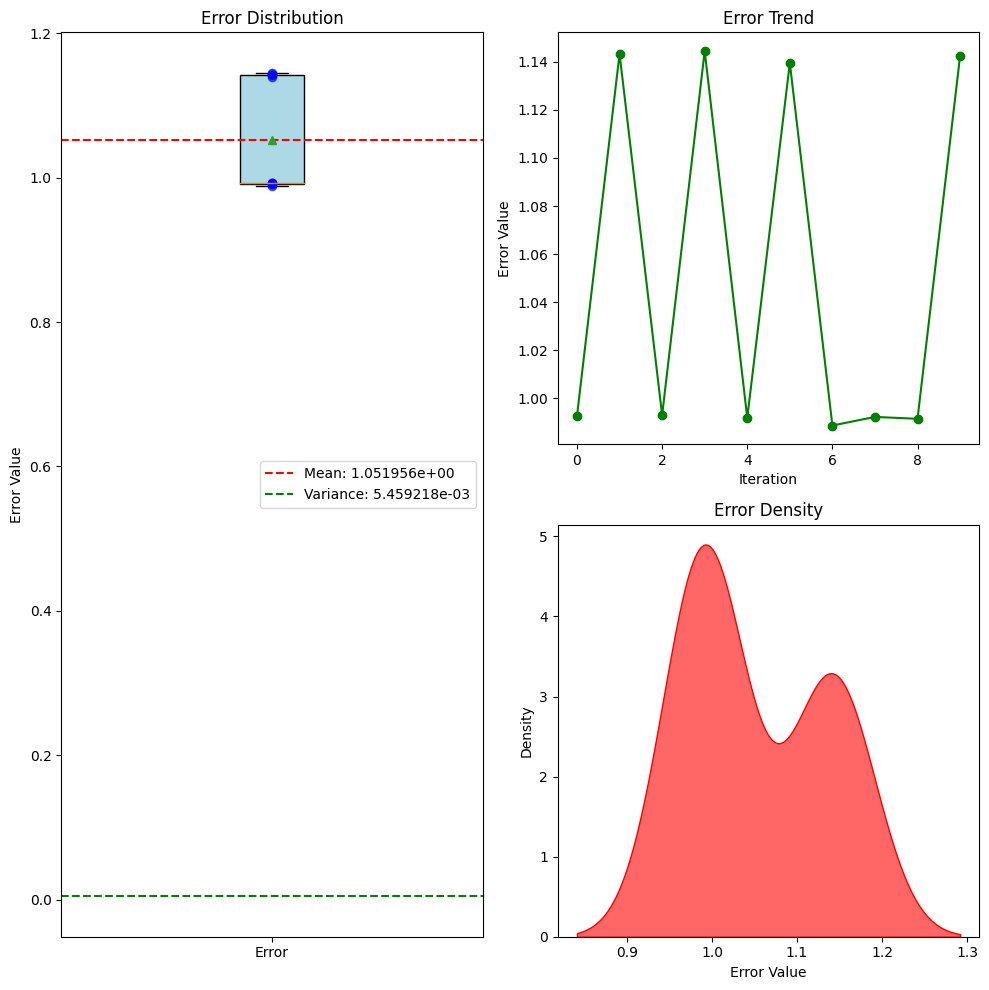

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = L1error

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [7]:
print('L1 error:', L1error)
print('L2 error:', L2error)

L1 error: [0.992671504918634, 1.1433182505300683, 0.992946757928002, 1.1444647218139699, 0.9918272980287938, 1.139476790984184, 0.9886826197629612, 0.9922550840325415, 0.9914714178195303, 1.1424493985953252]
L2 error: [0.990607959231671, 1.196983911653072, 0.9908709034350079, 1.1984228557770191, 0.9894625556932428, 1.1934999135353765, 0.9854430748942791, 0.9901025152157127, 0.9891645609531676, 1.1966155972000585]
